In [1]:
!pip install gym

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install gym[atari,accept-rom-license]==0.21.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
""" Trains an agent with (stochastic) Policy Gradients on Pong. Uses OpenAI Gym. """
import numpy as np
import pickle
import gym
import time
s_time=time.time()

# hyperparameters
H = 200 # number of hidden layer neurons
batch_size = 10 # every how many episodes to do a param update?
learning_rate =0.00008
gamma = 0.99 # discount factor for reward
decay_rate = 0.99 # decay factor for RMSProp leaky sum of grad^2
resume = False # resume from previous checkpoint?
render = False

# model initialization
D = 80 * 80 # input dimensionality: 80x80 grid
if resume:
    model = pickle.load(open('save_200_1e-5.p', 'rb'))
else:
    model = {}
    model['W1'] = np.random.randn(H,D) / np.sqrt(D) # "Xavier" initialization
    model['W2'] = np.random.randn(H) / np.sqrt(H)

grad_buffer = { k : np.zeros_like(v) for k,v in model.items() } # update buffers that add up gradients over a batch
rmsprop_cache = { k : np.zeros_like(v) for k,v in model.items() } # rmsprop memory

def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x)) # sigmoid "squashing" function to interval [0,1]

def prepro(I):
    """ prepro 210x160x3 uint8 frame into 6400 (80x80) 1D float vector """
    I = I[35:195] # crop
    I = I[::2,::2,0] # downsample by factor of 2
    I[I == 144] = 0 # erase background (background type 1)
    I[I == 109] = 0 # erase background (background type 2)
    I[I != 0] = 1 # everything else (paddles, ball) just set to 1
    return I.astype(np.float).ravel()

def discount_rewards(r):
    """ take 1D float array of rewards and compute discounted reward """
    discounted_r = np.zeros_like(r)
    running_add = 0
    for t in reversed(range(0, r.size)):
        if r[t] != 0: running_add = 0 # reset the sum, since this was a game boundary (pong specific!)
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add
    return discounted_r

def policy_forward(x):
    h = np.dot(model['W1'], x)
    h[h<0] = 0 # ReLU nonlinearity
    logp = np.dot(model['W2'], h)
    p = sigmoid(logp)
    return p, h # return probability of taking action 2, and hidden state

def policy_backward(eph, epdlogp):
    """ backward pass. (eph is array of intermediate hidden states) """
    dW2 = np.dot(eph.T, epdlogp).ravel()
    dh = np.outer(epdlogp, model['W2'])
    dh[eph <= 0] = 0 # backpro prelu
    dW1 = np.dot(dh.T, epx)
    return {'W1':dW1, 'W2':dW2}

env = gym.make("Pong-v0")
observation = env.reset()
prev_x = None # used in computing the difference frame
xs,hs,dlogps,drs = [],[],[],[]
running_reward = None
reward_sum = 0
episode_number = 0
while True:
    if render: env.render()

  # preprocess the observation, set input to network to be difference image
    cur_x = prepro(observation)
    x = cur_x - prev_x if prev_x is not None else np.zeros(D)
    prev_x = cur_x

  # forward the policy network and sample an action from the returned probability
    aprob, h = policy_forward(x)
    action = 2 if np.random.uniform() < aprob else 3 # roll the dice!

  # record various intermediates (needed later for backprop)
    xs.append(x) # observation
    hs.append(h) # hidden state
    y = 1 if action == 2 else 0 # a "fake label"
    dlogps.append(y - aprob) # grad that encourages the action that was taken to be taken (see http://cs231n.github.io/neural-networks-2/#losses if confused)

  # step the environment and get new measurements
    observation, reward, done, info = env.step(action)
    reward_sum += reward

    drs.append(reward) # record reward (has to be done after we call step() to get reward for previous action)

    if done: # an episode finished
        episode_number += 1

    # stack together all inputs, hidden states, action gradients, and rewards for this episode
        epx = np.vstack(xs)
        eph = np.vstack(hs)
        epdlogp = np.vstack(dlogps)
        epr = np.vstack(drs)
        xs,hs,dlogps,drs = [],[],[],[] # reset array memory

    # compute the discounted reward backwards through time
        discounted_epr = discount_rewards(epr)
    # standardize the rewards to be unit normal (helps control the gradient estimator variance)
        discounted_epr -= np.mean(discounted_epr)
        discounted_epr /= np.std(discounted_epr)

        epdlogp *= discounted_epr # modulate the gradient with advantage (PG magic happens right here.)
        grad = policy_backward(eph, epdlogp)
        for k in model: grad_buffer[k] += grad[k] # accumulate grad over batch

    # perform rmsprop parameter update every batch_size episodes
        if episode_number % batch_size == 0:
            for k,v in model.items():
                g = grad_buffer[k] # gradient
                rmsprop_cache[k] = decay_rate * rmsprop_cache[k] + (1 - decay_rate) * g**2
                model[k] += learning_rate * g / (np.sqrt(rmsprop_cache[k]) + 1e-5)
                grad_buffer[k] = np.zeros_like(v) # reset batch gradient buffer

    # boring book-keeping
        running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01
        print('resetting env. episode reward total was {}. running mean: {}'.format(reward_sum, running_reward))
        if episode_number % 100 == 0: pickle.dump(model, open('save_200_1e-5.p', 'wb'))
        reward_sum = 0
        observation = env.reset() # reset env
        prev_x = None
        if running_reward>=-19:
            break
    if reward != 0: # Pong has either +1 or -1 reward exactly when game ends.
        print ('ep {}: game finished, reward: {}'.format(episode_number, reward) + ('' if reward == -1 else ' !!!!!!!!'))
e_time=time.time()
td=e_time-s_time
print('model time difference is %s seconds:' %(td))


/var/folders/mh/b7kpn8490nd8w7l69p27clvc0000gn/T/ipykernel_1223/3747355405.py:39: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return I.astype(np.float).ravel()


ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -21.0
ep 1: game finished, reward: -1.0
ep 1: game finished, reward: -1.0
ep 1: game finished, reward: -1.0
ep 1: game finished, reward: -1.0
ep 1: game finished, reward: -1.0
ep 1: game finished, reward: -1.0
ep 1: game finished, reward: -1.0
ep 1: game fini

ep 10: game finished, reward: 1.0 !!!!!!!!
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: 1.0 !!!!!!!!
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.89486914706029
ep 11: game finished, reward: -1.0
ep 11: game finished, reward: -1.0
ep 11: game finished, reward: -1.0
ep 11: game finished, reward:

ep 19: game finished, reward: -1.0
ep 19: game finished, reward: -1.0
ep 19: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.865331549017846
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.86667823352767

ep 29: game finished, reward: -1.0
ep 29: game finished, reward: -1.0
ep 29: game finished, reward: -1.0
ep 29: game finished, reward: -1.0
ep 29: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.830071732884466
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: 1.0 !!!!!!!!
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: 1.0 !!!!!!!!
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: 1.0 !!!!!!!!
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished

ep 39: game finished, reward: -1.0
ep 39: game finished, reward: -1.0
ep 39: game finished, reward: -1.0
ep 39: game finished, reward: -1.0
ep 39: game finished, reward: -1.0
ep 39: game finished, reward: -1.0
ep 39: game finished, reward: -1.0
ep 39: game finished, reward: -1.0
ep 39: game finished, reward: -1.0
ep 39: game finished, reward: -1.0
ep 39: game finished, reward: -1.0
ep 39: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.770978731964885
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: ga

ep 49: game finished, reward: -1.0
ep 49: game finished, reward: -1.0
ep 49: game finished, reward: -1.0
ep 49: game finished, reward: -1.0
ep 49: game finished, reward: -1.0
ep 49: game finished, reward: -1.0
ep 49: game finished, reward: -1.0
ep 49: game finished, reward: -1.0
ep 49: game finished, reward: -1.0
ep 49: game finished, reward: -1.0
ep 49: game finished, reward: -1.0
ep 49: game finished, reward: -1.0
ep 49: game finished, reward: -1.0
ep 49: game finished, reward: -1.0
ep 49: game finished, reward: -1.0
ep 49: game finished, reward: -1.0
ep 49: game finished, reward: -1.0
ep 49: game finished, reward: -1.0
ep 49: game finished, reward: -1.0
ep 49: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.687661091523665
ep 50: game finished, reward: -1.0
ep 50: game finished, reward: -1.0
ep 50: game finished, reward: -1.0
ep 50: game finished, reward: -1.0
ep 50: game finished, reward: -1.0
ep 50: game finished, reward: -1.0
ep 50: ga

ep 59: game finished, reward: -1.0
ep 59: game finished, reward: -1.0
ep 59: game finished, reward: -1.0
ep 59: game finished, reward: -1.0
ep 59: game finished, reward: -1.0
ep 59: game finished, reward: -1.0
ep 59: game finished, reward: -1.0
ep 59: game finished, reward: -1.0
ep 59: game finished, reward: -1.0
ep 59: game finished, reward: -1.0
ep 59: game finished, reward: -1.0
ep 59: game finished, reward: -1.0
ep 59: game finished, reward: -1.0
ep 59: game finished, reward: -1.0
ep 59: game finished, reward: -1.0
ep 59: game finished, reward: -1.0
ep 59: game finished, reward: -1.0
ep 59: game finished, reward: -1.0
ep 59: game finished, reward: -1.0
ep 59: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.679946994796513
ep 60: game finished, reward: -1.0
ep 60: game finished, reward: -1.0
ep 60: game finished, reward: -1.0
ep 60: game finished, reward: -1.0
ep 60: game finished, reward: -1.0
ep 60: game finished, reward: -1.0
ep 60: ga

resetting env. episode reward total was -21.0. running mean: -20.65065117900044
ep 69: game finished, reward: -1.0
ep 69: game finished, reward: 1.0 !!!!!!!!
ep 69: game finished, reward: -1.0
ep 69: game finished, reward: -1.0
ep 69: game finished, reward: -1.0
ep 69: game finished, reward: 1.0 !!!!!!!!
ep 69: game finished, reward: -1.0
ep 69: game finished, reward: -1.0
ep 69: game finished, reward: -1.0
ep 69: game finished, reward: -1.0
ep 69: game finished, reward: -1.0
ep 69: game finished, reward: -1.0
ep 69: game finished, reward: -1.0
ep 69: game finished, reward: -1.0
ep 69: game finished, reward: -1.0
ep 69: game finished, reward: -1.0
ep 69: game finished, reward: -1.0
ep 69: game finished, reward: -1.0
ep 69: game finished, reward: -1.0
ep 69: game finished, reward: -1.0
ep 69: game finished, reward: -1.0
ep 69: game finished, reward: -1.0
ep 69: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.63414466721044
ep 70: game finishe

ep 78: game finished, reward: -1.0
ep 78: game finished, reward: -1.0
ep 78: game finished, reward: -1.0
ep 78: game finished, reward: -1.0
ep 78: game finished, reward: -1.0
ep 78: game finished, reward: -1.0
ep 78: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.579311765655724
ep 79: game finished, reward: -1.0
ep 79: game finished, reward: -1.0
ep 79: game finished, reward: -1.0
ep 79: game finished, reward: -1.0
ep 79: game finished, reward: -1.0
ep 79: game finished, reward: -1.0
ep 79: game finished, reward: -1.0
ep 79: game finished, reward: -1.0
ep 79: game finished, reward: -1.0
ep 79: game finished, reward: -1.0
ep 79: game finished, reward: -1.0
ep 79: game finished, reward: -1.0
ep 79: game finished, reward: -1.0
ep 79: game finished, reward: 1.0 !!!!!!!!
ep 79: game finished, reward: -1.0
ep 79: game finished, reward: -1.0
ep 79: game finished, reward: -1.0
ep 79: game finished, reward: -1.0
ep 79: game finished, reward: -1.0
e

ep 88: game finished, reward: -1.0
ep 88: game finished, reward: -1.0
ep 88: game finished, reward: -1.0
ep 88: game finished, reward: -1.0
ep 88: game finished, reward: -1.0
ep 88: game finished, reward: -1.0
ep 88: game finished, reward: -1.0
ep 88: game finished, reward: -1.0
ep 88: game finished, reward: -1.0
ep 88: game finished, reward: -1.0
ep 88: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.571782078618096
ep 89: game finished, reward: -1.0
ep 89: game finished, reward: -1.0
ep 89: game finished, reward: -1.0
ep 89: game finished, reward: -1.0
ep 89: game finished, reward: -1.0
ep 89: game finished, reward: -1.0
ep 89: game finished, reward: -1.0
ep 89: game finished, reward: -1.0
ep 89: game finished, reward: -1.0
ep 89: game finished, reward: -1.0
ep 89: game finished, reward: -1.0
ep 89: game finished, reward: -1.0
ep 89: game finished, reward: -1.0
ep 89: game finished, reward: -1.0
ep 89: game finished, reward: -1.0
ep 89: ga

ep 98: game finished, reward: -1.0
ep 98: game finished, reward: -1.0
ep 98: game finished, reward: -1.0
ep 98: game finished, reward: -1.0
ep 98: game finished, reward: -1.0
ep 98: game finished, reward: -1.0
ep 98: game finished, reward: -1.0
ep 98: game finished, reward: -1.0
ep 98: game finished, reward: -1.0
ep 98: game finished, reward: -1.0
ep 98: game finished, reward: -1.0
ep 98: game finished, reward: -1.0
ep 98: game finished, reward: -1.0
ep 98: game finished, reward: -1.0
ep 98: game finished, reward: 1.0 !!!!!!!!
ep 98: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.555446918271702
ep 99: game finished, reward: -1.0
ep 99: game finished, reward: -1.0
ep 99: game finished, reward: -1.0
ep 99: game finished, reward: -1.0
ep 99: game finished, reward: -1.0
ep 99: game finished, reward: -1.0
ep 99: game finished, reward: -1.0
ep 99: game finished, reward: -1.0
ep 99: game finished, reward: -1.0
ep 99: game finished, reward: -1.0
e

resetting env. episode reward total was -21.0. running mean: -20.5649781822192
ep 108: game finished, reward: -1.0
ep 108: game finished, reward: -1.0
ep 108: game finished, reward: -1.0
ep 108: game finished, reward: -1.0
ep 108: game finished, reward: -1.0
ep 108: game finished, reward: -1.0
ep 108: game finished, reward: -1.0
ep 108: game finished, reward: -1.0
ep 108: game finished, reward: -1.0
ep 108: game finished, reward: -1.0
ep 108: game finished, reward: -1.0
ep 108: game finished, reward: -1.0
ep 108: game finished, reward: -1.0
ep 108: game finished, reward: -1.0
ep 108: game finished, reward: -1.0
ep 108: game finished, reward: -1.0
ep 108: game finished, reward: -1.0
ep 108: game finished, reward: -1.0
ep 108: game finished, reward: -1.0
ep 108: game finished, reward: -1.0
ep 108: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.56932840039701
ep 109: game finished, reward: -1.0
ep 109: game finished, reward: -1.0
ep 109: game 

ep 117: game finished, reward: -1.0
ep 117: game finished, reward: -1.0
ep 117: game finished, reward: 1.0 !!!!!!!!
ep 117: game finished, reward: -1.0
ep 117: game finished, reward: -1.0
ep 117: game finished, reward: -1.0
ep 117: game finished, reward: -1.0
ep 117: game finished, reward: 1.0 !!!!!!!!
ep 117: game finished, reward: -1.0
ep 117: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.529987295216138
ep 118: game finished, reward: -1.0
ep 118: game finished, reward: -1.0
ep 118: game finished, reward: -1.0
ep 118: game finished, reward: -1.0
ep 118: game finished, reward: -1.0
ep 118: game finished, reward: -1.0
ep 118: game finished, reward: -1.0
ep 118: game finished, reward: -1.0
ep 118: game finished, reward: -1.0
ep 118: game finished, reward: -1.0
ep 118: game finished, reward: 1.0 !!!!!!!!
ep 118: game finished, reward: -1.0
ep 118: game finished, reward: -1.0
ep 118: game finished, reward: -1.0
ep 118: game finished, reward: 

ep 127: game finished, reward: -1.0
ep 127: game finished, reward: -1.0
ep 127: game finished, reward: -1.0
ep 127: game finished, reward: -1.0
ep 127: game finished, reward: -1.0
ep 127: game finished, reward: -1.0
ep 127: game finished, reward: -1.0
ep 127: game finished, reward: -1.0
ep 127: game finished, reward: -1.0
ep 127: game finished, reward: -1.0
ep 127: game finished, reward: -1.0
ep 127: game finished, reward: -1.0
ep 127: game finished, reward: -1.0
ep 127: game finished, reward: -1.0
ep 127: game finished, reward: -1.0
ep 127: game finished, reward: -1.0
ep 127: game finished, reward: -1.0
ep 127: game finished, reward: -1.0
ep 127: game finished, reward: -1.0
ep 127: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.536683812192237
ep 128: game finished, reward: -1.0
ep 128: game finished, reward: -1.0
ep 128: game finished, reward: -1.0
ep 128: game finished, reward: -1.0
ep 128: game finished, reward: -1.0
ep 128: game finish

ep 136: game finished, reward: -1.0
ep 136: game finished, reward: -1.0
ep 136: game finished, reward: -1.0
ep 136: game finished, reward: -1.0
ep 136: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.5194895437421
ep 137: game finished, reward: -1.0
ep 137: game finished, reward: -1.0
ep 137: game finished, reward: -1.0
ep 137: game finished, reward: -1.0
ep 137: game finished, reward: -1.0
ep 137: game finished, reward: -1.0
ep 137: game finished, reward: -1.0
ep 137: game finished, reward: -1.0
ep 137: game finished, reward: -1.0
ep 137: game finished, reward: -1.0
ep 137: game finished, reward: -1.0
ep 137: game finished, reward: -1.0
ep 137: game finished, reward: -1.0
ep 137: game finished, reward: 1.0 !!!!!!!!
ep 137: game finished, reward: -1.0
ep 137: game finished, reward: -1.0
ep 137: game finished, reward: -1.0
ep 137: game finished, reward: -1.0
ep 137: game finished, reward: -1.0
ep 137: game finished, reward: -1.0
ep 137: game 

ep 146: game finished, reward: -1.0
ep 146: game finished, reward: -1.0
ep 146: game finished, reward: -1.0
ep 146: game finished, reward: -1.0
ep 146: game finished, reward: -1.0
ep 146: game finished, reward: -1.0
ep 146: game finished, reward: -1.0
ep 146: game finished, reward: -1.0
ep 146: game finished, reward: -1.0
ep 146: game finished, reward: -1.0
ep 146: game finished, reward: -1.0
ep 146: game finished, reward: -1.0
ep 146: game finished, reward: -1.0
ep 146: game finished, reward: -1.0
ep 146: game finished, reward: -1.0
ep 146: game finished, reward: -1.0
ep 146: game finished, reward: -1.0
ep 146: game finished, reward: -1.0
ep 146: game finished, reward: -1.0
ep 146: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.479532607860136
ep 147: game finished, reward: -1.0
ep 147: game finished, reward: -1.0
ep 147: game finished, reward: -1.0
ep 147: game finished, reward: -1.0
ep 147: game finished, reward: -1.0
ep 147: game finish

ep 155: game finished, reward: -1.0
ep 155: game finished, reward: -1.0
ep 155: game finished, reward: -1.0
ep 155: game finished, reward: -1.0
ep 155: game finished, reward: 1.0 !!!!!!!!
ep 155: game finished, reward: -1.0
ep 155: game finished, reward: -1.0
ep 155: game finished, reward: -1.0
ep 155: game finished, reward: -1.0
ep 155: game finished, reward: -1.0
ep 155: game finished, reward: -1.0
ep 155: game finished, reward: -1.0
ep 155: game finished, reward: -1.0
resetting env. episode reward total was -17.0. running mean: -20.417581824556322
ep 156: game finished, reward: -1.0
ep 156: game finished, reward: -1.0
ep 156: game finished, reward: -1.0
ep 156: game finished, reward: -1.0
ep 156: game finished, reward: -1.0
ep 156: game finished, reward: -1.0
ep 156: game finished, reward: -1.0
ep 156: game finished, reward: -1.0
ep 156: game finished, reward: -1.0
ep 156: game finished, reward: -1.0
ep 156: game finished, reward: -1.0
ep 156: game finished, reward: -1.0
ep 156: gam

ep 165: game finished, reward: 1.0 !!!!!!!!
ep 165: game finished, reward: -1.0
ep 165: game finished, reward: -1.0
ep 165: game finished, reward: -1.0
ep 165: game finished, reward: -1.0
ep 165: game finished, reward: -1.0
ep 165: game finished, reward: -1.0
ep 165: game finished, reward: -1.0
ep 165: game finished, reward: -1.0
ep 165: game finished, reward: -1.0
ep 165: game finished, reward: -1.0
ep 165: game finished, reward: -1.0
ep 165: game finished, reward: -1.0
ep 165: game finished, reward: -1.0
ep 165: game finished, reward: 1.0 !!!!!!!!
ep 165: game finished, reward: -1.0
ep 165: game finished, reward: -1.0
ep 165: game finished, reward: 1.0 !!!!!!!!
ep 165: game finished, reward: -1.0
ep 165: game finished, reward: -1.0
ep 165: game finished, reward: -1.0
ep 165: game finished, reward: -1.0
ep 165: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -20.404932996996322
ep 166: game finished, reward: -1.0
ep 166: game finished, reward: 

ep 174: game finished, reward: -1.0
ep 174: game finished, reward: -1.0
ep 174: game finished, reward: -1.0
ep 174: game finished, reward: -1.0
ep 174: game finished, reward: -1.0
ep 174: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.44649602934775
ep 175: game finished, reward: -1.0
ep 175: game finished, reward: -1.0
ep 175: game finished, reward: -1.0
ep 175: game finished, reward: -1.0
ep 175: game finished, reward: -1.0
ep 175: game finished, reward: -1.0
ep 175: game finished, reward: -1.0
ep 175: game finished, reward: -1.0
ep 175: game finished, reward: 1.0 !!!!!!!!
ep 175: game finished, reward: -1.0
ep 175: game finished, reward: -1.0
ep 175: game finished, reward: -1.0
ep 175: game finished, reward: -1.0
ep 175: game finished, reward: -1.0
ep 175: game finished, reward: -1.0
ep 175: game finished, reward: -1.0
ep 175: game finished, reward: -1.0
ep 175: game finished, reward: -1.0
ep 175: game finished, reward: -1.0
ep 175: game

ep 184: game finished, reward: -1.0
ep 184: game finished, reward: -1.0
ep 184: game finished, reward: -1.0
ep 184: game finished, reward: -1.0
ep 184: game finished, reward: -1.0
ep 184: game finished, reward: -1.0
ep 184: game finished, reward: -1.0
ep 184: game finished, reward: -1.0
ep 184: game finished, reward: -1.0
ep 184: game finished, reward: -1.0
ep 184: game finished, reward: -1.0
ep 184: game finished, reward: -1.0
ep 184: game finished, reward: -1.0
ep 184: game finished, reward: -1.0
ep 184: game finished, reward: -1.0
ep 184: game finished, reward: -1.0
ep 184: game finished, reward: -1.0
ep 184: game finished, reward: -1.0
ep 184: game finished, reward: -1.0
ep 184: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.412344390876793
ep 185: game finished, reward: -1.0
ep 185: game finished, reward: -1.0
ep 185: game finished, reward: -1.0
ep 185: game finished, reward: -1.0
ep 185: game finished, reward: -1.0
ep 185: game finish

ep 193: game finished, reward: -1.0
ep 193: game finished, reward: -1.0
ep 193: game finished, reward: -1.0
ep 193: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.42423602854117
ep 194: game finished, reward: -1.0
ep 194: game finished, reward: -1.0
ep 194: game finished, reward: -1.0
ep 194: game finished, reward: -1.0
ep 194: game finished, reward: -1.0
ep 194: game finished, reward: -1.0
ep 194: game finished, reward: -1.0
ep 194: game finished, reward: -1.0
ep 194: game finished, reward: -1.0
ep 194: game finished, reward: -1.0
ep 194: game finished, reward: -1.0
ep 194: game finished, reward: -1.0
ep 194: game finished, reward: -1.0
ep 194: game finished, reward: -1.0
ep 194: game finished, reward: -1.0
ep 194: game finished, reward: 1.0 !!!!!!!!
ep 194: game finished, reward: -1.0
ep 194: game finished, reward: -1.0
ep 194: game finished, reward: -1.0
ep 194: game finished, reward: -1.0
ep 194: game finished, reward: -1.0
ep 194: game

ep 203: game finished, reward: -1.0
ep 203: game finished, reward: -1.0
ep 203: game finished, reward: -1.0
ep 203: game finished, reward: -1.0
ep 203: game finished, reward: -1.0
ep 203: game finished, reward: -1.0
ep 203: game finished, reward: -1.0
ep 203: game finished, reward: -1.0
ep 203: game finished, reward: -1.0
ep 203: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.450843311802917
ep 204: game finished, reward: -1.0
ep 204: game finished, reward: -1.0
ep 204: game finished, reward: -1.0
ep 204: game finished, reward: -1.0
ep 204: game finished, reward: -1.0
ep 204: game finished, reward: -1.0
ep 204: game finished, reward: -1.0
ep 204: game finished, reward: -1.0
ep 204: game finished, reward: -1.0
ep 204: game finished, reward: 1.0 !!!!!!!!
ep 204: game finished, reward: -1.0
ep 204: game finished, reward: -1.0
ep 204: game finished, reward: -1.0
ep 204: game finished, reward: -1.0
ep 204: game finished, reward: -1.0
ep 204: gam

ep 213: game finished, reward: -1.0
ep 213: game finished, reward: -1.0
ep 213: game finished, reward: -1.0
ep 213: game finished, reward: -1.0
ep 213: game finished, reward: -1.0
ep 213: game finished, reward: -1.0
ep 213: game finished, reward: -1.0
ep 213: game finished, reward: -1.0
ep 213: game finished, reward: -1.0
ep 213: game finished, reward: -1.0
ep 213: game finished, reward: -1.0
ep 213: game finished, reward: -1.0
ep 213: game finished, reward: 1.0 !!!!!!!!
ep 213: game finished, reward: -1.0
ep 213: game finished, reward: -1.0
ep 213: game finished, reward: -1.0
ep 213: game finished, reward: -1.0
ep 213: game finished, reward: -1.0
ep 213: game finished, reward: -1.0
ep 213: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.45500841224852
ep 214: game finished, reward: -1.0
ep 214: game finished, reward: -1.0
ep 214: game finished, reward: -1.0
ep 214: game finished, reward: -1.0
ep 214: game finished, reward: -1.0
ep 214: game

ep 222: game finished, reward: -1.0
ep 222: game finished, reward: -1.0
ep 222: game finished, reward: -1.0
ep 222: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.46332000336152
ep 223: game finished, reward: -1.0
ep 223: game finished, reward: -1.0
ep 223: game finished, reward: -1.0
ep 223: game finished, reward: -1.0
ep 223: game finished, reward: -1.0
ep 223: game finished, reward: -1.0
ep 223: game finished, reward: -1.0
ep 223: game finished, reward: -1.0
ep 223: game finished, reward: -1.0
ep 223: game finished, reward: -1.0
ep 223: game finished, reward: -1.0
ep 223: game finished, reward: -1.0
ep 223: game finished, reward: -1.0
ep 223: game finished, reward: -1.0
ep 223: game finished, reward: -1.0
ep 223: game finished, reward: -1.0
ep 223: game finished, reward: -1.0
ep 223: game finished, reward: 1.0 !!!!!!!!
ep 223: game finished, reward: -1.0
ep 223: game finished, reward: -1.0
ep 223: game finished, reward: -1.0
ep 223: game

ep 232: game finished, reward: -1.0
ep 232: game finished, reward: -1.0
ep 232: game finished, reward: -1.0
ep 232: game finished, reward: -1.0
ep 232: game finished, reward: -1.0
ep 232: game finished, reward: -1.0
ep 232: game finished, reward: -1.0
ep 232: game finished, reward: -1.0
ep 232: game finished, reward: -1.0
ep 232: game finished, reward: 1.0 !!!!!!!!
ep 232: game finished, reward: -1.0
ep 232: game finished, reward: -1.0
ep 232: game finished, reward: -1.0
ep 232: game finished, reward: -1.0
ep 232: game finished, reward: -1.0
ep 232: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.42862816712819
ep 233: game finished, reward: -1.0
ep 233: game finished, reward: -1.0
ep 233: game finished, reward: -1.0
ep 233: game finished, reward: -1.0
ep 233: game finished, reward: -1.0
ep 233: game finished, reward: -1.0
ep 233: game finished, reward: -1.0
ep 233: game finished, reward: -1.0
ep 233: game finished, reward: -1.0
ep 233: game

ep 241: game finished, reward: -1.0
ep 241: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.43921536236619
ep 242: game finished, reward: -1.0
ep 242: game finished, reward: -1.0
ep 242: game finished, reward: -1.0
ep 242: game finished, reward: -1.0
ep 242: game finished, reward: -1.0
ep 242: game finished, reward: -1.0
ep 242: game finished, reward: -1.0
ep 242: game finished, reward: -1.0
ep 242: game finished, reward: -1.0
ep 242: game finished, reward: -1.0
ep 242: game finished, reward: -1.0
ep 242: game finished, reward: -1.0
ep 242: game finished, reward: -1.0
ep 242: game finished, reward: -1.0
ep 242: game finished, reward: -1.0
ep 242: game finished, reward: -1.0
ep 242: game finished, reward: -1.0
ep 242: game finished, reward: -1.0
ep 242: game finished, reward: -1.0
ep 242: game finished, reward: -1.0
ep 242: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.44482320874253
ep 243: game

ep 251: game finished, reward: -1.0
ep 251: game finished, reward: -1.0
ep 251: game finished, reward: -1.0
ep 251: game finished, reward: -1.0
ep 251: game finished, reward: -1.0
ep 251: game finished, reward: -1.0
ep 251: game finished, reward: -1.0
ep 251: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.445364564847466
ep 252: game finished, reward: -1.0
ep 252: game finished, reward: -1.0
ep 252: game finished, reward: -1.0
ep 252: game finished, reward: -1.0
ep 252: game finished, reward: -1.0
ep 252: game finished, reward: -1.0
ep 252: game finished, reward: -1.0
ep 252: game finished, reward: -1.0
ep 252: game finished, reward: -1.0
ep 252: game finished, reward: -1.0
ep 252: game finished, reward: -1.0
ep 252: game finished, reward: -1.0
ep 252: game finished, reward: -1.0
ep 252: game finished, reward: -1.0
ep 252: game finished, reward: -1.0
ep 252: game finished, reward: -1.0
ep 252: game finished, reward: -1.0
ep 252: game finish

ep 261: game finished, reward: -1.0
ep 261: game finished, reward: -1.0
ep 261: game finished, reward: -1.0
ep 261: game finished, reward: -1.0
ep 261: game finished, reward: -1.0
ep 261: game finished, reward: -1.0
ep 261: game finished, reward: -1.0
ep 261: game finished, reward: -1.0
ep 261: game finished, reward: -1.0
ep 261: game finished, reward: -1.0
ep 261: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.489170207339072
ep 262: game finished, reward: -1.0
ep 262: game finished, reward: -1.0
ep 262: game finished, reward: -1.0
ep 262: game finished, reward: -1.0
ep 262: game finished, reward: -1.0
ep 262: game finished, reward: -1.0
ep 262: game finished, reward: -1.0
ep 262: game finished, reward: -1.0
ep 262: game finished, reward: -1.0
ep 262: game finished, reward: -1.0
ep 262: game finished, reward: -1.0
ep 262: game finished, reward: -1.0
ep 262: game finished, reward: -1.0
ep 262: game finished, reward: -1.0
ep 262: game finish

ep 271: game finished, reward: -1.0
ep 271: game finished, reward: -1.0
ep 271: game finished, reward: -1.0
ep 271: game finished, reward: -1.0
ep 271: game finished, reward: -1.0
ep 271: game finished, reward: -1.0
ep 271: game finished, reward: -1.0
ep 271: game finished, reward: -1.0
ep 271: game finished, reward: -1.0
ep 271: game finished, reward: 1.0 !!!!!!!!
ep 271: game finished, reward: -1.0
ep 271: game finished, reward: -1.0
ep 271: game finished, reward: -1.0
ep 271: game finished, reward: -1.0
ep 271: game finished, reward: -1.0
ep 271: game finished, reward: -1.0
ep 271: game finished, reward: -1.0
ep 271: game finished, reward: 1.0 !!!!!!!!
ep 271: game finished, reward: -1.0
ep 271: game finished, reward: -1.0
ep 271: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.469203742036996
ep 272: game finished, reward: -1.0
ep 272: game finished, reward: -1.0
ep 272: game finished, reward: -1.0
ep 272: game finished, reward: -1.0
ep 

ep 280: game finished, reward: -1.0
ep 280: game finished, reward: -1.0
ep 280: game finished, reward: -1.0
ep 280: game finished, reward: -1.0
ep 280: game finished, reward: -1.0
ep 280: game finished, reward: -1.0
ep 280: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.476183761458017
ep 281: game finished, reward: -1.0
ep 281: game finished, reward: -1.0
ep 281: game finished, reward: -1.0
ep 281: game finished, reward: -1.0
ep 281: game finished, reward: -1.0
ep 281: game finished, reward: -1.0
ep 281: game finished, reward: -1.0
ep 281: game finished, reward: -1.0
ep 281: game finished, reward: -1.0
ep 281: game finished, reward: -1.0
ep 281: game finished, reward: -1.0
ep 281: game finished, reward: -1.0
ep 281: game finished, reward: -1.0
ep 281: game finished, reward: -1.0
ep 281: game finished, reward: -1.0
ep 281: game finished, reward: -1.0
ep 281: game finished, reward: -1.0
ep 281: game finished, reward: -1.0
ep 281: game finish

ep 290: game finished, reward: -1.0
ep 290: game finished, reward: -1.0
ep 290: game finished, reward: -1.0
ep 290: game finished, reward: -1.0
ep 290: game finished, reward: -1.0
ep 290: game finished, reward: -1.0
ep 290: game finished, reward: -1.0
ep 290: game finished, reward: -1.0
ep 290: game finished, reward: -1.0
ep 290: game finished, reward: -1.0
ep 290: game finished, reward: -1.0
ep 290: game finished, reward: -1.0
ep 290: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.50724633978503
ep 291: game finished, reward: -1.0
ep 291: game finished, reward: -1.0
ep 291: game finished, reward: -1.0
ep 291: game finished, reward: -1.0
ep 291: game finished, reward: -1.0
ep 291: game finished, reward: -1.0
ep 291: game finished, reward: -1.0
ep 291: game finished, reward: -1.0
ep 291: game finished, reward: -1.0
ep 291: game finished, reward: -1.0
ep 291: game finished, reward: -1.0
ep 291: game finished, reward: -1.0
ep 291: game finishe

ep 299: game finished, reward: -1.0
ep 299: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.473190984080787
ep 300: game finished, reward: -1.0
ep 300: game finished, reward: -1.0
ep 300: game finished, reward: -1.0
ep 300: game finished, reward: -1.0
ep 300: game finished, reward: -1.0
ep 300: game finished, reward: -1.0
ep 300: game finished, reward: -1.0
ep 300: game finished, reward: -1.0
ep 300: game finished, reward: -1.0
ep 300: game finished, reward: -1.0
ep 300: game finished, reward: -1.0
ep 300: game finished, reward: -1.0
ep 300: game finished, reward: -1.0
ep 300: game finished, reward: -1.0
ep 300: game finished, reward: -1.0
ep 300: game finished, reward: -1.0
ep 300: game finished, reward: -1.0
ep 300: game finished, reward: -1.0
ep 300: game finished, reward: -1.0
ep 300: game finished, reward: -1.0
ep 300: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.47845907423998
ep 301: gam

ep 309: game finished, reward: -1.0
ep 309: game finished, reward: -1.0
ep 309: game finished, reward: -1.0
ep 309: game finished, reward: -1.0
ep 309: game finished, reward: -1.0
ep 309: game finished, reward: -1.0
ep 309: game finished, reward: -1.0
ep 309: game finished, reward: -1.0
ep 309: game finished, reward: -1.0
ep 309: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.494935677056628
ep 310: game finished, reward: -1.0
ep 310: game finished, reward: -1.0
ep 310: game finished, reward: -1.0
ep 310: game finished, reward: -1.0
ep 310: game finished, reward: -1.0
ep 310: game finished, reward: -1.0
ep 310: game finished, reward: -1.0
ep 310: game finished, reward: -1.0
ep 310: game finished, reward: -1.0
ep 310: game finished, reward: -1.0
ep 310: game finished, reward: -1.0
ep 310: game finished, reward: -1.0
ep 310: game finished, reward: -1.0
ep 310: game finished, reward: -1.0
ep 310: game finished, reward: -1.0
ep 310: game finish

ep 319: game finished, reward: -1.0
ep 319: game finished, reward: -1.0
ep 319: game finished, reward: -1.0
ep 319: game finished, reward: -1.0
ep 319: game finished, reward: -1.0
ep 319: game finished, reward: -1.0
ep 319: game finished, reward: 1.0 !!!!!!!!
ep 319: game finished, reward: -1.0
ep 319: game finished, reward: -1.0
ep 319: game finished, reward: -1.0
ep 319: game finished, reward: -1.0
ep 319: game finished, reward: 1.0 !!!!!!!!
ep 319: game finished, reward: -1.0
ep 319: game finished, reward: -1.0
ep 319: game finished, reward: -1.0
ep 319: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.49382488960356
ep 320: game finished, reward: -1.0
ep 320: game finished, reward: -1.0
ep 320: game finished, reward: -1.0
ep 320: game finished, reward: -1.0
ep 320: game finished, reward: -1.0
ep 320: game finished, reward: -1.0
ep 320: game finished, reward: -1.0
ep 320: game finished, reward: -1.0
ep 320: game finished, reward: -1.0
ep 3

resetting env. episode reward total was -21.0. running mean: -20.5092608029189
ep 329: game finished, reward: -1.0
ep 329: game finished, reward: -1.0
ep 329: game finished, reward: -1.0
ep 329: game finished, reward: -1.0
ep 329: game finished, reward: -1.0
ep 329: game finished, reward: -1.0
ep 329: game finished, reward: -1.0
ep 329: game finished, reward: -1.0
ep 329: game finished, reward: -1.0
ep 329: game finished, reward: 1.0 !!!!!!!!
ep 329: game finished, reward: -1.0
ep 329: game finished, reward: -1.0
ep 329: game finished, reward: -1.0
ep 329: game finished, reward: -1.0
ep 329: game finished, reward: -1.0
ep 329: game finished, reward: -1.0
ep 329: game finished, reward: -1.0
ep 329: game finished, reward: -1.0
ep 329: game finished, reward: -1.0
ep 329: game finished, reward: -1.0
ep 329: game finished, reward: -1.0
ep 329: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.504168194889708
ep 330: game finished, reward: -1.0
ep 3

ep 338: game finished, reward: -1.0
ep 338: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.547049094180803
ep 339: game finished, reward: -1.0
ep 339: game finished, reward: -1.0
ep 339: game finished, reward: -1.0
ep 339: game finished, reward: -1.0
ep 339: game finished, reward: -1.0
ep 339: game finished, reward: -1.0
ep 339: game finished, reward: -1.0
ep 339: game finished, reward: -1.0
ep 339: game finished, reward: -1.0
ep 339: game finished, reward: -1.0
ep 339: game finished, reward: -1.0
ep 339: game finished, reward: -1.0
ep 339: game finished, reward: -1.0
ep 339: game finished, reward: -1.0
ep 339: game finished, reward: -1.0
ep 339: game finished, reward: 1.0 !!!!!!!!
ep 339: game finished, reward: -1.0
ep 339: game finished, reward: -1.0
ep 339: game finished, reward: -1.0
ep 339: game finished, reward: 1.0 !!!!!!!!
ep 339: game finished, reward: -1.0
ep 339: game finished, reward: -1.0
ep 339: game finished, reward: -1.0
res

ep 348: game finished, reward: -1.0
ep 348: game finished, reward: -1.0
ep 348: game finished, reward: -1.0
ep 348: game finished, reward: 1.0 !!!!!!!!
ep 348: game finished, reward: -1.0
ep 348: game finished, reward: -1.0
ep 348: game finished, reward: -1.0
ep 348: game finished, reward: -1.0
ep 348: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.542385984968455
ep 349: game finished, reward: -1.0
ep 349: game finished, reward: -1.0
ep 349: game finished, reward: -1.0
ep 349: game finished, reward: -1.0
ep 349: game finished, reward: -1.0
ep 349: game finished, reward: -1.0
ep 349: game finished, reward: -1.0
ep 349: game finished, reward: -1.0
ep 349: game finished, reward: -1.0
ep 349: game finished, reward: -1.0
ep 349: game finished, reward: -1.0
ep 349: game finished, reward: -1.0
ep 349: game finished, reward: -1.0
ep 349: game finished, reward: -1.0
ep 349: game finished, reward: -1.0
ep 349: game finished, reward: -1.0
ep 349: gam

ep 358: game finished, reward: -1.0
ep 358: game finished, reward: -1.0
ep 358: game finished, reward: -1.0
ep 358: game finished, reward: -1.0
ep 358: game finished, reward: -1.0
ep 358: game finished, reward: -1.0
ep 358: game finished, reward: -1.0
ep 358: game finished, reward: -1.0
ep 358: game finished, reward: -1.0
ep 358: game finished, reward: -1.0
ep 358: game finished, reward: -1.0
ep 358: game finished, reward: -1.0
ep 358: game finished, reward: -1.0
ep 358: game finished, reward: -1.0
ep 358: game finished, reward: -1.0
ep 358: game finished, reward: -1.0
ep 358: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.557305915057828
ep 359: game finished, reward: -1.0
ep 359: game finished, reward: -1.0
ep 359: game finished, reward: -1.0
ep 359: game finished, reward: -1.0
ep 359: game finished, reward: -1.0
ep 359: game finished, reward: -1.0
ep 359: game finished, reward: -1.0
ep 359: game finished, reward: -1.0
ep 359: game finish

ep 367: game finished, reward: -1.0
ep 367: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.54783416960506
ep 368: game finished, reward: -1.0
ep 368: game finished, reward: -1.0
ep 368: game finished, reward: -1.0
ep 368: game finished, reward: -1.0
ep 368: game finished, reward: -1.0
ep 368: game finished, reward: -1.0
ep 368: game finished, reward: -1.0
ep 368: game finished, reward: -1.0
ep 368: game finished, reward: -1.0
ep 368: game finished, reward: -1.0
ep 368: game finished, reward: -1.0
ep 368: game finished, reward: -1.0
ep 368: game finished, reward: -1.0
ep 368: game finished, reward: -1.0
ep 368: game finished, reward: -1.0
ep 368: game finished, reward: -1.0
ep 368: game finished, reward: -1.0
ep 368: game finished, reward: -1.0
ep 368: game finished, reward: -1.0
ep 368: game finished, reward: -1.0
ep 368: game finished, reward: -1.0
ep 368: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -20.0. r

ep 377: game finished, reward: -1.0
ep 377: game finished, reward: -1.0
ep 377: game finished, reward: -1.0
ep 377: game finished, reward: 1.0 !!!!!!!!
ep 377: game finished, reward: -1.0
ep 377: game finished, reward: -1.0
ep 377: game finished, reward: -1.0
ep 377: game finished, reward: -1.0
ep 377: game finished, reward: -1.0
ep 377: game finished, reward: -1.0
ep 377: game finished, reward: -1.0
ep 377: game finished, reward: -1.0
ep 377: game finished, reward: -1.0
ep 377: game finished, reward: -1.0
ep 377: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.5141965134915
ep 378: game finished, reward: -1.0
ep 378: game finished, reward: -1.0
ep 378: game finished, reward: -1.0
ep 378: game finished, reward: -1.0
ep 378: game finished, reward: -1.0
ep 378: game finished, reward: -1.0
ep 378: game finished, reward: -1.0
ep 378: game finished, reward: -1.0
ep 378: game finished, reward: -1.0
ep 378: game finished, reward: -1.0
ep 378: game 

ep 386: game finished, reward: -1.0
ep 386: game finished, reward: -1.0
ep 386: game finished, reward: -1.0
ep 386: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.47962927614064
ep 387: game finished, reward: -1.0
ep 387: game finished, reward: -1.0
ep 387: game finished, reward: -1.0
ep 387: game finished, reward: -1.0
ep 387: game finished, reward: -1.0
ep 387: game finished, reward: -1.0
ep 387: game finished, reward: -1.0
ep 387: game finished, reward: -1.0
ep 387: game finished, reward: -1.0
ep 387: game finished, reward: -1.0
ep 387: game finished, reward: -1.0
ep 387: game finished, reward: -1.0
ep 387: game finished, reward: -1.0
ep 387: game finished, reward: -1.0
ep 387: game finished, reward: -1.0
ep 387: game finished, reward: -1.0
ep 387: game finished, reward: -1.0
ep 387: game finished, reward: -1.0
ep 387: game finished, reward: -1.0
ep 387: game finished, reward: -1.0
ep 387: game finished, reward: -1.0
resetting env. episo

ep 396: game finished, reward: -1.0
ep 396: game finished, reward: -1.0
ep 396: game finished, reward: -1.0
ep 396: game finished, reward: -1.0
ep 396: game finished, reward: -1.0
ep 396: game finished, reward: -1.0
ep 396: game finished, reward: -1.0
ep 396: game finished, reward: -1.0
ep 396: game finished, reward: -1.0
ep 396: game finished, reward: -1.0
ep 396: game finished, reward: -1.0
ep 396: game finished, reward: -1.0
ep 396: game finished, reward: -1.0
ep 396: game finished, reward: -1.0
ep 396: game finished, reward: -1.0
ep 396: game finished, reward: -1.0
ep 396: game finished, reward: -1.0
ep 396: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.443460455711108
ep 397: game finished, reward: -1.0
ep 397: game finished, reward: -1.0
ep 397: game finished, reward: -1.0
ep 397: game finished, reward: -1.0
ep 397: game finished, reward: -1.0
ep 397: game finished, reward: -1.0
ep 397: game finished, reward: -1.0
ep 397: game finish

ep 405: game finished, reward: -1.0
ep 405: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.463439378448122
ep 406: game finished, reward: -1.0
ep 406: game finished, reward: -1.0
ep 406: game finished, reward: -1.0
ep 406: game finished, reward: -1.0
ep 406: game finished, reward: -1.0
ep 406: game finished, reward: -1.0
ep 406: game finished, reward: -1.0
ep 406: game finished, reward: -1.0
ep 406: game finished, reward: -1.0
ep 406: game finished, reward: -1.0
ep 406: game finished, reward: -1.0
ep 406: game finished, reward: -1.0
ep 406: game finished, reward: -1.0
ep 406: game finished, reward: -1.0
ep 406: game finished, reward: -1.0
ep 406: game finished, reward: -1.0
ep 406: game finished, reward: -1.0
ep 406: game finished, reward: -1.0
ep 406: game finished, reward: -1.0
ep 406: game finished, reward: -1.0
ep 406: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.46880498466364
ep 407: gam

ep 415: game finished, reward: -1.0
ep 415: game finished, reward: -1.0
ep 415: game finished, reward: -1.0
ep 415: game finished, reward: -1.0
ep 415: game finished, reward: -1.0
ep 415: game finished, reward: -1.0
ep 415: game finished, reward: -1.0
ep 415: game finished, reward: -1.0
ep 415: game finished, reward: -1.0
ep 415: game finished, reward: -1.0
ep 415: game finished, reward: -1.0
ep 415: game finished, reward: -1.0
ep 415: game finished, reward: -1.0
ep 415: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.458154539282678
ep 416: game finished, reward: -1.0
ep 416: game finished, reward: -1.0
ep 416: game finished, reward: -1.0
ep 416: game finished, reward: -1.0
ep 416: game finished, reward: -1.0
ep 416: game finished, reward: -1.0
ep 416: game finished, reward: -1.0
ep 416: game finished, reward: -1.0
ep 416: game finished, reward: -1.0
ep 416: game finished, reward: -1.0
ep 416: game finished, reward: -1.0
ep 416: game finish

resetting env. episode reward total was -21.0. running mean: -20.457165558520725
ep 425: game finished, reward: -1.0
ep 425: game finished, reward: -1.0
ep 425: game finished, reward: -1.0
ep 425: game finished, reward: -1.0
ep 425: game finished, reward: -1.0
ep 425: game finished, reward: -1.0
ep 425: game finished, reward: -1.0
ep 425: game finished, reward: -1.0
ep 425: game finished, reward: -1.0
ep 425: game finished, reward: -1.0
ep 425: game finished, reward: -1.0
ep 425: game finished, reward: -1.0
ep 425: game finished, reward: -1.0
ep 425: game finished, reward: -1.0
ep 425: game finished, reward: -1.0
ep 425: game finished, reward: -1.0
ep 425: game finished, reward: -1.0
ep 425: game finished, reward: -1.0
ep 425: game finished, reward: -1.0
ep 425: game finished, reward: -1.0
ep 425: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.462593902935517
ep 426: game finished, reward: -1.0
ep 426: game finished, reward: -1.0
ep 426: ga

ep 434: game finished, reward: -1.0
ep 434: game finished, reward: -1.0
ep 434: game finished, reward: -1.0
ep 434: game finished, reward: -1.0
ep 434: game finished, reward: -1.0
ep 434: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.460442569435724
ep 435: game finished, reward: -1.0
ep 435: game finished, reward: -1.0
ep 435: game finished, reward: -1.0
ep 435: game finished, reward: -1.0
ep 435: game finished, reward: -1.0
ep 435: game finished, reward: -1.0
ep 435: game finished, reward: 1.0 !!!!!!!!
ep 435: game finished, reward: -1.0
ep 435: game finished, reward: -1.0
ep 435: game finished, reward: -1.0
ep 435: game finished, reward: -1.0
ep 435: game finished, reward: -1.0
ep 435: game finished, reward: -1.0
ep 435: game finished, reward: -1.0
ep 435: game finished, reward: -1.0
ep 435: game finished, reward: -1.0
ep 435: game finished, reward: -1.0
ep 435: game finished, reward: -1.0
ep 435: game finished, reward: -1.0
ep 435: gam

ep 444: game finished, reward: -1.0
ep 444: game finished, reward: -1.0
ep 444: game finished, reward: -1.0
ep 444: game finished, reward: -1.0
ep 444: game finished, reward: -1.0
ep 444: game finished, reward: -1.0
ep 444: game finished, reward: -1.0
ep 444: game finished, reward: -1.0
ep 444: game finished, reward: -1.0
ep 444: game finished, reward: -1.0
ep 444: game finished, reward: -1.0
ep 444: game finished, reward: -1.0
ep 444: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.474366165897006
ep 445: game finished, reward: -1.0
ep 445: game finished, reward: -1.0
ep 445: game finished, reward: -1.0
ep 445: game finished, reward: -1.0
ep 445: game finished, reward: -1.0
ep 445: game finished, reward: -1.0
ep 445: game finished, reward: -1.0
ep 445: game finished, reward: -1.0
ep 445: game finished, reward: -1.0
ep 445: game finished, reward: -1.0
ep 445: game finished, reward: -1.0
ep 445: game finished, reward: -1.0
ep 445: game finish

ep 454: game finished, reward: -1.0
ep 454: game finished, reward: -1.0
ep 454: game finished, reward: -1.0
ep 454: game finished, reward: -1.0
ep 454: game finished, reward: -1.0
ep 454: game finished, reward: -1.0
ep 454: game finished, reward: -1.0
ep 454: game finished, reward: -1.0
ep 454: game finished, reward: -1.0
ep 454: game finished, reward: -1.0
ep 454: game finished, reward: -1.0
ep 454: game finished, reward: -1.0
ep 454: game finished, reward: -1.0
ep 454: game finished, reward: -1.0
ep 454: game finished, reward: -1.0
ep 454: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.486478915360966
ep 455: game finished, reward: -1.0
ep 455: game finished, reward: -1.0
ep 455: game finished, reward: -1.0
ep 455: game finished, reward: -1.0
ep 455: game finished, reward: -1.0
ep 455: game finished, reward: -1.0
ep 455: game finished, reward: -1.0
ep 455: game finished, reward: 1.0 !!!!!!!!
ep 455: game finished, reward: -1.0
ep 455: gam

ep 463: game finished, reward: -1.0
ep 463: game finished, reward: -1.0
ep 463: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.48293557171239
ep 464: game finished, reward: -1.0
ep 464: game finished, reward: -1.0
ep 464: game finished, reward: -1.0
ep 464: game finished, reward: -1.0
ep 464: game finished, reward: -1.0
ep 464: game finished, reward: -1.0
ep 464: game finished, reward: -1.0
ep 464: game finished, reward: -1.0
ep 464: game finished, reward: -1.0
ep 464: game finished, reward: -1.0
ep 464: game finished, reward: -1.0
ep 464: game finished, reward: -1.0
ep 464: game finished, reward: -1.0
ep 464: game finished, reward: -1.0
ep 464: game finished, reward: -1.0
ep 464: game finished, reward: -1.0
ep 464: game finished, reward: -1.0
ep 464: game finished, reward: -1.0
ep 464: game finished, reward: -1.0
ep 464: game finished, reward: -1.0
ep 464: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running m

ep 473: game finished, reward: -1.0
ep 473: game finished, reward: -1.0
ep 473: game finished, reward: -1.0
ep 473: game finished, reward: -1.0
ep 473: game finished, reward: -1.0
ep 473: game finished, reward: -1.0
ep 473: game finished, reward: -1.0
ep 473: game finished, reward: -1.0
ep 473: game finished, reward: -1.0
ep 473: game finished, reward: -1.0
ep 473: game finished, reward: -1.0
ep 473: game finished, reward: -1.0
ep 473: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.473942655453943
ep 474: game finished, reward: -1.0
ep 474: game finished, reward: -1.0
ep 474: game finished, reward: -1.0
ep 474: game finished, reward: -1.0
ep 474: game finished, reward: 1.0 !!!!!!!!
ep 474: game finished, reward: -1.0
ep 474: game finished, reward: -1.0
ep 474: game finished, reward: -1.0
ep 474: game finished, reward: -1.0
ep 474: game finished, reward: -1.0
ep 474: game finished, reward: -1.0
ep 474: game finished, reward: -1.0
ep 474: gam

ep 483: game finished, reward: -1.0
ep 483: game finished, reward: -1.0
ep 483: game finished, reward: -1.0
ep 483: game finished, reward: -1.0
ep 483: game finished, reward: -1.0
ep 483: game finished, reward: -1.0
ep 483: game finished, reward: -1.0
ep 483: game finished, reward: -1.0
ep 483: game finished, reward: -1.0
ep 483: game finished, reward: -1.0
ep 483: game finished, reward: -1.0
ep 483: game finished, reward: -1.0
ep 483: game finished, reward: -1.0
ep 483: game finished, reward: -1.0
ep 483: game finished, reward: -1.0
ep 483: game finished, reward: -1.0
ep 483: game finished, reward: -1.0
ep 483: game finished, reward: -1.0
ep 483: game finished, reward: 1.0 !!!!!!!!
ep 483: game finished, reward: -1.0
ep 483: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.467535309308413
ep 484: game finished, reward: -1.0
ep 484: game finished, reward: -1.0
ep 484: game finished, reward: -1.0
ep 484: game finished, reward: -1.0
ep 484: gam

ep 492: game finished, reward: 1.0 !!!!!!!!
ep 492: game finished, reward: -1.0
ep 492: game finished, reward: -1.0
ep 492: game finished, reward: -1.0
ep 492: game finished, reward: -1.0
ep 492: game finished, reward: -1.0
ep 492: game finished, reward: -1.0
ep 492: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -20.46484886640411
ep 493: game finished, reward: -1.0
ep 493: game finished, reward: -1.0
ep 493: game finished, reward: -1.0
ep 493: game finished, reward: -1.0
ep 493: game finished, reward: -1.0
ep 493: game finished, reward: -1.0
ep 493: game finished, reward: -1.0
ep 493: game finished, reward: -1.0
ep 493: game finished, reward: -1.0
ep 493: game finished, reward: -1.0
ep 493: game finished, reward: -1.0
ep 493: game finished, reward: -1.0
ep 493: game finished, reward: -1.0
ep 493: game finished, reward: -1.0
ep 493: game finished, reward: -1.0
ep 493: game finished, reward: -1.0
ep 493: game finished, reward: -1.0
ep 493: game

ep 502: game finished, reward: -1.0
ep 502: game finished, reward: -1.0
ep 502: game finished, reward: -1.0
ep 502: game finished, reward: -1.0
ep 502: game finished, reward: -1.0
ep 502: game finished, reward: -1.0
ep 502: game finished, reward: -1.0
ep 502: game finished, reward: -1.0
ep 502: game finished, reward: -1.0
ep 502: game finished, reward: -1.0
ep 502: game finished, reward: -1.0
ep 502: game finished, reward: -1.0
ep 502: game finished, reward: -1.0
ep 502: game finished, reward: -1.0
ep 502: game finished, reward: -1.0
ep 502: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.47786880693189
ep 503: game finished, reward: -1.0
ep 503: game finished, reward: -1.0
ep 503: game finished, reward: -1.0
ep 503: game finished, reward: -1.0
ep 503: game finished, reward: -1.0
ep 503: game finished, reward: -1.0
ep 503: game finished, reward: -1.0
ep 503: game finished, reward: -1.0
ep 503: game finished, reward: -1.0
ep 503: game finishe

ep 511: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.484008348189068
ep 512: game finished, reward: -1.0
ep 512: game finished, reward: -1.0
ep 512: game finished, reward: -1.0
ep 512: game finished, reward: -1.0
ep 512: game finished, reward: -1.0
ep 512: game finished, reward: -1.0
ep 512: game finished, reward: -1.0
ep 512: game finished, reward: -1.0
ep 512: game finished, reward: -1.0
ep 512: game finished, reward: -1.0
ep 512: game finished, reward: -1.0
ep 512: game finished, reward: -1.0
ep 512: game finished, reward: -1.0
ep 512: game finished, reward: -1.0
ep 512: game finished, reward: -1.0
ep 512: game finished, reward: -1.0
ep 512: game finished, reward: -1.0
ep 512: game finished, reward: -1.0
ep 512: game finished, reward: -1.0
ep 512: game finished, reward: -1.0
ep 512: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.48916826470718
ep 513: game finished, reward: -1.0
ep 513: gam

ep 521: game finished, reward: -1.0
ep 521: game finished, reward: -1.0
ep 521: game finished, reward: -1.0
ep 521: game finished, reward: -1.0
ep 521: game finished, reward: -1.0
ep 521: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.494821647654
ep 522: game finished, reward: -1.0
ep 522: game finished, reward: -1.0
ep 522: game finished, reward: -1.0
ep 522: game finished, reward: -1.0
ep 522: game finished, reward: -1.0
ep 522: game finished, reward: -1.0
ep 522: game finished, reward: -1.0
ep 522: game finished, reward: -1.0
ep 522: game finished, reward: -1.0
ep 522: game finished, reward: -1.0
ep 522: game finished, reward: -1.0
ep 522: game finished, reward: 1.0 !!!!!!!!
ep 522: game finished, reward: -1.0
ep 522: game finished, reward: 1.0 !!!!!!!!
ep 522: game finished, reward: -1.0
ep 522: game finished, reward: -1.0
ep 522: game finished, reward: -1.0
ep 522: game finished, reward: -1.0
ep 522: game finished, reward: -1.0
ep 522

ep 531: game finished, reward: -1.0
ep 531: game finished, reward: -1.0
ep 531: game finished, reward: -1.0
ep 531: game finished, reward: -1.0
ep 531: game finished, reward: -1.0
ep 531: game finished, reward: -1.0
ep 531: game finished, reward: -1.0
ep 531: game finished, reward: -1.0
ep 531: game finished, reward: -1.0
ep 531: game finished, reward: -1.0
ep 531: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.505835607508132
ep 532: game finished, reward: -1.0
ep 532: game finished, reward: -1.0
ep 532: game finished, reward: -1.0
ep 532: game finished, reward: -1.0
ep 532: game finished, reward: -1.0
ep 532: game finished, reward: -1.0
ep 532: game finished, reward: -1.0
ep 532: game finished, reward: -1.0
ep 532: game finished, reward: -1.0
ep 532: game finished, reward: -1.0
ep 532: game finished, reward: -1.0
ep 532: game finished, reward: -1.0
ep 532: game finished, reward: -1.0
ep 532: game finished, reward: -1.0
ep 532: game finish

ep 541: game finished, reward: -1.0
ep 541: game finished, reward: -1.0
ep 541: game finished, reward: -1.0
ep 541: game finished, reward: -1.0
ep 541: game finished, reward: -1.0
ep 541: game finished, reward: -1.0
ep 541: game finished, reward: 1.0 !!!!!!!!
ep 541: game finished, reward: -1.0
ep 541: game finished, reward: -1.0
ep 541: game finished, reward: -1.0
ep 541: game finished, reward: -1.0
ep 541: game finished, reward: -1.0
ep 541: game finished, reward: -1.0
ep 541: game finished, reward: -1.0
ep 541: game finished, reward: -1.0
ep 541: game finished, reward: -1.0
ep 541: game finished, reward: -1.0
ep 541: game finished, reward: -1.0
ep 541: game finished, reward: -1.0
ep 541: game finished, reward: -1.0
ep 541: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.505038333380462
ep 542: game finished, reward: -1.0
ep 542: game finished, reward: -1.0
ep 542: game finished, reward: -1.0
ep 542: game finished, reward: -1.0
ep 542: gam

ep 550: game finished, reward: -1.0
ep 550: game finished, reward: -1.0
ep 550: game finished, reward: -1.0
ep 550: game finished, reward: -1.0
ep 550: game finished, reward: -1.0
ep 550: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.518535030599804
ep 551: game finished, reward: -1.0
ep 551: game finished, reward: -1.0
ep 551: game finished, reward: -1.0
ep 551: game finished, reward: -1.0
ep 551: game finished, reward: -1.0
ep 551: game finished, reward: -1.0
ep 551: game finished, reward: -1.0
ep 551: game finished, reward: -1.0
ep 551: game finished, reward: -1.0
ep 551: game finished, reward: -1.0
ep 551: game finished, reward: -1.0
ep 551: game finished, reward: -1.0
ep 551: game finished, reward: -1.0
ep 551: game finished, reward: 1.0 !!!!!!!!
ep 551: game finished, reward: -1.0
ep 551: game finished, reward: -1.0
ep 551: game finished, reward: -1.0
ep 551: game finished, reward: -1.0
ep 551: game finished, reward: -1.0
ep 551: gam

ep 560: game finished, reward: -1.0
ep 560: game finished, reward: -1.0
ep 560: game finished, reward: -1.0
ep 560: game finished, reward: -1.0
ep 560: game finished, reward: -1.0
ep 560: game finished, reward: 1.0 !!!!!!!!
ep 560: game finished, reward: -1.0
ep 560: game finished, reward: -1.0
ep 560: game finished, reward: -1.0
ep 560: game finished, reward: -1.0
ep 560: game finished, reward: -1.0
ep 560: game finished, reward: -1.0
ep 560: game finished, reward: -1.0
ep 560: game finished, reward: -1.0
ep 560: game finished, reward: -1.0
ep 560: game finished, reward: -1.0
ep 560: game finished, reward: -1.0
ep 560: game finished, reward: -1.0
ep 560: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.498258892802056
ep 561: game finished, reward: -1.0
ep 561: game finished, reward: -1.0
ep 561: game finished, reward: -1.0
ep 561: game finished, reward: -1.0
ep 561: game finished, reward: -1.0
ep 561: game finished, reward: -1.0
ep 561: gam

ep 569: game finished, reward: -1.0
ep 569: game finished, reward: -1.0
ep 569: game finished, reward: -1.0
ep 569: game finished, reward: -1.0
ep 569: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.48410824261013
ep 570: game finished, reward: -1.0
ep 570: game finished, reward: -1.0
ep 570: game finished, reward: -1.0
ep 570: game finished, reward: -1.0
ep 570: game finished, reward: -1.0
ep 570: game finished, reward: -1.0
ep 570: game finished, reward: -1.0
ep 570: game finished, reward: -1.0
ep 570: game finished, reward: -1.0
ep 570: game finished, reward: -1.0
ep 570: game finished, reward: -1.0
ep 570: game finished, reward: -1.0
ep 570: game finished, reward: -1.0
ep 570: game finished, reward: -1.0
ep 570: game finished, reward: -1.0
ep 570: game finished, reward: -1.0
ep 570: game finished, reward: -1.0
ep 570: game finished, reward: -1.0
ep 570: game finished, reward: -1.0
ep 570: game finished, reward: -1.0
ep 570: game finishe

ep 579: game finished, reward: -1.0
ep 579: game finished, reward: -1.0
ep 579: game finished, reward: -1.0
ep 579: game finished, reward: -1.0
ep 579: game finished, reward: -1.0
ep 579: game finished, reward: -1.0
ep 579: game finished, reward: -1.0
ep 579: game finished, reward: -1.0
ep 579: game finished, reward: -1.0
ep 579: game finished, reward: -1.0
ep 579: game finished, reward: -1.0
ep 579: game finished, reward: -1.0
ep 579: game finished, reward: -1.0
ep 579: game finished, reward: -1.0
ep 579: game finished, reward: -1.0
ep 579: game finished, reward: -1.0
ep 579: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.466172761049467
ep 580: game finished, reward: -1.0
ep 580: game finished, reward: -1.0
ep 580: game finished, reward: -1.0
ep 580: game finished, reward: -1.0
ep 580: game finished, reward: -1.0
ep 580: game finished, reward: -1.0
ep 580: game finished, reward: -1.0
ep 580: game finished, reward: -1.0
ep 580: game finish

ep 588: game finished, reward: 1.0 !!!!!!!!
ep 588: game finished, reward: -1.0
ep 588: game finished, reward: -1.0
ep 588: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.445070728124758
ep 589: game finished, reward: -1.0
ep 589: game finished, reward: -1.0
ep 589: game finished, reward: -1.0
ep 589: game finished, reward: -1.0
ep 589: game finished, reward: -1.0
ep 589: game finished, reward: -1.0
ep 589: game finished, reward: -1.0
ep 589: game finished, reward: -1.0
ep 589: game finished, reward: -1.0
ep 589: game finished, reward: -1.0
ep 589: game finished, reward: -1.0
ep 589: game finished, reward: -1.0
ep 589: game finished, reward: -1.0
ep 589: game finished, reward: -1.0
ep 589: game finished, reward: -1.0
ep 589: game finished, reward: -1.0
ep 589: game finished, reward: -1.0
ep 589: game finished, reward: -1.0
ep 589: game finished, reward: -1.0
ep 589: game finished, reward: -1.0
ep 589: game finished, reward: -1.0
resetting e

ep 598: game finished, reward: 1.0 !!!!!!!!
ep 598: game finished, reward: -1.0
ep 598: game finished, reward: -1.0
ep 598: game finished, reward: -1.0
ep 598: game finished, reward: -1.0
ep 598: game finished, reward: -1.0
ep 598: game finished, reward: -1.0
ep 598: game finished, reward: -1.0
ep 598: game finished, reward: -1.0
ep 598: game finished, reward: -1.0
ep 598: game finished, reward: 1.0 !!!!!!!!
ep 598: game finished, reward: -1.0
ep 598: game finished, reward: -1.0
ep 598: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.439703221625336
ep 599: game finished, reward: -1.0
ep 599: game finished, reward: -1.0
ep 599: game finished, reward: -1.0
ep 599: game finished, reward: -1.0
ep 599: game finished, reward: -1.0
ep 599: game finished, reward: -1.0
ep 599: game finished, reward: -1.0
ep 599: game finished, reward: -1.0
ep 599: game finished, reward: -1.0
ep 599: game finished, reward: -1.0
ep 599: game finished, reward: -1.0
ep 

ep 608: game finished, reward: -1.0
ep 608: game finished, reward: -1.0
ep 608: game finished, reward: -1.0
ep 608: game finished, reward: -1.0
ep 608: game finished, reward: -1.0
ep 608: game finished, reward: -1.0
ep 608: game finished, reward: -1.0
ep 608: game finished, reward: -1.0
ep 608: game finished, reward: -1.0
ep 608: game finished, reward: -1.0
ep 608: game finished, reward: -1.0
ep 608: game finished, reward: -1.0
ep 608: game finished, reward: -1.0
ep 608: game finished, reward: -1.0
ep 608: game finished, reward: -1.0
ep 608: game finished, reward: -1.0
ep 608: game finished, reward: -1.0
ep 608: game finished, reward: -1.0
ep 608: game finished, reward: -1.0
ep 608: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.454460776353773
ep 609: game finished, reward: -1.0
ep 609: game finished, reward: -1.0
ep 609: game finished, reward: -1.0
ep 609: game finished, reward: -1.0
ep 609: game finished, reward: 1.0 !!!!!!!!
ep 609: gam

ep 617: game finished, reward: -1.0
ep 617: game finished, reward: -1.0
ep 617: game finished, reward: -1.0
ep 617: game finished, reward: -1.0
ep 617: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.463582509097986
ep 618: game finished, reward: -1.0
ep 618: game finished, reward: -1.0
ep 618: game finished, reward: -1.0
ep 618: game finished, reward: -1.0
ep 618: game finished, reward: -1.0
ep 618: game finished, reward: -1.0
ep 618: game finished, reward: -1.0
ep 618: game finished, reward: -1.0
ep 618: game finished, reward: -1.0
ep 618: game finished, reward: -1.0
ep 618: game finished, reward: -1.0
ep 618: game finished, reward: -1.0
ep 618: game finished, reward: -1.0
ep 618: game finished, reward: -1.0
ep 618: game finished, reward: -1.0
ep 618: game finished, reward: -1.0
ep 618: game finished, reward: -1.0
ep 618: game finished, reward: 1.0 !!!!!!!!
ep 618: game finished, reward: -1.0
ep 618: game finished, reward: -1.0
ep 618: gam

ep 627: game finished, reward: -1.0
ep 627: game finished, reward: -1.0
ep 627: game finished, reward: -1.0
ep 627: game finished, reward: -1.0
ep 627: game finished, reward: -1.0
ep 627: game finished, reward: -1.0
ep 627: game finished, reward: -1.0
ep 627: game finished, reward: -1.0
ep 627: game finished, reward: -1.0
ep 627: game finished, reward: -1.0
ep 627: game finished, reward: -1.0
ep 627: game finished, reward: -1.0
ep 627: game finished, reward: -1.0
ep 627: game finished, reward: -1.0
ep 627: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.45760190094417
ep 628: game finished, reward: -1.0
ep 628: game finished, reward: -1.0
ep 628: game finished, reward: -1.0
ep 628: game finished, reward: -1.0
ep 628: game finished, reward: -1.0
ep 628: game finished, reward: 1.0 !!!!!!!!
ep 628: game finished, reward: -1.0
ep 628: game finished, reward: -1.0
ep 628: game finished, reward: -1.0
ep 628: game finished, reward: -1.0
ep 628: game

ep 637: game finished, reward: -1.0
ep 637: game finished, reward: -1.0
ep 637: game finished, reward: -1.0
ep 637: game finished, reward: -1.0
ep 637: game finished, reward: -1.0
ep 637: game finished, reward: -1.0
ep 637: game finished, reward: -1.0
ep 637: game finished, reward: -1.0
ep 637: game finished, reward: -1.0
ep 637: game finished, reward: -1.0
ep 637: game finished, reward: -1.0
ep 637: game finished, reward: -1.0
ep 637: game finished, reward: -1.0
ep 637: game finished, reward: -1.0
ep 637: game finished, reward: -1.0
ep 637: game finished, reward: -1.0
ep 637: game finished, reward: -1.0
ep 637: game finished, reward: -1.0
ep 637: game finished, reward: -1.0
ep 637: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.481306065741155
ep 638: game finished, reward: -1.0
ep 638: game finished, reward: -1.0
ep 638: game finished, reward: -1.0
ep 638: game finished, reward: -1.0
ep 638: game finished, reward: -1.0
ep 638: game finish

ep 646: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.516843491410334
ep 647: game finished, reward: -1.0
ep 647: game finished, reward: -1.0
ep 647: game finished, reward: -1.0
ep 647: game finished, reward: -1.0
ep 647: game finished, reward: -1.0
ep 647: game finished, reward: -1.0
ep 647: game finished, reward: -1.0
ep 647: game finished, reward: -1.0
ep 647: game finished, reward: -1.0
ep 647: game finished, reward: -1.0
ep 647: game finished, reward: -1.0
ep 647: game finished, reward: -1.0
ep 647: game finished, reward: -1.0
ep 647: game finished, reward: -1.0
ep 647: game finished, reward: -1.0
ep 647: game finished, reward: -1.0
ep 647: game finished, reward: -1.0
ep 647: game finished, reward: -1.0
ep 647: game finished, reward: -1.0
ep 647: game finished, reward: -1.0
ep 647: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.521675056496232
ep 648: game finished, reward: -1.0
ep 648: ga

ep 656: game finished, reward: -1.0
ep 656: game finished, reward: 1.0 !!!!!!!!
ep 656: game finished, reward: -1.0
ep 656: game finished, reward: -1.0
ep 656: game finished, reward: -1.0
ep 656: game finished, reward: -1.0
ep 656: game finished, reward: -1.0
ep 656: game finished, reward: -1.0
ep 656: game finished, reward: -1.0
ep 656: game finished, reward: -1.0
ep 656: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.51528476576639
ep 657: game finished, reward: -1.0
ep 657: game finished, reward: -1.0
ep 657: game finished, reward: -1.0
ep 657: game finished, reward: -1.0
ep 657: game finished, reward: -1.0
ep 657: game finished, reward: -1.0
ep 657: game finished, reward: -1.0
ep 657: game finished, reward: -1.0
ep 657: game finished, reward: -1.0
ep 657: game finished, reward: -1.0
ep 657: game finished, reward: -1.0
ep 657: game finished, reward: -1.0
ep 657: game finished, reward: -1.0
ep 657: game finished, reward: -1.0
ep 657: game

ep 666: game finished, reward: -1.0
ep 666: game finished, reward: -1.0
ep 666: game finished, reward: -1.0
ep 666: game finished, reward: -1.0
ep 666: game finished, reward: -1.0
ep 666: game finished, reward: -1.0
ep 666: game finished, reward: -1.0
ep 666: game finished, reward: -1.0
ep 666: game finished, reward: -1.0
ep 666: game finished, reward: -1.0
ep 666: game finished, reward: -1.0
ep 666: game finished, reward: -1.0
ep 666: game finished, reward: -1.0
ep 666: game finished, reward: -1.0
ep 666: game finished, reward: -1.0
ep 666: game finished, reward: 1.0 !!!!!!!!
ep 666: game finished, reward: -1.0
ep 666: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.504344094231755
ep 667: game finished, reward: -1.0
ep 667: game finished, reward: -1.0
ep 667: game finished, reward: -1.0
ep 667: game finished, reward: -1.0
ep 667: game finished, reward: -1.0
ep 667: game finished, reward: -1.0
ep 667: game finished, reward: -1.0
ep 667: gam

ep 675: game finished, reward: -1.0
ep 675: game finished, reward: -1.0
ep 675: game finished, reward: -1.0
ep 675: game finished, reward: -1.0
ep 675: game finished, reward: -1.0
ep 675: game finished, reward: -1.0
ep 675: game finished, reward: -1.0
ep 675: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.480528999046218
ep 676: game finished, reward: -1.0
ep 676: game finished, reward: -1.0
ep 676: game finished, reward: -1.0
ep 676: game finished, reward: -1.0
ep 676: game finished, reward: -1.0
ep 676: game finished, reward: -1.0
ep 676: game finished, reward: -1.0
ep 676: game finished, reward: -1.0
ep 676: game finished, reward: -1.0
ep 676: game finished, reward: -1.0
ep 676: game finished, reward: -1.0
ep 676: game finished, reward: -1.0
ep 676: game finished, reward: -1.0
ep 676: game finished, reward: -1.0
ep 676: game finished, reward: -1.0
ep 676: game finished, reward: -1.0
ep 676: game finished, reward: -1.0
ep 676: game finish

ep 685: game finished, reward: 1.0 !!!!!!!!
ep 685: game finished, reward: -1.0
ep 685: game finished, reward: -1.0
ep 685: game finished, reward: -1.0
ep 685: game finished, reward: -1.0
ep 685: game finished, reward: -1.0
ep 685: game finished, reward: -1.0
ep 685: game finished, reward: -1.0
ep 685: game finished, reward: -1.0
ep 685: game finished, reward: -1.0
ep 685: game finished, reward: -1.0
ep 685: game finished, reward: -1.0
ep 685: game finished, reward: -1.0
ep 685: game finished, reward: 1.0 !!!!!!!!
ep 685: game finished, reward: -1.0
ep 685: game finished, reward: -1.0
ep 685: game finished, reward: -1.0
ep 685: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.47215726407245
ep 686: game finished, reward: -1.0
ep 686: game finished, reward: -1.0
ep 686: game finished, reward: -1.0
ep 686: game finished, reward: -1.0
ep 686: game finished, reward: -1.0
ep 686: game finished, reward: -1.0
ep 686: game finished, reward: -1.0
ep 6

ep 694: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.48033375435487
ep 695: game finished, reward: -1.0
ep 695: game finished, reward: -1.0
ep 695: game finished, reward: -1.0
ep 695: game finished, reward: -1.0
ep 695: game finished, reward: -1.0
ep 695: game finished, reward: -1.0
ep 695: game finished, reward: -1.0
ep 695: game finished, reward: -1.0
ep 695: game finished, reward: -1.0
ep 695: game finished, reward: -1.0
ep 695: game finished, reward: -1.0
ep 695: game finished, reward: -1.0
ep 695: game finished, reward: -1.0
ep 695: game finished, reward: -1.0
ep 695: game finished, reward: -1.0
ep 695: game finished, reward: -1.0
ep 695: game finished, reward: -1.0
ep 695: game finished, reward: -1.0
ep 695: game finished, reward: -1.0
ep 695: game finished, reward: 1.0 !!!!!!!!
ep 695: game finished, reward: -1.0
ep 695: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.47553041681132
ep 6

ep 704: game finished, reward: -1.0
ep 704: game finished, reward: -1.0
ep 704: game finished, reward: 1.0 !!!!!!!!
ep 704: game finished, reward: -1.0
ep 704: game finished, reward: -1.0
ep 704: game finished, reward: -1.0
ep 704: game finished, reward: -1.0
ep 704: game finished, reward: -1.0
ep 704: game finished, reward: -1.0
ep 704: game finished, reward: -1.0
ep 704: game finished, reward: -1.0
ep 704: game finished, reward: -1.0
ep 704: game finished, reward: -1.0
ep 704: game finished, reward: -1.0
ep 704: game finished, reward: -1.0
ep 704: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.44430420884038
ep 705: game finished, reward: -1.0
ep 705: game finished, reward: -1.0
ep 705: game finished, reward: -1.0
ep 705: game finished, reward: -1.0
ep 705: game finished, reward: -1.0
ep 705: game finished, reward: -1.0
ep 705: game finished, reward: -1.0
ep 705: game finished, reward: -1.0
ep 705: game finished, reward: -1.0
ep 705: game

ep 713: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.44441010296448
ep 714: game finished, reward: -1.0
ep 714: game finished, reward: -1.0
ep 714: game finished, reward: -1.0
ep 714: game finished, reward: -1.0
ep 714: game finished, reward: -1.0
ep 714: game finished, reward: -1.0
ep 714: game finished, reward: -1.0
ep 714: game finished, reward: -1.0
ep 714: game finished, reward: -1.0
ep 714: game finished, reward: -1.0
ep 714: game finished, reward: -1.0
ep 714: game finished, reward: -1.0
ep 714: game finished, reward: -1.0
ep 714: game finished, reward: -1.0
ep 714: game finished, reward: -1.0
ep 714: game finished, reward: -1.0
ep 714: game finished, reward: -1.0
ep 714: game finished, reward: -1.0
ep 714: game finished, reward: -1.0
ep 714: game finished, reward: -1.0
ep 714: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.449966001934836
ep 715: game finished, reward: -1.0
ep 715: gam

ep 723: game finished, reward: -1.0
ep 723: game finished, reward: -1.0
ep 723: game finished, reward: -1.0
ep 723: game finished, reward: -1.0
ep 723: game finished, reward: -1.0
ep 723: game finished, reward: -1.0
ep 723: game finished, reward: -1.0
ep 723: game finished, reward: -1.0
ep 723: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.458901049020813
ep 724: game finished, reward: -1.0
ep 724: game finished, reward: -1.0
ep 724: game finished, reward: -1.0
ep 724: game finished, reward: -1.0
ep 724: game finished, reward: -1.0
ep 724: game finished, reward: -1.0
ep 724: game finished, reward: -1.0
ep 724: game finished, reward: -1.0
ep 724: game finished, reward: -1.0
ep 724: game finished, reward: -1.0
ep 724: game finished, reward: 1.0 !!!!!!!!
ep 724: game finished, reward: -1.0
ep 724: game finished, reward: -1.0
ep 724: game finished, reward: -1.0
ep 724: game finished, reward: -1.0
ep 724: game finished, reward: -1.0
ep 724: gam

ep 733: game finished, reward: -1.0
ep 733: game finished, reward: -1.0
ep 733: game finished, reward: 1.0 !!!!!!!!
ep 733: game finished, reward: -1.0
ep 733: game finished, reward: -1.0
ep 733: game finished, reward: -1.0
ep 733: game finished, reward: -1.0
ep 733: game finished, reward: -1.0
ep 733: game finished, reward: -1.0
ep 733: game finished, reward: -1.0
ep 733: game finished, reward: -1.0
ep 733: game finished, reward: -1.0
ep 733: game finished, reward: -1.0
ep 733: game finished, reward: -1.0
ep 733: game finished, reward: -1.0
ep 733: game finished, reward: -1.0
ep 733: game finished, reward: -1.0
ep 733: game finished, reward: -1.0
ep 733: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.434724813832176
ep 734: game finished, reward: -1.0
ep 734: game finished, reward: -1.0
ep 734: game finished, reward: -1.0
ep 734: game finished, reward: -1.0
ep 734: game finished, reward: -1.0
ep 734: game finished, reward: -1.0
ep 734: gam

ep 742: game finished, reward: -1.0
ep 742: game finished, reward: -1.0
ep 742: game finished, reward: -1.0
ep 742: game finished, reward: -1.0
ep 742: game finished, reward: -1.0
ep 742: game finished, reward: -1.0
ep 742: game finished, reward: -1.0
ep 742: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.39742174287461
ep 743: game finished, reward: -1.0
ep 743: game finished, reward: -1.0
ep 743: game finished, reward: -1.0
ep 743: game finished, reward: 1.0 !!!!!!!!
ep 743: game finished, reward: 1.0 !!!!!!!!
ep 743: game finished, reward: -1.0
ep 743: game finished, reward: -1.0
ep 743: game finished, reward: 1.0 !!!!!!!!
ep 743: game finished, reward: -1.0
ep 743: game finished, reward: -1.0
ep 743: game finished, reward: -1.0
ep 743: game finished, reward: -1.0
ep 743: game finished, reward: -1.0
ep 743: game finished, reward: -1.0
ep 743: game finished, reward: -1.0
ep 743: game finished, reward: -1.0
ep 743: game finished, reward: -

ep 751: game finished, reward: -1.0
ep 751: game finished, reward: -1.0
ep 751: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.335195594737463
ep 752: game finished, reward: -1.0
ep 752: game finished, reward: -1.0
ep 752: game finished, reward: -1.0
ep 752: game finished, reward: -1.0
ep 752: game finished, reward: -1.0
ep 752: game finished, reward: -1.0
ep 752: game finished, reward: -1.0
ep 752: game finished, reward: -1.0
ep 752: game finished, reward: -1.0
ep 752: game finished, reward: -1.0
ep 752: game finished, reward: -1.0
ep 752: game finished, reward: -1.0
ep 752: game finished, reward: -1.0
ep 752: game finished, reward: -1.0
ep 752: game finished, reward: -1.0
ep 752: game finished, reward: -1.0
ep 752: game finished, reward: -1.0
ep 752: game finished, reward: -1.0
ep 752: game finished, reward: -1.0
ep 752: game finished, reward: -1.0
ep 752: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running 

ep 761: game finished, reward: -1.0
ep 761: game finished, reward: -1.0
ep 761: game finished, reward: -1.0
ep 761: game finished, reward: -1.0
ep 761: game finished, reward: -1.0
ep 761: game finished, reward: -1.0
ep 761: game finished, reward: -1.0
ep 761: game finished, reward: -1.0
ep 761: game finished, reward: -1.0
ep 761: game finished, reward: -1.0
ep 761: game finished, reward: -1.0
ep 761: game finished, reward: -1.0
ep 761: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.350434120500655
ep 762: game finished, reward: -1.0
ep 762: game finished, reward: -1.0
ep 762: game finished, reward: -1.0
ep 762: game finished, reward: -1.0
ep 762: game finished, reward: -1.0
ep 762: game finished, reward: -1.0
ep 762: game finished, reward: 1.0 !!!!!!!!
ep 762: game finished, reward: -1.0
ep 762: game finished, reward: -1.0
ep 762: game finished, reward: -1.0
ep 762: game finished, reward: -1.0
ep 762: game finished, reward: -1.0
ep 762: gam

ep 770: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -19.0. running mean: -20.348459275277122
ep 771: game finished, reward: -1.0
ep 771: game finished, reward: -1.0
ep 771: game finished, reward: -1.0
ep 771: game finished, reward: -1.0
ep 771: game finished, reward: -1.0
ep 771: game finished, reward: -1.0
ep 771: game finished, reward: -1.0
ep 771: game finished, reward: -1.0
ep 771: game finished, reward: -1.0
ep 771: game finished, reward: -1.0
ep 771: game finished, reward: -1.0
ep 771: game finished, reward: -1.0
ep 771: game finished, reward: -1.0
ep 771: game finished, reward: -1.0
ep 771: game finished, reward: -1.0
ep 771: game finished, reward: -1.0
ep 771: game finished, reward: -1.0
ep 771: game finished, reward: -1.0
ep 771: game finished, reward: -1.0
ep 771: game finished, reward: -1.0
ep 771: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.35497468252435
ep 772: game finished, reward: -1.0
ep 

ep 780: game finished, reward: -1.0
ep 780: game finished, reward: -1.0
ep 780: game finished, reward: -1.0
ep 780: game finished, reward: -1.0
ep 780: game finished, reward: -1.0
ep 780: game finished, reward: -1.0
ep 780: game finished, reward: -1.0
ep 780: game finished, reward: -1.0
ep 780: game finished, reward: -1.0
ep 780: game finished, reward: -1.0
ep 780: game finished, reward: -1.0
ep 780: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.353485445006022
ep 781: game finished, reward: -1.0
ep 781: game finished, reward: -1.0
ep 781: game finished, reward: -1.0
ep 781: game finished, reward: -1.0
ep 781: game finished, reward: -1.0
ep 781: game finished, reward: -1.0
ep 781: game finished, reward: -1.0
ep 781: game finished, reward: -1.0
ep 781: game finished, reward: -1.0
ep 781: game finished, reward: -1.0
ep 781: game finished, reward: -1.0
ep 781: game finished, reward: -1.0
ep 781: game finished, reward: -1.0
ep 781: game finish

ep 790: game finished, reward: -1.0
ep 790: game finished, reward: -1.0
ep 790: game finished, reward: -1.0
ep 790: game finished, reward: -1.0
ep 790: game finished, reward: -1.0
ep 790: game finished, reward: -1.0
ep 790: game finished, reward: -1.0
ep 790: game finished, reward: -1.0
ep 790: game finished, reward: -1.0
ep 790: game finished, reward: -1.0
ep 790: game finished, reward: -1.0
ep 790: game finished, reward: -1.0
ep 790: game finished, reward: -1.0
ep 790: game finished, reward: -1.0
ep 790: game finished, reward: -1.0
ep 790: game finished, reward: -1.0
ep 790: game finished, reward: -1.0
ep 790: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.368124247683234
ep 791: game finished, reward: -1.0
ep 791: game finished, reward: -1.0
ep 791: game finished, reward: -1.0
ep 791: game finished, reward: -1.0
ep 791: game finished, reward: -1.0
ep 791: game finished, reward: -1.0
ep 791: game finished, reward: -1.0
ep 791: game finish

ep 799: game finished, reward: -1.0
ep 799: game finished, reward: -1.0
ep 799: game finished, reward: -1.0
ep 799: game finished, reward: -1.0
ep 799: game finished, reward: -1.0
ep 799: game finished, reward: -1.0
ep 799: game finished, reward: -1.0
ep 799: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.355698692045777
ep 800: game finished, reward: -1.0
ep 800: game finished, reward: -1.0
ep 800: game finished, reward: -1.0
ep 800: game finished, reward: -1.0
ep 800: game finished, reward: -1.0
ep 800: game finished, reward: -1.0
ep 800: game finished, reward: -1.0
ep 800: game finished, reward: -1.0
ep 800: game finished, reward: -1.0
ep 800: game finished, reward: -1.0
ep 800: game finished, reward: -1.0
ep 800: game finished, reward: 1.0 !!!!!!!!
ep 800: game finished, reward: -1.0
ep 800: game finished, reward: 1.0 !!!!!!!!
ep 800: game finished, reward: -1.0
ep 800: game finished, reward: -1.0
ep 800: game finished, reward: -1.0
ep 

resetting env. episode reward total was -20.0. running mean: -20.325891896701627
ep 809: game finished, reward: -1.0
ep 809: game finished, reward: -1.0
ep 809: game finished, reward: -1.0
ep 809: game finished, reward: -1.0
ep 809: game finished, reward: -1.0
ep 809: game finished, reward: -1.0
ep 809: game finished, reward: -1.0
ep 809: game finished, reward: -1.0
ep 809: game finished, reward: -1.0
ep 809: game finished, reward: -1.0
ep 809: game finished, reward: -1.0
ep 809: game finished, reward: -1.0
ep 809: game finished, reward: -1.0
ep 809: game finished, reward: -1.0
ep 809: game finished, reward: -1.0
ep 809: game finished, reward: -1.0
ep 809: game finished, reward: -1.0
ep 809: game finished, reward: -1.0
ep 809: game finished, reward: -1.0
ep 809: game finished, reward: -1.0
ep 809: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.33263297773461
ep 810: game finished, reward: -1.0
ep 810: game finished, reward: -1.0
ep 810: gam

ep 818: game finished, reward: -1.0
ep 818: game finished, reward: -1.0
ep 818: game finished, reward: -1.0
ep 818: game finished, reward: -1.0
ep 818: game finished, reward: -1.0
ep 818: game finished, reward: -1.0
ep 818: game finished, reward: -1.0
ep 818: game finished, reward: -1.0
ep 818: game finished, reward: -1.0
ep 818: game finished, reward: -1.0
ep 818: game finished, reward: -1.0
ep 818: game finished, reward: -1.0
ep 818: game finished, reward: -1.0
ep 818: game finished, reward: -1.0
ep 818: game finished, reward: -1.0
ep 818: game finished, reward: -1.0
ep 818: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.29502181241507
ep 819: game finished, reward: -1.0
ep 819: game finished, reward: 1.0 !!!!!!!!
ep 819: game finished, reward: -1.0
ep 819: game finished, reward: -1.0
ep 819: game finished, reward: -1.0
ep 819: game finished, reward: -1.0
ep 819: game finished, reward: -1.0
ep 819: game finished, reward: -1.0
ep 819: game

ep 827: game finished, reward: 1.0 !!!!!!!!
ep 827: game finished, reward: -1.0
ep 827: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.307838117604124
ep 828: game finished, reward: -1.0
ep 828: game finished, reward: -1.0
ep 828: game finished, reward: -1.0
ep 828: game finished, reward: -1.0
ep 828: game finished, reward: -1.0
ep 828: game finished, reward: -1.0
ep 828: game finished, reward: -1.0
ep 828: game finished, reward: -1.0
ep 828: game finished, reward: -1.0
ep 828: game finished, reward: -1.0
ep 828: game finished, reward: -1.0
ep 828: game finished, reward: -1.0
ep 828: game finished, reward: -1.0
ep 828: game finished, reward: -1.0
ep 828: game finished, reward: -1.0
ep 828: game finished, reward: -1.0
ep 828: game finished, reward: -1.0
ep 828: game finished, reward: -1.0
ep 828: game finished, reward: -1.0
ep 828: game finished, reward: -1.0
ep 828: game finished, reward: -1.0
resetting env. episode reward total was -21.0. 

ep 837: game finished, reward: -1.0
ep 837: game finished, reward: -1.0
ep 837: game finished, reward: -1.0
ep 837: game finished, reward: -1.0
ep 837: game finished, reward: -1.0
ep 837: game finished, reward: -1.0
ep 837: game finished, reward: -1.0
ep 837: game finished, reward: -1.0
ep 837: game finished, reward: -1.0
ep 837: game finished, reward: -1.0
ep 837: game finished, reward: -1.0
ep 837: game finished, reward: -1.0
ep 837: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.32588368647874
ep 838: game finished, reward: -1.0
ep 838: game finished, reward: -1.0
ep 838: game finished, reward: -1.0
ep 838: game finished, reward: -1.0
ep 838: game finished, reward: -1.0
ep 838: game finished, reward: -1.0
ep 838: game finished, reward: -1.0
ep 838: game finished, reward: -1.0
ep 838: game finished, reward: -1.0
ep 838: game finished, reward: 1.0 !!!!!!!!
ep 838: game finished, reward: -1.0
ep 838: game finished, reward: -1.0
ep 838: game

resetting env. episode reward total was -21.0. running mean: -20.336617228870878
ep 847: game finished, reward: -1.0
ep 847: game finished, reward: -1.0
ep 847: game finished, reward: -1.0
ep 847: game finished, reward: -1.0
ep 847: game finished, reward: -1.0
ep 847: game finished, reward: -1.0
ep 847: game finished, reward: -1.0
ep 847: game finished, reward: -1.0
ep 847: game finished, reward: -1.0
ep 847: game finished, reward: -1.0
ep 847: game finished, reward: -1.0
ep 847: game finished, reward: -1.0
ep 847: game finished, reward: -1.0
ep 847: game finished, reward: -1.0
ep 847: game finished, reward: -1.0
ep 847: game finished, reward: -1.0
ep 847: game finished, reward: -1.0
ep 847: game finished, reward: -1.0
ep 847: game finished, reward: -1.0
ep 847: game finished, reward: -1.0
ep 847: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.34325105658217
ep 848: game finished, reward: -1.0
ep 848: game finished, reward: -1.0
ep 848: gam

ep 856: game finished, reward: -1.0
ep 856: game finished, reward: -1.0
ep 856: game finished, reward: -1.0
ep 856: game finished, reward: -1.0
ep 856: game finished, reward: -1.0
ep 856: game finished, reward: -1.0
ep 856: game finished, reward: -1.0
ep 856: game finished, reward: -1.0
ep 856: game finished, reward: -1.0
ep 856: game finished, reward: -1.0
ep 856: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.333181336750073
ep 857: game finished, reward: -1.0
ep 857: game finished, reward: 1.0 !!!!!!!!
ep 857: game finished, reward: -1.0
ep 857: game finished, reward: -1.0
ep 857: game finished, reward: -1.0
ep 857: game finished, reward: -1.0
ep 857: game finished, reward: -1.0
ep 857: game finished, reward: -1.0
ep 857: game finished, reward: -1.0
ep 857: game finished, reward: -1.0
ep 857: game finished, reward: -1.0
ep 857: game finished, reward: -1.0
ep 857: game finished, reward: -1.0
ep 857: game finished, reward: 1.0 !!!!!!!!
ep 

ep 865: game finished, reward: -1.0
ep 865: game finished, reward: -1.0
ep 865: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.304457222310575
ep 866: game finished, reward: -1.0
ep 866: game finished, reward: -1.0
ep 866: game finished, reward: -1.0
ep 866: game finished, reward: -1.0
ep 866: game finished, reward: -1.0
ep 866: game finished, reward: -1.0
ep 866: game finished, reward: -1.0
ep 866: game finished, reward: -1.0
ep 866: game finished, reward: 1.0 !!!!!!!!
ep 866: game finished, reward: -1.0
ep 866: game finished, reward: -1.0
ep 866: game finished, reward: -1.0
ep 866: game finished, reward: -1.0
ep 866: game finished, reward: -1.0
ep 866: game finished, reward: -1.0
ep 866: game finished, reward: -1.0
ep 866: game finished, reward: 1.0 !!!!!!!!
ep 866: game finished, reward: -1.0
ep 866: game finished, reward: -1.0
ep 866: game finished, reward: -1.0
ep 866: game finished, reward: -1.0
ep 866: game finished, reward: -1.0
ep 

ep 875: game finished, reward: -1.0
ep 875: game finished, reward: -1.0
ep 875: game finished, reward: -1.0
ep 875: game finished, reward: -1.0
ep 875: game finished, reward: -1.0
ep 875: game finished, reward: -1.0
ep 875: game finished, reward: -1.0
ep 875: game finished, reward: -1.0
ep 875: game finished, reward: -1.0
ep 875: game finished, reward: -1.0
ep 875: game finished, reward: -1.0
ep 875: game finished, reward: -1.0
ep 875: game finished, reward: -1.0
ep 875: game finished, reward: -1.0
ep 875: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.314254887062894
ep 876: game finished, reward: -1.0
ep 876: game finished, reward: -1.0
ep 876: game finished, reward: -1.0
ep 876: game finished, reward: -1.0
ep 876: game finished, reward: -1.0
ep 876: game finished, reward: -1.0
ep 876: game finished, reward: -1.0
ep 876: game finished, reward: -1.0
ep 876: game finished, reward: -1.0
ep 876: game finished, reward: -1.0
ep 876: game finish

ep 884: game finished, reward: -1.0
ep 884: game finished, reward: -1.0
ep 884: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.31531091153099
ep 885: game finished, reward: -1.0
ep 885: game finished, reward: -1.0
ep 885: game finished, reward: -1.0
ep 885: game finished, reward: -1.0
ep 885: game finished, reward: -1.0
ep 885: game finished, reward: -1.0
ep 885: game finished, reward: -1.0
ep 885: game finished, reward: -1.0
ep 885: game finished, reward: -1.0
ep 885: game finished, reward: -1.0
ep 885: game finished, reward: -1.0
ep 885: game finished, reward: -1.0
ep 885: game finished, reward: -1.0
ep 885: game finished, reward: -1.0
ep 885: game finished, reward: -1.0
ep 885: game finished, reward: -1.0
ep 885: game finished, reward: -1.0
ep 885: game finished, reward: -1.0
ep 885: game finished, reward: -1.0
ep 885: game finished, reward: -1.0
ep 885: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running m

ep 894: game finished, reward: -1.0
ep 894: game finished, reward: -1.0
ep 894: game finished, reward: -1.0
ep 894: game finished, reward: -1.0
ep 894: game finished, reward: -1.0
ep 894: game finished, reward: 1.0 !!!!!!!!
ep 894: game finished, reward: -1.0
ep 894: game finished, reward: -1.0
ep 894: game finished, reward: -1.0
ep 894: game finished, reward: -1.0
ep 894: game finished, reward: -1.0
ep 894: game finished, reward: -1.0
ep 894: game finished, reward: -1.0
ep 894: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.31390067901815
ep 895: game finished, reward: -1.0
ep 895: game finished, reward: -1.0
ep 895: game finished, reward: -1.0
ep 895: game finished, reward: -1.0
ep 895: game finished, reward: -1.0
ep 895: game finished, reward: -1.0
ep 895: game finished, reward: -1.0
ep 895: game finished, reward: -1.0
ep 895: game finished, reward: -1.0
ep 895: game finished, reward: -1.0
ep 895: game finished, reward: -1.0
ep 895: game

ep 904: game finished, reward: -1.0
ep 904: game finished, reward: -1.0
ep 904: game finished, reward: -1.0
ep 904: game finished, reward: -1.0
ep 904: game finished, reward: -1.0
ep 904: game finished, reward: -1.0
ep 904: game finished, reward: -1.0
ep 904: game finished, reward: -1.0
ep 904: game finished, reward: -1.0
ep 904: game finished, reward: -1.0
ep 904: game finished, reward: -1.0
ep 904: game finished, reward: -1.0
ep 904: game finished, reward: -1.0
ep 904: game finished, reward: -1.0
ep 904: game finished, reward: -1.0
ep 904: game finished, reward: -1.0
ep 904: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.37950407242831
ep 905: game finished, reward: -1.0
ep 905: game finished, reward: -1.0
ep 905: game finished, reward: -1.0
ep 905: game finished, reward: -1.0
ep 905: game finished, reward: -1.0
ep 905: game finished, reward: -1.0
ep 905: game finished, reward: -1.0
ep 905: game finished, reward: -1.0
ep 905: game finishe

resetting env. episode reward total was -21.0. running mean: -20.395314952597825
ep 914: game finished, reward: -1.0
ep 914: game finished, reward: -1.0
ep 914: game finished, reward: -1.0
ep 914: game finished, reward: -1.0
ep 914: game finished, reward: -1.0
ep 914: game finished, reward: -1.0
ep 914: game finished, reward: -1.0
ep 914: game finished, reward: -1.0
ep 914: game finished, reward: -1.0
ep 914: game finished, reward: -1.0
ep 914: game finished, reward: -1.0
ep 914: game finished, reward: -1.0
ep 914: game finished, reward: -1.0
ep 914: game finished, reward: -1.0
ep 914: game finished, reward: -1.0
ep 914: game finished, reward: -1.0
ep 914: game finished, reward: -1.0
ep 914: game finished, reward: -1.0
ep 914: game finished, reward: -1.0
ep 914: game finished, reward: -1.0
ep 914: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.401361803071847
ep 915: game finished, reward: -1.0
ep 915: game finished, reward: -1.0
ep 915: ga

ep 923: game finished, reward: -1.0
ep 923: game finished, reward: -1.0
ep 923: game finished, reward: -1.0
ep 923: game finished, reward: -1.0
ep 923: game finished, reward: -1.0
ep 923: game finished, reward: -1.0
ep 923: game finished, reward: -1.0
ep 923: game finished, reward: -1.0
ep 923: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.415171721666415
ep 924: game finished, reward: -1.0
ep 924: game finished, reward: -1.0
ep 924: game finished, reward: -1.0
ep 924: game finished, reward: -1.0
ep 924: game finished, reward: -1.0
ep 924: game finished, reward: -1.0
ep 924: game finished, reward: -1.0
ep 924: game finished, reward: -1.0
ep 924: game finished, reward: -1.0
ep 924: game finished, reward: -1.0
ep 924: game finished, reward: -1.0
ep 924: game finished, reward: -1.0
ep 924: game finished, reward: -1.0
ep 924: game finished, reward: -1.0
ep 924: game finished, reward: -1.0
ep 924: game finished, reward: -1.0
ep 924: game finish

ep 933: game finished, reward: -1.0
ep 933: game finished, reward: -1.0
ep 933: game finished, reward: -1.0
ep 933: game finished, reward: -1.0
ep 933: game finished, reward: -1.0
ep 933: game finished, reward: -1.0
ep 933: game finished, reward: -1.0
ep 933: game finished, reward: -1.0
ep 933: game finished, reward: -1.0
ep 933: game finished, reward: -1.0
ep 933: game finished, reward: -1.0
ep 933: game finished, reward: -1.0
ep 933: game finished, reward: -1.0
ep 933: game finished, reward: -1.0
ep 933: game finished, reward: -1.0
ep 933: game finished, reward: -1.0
ep 933: game finished, reward: -1.0
ep 933: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.413065957517848
ep 934: game finished, reward: -1.0
ep 934: game finished, reward: -1.0
ep 934: game finished, reward: -1.0
ep 934: game finished, reward: -1.0
ep 934: game finished, reward: -1.0
ep 934: game finished, reward: -1.0
ep 934: game finished, reward: -1.0
ep 934: game finish

resetting env. episode reward total was -21.0. running mean: -20.44499222201298
ep 943: game finished, reward: -1.0
ep 943: game finished, reward: -1.0
ep 943: game finished, reward: -1.0
ep 943: game finished, reward: -1.0
ep 943: game finished, reward: -1.0
ep 943: game finished, reward: -1.0
ep 943: game finished, reward: -1.0
ep 943: game finished, reward: -1.0
ep 943: game finished, reward: -1.0
ep 943: game finished, reward: -1.0
ep 943: game finished, reward: -1.0
ep 943: game finished, reward: -1.0
ep 943: game finished, reward: -1.0
ep 943: game finished, reward: -1.0
ep 943: game finished, reward: -1.0
ep 943: game finished, reward: -1.0
ep 943: game finished, reward: -1.0
ep 943: game finished, reward: -1.0
ep 943: game finished, reward: -1.0
ep 943: game finished, reward: -1.0
ep 943: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.45054229979285
ep 944: game finished, reward: -1.0
ep 944: game finished, reward: -1.0
ep 944: game

ep 952: game finished, reward: -1.0
ep 952: game finished, reward: -1.0
ep 952: game finished, reward: -1.0
ep 952: game finished, reward: -1.0
ep 952: game finished, reward: -1.0
ep 952: game finished, reward: -1.0
ep 952: game finished, reward: -1.0
ep 952: game finished, reward: -1.0
ep 952: game finished, reward: 1.0 !!!!!!!!
ep 952: game finished, reward: -1.0
ep 952: game finished, reward: -1.0
ep 952: game finished, reward: -1.0
ep 952: game finished, reward: -1.0
ep 952: game finished, reward: -1.0
ep 952: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -20.401004490907063
ep 953: game finished, reward: -1.0
ep 953: game finished, reward: -1.0
ep 953: game finished, reward: -1.0
ep 953: game finished, reward: -1.0
ep 953: game finished, reward: -1.0
ep 953: game finished, reward: -1.0
ep 953: game finished, reward: -1.0
ep 953: game finished, reward: -1.0
ep 953: game finished, reward: -1.0
ep 953: game finished, reward: -1.0
ep 953: gam

ep 961: game finished, reward: -1.0
ep 961: game finished, reward: -1.0
ep 961: game finished, reward: -1.0
ep 961: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.386221578362996
ep 962: game finished, reward: -1.0
ep 962: game finished, reward: -1.0
ep 962: game finished, reward: -1.0
ep 962: game finished, reward: -1.0
ep 962: game finished, reward: -1.0
ep 962: game finished, reward: -1.0
ep 962: game finished, reward: -1.0
ep 962: game finished, reward: -1.0
ep 962: game finished, reward: -1.0
ep 962: game finished, reward: -1.0
ep 962: game finished, reward: -1.0
ep 962: game finished, reward: -1.0
ep 962: game finished, reward: -1.0
ep 962: game finished, reward: -1.0
ep 962: game finished, reward: -1.0
ep 962: game finished, reward: -1.0
ep 962: game finished, reward: -1.0
ep 962: game finished, reward: 1.0 !!!!!!!!
ep 962: game finished, reward: -1.0
ep 962: game finished, reward: -1.0
ep 962: game finished, reward: -1.0
ep 962: gam

ep 971: game finished, reward: -1.0
ep 971: game finished, reward: -1.0
ep 971: game finished, reward: -1.0
ep 971: game finished, reward: -1.0
ep 971: game finished, reward: -1.0
ep 971: game finished, reward: -1.0
ep 971: game finished, reward: -1.0
ep 971: game finished, reward: -1.0
ep 971: game finished, reward: -1.0
ep 971: game finished, reward: -1.0
ep 971: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.416547178025183
ep 972: game finished, reward: -1.0
ep 972: game finished, reward: -1.0
ep 972: game finished, reward: -1.0
ep 972: game finished, reward: -1.0
ep 972: game finished, reward: -1.0
ep 972: game finished, reward: -1.0
ep 972: game finished, reward: -1.0
ep 972: game finished, reward: -1.0
ep 972: game finished, reward: -1.0
ep 972: game finished, reward: -1.0
ep 972: game finished, reward: 1.0 !!!!!!!!
ep 972: game finished, reward: -1.0
ep 972: game finished, reward: -1.0
ep 972: game finished, reward: -1.0
ep 972: gam

ep 981: game finished, reward: -1.0
ep 981: game finished, reward: -1.0
ep 981: game finished, reward: -1.0
ep 981: game finished, reward: -1.0
ep 981: game finished, reward: -1.0
ep 981: game finished, reward: -1.0
ep 981: game finished, reward: -1.0
ep 981: game finished, reward: -1.0
ep 981: game finished, reward: -1.0
ep 981: game finished, reward: -1.0
ep 981: game finished, reward: -1.0
ep 981: game finished, reward: -1.0
ep 981: game finished, reward: -1.0
ep 981: game finished, reward: -1.0
ep 981: game finished, reward: -1.0
ep 981: game finished, reward: -1.0
ep 981: game finished, reward: -1.0
ep 981: game finished, reward: -1.0
ep 981: game finished, reward: -1.0
ep 981: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.434188613617838
ep 982: game finished, reward: -1.0
ep 982: game finished, reward: -1.0
ep 982: game finished, reward: -1.0
ep 982: game finished, reward: -1.0
ep 982: game finished, reward: -1.0
ep 982: game finish

ep 990: game finished, reward: -1.0
ep 990: game finished, reward: -1.0
ep 990: game finished, reward: -1.0
ep 990: game finished, reward: -1.0
ep 990: game finished, reward: -1.0
ep 990: game finished, reward: -1.0
ep 990: game finished, reward: -1.0
ep 990: game finished, reward: -1.0
ep 990: game finished, reward: -1.0
ep 990: game finished, reward: -1.0
ep 990: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.407797421728826
ep 991: game finished, reward: -1.0
ep 991: game finished, reward: -1.0
ep 991: game finished, reward: -1.0
ep 991: game finished, reward: -1.0
ep 991: game finished, reward: -1.0
ep 991: game finished, reward: -1.0
ep 991: game finished, reward: -1.0
ep 991: game finished, reward: -1.0
ep 991: game finished, reward: -1.0
ep 991: game finished, reward: -1.0
ep 991: game finished, reward: -1.0
ep 991: game finished, reward: -1.0
ep 991: game finished, reward: -1.0
ep 991: game finished, reward: -1.0
ep 991: game finish

ep 1000: game finished, reward: -1.0
ep 1000: game finished, reward: -1.0
ep 1000: game finished, reward: -1.0
ep 1000: game finished, reward: -1.0
ep 1000: game finished, reward: -1.0
ep 1000: game finished, reward: -1.0
ep 1000: game finished, reward: -1.0
ep 1000: game finished, reward: -1.0
ep 1000: game finished, reward: -1.0
ep 1000: game finished, reward: -1.0
ep 1000: game finished, reward: -1.0
ep 1000: game finished, reward: -1.0
ep 1000: game finished, reward: -1.0
ep 1000: game finished, reward: -1.0
ep 1000: game finished, reward: -1.0
ep 1000: game finished, reward: -1.0
ep 1000: game finished, reward: -1.0
ep 1000: game finished, reward: -1.0
ep 1000: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.435595989858488
ep 1001: game finished, reward: -1.0
ep 1001: game finished, reward: -1.0
ep 1001: game finished, reward: -1.0
ep 1001: game finished, reward: -1.0
ep 1001: game finished, reward: -1.0
ep 1001: game finished, reward:

ep 1009: game finished, reward: -1.0
ep 1009: game finished, reward: -1.0
ep 1009: game finished, reward: -1.0
ep 1009: game finished, reward: -1.0
ep 1009: game finished, reward: -1.0
ep 1009: game finished, reward: -1.0
ep 1009: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.454904212186804
ep 1010: game finished, reward: -1.0
ep 1010: game finished, reward: -1.0
ep 1010: game finished, reward: -1.0
ep 1010: game finished, reward: -1.0
ep 1010: game finished, reward: -1.0
ep 1010: game finished, reward: -1.0
ep 1010: game finished, reward: -1.0
ep 1010: game finished, reward: -1.0
ep 1010: game finished, reward: -1.0
ep 1010: game finished, reward: -1.0
ep 1010: game finished, reward: -1.0
ep 1010: game finished, reward: -1.0
ep 1010: game finished, reward: -1.0
ep 1010: game finished, reward: -1.0
ep 1010: game finished, reward: -1.0
ep 1010: game finished, reward: -1.0
ep 1010: game finished, reward: -1.0
ep 1010: game finished, reward:

ep 1018: game finished, reward: -1.0
ep 1018: game finished, reward: -1.0
ep 1018: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -20.41430405321394
ep 1019: game finished, reward: -1.0
ep 1019: game finished, reward: -1.0
ep 1019: game finished, reward: -1.0
ep 1019: game finished, reward: -1.0
ep 1019: game finished, reward: -1.0
ep 1019: game finished, reward: -1.0
ep 1019: game finished, reward: -1.0
ep 1019: game finished, reward: -1.0
ep 1019: game finished, reward: -1.0
ep 1019: game finished, reward: -1.0
ep 1019: game finished, reward: 1.0 !!!!!!!!
ep 1019: game finished, reward: -1.0
ep 1019: game finished, reward: -1.0
ep 1019: game finished, reward: -1.0
ep 1019: game finished, reward: -1.0
ep 1019: game finished, reward: -1.0
ep 1019: game finished, reward: -1.0
ep 1019: game finished, reward: -1.0
ep 1019: game finished, reward: -1.0
ep 1019: game finished, reward: -1.0
ep 1019: game finished, reward: -1.0
ep 1019: game finished, 

ep 1028: game finished, reward: -1.0
ep 1028: game finished, reward: -1.0
ep 1028: game finished, reward: -1.0
ep 1028: game finished, reward: -1.0
ep 1028: game finished, reward: -1.0
ep 1028: game finished, reward: -1.0
ep 1028: game finished, reward: -1.0
ep 1028: game finished, reward: -1.0
ep 1028: game finished, reward: -1.0
ep 1028: game finished, reward: -1.0
ep 1028: game finished, reward: -1.0
ep 1028: game finished, reward: -1.0
ep 1028: game finished, reward: 1.0 !!!!!!!!
ep 1028: game finished, reward: -1.0
ep 1028: game finished, reward: -1.0
ep 1028: game finished, reward: -1.0
ep 1028: game finished, reward: -1.0
ep 1028: game finished, reward: -1.0
ep 1028: game finished, reward: -1.0
ep 1028: game finished, reward: -1.0
ep 1028: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.402456031347544
ep 1029: game finished, reward: -1.0
ep 1029: game finished, reward: -1.0
ep 1029: game finished, reward: -1.0
ep 1029: game finished,

ep 1037: game finished, reward: -1.0
ep 1037: game finished, reward: -1.0
ep 1037: game finished, reward: -1.0
ep 1037: game finished, reward: -1.0
ep 1037: game finished, reward: -1.0
ep 1037: game finished, reward: -1.0
ep 1037: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.444623378007165
ep 1038: game finished, reward: -1.0
ep 1038: game finished, reward: -1.0
ep 1038: game finished, reward: -1.0
ep 1038: game finished, reward: -1.0
ep 1038: game finished, reward: -1.0
ep 1038: game finished, reward: -1.0
ep 1038: game finished, reward: -1.0
ep 1038: game finished, reward: -1.0
ep 1038: game finished, reward: -1.0
ep 1038: game finished, reward: -1.0
ep 1038: game finished, reward: -1.0
ep 1038: game finished, reward: -1.0
ep 1038: game finished, reward: -1.0
ep 1038: game finished, reward: -1.0
ep 1038: game finished, reward: -1.0
ep 1038: game finished, reward: -1.0
ep 1038: game finished, reward: -1.0
ep 1038: game finished, reward:

ep 1047: game finished, reward: -1.0
ep 1047: game finished, reward: -1.0
ep 1047: game finished, reward: -1.0
ep 1047: game finished, reward: -1.0
ep 1047: game finished, reward: -1.0
ep 1047: game finished, reward: -1.0
ep 1047: game finished, reward: -1.0
ep 1047: game finished, reward: -1.0
ep 1047: game finished, reward: -1.0
ep 1047: game finished, reward: -1.0
ep 1047: game finished, reward: -1.0
ep 1047: game finished, reward: -1.0
ep 1047: game finished, reward: -1.0
ep 1047: game finished, reward: -1.0
ep 1047: game finished, reward: -1.0
ep 1047: game finished, reward: -1.0
ep 1047: game finished, reward: -1.0
ep 1047: game finished, reward: -1.0
ep 1047: game finished, reward: 1.0 !!!!!!!!
ep 1047: game finished, reward: -1.0
ep 1047: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.4590881757159
ep 1048: game finished, reward: -1.0
ep 1048: game finished, reward: -1.0
ep 1048: game finished, reward: -1.0
ep 1048: game finished, r

ep 1056: game finished, reward: -1.0
ep 1056: game finished, reward: -1.0
ep 1056: game finished, reward: -1.0
ep 1056: game finished, reward: -1.0
ep 1056: game finished, reward: -1.0
ep 1056: game finished, reward: -1.0
ep 1056: game finished, reward: -1.0
ep 1056: game finished, reward: -1.0
ep 1056: game finished, reward: -1.0
ep 1056: game finished, reward: -1.0
ep 1056: game finished, reward: -1.0
ep 1056: game finished, reward: -1.0
ep 1056: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.467632155469573
ep 1057: game finished, reward: -1.0
ep 1057: game finished, reward: -1.0
ep 1057: game finished, reward: -1.0
ep 1057: game finished, reward: -1.0
ep 1057: game finished, reward: -1.0
ep 1057: game finished, reward: -1.0
ep 1057: game finished, reward: -1.0
ep 1057: game finished, reward: -1.0
ep 1057: game finished, reward: -1.0
ep 1057: game finished, reward: -1.0
ep 1057: game finished, reward: -1.0
ep 1057: game finished, reward:

ep 1065: game finished, reward: -1.0
ep 1065: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.484947090022757
ep 1066: game finished, reward: -1.0
ep 1066: game finished, reward: -1.0
ep 1066: game finished, reward: -1.0
ep 1066: game finished, reward: -1.0
ep 1066: game finished, reward: -1.0
ep 1066: game finished, reward: -1.0
ep 1066: game finished, reward: -1.0
ep 1066: game finished, reward: -1.0
ep 1066: game finished, reward: -1.0
ep 1066: game finished, reward: -1.0
ep 1066: game finished, reward: -1.0
ep 1066: game finished, reward: -1.0
ep 1066: game finished, reward: -1.0
ep 1066: game finished, reward: -1.0
ep 1066: game finished, reward: -1.0
ep 1066: game finished, reward: -1.0
ep 1066: game finished, reward: -1.0
ep 1066: game finished, reward: -1.0
ep 1066: game finished, reward: -1.0
ep 1066: game finished, reward: -1.0
ep 1066: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.490

ep 1075: game finished, reward: -1.0
ep 1075: game finished, reward: -1.0
ep 1075: game finished, reward: -1.0
ep 1075: game finished, reward: -1.0
ep 1075: game finished, reward: -1.0
ep 1075: game finished, reward: -1.0
ep 1075: game finished, reward: -1.0
ep 1075: game finished, reward: -1.0
ep 1075: game finished, reward: -1.0
ep 1075: game finished, reward: -1.0
ep 1075: game finished, reward: -1.0
ep 1075: game finished, reward: -1.0
ep 1075: game finished, reward: -1.0
ep 1075: game finished, reward: -1.0
ep 1075: game finished, reward: -1.0
ep 1075: game finished, reward: -1.0
ep 1075: game finished, reward: -1.0
ep 1075: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.485091380535465
ep 1076: game finished, reward: -1.0
ep 1076: game finished, reward: -1.0
ep 1076: game finished, reward: -1.0
ep 1076: game finished, reward: -1.0
ep 1076: game finished, reward: -1.0
ep 1076: game finished, reward: -1.0
ep 1076: game finished, reward:

ep 1084: game finished, reward: -1.0
ep 1084: game finished, reward: -1.0
ep 1084: game finished, reward: -1.0
ep 1084: game finished, reward: -1.0
ep 1084: game finished, reward: -1.0
ep 1084: game finished, reward: -1.0
ep 1084: game finished, reward: -1.0
ep 1084: game finished, reward: -1.0
ep 1084: game finished, reward: -1.0
ep 1084: game finished, reward: 1.0 !!!!!!!!
ep 1084: game finished, reward: -1.0
ep 1084: game finished, reward: -1.0
ep 1084: game finished, reward: -1.0
ep 1084: game finished, reward: -1.0
ep 1084: game finished, reward: -1.0
ep 1084: game finished, reward: -1.0
ep 1084: game finished, reward: -1.0
ep 1084: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.423548929265124
ep 1085: game finished, reward: -1.0
ep 1085: game finished, reward: -1.0
ep 1085: game finished, reward: -1.0
ep 1085: game finished, reward: -1.0
ep 1085: game finished, reward: -1.0
ep 1085: game finished, reward: -1.0
ep 1085: game finished,

ep 1093: game finished, reward: -1.0
ep 1093: game finished, reward: -1.0
ep 1093: game finished, reward: -1.0
ep 1093: game finished, reward: -1.0
ep 1093: game finished, reward: -1.0
ep 1093: game finished, reward: -1.0
ep 1093: game finished, reward: -1.0
ep 1093: game finished, reward: -1.0
ep 1093: game finished, reward: -1.0
ep 1093: game finished, reward: -1.0
ep 1093: game finished, reward: -1.0
ep 1093: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.41632621213692
ep 1094: game finished, reward: -1.0
ep 1094: game finished, reward: -1.0
ep 1094: game finished, reward: -1.0
ep 1094: game finished, reward: -1.0
ep 1094: game finished, reward: -1.0
ep 1094: game finished, reward: -1.0
ep 1094: game finished, reward: -1.0
ep 1094: game finished, reward: -1.0
ep 1094: game finished, reward: -1.0
ep 1094: game finished, reward: -1.0
ep 1094: game finished, reward: -1.0
ep 1094: game finished, reward: -1.0
ep 1094: game finished, reward: 

ep 1102: game finished, reward: -1.0
ep 1102: game finished, reward: -1.0
ep 1102: game finished, reward: -1.0
ep 1102: game finished, reward: -1.0
ep 1102: game finished, reward: -1.0
ep 1102: game finished, reward: -1.0
ep 1102: game finished, reward: -1.0
ep 1102: game finished, reward: 1.0 !!!!!!!!
ep 1102: game finished, reward: -1.0
ep 1102: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.37043575072483
ep 1103: game finished, reward: -1.0
ep 1103: game finished, reward: -1.0
ep 1103: game finished, reward: -1.0
ep 1103: game finished, reward: -1.0
ep 1103: game finished, reward: -1.0
ep 1103: game finished, reward: -1.0
ep 1103: game finished, reward: -1.0
ep 1103: game finished, reward: -1.0
ep 1103: game finished, reward: -1.0
ep 1103: game finished, reward: -1.0
ep 1103: game finished, reward: -1.0
ep 1103: game finished, reward: -1.0
ep 1103: game finished, reward: -1.0
ep 1103: game finished, reward: -1.0
ep 1103: game finished, 

ep 1111: game finished, reward: -1.0
ep 1111: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.376746597396036
ep 1112: game finished, reward: -1.0
ep 1112: game finished, reward: -1.0
ep 1112: game finished, reward: -1.0
ep 1112: game finished, reward: -1.0
ep 1112: game finished, reward: -1.0
ep 1112: game finished, reward: -1.0
ep 1112: game finished, reward: -1.0
ep 1112: game finished, reward: 1.0 !!!!!!!!
ep 1112: game finished, reward: -1.0
ep 1112: game finished, reward: -1.0
ep 1112: game finished, reward: -1.0
ep 1112: game finished, reward: -1.0
ep 1112: game finished, reward: -1.0
ep 1112: game finished, reward: -1.0
ep 1112: game finished, reward: -1.0
ep 1112: game finished, reward: -1.0
ep 1112: game finished, reward: -1.0
ep 1112: game finished, reward: -1.0
ep 1112: game finished, reward: -1.0
ep 1112: game finished, reward: -1.0
ep 1112: game finished, reward: -1.0
ep 1112: game finished, reward: -1.0
resetting env. episode 

ep 1121: game finished, reward: -1.0
ep 1121: game finished, reward: -1.0
ep 1121: game finished, reward: -1.0
ep 1121: game finished, reward: -1.0
ep 1121: game finished, reward: -1.0
ep 1121: game finished, reward: -1.0
ep 1121: game finished, reward: -1.0
ep 1121: game finished, reward: -1.0
ep 1121: game finished, reward: -1.0
ep 1121: game finished, reward: -1.0
ep 1121: game finished, reward: -1.0
ep 1121: game finished, reward: -1.0
ep 1121: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.417502632021897
ep 1122: game finished, reward: -1.0
ep 1122: game finished, reward: 1.0 !!!!!!!!
ep 1122: game finished, reward: -1.0
ep 1122: game finished, reward: -1.0
ep 1122: game finished, reward: -1.0
ep 1122: game finished, reward: -1.0
ep 1122: game finished, reward: -1.0
ep 1122: game finished, reward: -1.0
ep 1122: game finished, reward: 1.0 !!!!!!!!
ep 1122: game finished, reward: -1.0
ep 1122: game finished, reward: -1.0
ep 1122: game f

ep 1130: game finished, reward: -1.0
ep 1130: game finished, reward: -1.0
ep 1130: game finished, reward: -1.0
ep 1130: game finished, reward: -1.0
ep 1130: game finished, reward: 1.0 !!!!!!!!
ep 1130: game finished, reward: -1.0
ep 1130: game finished, reward: -1.0
ep 1130: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.391562859861065
ep 1131: game finished, reward: -1.0
ep 1131: game finished, reward: -1.0
ep 1131: game finished, reward: -1.0
ep 1131: game finished, reward: -1.0
ep 1131: game finished, reward: -1.0
ep 1131: game finished, reward: -1.0
ep 1131: game finished, reward: -1.0
ep 1131: game finished, reward: -1.0
ep 1131: game finished, reward: -1.0
ep 1131: game finished, reward: -1.0
ep 1131: game finished, reward: -1.0
ep 1131: game finished, reward: -1.0
ep 1131: game finished, reward: -1.0
ep 1131: game finished, reward: -1.0
ep 1131: game finished, reward: -1.0
ep 1131: game finished, reward: -1.0
ep 1131: game finished,

resetting env. episode reward total was -21.0. running mean: -20.405560357774466
ep 1140: game finished, reward: -1.0
ep 1140: game finished, reward: -1.0
ep 1140: game finished, reward: -1.0
ep 1140: game finished, reward: -1.0
ep 1140: game finished, reward: -1.0
ep 1140: game finished, reward: -1.0
ep 1140: game finished, reward: -1.0
ep 1140: game finished, reward: -1.0
ep 1140: game finished, reward: -1.0
ep 1140: game finished, reward: -1.0
ep 1140: game finished, reward: -1.0
ep 1140: game finished, reward: -1.0
ep 1140: game finished, reward: -1.0
ep 1140: game finished, reward: -1.0
ep 1140: game finished, reward: -1.0
ep 1140: game finished, reward: -1.0
ep 1140: game finished, reward: -1.0
ep 1140: game finished, reward: -1.0
ep 1140: game finished, reward: -1.0
ep 1140: game finished, reward: -1.0
ep 1140: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.41150475419672
ep 1141: game finished, reward: -1.0
ep 1141: game finished, r

ep 1149: game finished, reward: -1.0
ep 1149: game finished, reward: -1.0
ep 1149: game finished, reward: -1.0
ep 1149: game finished, reward: -1.0
ep 1149: game finished, reward: -1.0
ep 1149: game finished, reward: -1.0
ep 1149: game finished, reward: -1.0
ep 1149: game finished, reward: -1.0
ep 1149: game finished, reward: -1.0
ep 1149: game finished, reward: -1.0
ep 1149: game finished, reward: -1.0
ep 1149: game finished, reward: -1.0
ep 1149: game finished, reward: -1.0
ep 1149: game finished, reward: -1.0
ep 1149: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.423190492796575
ep 1150: game finished, reward: -1.0
ep 1150: game finished, reward: -1.0
ep 1150: game finished, reward: -1.0
ep 1150: game finished, reward: -1.0
ep 1150: game finished, reward: -1.0
ep 1150: game finished, reward: -1.0
ep 1150: game finished, reward: 1.0 !!!!!!!!
ep 1150: game finished, reward: -1.0
ep 1150: game finished, reward: -1.0
ep 1150: game finished,

ep 1158: game finished, reward: -1.0
ep 1158: game finished, reward: -1.0
ep 1158: game finished, reward: -1.0
ep 1158: game finished, reward: -1.0
ep 1158: game finished, reward: -1.0
ep 1158: game finished, reward: -1.0
ep 1158: game finished, reward: -1.0
ep 1158: game finished, reward: -1.0
ep 1158: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.416091980775565
ep 1159: game finished, reward: -1.0
ep 1159: game finished, reward: -1.0
ep 1159: game finished, reward: -1.0
ep 1159: game finished, reward: -1.0
ep 1159: game finished, reward: -1.0
ep 1159: game finished, reward: -1.0
ep 1159: game finished, reward: -1.0
ep 1159: game finished, reward: -1.0
ep 1159: game finished, reward: -1.0
ep 1159: game finished, reward: -1.0
ep 1159: game finished, reward: -1.0
ep 1159: game finished, reward: -1.0
ep 1159: game finished, reward: -1.0
ep 1159: game finished, reward: -1.0
ep 1159: game finished, reward: -1.0
ep 1159: game finished, reward:

ep 1167: game finished, reward: -1.0
ep 1167: game finished, reward: -1.0
ep 1167: game finished, reward: -1.0
ep 1167: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.38894365595119
ep 1168: game finished, reward: -1.0
ep 1168: game finished, reward: -1.0
ep 1168: game finished, reward: -1.0
ep 1168: game finished, reward: -1.0
ep 1168: game finished, reward: -1.0
ep 1168: game finished, reward: -1.0
ep 1168: game finished, reward: -1.0
ep 1168: game finished, reward: -1.0
ep 1168: game finished, reward: -1.0
ep 1168: game finished, reward: -1.0
ep 1168: game finished, reward: 1.0 !!!!!!!!
ep 1168: game finished, reward: -1.0
ep 1168: game finished, reward: -1.0
ep 1168: game finished, reward: -1.0
ep 1168: game finished, reward: 1.0 !!!!!!!!
ep 1168: game finished, reward: 1.0 !!!!!!!!
ep 1168: game finished, reward: -1.0
ep 1168: game finished, reward: -1.0
ep 1168: game finished, reward: -1.0
ep 1168: game finished, reward: -1.0
ep 1168:

ep 1177: game finished, reward: -1.0
ep 1177: game finished, reward: -1.0
ep 1177: game finished, reward: -1.0
ep 1177: game finished, reward: -1.0
ep 1177: game finished, reward: -1.0
ep 1177: game finished, reward: -1.0
ep 1177: game finished, reward: -1.0
ep 1177: game finished, reward: -1.0
ep 1177: game finished, reward: -1.0
ep 1177: game finished, reward: -1.0
ep 1177: game finished, reward: -1.0
ep 1177: game finished, reward: -1.0
ep 1177: game finished, reward: -1.0
ep 1177: game finished, reward: -1.0
ep 1177: game finished, reward: -1.0
ep 1177: game finished, reward: -1.0
ep 1177: game finished, reward: -1.0
ep 1177: game finished, reward: -1.0
ep 1177: game finished, reward: -1.0
ep 1177: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.372013987773986
ep 1178: game finished, reward: -1.0
ep 1178: game finished, reward: -1.0
ep 1178: game finished, reward: -1.0
ep 1178: game finished, reward: -1.0
ep 1178: game finished, reward:

ep 1186: game finished, reward: -1.0
ep 1186: game finished, reward: -1.0
ep 1186: game finished, reward: -1.0
ep 1186: game finished, reward: -1.0
ep 1186: game finished, reward: -1.0
ep 1186: game finished, reward: -1.0
ep 1186: game finished, reward: -1.0
ep 1186: game finished, reward: -1.0
ep 1186: game finished, reward: -1.0
ep 1186: game finished, reward: -1.0
ep 1186: game finished, reward: -1.0
ep 1186: game finished, reward: 1.0 !!!!!!!!
ep 1186: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.37780017515906
ep 1187: game finished, reward: -1.0
ep 1187: game finished, reward: -1.0
ep 1187: game finished, reward: -1.0
ep 1187: game finished, reward: -1.0
ep 1187: game finished, reward: -1.0
ep 1187: game finished, reward: -1.0
ep 1187: game finished, reward: -1.0
ep 1187: game finished, reward: 1.0 !!!!!!!!
ep 1187: game finished, reward: -1.0
ep 1187: game finished, reward: -1.0
ep 1187: game finished, reward: -1.0
ep 1187: game fi

ep 1195: game finished, reward: -1.0
ep 1195: game finished, reward: -1.0
ep 1195: game finished, reward: -1.0
ep 1195: game finished, reward: 1.0 !!!!!!!!
ep 1195: game finished, reward: 1.0 !!!!!!!!
ep 1195: game finished, reward: -1.0
ep 1195: game finished, reward: -1.0
ep 1195: game finished, reward: -1.0
ep 1195: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.346265319241514
ep 1196: game finished, reward: -1.0
ep 1196: game finished, reward: -1.0
ep 1196: game finished, reward: -1.0
ep 1196: game finished, reward: -1.0
ep 1196: game finished, reward: -1.0
ep 1196: game finished, reward: -1.0
ep 1196: game finished, reward: -1.0
ep 1196: game finished, reward: -1.0
ep 1196: game finished, reward: -1.0
ep 1196: game finished, reward: -1.0
ep 1196: game finished, reward: -1.0
ep 1196: game finished, reward: -1.0
ep 1196: game finished, reward: -1.0
ep 1196: game finished, reward: -1.0
ep 1196: game finished, reward: -1.0
ep 1196: game f

resetting env. episode reward total was -21.0. running mean: -20.374072490860897
ep 1205: game finished, reward: -1.0
ep 1205: game finished, reward: -1.0
ep 1205: game finished, reward: -1.0
ep 1205: game finished, reward: -1.0
ep 1205: game finished, reward: -1.0
ep 1205: game finished, reward: -1.0
ep 1205: game finished, reward: 1.0 !!!!!!!!
ep 1205: game finished, reward: -1.0
ep 1205: game finished, reward: -1.0
ep 1205: game finished, reward: -1.0
ep 1205: game finished, reward: -1.0
ep 1205: game finished, reward: -1.0
ep 1205: game finished, reward: -1.0
ep 1205: game finished, reward: -1.0
ep 1205: game finished, reward: -1.0
ep 1205: game finished, reward: -1.0
ep 1205: game finished, reward: -1.0
ep 1205: game finished, reward: -1.0
ep 1205: game finished, reward: -1.0
ep 1205: game finished, reward: -1.0
ep 1205: game finished, reward: -1.0
ep 1205: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.370331765952287
ep 1206: game fi

ep 1214: game finished, reward: -1.0
ep 1214: game finished, reward: -1.0
ep 1214: game finished, reward: -1.0
ep 1214: game finished, reward: -1.0
ep 1214: game finished, reward: -1.0
ep 1214: game finished, reward: -1.0
ep 1214: game finished, reward: -1.0
ep 1214: game finished, reward: -1.0
ep 1214: game finished, reward: -1.0
ep 1214: game finished, reward: -1.0
ep 1214: game finished, reward: -1.0
ep 1214: game finished, reward: -1.0
ep 1214: game finished, reward: -1.0
ep 1214: game finished, reward: -1.0
ep 1214: game finished, reward: -1.0
ep 1214: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.37645461501683
ep 1215: game finished, reward: -1.0
ep 1215: game finished, reward: -1.0
ep 1215: game finished, reward: -1.0
ep 1215: game finished, reward: -1.0
ep 1215: game finished, reward: -1.0
ep 1215: game finished, reward: -1.0
ep 1215: game finished, reward: -1.0
ep 1215: game finished, reward: -1.0
ep 1215: game finished, reward: 

ep 1223: game finished, reward: -1.0
ep 1223: game finished, reward: -1.0
ep 1223: game finished, reward: -1.0
ep 1223: game finished, reward: -1.0
ep 1223: game finished, reward: -1.0
ep 1223: game finished, reward: -1.0
ep 1223: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.39156759612905
ep 1224: game finished, reward: -1.0
ep 1224: game finished, reward: -1.0
ep 1224: game finished, reward: -1.0
ep 1224: game finished, reward: -1.0
ep 1224: game finished, reward: -1.0
ep 1224: game finished, reward: -1.0
ep 1224: game finished, reward: -1.0
ep 1224: game finished, reward: -1.0
ep 1224: game finished, reward: -1.0
ep 1224: game finished, reward: -1.0
ep 1224: game finished, reward: -1.0
ep 1224: game finished, reward: -1.0
ep 1224: game finished, reward: -1.0
ep 1224: game finished, reward: -1.0
ep 1224: game finished, reward: -1.0
ep 1224: game finished, reward: -1.0
ep 1224: game finished, reward: -1.0
ep 1224: game finished, reward: 

ep 1233: game finished, reward: -1.0
ep 1233: game finished, reward: -1.0
ep 1233: game finished, reward: -1.0
ep 1233: game finished, reward: -1.0
ep 1233: game finished, reward: -1.0
ep 1233: game finished, reward: -1.0
ep 1233: game finished, reward: -1.0
ep 1233: game finished, reward: -1.0
ep 1233: game finished, reward: -1.0
ep 1233: game finished, reward: -1.0
ep 1233: game finished, reward: -1.0
ep 1233: game finished, reward: -1.0
ep 1233: game finished, reward: -1.0
ep 1233: game finished, reward: -1.0
ep 1233: game finished, reward: 1.0 !!!!!!!!
ep 1233: game finished, reward: -1.0
ep 1233: game finished, reward: -1.0
ep 1233: game finished, reward: -1.0
ep 1233: game finished, reward: -1.0
ep 1233: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.411403225011515
ep 1234: game finished, reward: -1.0
ep 1234: game finished, reward: -1.0
ep 1234: game finished, reward: -1.0
ep 1234: game finished, reward: -1.0
ep 1234: game finished,

ep 1242: game finished, reward: -1.0
ep 1242: game finished, reward: -1.0
ep 1242: game finished, reward: -1.0
ep 1242: game finished, reward: -1.0
ep 1242: game finished, reward: -1.0
ep 1242: game finished, reward: -1.0
ep 1242: game finished, reward: -1.0
ep 1242: game finished, reward: -1.0
ep 1242: game finished, reward: -1.0
ep 1242: game finished, reward: -1.0
ep 1242: game finished, reward: -1.0
ep 1242: game finished, reward: -1.0
ep 1242: game finished, reward: -1.0
ep 1242: game finished, reward: -1.0
ep 1242: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.38553860627864
ep 1243: game finished, reward: -1.0
ep 1243: game finished, reward: -1.0
ep 1243: game finished, reward: -1.0
ep 1243: game finished, reward: -1.0
ep 1243: game finished, reward: -1.0
ep 1243: game finished, reward: -1.0
ep 1243: game finished, reward: -1.0
ep 1243: game finished, reward: -1.0
ep 1243: game finished, reward: -1.0
ep 1243: game finished, reward: 

ep 1251: game finished, reward: -1.0
ep 1251: game finished, reward: -1.0
ep 1251: game finished, reward: -1.0
ep 1251: game finished, reward: -1.0
ep 1251: game finished, reward: -1.0
ep 1251: game finished, reward: -1.0
ep 1251: game finished, reward: -1.0
ep 1251: game finished, reward: -1.0
ep 1251: game finished, reward: -1.0
ep 1251: game finished, reward: -1.0
ep 1251: game finished, reward: -1.0
ep 1251: game finished, reward: -1.0
ep 1251: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.34404293983925
ep 1252: game finished, reward: -1.0
ep 1252: game finished, reward: -1.0
ep 1252: game finished, reward: -1.0
ep 1252: game finished, reward: 1.0 !!!!!!!!
ep 1252: game finished, reward: -1.0
ep 1252: game finished, reward: -1.0
ep 1252: game finished, reward: -1.0
ep 1252: game finished, reward: -1.0
ep 1252: game finished, reward: -1.0
ep 1252: game finished, reward: -1.0
ep 1252: game finished, reward: -1.0
ep 1252: game finished, 

ep 1260: game finished, reward: -1.0
ep 1260: game finished, reward: -1.0
ep 1260: game finished, reward: -1.0
ep 1260: game finished, reward: -1.0
ep 1260: game finished, reward: -1.0
ep 1260: game finished, reward: -1.0
ep 1260: game finished, reward: -1.0
ep 1260: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.324196942298208
ep 1261: game finished, reward: -1.0
ep 1261: game finished, reward: -1.0
ep 1261: game finished, reward: -1.0
ep 1261: game finished, reward: -1.0
ep 1261: game finished, reward: -1.0
ep 1261: game finished, reward: -1.0
ep 1261: game finished, reward: -1.0
ep 1261: game finished, reward: -1.0
ep 1261: game finished, reward: -1.0
ep 1261: game finished, reward: -1.0
ep 1261: game finished, reward: -1.0
ep 1261: game finished, reward: -1.0
ep 1261: game finished, reward: -1.0
ep 1261: game finished, reward: -1.0
ep 1261: game finished, reward: -1.0
ep 1261: game finished, reward: -1.0
ep 1261: game finished, reward:

ep 1269: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.314497012448946
ep 1270: game finished, reward: -1.0
ep 1270: game finished, reward: -1.0
ep 1270: game finished, reward: -1.0
ep 1270: game finished, reward: -1.0
ep 1270: game finished, reward: -1.0
ep 1270: game finished, reward: -1.0
ep 1270: game finished, reward: -1.0
ep 1270: game finished, reward: -1.0
ep 1270: game finished, reward: -1.0
ep 1270: game finished, reward: -1.0
ep 1270: game finished, reward: 1.0 !!!!!!!!
ep 1270: game finished, reward: -1.0
ep 1270: game finished, reward: -1.0
ep 1270: game finished, reward: -1.0
ep 1270: game finished, reward: -1.0
ep 1270: game finished, reward: -1.0
ep 1270: game finished, reward: -1.0
ep 1270: game finished, reward: -1.0
ep 1270: game finished, reward: -1.0
ep 1270: game finished, reward: -1.0
ep 1270: game finished, reward: -1.0
ep 1270: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean:

ep 1279: game finished, reward: -1.0
ep 1279: game finished, reward: -1.0
ep 1279: game finished, reward: -1.0
ep 1279: game finished, reward: -1.0
ep 1279: game finished, reward: -1.0
ep 1279: game finished, reward: -1.0
ep 1279: game finished, reward: -1.0
ep 1279: game finished, reward: -1.0
ep 1279: game finished, reward: -1.0
ep 1279: game finished, reward: -1.0
ep 1279: game finished, reward: -1.0
ep 1279: game finished, reward: -1.0
ep 1279: game finished, reward: -1.0
ep 1279: game finished, reward: -1.0
ep 1279: game finished, reward: -1.0
ep 1279: game finished, reward: -1.0
ep 1279: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.332378609639935
ep 1280: game finished, reward: -1.0
ep 1280: game finished, reward: -1.0
ep 1280: game finished, reward: -1.0
ep 1280: game finished, reward: -1.0
ep 1280: game finished, reward: -1.0
ep 1280: game finished, reward: -1.0
ep 1280: game finished, reward: -1.0
ep 1280: game finished, reward:

ep 1288: game finished, reward: -1.0
ep 1288: game finished, reward: -1.0
ep 1288: game finished, reward: -1.0
ep 1288: game finished, reward: -1.0
ep 1288: game finished, reward: -1.0
ep 1288: game finished, reward: -1.0
ep 1288: game finished, reward: -1.0
ep 1288: game finished, reward: -1.0
ep 1288: game finished, reward: -1.0
ep 1288: game finished, reward: -1.0
ep 1288: game finished, reward: -1.0
ep 1288: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.323909252690225
ep 1289: game finished, reward: -1.0
ep 1289: game finished, reward: -1.0
ep 1289: game finished, reward: -1.0
ep 1289: game finished, reward: -1.0
ep 1289: game finished, reward: -1.0
ep 1289: game finished, reward: -1.0
ep 1289: game finished, reward: -1.0
ep 1289: game finished, reward: -1.0
ep 1289: game finished, reward: -1.0
ep 1289: game finished, reward: -1.0
ep 1289: game finished, reward: -1.0
ep 1289: game finished, reward: -1.0
ep 1289: game finished, reward:

ep 1297: game finished, reward: -1.0
ep 1297: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.33462322490133
ep 1298: game finished, reward: -1.0
ep 1298: game finished, reward: -1.0
ep 1298: game finished, reward: -1.0
ep 1298: game finished, reward: -1.0
ep 1298: game finished, reward: -1.0
ep 1298: game finished, reward: -1.0
ep 1298: game finished, reward: -1.0
ep 1298: game finished, reward: -1.0
ep 1298: game finished, reward: -1.0
ep 1298: game finished, reward: -1.0
ep 1298: game finished, reward: -1.0
ep 1298: game finished, reward: -1.0
ep 1298: game finished, reward: -1.0
ep 1298: game finished, reward: -1.0
ep 1298: game finished, reward: -1.0
ep 1298: game finished, reward: -1.0
ep 1298: game finished, reward: -1.0
ep 1298: game finished, reward: -1.0
ep 1298: game finished, reward: -1.0
ep 1298: game finished, reward: 1.0 !!!!!!!!
ep 1298: game finished, reward: -1.0
ep 1298: game finished, reward: 1.0 !!!!!!!!
ep 1298: game fi

ep 1307: game finished, reward: -1.0
ep 1307: game finished, reward: -1.0
ep 1307: game finished, reward: -1.0
ep 1307: game finished, reward: -1.0
ep 1307: game finished, reward: -1.0
ep 1307: game finished, reward: -1.0
ep 1307: game finished, reward: -1.0
ep 1307: game finished, reward: -1.0
ep 1307: game finished, reward: -1.0
ep 1307: game finished, reward: -1.0
ep 1307: game finished, reward: -1.0
ep 1307: game finished, reward: -1.0
ep 1307: game finished, reward: -1.0
ep 1307: game finished, reward: -1.0
ep 1307: game finished, reward: -1.0
ep 1307: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.351236664049093
ep 1308: game finished, reward: -1.0
ep 1308: game finished, reward: -1.0
ep 1308: game finished, reward: -1.0
ep 1308: game finished, reward: -1.0
ep 1308: game finished, reward: -1.0
ep 1308: game finished, reward: -1.0
ep 1308: game finished, reward: -1.0
ep 1308: game finished, reward: -1.0
ep 1308: game finished, reward:

ep 1316: game finished, reward: -1.0
ep 1316: game finished, reward: -1.0
ep 1316: game finished, reward: -1.0
ep 1316: game finished, reward: -1.0
ep 1316: game finished, reward: -1.0
ep 1316: game finished, reward: -1.0
ep 1316: game finished, reward: -1.0
ep 1316: game finished, reward: -1.0
ep 1316: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.34064916421218
ep 1317: game finished, reward: -1.0
ep 1317: game finished, reward: -1.0
ep 1317: game finished, reward: -1.0
ep 1317: game finished, reward: -1.0
ep 1317: game finished, reward: -1.0
ep 1317: game finished, reward: -1.0
ep 1317: game finished, reward: -1.0
ep 1317: game finished, reward: -1.0
ep 1317: game finished, reward: -1.0
ep 1317: game finished, reward: -1.0
ep 1317: game finished, reward: -1.0
ep 1317: game finished, reward: -1.0
ep 1317: game finished, reward: -1.0
ep 1317: game finished, reward: -1.0
ep 1317: game finished, reward: -1.0
ep 1317: game finished, reward: 

ep 1325: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.329738957372065
ep 1326: game finished, reward: -1.0
ep 1326: game finished, reward: -1.0
ep 1326: game finished, reward: -1.0
ep 1326: game finished, reward: -1.0
ep 1326: game finished, reward: -1.0
ep 1326: game finished, reward: -1.0
ep 1326: game finished, reward: -1.0
ep 1326: game finished, reward: -1.0
ep 1326: game finished, reward: -1.0
ep 1326: game finished, reward: -1.0
ep 1326: game finished, reward: -1.0
ep 1326: game finished, reward: -1.0
ep 1326: game finished, reward: -1.0
ep 1326: game finished, reward: -1.0
ep 1326: game finished, reward: -1.0
ep 1326: game finished, reward: -1.0
ep 1326: game finished, reward: -1.0
ep 1326: game finished, reward: -1.0
ep 1326: game finished, reward: 1.0 !!!!!!!!
ep 1326: game finished, reward: -1.0
ep 1326: game finished, reward: -1.0
ep 1326: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean:

ep 1335: game finished, reward: -1.0
ep 1335: game finished, reward: -1.0
ep 1335: game finished, reward: -1.0
ep 1335: game finished, reward: -1.0
ep 1335: game finished, reward: -1.0
ep 1335: game finished, reward: -1.0
ep 1335: game finished, reward: -1.0
ep 1335: game finished, reward: -1.0
ep 1335: game finished, reward: -1.0
ep 1335: game finished, reward: -1.0
ep 1335: game finished, reward: -1.0
ep 1335: game finished, reward: -1.0
ep 1335: game finished, reward: -1.0
ep 1335: game finished, reward: -1.0
ep 1335: game finished, reward: -1.0
ep 1335: game finished, reward: -1.0
ep 1335: game finished, reward: -1.0
ep 1335: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.308594309100314
ep 1336: game finished, reward: -1.0
ep 1336: game finished, reward: -1.0
ep 1336: game finished, reward: -1.0
ep 1336: game finished, reward: -1.0
ep 1336: game finished, reward: -1.0
ep 1336: game finished, reward: -1.0
ep 1336: game finished, reward:

ep 1344: game finished, reward: -1.0
ep 1344: game finished, reward: -1.0
ep 1344: game finished, reward: -1.0
ep 1344: game finished, reward: -1.0
ep 1344: game finished, reward: -1.0
ep 1344: game finished, reward: -1.0
ep 1344: game finished, reward: -1.0
ep 1344: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.339279026254797
ep 1345: game finished, reward: -1.0
ep 1345: game finished, reward: -1.0
ep 1345: game finished, reward: -1.0
ep 1345: game finished, reward: -1.0
ep 1345: game finished, reward: -1.0
ep 1345: game finished, reward: -1.0
ep 1345: game finished, reward: -1.0
ep 1345: game finished, reward: -1.0
ep 1345: game finished, reward: -1.0
ep 1345: game finished, reward: -1.0
ep 1345: game finished, reward: -1.0
ep 1345: game finished, reward: -1.0
ep 1345: game finished, reward: 1.0 !!!!!!!!
ep 1345: game finished, reward: -1.0
ep 1345: game finished, reward: -1.0
ep 1345: game finished, reward: -1.0
ep 1345: game finished,

ep 1354: game finished, reward: -1.0
ep 1354: game finished, reward: -1.0
ep 1354: game finished, reward: -1.0
ep 1354: game finished, reward: -1.0
ep 1354: game finished, reward: -1.0
ep 1354: game finished, reward: -1.0
ep 1354: game finished, reward: -1.0
ep 1354: game finished, reward: -1.0
ep 1354: game finished, reward: -1.0
ep 1354: game finished, reward: -1.0
ep 1354: game finished, reward: -1.0
ep 1354: game finished, reward: -1.0
ep 1354: game finished, reward: -1.0
ep 1354: game finished, reward: -1.0
ep 1354: game finished, reward: -1.0
ep 1354: game finished, reward: -1.0
ep 1354: game finished, reward: -1.0
ep 1354: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.37448245981281
ep 1355: game finished, reward: -1.0
ep 1355: game finished, reward: -1.0
ep 1355: game finished, reward: -1.0
ep 1355: game finished, reward: -1.0
ep 1355: game finished, reward: -1.0
ep 1355: game finished, reward: -1.0
ep 1355: game finished, reward: 

ep 1363: game finished, reward: -1.0
ep 1363: game finished, reward: -1.0
ep 1363: game finished, reward: -1.0
ep 1363: game finished, reward: -1.0
ep 1363: game finished, reward: -1.0
ep 1363: game finished, reward: -1.0
ep 1363: game finished, reward: -1.0
ep 1363: game finished, reward: -1.0
ep 1363: game finished, reward: -1.0
ep 1363: game finished, reward: -1.0
ep 1363: game finished, reward: -1.0
ep 1363: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.37168863750263
ep 1364: game finished, reward: -1.0
ep 1364: game finished, reward: -1.0
ep 1364: game finished, reward: -1.0
ep 1364: game finished, reward: -1.0
ep 1364: game finished, reward: -1.0
ep 1364: game finished, reward: -1.0
ep 1364: game finished, reward: -1.0
ep 1364: game finished, reward: -1.0
ep 1364: game finished, reward: -1.0
ep 1364: game finished, reward: -1.0
ep 1364: game finished, reward: 1.0 !!!!!!!!
ep 1364: game finished, reward: -1.0
ep 1364: game finished, 

ep 1372: game finished, reward: -1.0
ep 1372: game finished, reward: -1.0
ep 1372: game finished, reward: -1.0
ep 1372: game finished, reward: -1.0
ep 1372: game finished, reward: -1.0
ep 1372: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -20.358358949181152
ep 1373: game finished, reward: -1.0
ep 1373: game finished, reward: -1.0
ep 1373: game finished, reward: -1.0
ep 1373: game finished, reward: -1.0
ep 1373: game finished, reward: -1.0
ep 1373: game finished, reward: -1.0
ep 1373: game finished, reward: -1.0
ep 1373: game finished, reward: -1.0
ep 1373: game finished, reward: -1.0
ep 1373: game finished, reward: -1.0
ep 1373: game finished, reward: -1.0
ep 1373: game finished, reward: -1.0
ep 1373: game finished, reward: -1.0
ep 1373: game finished, reward: -1.0
ep 1373: game finished, reward: -1.0
ep 1373: game finished, reward: -1.0
ep 1373: game finished, reward: -1.0
ep 1373: game finished, reward: 1.0 !!!!!!!!
ep 1373: game finished,

ep 1382: game finished, reward: -1.0
ep 1382: game finished, reward: -1.0
ep 1382: game finished, reward: -1.0
ep 1382: game finished, reward: -1.0
ep 1382: game finished, reward: -1.0
ep 1382: game finished, reward: -1.0
ep 1382: game finished, reward: -1.0
ep 1382: game finished, reward: -1.0
ep 1382: game finished, reward: -1.0
ep 1382: game finished, reward: -1.0
ep 1382: game finished, reward: -1.0
ep 1382: game finished, reward: -1.0
ep 1382: game finished, reward: 1.0 !!!!!!!!
ep 1382: game finished, reward: -1.0
ep 1382: game finished, reward: -1.0
ep 1382: game finished, reward: -1.0
ep 1382: game finished, reward: -1.0
ep 1382: game finished, reward: -1.0
ep 1382: game finished, reward: -1.0
ep 1382: game finished, reward: -1.0
ep 1382: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.37165930197579
ep 1383: game finished, reward: -1.0
ep 1383: game finished, reward: -1.0
ep 1383: game finished, reward: -1.0
ep 1383: game finished, 

ep 1391: game finished, reward: -1.0
ep 1391: game finished, reward: -1.0
ep 1391: game finished, reward: -1.0
ep 1391: game finished, reward: -1.0
ep 1391: game finished, reward: -1.0
ep 1391: game finished, reward: -1.0
ep 1391: game finished, reward: 1.0 !!!!!!!!
ep 1391: game finished, reward: -1.0
ep 1391: game finished, reward: -1.0
ep 1391: game finished, reward: -1.0
ep 1391: game finished, reward: -1.0
ep 1391: game finished, reward: -1.0
ep 1391: game finished, reward: -1.0
ep 1391: game finished, reward: -1.0
ep 1391: game finished, reward: -1.0
ep 1391: game finished, reward: -1.0
ep 1391: game finished, reward: -1.0
ep 1391: game finished, reward: -1.0
ep 1391: game finished, reward: -1.0
ep 1391: game finished, reward: -1.0
ep 1391: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.32096914004806
ep 1392: game finished, reward: -1.0
ep 1392: game finished, reward: -1.0
ep 1392: game finished, reward: -1.0
ep 1392: game finished, 

ep 1400: game finished, reward: -1.0
ep 1400: game finished, reward: -1.0
ep 1400: game finished, reward: -1.0
ep 1400: game finished, reward: -1.0
ep 1400: game finished, reward: -1.0
ep 1400: game finished, reward: -1.0
ep 1400: game finished, reward: -1.0
ep 1400: game finished, reward: -1.0
ep 1400: game finished, reward: -1.0
ep 1400: game finished, reward: -1.0
ep 1400: game finished, reward: -1.0
ep 1400: game finished, reward: -1.0
ep 1400: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.323386398984756
ep 1401: game finished, reward: -1.0
ep 1401: game finished, reward: -1.0
ep 1401: game finished, reward: -1.0
ep 1401: game finished, reward: -1.0
ep 1401: game finished, reward: -1.0
ep 1401: game finished, reward: -1.0
ep 1401: game finished, reward: -1.0
ep 1401: game finished, reward: -1.0
ep 1401: game finished, reward: 1.0 !!!!!!!!
ep 1401: game finished, reward: -1.0
ep 1401: game finished, reward: -1.0
ep 1401: game finished,

resetting env. episode reward total was -20.0. running mean: -20.352873358646278
ep 1410: game finished, reward: -1.0
ep 1410: game finished, reward: -1.0
ep 1410: game finished, reward: -1.0
ep 1410: game finished, reward: -1.0
ep 1410: game finished, reward: -1.0
ep 1410: game finished, reward: -1.0
ep 1410: game finished, reward: -1.0
ep 1410: game finished, reward: -1.0
ep 1410: game finished, reward: -1.0
ep 1410: game finished, reward: -1.0
ep 1410: game finished, reward: -1.0
ep 1410: game finished, reward: 1.0 !!!!!!!!
ep 1410: game finished, reward: -1.0
ep 1410: game finished, reward: -1.0
ep 1410: game finished, reward: -1.0
ep 1410: game finished, reward: -1.0
ep 1410: game finished, reward: -1.0
ep 1410: game finished, reward: -1.0
ep 1410: game finished, reward: -1.0
ep 1410: game finished, reward: -1.0
ep 1410: game finished, reward: -1.0
ep 1410: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.349344625059814
ep 1411: game fi

ep 1419: game finished, reward: -1.0
ep 1419: game finished, reward: -1.0
ep 1419: game finished, reward: -1.0
ep 1419: game finished, reward: -1.0
ep 1419: game finished, reward: -1.0
ep 1419: game finished, reward: -1.0
ep 1419: game finished, reward: -1.0
ep 1419: game finished, reward: -1.0
ep 1419: game finished, reward: -1.0
ep 1419: game finished, reward: 1.0 !!!!!!!!
ep 1419: game finished, reward: -1.0
ep 1419: game finished, reward: -1.0
ep 1419: game finished, reward: -1.0
ep 1419: game finished, reward: -1.0
ep 1419: game finished, reward: -1.0
ep 1419: game finished, reward: -1.0
ep 1419: game finished, reward: -1.0
ep 1419: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.347674588746134
ep 1420: game finished, reward: -1.0
ep 1420: game finished, reward: -1.0
ep 1420: game finished, reward: -1.0
ep 1420: game finished, reward: -1.0
ep 1420: game finished, reward: -1.0
ep 1420: game finished, reward: -1.0
ep 1420: game finished,

ep 1428: game finished, reward: 1.0 !!!!!!!!
ep 1428: game finished, reward: -1.0
ep 1428: game finished, reward: -1.0
ep 1428: game finished, reward: -1.0
ep 1428: game finished, reward: -1.0
ep 1428: game finished, reward: -1.0
ep 1428: game finished, reward: -1.0
ep 1428: game finished, reward: -1.0
ep 1428: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.365649148404458
ep 1429: game finished, reward: -1.0
ep 1429: game finished, reward: -1.0
ep 1429: game finished, reward: -1.0
ep 1429: game finished, reward: -1.0
ep 1429: game finished, reward: -1.0
ep 1429: game finished, reward: -1.0
ep 1429: game finished, reward: -1.0
ep 1429: game finished, reward: -1.0
ep 1429: game finished, reward: -1.0
ep 1429: game finished, reward: -1.0
ep 1429: game finished, reward: -1.0
ep 1429: game finished, reward: -1.0
ep 1429: game finished, reward: -1.0
ep 1429: game finished, reward: -1.0
ep 1429: game finished, reward: -1.0
ep 1429: game finished,

ep 1437: game finished, reward: -1.0
ep 1437: game finished, reward: 1.0 !!!!!!!!
ep 1437: game finished, reward: -1.0
resetting env. episode reward total was -17.0. running mean: -20.35187514906726
ep 1438: game finished, reward: -1.0
ep 1438: game finished, reward: -1.0
ep 1438: game finished, reward: -1.0
ep 1438: game finished, reward: -1.0
ep 1438: game finished, reward: -1.0
ep 1438: game finished, reward: -1.0
ep 1438: game finished, reward: -1.0
ep 1438: game finished, reward: -1.0
ep 1438: game finished, reward: -1.0
ep 1438: game finished, reward: -1.0
ep 1438: game finished, reward: -1.0
ep 1438: game finished, reward: -1.0
ep 1438: game finished, reward: -1.0
ep 1438: game finished, reward: -1.0
ep 1438: game finished, reward: -1.0
ep 1438: game finished, reward: -1.0
ep 1438: game finished, reward: -1.0
ep 1438: game finished, reward: -1.0
ep 1438: game finished, reward: -1.0
ep 1438: game finished, reward: -1.0
ep 1438: game finished, reward: -1.0
resetting env. episode r

ep 1447: game finished, reward: -1.0
ep 1447: game finished, reward: -1.0
ep 1447: game finished, reward: -1.0
ep 1447: game finished, reward: -1.0
ep 1447: game finished, reward: -1.0
ep 1447: game finished, reward: -1.0
ep 1447: game finished, reward: -1.0
ep 1447: game finished, reward: -1.0
ep 1447: game finished, reward: -1.0
ep 1447: game finished, reward: -1.0
ep 1447: game finished, reward: -1.0
ep 1447: game finished, reward: -1.0
ep 1447: game finished, reward: -1.0
ep 1447: game finished, reward: -1.0
ep 1447: game finished, reward: -1.0
ep 1447: game finished, reward: -1.0
ep 1447: game finished, reward: 1.0 !!!!!!!!
ep 1447: game finished, reward: -1.0
ep 1447: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.336597019457667
ep 1448: game finished, reward: -1.0
ep 1448: game finished, reward: 1.0 !!!!!!!!
ep 1448: game finished, reward: -1.0
ep 1448: game finished, reward: -1.0
ep 1448: game finished, reward: -1.0
ep 1448: game f

ep 1456: game finished, reward: -1.0
ep 1456: game finished, reward: -1.0
ep 1456: game finished, reward: -1.0
ep 1456: game finished, reward: -1.0
ep 1456: game finished, reward: -1.0
ep 1456: game finished, reward: -1.0
ep 1456: game finished, reward: -1.0
ep 1456: game finished, reward: -1.0
ep 1456: game finished, reward: 1.0 !!!!!!!!
ep 1456: game finished, reward: -1.0
ep 1456: game finished, reward: -1.0
ep 1456: game finished, reward: -1.0
ep 1456: game finished, reward: -1.0
ep 1456: game finished, reward: -1.0
ep 1456: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.299313577429736
ep 1457: game finished, reward: -1.0
ep 1457: game finished, reward: -1.0
ep 1457: game finished, reward: -1.0
ep 1457: game finished, reward: -1.0
ep 1457: game finished, reward: -1.0
ep 1457: game finished, reward: -1.0
ep 1457: game finished, reward: -1.0
ep 1457: game finished, reward: -1.0
ep 1457: game finished, reward: -1.0
ep 1457: game finished,

ep 1465: game finished, reward: -1.0
ep 1465: game finished, reward: -1.0
ep 1465: game finished, reward: -1.0
ep 1465: game finished, reward: -1.0
ep 1465: game finished, reward: -1.0
ep 1465: game finished, reward: -1.0
ep 1465: game finished, reward: -1.0
ep 1465: game finished, reward: -1.0
ep 1465: game finished, reward: 1.0 !!!!!!!!
ep 1465: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.292168373826378
ep 1466: game finished, reward: -1.0
ep 1466: game finished, reward: -1.0
ep 1466: game finished, reward: -1.0
ep 1466: game finished, reward: -1.0
ep 1466: game finished, reward: -1.0
ep 1466: game finished, reward: -1.0
ep 1466: game finished, reward: -1.0
ep 1466: game finished, reward: -1.0
ep 1466: game finished, reward: -1.0
ep 1466: game finished, reward: -1.0
ep 1466: game finished, reward: -1.0
ep 1466: game finished, reward: -1.0
ep 1466: game finished, reward: -1.0
ep 1466: game finished, reward: -1.0
ep 1466: game finished,

ep 1475: game finished, reward: -1.0
ep 1475: game finished, reward: -1.0
ep 1475: game finished, reward: -1.0
ep 1475: game finished, reward: -1.0
ep 1475: game finished, reward: -1.0
ep 1475: game finished, reward: -1.0
ep 1475: game finished, reward: -1.0
ep 1475: game finished, reward: -1.0
ep 1475: game finished, reward: -1.0
ep 1475: game finished, reward: -1.0
ep 1475: game finished, reward: -1.0
ep 1475: game finished, reward: -1.0
ep 1475: game finished, reward: -1.0
ep 1475: game finished, reward: -1.0
ep 1475: game finished, reward: -1.0
ep 1475: game finished, reward: -1.0
ep 1475: game finished, reward: -1.0
ep 1475: game finished, reward: -1.0
ep 1475: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.34101635811997
ep 1476: game finished, reward: -1.0
ep 1476: game finished, reward: -1.0
ep 1476: game finished, reward: -1.0
ep 1476: game finished, reward: -1.0
ep 1476: game finished, reward: -1.0
ep 1476: game finished, reward: 

ep 1484: game finished, reward: -1.0
ep 1484: game finished, reward: -1.0
ep 1484: game finished, reward: -1.0
ep 1484: game finished, reward: -1.0
ep 1484: game finished, reward: -1.0
ep 1484: game finished, reward: -1.0
ep 1484: game finished, reward: -1.0
ep 1484: game finished, reward: -1.0
ep 1484: game finished, reward: -1.0
ep 1484: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.34889717683401
ep 1485: game finished, reward: -1.0
ep 1485: game finished, reward: -1.0
ep 1485: game finished, reward: -1.0
ep 1485: game finished, reward: -1.0
ep 1485: game finished, reward: -1.0
ep 1485: game finished, reward: -1.0
ep 1485: game finished, reward: -1.0
ep 1485: game finished, reward: -1.0
ep 1485: game finished, reward: -1.0
ep 1485: game finished, reward: -1.0
ep 1485: game finished, reward: -1.0
ep 1485: game finished, reward: -1.0
ep 1485: game finished, reward: -1.0
ep 1485: game finished, reward: -1.0
ep 1485: game finished, reward: 

ep 1493: game finished, reward: -1.0
ep 1493: game finished, reward: -1.0
ep 1493: game finished, reward: -1.0
ep 1493: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.31825580856057
ep 1494: game finished, reward: -1.0
ep 1494: game finished, reward: -1.0
ep 1494: game finished, reward: -1.0
ep 1494: game finished, reward: -1.0
ep 1494: game finished, reward: -1.0
ep 1494: game finished, reward: -1.0
ep 1494: game finished, reward: -1.0
ep 1494: game finished, reward: -1.0
ep 1494: game finished, reward: -1.0
ep 1494: game finished, reward: -1.0
ep 1494: game finished, reward: -1.0
ep 1494: game finished, reward: -1.0
ep 1494: game finished, reward: -1.0
ep 1494: game finished, reward: -1.0
ep 1494: game finished, reward: -1.0
ep 1494: game finished, reward: -1.0
ep 1494: game finished, reward: -1.0
ep 1494: game finished, reward: -1.0
ep 1494: game finished, reward: -1.0
ep 1494: game finished, reward: -1.0
ep 1494: game finished, reward: 

ep 1503: game finished, reward: -1.0
ep 1503: game finished, reward: -1.0
ep 1503: game finished, reward: -1.0
ep 1503: game finished, reward: -1.0
ep 1503: game finished, reward: -1.0
ep 1503: game finished, reward: -1.0
ep 1503: game finished, reward: -1.0
ep 1503: game finished, reward: -1.0
ep 1503: game finished, reward: -1.0
ep 1503: game finished, reward: -1.0
ep 1503: game finished, reward: -1.0
ep 1503: game finished, reward: -1.0
ep 1503: game finished, reward: -1.0
ep 1503: game finished, reward: -1.0
ep 1503: game finished, reward: -1.0
ep 1503: game finished, reward: -1.0
ep 1503: game finished, reward: -1.0
ep 1503: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.344704611045973
ep 1504: game finished, reward: -1.0
ep 1504: game finished, reward: -1.0
ep 1504: game finished, reward: -1.0
ep 1504: game finished, reward: -1.0
ep 1504: game finished, reward: -1.0
ep 1504: game finished, reward: -1.0
ep 1504: game finished, reward:

ep 1512: game finished, reward: -1.0
ep 1512: game finished, reward: -1.0
ep 1512: game finished, reward: -1.0
ep 1512: game finished, reward: -1.0
ep 1512: game finished, reward: -1.0
ep 1512: game finished, reward: -1.0
ep 1512: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.363421299470648
ep 1513: game finished, reward: -1.0
ep 1513: game finished, reward: -1.0
ep 1513: game finished, reward: -1.0
ep 1513: game finished, reward: -1.0
ep 1513: game finished, reward: -1.0
ep 1513: game finished, reward: -1.0
ep 1513: game finished, reward: -1.0
ep 1513: game finished, reward: -1.0
ep 1513: game finished, reward: -1.0
ep 1513: game finished, reward: -1.0
ep 1513: game finished, reward: -1.0
ep 1513: game finished, reward: 1.0 !!!!!!!!
ep 1513: game finished, reward: -1.0
ep 1513: game finished, reward: -1.0
ep 1513: game finished, reward: -1.0
ep 1513: game finished, reward: -1.0
ep 1513: game finished, reward: -1.0
ep 1513: game finished,

resetting env. episode reward total was -21.0. running mean: -20.370430070142433
ep 1522: game finished, reward: -1.0
ep 1522: game finished, reward: -1.0
ep 1522: game finished, reward: -1.0
ep 1522: game finished, reward: -1.0
ep 1522: game finished, reward: -1.0
ep 1522: game finished, reward: -1.0
ep 1522: game finished, reward: 1.0 !!!!!!!!
ep 1522: game finished, reward: -1.0
ep 1522: game finished, reward: -1.0
ep 1522: game finished, reward: -1.0
ep 1522: game finished, reward: -1.0
ep 1522: game finished, reward: -1.0
ep 1522: game finished, reward: -1.0
ep 1522: game finished, reward: -1.0
ep 1522: game finished, reward: -1.0
ep 1522: game finished, reward: 1.0 !!!!!!!!
ep 1522: game finished, reward: -1.0
ep 1522: game finished, reward: -1.0
ep 1522: game finished, reward: -1.0
ep 1522: game finished, reward: -1.0
ep 1522: game finished, reward: -1.0
ep 1522: game finished, reward: -1.0
ep 1522: game finished, reward: -1.0
resetting env. episode reward total was -19.0. runni

ep 1531: game finished, reward: -1.0
ep 1531: game finished, reward: -1.0
ep 1531: game finished, reward: -1.0
ep 1531: game finished, reward: -1.0
ep 1531: game finished, reward: -1.0
ep 1531: game finished, reward: -1.0
ep 1531: game finished, reward: -1.0
ep 1531: game finished, reward: -1.0
ep 1531: game finished, reward: -1.0
ep 1531: game finished, reward: -1.0
ep 1531: game finished, reward: -1.0
ep 1531: game finished, reward: -1.0
ep 1531: game finished, reward: -1.0
ep 1531: game finished, reward: -1.0
ep 1531: game finished, reward: -1.0
ep 1531: game finished, reward: -1.0
ep 1531: game finished, reward: -1.0
ep 1531: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.345566546660958
ep 1532: game finished, reward: -1.0
ep 1532: game finished, reward: -1.0
ep 1532: game finished, reward: -1.0
ep 1532: game finished, reward: -1.0
ep 1532: game finished, reward: -1.0
ep 1532: game finished, reward: -1.0
ep 1532: game finished, reward:

ep 1540: game finished, reward: -1.0
ep 1540: game finished, reward: -1.0
ep 1540: game finished, reward: -1.0
ep 1540: game finished, reward: -1.0
ep 1540: game finished, reward: -1.0
ep 1540: game finished, reward: -1.0
ep 1540: game finished, reward: -1.0
ep 1540: game finished, reward: -1.0
ep 1540: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.363636119565438
ep 1541: game finished, reward: -1.0
ep 1541: game finished, reward: -1.0
ep 1541: game finished, reward: -1.0
ep 1541: game finished, reward: -1.0
ep 1541: game finished, reward: -1.0
ep 1541: game finished, reward: -1.0
ep 1541: game finished, reward: -1.0
ep 1541: game finished, reward: -1.0
ep 1541: game finished, reward: -1.0
ep 1541: game finished, reward: -1.0
ep 1541: game finished, reward: -1.0
ep 1541: game finished, reward: -1.0
ep 1541: game finished, reward: -1.0
ep 1541: game finished, reward: -1.0
ep 1541: game finished, reward: -1.0
ep 1541: game finished, reward:

ep 1550: game finished, reward: -1.0
ep 1550: game finished, reward: -1.0
ep 1550: game finished, reward: -1.0
ep 1550: game finished, reward: -1.0
ep 1550: game finished, reward: -1.0
ep 1550: game finished, reward: -1.0
ep 1550: game finished, reward: -1.0
ep 1550: game finished, reward: -1.0
ep 1550: game finished, reward: -1.0
ep 1550: game finished, reward: -1.0
ep 1550: game finished, reward: -1.0
ep 1550: game finished, reward: -1.0
ep 1550: game finished, reward: -1.0
ep 1550: game finished, reward: -1.0
ep 1550: game finished, reward: -1.0
ep 1550: game finished, reward: -1.0
ep 1550: game finished, reward: -1.0
ep 1550: game finished, reward: -1.0
ep 1550: game finished, reward: -1.0
ep 1550: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.396236646293797
ep 1551: game finished, reward: -1.0
ep 1551: game finished, reward: -1.0
ep 1551: game finished, reward: -1.0
ep 1551: game finished, reward: -1.0
ep 1551: game finished, reward:

ep 1559: game finished, reward: -1.0
ep 1559: game finished, reward: 1.0 !!!!!!!!
ep 1559: game finished, reward: -1.0
ep 1559: game finished, reward: -1.0
ep 1559: game finished, reward: -1.0
ep 1559: game finished, reward: -1.0
ep 1559: game finished, reward: -1.0
ep 1559: game finished, reward: -1.0
ep 1559: game finished, reward: -1.0
ep 1559: game finished, reward: -1.0
ep 1559: game finished, reward: -1.0
ep 1559: game finished, reward: -1.0
ep 1559: game finished, reward: -1.0
ep 1559: game finished, reward: -1.0
ep 1559: game finished, reward: -1.0
ep 1559: game finished, reward: -1.0
ep 1559: game finished, reward: -1.0
ep 1559: game finished, reward: -1.0
ep 1559: game finished, reward: -1.0
ep 1559: game finished, reward: -1.0
ep 1559: game finished, reward: -1.0
ep 1559: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.314215880450107
ep 1560: game finished, reward: -1.0
ep 1560: game finished, reward: -1.0
ep 1560: game finished,

ep 1568: game finished, reward: -1.0
ep 1568: game finished, reward: -1.0
ep 1568: game finished, reward: -1.0
ep 1568: game finished, reward: -1.0
ep 1568: game finished, reward: -1.0
ep 1568: game finished, reward: -1.0
ep 1568: game finished, reward: -1.0
ep 1568: game finished, reward: -1.0
ep 1568: game finished, reward: -1.0
ep 1568: game finished, reward: -1.0
ep 1568: game finished, reward: -1.0
ep 1568: game finished, reward: -1.0
ep 1568: game finished, reward: -1.0
ep 1568: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.33528879575278
ep 1569: game finished, reward: -1.0
ep 1569: game finished, reward: -1.0
ep 1569: game finished, reward: -1.0
ep 1569: game finished, reward: -1.0
ep 1569: game finished, reward: -1.0
ep 1569: game finished, reward: -1.0
ep 1569: game finished, reward: -1.0
ep 1569: game finished, reward: -1.0
ep 1569: game finished, reward: -1.0
ep 1569: game finished, reward: -1.0
ep 1569: game finished, reward: 

ep 1577: game finished, reward: -1.0
ep 1577: game finished, reward: -1.0
ep 1577: game finished, reward: -1.0
ep 1577: game finished, reward: -1.0
ep 1577: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -20.0. running mean: -20.33521863316641
ep 1578: game finished, reward: -1.0
ep 1578: game finished, reward: -1.0
ep 1578: game finished, reward: -1.0
ep 1578: game finished, reward: -1.0
ep 1578: game finished, reward: -1.0
ep 1578: game finished, reward: -1.0
ep 1578: game finished, reward: -1.0
ep 1578: game finished, reward: -1.0
ep 1578: game finished, reward: -1.0
ep 1578: game finished, reward: -1.0
ep 1578: game finished, reward: -1.0
ep 1578: game finished, reward: -1.0
ep 1578: game finished, reward: -1.0
ep 1578: game finished, reward: -1.0
ep 1578: game finished, reward: -1.0
ep 1578: game finished, reward: -1.0
ep 1578: game finished, reward: -1.0
ep 1578: game finished, reward: -1.0
ep 1578: game finished, reward: -1.0
ep 1578: game finished, 

resetting env. episode reward total was -21.0. running mean: -20.32584357942068
ep 1587: game finished, reward: -1.0
ep 1587: game finished, reward: -1.0
ep 1587: game finished, reward: -1.0
ep 1587: game finished, reward: -1.0
ep 1587: game finished, reward: -1.0
ep 1587: game finished, reward: -1.0
ep 1587: game finished, reward: -1.0
ep 1587: game finished, reward: -1.0
ep 1587: game finished, reward: -1.0
ep 1587: game finished, reward: -1.0
ep 1587: game finished, reward: -1.0
ep 1587: game finished, reward: -1.0
ep 1587: game finished, reward: -1.0
ep 1587: game finished, reward: -1.0
ep 1587: game finished, reward: -1.0
ep 1587: game finished, reward: -1.0
ep 1587: game finished, reward: -1.0
ep 1587: game finished, reward: -1.0
ep 1587: game finished, reward: -1.0
ep 1587: game finished, reward: -1.0
ep 1587: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.332585143626474
ep 1588: game finished, reward: -1.0
ep 1588: game finished, r

ep 1596: game finished, reward: -1.0
ep 1596: game finished, reward: -1.0
ep 1596: game finished, reward: -1.0
ep 1596: game finished, reward: -1.0
ep 1596: game finished, reward: -1.0
ep 1596: game finished, reward: -1.0
ep 1596: game finished, reward: -1.0
ep 1596: game finished, reward: -1.0
ep 1596: game finished, reward: -1.0
ep 1596: game finished, reward: -1.0
ep 1596: game finished, reward: -1.0
ep 1596: game finished, reward: -1.0
ep 1596: game finished, reward: -1.0
ep 1596: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.36118436399691
ep 1597: game finished, reward: -1.0
ep 1597: game finished, reward: -1.0
ep 1597: game finished, reward: -1.0
ep 1597: game finished, reward: -1.0
ep 1597: game finished, reward: -1.0
ep 1597: game finished, reward: -1.0
ep 1597: game finished, reward: -1.0
ep 1597: game finished, reward: -1.0
ep 1597: game finished, reward: -1.0
ep 1597: game finished, reward: -1.0
ep 1597: game finished, reward: 

ep 1605: game finished, reward: -1.0
ep 1605: game finished, reward: -1.0
ep 1605: game finished, reward: -1.0
ep 1605: game finished, reward: -1.0
ep 1605: game finished, reward: -1.0
ep 1605: game finished, reward: -1.0
ep 1605: game finished, reward: -1.0
ep 1605: game finished, reward: -1.0
ep 1605: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.350328434624718
ep 1606: game finished, reward: -1.0
ep 1606: game finished, reward: -1.0
ep 1606: game finished, reward: -1.0
ep 1606: game finished, reward: -1.0
ep 1606: game finished, reward: -1.0
ep 1606: game finished, reward: -1.0
ep 1606: game finished, reward: -1.0
ep 1606: game finished, reward: -1.0
ep 1606: game finished, reward: -1.0
ep 1606: game finished, reward: -1.0
ep 1606: game finished, reward: -1.0
ep 1606: game finished, reward: -1.0
ep 1606: game finished, reward: -1.0
ep 1606: game finished, reward: -1.0
ep 1606: game finished, reward: -1.0
ep 1606: game finished, reward:

ep 1615: game finished, reward: -1.0
ep 1615: game finished, reward: -1.0
ep 1615: game finished, reward: -1.0
ep 1615: game finished, reward: -1.0
ep 1615: game finished, reward: -1.0
ep 1615: game finished, reward: -1.0
ep 1615: game finished, reward: -1.0
ep 1615: game finished, reward: -1.0
ep 1615: game finished, reward: -1.0
ep 1615: game finished, reward: -1.0
ep 1615: game finished, reward: -1.0
ep 1615: game finished, reward: -1.0
ep 1615: game finished, reward: -1.0
ep 1615: game finished, reward: -1.0
ep 1615: game finished, reward: -1.0
ep 1615: game finished, reward: -1.0
ep 1615: game finished, reward: -1.0
ep 1615: game finished, reward: -1.0
ep 1615: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.403221234687408
ep 1616: game finished, reward: -1.0
ep 1616: game finished, reward: -1.0
ep 1616: game finished, reward: -1.0
ep 1616: game finished, reward: -1.0
ep 1616: game finished, reward: -1.0
ep 1616: game finished, reward:

ep 1624: game finished, reward: -1.0
ep 1624: game finished, reward: -1.0
ep 1624: game finished, reward: -1.0
ep 1624: game finished, reward: 1.0 !!!!!!!!
ep 1624: game finished, reward: 1.0 !!!!!!!!
ep 1624: game finished, reward: -1.0
ep 1624: game finished, reward: -1.0
ep 1624: game finished, reward: -1.0
ep 1624: game finished, reward: -1.0
ep 1624: game finished, reward: -1.0
ep 1624: game finished, reward: -1.0
ep 1624: game finished, reward: -1.0
ep 1624: game finished, reward: -1.0
ep 1624: game finished, reward: -1.0
ep 1624: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.35768187067689
ep 1625: game finished, reward: -1.0
ep 1625: game finished, reward: -1.0
ep 1625: game finished, reward: -1.0
ep 1625: game finished, reward: -1.0
ep 1625: game finished, reward: -1.0
ep 1625: game finished, reward: -1.0
ep 1625: game finished, reward: -1.0
ep 1625: game finished, reward: -1.0
ep 1625: game finished, reward: -1.0
ep 1625: game fi

ep 1633: game finished, reward: -1.0
ep 1633: game finished, reward: -1.0
ep 1633: game finished, reward: -1.0
ep 1633: game finished, reward: -1.0
ep 1633: game finished, reward: -1.0
ep 1633: game finished, reward: -1.0
ep 1633: game finished, reward: -1.0
ep 1633: game finished, reward: -1.0
ep 1633: game finished, reward: -1.0
ep 1633: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.345205499792915
ep 1634: game finished, reward: -1.0
ep 1634: game finished, reward: -1.0
ep 1634: game finished, reward: -1.0
ep 1634: game finished, reward: -1.0
ep 1634: game finished, reward: -1.0
ep 1634: game finished, reward: -1.0
ep 1634: game finished, reward: -1.0
ep 1634: game finished, reward: -1.0
ep 1634: game finished, reward: -1.0
ep 1634: game finished, reward: -1.0
ep 1634: game finished, reward: -1.0
ep 1634: game finished, reward: -1.0
ep 1634: game finished, reward: -1.0
ep 1634: game finished, reward: -1.0
ep 1634: game finished, reward:

ep 1642: game finished, reward: -1.0
ep 1642: game finished, reward: -1.0
ep 1642: game finished, reward: -1.0
ep 1642: game finished, reward: -1.0
ep 1642: game finished, reward: -1.0
ep 1642: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.32428161493131
ep 1643: game finished, reward: -1.0
ep 1643: game finished, reward: -1.0
ep 1643: game finished, reward: -1.0
ep 1643: game finished, reward: -1.0
ep 1643: game finished, reward: -1.0
ep 1643: game finished, reward: -1.0
ep 1643: game finished, reward: -1.0
ep 1643: game finished, reward: -1.0
ep 1643: game finished, reward: -1.0
ep 1643: game finished, reward: -1.0
ep 1643: game finished, reward: -1.0
ep 1643: game finished, reward: -1.0
ep 1643: game finished, reward: -1.0
ep 1643: game finished, reward: -1.0
ep 1643: game finished, reward: -1.0
ep 1643: game finished, reward: -1.0
ep 1643: game finished, reward: -1.0
ep 1643: game finished, reward: -1.0
ep 1643: game finished, reward: 

ep 1652: game finished, reward: -1.0
ep 1652: game finished, reward: -1.0
ep 1652: game finished, reward: -1.0
ep 1652: game finished, reward: -1.0
ep 1652: game finished, reward: -1.0
ep 1652: game finished, reward: -1.0
ep 1652: game finished, reward: -1.0
ep 1652: game finished, reward: -1.0
ep 1652: game finished, reward: -1.0
ep 1652: game finished, reward: -1.0
ep 1652: game finished, reward: -1.0
ep 1652: game finished, reward: -1.0
ep 1652: game finished, reward: -1.0
ep 1652: game finished, reward: -1.0
ep 1652: game finished, reward: 1.0 !!!!!!!!
ep 1652: game finished, reward: -1.0
ep 1652: game finished, reward: -1.0
ep 1652: game finished, reward: -1.0
ep 1652: game finished, reward: -1.0
ep 1652: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.349482504290986
ep 1653: game finished, reward: -1.0
ep 1653: game finished, reward: -1.0
ep 1653: game finished, reward: -1.0
ep 1653: game finished, reward: -1.0
ep 1653: game finished,

ep 1661: game finished, reward: -1.0
ep 1661: game finished, reward: -1.0
ep 1661: game finished, reward: -1.0
ep 1661: game finished, reward: -1.0
ep 1661: game finished, reward: -1.0
ep 1661: game finished, reward: -1.0
ep 1661: game finished, reward: -1.0
ep 1661: game finished, reward: -1.0
ep 1661: game finished, reward: -1.0
ep 1661: game finished, reward: -1.0
ep 1661: game finished, reward: -1.0
ep 1661: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.357609346382954
ep 1662: game finished, reward: -1.0
ep 1662: game finished, reward: -1.0
ep 1662: game finished, reward: -1.0
ep 1662: game finished, reward: -1.0
ep 1662: game finished, reward: -1.0
ep 1662: game finished, reward: -1.0
ep 1662: game finished, reward: -1.0
ep 1662: game finished, reward: -1.0
ep 1662: game finished, reward: -1.0
ep 1662: game finished, reward: -1.0
ep 1662: game finished, reward: -1.0
ep 1662: game finished, reward: -1.0
ep 1662: game finished, reward:

resetting env. episode reward total was -21.0. running mean: -20.40346206829854
ep 1671: game finished, reward: -1.0
ep 1671: game finished, reward: -1.0
ep 1671: game finished, reward: -1.0
ep 1671: game finished, reward: -1.0
ep 1671: game finished, reward: -1.0
ep 1671: game finished, reward: -1.0
ep 1671: game finished, reward: -1.0
ep 1671: game finished, reward: -1.0
ep 1671: game finished, reward: -1.0
ep 1671: game finished, reward: -1.0
ep 1671: game finished, reward: -1.0
ep 1671: game finished, reward: -1.0
ep 1671: game finished, reward: -1.0
ep 1671: game finished, reward: -1.0
ep 1671: game finished, reward: -1.0
ep 1671: game finished, reward: -1.0
ep 1671: game finished, reward: -1.0
ep 1671: game finished, reward: -1.0
ep 1671: game finished, reward: -1.0
ep 1671: game finished, reward: -1.0
ep 1671: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.409427447615556
ep 1672: game finished, reward: -1.0
ep 1672: game finished, r

ep 1680: game finished, reward: -1.0
ep 1680: game finished, reward: -1.0
ep 1680: game finished, reward: -1.0
ep 1680: game finished, reward: -1.0
ep 1680: game finished, reward: -1.0
ep 1680: game finished, reward: -1.0
ep 1680: game finished, reward: -1.0
ep 1680: game finished, reward: -1.0
ep 1680: game finished, reward: -1.0
ep 1680: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.431959539068085
ep 1681: game finished, reward: -1.0
ep 1681: game finished, reward: -1.0
ep 1681: game finished, reward: -1.0
ep 1681: game finished, reward: -1.0
ep 1681: game finished, reward: -1.0
ep 1681: game finished, reward: -1.0
ep 1681: game finished, reward: -1.0
ep 1681: game finished, reward: -1.0
ep 1681: game finished, reward: -1.0
ep 1681: game finished, reward: -1.0
ep 1681: game finished, reward: -1.0
ep 1681: game finished, reward: -1.0
ep 1681: game finished, reward: -1.0
ep 1681: game finished, reward: -1.0
ep 1681: game finished, reward:

ep 1689: game finished, reward: -1.0
ep 1689: game finished, reward: -1.0
ep 1689: game finished, reward: 1.0 !!!!!!!!
ep 1689: game finished, reward: -1.0
ep 1689: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.40507113229563
ep 1690: game finished, reward: -1.0
ep 1690: game finished, reward: -1.0
ep 1690: game finished, reward: -1.0
ep 1690: game finished, reward: -1.0
ep 1690: game finished, reward: -1.0
ep 1690: game finished, reward: -1.0
ep 1690: game finished, reward: -1.0
ep 1690: game finished, reward: -1.0
ep 1690: game finished, reward: -1.0
ep 1690: game finished, reward: -1.0
ep 1690: game finished, reward: -1.0
ep 1690: game finished, reward: 1.0 !!!!!!!!
ep 1690: game finished, reward: -1.0
ep 1690: game finished, reward: -1.0
ep 1690: game finished, reward: -1.0
ep 1690: game finished, reward: -1.0
ep 1690: game finished, reward: 1.0 !!!!!!!!
ep 1690: game finished, reward: -1.0
ep 1690: game finished, reward: -1.0
ep 1690:

resetting env. episode reward total was -21.0. running mean: -20.3808041774715
ep 1699: game finished, reward: -1.0
ep 1699: game finished, reward: -1.0
ep 1699: game finished, reward: -1.0
ep 1699: game finished, reward: -1.0
ep 1699: game finished, reward: -1.0
ep 1699: game finished, reward: -1.0
ep 1699: game finished, reward: -1.0
ep 1699: game finished, reward: -1.0
ep 1699: game finished, reward: -1.0
ep 1699: game finished, reward: -1.0
ep 1699: game finished, reward: -1.0
ep 1699: game finished, reward: -1.0
ep 1699: game finished, reward: -1.0
ep 1699: game finished, reward: -1.0
ep 1699: game finished, reward: -1.0
ep 1699: game finished, reward: -1.0
ep 1699: game finished, reward: -1.0
ep 1699: game finished, reward: -1.0
ep 1699: game finished, reward: -1.0
ep 1699: game finished, reward: -1.0
ep 1699: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.386996135696787
ep 1700: game finished, reward: -1.0
ep 1700: game finished, re

ep 1708: game finished, reward: -1.0
ep 1708: game finished, reward: -1.0
ep 1708: game finished, reward: -1.0
ep 1708: game finished, reward: -1.0
ep 1708: game finished, reward: -1.0
ep 1708: game finished, reward: -1.0
ep 1708: game finished, reward: -1.0
ep 1708: game finished, reward: -1.0
ep 1708: game finished, reward: -1.0
ep 1708: game finished, reward: -1.0
ep 1708: game finished, reward: -1.0
ep 1708: game finished, reward: -1.0
ep 1708: game finished, reward: -1.0
ep 1708: game finished, reward: -1.0
ep 1708: game finished, reward: -1.0
ep 1708: game finished, reward: -1.0
ep 1708: game finished, reward: -1.0
ep 1708: game finished, reward: 1.0 !!!!!!!!
ep 1708: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.35362571318247
ep 1709: game finished, reward: -1.0
ep 1709: game finished, reward: -1.0
ep 1709: game finished, reward: -1.0
ep 1709: game finished, reward: -1.0
ep 1709: game finished, reward: -1.0
ep 1709: game finished, 

ep 1717: game finished, reward: -1.0
ep 1717: game finished, reward: -1.0
ep 1717: game finished, reward: -1.0
ep 1717: game finished, reward: -1.0
ep 1717: game finished, reward: 1.0 !!!!!!!!
ep 1717: game finished, reward: 1.0 !!!!!!!!
ep 1717: game finished, reward: -1.0
ep 1717: game finished, reward: -1.0
ep 1717: game finished, reward: 1.0 !!!!!!!!
ep 1717: game finished, reward: -1.0
ep 1717: game finished, reward: -1.0
ep 1717: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -17.0. running mean: -20.350884633704116
ep 1718: game finished, reward: -1.0
ep 1718: game finished, reward: -1.0
ep 1718: game finished, reward: -1.0
ep 1718: game finished, reward: -1.0
ep 1718: game finished, reward: -1.0
ep 1718: game finished, reward: -1.0
ep 1718: game finished, reward: -1.0
ep 1718: game finished, reward: -1.0
ep 1718: game finished, reward: -1.0
ep 1718: game finished, reward: -1.0
ep 1718: game finished, reward: -1.0
ep 1718: game finished, reward: -1.0

ep 1726: game finished, reward: -1.0
ep 1726: game finished, reward: -1.0
ep 1726: game finished, reward: -1.0
ep 1726: game finished, reward: -1.0
ep 1726: game finished, reward: 1.0 !!!!!!!!
ep 1726: game finished, reward: -1.0
ep 1726: game finished, reward: -1.0
ep 1726: game finished, reward: -1.0
ep 1726: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.329762768840776
ep 1727: game finished, reward: -1.0
ep 1727: game finished, reward: -1.0
ep 1727: game finished, reward: -1.0
ep 1727: game finished, reward: -1.0
ep 1727: game finished, reward: -1.0
ep 1727: game finished, reward: -1.0
ep 1727: game finished, reward: -1.0
ep 1727: game finished, reward: -1.0
ep 1727: game finished, reward: -1.0
ep 1727: game finished, reward: -1.0
ep 1727: game finished, reward: -1.0
ep 1727: game finished, reward: -1.0
ep 1727: game finished, reward: -1.0
ep 1727: game finished, reward: -1.0
ep 1727: game finished, reward: -1.0
ep 1727: game finished,

resetting env. episode reward total was -20.0. running mean: -20.348511927936368
ep 1736: game finished, reward: -1.0
ep 1736: game finished, reward: -1.0
ep 1736: game finished, reward: -1.0
ep 1736: game finished, reward: -1.0
ep 1736: game finished, reward: -1.0
ep 1736: game finished, reward: -1.0
ep 1736: game finished, reward: -1.0
ep 1736: game finished, reward: -1.0
ep 1736: game finished, reward: -1.0
ep 1736: game finished, reward: -1.0
ep 1736: game finished, reward: -1.0
ep 1736: game finished, reward: -1.0
ep 1736: game finished, reward: -1.0
ep 1736: game finished, reward: -1.0
ep 1736: game finished, reward: -1.0
ep 1736: game finished, reward: -1.0
ep 1736: game finished, reward: -1.0
ep 1736: game finished, reward: 1.0 !!!!!!!!
ep 1736: game finished, reward: -1.0
ep 1736: game finished, reward: -1.0
ep 1736: game finished, reward: -1.0
ep 1736: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.345026808657003
ep 1737: game fi

ep 1745: game finished, reward: -1.0
ep 1745: game finished, reward: -1.0
ep 1745: game finished, reward: -1.0
ep 1745: game finished, reward: -1.0
ep 1745: game finished, reward: -1.0
ep 1745: game finished, reward: -1.0
ep 1745: game finished, reward: -1.0
ep 1745: game finished, reward: -1.0
ep 1745: game finished, reward: -1.0
ep 1745: game finished, reward: -1.0
ep 1745: game finished, reward: -1.0
ep 1745: game finished, reward: -1.0
ep 1745: game finished, reward: -1.0
ep 1745: game finished, reward: -1.0
ep 1745: game finished, reward: -1.0
ep 1745: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.345078206688207
ep 1746: game finished, reward: -1.0
ep 1746: game finished, reward: -1.0
ep 1746: game finished, reward: -1.0
ep 1746: game finished, reward: -1.0
ep 1746: game finished, reward: -1.0
ep 1746: game finished, reward: -1.0
ep 1746: game finished, reward: -1.0
ep 1746: game finished, reward: -1.0
ep 1746: game finished, reward:

ep 1754: game finished, reward: -1.0
ep 1754: game finished, reward: -1.0
ep 1754: game finished, reward: -1.0
ep 1754: game finished, reward: -1.0
ep 1754: game finished, reward: -1.0
ep 1754: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.353780023863756
ep 1755: game finished, reward: -1.0
ep 1755: game finished, reward: -1.0
ep 1755: game finished, reward: -1.0
ep 1755: game finished, reward: -1.0
ep 1755: game finished, reward: -1.0
ep 1755: game finished, reward: -1.0
ep 1755: game finished, reward: -1.0
ep 1755: game finished, reward: -1.0
ep 1755: game finished, reward: -1.0
ep 1755: game finished, reward: -1.0
ep 1755: game finished, reward: -1.0
ep 1755: game finished, reward: -1.0
ep 1755: game finished, reward: -1.0
ep 1755: game finished, reward: -1.0
ep 1755: game finished, reward: -1.0
ep 1755: game finished, reward: -1.0
ep 1755: game finished, reward: -1.0
ep 1755: game finished, reward: -1.0
ep 1755: game finished, reward:

resetting env. episode reward total was -20.0. running mean: -20.351439145033076
ep 1764: game finished, reward: -1.0
ep 1764: game finished, reward: 1.0 !!!!!!!!
ep 1764: game finished, reward: -1.0
ep 1764: game finished, reward: -1.0
ep 1764: game finished, reward: -1.0
ep 1764: game finished, reward: -1.0
ep 1764: game finished, reward: -1.0
ep 1764: game finished, reward: -1.0
ep 1764: game finished, reward: -1.0
ep 1764: game finished, reward: -1.0
ep 1764: game finished, reward: -1.0
ep 1764: game finished, reward: -1.0
ep 1764: game finished, reward: -1.0
ep 1764: game finished, reward: -1.0
ep 1764: game finished, reward: -1.0
ep 1764: game finished, reward: -1.0
ep 1764: game finished, reward: -1.0
ep 1764: game finished, reward: -1.0
ep 1764: game finished, reward: -1.0
ep 1764: game finished, reward: -1.0
ep 1764: game finished, reward: -1.0
ep 1764: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.347924753582745
ep 1765: game fi

ep 1773: game finished, reward: -1.0
ep 1773: game finished, reward: -1.0
ep 1773: game finished, reward: -1.0
ep 1773: game finished, reward: -1.0
ep 1773: game finished, reward: -1.0
ep 1773: game finished, reward: -1.0
ep 1773: game finished, reward: -1.0
ep 1773: game finished, reward: -1.0
ep 1773: game finished, reward: -1.0
ep 1773: game finished, reward: -1.0
ep 1773: game finished, reward: -1.0
ep 1773: game finished, reward: -1.0
ep 1773: game finished, reward: -1.0
ep 1773: game finished, reward: -1.0
ep 1773: game finished, reward: -1.0
ep 1773: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.355992264146685
ep 1774: game finished, reward: -1.0
ep 1774: game finished, reward: -1.0
ep 1774: game finished, reward: -1.0
ep 1774: game finished, reward: -1.0
ep 1774: game finished, reward: -1.0
ep 1774: game finished, reward: -1.0
ep 1774: game finished, reward: -1.0
ep 1774: game finished, reward: -1.0
ep 1774: game finished, reward:

ep 1782: game finished, reward: -1.0
ep 1782: game finished, reward: -1.0
ep 1782: game finished, reward: -1.0
ep 1782: game finished, reward: -1.0
ep 1782: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.364127668819012
ep 1783: game finished, reward: -1.0
ep 1783: game finished, reward: -1.0
ep 1783: game finished, reward: -1.0
ep 1783: game finished, reward: -1.0
ep 1783: game finished, reward: -1.0
ep 1783: game finished, reward: 1.0 !!!!!!!!
ep 1783: game finished, reward: -1.0
ep 1783: game finished, reward: -1.0
ep 1783: game finished, reward: -1.0
ep 1783: game finished, reward: -1.0
ep 1783: game finished, reward: -1.0
ep 1783: game finished, reward: -1.0
ep 1783: game finished, reward: -1.0
ep 1783: game finished, reward: -1.0
ep 1783: game finished, reward: -1.0
ep 1783: game finished, reward: -1.0
ep 1783: game finished, reward: -1.0
ep 1783: game finished, reward: -1.0
ep 1783: game finished, reward: -1.0
ep 1783: game finished,

ep 1791: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -18.0. running mean: -20.34107535072525
ep 1792: game finished, reward: -1.0
ep 1792: game finished, reward: -1.0
ep 1792: game finished, reward: -1.0
ep 1792: game finished, reward: -1.0
ep 1792: game finished, reward: -1.0
ep 1792: game finished, reward: -1.0
ep 1792: game finished, reward: -1.0
ep 1792: game finished, reward: -1.0
ep 1792: game finished, reward: -1.0
ep 1792: game finished, reward: -1.0
ep 1792: game finished, reward: -1.0
ep 1792: game finished, reward: -1.0
ep 1792: game finished, reward: -1.0
ep 1792: game finished, reward: 1.0 !!!!!!!!
ep 1792: game finished, reward: -1.0
ep 1792: game finished, reward: -1.0
ep 1792: game finished, reward: -1.0
ep 1792: game finished, reward: -1.0
ep 1792: game finished, reward: -1.0
ep 1792: game finished, reward: -1.0
ep 1792: game finished, reward: -1.0
ep 1792: game finished, reward: -1.0
resetting env. episode reward total was -20.0. runnin

ep 1801: game finished, reward: -1.0
ep 1801: game finished, reward: -1.0
ep 1801: game finished, reward: -1.0
ep 1801: game finished, reward: -1.0
ep 1801: game finished, reward: -1.0
ep 1801: game finished, reward: -1.0
ep 1801: game finished, reward: -1.0
ep 1801: game finished, reward: -1.0
ep 1801: game finished, reward: -1.0
ep 1801: game finished, reward: -1.0
ep 1801: game finished, reward: -1.0
ep 1801: game finished, reward: -1.0
ep 1801: game finished, reward: -1.0
ep 1801: game finished, reward: -1.0
ep 1801: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.376303878981485
ep 1802: game finished, reward: -1.0
ep 1802: game finished, reward: -1.0
ep 1802: game finished, reward: -1.0
ep 1802: game finished, reward: -1.0
ep 1802: game finished, reward: -1.0
ep 1802: game finished, reward: -1.0
ep 1802: game finished, reward: -1.0
ep 1802: game finished, reward: -1.0
ep 1802: game finished, reward: -1.0
ep 1802: game finished, reward:

ep 1810: game finished, reward: -1.0
ep 1810: game finished, reward: -1.0
ep 1810: game finished, reward: -1.0
ep 1810: game finished, reward: -1.0
ep 1810: game finished, reward: -1.0
ep 1810: game finished, reward: -1.0
ep 1810: game finished, reward: -1.0
ep 1810: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.382775944343585
ep 1811: game finished, reward: -1.0
ep 1811: game finished, reward: -1.0
ep 1811: game finished, reward: -1.0
ep 1811: game finished, reward: -1.0
ep 1811: game finished, reward: -1.0
ep 1811: game finished, reward: -1.0
ep 1811: game finished, reward: -1.0
ep 1811: game finished, reward: -1.0
ep 1811: game finished, reward: -1.0
ep 1811: game finished, reward: -1.0
ep 1811: game finished, reward: -1.0
ep 1811: game finished, reward: -1.0
ep 1811: game finished, reward: 1.0 !!!!!!!!
ep 1811: game finished, reward: -1.0
ep 1811: game finished, reward: -1.0
ep 1811: game finished, reward: -1.0
ep 1811: game finished,

resetting env. episode reward total was -21.0. running mean: -20.38898131807472
ep 1820: game finished, reward: -1.0
ep 1820: game finished, reward: -1.0
ep 1820: game finished, reward: -1.0
ep 1820: game finished, reward: -1.0
ep 1820: game finished, reward: -1.0
ep 1820: game finished, reward: -1.0
ep 1820: game finished, reward: -1.0
ep 1820: game finished, reward: -1.0
ep 1820: game finished, reward: -1.0
ep 1820: game finished, reward: -1.0
ep 1820: game finished, reward: -1.0
ep 1820: game finished, reward: -1.0
ep 1820: game finished, reward: -1.0
ep 1820: game finished, reward: -1.0
ep 1820: game finished, reward: 1.0 !!!!!!!!
ep 1820: game finished, reward: -1.0
ep 1820: game finished, reward: -1.0
ep 1820: game finished, reward: -1.0
ep 1820: game finished, reward: -1.0
ep 1820: game finished, reward: -1.0
ep 1820: game finished, reward: -1.0
ep 1820: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.38509150489397
ep 1821: game fini

ep 1829: game finished, reward: -1.0
ep 1829: game finished, reward: -1.0
ep 1829: game finished, reward: -1.0
ep 1829: game finished, reward: -1.0
ep 1829: game finished, reward: -1.0
ep 1829: game finished, reward: -1.0
ep 1829: game finished, reward: -1.0
ep 1829: game finished, reward: -1.0
ep 1829: game finished, reward: -1.0
ep 1829: game finished, reward: -1.0
ep 1829: game finished, reward: -1.0
ep 1829: game finished, reward: -1.0
ep 1829: game finished, reward: -1.0
ep 1829: game finished, reward: -1.0
ep 1829: game finished, reward: -1.0
ep 1829: game finished, reward: -1.0
ep 1829: game finished, reward: -1.0
ep 1829: game finished, reward: -1.0
ep 1829: game finished, reward: -1.0
ep 1829: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.353610322227386
ep 1830: game finished, reward: -1.0
ep 1830: game finished, reward: -1.0
ep 1830: game finished, reward: 1.0 !!!!!!!!
ep 1830: game finished, reward: -1.0
ep 1830: game finished,

ep 1838: game finished, reward: -1.0
ep 1838: game finished, reward: -1.0
ep 1838: game finished, reward: -1.0
ep 1838: game finished, reward: -1.0
ep 1838: game finished, reward: -1.0
ep 1838: game finished, reward: -1.0
ep 1838: game finished, reward: -1.0
ep 1838: game finished, reward: -1.0
ep 1838: game finished, reward: -1.0
ep 1838: game finished, reward: -1.0
ep 1838: game finished, reward: -1.0
ep 1838: game finished, reward: -1.0
ep 1838: game finished, reward: -1.0
ep 1838: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.35233813627177
ep 1839: game finished, reward: -1.0
ep 1839: game finished, reward: -1.0
ep 1839: game finished, reward: -1.0
ep 1839: game finished, reward: -1.0
ep 1839: game finished, reward: -1.0
ep 1839: game finished, reward: -1.0
ep 1839: game finished, reward: -1.0
ep 1839: game finished, reward: -1.0
ep 1839: game finished, reward: -1.0
ep 1839: game finished, reward: -1.0
ep 1839: game finished, reward: 

ep 1847: game finished, reward: -1.0
ep 1847: game finished, reward: -1.0
ep 1847: game finished, reward: -1.0
ep 1847: game finished, reward: -1.0
ep 1847: game finished, reward: -1.0
ep 1847: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.341579648305586
ep 1848: game finished, reward: -1.0
ep 1848: game finished, reward: -1.0
ep 1848: game finished, reward: -1.0
ep 1848: game finished, reward: -1.0
ep 1848: game finished, reward: -1.0
ep 1848: game finished, reward: -1.0
ep 1848: game finished, reward: -1.0
ep 1848: game finished, reward: -1.0
ep 1848: game finished, reward: -1.0
ep 1848: game finished, reward: -1.0
ep 1848: game finished, reward: -1.0
ep 1848: game finished, reward: -1.0
ep 1848: game finished, reward: -1.0
ep 1848: game finished, reward: -1.0
ep 1848: game finished, reward: -1.0
ep 1848: game finished, reward: -1.0
ep 1848: game finished, reward: -1.0
ep 1848: game finished, reward: -1.0
ep 1848: game finished, reward:

resetting env. episode reward total was -21.0. running mean: -20.32214751636183
ep 1857: game finished, reward: -1.0
ep 1857: game finished, reward: -1.0
ep 1857: game finished, reward: -1.0
ep 1857: game finished, reward: -1.0
ep 1857: game finished, reward: -1.0
ep 1857: game finished, reward: -1.0
ep 1857: game finished, reward: -1.0
ep 1857: game finished, reward: -1.0
ep 1857: game finished, reward: -1.0
ep 1857: game finished, reward: -1.0
ep 1857: game finished, reward: -1.0
ep 1857: game finished, reward: -1.0
ep 1857: game finished, reward: -1.0
ep 1857: game finished, reward: 1.0 !!!!!!!!
ep 1857: game finished, reward: -1.0
ep 1857: game finished, reward: -1.0
ep 1857: game finished, reward: -1.0
ep 1857: game finished, reward: -1.0
ep 1857: game finished, reward: 1.0 !!!!!!!!
ep 1857: game finished, reward: -1.0
ep 1857: game finished, reward: -1.0
ep 1857: game finished, reward: -1.0
ep 1857: game finished, reward: -1.0
resetting env. episode reward total was -19.0. runnin

ep 1866: game finished, reward: -1.0
ep 1866: game finished, reward: -1.0
ep 1866: game finished, reward: -1.0
ep 1866: game finished, reward: -1.0
ep 1866: game finished, reward: -1.0
ep 1866: game finished, reward: -1.0
ep 1866: game finished, reward: -1.0
ep 1866: game finished, reward: -1.0
ep 1866: game finished, reward: -1.0
ep 1866: game finished, reward: -1.0
ep 1866: game finished, reward: -1.0
ep 1866: game finished, reward: -1.0
ep 1866: game finished, reward: -1.0
ep 1866: game finished, reward: -1.0
ep 1866: game finished, reward: -1.0
ep 1866: game finished, reward: -1.0
ep 1866: game finished, reward: -1.0
ep 1866: game finished, reward: -1.0
ep 1866: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.292218902777694
ep 1867: game finished, reward: -1.0
ep 1867: game finished, reward: -1.0
ep 1867: game finished, reward: -1.0
ep 1867: game finished, reward: -1.0
ep 1867: game finished, reward: -1.0
ep 1867: game finished, reward:

ep 1875: game finished, reward: -1.0
ep 1875: game finished, reward: -1.0
ep 1875: game finished, reward: -1.0
ep 1875: game finished, reward: -1.0
ep 1875: game finished, reward: -1.0
ep 1875: game finished, reward: -1.0
ep 1875: game finished, reward: -1.0
ep 1875: game finished, reward: -1.0
ep 1875: game finished, reward: -1.0
ep 1875: game finished, reward: -1.0
ep 1875: game finished, reward: -1.0
ep 1875: game finished, reward: -1.0
ep 1875: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.266667524273448
ep 1876: game finished, reward: -1.0
ep 1876: game finished, reward: -1.0
ep 1876: game finished, reward: -1.0
ep 1876: game finished, reward: -1.0
ep 1876: game finished, reward: -1.0
ep 1876: game finished, reward: -1.0
ep 1876: game finished, reward: -1.0
ep 1876: game finished, reward: -1.0
ep 1876: game finished, reward: -1.0
ep 1876: game finished, reward: -1.0
ep 1876: game finished, reward: -1.0
ep 1876: game finished, reward:

ep 1884: game finished, reward: -1.0
ep 1884: game finished, reward: -1.0
ep 1884: game finished, reward: -1.0
ep 1884: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.281275215083916
ep 1885: game finished, reward: -1.0
ep 1885: game finished, reward: -1.0
ep 1885: game finished, reward: -1.0
ep 1885: game finished, reward: -1.0
ep 1885: game finished, reward: -1.0
ep 1885: game finished, reward: -1.0
ep 1885: game finished, reward: -1.0
ep 1885: game finished, reward: -1.0
ep 1885: game finished, reward: -1.0
ep 1885: game finished, reward: -1.0
ep 1885: game finished, reward: -1.0
ep 1885: game finished, reward: -1.0
ep 1885: game finished, reward: -1.0
ep 1885: game finished, reward: -1.0
ep 1885: game finished, reward: -1.0
ep 1885: game finished, reward: -1.0
ep 1885: game finished, reward: 1.0 !!!!!!!!
ep 1885: game finished, reward: 1.0 !!!!!!!!
ep 1885: game finished, reward: -1.0
ep 1885: game finished, reward: -1.0
ep 1885: game f

ep 1893: game finished, reward: -1.0
ep 1893: game finished, reward: -1.0
ep 1893: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.218994669459335
ep 1894: game finished, reward: -1.0
ep 1894: game finished, reward: -1.0
ep 1894: game finished, reward: -1.0
ep 1894: game finished, reward: -1.0
ep 1894: game finished, reward: -1.0
ep 1894: game finished, reward: 1.0 !!!!!!!!
ep 1894: game finished, reward: -1.0
ep 1894: game finished, reward: -1.0
ep 1894: game finished, reward: -1.0
ep 1894: game finished, reward: -1.0
ep 1894: game finished, reward: -1.0
ep 1894: game finished, reward: -1.0
ep 1894: game finished, reward: 1.0 !!!!!!!!
ep 1894: game finished, reward: -1.0
ep 1894: game finished, reward: -1.0
ep 1894: game finished, reward: -1.0
ep 1894: game finished, reward: -1.0
ep 1894: game finished, reward: -1.0
ep 1894: game finished, reward: -1.0
ep 1894: game finished, reward: -1.0
ep 1894: game finished, reward: -1.0
ep 1894: game f

ep 1902: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.191610169219793
ep 1903: game finished, reward: -1.0
ep 1903: game finished, reward: -1.0
ep 1903: game finished, reward: -1.0
ep 1903: game finished, reward: -1.0
ep 1903: game finished, reward: -1.0
ep 1903: game finished, reward: 1.0 !!!!!!!!
ep 1903: game finished, reward: -1.0
ep 1903: game finished, reward: -1.0
ep 1903: game finished, reward: -1.0
ep 1903: game finished, reward: -1.0
ep 1903: game finished, reward: -1.0
ep 1903: game finished, reward: -1.0
ep 1903: game finished, reward: -1.0
ep 1903: game finished, reward: -1.0
ep 1903: game finished, reward: -1.0
ep 1903: game finished, reward: -1.0
ep 1903: game finished, reward: -1.0
ep 1903: game finished, reward: -1.0
ep 1903: game finished, reward: -1.0
ep 1903: game finished, reward: -1.0
ep 1903: game finished, reward: -1.0
ep 1903: game finished, reward: -1.0
ep 1903: game finished, reward: 1.0 !!!!!!!!
resetting env. 

ep 1912: game finished, reward: -1.0
ep 1912: game finished, reward: -1.0
ep 1912: game finished, reward: -1.0
ep 1912: game finished, reward: -1.0
ep 1912: game finished, reward: -1.0
ep 1912: game finished, reward: -1.0
ep 1912: game finished, reward: -1.0
ep 1912: game finished, reward: -1.0
ep 1912: game finished, reward: -1.0
ep 1912: game finished, reward: -1.0
ep 1912: game finished, reward: -1.0
ep 1912: game finished, reward: -1.0
ep 1912: game finished, reward: -1.0
ep 1912: game finished, reward: -1.0
ep 1912: game finished, reward: -1.0
ep 1912: game finished, reward: -1.0
ep 1912: game finished, reward: -1.0
ep 1912: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.21172052187431
ep 1913: game finished, reward: -1.0
ep 1913: game finished, reward: -1.0
ep 1913: game finished, reward: -1.0
ep 1913: game finished, reward: -1.0
ep 1913: game finished, reward: 1.0 !!!!!!!!
ep 1913: game finished, reward: -1.0
ep 1913: game finished, 

ep 1921: game finished, reward: -1.0
ep 1921: game finished, reward: -1.0
ep 1921: game finished, reward: -1.0
ep 1921: game finished, reward: -1.0
ep 1921: game finished, reward: 1.0 !!!!!!!!
ep 1921: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.241356703850496
ep 1922: game finished, reward: -1.0
ep 1922: game finished, reward: -1.0
ep 1922: game finished, reward: -1.0
ep 1922: game finished, reward: -1.0
ep 1922: game finished, reward: -1.0
ep 1922: game finished, reward: -1.0
ep 1922: game finished, reward: -1.0
ep 1922: game finished, reward: -1.0
ep 1922: game finished, reward: -1.0
ep 1922: game finished, reward: -1.0
ep 1922: game finished, reward: -1.0
ep 1922: game finished, reward: -1.0
ep 1922: game finished, reward: -1.0
ep 1922: game finished, reward: -1.0
ep 1922: game finished, reward: -1.0
ep 1922: game finished, reward: -1.0
ep 1922: game finished, reward: -1.0
ep 1922: game finished, reward: -1.0
ep 1922: game finished,

resetting env. episode reward total was -21.0. running mean: -20.24979732384238
ep 1931: game finished, reward: -1.0
ep 1931: game finished, reward: -1.0
ep 1931: game finished, reward: -1.0
ep 1931: game finished, reward: -1.0
ep 1931: game finished, reward: -1.0
ep 1931: game finished, reward: -1.0
ep 1931: game finished, reward: -1.0
ep 1931: game finished, reward: -1.0
ep 1931: game finished, reward: -1.0
ep 1931: game finished, reward: -1.0
ep 1931: game finished, reward: -1.0
ep 1931: game finished, reward: -1.0
ep 1931: game finished, reward: -1.0
ep 1931: game finished, reward: -1.0
ep 1931: game finished, reward: -1.0
ep 1931: game finished, reward: -1.0
ep 1931: game finished, reward: -1.0
ep 1931: game finished, reward: -1.0
ep 1931: game finished, reward: -1.0
ep 1931: game finished, reward: -1.0
ep 1931: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.257299350603958
ep 1932: game finished, reward: -1.0
ep 1932: game finished, r

ep 1940: game finished, reward: -1.0
ep 1940: game finished, reward: -1.0
ep 1940: game finished, reward: -1.0
ep 1940: game finished, reward: -1.0
ep 1940: game finished, reward: -1.0
ep 1940: game finished, reward: -1.0
ep 1940: game finished, reward: -1.0
ep 1940: game finished, reward: -1.0
ep 1940: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.302115345565408
ep 1941: game finished, reward: -1.0
ep 1941: game finished, reward: -1.0
ep 1941: game finished, reward: -1.0
ep 1941: game finished, reward: -1.0
ep 1941: game finished, reward: -1.0
ep 1941: game finished, reward: -1.0
ep 1941: game finished, reward: -1.0
ep 1941: game finished, reward: -1.0
ep 1941: game finished, reward: -1.0
ep 1941: game finished, reward: -1.0
ep 1941: game finished, reward: -1.0
ep 1941: game finished, reward: -1.0
ep 1941: game finished, reward: -1.0
ep 1941: game finished, reward: -1.0
ep 1941: game finished, reward: -1.0
ep 1941: game finished, reward:

ep 1949: game finished, reward: -1.0
ep 1949: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -20.294332738927828
ep 1950: game finished, reward: -1.0
ep 1950: game finished, reward: -1.0
ep 1950: game finished, reward: -1.0
ep 1950: game finished, reward: -1.0
ep 1950: game finished, reward: -1.0
ep 1950: game finished, reward: -1.0
ep 1950: game finished, reward: -1.0
ep 1950: game finished, reward: -1.0
ep 1950: game finished, reward: -1.0
ep 1950: game finished, reward: -1.0
ep 1950: game finished, reward: -1.0
ep 1950: game finished, reward: -1.0
ep 1950: game finished, reward: -1.0
ep 1950: game finished, reward: -1.0
ep 1950: game finished, reward: -1.0
ep 1950: game finished, reward: -1.0
ep 1950: game finished, reward: -1.0
ep 1950: game finished, reward: -1.0
ep 1950: game finished, reward: -1.0
ep 1950: game finished, reward: -1.0
ep 1950: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.301

ep 1959: game finished, reward: -1.0
ep 1959: game finished, reward: -1.0
ep 1959: game finished, reward: -1.0
ep 1959: game finished, reward: -1.0
ep 1959: game finished, reward: -1.0
ep 1959: game finished, reward: -1.0
ep 1959: game finished, reward: -1.0
ep 1959: game finished, reward: -1.0
ep 1959: game finished, reward: -1.0
ep 1959: game finished, reward: -1.0
ep 1959: game finished, reward: -1.0
ep 1959: game finished, reward: -1.0
ep 1959: game finished, reward: -1.0
ep 1959: game finished, reward: -1.0
ep 1959: game finished, reward: 1.0 !!!!!!!!
ep 1959: game finished, reward: -1.0
ep 1959: game finished, reward: -1.0
ep 1959: game finished, reward: -1.0
ep 1959: game finished, reward: -1.0
ep 1959: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -19.0. running mean: -20.284726582284204
ep 1960: game finished, reward: -1.0
ep 1960: game finished, reward: -1.0
ep 1960: game finished, reward: -1.0
ep 1960: game finished, reward: -1.0
ep 1960: game f

ep 1968: game finished, reward: -1.0
ep 1968: game finished, reward: -1.0
ep 1968: game finished, reward: -1.0
ep 1968: game finished, reward: -1.0
ep 1968: game finished, reward: -1.0
ep 1968: game finished, reward: -1.0
ep 1968: game finished, reward: -1.0
ep 1968: game finished, reward: -1.0
ep 1968: game finished, reward: -1.0
ep 1968: game finished, reward: -1.0
ep 1968: game finished, reward: -1.0
ep 1968: game finished, reward: -1.0
ep 1968: game finished, reward: -1.0
ep 1968: game finished, reward: -1.0
ep 1968: game finished, reward: -1.0
ep 1968: game finished, reward: -1.0
ep 1968: game finished, reward: 1.0 !!!!!!!!
ep 1968: game finished, reward: -1.0
ep 1968: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.249735902271976
ep 1969: game finished, reward: -1.0
ep 1969: game finished, reward: -1.0
ep 1969: game finished, reward: -1.0
ep 1969: game finished, reward: -1.0
ep 1969: game finished, reward: -1.0
ep 1969: game finished,

ep 1977: game finished, reward: -1.0
ep 1977: game finished, reward: -1.0
ep 1977: game finished, reward: -1.0
ep 1977: game finished, reward: -1.0
ep 1977: game finished, reward: -1.0
ep 1977: game finished, reward: -1.0
ep 1977: game finished, reward: -1.0
ep 1977: game finished, reward: -1.0
ep 1977: game finished, reward: -1.0
ep 1977: game finished, reward: -1.0
ep 1977: game finished, reward: -1.0
ep 1977: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.267450749092617
ep 1978: game finished, reward: -1.0
ep 1978: game finished, reward: -1.0
ep 1978: game finished, reward: -1.0
ep 1978: game finished, reward: -1.0
ep 1978: game finished, reward: -1.0
ep 1978: game finished, reward: -1.0
ep 1978: game finished, reward: -1.0
ep 1978: game finished, reward: -1.0
ep 1978: game finished, reward: -1.0
ep 1978: game finished, reward: -1.0
ep 1978: game finished, reward: -1.0
ep 1978: game finished, reward: -1.0
ep 1978: game finished, reward:

resetting env. episode reward total was -21.0. running mean: -20.301974177720613
ep 1987: game finished, reward: -1.0
ep 1987: game finished, reward: -1.0
ep 1987: game finished, reward: -1.0
ep 1987: game finished, reward: -1.0
ep 1987: game finished, reward: -1.0
ep 1987: game finished, reward: -1.0
ep 1987: game finished, reward: -1.0
ep 1987: game finished, reward: -1.0
ep 1987: game finished, reward: -1.0
ep 1987: game finished, reward: -1.0
ep 1987: game finished, reward: -1.0
ep 1987: game finished, reward: -1.0
ep 1987: game finished, reward: -1.0
ep 1987: game finished, reward: -1.0
ep 1987: game finished, reward: -1.0
ep 1987: game finished, reward: -1.0
ep 1987: game finished, reward: -1.0
ep 1987: game finished, reward: -1.0
ep 1987: game finished, reward: -1.0
ep 1987: game finished, reward: -1.0
ep 1987: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.308954435943406
ep 1988: game finished, reward: -1.0
ep 1988: game finished, 

ep 1996: game finished, reward: -1.0
ep 1996: game finished, reward: -1.0
ep 1996: game finished, reward: -1.0
ep 1996: game finished, reward: -1.0
ep 1996: game finished, reward: -1.0
ep 1996: game finished, reward: -1.0
ep 1996: game finished, reward: -1.0
ep 1996: game finished, reward: -1.0
ep 1996: game finished, reward: -1.0
ep 1996: game finished, reward: -1.0
ep 1996: game finished, reward: -1.0
ep 1996: game finished, reward: -1.0
ep 1996: game finished, reward: -1.0
ep 1996: game finished, reward: 1.0 !!!!!!!!
ep 1996: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.330281444359173
ep 1997: game finished, reward: -1.0
ep 1997: game finished, reward: -1.0
ep 1997: game finished, reward: -1.0
ep 1997: game finished, reward: -1.0
ep 1997: game finished, reward: -1.0
ep 1997: game finished, reward: -1.0
ep 1997: game finished, reward: -1.0
ep 1997: game finished, reward: -1.0
ep 1997: game finished, reward: -1.0
ep 1997: game finished,

ep 2005: game finished, reward: -1.0
ep 2005: game finished, reward: -1.0
ep 2005: game finished, reward: -1.0
ep 2005: game finished, reward: -1.0
ep 2005: game finished, reward: -1.0
ep 2005: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.350062014683203
ep 2006: game finished, reward: -1.0
ep 2006: game finished, reward: -1.0
ep 2006: game finished, reward: -1.0
ep 2006: game finished, reward: -1.0
ep 2006: game finished, reward: -1.0
ep 2006: game finished, reward: -1.0
ep 2006: game finished, reward: -1.0
ep 2006: game finished, reward: -1.0
ep 2006: game finished, reward: -1.0
ep 2006: game finished, reward: -1.0
ep 2006: game finished, reward: -1.0
ep 2006: game finished, reward: -1.0
ep 2006: game finished, reward: -1.0
ep 2006: game finished, reward: -1.0
ep 2006: game finished, reward: -1.0
ep 2006: game finished, reward: -1.0
ep 2006: game finished, reward: -1.0
ep 2006: game finished, reward: -1.0
ep 2006: game finished, reward:

ep 2014: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.328531886939274
ep 2015: game finished, reward: -1.0
ep 2015: game finished, reward: -1.0
ep 2015: game finished, reward: -1.0
ep 2015: game finished, reward: -1.0
ep 2015: game finished, reward: -1.0
ep 2015: game finished, reward: -1.0
ep 2015: game finished, reward: -1.0
ep 2015: game finished, reward: -1.0
ep 2015: game finished, reward: -1.0
ep 2015: game finished, reward: -1.0
ep 2015: game finished, reward: -1.0
ep 2015: game finished, reward: -1.0
ep 2015: game finished, reward: -1.0
ep 2015: game finished, reward: -1.0
ep 2015: game finished, reward: -1.0
ep 2015: game finished, reward: -1.0
ep 2015: game finished, reward: -1.0
ep 2015: game finished, reward: 1.0 !!!!!!!!
ep 2015: game finished, reward: -1.0
ep 2015: game finished, reward: -1.0
ep 2015: game finished, reward: -1.0
ep 2015: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean:

ep 2024: game finished, reward: -1.0
ep 2024: game finished, reward: -1.0
ep 2024: game finished, reward: -1.0
ep 2024: game finished, reward: -1.0
ep 2024: game finished, reward: -1.0
ep 2024: game finished, reward: -1.0
ep 2024: game finished, reward: -1.0
ep 2024: game finished, reward: -1.0
ep 2024: game finished, reward: -1.0
ep 2024: game finished, reward: -1.0
ep 2024: game finished, reward: -1.0
ep 2024: game finished, reward: 1.0 !!!!!!!!
ep 2024: game finished, reward: -1.0
ep 2024: game finished, reward: -1.0
ep 2024: game finished, reward: -1.0
ep 2024: game finished, reward: -1.0
ep 2024: game finished, reward: -1.0
ep 2024: game finished, reward: -1.0
ep 2024: game finished, reward: -1.0
ep 2024: game finished, reward: 1.0 !!!!!!!!
ep 2024: game finished, reward: -1.0
ep 2024: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.2972124192177
ep 2025: game finished, reward: -1.0
ep 2025: game finished, reward: -1.0
ep 2025: game fin

ep 2033: game finished, reward: -1.0
ep 2033: game finished, reward: -1.0
ep 2033: game finished, reward: -1.0
ep 2033: game finished, reward: -1.0
ep 2033: game finished, reward: -1.0
ep 2033: game finished, reward: -1.0
ep 2033: game finished, reward: -1.0
ep 2033: game finished, reward: -1.0
ep 2033: game finished, reward: -1.0
ep 2033: game finished, reward: -1.0
ep 2033: game finished, reward: -1.0
ep 2033: game finished, reward: -1.0
ep 2033: game finished, reward: -1.0
ep 2033: game finished, reward: -1.0
ep 2033: game finished, reward: -1.0
ep 2033: game finished, reward: -1.0
ep 2033: game finished, reward: -1.0
ep 2033: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.290839950350048
ep 2034: game finished, reward: -1.0
ep 2034: game finished, reward: -1.0
ep 2034: game finished, reward: -1.0
ep 2034: game finished, reward: -1.0
ep 2034: game finished, reward: -1.0
ep 2034: game finished, reward: -1.0
ep 2034: game finished, reward:

ep 2042: game finished, reward: -1.0
ep 2042: game finished, reward: -1.0
ep 2042: game finished, reward: -1.0
ep 2042: game finished, reward: -1.0
ep 2042: game finished, reward: -1.0
ep 2042: game finished, reward: -1.0
ep 2042: game finished, reward: -1.0
ep 2042: game finished, reward: -1.0
ep 2042: game finished, reward: -1.0
ep 2042: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.29451979636028
ep 2043: game finished, reward: -1.0
ep 2043: game finished, reward: -1.0
ep 2043: game finished, reward: -1.0
ep 2043: game finished, reward: -1.0
ep 2043: game finished, reward: -1.0
ep 2043: game finished, reward: -1.0
ep 2043: game finished, reward: -1.0
ep 2043: game finished, reward: -1.0
ep 2043: game finished, reward: 1.0 !!!!!!!!
ep 2043: game finished, reward: -1.0
ep 2043: game finished, reward: -1.0
ep 2043: game finished, reward: -1.0
ep 2043: game finished, reward: -1.0
ep 2043: game finished, reward: -1.0
ep 2043: game finished, 

ep 2051: game finished, reward: -1.0
ep 2051: game finished, reward: -1.0
ep 2051: game finished, reward: -1.0
ep 2051: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.2876815657935
ep 2052: game finished, reward: -1.0
ep 2052: game finished, reward: -1.0
ep 2052: game finished, reward: -1.0
ep 2052: game finished, reward: -1.0
ep 2052: game finished, reward: -1.0
ep 2052: game finished, reward: -1.0
ep 2052: game finished, reward: -1.0
ep 2052: game finished, reward: -1.0
ep 2052: game finished, reward: -1.0
ep 2052: game finished, reward: -1.0
ep 2052: game finished, reward: -1.0
ep 2052: game finished, reward: -1.0
ep 2052: game finished, reward: -1.0
ep 2052: game finished, reward: 1.0 !!!!!!!!
ep 2052: game finished, reward: -1.0
ep 2052: game finished, reward: -1.0
ep 2052: game finished, reward: -1.0
ep 2052: game finished, reward: -1.0
ep 2052: game finished, reward: -1.0
ep 2052: game finished, reward: -1.0
ep 2052: game finished, r

ep 2061: game finished, reward: -1.0
ep 2061: game finished, reward: -1.0
ep 2061: game finished, reward: -1.0
ep 2061: game finished, reward: -1.0
ep 2061: game finished, reward: -1.0
ep 2061: game finished, reward: -1.0
ep 2061: game finished, reward: -1.0
ep 2061: game finished, reward: -1.0
ep 2061: game finished, reward: -1.0
ep 2061: game finished, reward: -1.0
ep 2061: game finished, reward: -1.0
ep 2061: game finished, reward: -1.0
ep 2061: game finished, reward: -1.0
ep 2061: game finished, reward: -1.0
ep 2061: game finished, reward: -1.0
ep 2061: game finished, reward: -1.0
ep 2061: game finished, reward: -1.0
ep 2061: game finished, reward: -1.0
ep 2061: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.288522259952394
ep 2062: game finished, reward: -1.0
ep 2062: game finished, reward: -1.0
ep 2062: game finished, reward: -1.0
ep 2062: game finished, reward: -1.0
ep 2062: game finished, reward: -1.0
ep 2062: game finished, reward:

ep 2070: game finished, reward: -1.0
ep 2070: game finished, reward: -1.0
ep 2070: game finished, reward: -1.0
ep 2070: game finished, reward: -1.0
ep 2070: game finished, reward: -1.0
ep 2070: game finished, reward: -1.0
ep 2070: game finished, reward: -1.0
ep 2070: game finished, reward: -1.0
ep 2070: game finished, reward: -1.0
ep 2070: game finished, reward: -1.0
ep 2070: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.31123396266683
ep 2071: game finished, reward: -1.0
ep 2071: game finished, reward: -1.0
ep 2071: game finished, reward: -1.0
ep 2071: game finished, reward: -1.0
ep 2071: game finished, reward: -1.0
ep 2071: game finished, reward: -1.0
ep 2071: game finished, reward: -1.0
ep 2071: game finished, reward: -1.0
ep 2071: game finished, reward: -1.0
ep 2071: game finished, reward: -1.0
ep 2071: game finished, reward: -1.0
ep 2071: game finished, reward: 1.0 !!!!!!!!
ep 2071: game finished, reward: -1.0
ep 2071: game finished, 

ep 2079: game finished, reward: -1.0
ep 2079: game finished, reward: -1.0
ep 2079: game finished, reward: -1.0
ep 2079: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.30352180804756
ep 2080: game finished, reward: -1.0
ep 2080: game finished, reward: -1.0
ep 2080: game finished, reward: -1.0
ep 2080: game finished, reward: -1.0
ep 2080: game finished, reward: -1.0
ep 2080: game finished, reward: -1.0
ep 2080: game finished, reward: -1.0
ep 2080: game finished, reward: -1.0
ep 2080: game finished, reward: -1.0
ep 2080: game finished, reward: -1.0
ep 2080: game finished, reward: -1.0
ep 2080: game finished, reward: -1.0
ep 2080: game finished, reward: -1.0
ep 2080: game finished, reward: -1.0
ep 2080: game finished, reward: -1.0
ep 2080: game finished, reward: -1.0
ep 2080: game finished, reward: -1.0
ep 2080: game finished, reward: -1.0
ep 2080: game finished, reward: -1.0
ep 2080: game finished, reward: -1.0
ep 2080: game finished, reward: 

resetting env. episode reward total was -18.0. running mean: -20.286011606563214
ep 2089: game finished, reward: -1.0
ep 2089: game finished, reward: -1.0
ep 2089: game finished, reward: -1.0
ep 2089: game finished, reward: -1.0
ep 2089: game finished, reward: -1.0
ep 2089: game finished, reward: -1.0
ep 2089: game finished, reward: -1.0
ep 2089: game finished, reward: -1.0
ep 2089: game finished, reward: -1.0
ep 2089: game finished, reward: -1.0
ep 2089: game finished, reward: -1.0
ep 2089: game finished, reward: -1.0
ep 2089: game finished, reward: -1.0
ep 2089: game finished, reward: -1.0
ep 2089: game finished, reward: -1.0
ep 2089: game finished, reward: -1.0
ep 2089: game finished, reward: -1.0
ep 2089: game finished, reward: -1.0
ep 2089: game finished, reward: -1.0
ep 2089: game finished, reward: -1.0
ep 2089: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.293151490497582
ep 2090: game finished, reward: -1.0
ep 2090: game finished, 

ep 2098: game finished, reward: -1.0
ep 2098: game finished, reward: -1.0
ep 2098: game finished, reward: -1.0
ep 2098: game finished, reward: -1.0
ep 2098: game finished, reward: -1.0
ep 2098: game finished, reward: -1.0
ep 2098: game finished, reward: -1.0
ep 2098: game finished, reward: -1.0
ep 2098: game finished, reward: 1.0 !!!!!!!!
ep 2098: game finished, reward: -1.0
ep 2098: game finished, reward: -1.0
ep 2098: game finished, reward: -1.0
ep 2098: game finished, reward: -1.0
ep 2098: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.315554081632367
ep 2099: game finished, reward: -1.0
ep 2099: game finished, reward: -1.0
ep 2099: game finished, reward: -1.0
ep 2099: game finished, reward: -1.0
ep 2099: game finished, reward: -1.0
ep 2099: game finished, reward: -1.0
ep 2099: game finished, reward: -1.0
ep 2099: game finished, reward: -1.0
ep 2099: game finished, reward: -1.0
ep 2099: game finished, reward: -1.0
ep 2099: game finished,

ep 2107: game finished, reward: -1.0
ep 2107: game finished, reward: -1.0
ep 2107: game finished, reward: -1.0
ep 2107: game finished, reward: -1.0
ep 2107: game finished, reward: -1.0
ep 2107: game finished, reward: -1.0
ep 2107: game finished, reward: -1.0
ep 2107: game finished, reward: -1.0
ep 2107: game finished, reward: -1.0
ep 2107: game finished, reward: -1.0
ep 2107: game finished, reward: -1.0
ep 2107: game finished, reward: -1.0
ep 2107: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.27789049401936
ep 2108: game finished, reward: -1.0
ep 2108: game finished, reward: -1.0
ep 2108: game finished, reward: -1.0
ep 2108: game finished, reward: 1.0 !!!!!!!!
ep 2108: game finished, reward: -1.0
ep 2108: game finished, reward: -1.0
ep 2108: game finished, reward: -1.0
ep 2108: game finished, reward: -1.0
ep 2108: game finished, reward: -1.0
ep 2108: game finished, reward: -1.0
ep 2108: game finished, reward: -1.0
ep 2108: game finished, 

resetting env. episode reward total was -21.0. running mean: -20.31218836277751
ep 2117: game finished, reward: -1.0
ep 2117: game finished, reward: -1.0
ep 2117: game finished, reward: -1.0
ep 2117: game finished, reward: -1.0
ep 2117: game finished, reward: -1.0
ep 2117: game finished, reward: -1.0
ep 2117: game finished, reward: -1.0
ep 2117: game finished, reward: -1.0
ep 2117: game finished, reward: -1.0
ep 2117: game finished, reward: -1.0
ep 2117: game finished, reward: -1.0
ep 2117: game finished, reward: -1.0
ep 2117: game finished, reward: -1.0
ep 2117: game finished, reward: -1.0
ep 2117: game finished, reward: -1.0
ep 2117: game finished, reward: -1.0
ep 2117: game finished, reward: -1.0
ep 2117: game finished, reward: -1.0
ep 2117: game finished, reward: -1.0
ep 2117: game finished, reward: -1.0
ep 2117: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.319066479149733
ep 2118: game finished, reward: -1.0
ep 2118: game finished, r

ep 2126: game finished, reward: -1.0
ep 2126: game finished, reward: -1.0
ep 2126: game finished, reward: -1.0
ep 2126: game finished, reward: -1.0
ep 2126: game finished, reward: -1.0
ep 2126: game finished, reward: -1.0
ep 2126: game finished, reward: -1.0
ep 2126: game finished, reward: -1.0
ep 2126: game finished, reward: -1.0
ep 2126: game finished, reward: -1.0
ep 2126: game finished, reward: -1.0
ep 2126: game finished, reward: -1.0
ep 2126: game finished, reward: -1.0
ep 2126: game finished, reward: -1.0
ep 2126: game finished, reward: -1.0
ep 2126: game finished, reward: -1.0
ep 2126: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.32048959239616
ep 2127: game finished, reward: -1.0
ep 2127: game finished, reward: -1.0
ep 2127: game finished, reward: -1.0
ep 2127: game finished, reward: -1.0
ep 2127: game finished, reward: -1.0
ep 2127: game finished, reward: -1.0
ep 2127: game finished, reward: -1.0
ep 2127: game finished, reward: 

ep 2135: game finished, reward: -1.0
ep 2135: game finished, reward: -1.0
ep 2135: game finished, reward: -1.0
ep 2135: game finished, reward: -1.0
ep 2135: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.3415896308919
ep 2136: game finished, reward: -1.0
ep 2136: game finished, reward: -1.0
ep 2136: game finished, reward: -1.0
ep 2136: game finished, reward: -1.0
ep 2136: game finished, reward: 1.0 !!!!!!!!
ep 2136: game finished, reward: -1.0
ep 2136: game finished, reward: -1.0
ep 2136: game finished, reward: -1.0
ep 2136: game finished, reward: -1.0
ep 2136: game finished, reward: -1.0
ep 2136: game finished, reward: -1.0
ep 2136: game finished, reward: -1.0
ep 2136: game finished, reward: -1.0
ep 2136: game finished, reward: -1.0
ep 2136: game finished, reward: -1.0
ep 2136: game finished, reward: -1.0
ep 2136: game finished, reward: -1.0
ep 2136: game finished, reward: -1.0
ep 2136: game finished, reward: -1.0
ep 2136: game finished, r

ep 2144: game finished, reward: -1.0
ep 2144: game finished, reward: -1.0
ep 2144: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.293521306897265
ep 2145: game finished, reward: -1.0
ep 2145: game finished, reward: -1.0
ep 2145: game finished, reward: -1.0
ep 2145: game finished, reward: -1.0
ep 2145: game finished, reward: -1.0
ep 2145: game finished, reward: -1.0
ep 2145: game finished, reward: -1.0
ep 2145: game finished, reward: -1.0
ep 2145: game finished, reward: -1.0
ep 2145: game finished, reward: -1.0
ep 2145: game finished, reward: -1.0
ep 2145: game finished, reward: -1.0
ep 2145: game finished, reward: -1.0
ep 2145: game finished, reward: -1.0
ep 2145: game finished, reward: -1.0
ep 2145: game finished, reward: -1.0
ep 2145: game finished, reward: -1.0
ep 2145: game finished, reward: -1.0
ep 2145: game finished, reward: -1.0
ep 2145: game finished, reward: -1.0
ep 2145: game finished, reward: -1.0
resetting env. episode reward t

ep 2154: game finished, reward: -1.0
ep 2154: game finished, reward: -1.0
ep 2154: game finished, reward: -1.0
ep 2154: game finished, reward: -1.0
ep 2154: game finished, reward: -1.0
ep 2154: game finished, reward: 1.0 !!!!!!!!
ep 2154: game finished, reward: -1.0
ep 2154: game finished, reward: -1.0
ep 2154: game finished, reward: -1.0
ep 2154: game finished, reward: -1.0
ep 2154: game finished, reward: -1.0
ep 2154: game finished, reward: -1.0
ep 2154: game finished, reward: -1.0
ep 2154: game finished, reward: -1.0
ep 2154: game finished, reward: -1.0
ep 2154: game finished, reward: -1.0
ep 2154: game finished, reward: -1.0
ep 2154: game finished, reward: 1.0 !!!!!!!!
ep 2154: game finished, reward: -1.0
ep 2154: game finished, reward: -1.0
ep 2154: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.26544652974753
ep 2155: game finished, reward: -1.0
ep 2155: game finished, reward: -1.0
ep 2155: game finished, reward: -1.0
ep 2155: game fi

ep 2163: game finished, reward: -1.0
ep 2163: game finished, reward: -1.0
ep 2163: game finished, reward: -1.0
ep 2163: game finished, reward: -1.0
ep 2163: game finished, reward: -1.0
ep 2163: game finished, reward: -1.0
ep 2163: game finished, reward: -1.0
ep 2163: game finished, reward: -1.0
ep 2163: game finished, reward: -1.0
ep 2163: game finished, reward: -1.0
ep 2163: game finished, reward: 1.0 !!!!!!!!
ep 2163: game finished, reward: -1.0
ep 2163: game finished, reward: -1.0
ep 2163: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.27217736824392
ep 2164: game finished, reward: -1.0
ep 2164: game finished, reward: -1.0
ep 2164: game finished, reward: -1.0
ep 2164: game finished, reward: -1.0
ep 2164: game finished, reward: -1.0
ep 2164: game finished, reward: -1.0
ep 2164: game finished, reward: -1.0
ep 2164: game finished, reward: -1.0
ep 2164: game finished, reward: -1.0
ep 2164: game finished, reward: -1.0
ep 2164: game finished, 

ep 2172: game finished, reward: -1.0
ep 2172: game finished, reward: -1.0
ep 2172: game finished, reward: -1.0
ep 2172: game finished, reward: -1.0
ep 2172: game finished, reward: -1.0
ep 2172: game finished, reward: -1.0
ep 2172: game finished, reward: -1.0
ep 2172: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.268259148595867
ep 2173: game finished, reward: -1.0
ep 2173: game finished, reward: -1.0
ep 2173: game finished, reward: -1.0
ep 2173: game finished, reward: -1.0
ep 2173: game finished, reward: -1.0
ep 2173: game finished, reward: -1.0
ep 2173: game finished, reward: -1.0
ep 2173: game finished, reward: -1.0
ep 2173: game finished, reward: -1.0
ep 2173: game finished, reward: -1.0
ep 2173: game finished, reward: -1.0
ep 2173: game finished, reward: -1.0
ep 2173: game finished, reward: -1.0
ep 2173: game finished, reward: -1.0
ep 2173: game finished, reward: -1.0
ep 2173: game finished, reward: -1.0
ep 2173: game finished, reward:

resetting env. episode reward total was -21.0. running mean: -20.293785894986872
ep 2182: game finished, reward: -1.0
ep 2182: game finished, reward: -1.0
ep 2182: game finished, reward: -1.0
ep 2182: game finished, reward: -1.0
ep 2182: game finished, reward: -1.0
ep 2182: game finished, reward: -1.0
ep 2182: game finished, reward: -1.0
ep 2182: game finished, reward: -1.0
ep 2182: game finished, reward: -1.0
ep 2182: game finished, reward: -1.0
ep 2182: game finished, reward: 1.0 !!!!!!!!
ep 2182: game finished, reward: -1.0
ep 2182: game finished, reward: -1.0
ep 2182: game finished, reward: -1.0
ep 2182: game finished, reward: -1.0
ep 2182: game finished, reward: -1.0
ep 2182: game finished, reward: -1.0
ep 2182: game finished, reward: -1.0
ep 2182: game finished, reward: -1.0
ep 2182: game finished, reward: -1.0
ep 2182: game finished, reward: -1.0
ep 2182: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.290848036037
ep 2183: game finis

ep 2191: game finished, reward: -1.0
ep 2191: game finished, reward: -1.0
ep 2191: game finished, reward: -1.0
ep 2191: game finished, reward: -1.0
ep 2191: game finished, reward: -1.0
ep 2191: game finished, reward: -1.0
ep 2191: game finished, reward: -1.0
ep 2191: game finished, reward: -1.0
ep 2191: game finished, reward: -1.0
ep 2191: game finished, reward: -1.0
ep 2191: game finished, reward: -1.0
ep 2191: game finished, reward: -1.0
ep 2191: game finished, reward: -1.0
ep 2191: game finished, reward: -1.0
ep 2191: game finished, reward: -1.0
ep 2191: game finished, reward: -1.0
ep 2191: game finished, reward: -1.0
ep 2191: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.294432102688628
ep 2192: game finished, reward: -1.0
ep 2192: game finished, reward: -1.0
ep 2192: game finished, reward: -1.0
ep 2192: game finished, reward: -1.0
ep 2192: game finished, reward: -1.0
ep 2192: game finished, reward: -1.0
ep 2192: game finished, reward:

ep 2200: game finished, reward: -1.0
ep 2200: game finished, reward: -1.0
ep 2200: game finished, reward: -1.0
ep 2200: game finished, reward: -1.0
ep 2200: game finished, reward: -1.0
ep 2200: game finished, reward: -1.0
ep 2200: game finished, reward: -1.0
ep 2200: game finished, reward: -1.0
ep 2200: game finished, reward: -1.0
ep 2200: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.29750131859302
ep 2201: game finished, reward: -1.0
ep 2201: game finished, reward: 1.0 !!!!!!!!
ep 2201: game finished, reward: -1.0
ep 2201: game finished, reward: -1.0
ep 2201: game finished, reward: -1.0
ep 2201: game finished, reward: -1.0
ep 2201: game finished, reward: -1.0
ep 2201: game finished, reward: -1.0
ep 2201: game finished, reward: -1.0
ep 2201: game finished, reward: -1.0
ep 2201: game finished, reward: -1.0
ep 2201: game finished, reward: -1.0
ep 2201: game finished, reward: -1.0
ep 2201: game finished, reward: -1.0
ep 2201: game finished, 

ep 2209: game finished, reward: -1.0
ep 2209: game finished, reward: -1.0
ep 2209: game finished, reward: -1.0
ep 2209: game finished, reward: 1.0 !!!!!!!!
ep 2209: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.29117663478884
ep 2210: game finished, reward: -1.0
ep 2210: game finished, reward: -1.0
ep 2210: game finished, reward: -1.0
ep 2210: game finished, reward: -1.0
ep 2210: game finished, reward: -1.0
ep 2210: game finished, reward: -1.0
ep 2210: game finished, reward: -1.0
ep 2210: game finished, reward: -1.0
ep 2210: game finished, reward: -1.0
ep 2210: game finished, reward: -1.0
ep 2210: game finished, reward: -1.0
ep 2210: game finished, reward: -1.0
ep 2210: game finished, reward: -1.0
ep 2210: game finished, reward: -1.0
ep 2210: game finished, reward: -1.0
ep 2210: game finished, reward: -1.0
ep 2210: game finished, reward: -1.0
ep 2210: game finished, reward: -1.0
ep 2210: game finished, reward: -1.0
ep 2210: game finished, 

resetting env. episode reward total was -21.0. running mean: -20.275136057472196
ep 2219: game finished, reward: -1.0
ep 2219: game finished, reward: -1.0
ep 2219: game finished, reward: -1.0
ep 2219: game finished, reward: -1.0
ep 2219: game finished, reward: -1.0
ep 2219: game finished, reward: -1.0
ep 2219: game finished, reward: -1.0
ep 2219: game finished, reward: -1.0
ep 2219: game finished, reward: -1.0
ep 2219: game finished, reward: -1.0
ep 2219: game finished, reward: -1.0
ep 2219: game finished, reward: -1.0
ep 2219: game finished, reward: -1.0
ep 2219: game finished, reward: -1.0
ep 2219: game finished, reward: -1.0
ep 2219: game finished, reward: -1.0
ep 2219: game finished, reward: -1.0
ep 2219: game finished, reward: -1.0
ep 2219: game finished, reward: -1.0
ep 2219: game finished, reward: -1.0
ep 2219: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.282384696897473
ep 2220: game finished, reward: -1.0
ep 2220: game finished, 

ep 2228: game finished, reward: -1.0
ep 2228: game finished, reward: -1.0
ep 2228: game finished, reward: -1.0
ep 2228: game finished, reward: -1.0
ep 2228: game finished, reward: -1.0
ep 2228: game finished, reward: -1.0
ep 2228: game finished, reward: -1.0
ep 2228: game finished, reward: -1.0
ep 2228: game finished, reward: -1.0
ep 2228: game finished, reward: -1.0
ep 2228: game finished, reward: -1.0
ep 2228: game finished, reward: -1.0
ep 2228: game finished, reward: -1.0
ep 2228: game finished, reward: -1.0
ep 2228: game finished, reward: -1.0
ep 2228: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.277768192036294
ep 2229: game finished, reward: -1.0
ep 2229: game finished, reward: -1.0
ep 2229: game finished, reward: -1.0
ep 2229: game finished, reward: -1.0
ep 2229: game finished, reward: -1.0
ep 2229: game finished, reward: 1.0 !!!!!!!!
ep 2229: game finished, reward: -1.0
ep 2229: game finished, reward: -1.0
ep 2229: game finished,

ep 2237: game finished, reward: -1.0
ep 2237: game finished, reward: -1.0
ep 2237: game finished, reward: -1.0
ep 2237: game finished, reward: 1.0 !!!!!!!!
ep 2237: game finished, reward: -1.0
ep 2237: game finished, reward: -1.0
ep 2237: game finished, reward: -1.0
ep 2237: game finished, reward: -1.0
ep 2237: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.27382269431702
ep 2238: game finished, reward: -1.0
ep 2238: game finished, reward: -1.0
ep 2238: game finished, reward: -1.0
ep 2238: game finished, reward: -1.0
ep 2238: game finished, reward: -1.0
ep 2238: game finished, reward: -1.0
ep 2238: game finished, reward: -1.0
ep 2238: game finished, reward: -1.0
ep 2238: game finished, reward: -1.0
ep 2238: game finished, reward: -1.0
ep 2238: game finished, reward: -1.0
ep 2238: game finished, reward: -1.0
ep 2238: game finished, reward: -1.0
ep 2238: game finished, reward: -1.0
ep 2238: game finished, reward: -1.0
ep 2238: game finished, 

resetting env. episode reward total was -20.0. running mean: -20.268007645928392
ep 2247: game finished, reward: -1.0
ep 2247: game finished, reward: -1.0
ep 2247: game finished, reward: -1.0
ep 2247: game finished, reward: -1.0
ep 2247: game finished, reward: -1.0
ep 2247: game finished, reward: -1.0
ep 2247: game finished, reward: -1.0
ep 2247: game finished, reward: -1.0
ep 2247: game finished, reward: -1.0
ep 2247: game finished, reward: -1.0
ep 2247: game finished, reward: -1.0
ep 2247: game finished, reward: -1.0
ep 2247: game finished, reward: -1.0
ep 2247: game finished, reward: -1.0
ep 2247: game finished, reward: -1.0
ep 2247: game finished, reward: -1.0
ep 2247: game finished, reward: -1.0
ep 2247: game finished, reward: -1.0
ep 2247: game finished, reward: -1.0
ep 2247: game finished, reward: -1.0
ep 2247: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.27532756946911
ep 2248: game finished, reward: -1.0
ep 2248: game finished, r

ep 2256: game finished, reward: -1.0
ep 2256: game finished, reward: -1.0
ep 2256: game finished, reward: -1.0
ep 2256: game finished, reward: 1.0 !!!!!!!!
ep 2256: game finished, reward: -1.0
ep 2256: game finished, reward: -1.0
ep 2256: game finished, reward: -1.0
ep 2256: game finished, reward: -1.0
ep 2256: game finished, reward: 1.0 !!!!!!!!
ep 2256: game finished, reward: -1.0
ep 2256: game finished, reward: -1.0
ep 2256: game finished, reward: -1.0
ep 2256: game finished, reward: -1.0
ep 2256: game finished, reward: -1.0
ep 2256: game finished, reward: -1.0
ep 2256: game finished, reward: -1.0
ep 2256: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.260533344016782
ep 2257: game finished, reward: -1.0
ep 2257: game finished, reward: -1.0
ep 2257: game finished, reward: -1.0
ep 2257: game finished, reward: -1.0
ep 2257: game finished, reward: -1.0
ep 2257: game finished, reward: -1.0
ep 2257: game finished, reward: -1.0
ep 2257: game f

ep 2265: game finished, reward: -1.0
ep 2265: game finished, reward: -1.0
ep 2265: game finished, reward: -1.0
ep 2265: game finished, reward: -1.0
ep 2265: game finished, reward: 1.0 !!!!!!!!
ep 2265: game finished, reward: -1.0
ep 2265: game finished, reward: -1.0
ep 2265: game finished, reward: -1.0
ep 2265: game finished, reward: -1.0
ep 2265: game finished, reward: -1.0
ep 2265: game finished, reward: -1.0
ep 2265: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.24800353666913
ep 2266: game finished, reward: -1.0
ep 2266: game finished, reward: -1.0
ep 2266: game finished, reward: -1.0
ep 2266: game finished, reward: -1.0
ep 2266: game finished, reward: -1.0
ep 2266: game finished, reward: -1.0
ep 2266: game finished, reward: -1.0
ep 2266: game finished, reward: -1.0
ep 2266: game finished, reward: -1.0
ep 2266: game finished, reward: -1.0
ep 2266: game finished, reward: -1.0
ep 2266: game finished, reward: -1.0
ep 2266: game finished, 

ep 2274: game finished, reward: -1.0
ep 2274: game finished, reward: -1.0
ep 2274: game finished, reward: -1.0
ep 2274: game finished, reward: -1.0
ep 2274: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.26430865771254
ep 2275: game finished, reward: -1.0
ep 2275: game finished, reward: -1.0
ep 2275: game finished, reward: -1.0
ep 2275: game finished, reward: -1.0
ep 2275: game finished, reward: -1.0
ep 2275: game finished, reward: -1.0
ep 2275: game finished, reward: -1.0
ep 2275: game finished, reward: -1.0
ep 2275: game finished, reward: -1.0
ep 2275: game finished, reward: -1.0
ep 2275: game finished, reward: -1.0
ep 2275: game finished, reward: -1.0
ep 2275: game finished, reward: -1.0
ep 2275: game finished, reward: -1.0
ep 2275: game finished, reward: -1.0
ep 2275: game finished, reward: -1.0
ep 2275: game finished, reward: -1.0
ep 2275: game finished, reward: -1.0
ep 2275: game finished, reward: -1.0
ep 2275: game finished, reward: 

ep 2284: game finished, reward: -1.0
ep 2284: game finished, reward: -1.0
ep 2284: game finished, reward: -1.0
ep 2284: game finished, reward: -1.0
ep 2284: game finished, reward: -1.0
ep 2284: game finished, reward: -1.0
ep 2284: game finished, reward: -1.0
ep 2284: game finished, reward: -1.0
ep 2284: game finished, reward: -1.0
ep 2284: game finished, reward: -1.0
ep 2284: game finished, reward: -1.0
ep 2284: game finished, reward: -1.0
ep 2284: game finished, reward: -1.0
ep 2284: game finished, reward: -1.0
ep 2284: game finished, reward: -1.0
ep 2284: game finished, reward: -1.0
ep 2284: game finished, reward: -1.0
ep 2284: game finished, reward: -1.0
ep 2284: game finished, reward: -1.0
ep 2284: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.277199709353773
ep 2285: game finished, reward: -1.0
ep 2285: game finished, reward: -1.0
ep 2285: game finished, reward: -1.0
ep 2285: game finished, reward: -1.0
ep 2285: game finished, reward:

ep 2293: game finished, reward: -1.0
ep 2293: game finished, reward: 1.0 !!!!!!!!
ep 2293: game finished, reward: -1.0
ep 2293: game finished, reward: -1.0
ep 2293: game finished, reward: -1.0
ep 2293: game finished, reward: -1.0
ep 2293: game finished, reward: -1.0
ep 2293: game finished, reward: -1.0
ep 2293: game finished, reward: -1.0
ep 2293: game finished, reward: -1.0
ep 2293: game finished, reward: -1.0
ep 2293: game finished, reward: -1.0
ep 2293: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.26282596054086
ep 2294: game finished, reward: -1.0
ep 2294: game finished, reward: -1.0
ep 2294: game finished, reward: -1.0
ep 2294: game finished, reward: -1.0
ep 2294: game finished, reward: -1.0
ep 2294: game finished, reward: -1.0
ep 2294: game finished, reward: -1.0
ep 2294: game finished, reward: -1.0
ep 2294: game finished, reward: -1.0
ep 2294: game finished, reward: -1.0
ep 2294: game finished, reward: -1.0
ep 2294: game finished, 

ep 2302: game finished, reward: -1.0
ep 2302: game finished, reward: -1.0
ep 2302: game finished, reward: -1.0
ep 2302: game finished, reward: -1.0
ep 2302: game finished, reward: -1.0
ep 2302: game finished, reward: -1.0
ep 2302: game finished, reward: -1.0
ep 2302: game finished, reward: -1.0
ep 2302: game finished, reward: -1.0
ep 2302: game finished, reward: -1.0
ep 2302: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.22078421664652
ep 2303: game finished, reward: -1.0
ep 2303: game finished, reward: -1.0
ep 2303: game finished, reward: -1.0
ep 2303: game finished, reward: 1.0 !!!!!!!!
ep 2303: game finished, reward: -1.0
ep 2303: game finished, reward: -1.0
ep 2303: game finished, reward: -1.0
ep 2303: game finished, reward: -1.0
ep 2303: game finished, reward: -1.0
ep 2303: game finished, reward: -1.0
ep 2303: game finished, reward: -1.0
ep 2303: game finished, reward: -1.0
ep 2303: game finished, reward: -1.0
ep 2303: game finished, 

ep 2311: game finished, reward: -1.0
ep 2311: game finished, reward: -1.0
ep 2311: game finished, reward: -1.0
ep 2311: game finished, reward: -1.0
ep 2311: game finished, reward: -1.0
ep 2311: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.20216484996827
ep 2312: game finished, reward: -1.0
ep 2312: game finished, reward: 1.0 !!!!!!!!
ep 2312: game finished, reward: -1.0
ep 2312: game finished, reward: -1.0
ep 2312: game finished, reward: -1.0
ep 2312: game finished, reward: -1.0
ep 2312: game finished, reward: -1.0
ep 2312: game finished, reward: -1.0
ep 2312: game finished, reward: -1.0
ep 2312: game finished, reward: -1.0
ep 2312: game finished, reward: -1.0
ep 2312: game finished, reward: -1.0
ep 2312: game finished, reward: -1.0
ep 2312: game finished, reward: -1.0
ep 2312: game finished, reward: -1.0
ep 2312: game finished, reward: -1.0
ep 2312: game finished, reward: -1.0
ep 2312: game finished, reward: -1.0
ep 2312: game finished, 

ep 2321: game finished, reward: -1.0
ep 2321: game finished, reward: -1.0
ep 2321: game finished, reward: -1.0
ep 2321: game finished, reward: -1.0
ep 2321: game finished, reward: -1.0
ep 2321: game finished, reward: -1.0
ep 2321: game finished, reward: -1.0
ep 2321: game finished, reward: -1.0
ep 2321: game finished, reward: -1.0
ep 2321: game finished, reward: -1.0
ep 2321: game finished, reward: -1.0
ep 2321: game finished, reward: -1.0
ep 2321: game finished, reward: -1.0
ep 2321: game finished, reward: -1.0
ep 2321: game finished, reward: -1.0
ep 2321: game finished, reward: -1.0
ep 2321: game finished, reward: 1.0 !!!!!!!!
ep 2321: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.23971501902451
ep 2322: game finished, reward: -1.0
ep 2322: game finished, reward: -1.0
ep 2322: game finished, reward: -1.0
ep 2322: game finished, reward: -1.0
ep 2322: game finished, reward: -1.0
ep 2322: game finished, reward: -1.0
ep 2322: game finished, 

ep 2330: game finished, reward: -1.0
ep 2330: game finished, reward: -1.0
ep 2330: game finished, reward: -1.0
ep 2330: game finished, reward: 1.0 !!!!!!!!
ep 2330: game finished, reward: -1.0
ep 2330: game finished, reward: -1.0
ep 2330: game finished, reward: -1.0
ep 2330: game finished, reward: -1.0
ep 2330: game finished, reward: -1.0
ep 2330: game finished, reward: -1.0
ep 2330: game finished, reward: -1.0
ep 2330: game finished, reward: -1.0
ep 2330: game finished, reward: -1.0
ep 2330: game finished, reward: -1.0
ep 2330: game finished, reward: -1.0
ep 2330: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.208900311204033
ep 2331: game finished, reward: -1.0
ep 2331: game finished, reward: -1.0
ep 2331: game finished, reward: -1.0
ep 2331: game finished, reward: -1.0
ep 2331: game finished, reward: -1.0
ep 2331: game finished, reward: -1.0
ep 2331: game finished, reward: -1.0
ep 2331: game finished, reward: -1.0
ep 2331: game finished,

ep 2339: game finished, reward: -1.0
ep 2339: game finished, reward: -1.0
ep 2339: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.258103899306953
ep 2340: game finished, reward: -1.0
ep 2340: game finished, reward: -1.0
ep 2340: game finished, reward: -1.0
ep 2340: game finished, reward: -1.0
ep 2340: game finished, reward: -1.0
ep 2340: game finished, reward: -1.0
ep 2340: game finished, reward: -1.0
ep 2340: game finished, reward: -1.0
ep 2340: game finished, reward: -1.0
ep 2340: game finished, reward: -1.0
ep 2340: game finished, reward: -1.0
ep 2340: game finished, reward: -1.0
ep 2340: game finished, reward: -1.0
ep 2340: game finished, reward: 1.0 !!!!!!!!
ep 2340: game finished, reward: -1.0
ep 2340: game finished, reward: -1.0
ep 2340: game finished, reward: -1.0
ep 2340: game finished, reward: -1.0
ep 2340: game finished, reward: -1.0
ep 2340: game finished, reward: 1.0 !!!!!!!!
ep 2340: game finished, reward: -1.0
ep 2340: game f

ep 2349: game finished, reward: -1.0
ep 2349: game finished, reward: -1.0
ep 2349: game finished, reward: -1.0
ep 2349: game finished, reward: -1.0
ep 2349: game finished, reward: -1.0
ep 2349: game finished, reward: -1.0
ep 2349: game finished, reward: -1.0
ep 2349: game finished, reward: -1.0
ep 2349: game finished, reward: -1.0
ep 2349: game finished, reward: -1.0
ep 2349: game finished, reward: -1.0
ep 2349: game finished, reward: -1.0
ep 2349: game finished, reward: -1.0
ep 2349: game finished, reward: -1.0
ep 2349: game finished, reward: -1.0
ep 2349: game finished, reward: -1.0
ep 2349: game finished, reward: -1.0
ep 2349: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.263117931526317
ep 2350: game finished, reward: -1.0
ep 2350: game finished, reward: -1.0
ep 2350: game finished, reward: -1.0
ep 2350: game finished, reward: -1.0
ep 2350: game finished, reward: -1.0
ep 2350: game finished, reward: -1.0
ep 2350: game finished, reward:

ep 2358: game finished, reward: -1.0
ep 2358: game finished, reward: -1.0
ep 2358: game finished, reward: -1.0
ep 2358: game finished, reward: -1.0
ep 2358: game finished, reward: -1.0
ep 2358: game finished, reward: -1.0
ep 2358: game finished, reward: -1.0
ep 2358: game finished, reward: -1.0
ep 2358: game finished, reward: -1.0
ep 2358: game finished, reward: -1.0
ep 2358: game finished, reward: -1.0
ep 2358: game finished, reward: 1.0 !!!!!!!!
ep 2358: game finished, reward: -1.0
ep 2358: game finished, reward: -1.0
ep 2358: game finished, reward: -1.0
ep 2358: game finished, reward: -1.0
ep 2358: game finished, reward: 1.0 !!!!!!!!
ep 2358: game finished, reward: -1.0
ep 2358: game finished, reward: -1.0
ep 2358: game finished, reward: -1.0
resetting env. episode reward total was -17.0. running mean: -20.20056755213672
ep 2359: game finished, reward: -1.0
ep 2359: game finished, reward: -1.0
ep 2359: game finished, reward: -1.0
ep 2359: game finished, reward: -1.0
ep 2359: game fi

ep 2367: game finished, reward: -1.0
ep 2367: game finished, reward: -1.0
ep 2367: game finished, reward: -1.0
ep 2367: game finished, reward: -1.0
ep 2367: game finished, reward: -1.0
ep 2367: game finished, reward: -1.0
ep 2367: game finished, reward: -1.0
ep 2367: game finished, reward: -1.0
ep 2367: game finished, reward: -1.0
ep 2367: game finished, reward: -1.0
ep 2367: game finished, reward: -1.0
ep 2367: game finished, reward: -1.0
ep 2367: game finished, reward: -1.0
ep 2367: game finished, reward: -1.0
ep 2367: game finished, reward: -1.0
ep 2367: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.2025473459968
ep 2368: game finished, reward: -1.0
ep 2368: game finished, reward: -1.0
ep 2368: game finished, reward: -1.0
ep 2368: game finished, reward: -1.0
ep 2368: game finished, reward: -1.0
ep 2368: game finished, reward: -1.0
ep 2368: game finished, reward: -1.0
ep 2368: game finished, reward: 1.0 !!!!!!!!
ep 2368: game finished, r

ep 2376: game finished, reward: -1.0
ep 2376: game finished, reward: -1.0
ep 2376: game finished, reward: -1.0
ep 2376: game finished, reward: -1.0
ep 2376: game finished, reward: -1.0
ep 2376: game finished, reward: -1.0
ep 2376: game finished, reward: -1.0
ep 2376: game finished, reward: -1.0
ep 2376: game finished, reward: -1.0
ep 2376: game finished, reward: -1.0
ep 2376: game finished, reward: -1.0
ep 2376: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.17560900715583
ep 2377: game finished, reward: -1.0
ep 2377: game finished, reward: -1.0
ep 2377: game finished, reward: -1.0
ep 2377: game finished, reward: -1.0
ep 2377: game finished, reward: -1.0
ep 2377: game finished, reward: -1.0
ep 2377: game finished, reward: -1.0
ep 2377: game finished, reward: -1.0
ep 2377: game finished, reward: -1.0
ep 2377: game finished, reward: -1.0
ep 2377: game finished, reward: -1.0
ep 2377: game finished, reward: -1.0
ep 2377: game finished, reward: 

ep 2385: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.227398649266693
ep 2386: game finished, reward: -1.0
ep 2386: game finished, reward: -1.0
ep 2386: game finished, reward: -1.0
ep 2386: game finished, reward: 1.0 !!!!!!!!
ep 2386: game finished, reward: -1.0
ep 2386: game finished, reward: -1.0
ep 2386: game finished, reward: -1.0
ep 2386: game finished, reward: -1.0
ep 2386: game finished, reward: -1.0
ep 2386: game finished, reward: -1.0
ep 2386: game finished, reward: -1.0
ep 2386: game finished, reward: -1.0
ep 2386: game finished, reward: -1.0
ep 2386: game finished, reward: -1.0
ep 2386: game finished, reward: -1.0
ep 2386: game finished, reward: -1.0
ep 2386: game finished, reward: -1.0
ep 2386: game finished, reward: -1.0
ep 2386: game finished, reward: -1.0
ep 2386: game finished, reward: 1.0 !!!!!!!!
ep 2386: game finished, reward: -1.0
ep 2386: game finished, reward: -1.0
ep 2386: game finished, reward: -1.0
resetting env. 

ep 2395: game finished, reward: -1.0
ep 2395: game finished, reward: -1.0
ep 2395: game finished, reward: -1.0
ep 2395: game finished, reward: -1.0
ep 2395: game finished, reward: -1.0
ep 2395: game finished, reward: -1.0
ep 2395: game finished, reward: -1.0
ep 2395: game finished, reward: -1.0
ep 2395: game finished, reward: -1.0
ep 2395: game finished, reward: -1.0
ep 2395: game finished, reward: -1.0
ep 2395: game finished, reward: -1.0
ep 2395: game finished, reward: -1.0
ep 2395: game finished, reward: -1.0
ep 2395: game finished, reward: -1.0
ep 2395: game finished, reward: 1.0 !!!!!!!!
ep 2395: game finished, reward: -1.0
ep 2395: game finished, reward: -1.0
ep 2395: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.22476926864047
ep 2396: game finished, reward: -1.0
ep 2396: game finished, reward: -1.0
ep 2396: game finished, reward: -1.0
ep 2396: game finished, reward: -1.0
ep 2396: game finished, reward: -1.0
ep 2396: game finished, 

ep 2404: game finished, reward: -1.0
ep 2404: game finished, reward: -1.0
ep 2404: game finished, reward: -1.0
ep 2404: game finished, reward: -1.0
ep 2404: game finished, reward: -1.0
ep 2404: game finished, reward: -1.0
ep 2404: game finished, reward: -1.0
ep 2404: game finished, reward: -1.0
ep 2404: game finished, reward: -1.0
ep 2404: game finished, reward: -1.0
ep 2404: game finished, reward: -1.0
ep 2404: game finished, reward: -1.0
ep 2404: game finished, reward: 1.0 !!!!!!!!
ep 2404: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.21465603144168
ep 2405: game finished, reward: -1.0
ep 2405: game finished, reward: -1.0
ep 2405: game finished, reward: -1.0
ep 2405: game finished, reward: -1.0
ep 2405: game finished, reward: -1.0
ep 2405: game finished, reward: -1.0
ep 2405: game finished, reward: -1.0
ep 2405: game finished, reward: -1.0
ep 2405: game finished, reward: 1.0 !!!!!!!!
ep 2405: game finished, reward: -1.0
ep 2405: game fi

ep 2413: game finished, reward: -1.0
ep 2413: game finished, reward: -1.0
ep 2413: game finished, reward: -1.0
ep 2413: game finished, reward: -1.0
ep 2413: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.25432749157245
ep 2414: game finished, reward: -1.0
ep 2414: game finished, reward: -1.0
ep 2414: game finished, reward: -1.0
ep 2414: game finished, reward: -1.0
ep 2414: game finished, reward: -1.0
ep 2414: game finished, reward: -1.0
ep 2414: game finished, reward: -1.0
ep 2414: game finished, reward: -1.0
ep 2414: game finished, reward: -1.0
ep 2414: game finished, reward: -1.0
ep 2414: game finished, reward: -1.0
ep 2414: game finished, reward: -1.0
ep 2414: game finished, reward: -1.0
ep 2414: game finished, reward: -1.0
ep 2414: game finished, reward: -1.0
ep 2414: game finished, reward: -1.0
ep 2414: game finished, reward: -1.0
ep 2414: game finished, reward: -1.0
ep 2414: game finished, reward: -1.0
ep 2414: game finished, reward: 

ep 2423: game finished, reward: -1.0
ep 2423: game finished, reward: -1.0
ep 2423: game finished, reward: -1.0
ep 2423: game finished, reward: -1.0
ep 2423: game finished, reward: -1.0
ep 2423: game finished, reward: -1.0
ep 2423: game finished, reward: -1.0
ep 2423: game finished, reward: -1.0
ep 2423: game finished, reward: -1.0
ep 2423: game finished, reward: -1.0
ep 2423: game finished, reward: -1.0
ep 2423: game finished, reward: -1.0
ep 2423: game finished, reward: -1.0
ep 2423: game finished, reward: -1.0
ep 2423: game finished, reward: -1.0
ep 2423: game finished, reward: -1.0
ep 2423: game finished, reward: -1.0
ep 2423: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.297754629633157
ep 2424: game finished, reward: -1.0
ep 2424: game finished, reward: -1.0
ep 2424: game finished, reward: -1.0
ep 2424: game finished, reward: -1.0
ep 2424: game finished, reward: -1.0
ep 2424: game finished, reward: -1.0
ep 2424: game finished, reward:

ep 2432: game finished, reward: -1.0
ep 2432: game finished, reward: -1.0
ep 2432: game finished, reward: -1.0
ep 2432: game finished, reward: -1.0
ep 2432: game finished, reward: -1.0
ep 2432: game finished, reward: -1.0
ep 2432: game finished, reward: 1.0 !!!!!!!!
ep 2432: game finished, reward: -1.0
ep 2432: game finished, reward: -1.0
ep 2432: game finished, reward: -1.0
ep 2432: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.300734485737262
ep 2433: game finished, reward: -1.0
ep 2433: game finished, reward: -1.0
ep 2433: game finished, reward: -1.0
ep 2433: game finished, reward: -1.0
ep 2433: game finished, reward: -1.0
ep 2433: game finished, reward: -1.0
ep 2433: game finished, reward: -1.0
ep 2433: game finished, reward: -1.0
ep 2433: game finished, reward: -1.0
ep 2433: game finished, reward: -1.0
ep 2433: game finished, reward: 1.0 !!!!!!!!
ep 2433: game finished, reward: -1.0
ep 2433: game finished, reward: -1.0
ep 2433: game f

resetting env. episode reward total was -20.0. running mean: -20.32237845520619
ep 2442: game finished, reward: -1.0
ep 2442: game finished, reward: -1.0
ep 2442: game finished, reward: -1.0
ep 2442: game finished, reward: -1.0
ep 2442: game finished, reward: -1.0
ep 2442: game finished, reward: -1.0
ep 2442: game finished, reward: -1.0
ep 2442: game finished, reward: -1.0
ep 2442: game finished, reward: -1.0
ep 2442: game finished, reward: -1.0
ep 2442: game finished, reward: -1.0
ep 2442: game finished, reward: -1.0
ep 2442: game finished, reward: -1.0
ep 2442: game finished, reward: -1.0
ep 2442: game finished, reward: -1.0
ep 2442: game finished, reward: -1.0
ep 2442: game finished, reward: -1.0
ep 2442: game finished, reward: -1.0
ep 2442: game finished, reward: -1.0
ep 2442: game finished, reward: -1.0
ep 2442: game finished, reward: 1.0 !!!!!!!!
ep 2442: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.31915467065413
ep 2443: game fini

ep 2451: game finished, reward: 1.0 !!!!!!!!
ep 2451: game finished, reward: 1.0 !!!!!!!!
ep 2451: game finished, reward: -1.0
ep 2451: game finished, reward: -1.0
ep 2451: game finished, reward: -1.0
ep 2451: game finished, reward: -1.0
ep 2451: game finished, reward: -1.0
ep 2451: game finished, reward: -1.0
ep 2451: game finished, reward: -1.0
ep 2451: game finished, reward: -1.0
ep 2451: game finished, reward: -1.0
ep 2451: game finished, reward: -1.0
ep 2451: game finished, reward: -1.0
ep 2451: game finished, reward: -1.0
ep 2451: game finished, reward: -1.0
ep 2451: game finished, reward: -1.0
ep 2451: game finished, reward: -1.0
ep 2451: game finished, reward: -1.0
ep 2451: game finished, reward: -1.0
ep 2451: game finished, reward: 1.0 !!!!!!!!
ep 2451: game finished, reward: -1.0
ep 2451: game finished, reward: -1.0
ep 2451: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -20.28154260179729
ep 2452: game finished, reward: -1.0
ep 2452:

ep 2460: game finished, reward: -1.0
ep 2460: game finished, reward: -1.0
ep 2460: game finished, reward: -1.0
ep 2460: game finished, reward: -1.0
ep 2460: game finished, reward: -1.0
ep 2460: game finished, reward: -1.0
ep 2460: game finished, reward: -1.0
ep 2460: game finished, reward: -1.0
ep 2460: game finished, reward: -1.0
ep 2460: game finished, reward: -1.0
ep 2460: game finished, reward: -1.0
ep 2460: game finished, reward: -1.0
ep 2460: game finished, reward: -1.0
ep 2460: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.30533536008652
ep 2461: game finished, reward: -1.0
ep 2461: game finished, reward: -1.0
ep 2461: game finished, reward: -1.0
ep 2461: game finished, reward: -1.0
ep 2461: game finished, reward: -1.0
ep 2461: game finished, reward: -1.0
ep 2461: game finished, reward: -1.0
ep 2461: game finished, reward: -1.0
ep 2461: game finished, reward: -1.0
ep 2461: game finished, reward: -1.0
ep 2461: game finished, reward: 

ep 2469: game finished, reward: -1.0
ep 2469: game finished, reward: -1.0
ep 2469: game finished, reward: 1.0 !!!!!!!!
ep 2469: game finished, reward: -1.0
ep 2469: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.3181264223554
ep 2470: game finished, reward: -1.0
ep 2470: game finished, reward: -1.0
ep 2470: game finished, reward: -1.0
ep 2470: game finished, reward: -1.0
ep 2470: game finished, reward: -1.0
ep 2470: game finished, reward: -1.0
ep 2470: game finished, reward: -1.0
ep 2470: game finished, reward: -1.0
ep 2470: game finished, reward: -1.0
ep 2470: game finished, reward: -1.0
ep 2470: game finished, reward: -1.0
ep 2470: game finished, reward: -1.0
ep 2470: game finished, reward: -1.0
ep 2470: game finished, reward: -1.0
ep 2470: game finished, reward: -1.0
ep 2470: game finished, reward: -1.0
ep 2470: game finished, reward: -1.0
ep 2470: game finished, reward: -1.0
ep 2470: game finished, reward: -1.0
ep 2470: game finished, r

ep 2479: game finished, reward: -1.0
ep 2479: game finished, reward: -1.0
ep 2479: game finished, reward: -1.0
ep 2479: game finished, reward: -1.0
ep 2479: game finished, reward: -1.0
ep 2479: game finished, reward: -1.0
ep 2479: game finished, reward: -1.0
ep 2479: game finished, reward: -1.0
ep 2479: game finished, reward: -1.0
ep 2479: game finished, reward: -1.0
ep 2479: game finished, reward: -1.0
ep 2479: game finished, reward: -1.0
ep 2479: game finished, reward: -1.0
ep 2479: game finished, reward: -1.0
ep 2479: game finished, reward: -1.0
ep 2479: game finished, reward: -1.0
ep 2479: game finished, reward: -1.0
ep 2479: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.34566080851889
ep 2480: game finished, reward: -1.0
ep 2480: game finished, reward: -1.0
ep 2480: game finished, reward: -1.0
ep 2480: game finished, reward: -1.0
ep 2480: game finished, reward: -1.0
ep 2480: game finished, reward: 1.0 !!!!!!!!
ep 2480: game finished, 

ep 2488: game finished, reward: -1.0
ep 2488: game finished, reward: -1.0
ep 2488: game finished, reward: -1.0
ep 2488: game finished, reward: -1.0
ep 2488: game finished, reward: -1.0
ep 2488: game finished, reward: -1.0
ep 2488: game finished, reward: -1.0
ep 2488: game finished, reward: -1.0
ep 2488: game finished, reward: -1.0
ep 2488: game finished, reward: -1.0
ep 2488: game finished, reward: -1.0
ep 2488: game finished, reward: -1.0
ep 2488: game finished, reward: -1.0
ep 2488: game finished, reward: -1.0
ep 2488: game finished, reward: -1.0
ep 2488: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.308836914153694
ep 2489: game finished, reward: -1.0
ep 2489: game finished, reward: -1.0
ep 2489: game finished, reward: -1.0
ep 2489: game finished, reward: -1.0
ep 2489: game finished, reward: -1.0
ep 2489: game finished, reward: -1.0
ep 2489: game finished, reward: -1.0
ep 2489: game finished, reward: -1.0
ep 2489: game finished, reward:

ep 2497: game finished, reward: -1.0
ep 2497: game finished, reward: -1.0
ep 2497: game finished, reward: -1.0
ep 2497: game finished, reward: -1.0
ep 2497: game finished, reward: -1.0
ep 2497: game finished, reward: -1.0
ep 2497: game finished, reward: -1.0
ep 2497: game finished, reward: -1.0
ep 2497: game finished, reward: -1.0
ep 2497: game finished, reward: -1.0
ep 2497: game finished, reward: -1.0
ep 2497: game finished, reward: -1.0
ep 2497: game finished, reward: -1.0
ep 2497: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.282041453785308
ep 2498: game finished, reward: -1.0
ep 2498: game finished, reward: -1.0
ep 2498: game finished, reward: -1.0
ep 2498: game finished, reward: -1.0
ep 2498: game finished, reward: -1.0
ep 2498: game finished, reward: -1.0
ep 2498: game finished, reward: -1.0
ep 2498: game finished, reward: -1.0
ep 2498: game finished, reward: -1.0
ep 2498: game finished, reward: -1.0
ep 2498: game finished, reward:

ep 2506: game finished, reward: -1.0
ep 2506: game finished, reward: -1.0
ep 2506: game finished, reward: -1.0
ep 2506: game finished, reward: -1.0
ep 2506: game finished, reward: -1.0
ep 2506: game finished, reward: -1.0
ep 2506: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.286958682638236
ep 2507: game finished, reward: -1.0
ep 2507: game finished, reward: -1.0
ep 2507: game finished, reward: -1.0
ep 2507: game finished, reward: -1.0
ep 2507: game finished, reward: -1.0
ep 2507: game finished, reward: -1.0
ep 2507: game finished, reward: -1.0
ep 2507: game finished, reward: -1.0
ep 2507: game finished, reward: -1.0
ep 2507: game finished, reward: -1.0
ep 2507: game finished, reward: -1.0
ep 2507: game finished, reward: -1.0
ep 2507: game finished, reward: -1.0
ep 2507: game finished, reward: -1.0
ep 2507: game finished, reward: -1.0
ep 2507: game finished, reward: -1.0
ep 2507: game finished, reward: -1.0
ep 2507: game finished, reward:

ep 2515: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.272230002526143
ep 2516: game finished, reward: -1.0
ep 2516: game finished, reward: -1.0
ep 2516: game finished, reward: -1.0
ep 2516: game finished, reward: -1.0
ep 2516: game finished, reward: -1.0
ep 2516: game finished, reward: -1.0
ep 2516: game finished, reward: -1.0
ep 2516: game finished, reward: -1.0
ep 2516: game finished, reward: -1.0
ep 2516: game finished, reward: -1.0
ep 2516: game finished, reward: -1.0
ep 2516: game finished, reward: -1.0
ep 2516: game finished, reward: -1.0
ep 2516: game finished, reward: -1.0
ep 2516: game finished, reward: -1.0
ep 2516: game finished, reward: -1.0
ep 2516: game finished, reward: 1.0 !!!!!!!!
ep 2516: game finished, reward: -1.0
ep 2516: game finished, reward: -1.0
ep 2516: game finished, reward: -1.0
ep 2516: game finished, reward: -1.0
ep 2516: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean:

ep 2525: game finished, reward: -1.0
ep 2525: game finished, reward: -1.0
ep 2525: game finished, reward: -1.0
ep 2525: game finished, reward: -1.0
ep 2525: game finished, reward: -1.0
ep 2525: game finished, reward: -1.0
ep 2525: game finished, reward: 1.0 !!!!!!!!
ep 2525: game finished, reward: -1.0
ep 2525: game finished, reward: -1.0
ep 2525: game finished, reward: -1.0
ep 2525: game finished, reward: -1.0
ep 2525: game finished, reward: -1.0
ep 2525: game finished, reward: 1.0 !!!!!!!!
ep 2525: game finished, reward: -1.0
ep 2525: game finished, reward: -1.0
ep 2525: game finished, reward: -1.0
ep 2525: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.283179697080605
ep 2526: game finished, reward: -1.0
ep 2526: game finished, reward: -1.0
ep 2526: game finished, reward: -1.0
ep 2526: game finished, reward: -1.0
ep 2526: game finished, reward: -1.0
ep 2526: game finished, reward: -1.0
ep 2526: game finished, reward: -1.0
ep 2526: game f

ep 2534: game finished, reward: 1.0 !!!!!!!!
ep 2534: game finished, reward: -1.0
ep 2534: game finished, reward: -1.0
ep 2534: game finished, reward: -1.0
ep 2534: game finished, reward: -1.0
ep 2534: game finished, reward: -1.0
ep 2534: game finished, reward: -1.0
ep 2534: game finished, reward: -1.0
ep 2534: game finished, reward: -1.0
ep 2534: game finished, reward: -1.0
ep 2534: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.27752003229341
ep 2535: game finished, reward: -1.0
ep 2535: game finished, reward: -1.0
ep 2535: game finished, reward: -1.0
ep 2535: game finished, reward: -1.0
ep 2535: game finished, reward: -1.0
ep 2535: game finished, reward: -1.0
ep 2535: game finished, reward: -1.0
ep 2535: game finished, reward: -1.0
ep 2535: game finished, reward: -1.0
ep 2535: game finished, reward: -1.0
ep 2535: game finished, reward: -1.0
ep 2535: game finished, reward: -1.0
ep 2535: game finished, reward: -1.0
ep 2535: game finished, 

ep 2543: game finished, reward: -1.0
ep 2543: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.311183237939606
ep 2544: game finished, reward: -1.0
ep 2544: game finished, reward: -1.0
ep 2544: game finished, reward: -1.0
ep 2544: game finished, reward: -1.0
ep 2544: game finished, reward: -1.0
ep 2544: game finished, reward: -1.0
ep 2544: game finished, reward: -1.0
ep 2544: game finished, reward: -1.0
ep 2544: game finished, reward: -1.0
ep 2544: game finished, reward: -1.0
ep 2544: game finished, reward: -1.0
ep 2544: game finished, reward: -1.0
ep 2544: game finished, reward: -1.0
ep 2544: game finished, reward: -1.0
ep 2544: game finished, reward: 1.0 !!!!!!!!
ep 2544: game finished, reward: -1.0
ep 2544: game finished, reward: -1.0
ep 2544: game finished, reward: -1.0
ep 2544: game finished, reward: -1.0
ep 2544: game finished, reward: -1.0
ep 2544: game finished, reward: -1.0
ep 2544: game finished, reward: -1.0
resetting env. episode 

ep 2553: game finished, reward: -1.0
ep 2553: game finished, reward: -1.0
ep 2553: game finished, reward: 1.0 !!!!!!!!
ep 2553: game finished, reward: -1.0
ep 2553: game finished, reward: -1.0
ep 2553: game finished, reward: -1.0
ep 2553: game finished, reward: -1.0
ep 2553: game finished, reward: -1.0
ep 2553: game finished, reward: -1.0
ep 2553: game finished, reward: -1.0
ep 2553: game finished, reward: -1.0
ep 2553: game finished, reward: -1.0
ep 2553: game finished, reward: -1.0
ep 2553: game finished, reward: -1.0
ep 2553: game finished, reward: -1.0
ep 2553: game finished, reward: -1.0
ep 2553: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.32879549345813
ep 2554: game finished, reward: -1.0
ep 2554: game finished, reward: -1.0
ep 2554: game finished, reward: -1.0
ep 2554: game finished, reward: -1.0
ep 2554: game finished, reward: -1.0
ep 2554: game finished, reward: -1.0
ep 2554: game finished, reward: -1.0
ep 2554: game finished, 

ep 2562: game finished, reward: -1.0
ep 2562: game finished, reward: -1.0
ep 2562: game finished, reward: -1.0
ep 2562: game finished, reward: -1.0
ep 2562: game finished, reward: -1.0
ep 2562: game finished, reward: -1.0
ep 2562: game finished, reward: -1.0
ep 2562: game finished, reward: -1.0
ep 2562: game finished, reward: -1.0
ep 2562: game finished, reward: 1.0 !!!!!!!!
ep 2562: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.319180146248048
ep 2563: game finished, reward: -1.0
ep 2563: game finished, reward: -1.0
ep 2563: game finished, reward: -1.0
ep 2563: game finished, reward: -1.0
ep 2563: game finished, reward: -1.0
ep 2563: game finished, reward: -1.0
ep 2563: game finished, reward: -1.0
ep 2563: game finished, reward: -1.0
ep 2563: game finished, reward: -1.0
ep 2563: game finished, reward: -1.0
ep 2563: game finished, reward: -1.0
ep 2563: game finished, reward: -1.0
ep 2563: game finished, reward: -1.0
ep 2563: game finished,

ep 2571: game finished, reward: -1.0
ep 2571: game finished, reward: -1.0
ep 2571: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.320603065197222
ep 2572: game finished, reward: -1.0
ep 2572: game finished, reward: -1.0
ep 2572: game finished, reward: -1.0
ep 2572: game finished, reward: -1.0
ep 2572: game finished, reward: -1.0
ep 2572: game finished, reward: -1.0
ep 2572: game finished, reward: -1.0
ep 2572: game finished, reward: -1.0
ep 2572: game finished, reward: -1.0
ep 2572: game finished, reward: -1.0
ep 2572: game finished, reward: -1.0
ep 2572: game finished, reward: -1.0
ep 2572: game finished, reward: -1.0
ep 2572: game finished, reward: -1.0
ep 2572: game finished, reward: -1.0
ep 2572: game finished, reward: -1.0
ep 2572: game finished, reward: -1.0
ep 2572: game finished, reward: -1.0
ep 2572: game finished, reward: -1.0
ep 2572: game finished, reward: -1.0
ep 2572: game finished, reward: -1.0
resetting env. episode reward t

ep 2581: game finished, reward: -1.0
ep 2581: game finished, reward: -1.0
ep 2581: game finished, reward: -1.0
ep 2581: game finished, reward: -1.0
ep 2581: game finished, reward: -1.0
ep 2581: game finished, reward: -1.0
ep 2581: game finished, reward: -1.0
ep 2581: game finished, reward: -1.0
ep 2581: game finished, reward: -1.0
ep 2581: game finished, reward: -1.0
ep 2581: game finished, reward: -1.0
ep 2581: game finished, reward: -1.0
ep 2581: game finished, reward: -1.0
ep 2581: game finished, reward: -1.0
ep 2581: game finished, reward: -1.0
ep 2581: game finished, reward: -1.0
ep 2581: game finished, reward: -1.0
ep 2581: game finished, reward: -1.0
ep 2581: game finished, reward: -1.0
ep 2581: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.31859949180716
ep 2582: game finished, reward: -1.0
ep 2582: game finished, reward: -1.0
ep 2582: game finished, reward: -1.0
ep 2582: game finished, reward: -1.0
ep 2582: game finished, reward: 

ep 2590: game finished, reward: -1.0
ep 2590: game finished, reward: -1.0
ep 2590: game finished, reward: -1.0
ep 2590: game finished, reward: -1.0
ep 2590: game finished, reward: -1.0
ep 2590: game finished, reward: -1.0
ep 2590: game finished, reward: -1.0
ep 2590: game finished, reward: -1.0
ep 2590: game finished, reward: -1.0
ep 2590: game finished, reward: -1.0
ep 2590: game finished, reward: -1.0
ep 2590: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.319193428348648
ep 2591: game finished, reward: -1.0
ep 2591: game finished, reward: -1.0
ep 2591: game finished, reward: -1.0
ep 2591: game finished, reward: -1.0
ep 2591: game finished, reward: -1.0
ep 2591: game finished, reward: -1.0
ep 2591: game finished, reward: -1.0
ep 2591: game finished, reward: -1.0
ep 2591: game finished, reward: -1.0
ep 2591: game finished, reward: -1.0
ep 2591: game finished, reward: -1.0
ep 2591: game finished, reward: -1.0
ep 2591: game finished, reward:

ep 2599: game finished, reward: -1.0
ep 2599: game finished, reward: -1.0
ep 2599: game finished, reward: -1.0
ep 2599: game finished, reward: -1.0
ep 2599: game finished, reward: -1.0
ep 2599: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.31081807991921
ep 2600: game finished, reward: -1.0
ep 2600: game finished, reward: -1.0
ep 2600: game finished, reward: -1.0
ep 2600: game finished, reward: -1.0
ep 2600: game finished, reward: -1.0
ep 2600: game finished, reward: -1.0
ep 2600: game finished, reward: -1.0
ep 2600: game finished, reward: -1.0
ep 2600: game finished, reward: -1.0
ep 2600: game finished, reward: -1.0
ep 2600: game finished, reward: -1.0
ep 2600: game finished, reward: -1.0
ep 2600: game finished, reward: -1.0
ep 2600: game finished, reward: -1.0
ep 2600: game finished, reward: -1.0
ep 2600: game finished, reward: -1.0
ep 2600: game finished, reward: -1.0
ep 2600: game finished, reward: -1.0
ep 2600: game finished, reward: 

resetting env. episode reward total was -21.0. running mean: -20.30326406526629
ep 2609: game finished, reward: -1.0
ep 2609: game finished, reward: -1.0
ep 2609: game finished, reward: -1.0
ep 2609: game finished, reward: -1.0
ep 2609: game finished, reward: -1.0
ep 2609: game finished, reward: -1.0
ep 2609: game finished, reward: -1.0
ep 2609: game finished, reward: -1.0
ep 2609: game finished, reward: -1.0
ep 2609: game finished, reward: -1.0
ep 2609: game finished, reward: -1.0
ep 2609: game finished, reward: -1.0
ep 2609: game finished, reward: -1.0
ep 2609: game finished, reward: -1.0
ep 2609: game finished, reward: -1.0
ep 2609: game finished, reward: -1.0
ep 2609: game finished, reward: -1.0
ep 2609: game finished, reward: -1.0
ep 2609: game finished, reward: -1.0
ep 2609: game finished, reward: -1.0
ep 2609: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.31023142461363
ep 2610: game finished, reward: -1.0
ep 2610: game finished, re

ep 2618: game finished, reward: -1.0
ep 2618: game finished, reward: -1.0
ep 2618: game finished, reward: 1.0 !!!!!!!!
ep 2618: game finished, reward: 1.0 !!!!!!!!
ep 2618: game finished, reward: -1.0
ep 2618: game finished, reward: -1.0
ep 2618: game finished, reward: -1.0
ep 2618: game finished, reward: 1.0 !!!!!!!!
ep 2618: game finished, reward: -1.0
ep 2618: game finished, reward: -1.0
ep 2618: game finished, reward: -1.0
ep 2618: game finished, reward: -1.0
ep 2618: game finished, reward: -1.0
ep 2618: game finished, reward: -1.0
ep 2618: game finished, reward: -1.0
ep 2618: game finished, reward: -1.0
ep 2618: game finished, reward: -1.0
ep 2618: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -20.2829990121447
ep 2619: game finished, reward: -1.0
ep 2619: game finished, reward: -1.0
ep 2619: game finished, reward: -1.0
ep 2619: game finished, reward: -1.0
ep 2619: game finished, reward: -1.0
ep 2619: game finished, reward: -1.0
ep 2619: 

ep 2627: game finished, reward: -1.0
ep 2627: game finished, reward: -1.0
ep 2627: game finished, reward: -1.0
ep 2627: game finished, reward: -1.0
ep 2627: game finished, reward: -1.0
ep 2627: game finished, reward: -1.0
ep 2627: game finished, reward: -1.0
ep 2627: game finished, reward: -1.0
ep 2627: game finished, reward: -1.0
ep 2627: game finished, reward: -1.0
ep 2627: game finished, reward: -1.0
ep 2627: game finished, reward: -1.0
ep 2627: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.287744084165283
ep 2628: game finished, reward: -1.0
ep 2628: game finished, reward: -1.0
ep 2628: game finished, reward: -1.0
ep 2628: game finished, reward: -1.0
ep 2628: game finished, reward: -1.0
ep 2628: game finished, reward: -1.0
ep 2628: game finished, reward: -1.0
ep 2628: game finished, reward: -1.0
ep 2628: game finished, reward: -1.0
ep 2628: game finished, reward: -1.0
ep 2628: game finished, reward: -1.0
ep 2628: game finished, reward:

ep 2636: game finished, reward: -1.0
ep 2636: game finished, reward: -1.0
ep 2636: game finished, reward: 1.0 !!!!!!!!
ep 2636: game finished, reward: -1.0
ep 2636: game finished, reward: -1.0
ep 2636: game finished, reward: -1.0
ep 2636: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -20.29042507566373
ep 2637: game finished, reward: -1.0
ep 2637: game finished, reward: -1.0
ep 2637: game finished, reward: -1.0
ep 2637: game finished, reward: -1.0
ep 2637: game finished, reward: -1.0
ep 2637: game finished, reward: -1.0
ep 2637: game finished, reward: -1.0
ep 2637: game finished, reward: -1.0
ep 2637: game finished, reward: -1.0
ep 2637: game finished, reward: -1.0
ep 2637: game finished, reward: -1.0
ep 2637: game finished, reward: -1.0
ep 2637: game finished, reward: -1.0
ep 2637: game finished, reward: -1.0
ep 2637: game finished, reward: -1.0
ep 2637: game finished, reward: -1.0
ep 2637: game finished, reward: -1.0
ep 2637: game finished, 

ep 2646: game finished, reward: -1.0
ep 2646: game finished, reward: -1.0
ep 2646: game finished, reward: -1.0
ep 2646: game finished, reward: -1.0
ep 2646: game finished, reward: -1.0
ep 2646: game finished, reward: -1.0
ep 2646: game finished, reward: -1.0
ep 2646: game finished, reward: -1.0
ep 2646: game finished, reward: -1.0
ep 2646: game finished, reward: -1.0
ep 2646: game finished, reward: -1.0
ep 2646: game finished, reward: -1.0
ep 2646: game finished, reward: -1.0
ep 2646: game finished, reward: -1.0
ep 2646: game finished, reward: -1.0
ep 2646: game finished, reward: -1.0
ep 2646: game finished, reward: -1.0
ep 2646: game finished, reward: -1.0
ep 2646: game finished, reward: -1.0
ep 2646: game finished, reward: -1.0
ep 2646: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.319834810111267
ep 2647: game finished, reward: -1.0
ep 2647: game finished, reward: -1.0
ep 2647: game finished, reward: -1.0
ep 2647: game finished, reward:

ep 2655: game finished, reward: -1.0
ep 2655: game finished, reward: -1.0
ep 2655: game finished, reward: -1.0
ep 2655: game finished, reward: -1.0
ep 2655: game finished, reward: -1.0
ep 2655: game finished, reward: -1.0
ep 2655: game finished, reward: -1.0
ep 2655: game finished, reward: -1.0
ep 2655: game finished, reward: -1.0
ep 2655: game finished, reward: -1.0
ep 2655: game finished, reward: -1.0
ep 2655: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.340990553810105
ep 2656: game finished, reward: -1.0
ep 2656: game finished, reward: -1.0
ep 2656: game finished, reward: -1.0
ep 2656: game finished, reward: -1.0
ep 2656: game finished, reward: -1.0
ep 2656: game finished, reward: -1.0
ep 2656: game finished, reward: -1.0
ep 2656: game finished, reward: -1.0
ep 2656: game finished, reward: -1.0
ep 2656: game finished, reward: -1.0
ep 2656: game finished, reward: -1.0
ep 2656: game finished, reward: -1.0
ep 2656: game finished, reward:

ep 2664: game finished, reward: -1.0
ep 2664: game finished, reward: -1.0
ep 2664: game finished, reward: -1.0
ep 2664: game finished, reward: -1.0
ep 2664: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.331098909265332
ep 2665: game finished, reward: -1.0
ep 2665: game finished, reward: -1.0
ep 2665: game finished, reward: -1.0
ep 2665: game finished, reward: -1.0
ep 2665: game finished, reward: -1.0
ep 2665: game finished, reward: 1.0 !!!!!!!!
ep 2665: game finished, reward: -1.0
ep 2665: game finished, reward: -1.0
ep 2665: game finished, reward: -1.0
ep 2665: game finished, reward: -1.0
ep 2665: game finished, reward: -1.0
ep 2665: game finished, reward: -1.0
ep 2665: game finished, reward: -1.0
ep 2665: game finished, reward: -1.0
ep 2665: game finished, reward: -1.0
ep 2665: game finished, reward: -1.0
ep 2665: game finished, reward: -1.0
ep 2665: game finished, reward: -1.0
ep 2665: game finished, reward: -1.0
ep 2665: game finished,

ep 2674: game finished, reward: -1.0
ep 2674: game finished, reward: -1.0
ep 2674: game finished, reward: -1.0
ep 2674: game finished, reward: -1.0
ep 2674: game finished, reward: 1.0 !!!!!!!!
ep 2674: game finished, reward: -1.0
ep 2674: game finished, reward: -1.0
ep 2674: game finished, reward: -1.0
ep 2674: game finished, reward: -1.0
ep 2674: game finished, reward: -1.0
ep 2674: game finished, reward: -1.0
ep 2674: game finished, reward: 1.0 !!!!!!!!
ep 2674: game finished, reward: -1.0
ep 2674: game finished, reward: -1.0
ep 2674: game finished, reward: -1.0
ep 2674: game finished, reward: -1.0
ep 2674: game finished, reward: -1.0
ep 2674: game finished, reward: -1.0
ep 2674: game finished, reward: -1.0
ep 2674: game finished, reward: -1.0
ep 2674: game finished, reward: -1.0
ep 2674: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.327299880112893
ep 2675: game finished, reward: -1.0
ep 2675: game finished, reward: -1.0
ep 2675: game f

ep 2683: game finished, reward: -1.0
ep 2683: game finished, reward: -1.0
ep 2683: game finished, reward: -1.0
ep 2683: game finished, reward: -1.0
ep 2683: game finished, reward: -1.0
ep 2683: game finished, reward: -1.0
ep 2683: game finished, reward: -1.0
ep 2683: game finished, reward: -1.0
ep 2683: game finished, reward: -1.0
ep 2683: game finished, reward: -1.0
ep 2683: game finished, reward: -1.0
ep 2683: game finished, reward: -1.0
ep 2683: game finished, reward: -1.0
ep 2683: game finished, reward: -1.0
ep 2683: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.336947235110802
ep 2684: game finished, reward: -1.0
ep 2684: game finished, reward: -1.0
ep 2684: game finished, reward: -1.0
ep 2684: game finished, reward: -1.0
ep 2684: game finished, reward: -1.0
ep 2684: game finished, reward: 1.0 !!!!!!!!
ep 2684: game finished, reward: 1.0 !!!!!!!!
ep 2684: game finished, reward: -1.0
ep 2684: game finished, reward: -1.0
ep 2684: game f

ep 2692: game finished, reward: 1.0 !!!!!!!!
ep 2692: game finished, reward: -1.0
ep 2692: game finished, reward: -1.0
ep 2692: game finished, reward: -1.0
ep 2692: game finished, reward: -1.0
ep 2692: game finished, reward: 1.0 !!!!!!!!
ep 2692: game finished, reward: -1.0
ep 2692: game finished, reward: -1.0
ep 2692: game finished, reward: -1.0
ep 2692: game finished, reward: -1.0
ep 2692: game finished, reward: -1.0
ep 2692: game finished, reward: -1.0
ep 2692: game finished, reward: -1.0
ep 2692: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -20.279150334992025
ep 2693: game finished, reward: -1.0
ep 2693: game finished, reward: -1.0
ep 2693: game finished, reward: -1.0
ep 2693: game finished, reward: -1.0
ep 2693: game finished, reward: -1.0
ep 2693: game finished, reward: -1.0
ep 2693: game finished, reward: -1.0
ep 2693: game finished, reward: -1.0
ep 2693: game finished, reward: -1.0
ep 2693: game finished, reward: -1.0
ep 2693: game f

ep 2701: game finished, reward: -1.0
ep 2701: game finished, reward: -1.0
ep 2701: game finished, reward: -1.0
ep 2701: game finished, reward: -1.0
ep 2701: game finished, reward: -1.0
ep 2701: game finished, reward: 1.0 !!!!!!!!
ep 2701: game finished, reward: -1.0
ep 2701: game finished, reward: -1.0
ep 2701: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.263755686974413
ep 2702: game finished, reward: -1.0
ep 2702: game finished, reward: -1.0
ep 2702: game finished, reward: -1.0
ep 2702: game finished, reward: 1.0 !!!!!!!!
ep 2702: game finished, reward: -1.0
ep 2702: game finished, reward: -1.0
ep 2702: game finished, reward: -1.0
ep 2702: game finished, reward: -1.0
ep 2702: game finished, reward: -1.0
ep 2702: game finished, reward: -1.0
ep 2702: game finished, reward: -1.0
ep 2702: game finished, reward: -1.0
ep 2702: game finished, reward: -1.0
ep 2702: game finished, reward: -1.0
ep 2702: game finished, reward: -1.0
ep 2702: game f

ep 2710: game finished, reward: -1.0
ep 2710: game finished, reward: -1.0
ep 2710: game finished, reward: -1.0
ep 2710: game finished, reward: -1.0
ep 2710: game finished, reward: 1.0 !!!!!!!!
ep 2710: game finished, reward: -1.0
ep 2710: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.241225716284998
ep 2711: game finished, reward: -1.0
ep 2711: game finished, reward: -1.0
ep 2711: game finished, reward: 1.0 !!!!!!!!
ep 2711: game finished, reward: -1.0
ep 2711: game finished, reward: -1.0
ep 2711: game finished, reward: -1.0
ep 2711: game finished, reward: -1.0
ep 2711: game finished, reward: -1.0
ep 2711: game finished, reward: -1.0
ep 2711: game finished, reward: -1.0
ep 2711: game finished, reward: -1.0
ep 2711: game finished, reward: -1.0
ep 2711: game finished, reward: -1.0
ep 2711: game finished, reward: -1.0
ep 2711: game finished, reward: -1.0
ep 2711: game finished, reward: -1.0
ep 2711: game finished, reward: -1.0
ep 2711: game f

ep 2719: game finished, reward: -1.0
ep 2719: game finished, reward: -1.0
ep 2719: game finished, reward: -1.0
ep 2719: game finished, reward: -1.0
ep 2719: game finished, reward: -1.0
ep 2719: game finished, reward: -1.0
ep 2719: game finished, reward: -1.0
ep 2719: game finished, reward: -1.0
ep 2719: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.182513526790864
ep 2720: game finished, reward: -1.0
ep 2720: game finished, reward: -1.0
ep 2720: game finished, reward: -1.0
ep 2720: game finished, reward: -1.0
ep 2720: game finished, reward: -1.0
ep 2720: game finished, reward: -1.0
ep 2720: game finished, reward: -1.0
ep 2720: game finished, reward: -1.0
ep 2720: game finished, reward: -1.0
ep 2720: game finished, reward: -1.0
ep 2720: game finished, reward: -1.0
ep 2720: game finished, reward: -1.0
ep 2720: game finished, reward: -1.0
ep 2720: game finished, reward: -1.0
ep 2720: game finished, reward: -1.0
ep 2720: game finished, reward:

ep 2728: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.21429035365982
ep 2729: game finished, reward: -1.0
ep 2729: game finished, reward: -1.0
ep 2729: game finished, reward: -1.0
ep 2729: game finished, reward: -1.0
ep 2729: game finished, reward: -1.0
ep 2729: game finished, reward: -1.0
ep 2729: game finished, reward: -1.0
ep 2729: game finished, reward: -1.0
ep 2729: game finished, reward: -1.0
ep 2729: game finished, reward: -1.0
ep 2729: game finished, reward: -1.0
ep 2729: game finished, reward: -1.0
ep 2729: game finished, reward: -1.0
ep 2729: game finished, reward: -1.0
ep 2729: game finished, reward: -1.0
ep 2729: game finished, reward: -1.0
ep 2729: game finished, reward: -1.0
ep 2729: game finished, reward: -1.0
ep 2729: game finished, reward: -1.0
ep 2729: game finished, reward: -1.0
ep 2729: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.222147450123224
ep 2730: game finished, r

ep 2738: game finished, reward: -1.0
ep 2738: game finished, reward: -1.0
ep 2738: game finished, reward: 1.0 !!!!!!!!
ep 2738: game finished, reward: -1.0
ep 2738: game finished, reward: -1.0
ep 2738: game finished, reward: -1.0
ep 2738: game finished, reward: -1.0
ep 2738: game finished, reward: 1.0 !!!!!!!!
ep 2738: game finished, reward: -1.0
ep 2738: game finished, reward: -1.0
ep 2738: game finished, reward: -1.0
ep 2738: game finished, reward: -1.0
ep 2738: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.25030048819443
ep 2739: game finished, reward: -1.0
ep 2739: game finished, reward: -1.0
ep 2739: game finished, reward: -1.0
ep 2739: game finished, reward: -1.0
ep 2739: game finished, reward: -1.0
ep 2739: game finished, reward: -1.0
ep 2739: game finished, reward: -1.0
ep 2739: game finished, reward: -1.0
ep 2739: game finished, reward: -1.0
ep 2739: game finished, reward: -1.0
ep 2739: game finished, reward: -1.0
ep 2739: game fi

ep 2747: game finished, reward: -1.0
ep 2747: game finished, reward: -1.0
ep 2747: game finished, reward: -1.0
ep 2747: game finished, reward: -1.0
ep 2747: game finished, reward: 1.0 !!!!!!!!
ep 2747: game finished, reward: -1.0
ep 2747: game finished, reward: -1.0
ep 2747: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.237400913442535
ep 2748: game finished, reward: -1.0
ep 2748: game finished, reward: -1.0
ep 2748: game finished, reward: -1.0
ep 2748: game finished, reward: -1.0
ep 2748: game finished, reward: -1.0
ep 2748: game finished, reward: -1.0
ep 2748: game finished, reward: -1.0
ep 2748: game finished, reward: -1.0
ep 2748: game finished, reward: -1.0
ep 2748: game finished, reward: -1.0
ep 2748: game finished, reward: -1.0
ep 2748: game finished, reward: -1.0
ep 2748: game finished, reward: -1.0
ep 2748: game finished, reward: -1.0
ep 2748: game finished, reward: -1.0
ep 2748: game finished, reward: -1.0
ep 2748: game finished,

ep 2756: game finished, reward: -1.0
ep 2756: game finished, reward: -1.0
ep 2756: game finished, reward: -1.0
ep 2756: game finished, reward: -1.0
ep 2756: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.226298226341402
ep 2757: game finished, reward: -1.0
ep 2757: game finished, reward: -1.0
ep 2757: game finished, reward: -1.0
ep 2757: game finished, reward: -1.0
ep 2757: game finished, reward: -1.0
ep 2757: game finished, reward: -1.0
ep 2757: game finished, reward: -1.0
ep 2757: game finished, reward: 1.0 !!!!!!!!
ep 2757: game finished, reward: -1.0
ep 2757: game finished, reward: -1.0
ep 2757: game finished, reward: -1.0
ep 2757: game finished, reward: -1.0
ep 2757: game finished, reward: -1.0
ep 2757: game finished, reward: -1.0
ep 2757: game finished, reward: -1.0
ep 2757: game finished, reward: -1.0
ep 2757: game finished, reward: -1.0
ep 2757: game finished, reward: -1.0
ep 2757: game finished, reward: -1.0
ep 2757: game finished,

resetting env. episode reward total was -20.0. running mean: -20.22593823392788
ep 2766: game finished, reward: -1.0
ep 2766: game finished, reward: -1.0
ep 2766: game finished, reward: -1.0
ep 2766: game finished, reward: -1.0
ep 2766: game finished, reward: -1.0
ep 2766: game finished, reward: -1.0
ep 2766: game finished, reward: -1.0
ep 2766: game finished, reward: -1.0
ep 2766: game finished, reward: -1.0
ep 2766: game finished, reward: -1.0
ep 2766: game finished, reward: -1.0
ep 2766: game finished, reward: -1.0
ep 2766: game finished, reward: -1.0
ep 2766: game finished, reward: -1.0
ep 2766: game finished, reward: -1.0
ep 2766: game finished, reward: -1.0
ep 2766: game finished, reward: -1.0
ep 2766: game finished, reward: -1.0
ep 2766: game finished, reward: -1.0
ep 2766: game finished, reward: -1.0
ep 2766: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.233678851588603
ep 2767: game finished, reward: -1.0
ep 2767: game finished, r

ep 2775: game finished, reward: -1.0
ep 2775: game finished, reward: -1.0
ep 2775: game finished, reward: -1.0
ep 2775: game finished, reward: -1.0
ep 2775: game finished, reward: -1.0
ep 2775: game finished, reward: -1.0
ep 2775: game finished, reward: -1.0
ep 2775: game finished, reward: -1.0
ep 2775: game finished, reward: -1.0
ep 2775: game finished, reward: -1.0
ep 2775: game finished, reward: -1.0
ep 2775: game finished, reward: -1.0
ep 2775: game finished, reward: -1.0
ep 2775: game finished, reward: -1.0
ep 2775: game finished, reward: -1.0
ep 2775: game finished, reward: -1.0
ep 2775: game finished, reward: -1.0
ep 2775: game finished, reward: -1.0
ep 2775: game finished, reward: 1.0 !!!!!!!!
ep 2775: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.202604116271434
ep 2776: game finished, reward: -1.0
ep 2776: game finished, reward: -1.0
ep 2776: game finished, reward: -1.0
ep 2776: game finished, reward: -1.0
ep 2776: game finished,

ep 2784: game finished, reward: -1.0
ep 2784: game finished, reward: -1.0
ep 2784: game finished, reward: -1.0
ep 2784: game finished, reward: -1.0
ep 2784: game finished, reward: -1.0
ep 2784: game finished, reward: -1.0
ep 2784: game finished, reward: -1.0
ep 2784: game finished, reward: -1.0
ep 2784: game finished, reward: -1.0
ep 2784: game finished, reward: -1.0
ep 2784: game finished, reward: -1.0
ep 2784: game finished, reward: -1.0
ep 2784: game finished, reward: -1.0
ep 2784: game finished, reward: -1.0
ep 2784: game finished, reward: -1.0
ep 2784: game finished, reward: -1.0
ep 2784: game finished, reward: -1.0
ep 2784: game finished, reward: -1.0
ep 2784: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.165784098985363
ep 2785: game finished, reward: -1.0
ep 2785: game finished, reward: -1.0
ep 2785: game finished, reward: -1.0
ep 2785: game finished, reward: -1.0
ep 2785: game finished, reward: -1.0
ep 2785: game finished, reward:

ep 2793: game finished, reward: -1.0
ep 2793: game finished, reward: 1.0 !!!!!!!!
ep 2793: game finished, reward: -1.0
ep 2793: game finished, reward: -1.0
ep 2793: game finished, reward: -1.0
ep 2793: game finished, reward: -1.0
ep 2793: game finished, reward: 1.0 !!!!!!!!
ep 2793: game finished, reward: -1.0
ep 2793: game finished, reward: -1.0
ep 2793: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.188819436198028
ep 2794: game finished, reward: -1.0
ep 2794: game finished, reward: -1.0
ep 2794: game finished, reward: -1.0
ep 2794: game finished, reward: -1.0
ep 2794: game finished, reward: -1.0
ep 2794: game finished, reward: -1.0
ep 2794: game finished, reward: -1.0
ep 2794: game finished, reward: -1.0
ep 2794: game finished, reward: -1.0
ep 2794: game finished, reward: -1.0
ep 2794: game finished, reward: 1.0 !!!!!!!!
ep 2794: game finished, reward: -1.0
ep 2794: game finished, reward: -1.0
ep 2794: game finished, reward: -1.0
ep 2794

ep 2802: game finished, reward: -1.0
ep 2802: game finished, reward: -1.0
ep 2802: game finished, reward: -1.0
ep 2802: game finished, reward: -1.0
ep 2802: game finished, reward: -1.0
ep 2802: game finished, reward: -1.0
ep 2802: game finished, reward: -1.0
ep 2802: game finished, reward: -1.0
ep 2802: game finished, reward: -1.0
ep 2802: game finished, reward: -1.0
ep 2802: game finished, reward: -1.0
ep 2802: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.143569069341975
ep 2803: game finished, reward: -1.0
ep 2803: game finished, reward: -1.0
ep 2803: game finished, reward: -1.0
ep 2803: game finished, reward: -1.0
ep 2803: game finished, reward: -1.0
ep 2803: game finished, reward: -1.0
ep 2803: game finished, reward: -1.0
ep 2803: game finished, reward: -1.0
ep 2803: game finished, reward: -1.0
ep 2803: game finished, reward: -1.0
ep 2803: game finished, reward: -1.0
ep 2803: game finished, reward: -1.0
ep 2803: game finished, reward:

ep 2811: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.198129613465433
ep 2812: game finished, reward: -1.0
ep 2812: game finished, reward: -1.0
ep 2812: game finished, reward: -1.0
ep 2812: game finished, reward: -1.0
ep 2812: game finished, reward: -1.0
ep 2812: game finished, reward: -1.0
ep 2812: game finished, reward: -1.0
ep 2812: game finished, reward: -1.0
ep 2812: game finished, reward: 1.0 !!!!!!!!
ep 2812: game finished, reward: -1.0
ep 2812: game finished, reward: -1.0
ep 2812: game finished, reward: -1.0
ep 2812: game finished, reward: -1.0
ep 2812: game finished, reward: -1.0
ep 2812: game finished, reward: -1.0
ep 2812: game finished, reward: -1.0
ep 2812: game finished, reward: -1.0
ep 2812: game finished, reward: -1.0
ep 2812: game finished, reward: -1.0
ep 2812: game finished, reward: -1.0
ep 2812: game finished, reward: -1.0
ep 2812: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean:

resetting env. episode reward total was -18.0. running mean: -20.161095730724007
ep 2821: game finished, reward: -1.0
ep 2821: game finished, reward: -1.0
ep 2821: game finished, reward: -1.0
ep 2821: game finished, reward: -1.0
ep 2821: game finished, reward: -1.0
ep 2821: game finished, reward: -1.0
ep 2821: game finished, reward: -1.0
ep 2821: game finished, reward: 1.0 !!!!!!!!
ep 2821: game finished, reward: -1.0
ep 2821: game finished, reward: -1.0
ep 2821: game finished, reward: -1.0
ep 2821: game finished, reward: -1.0
ep 2821: game finished, reward: -1.0
ep 2821: game finished, reward: -1.0
ep 2821: game finished, reward: 1.0 !!!!!!!!
ep 2821: game finished, reward: -1.0
ep 2821: game finished, reward: -1.0
ep 2821: game finished, reward: -1.0
ep 2821: game finished, reward: -1.0
ep 2821: game finished, reward: -1.0
ep 2821: game finished, reward: -1.0
ep 2821: game finished, reward: -1.0
ep 2821: game finished, reward: -1.0
resetting env. episode reward total was -19.0. runni

ep 2830: game finished, reward: -1.0
ep 2830: game finished, reward: -1.0
ep 2830: game finished, reward: -1.0
ep 2830: game finished, reward: -1.0
ep 2830: game finished, reward: -1.0
ep 2830: game finished, reward: -1.0
ep 2830: game finished, reward: -1.0
ep 2830: game finished, reward: -1.0
ep 2830: game finished, reward: -1.0
ep 2830: game finished, reward: -1.0
ep 2830: game finished, reward: -1.0
ep 2830: game finished, reward: -1.0
ep 2830: game finished, reward: -1.0
ep 2830: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.184318870270765
ep 2831: game finished, reward: -1.0
ep 2831: game finished, reward: -1.0
ep 2831: game finished, reward: -1.0
ep 2831: game finished, reward: -1.0
ep 2831: game finished, reward: -1.0
ep 2831: game finished, reward: -1.0
ep 2831: game finished, reward: -1.0
ep 2831: game finished, reward: -1.0
ep 2831: game finished, reward: -1.0
ep 2831: game finished, reward: -1.0
ep 2831: game finished, reward:

ep 2839: game finished, reward: 1.0 !!!!!!!!
ep 2839: game finished, reward: -1.0
ep 2839: game finished, reward: -1.0
ep 2839: game finished, reward: -1.0
ep 2839: game finished, reward: -1.0
ep 2839: game finished, reward: 1.0 !!!!!!!!
ep 2839: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.19662756745239
ep 2840: game finished, reward: -1.0
ep 2840: game finished, reward: -1.0
ep 2840: game finished, reward: -1.0
ep 2840: game finished, reward: -1.0
ep 2840: game finished, reward: -1.0
ep 2840: game finished, reward: -1.0
ep 2840: game finished, reward: 1.0 !!!!!!!!
ep 2840: game finished, reward: -1.0
ep 2840: game finished, reward: -1.0
ep 2840: game finished, reward: -1.0
ep 2840: game finished, reward: -1.0
ep 2840: game finished, reward: -1.0
ep 2840: game finished, reward: -1.0
ep 2840: game finished, reward: -1.0
ep 2840: game finished, reward: -1.0
ep 2840: game finished, reward: -1.0
ep 2840: game finished, reward: -1.0
ep 2840:

resetting env. episode reward total was -21.0. running mean: -20.1993198707333
ep 2849: game finished, reward: -1.0
ep 2849: game finished, reward: -1.0
ep 2849: game finished, reward: -1.0
ep 2849: game finished, reward: -1.0
ep 2849: game finished, reward: -1.0
ep 2849: game finished, reward: -1.0
ep 2849: game finished, reward: -1.0
ep 2849: game finished, reward: -1.0
ep 2849: game finished, reward: -1.0
ep 2849: game finished, reward: -1.0
ep 2849: game finished, reward: -1.0
ep 2849: game finished, reward: -1.0
ep 2849: game finished, reward: -1.0
ep 2849: game finished, reward: -1.0
ep 2849: game finished, reward: -1.0
ep 2849: game finished, reward: -1.0
ep 2849: game finished, reward: -1.0
ep 2849: game finished, reward: -1.0
ep 2849: game finished, reward: -1.0
ep 2849: game finished, reward: -1.0
ep 2849: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.207326672025967
ep 2850: game finished, reward: -1.0
ep 2850: game finished, re

ep 2858: game finished, reward: -1.0
ep 2858: game finished, reward: -1.0
ep 2858: game finished, reward: -1.0
ep 2858: game finished, reward: 1.0 !!!!!!!!
ep 2858: game finished, reward: -1.0
ep 2858: game finished, reward: -1.0
ep 2858: game finished, reward: -1.0
ep 2858: game finished, reward: -1.0
ep 2858: game finished, reward: 1.0 !!!!!!!!
ep 2858: game finished, reward: -1.0
ep 2858: game finished, reward: -1.0
ep 2858: game finished, reward: 1.0 !!!!!!!!
ep 2858: game finished, reward: -1.0
ep 2858: game finished, reward: -1.0
ep 2858: game finished, reward: -1.0
ep 2858: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -20.188332779097397
ep 2859: game finished, reward: -1.0
ep 2859: game finished, reward: -1.0
ep 2859: game finished, reward: -1.0
ep 2859: game finished, reward: -1.0
ep 2859: game finished, reward: -1.0
ep 2859: game finished, reward: -1.0
ep 2859: game finished, reward: -1.0
ep 2859: game finished, reward: -1.0
ep 2859

ep 2867: game finished, reward: -1.0
ep 2867: game finished, reward: -1.0
ep 2867: game finished, reward: -1.0
ep 2867: game finished, reward: -1.0
ep 2867: game finished, reward: -1.0
ep 2867: game finished, reward: -1.0
ep 2867: game finished, reward: -1.0
ep 2867: game finished, reward: -1.0
ep 2867: game finished, reward: -1.0
ep 2867: game finished, reward: -1.0
ep 2867: game finished, reward: -1.0
ep 2867: game finished, reward: -1.0
ep 2867: game finished, reward: 1.0 !!!!!!!!
ep 2867: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.172905071947657
ep 2868: game finished, reward: -1.0
ep 2868: game finished, reward: -1.0
ep 2868: game finished, reward: -1.0
ep 2868: game finished, reward: -1.0
ep 2868: game finished, reward: -1.0
ep 2868: game finished, reward: -1.0
ep 2868: game finished, reward: -1.0
ep 2868: game finished, reward: -1.0
ep 2868: game finished, reward: -1.0
ep 2868: game finished, reward: -1.0
ep 2868: game finished,

ep 2876: game finished, reward: -1.0
ep 2876: game finished, reward: -1.0
ep 2876: game finished, reward: -1.0
ep 2876: game finished, reward: -1.0
ep 2876: game finished, reward: -1.0
ep 2876: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.18716936144786
ep 2877: game finished, reward: -1.0
ep 2877: game finished, reward: -1.0
ep 2877: game finished, reward: -1.0
ep 2877: game finished, reward: -1.0
ep 2877: game finished, reward: -1.0
ep 2877: game finished, reward: -1.0
ep 2877: game finished, reward: 1.0 !!!!!!!!
ep 2877: game finished, reward: -1.0
ep 2877: game finished, reward: -1.0
ep 2877: game finished, reward: -1.0
ep 2877: game finished, reward: -1.0
ep 2877: game finished, reward: -1.0
ep 2877: game finished, reward: -1.0
ep 2877: game finished, reward: -1.0
ep 2877: game finished, reward: -1.0
ep 2877: game finished, reward: -1.0
ep 2877: game finished, reward: -1.0
ep 2877: game finished, reward: -1.0
ep 2877: game finished, 

ep 2885: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -20.0. running mean: -20.190577724831847
ep 2886: game finished, reward: -1.0
ep 2886: game finished, reward: -1.0
ep 2886: game finished, reward: -1.0
ep 2886: game finished, reward: -1.0
ep 2886: game finished, reward: -1.0
ep 2886: game finished, reward: -1.0
ep 2886: game finished, reward: -1.0
ep 2886: game finished, reward: -1.0
ep 2886: game finished, reward: -1.0
ep 2886: game finished, reward: -1.0
ep 2886: game finished, reward: -1.0
ep 2886: game finished, reward: -1.0
ep 2886: game finished, reward: -1.0
ep 2886: game finished, reward: -1.0
ep 2886: game finished, reward: -1.0
ep 2886: game finished, reward: -1.0
ep 2886: game finished, reward: -1.0
ep 2886: game finished, reward: -1.0
ep 2886: game finished, reward: -1.0
ep 2886: game finished, reward: -1.0
ep 2886: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.19867194758353
ep 2887: game fin

ep 2895: game finished, reward: -1.0
ep 2895: game finished, reward: -1.0
ep 2895: game finished, reward: -1.0
ep 2895: game finished, reward: -1.0
ep 2895: game finished, reward: -1.0
ep 2895: game finished, reward: -1.0
ep 2895: game finished, reward: -1.0
ep 2895: game finished, reward: -1.0
ep 2895: game finished, reward: -1.0
ep 2895: game finished, reward: -1.0
ep 2895: game finished, reward: -1.0
ep 2895: game finished, reward: -1.0
ep 2895: game finished, reward: -1.0
ep 2895: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.220689447828654
ep 2896: game finished, reward: -1.0
ep 2896: game finished, reward: 1.0 !!!!!!!!
ep 2896: game finished, reward: -1.0
ep 2896: game finished, reward: -1.0
ep 2896: game finished, reward: 1.0 !!!!!!!!
ep 2896: game finished, reward: -1.0
ep 2896: game finished, reward: -1.0
ep 2896: game finished, reward: -1.0
ep 2896: game finished, reward: -1.0
ep 2896: game finished, reward: -1.0
ep 2896: game f

ep 2904: game finished, reward: -1.0
ep 2904: game finished, reward: -1.0
ep 2904: game finished, reward: -1.0
ep 2904: game finished, reward: -1.0
ep 2904: game finished, reward: -1.0
ep 2904: game finished, reward: -1.0
ep 2904: game finished, reward: -1.0
ep 2904: game finished, reward: -1.0
ep 2904: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.222164641568362
ep 2905: game finished, reward: -1.0
ep 2905: game finished, reward: -1.0
ep 2905: game finished, reward: -1.0
ep 2905: game finished, reward: -1.0
ep 2905: game finished, reward: -1.0
ep 2905: game finished, reward: -1.0
ep 2905: game finished, reward: -1.0
ep 2905: game finished, reward: -1.0
ep 2905: game finished, reward: -1.0
ep 2905: game finished, reward: -1.0
ep 2905: game finished, reward: -1.0
ep 2905: game finished, reward: -1.0
ep 2905: game finished, reward: -1.0
ep 2905: game finished, reward: -1.0
ep 2905: game finished, reward: -1.0
ep 2905: game finished, reward:

ep 2913: game finished, reward: -1.0
ep 2913: game finished, reward: -1.0
ep 2913: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.222571698996997
ep 2914: game finished, reward: -1.0
ep 2914: game finished, reward: -1.0
ep 2914: game finished, reward: -1.0
ep 2914: game finished, reward: -1.0
ep 2914: game finished, reward: -1.0
ep 2914: game finished, reward: -1.0
ep 2914: game finished, reward: -1.0
ep 2914: game finished, reward: -1.0
ep 2914: game finished, reward: -1.0
ep 2914: game finished, reward: -1.0
ep 2914: game finished, reward: -1.0
ep 2914: game finished, reward: -1.0
ep 2914: game finished, reward: -1.0
ep 2914: game finished, reward: -1.0
ep 2914: game finished, reward: -1.0
ep 2914: game finished, reward: -1.0
ep 2914: game finished, reward: -1.0
ep 2914: game finished, reward: -1.0
ep 2914: game finished, reward: -1.0
ep 2914: game finished, reward: -1.0
ep 2914: game finished, reward: -1.0
resetting env. episode reward t

ep 2923: game finished, reward: -1.0
ep 2923: game finished, reward: -1.0
ep 2923: game finished, reward: -1.0
ep 2923: game finished, reward: -1.0
ep 2923: game finished, reward: -1.0
ep 2923: game finished, reward: -1.0
ep 2923: game finished, reward: -1.0
ep 2923: game finished, reward: -1.0
ep 2923: game finished, reward: -1.0
ep 2923: game finished, reward: -1.0
ep 2923: game finished, reward: -1.0
ep 2923: game finished, reward: -1.0
ep 2923: game finished, reward: 1.0 !!!!!!!!
ep 2923: game finished, reward: -1.0
ep 2923: game finished, reward: -1.0
ep 2923: game finished, reward: -1.0
ep 2923: game finished, reward: -1.0
ep 2923: game finished, reward: -1.0
ep 2923: game finished, reward: -1.0
ep 2923: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -19.0. running mean: -20.210313441106702
ep 2924: game finished, reward: -1.0
ep 2924: game finished, reward: -1.0
ep 2924: game finished, reward: -1.0
ep 2924: game finished, reward: -1.0
ep 2924: game f

ep 2932: game finished, reward: -1.0
ep 2932: game finished, reward: -1.0
ep 2932: game finished, reward: -1.0
ep 2932: game finished, reward: -1.0
ep 2932: game finished, reward: -1.0
ep 2932: game finished, reward: -1.0
ep 2932: game finished, reward: -1.0
ep 2932: game finished, reward: -1.0
ep 2932: game finished, reward: -1.0
ep 2932: game finished, reward: -1.0
ep 2932: game finished, reward: -1.0
ep 2932: game finished, reward: -1.0
ep 2932: game finished, reward: -1.0
ep 2932: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.213257583124573
ep 2933: game finished, reward: -1.0
ep 2933: game finished, reward: -1.0
ep 2933: game finished, reward: -1.0
ep 2933: game finished, reward: -1.0
ep 2933: game finished, reward: -1.0
ep 2933: game finished, reward: -1.0
ep 2933: game finished, reward: -1.0
ep 2933: game finished, reward: -1.0
ep 2933: game finished, reward: -1.0
ep 2933: game finished, reward: -1.0
ep 2933: game finished, reward:

ep 2941: game finished, reward: -1.0
ep 2941: game finished, reward: -1.0
ep 2941: game finished, reward: -1.0
ep 2941: game finished, reward: -1.0
ep 2941: game finished, reward: -1.0
ep 2941: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.233249984915066
ep 2942: game finished, reward: -1.0
ep 2942: game finished, reward: -1.0
ep 2942: game finished, reward: -1.0
ep 2942: game finished, reward: -1.0
ep 2942: game finished, reward: -1.0
ep 2942: game finished, reward: -1.0
ep 2942: game finished, reward: -1.0
ep 2942: game finished, reward: 1.0 !!!!!!!!
ep 2942: game finished, reward: -1.0
ep 2942: game finished, reward: -1.0
ep 2942: game finished, reward: -1.0
ep 2942: game finished, reward: -1.0
ep 2942: game finished, reward: -1.0
ep 2942: game finished, reward: -1.0
ep 2942: game finished, reward: -1.0
ep 2942: game finished, reward: -1.0
ep 2942: game finished, reward: -1.0
ep 2942: game finished, reward: -1.0
ep 2942: game finished,

ep 2950: game finished, reward: -1.0
ep 2950: game finished, reward: -1.0
ep 2950: game finished, reward: -1.0
ep 2950: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.204827704965872
ep 2951: game finished, reward: -1.0
ep 2951: game finished, reward: -1.0
ep 2951: game finished, reward: -1.0
ep 2951: game finished, reward: -1.0
ep 2951: game finished, reward: -1.0
ep 2951: game finished, reward: -1.0
ep 2951: game finished, reward: 1.0 !!!!!!!!
ep 2951: game finished, reward: -1.0
ep 2951: game finished, reward: -1.0
ep 2951: game finished, reward: -1.0
ep 2951: game finished, reward: -1.0
ep 2951: game finished, reward: -1.0
ep 2951: game finished, reward: -1.0
ep 2951: game finished, reward: -1.0
ep 2951: game finished, reward: -1.0
ep 2951: game finished, reward: 1.0 !!!!!!!!
ep 2951: game finished, reward: -1.0
ep 2951: game finished, reward: -1.0
ep 2951: game finished, reward: -1.0
ep 2951: game finished, reward: -1.0
ep 2951: game f

ep 2960: game finished, reward: -1.0
ep 2960: game finished, reward: -1.0
ep 2960: game finished, reward: -1.0
ep 2960: game finished, reward: -1.0
ep 2960: game finished, reward: -1.0
ep 2960: game finished, reward: -1.0
ep 2960: game finished, reward: -1.0
ep 2960: game finished, reward: -1.0
ep 2960: game finished, reward: -1.0
ep 2960: game finished, reward: -1.0
ep 2960: game finished, reward: -1.0
ep 2960: game finished, reward: -1.0
ep 2960: game finished, reward: -1.0
ep 2960: game finished, reward: -1.0
ep 2960: game finished, reward: -1.0
ep 2960: game finished, reward: -1.0
ep 2960: game finished, reward: -1.0
ep 2960: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.214445836439566
ep 2961: game finished, reward: -1.0
ep 2961: game finished, reward: -1.0
ep 2961: game finished, reward: -1.0
ep 2961: game finished, reward: -1.0
ep 2961: game finished, reward: -1.0
ep 2961: game finished, reward: -1.0
ep 2961: game finished, reward:

ep 2969: game finished, reward: -1.0
ep 2969: game finished, reward: -1.0
ep 2969: game finished, reward: -1.0
ep 2969: game finished, reward: -1.0
ep 2969: game finished, reward: -1.0
ep 2969: game finished, reward: -1.0
ep 2969: game finished, reward: -1.0
ep 2969: game finished, reward: -1.0
ep 2969: game finished, reward: -1.0
ep 2969: game finished, reward: -1.0
ep 2969: game finished, reward: -1.0
ep 2969: game finished, reward: -1.0
ep 2969: game finished, reward: -1.0
ep 2969: game finished, reward: -1.0
ep 2969: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.19686570992911
ep 2970: game finished, reward: -1.0
ep 2970: game finished, reward: -1.0
ep 2970: game finished, reward: -1.0
ep 2970: game finished, reward: -1.0
ep 2970: game finished, reward: -1.0
ep 2970: game finished, reward: -1.0
ep 2970: game finished, reward: -1.0
ep 2970: game finished, reward: -1.0
ep 2970: game finished, reward: -1.0
ep 2970: game finished, reward: 

ep 2978: game finished, reward: -1.0
ep 2978: game finished, reward: -1.0
ep 2978: game finished, reward: -1.0
ep 2978: game finished, reward: -1.0
ep 2978: game finished, reward: -1.0
ep 2978: game finished, reward: -1.0
ep 2978: game finished, reward: -1.0
ep 2978: game finished, reward: -1.0
ep 2978: game finished, reward: -1.0
ep 2978: game finished, reward: -1.0
ep 2978: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.17944526997229
ep 2979: game finished, reward: -1.0
ep 2979: game finished, reward: 1.0 !!!!!!!!
ep 2979: game finished, reward: -1.0
ep 2979: game finished, reward: -1.0
ep 2979: game finished, reward: -1.0
ep 2979: game finished, reward: -1.0
ep 2979: game finished, reward: -1.0
ep 2979: game finished, reward: -1.0
ep 2979: game finished, reward: -1.0
ep 2979: game finished, reward: -1.0
ep 2979: game finished, reward: -1.0
ep 2979: game finished, reward: -1.0
ep 2979: game finished, reward: -1.0
ep 2979: game finished, 

ep 2987: game finished, reward: -1.0
ep 2987: game finished, reward: -1.0
ep 2987: game finished, reward: -1.0
ep 2987: game finished, reward: -1.0
ep 2987: game finished, reward: -1.0
ep 2987: game finished, reward: -1.0
ep 2987: game finished, reward: -1.0
ep 2987: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.144601872254768
ep 2988: game finished, reward: -1.0
ep 2988: game finished, reward: -1.0
ep 2988: game finished, reward: -1.0
ep 2988: game finished, reward: -1.0
ep 2988: game finished, reward: -1.0
ep 2988: game finished, reward: -1.0
ep 2988: game finished, reward: -1.0
ep 2988: game finished, reward: -1.0
ep 2988: game finished, reward: -1.0
ep 2988: game finished, reward: -1.0
ep 2988: game finished, reward: -1.0
ep 2988: game finished, reward: -1.0
ep 2988: game finished, reward: -1.0
ep 2988: game finished, reward: -1.0
ep 2988: game finished, reward: -1.0
ep 2988: game finished, reward: -1.0
ep 2988: game finished, reward:

resetting env. episode reward total was -21.0. running mean: -20.179177056839514
ep 2997: game finished, reward: -1.0
ep 2997: game finished, reward: -1.0
ep 2997: game finished, reward: -1.0
ep 2997: game finished, reward: -1.0
ep 2997: game finished, reward: -1.0
ep 2997: game finished, reward: -1.0
ep 2997: game finished, reward: -1.0
ep 2997: game finished, reward: -1.0
ep 2997: game finished, reward: -1.0
ep 2997: game finished, reward: -1.0
ep 2997: game finished, reward: -1.0
ep 2997: game finished, reward: -1.0
ep 2997: game finished, reward: -1.0
ep 2997: game finished, reward: -1.0
ep 2997: game finished, reward: -1.0
ep 2997: game finished, reward: -1.0
ep 2997: game finished, reward: -1.0
ep 2997: game finished, reward: -1.0
ep 2997: game finished, reward: -1.0
ep 2997: game finished, reward: -1.0
ep 2997: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.18738528627112
ep 2998: game finished, reward: -1.0
ep 2998: game finished, r

ep 3006: game finished, reward: -1.0
ep 3006: game finished, reward: -1.0
ep 3006: game finished, reward: -1.0
ep 3006: game finished, reward: -1.0
ep 3006: game finished, reward: -1.0
ep 3006: game finished, reward: -1.0
ep 3006: game finished, reward: -1.0
ep 3006: game finished, reward: -1.0
ep 3006: game finished, reward: -1.0
ep 3006: game finished, reward: -1.0
ep 3006: game finished, reward: -1.0
ep 3006: game finished, reward: -1.0
ep 3006: game finished, reward: -1.0
ep 3006: game finished, reward: -1.0
ep 3006: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.191938550609976
ep 3007: game finished, reward: -1.0
ep 3007: game finished, reward: -1.0
ep 3007: game finished, reward: -1.0
ep 3007: game finished, reward: -1.0
ep 3007: game finished, reward: -1.0
ep 3007: game finished, reward: 1.0 !!!!!!!!
ep 3007: game finished, reward: -1.0
ep 3007: game finished, reward: -1.0
ep 3007: game finished, reward: -1.0
ep 3007: game finished,

ep 3015: game finished, reward: -1.0
ep 3015: game finished, reward: -1.0
ep 3015: game finished, reward: -1.0
ep 3015: game finished, reward: -1.0
ep 3015: game finished, reward: -1.0
ep 3015: game finished, reward: -1.0
ep 3015: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.214631580093947
ep 3016: game finished, reward: -1.0
ep 3016: game finished, reward: -1.0
ep 3016: game finished, reward: -1.0
ep 3016: game finished, reward: -1.0
ep 3016: game finished, reward: -1.0
ep 3016: game finished, reward: -1.0
ep 3016: game finished, reward: -1.0
ep 3016: game finished, reward: -1.0
ep 3016: game finished, reward: -1.0
ep 3016: game finished, reward: -1.0
ep 3016: game finished, reward: -1.0
ep 3016: game finished, reward: -1.0
ep 3016: game finished, reward: -1.0
ep 3016: game finished, reward: -1.0
ep 3016: game finished, reward: -1.0
ep 3016: game finished, reward: -1.0
ep 3016: game finished, reward: -1.0
ep 3016: game finished, reward:

resetting env. episode reward total was -21.0. running mean: -20.235089372854553
ep 3025: game finished, reward: -1.0
ep 3025: game finished, reward: -1.0
ep 3025: game finished, reward: -1.0
ep 3025: game finished, reward: -1.0
ep 3025: game finished, reward: -1.0
ep 3025: game finished, reward: -1.0
ep 3025: game finished, reward: -1.0
ep 3025: game finished, reward: -1.0
ep 3025: game finished, reward: -1.0
ep 3025: game finished, reward: -1.0
ep 3025: game finished, reward: -1.0
ep 3025: game finished, reward: -1.0
ep 3025: game finished, reward: -1.0
ep 3025: game finished, reward: -1.0
ep 3025: game finished, reward: -1.0
ep 3025: game finished, reward: -1.0
ep 3025: game finished, reward: -1.0
ep 3025: game finished, reward: -1.0
ep 3025: game finished, reward: -1.0
ep 3025: game finished, reward: -1.0
ep 3025: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.242738479126007
ep 3026: game finished, reward: -1.0
ep 3026: game finished, 

ep 3034: game finished, reward: -1.0
ep 3034: game finished, reward: -1.0
ep 3034: game finished, reward: -1.0
ep 3034: game finished, reward: -1.0
ep 3034: game finished, reward: -1.0
ep 3034: game finished, reward: -1.0
ep 3034: game finished, reward: -1.0
ep 3034: game finished, reward: -1.0
ep 3034: game finished, reward: -1.0
ep 3034: game finished, reward: -1.0
ep 3034: game finished, reward: -1.0
ep 3034: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.27969208485284
ep 3035: game finished, reward: -1.0
ep 3035: game finished, reward: -1.0
ep 3035: game finished, reward: -1.0
ep 3035: game finished, reward: -1.0
ep 3035: game finished, reward: -1.0
ep 3035: game finished, reward: -1.0
ep 3035: game finished, reward: -1.0
ep 3035: game finished, reward: -1.0
ep 3035: game finished, reward: -1.0
ep 3035: game finished, reward: 1.0 !!!!!!!!
ep 3035: game finished, reward: -1.0
ep 3035: game finished, reward: -1.0
ep 3035: game finished, 

ep 3043: game finished, reward: -1.0
ep 3043: game finished, reward: -1.0
ep 3043: game finished, reward: -1.0
ep 3043: game finished, reward: -1.0
ep 3043: game finished, reward: -1.0
ep 3043: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.2847222465778
ep 3044: game finished, reward: -1.0
ep 3044: game finished, reward: -1.0
ep 3044: game finished, reward: -1.0
ep 3044: game finished, reward: -1.0
ep 3044: game finished, reward: -1.0
ep 3044: game finished, reward: -1.0
ep 3044: game finished, reward: -1.0
ep 3044: game finished, reward: -1.0
ep 3044: game finished, reward: -1.0
ep 3044: game finished, reward: -1.0
ep 3044: game finished, reward: -1.0
ep 3044: game finished, reward: -1.0
ep 3044: game finished, reward: -1.0
ep 3044: game finished, reward: -1.0
ep 3044: game finished, reward: -1.0
ep 3044: game finished, reward: -1.0
ep 3044: game finished, reward: -1.0
ep 3044: game finished, reward: -1.0
ep 3044: game finished, reward: 1

resetting env. episode reward total was -19.0. running mean: -20.269017533590112
ep 3053: game finished, reward: -1.0
ep 3053: game finished, reward: -1.0
ep 3053: game finished, reward: -1.0
ep 3053: game finished, reward: -1.0
ep 3053: game finished, reward: -1.0
ep 3053: game finished, reward: -1.0
ep 3053: game finished, reward: -1.0
ep 3053: game finished, reward: -1.0
ep 3053: game finished, reward: -1.0
ep 3053: game finished, reward: -1.0
ep 3053: game finished, reward: -1.0
ep 3053: game finished, reward: -1.0
ep 3053: game finished, reward: 1.0 !!!!!!!!
ep 3053: game finished, reward: -1.0
ep 3053: game finished, reward: -1.0
ep 3053: game finished, reward: -1.0
ep 3053: game finished, reward: -1.0
ep 3053: game finished, reward: -1.0
ep 3053: game finished, reward: -1.0
ep 3053: game finished, reward: -1.0
ep 3053: game finished, reward: -1.0
ep 3053: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.26632735825421
ep 3054: game fin

ep 3062: game finished, reward: -1.0
ep 3062: game finished, reward: -1.0
ep 3062: game finished, reward: -1.0
ep 3062: game finished, reward: -1.0
ep 3062: game finished, reward: -1.0
ep 3062: game finished, reward: -1.0
ep 3062: game finished, reward: -1.0
ep 3062: game finished, reward: -1.0
ep 3062: game finished, reward: -1.0
ep 3062: game finished, reward: -1.0
ep 3062: game finished, reward: -1.0
ep 3062: game finished, reward: -1.0
ep 3062: game finished, reward: -1.0
ep 3062: game finished, reward: -1.0
ep 3062: game finished, reward: -1.0
ep 3062: game finished, reward: -1.0
ep 3062: game finished, reward: -1.0
ep 3062: game finished, reward: -1.0
ep 3062: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.26309945860719
ep 3063: game finished, reward: -1.0
ep 3063: game finished, reward: -1.0
ep 3063: game finished, reward: -1.0
ep 3063: game finished, reward: -1.0
ep 3063: game finished, reward: -1.0
ep 3063: game finished, reward: 

ep 3071: game finished, reward: -1.0
ep 3071: game finished, reward: -1.0
ep 3071: game finished, reward: -1.0
ep 3071: game finished, reward: -1.0
ep 3071: game finished, reward: -1.0
ep 3071: game finished, reward: -1.0
ep 3071: game finished, reward: -1.0
ep 3071: game finished, reward: 1.0 !!!!!!!!
ep 3071: game finished, reward: -1.0
ep 3071: game finished, reward: -1.0
ep 3071: game finished, reward: -1.0
ep 3071: game finished, reward: -1.0
ep 3071: game finished, reward: -1.0
ep 3071: game finished, reward: -1.0
ep 3071: game finished, reward: -1.0
ep 3071: game finished, reward: -1.0
ep 3071: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.211421221142356
ep 3072: game finished, reward: -1.0
ep 3072: game finished, reward: -1.0
ep 3072: game finished, reward: -1.0
ep 3072: game finished, reward: -1.0
ep 3072: game finished, reward: -1.0
ep 3072: game finished, reward: -1.0
ep 3072: game finished, reward: -1.0
ep 3072: game finished,

ep 3080: game finished, reward: -1.0
ep 3080: game finished, reward: -1.0
ep 3080: game finished, reward: -1.0
ep 3080: game finished, reward: -1.0
ep 3080: game finished, reward: -1.0
ep 3080: game finished, reward: -1.0
ep 3080: game finished, reward: -1.0
ep 3080: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.23177232904188
ep 3081: game finished, reward: -1.0
ep 3081: game finished, reward: -1.0
ep 3081: game finished, reward: -1.0
ep 3081: game finished, reward: -1.0
ep 3081: game finished, reward: 1.0 !!!!!!!!
ep 3081: game finished, reward: -1.0
ep 3081: game finished, reward: -1.0
ep 3081: game finished, reward: -1.0
ep 3081: game finished, reward: -1.0
ep 3081: game finished, reward: -1.0
ep 3081: game finished, reward: -1.0
ep 3081: game finished, reward: 1.0 !!!!!!!!
ep 3081: game finished, reward: -1.0
ep 3081: game finished, reward: -1.0
ep 3081: game finished, reward: -1.0
ep 3081: game finished, reward: -1.0
ep 3081: game fi

ep 3089: game finished, reward: -1.0
ep 3089: game finished, reward: -1.0
ep 3089: game finished, reward: -1.0
ep 3089: game finished, reward: -1.0
ep 3089: game finished, reward: -1.0
ep 3089: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.211823275117943
ep 3090: game finished, reward: -1.0
ep 3090: game finished, reward: -1.0
ep 3090: game finished, reward: -1.0
ep 3090: game finished, reward: -1.0
ep 3090: game finished, reward: -1.0
ep 3090: game finished, reward: -1.0
ep 3090: game finished, reward: 1.0 !!!!!!!!
ep 3090: game finished, reward: -1.0
ep 3090: game finished, reward: -1.0
ep 3090: game finished, reward: -1.0
ep 3090: game finished, reward: -1.0
ep 3090: game finished, reward: -1.0
ep 3090: game finished, reward: -1.0
ep 3090: game finished, reward: -1.0
ep 3090: game finished, reward: -1.0
ep 3090: game finished, reward: -1.0
ep 3090: game finished, reward: -1.0
ep 3090: game finished, reward: -1.0
ep 3090: game finished,

ep 3098: game finished, reward: -1.0
ep 3098: game finished, reward: -1.0
ep 3098: game finished, reward: -1.0
ep 3098: game finished, reward: -1.0
ep 3098: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.175252095411377
ep 3099: game finished, reward: -1.0
ep 3099: game finished, reward: -1.0
ep 3099: game finished, reward: -1.0
ep 3099: game finished, reward: -1.0
ep 3099: game finished, reward: -1.0
ep 3099: game finished, reward: -1.0
ep 3099: game finished, reward: -1.0
ep 3099: game finished, reward: 1.0 !!!!!!!!
ep 3099: game finished, reward: -1.0
ep 3099: game finished, reward: -1.0
ep 3099: game finished, reward: -1.0
ep 3099: game finished, reward: -1.0
ep 3099: game finished, reward: -1.0
ep 3099: game finished, reward: -1.0
ep 3099: game finished, reward: 1.0 !!!!!!!!
ep 3099: game finished, reward: -1.0
ep 3099: game finished, reward: -1.0
ep 3099: game finished, reward: -1.0
ep 3099: game finished, reward: -1.0
ep 3099: game f

ep 3108: game finished, reward: -1.0
ep 3108: game finished, reward: -1.0
ep 3108: game finished, reward: -1.0
ep 3108: game finished, reward: -1.0
ep 3108: game finished, reward: -1.0
ep 3108: game finished, reward: -1.0
ep 3108: game finished, reward: -1.0
ep 3108: game finished, reward: -1.0
ep 3108: game finished, reward: -1.0
ep 3108: game finished, reward: -1.0
ep 3108: game finished, reward: -1.0
ep 3108: game finished, reward: -1.0
ep 3108: game finished, reward: -1.0
ep 3108: game finished, reward: -1.0
ep 3108: game finished, reward: -1.0
ep 3108: game finished, reward: -1.0
ep 3108: game finished, reward: -1.0
ep 3108: game finished, reward: -1.0
ep 3108: game finished, reward: -1.0
ep 3108: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.188095019162233
ep 3109: game finished, reward: -1.0
ep 3109: game finished, reward: -1.0
ep 3109: game finished, reward: -1.0
ep 3109: game finished, reward: -1.0
ep 3109: game finished, reward:

ep 3117: game finished, reward: 1.0 !!!!!!!!
ep 3117: game finished, reward: -1.0
ep 3117: game finished, reward: -1.0
ep 3117: game finished, reward: -1.0
ep 3117: game finished, reward: -1.0
ep 3117: game finished, reward: -1.0
ep 3117: game finished, reward: -1.0
ep 3117: game finished, reward: -1.0
ep 3117: game finished, reward: -1.0
ep 3117: game finished, reward: -1.0
ep 3117: game finished, reward: -1.0
ep 3117: game finished, reward: -1.0
ep 3117: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.190369429542546
ep 3118: game finished, reward: -1.0
ep 3118: game finished, reward: -1.0
ep 3118: game finished, reward: -1.0
ep 3118: game finished, reward: -1.0
ep 3118: game finished, reward: -1.0
ep 3118: game finished, reward: -1.0
ep 3118: game finished, reward: -1.0
ep 3118: game finished, reward: -1.0
ep 3118: game finished, reward: -1.0
ep 3118: game finished, reward: -1.0
ep 3118: game finished, reward: -1.0
ep 3118: game finished,

ep 3126: game finished, reward: -1.0
ep 3126: game finished, reward: -1.0
ep 3126: game finished, reward: -1.0
ep 3126: game finished, reward: -1.0
ep 3126: game finished, reward: -1.0
ep 3126: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -20.0. running mean: -20.18293144927374
ep 3127: game finished, reward: -1.0
ep 3127: game finished, reward: -1.0
ep 3127: game finished, reward: -1.0
ep 3127: game finished, reward: -1.0
ep 3127: game finished, reward: -1.0
ep 3127: game finished, reward: -1.0
ep 3127: game finished, reward: -1.0
ep 3127: game finished, reward: -1.0
ep 3127: game finished, reward: -1.0
ep 3127: game finished, reward: -1.0
ep 3127: game finished, reward: -1.0
ep 3127: game finished, reward: -1.0
ep 3127: game finished, reward: -1.0
ep 3127: game finished, reward: -1.0
ep 3127: game finished, reward: -1.0
ep 3127: game finished, reward: -1.0
ep 3127: game finished, reward: -1.0
ep 3127: game finished, reward: -1.0
ep 3127: game finished, 

resetting env. episode reward total was -19.0. running mean: -20.185167084542087
ep 3136: game finished, reward: -1.0
ep 3136: game finished, reward: -1.0
ep 3136: game finished, reward: -1.0
ep 3136: game finished, reward: -1.0
ep 3136: game finished, reward: -1.0
ep 3136: game finished, reward: -1.0
ep 3136: game finished, reward: -1.0
ep 3136: game finished, reward: -1.0
ep 3136: game finished, reward: -1.0
ep 3136: game finished, reward: -1.0
ep 3136: game finished, reward: -1.0
ep 3136: game finished, reward: -1.0
ep 3136: game finished, reward: -1.0
ep 3136: game finished, reward: -1.0
ep 3136: game finished, reward: -1.0
ep 3136: game finished, reward: -1.0
ep 3136: game finished, reward: -1.0
ep 3136: game finished, reward: -1.0
ep 3136: game finished, reward: -1.0
ep 3136: game finished, reward: -1.0
ep 3136: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.193315413696666
ep 3137: game finished, reward: -1.0
ep 3137: game finished, 

ep 3145: game finished, reward: -1.0
ep 3145: game finished, reward: -1.0
ep 3145: game finished, reward: -1.0
ep 3145: game finished, reward: -1.0
ep 3145: game finished, reward: -1.0
ep 3145: game finished, reward: -1.0
ep 3145: game finished, reward: -1.0
ep 3145: game finished, reward: -1.0
ep 3145: game finished, reward: -1.0
ep 3145: game finished, reward: -1.0
ep 3145: game finished, reward: -1.0
ep 3145: game finished, reward: -1.0
ep 3145: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.22521786314414
ep 3146: game finished, reward: -1.0
ep 3146: game finished, reward: -1.0
ep 3146: game finished, reward: -1.0
ep 3146: game finished, reward: -1.0
ep 3146: game finished, reward: -1.0
ep 3146: game finished, reward: -1.0
ep 3146: game finished, reward: -1.0
ep 3146: game finished, reward: -1.0
ep 3146: game finished, reward: -1.0
ep 3146: game finished, reward: -1.0
ep 3146: game finished, reward: -1.0
ep 3146: game finished, reward: 

ep 3154: game finished, reward: 1.0 !!!!!!!!
ep 3154: game finished, reward: -1.0
ep 3154: game finished, reward: -1.0
ep 3154: game finished, reward: -1.0
ep 3154: game finished, reward: -1.0
ep 3154: game finished, reward: -1.0
ep 3154: game finished, reward: -1.0
ep 3154: game finished, reward: -1.0
ep 3154: game finished, reward: -1.0
ep 3154: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.205448273518595
ep 3155: game finished, reward: -1.0
ep 3155: game finished, reward: -1.0
ep 3155: game finished, reward: -1.0
ep 3155: game finished, reward: -1.0
ep 3155: game finished, reward: -1.0
ep 3155: game finished, reward: -1.0
ep 3155: game finished, reward: -1.0
ep 3155: game finished, reward: -1.0
ep 3155: game finished, reward: -1.0
ep 3155: game finished, reward: -1.0
ep 3155: game finished, reward: -1.0
ep 3155: game finished, reward: -1.0
ep 3155: game finished, reward: -1.0
ep 3155: game finished, reward: -1.0
ep 3155: game finished,

ep 3163: game finished, reward: -1.0
ep 3163: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.205444502347323
ep 3164: game finished, reward: -1.0
ep 3164: game finished, reward: -1.0
ep 3164: game finished, reward: -1.0
ep 3164: game finished, reward: -1.0
ep 3164: game finished, reward: -1.0
ep 3164: game finished, reward: -1.0
ep 3164: game finished, reward: -1.0
ep 3164: game finished, reward: -1.0
ep 3164: game finished, reward: 1.0 !!!!!!!!
ep 3164: game finished, reward: -1.0
ep 3164: game finished, reward: -1.0
ep 3164: game finished, reward: -1.0
ep 3164: game finished, reward: -1.0
ep 3164: game finished, reward: -1.0
ep 3164: game finished, reward: -1.0
ep 3164: game finished, reward: -1.0
ep 3164: game finished, reward: -1.0
ep 3164: game finished, reward: -1.0
ep 3164: game finished, reward: -1.0
ep 3164: game finished, reward: -1.0
ep 3164: game finished, reward: -1.0
ep 3164: game finished, reward: -1.0
resetting env. episode 

ep 3173: game finished, reward: -1.0
ep 3173: game finished, reward: -1.0
ep 3173: game finished, reward: -1.0
ep 3173: game finished, reward: -1.0
ep 3173: game finished, reward: -1.0
ep 3173: game finished, reward: -1.0
ep 3173: game finished, reward: -1.0
ep 3173: game finished, reward: -1.0
ep 3173: game finished, reward: -1.0
ep 3173: game finished, reward: -1.0
ep 3173: game finished, reward: -1.0
ep 3173: game finished, reward: -1.0
ep 3173: game finished, reward: -1.0
ep 3173: game finished, reward: -1.0
ep 3173: game finished, reward: -1.0
ep 3173: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.24392818395983
ep 3174: game finished, reward: -1.0
ep 3174: game finished, reward: -1.0
ep 3174: game finished, reward: -1.0
ep 3174: game finished, reward: -1.0
ep 3174: game finished, reward: 1.0 !!!!!!!!
ep 3174: game finished, reward: -1.0
ep 3174: game finished, reward: -1.0
ep 3174: game finished, reward: -1.0
ep 3174: game finished, 

ep 3182: game finished, reward: -1.0
ep 3182: game finished, reward: 1.0 !!!!!!!!
ep 3182: game finished, reward: -1.0
ep 3182: game finished, reward: -1.0
ep 3182: game finished, reward: -1.0
ep 3182: game finished, reward: -1.0
ep 3182: game finished, reward: -1.0
ep 3182: game finished, reward: -1.0
ep 3182: game finished, reward: 1.0 !!!!!!!!
ep 3182: game finished, reward: -1.0
ep 3182: game finished, reward: -1.0
ep 3182: game finished, reward: -1.0
ep 3182: game finished, reward: -1.0
ep 3182: game finished, reward: -1.0
ep 3182: game finished, reward: -1.0
ep 3182: game finished, reward: -1.0
ep 3182: game finished, reward: -1.0
ep 3182: game finished, reward: -1.0
ep 3182: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -20.154983413181192
ep 3183: game finished, reward: -1.0
ep 3183: game finished, reward: -1.0
ep 3183: game finished, reward: -1.0
ep 3183: game finished, reward: -1.0
ep 3183: game finished, reward: -1.0
ep 3183: game f

ep 3191: game finished, reward: -1.0
ep 3191: game finished, reward: -1.0
ep 3191: game finished, reward: -1.0
ep 3191: game finished, reward: -1.0
ep 3191: game finished, reward: -1.0
ep 3191: game finished, reward: -1.0
ep 3191: game finished, reward: -1.0
ep 3191: game finished, reward: -1.0
ep 3191: game finished, reward: -1.0
ep 3191: game finished, reward: -1.0
ep 3191: game finished, reward: -1.0
ep 3191: game finished, reward: -1.0
ep 3191: game finished, reward: -1.0
ep 3191: game finished, reward: -1.0
ep 3191: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.15186345466962
ep 3192: game finished, reward: -1.0
ep 3192: game finished, reward: -1.0
ep 3192: game finished, reward: -1.0
ep 3192: game finished, reward: -1.0
ep 3192: game finished, reward: -1.0
ep 3192: game finished, reward: -1.0
ep 3192: game finished, reward: -1.0
ep 3192: game finished, reward: -1.0
ep 3192: game finished, reward: -1.0
ep 3192: game finished, reward: 

ep 3200: game finished, reward: 1.0 !!!!!!!!
ep 3200: game finished, reward: -1.0
ep 3200: game finished, reward: -1.0
ep 3200: game finished, reward: -1.0
ep 3200: game finished, reward: -1.0
ep 3200: game finished, reward: 1.0 !!!!!!!!
ep 3200: game finished, reward: -1.0
ep 3200: game finished, reward: -1.0
ep 3200: game finished, reward: -1.0
ep 3200: game finished, reward: -1.0
ep 3200: game finished, reward: -1.0
ep 3200: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.138633689159406
ep 3201: game finished, reward: -1.0
ep 3201: game finished, reward: -1.0
ep 3201: game finished, reward: -1.0
ep 3201: game finished, reward: -1.0
ep 3201: game finished, reward: -1.0
ep 3201: game finished, reward: -1.0
ep 3201: game finished, reward: -1.0
ep 3201: game finished, reward: -1.0
ep 3201: game finished, reward: -1.0
ep 3201: game finished, reward: -1.0
ep 3201: game finished, reward: -1.0
ep 3201: game finished, reward: -1.0
ep 3201: game f

ep 3209: game finished, reward: -1.0
ep 3209: game finished, reward: -1.0
ep 3209: game finished, reward: -1.0
ep 3209: game finished, reward: -1.0
ep 3209: game finished, reward: -1.0
ep 3209: game finished, reward: -1.0
ep 3209: game finished, reward: -1.0
ep 3209: game finished, reward: -1.0
ep 3209: game finished, reward: -1.0
ep 3209: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.12761661413143
ep 3210: game finished, reward: -1.0
ep 3210: game finished, reward: -1.0
ep 3210: game finished, reward: -1.0
ep 3210: game finished, reward: -1.0
ep 3210: game finished, reward: -1.0
ep 3210: game finished, reward: -1.0
ep 3210: game finished, reward: -1.0
ep 3210: game finished, reward: -1.0
ep 3210: game finished, reward: -1.0
ep 3210: game finished, reward: -1.0
ep 3210: game finished, reward: -1.0
ep 3210: game finished, reward: -1.0
ep 3210: game finished, reward: -1.0
ep 3210: game finished, reward: -1.0
ep 3210: game finished, reward: 

ep 3218: game finished, reward: -1.0
ep 3218: game finished, reward: -1.0
ep 3218: game finished, reward: -1.0
ep 3218: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.135506670067535
ep 3219: game finished, reward: -1.0
ep 3219: game finished, reward: -1.0
ep 3219: game finished, reward: -1.0
ep 3219: game finished, reward: -1.0
ep 3219: game finished, reward: -1.0
ep 3219: game finished, reward: -1.0
ep 3219: game finished, reward: -1.0
ep 3219: game finished, reward: -1.0
ep 3219: game finished, reward: -1.0
ep 3219: game finished, reward: -1.0
ep 3219: game finished, reward: -1.0
ep 3219: game finished, reward: -1.0
ep 3219: game finished, reward: -1.0
ep 3219: game finished, reward: -1.0
ep 3219: game finished, reward: -1.0
ep 3219: game finished, reward: -1.0
ep 3219: game finished, reward: -1.0
ep 3219: game finished, reward: -1.0
ep 3219: game finished, reward: 1.0 !!!!!!!!
ep 3219: game finished, reward: -1.0
ep 3219: game finished,

ep 3227: game finished, reward: 1.0 !!!!!!!!
ep 3227: game finished, reward: 1.0 !!!!!!!!
ep 3227: game finished, reward: -1.0
ep 3227: game finished, reward: -1.0
ep 3227: game finished, reward: -1.0
resetting env. episode reward total was -17.0. running mean: -20.084568879257763
ep 3228: game finished, reward: -1.0
ep 3228: game finished, reward: -1.0
ep 3228: game finished, reward: -1.0
ep 3228: game finished, reward: -1.0
ep 3228: game finished, reward: -1.0
ep 3228: game finished, reward: -1.0
ep 3228: game finished, reward: -1.0
ep 3228: game finished, reward: -1.0
ep 3228: game finished, reward: -1.0
ep 3228: game finished, reward: -1.0
ep 3228: game finished, reward: -1.0
ep 3228: game finished, reward: -1.0
ep 3228: game finished, reward: -1.0
ep 3228: game finished, reward: -1.0
ep 3228: game finished, reward: -1.0
ep 3228: game finished, reward: -1.0
ep 3228: game finished, reward: -1.0
ep 3228: game finished, reward: -1.0
ep 3228: game finished, reward: -1.0
ep 3228: game f

ep 3237: game finished, reward: -1.0
ep 3237: game finished, reward: -1.0
ep 3237: game finished, reward: -1.0
ep 3237: game finished, reward: -1.0
ep 3237: game finished, reward: -1.0
ep 3237: game finished, reward: -1.0
ep 3237: game finished, reward: -1.0
ep 3237: game finished, reward: -1.0
ep 3237: game finished, reward: -1.0
ep 3237: game finished, reward: -1.0
ep 3237: game finished, reward: 1.0 !!!!!!!!
ep 3237: game finished, reward: -1.0
ep 3237: game finished, reward: -1.0
ep 3237: game finished, reward: -1.0
ep 3237: game finished, reward: 1.0 !!!!!!!!
ep 3237: game finished, reward: -1.0
ep 3237: game finished, reward: -1.0
ep 3237: game finished, reward: -1.0
ep 3237: game finished, reward: -1.0
ep 3237: game finished, reward: -1.0
ep 3237: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.104248296038364
ep 3238: game finished, reward: -1.0
ep 3238: game finished, reward: -1.0
ep 3238: game finished, reward: -1.0
ep 3238: game f

ep 3246: game finished, reward: -1.0
ep 3246: game finished, reward: -1.0
ep 3246: game finished, reward: -1.0
ep 3246: game finished, reward: -1.0
ep 3246: game finished, reward: -1.0
ep 3246: game finished, reward: -1.0
ep 3246: game finished, reward: -1.0
ep 3246: game finished, reward: -1.0
ep 3246: game finished, reward: -1.0
ep 3246: game finished, reward: -1.0
ep 3246: game finished, reward: -1.0
ep 3246: game finished, reward: -1.0
ep 3246: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.14270344876819
ep 3247: game finished, reward: -1.0
ep 3247: game finished, reward: -1.0
ep 3247: game finished, reward: -1.0
ep 3247: game finished, reward: -1.0
ep 3247: game finished, reward: -1.0
ep 3247: game finished, reward: -1.0
ep 3247: game finished, reward: -1.0
ep 3247: game finished, reward: -1.0
ep 3247: game finished, reward: -1.0
ep 3247: game finished, reward: -1.0
ep 3247: game finished, reward: -1.0
ep 3247: game finished, reward: 

ep 3255: game finished, reward: 1.0 !!!!!!!!
ep 3255: game finished, reward: -1.0
ep 3255: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.178207466798217
ep 3256: game finished, reward: -1.0
ep 3256: game finished, reward: -1.0
ep 3256: game finished, reward: -1.0
ep 3256: game finished, reward: -1.0
ep 3256: game finished, reward: -1.0
ep 3256: game finished, reward: -1.0
ep 3256: game finished, reward: -1.0
ep 3256: game finished, reward: -1.0
ep 3256: game finished, reward: -1.0
ep 3256: game finished, reward: -1.0
ep 3256: game finished, reward: -1.0
ep 3256: game finished, reward: -1.0
ep 3256: game finished, reward: -1.0
ep 3256: game finished, reward: -1.0
ep 3256: game finished, reward: -1.0
ep 3256: game finished, reward: -1.0
ep 3256: game finished, reward: -1.0
ep 3256: game finished, reward: -1.0
ep 3256: game finished, reward: -1.0
ep 3256: game finished, reward: -1.0
ep 3256: game finished, reward: -1.0
resetting env. episode 

ep 3265: game finished, reward: -1.0
ep 3265: game finished, reward: -1.0
ep 3265: game finished, reward: -1.0
ep 3265: game finished, reward: -1.0
ep 3265: game finished, reward: -1.0
ep 3265: game finished, reward: -1.0
ep 3265: game finished, reward: -1.0
ep 3265: game finished, reward: -1.0
ep 3265: game finished, reward: -1.0
ep 3265: game finished, reward: -1.0
ep 3265: game finished, reward: -1.0
ep 3265: game finished, reward: -1.0
ep 3265: game finished, reward: -1.0
ep 3265: game finished, reward: -1.0
ep 3265: game finished, reward: -1.0
ep 3265: game finished, reward: -1.0
ep 3265: game finished, reward: -1.0
ep 3265: game finished, reward: -1.0
ep 3265: game finished, reward: -1.0
ep 3265: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.18155843708298
ep 3266: game finished, reward: -1.0
ep 3266: game finished, reward: -1.0
ep 3266: game finished, reward: -1.0
ep 3266: game finished, reward: -1.0
ep 3266: game finished, reward: 

ep 3274: game finished, reward: -1.0
ep 3274: game finished, reward: -1.0
ep 3274: game finished, reward: -1.0
ep 3274: game finished, reward: -1.0
ep 3274: game finished, reward: -1.0
ep 3274: game finished, reward: -1.0
ep 3274: game finished, reward: -1.0
ep 3274: game finished, reward: -1.0
ep 3274: game finished, reward: -1.0
ep 3274: game finished, reward: -1.0
ep 3274: game finished, reward: -1.0
ep 3274: game finished, reward: -1.0
ep 3274: game finished, reward: -1.0
ep 3274: game finished, reward: -1.0
ep 3274: game finished, reward: -1.0
ep 3274: game finished, reward: -1.0
ep 3274: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.16616827104177
ep 3275: game finished, reward: -1.0
ep 3275: game finished, reward: -1.0
ep 3275: game finished, reward: -1.0
ep 3275: game finished, reward: -1.0
ep 3275: game finished, reward: -1.0
ep 3275: game finished, reward: -1.0
ep 3275: game finished, reward: -1.0
ep 3275: game finished, reward: 

ep 3283: game finished, reward: -1.0
ep 3283: game finished, reward: -1.0
ep 3283: game finished, reward: -1.0
ep 3283: game finished, reward: -1.0
ep 3283: game finished, reward: -1.0
ep 3283: game finished, reward: -1.0
ep 3283: game finished, reward: -1.0
ep 3283: game finished, reward: -1.0
ep 3283: game finished, reward: -1.0
ep 3283: game finished, reward: -1.0
ep 3283: game finished, reward: -1.0
ep 3283: game finished, reward: -1.0
ep 3283: game finished, reward: 1.0 !!!!!!!!
ep 3283: game finished, reward: -1.0
ep 3283: game finished, reward: -1.0
ep 3283: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.14238379919714
ep 3284: game finished, reward: -1.0
ep 3284: game finished, reward: -1.0
ep 3284: game finished, reward: -1.0
ep 3284: game finished, reward: -1.0
ep 3284: game finished, reward: -1.0
ep 3284: game finished, reward: -1.0
ep 3284: game finished, reward: -1.0
ep 3284: game finished, reward: -1.0
ep 3284: game finished, 

ep 3292: game finished, reward: -1.0
ep 3292: game finished, reward: -1.0
ep 3292: game finished, reward: -1.0
ep 3292: game finished, reward: -1.0
ep 3292: game finished, reward: -1.0
ep 3292: game finished, reward: 1.0 !!!!!!!!
ep 3292: game finished, reward: 1.0 !!!!!!!!
ep 3292: game finished, reward: -1.0
ep 3292: game finished, reward: -1.0
ep 3292: game finished, reward: -1.0
ep 3292: game finished, reward: -1.0
ep 3292: game finished, reward: -1.0
ep 3292: game finished, reward: -1.0
ep 3292: game finished, reward: -1.0
ep 3292: game finished, reward: -1.0
ep 3292: game finished, reward: -1.0
ep 3292: game finished, reward: -1.0
ep 3292: game finished, reward: -1.0
ep 3292: game finished, reward: -1.0
ep 3292: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.0717346399697
ep 3293: game finished, reward: -1.0
ep 3293: game finished, reward: -1.0
ep 3293: game finished, reward: -1.0
ep 3293: game finished, reward: -1.0
ep 3293: game fin

ep 3301: game finished, reward: -1.0
ep 3301: game finished, reward: -1.0
ep 3301: game finished, reward: -1.0
ep 3301: game finished, reward: -1.0
ep 3301: game finished, reward: -1.0
ep 3301: game finished, reward: -1.0
ep 3301: game finished, reward: -1.0
ep 3301: game finished, reward: -1.0
ep 3301: game finished, reward: -1.0
ep 3301: game finished, reward: -1.0
ep 3301: game finished, reward: -1.0
ep 3301: game finished, reward: -1.0
ep 3301: game finished, reward: -1.0
ep 3301: game finished, reward: -1.0
ep 3301: game finished, reward: -1.0
ep 3301: game finished, reward: -1.0
ep 3301: game finished, reward: -1.0
ep 3301: game finished, reward: 1.0 !!!!!!!!
ep 3301: game finished, reward: -1.0
ep 3301: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.045747288493647
ep 3302: game finished, reward: -1.0
ep 3302: game finished, reward: -1.0
ep 3302: game finished, reward: -1.0
ep 3302: game finished, reward: -1.0
ep 3302: game finished,

ep 3310: game finished, reward: -1.0
ep 3310: game finished, reward: -1.0
ep 3310: game finished, reward: -1.0
ep 3310: game finished, reward: -1.0
ep 3310: game finished, reward: -1.0
ep 3310: game finished, reward: -1.0
ep 3310: game finished, reward: -1.0
ep 3310: game finished, reward: -1.0
ep 3310: game finished, reward: -1.0
ep 3310: game finished, reward: -1.0
ep 3310: game finished, reward: -1.0
ep 3310: game finished, reward: -1.0
ep 3310: game finished, reward: -1.0
ep 3310: game finished, reward: -1.0
ep 3310: game finished, reward: -1.0
ep 3310: game finished, reward: -1.0
ep 3310: game finished, reward: -1.0
ep 3310: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.04228685884962
ep 3311: game finished, reward: -1.0
ep 3311: game finished, reward: -1.0
ep 3311: game finished, reward: -1.0
ep 3311: game finished, reward: -1.0
ep 3311: game finished, reward: -1.0
ep 3311: game finished, reward: -1.0
ep 3311: game finished, reward: 

ep 3319: game finished, reward: -1.0
ep 3319: game finished, reward: -1.0
ep 3319: game finished, reward: -1.0
ep 3319: game finished, reward: -1.0
ep 3319: game finished, reward: -1.0
ep 3319: game finished, reward: -1.0
ep 3319: game finished, reward: -1.0
ep 3319: game finished, reward: -1.0
ep 3319: game finished, reward: -1.0
ep 3319: game finished, reward: -1.0
ep 3319: game finished, reward: -1.0
ep 3319: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.047274130373115
ep 3320: game finished, reward: -1.0
ep 3320: game finished, reward: -1.0
ep 3320: game finished, reward: -1.0
ep 3320: game finished, reward: -1.0
ep 3320: game finished, reward: -1.0
ep 3320: game finished, reward: -1.0
ep 3320: game finished, reward: -1.0
ep 3320: game finished, reward: -1.0
ep 3320: game finished, reward: -1.0
ep 3320: game finished, reward: -1.0
ep 3320: game finished, reward: -1.0
ep 3320: game finished, reward: -1.0
ep 3320: game finished, reward:

ep 3328: game finished, reward: 1.0 !!!!!!!!
ep 3328: game finished, reward: -1.0
ep 3328: game finished, reward: -1.0
ep 3328: game finished, reward: -1.0
ep 3328: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.081432922292922
ep 3329: game finished, reward: -1.0
ep 3329: game finished, reward: -1.0
ep 3329: game finished, reward: -1.0
ep 3329: game finished, reward: -1.0
ep 3329: game finished, reward: -1.0
ep 3329: game finished, reward: -1.0
ep 3329: game finished, reward: -1.0
ep 3329: game finished, reward: -1.0
ep 3329: game finished, reward: -1.0
ep 3329: game finished, reward: -1.0
ep 3329: game finished, reward: -1.0
ep 3329: game finished, reward: -1.0
ep 3329: game finished, reward: -1.0
ep 3329: game finished, reward: -1.0
ep 3329: game finished, reward: -1.0
ep 3329: game finished, reward: 1.0 !!!!!!!!
ep 3329: game finished, reward: -1.0
ep 3329: game finished, reward: -1.0
ep 3329: game finished, reward: -1.0
ep 3329: game f

ep 3337: game finished, reward: -1.0
ep 3337: game finished, reward: -1.0
ep 3337: game finished, reward: -1.0
ep 3337: game finished, reward: 1.0 !!!!!!!!
ep 3337: game finished, reward: -1.0
ep 3337: game finished, reward: -1.0
ep 3337: game finished, reward: -1.0
ep 3337: game finished, reward: -1.0
ep 3337: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.016633289691296
ep 3338: game finished, reward: -1.0
ep 3338: game finished, reward: -1.0
ep 3338: game finished, reward: -1.0
ep 3338: game finished, reward: -1.0
ep 3338: game finished, reward: -1.0
ep 3338: game finished, reward: -1.0
ep 3338: game finished, reward: -1.0
ep 3338: game finished, reward: -1.0
ep 3338: game finished, reward: -1.0
ep 3338: game finished, reward: -1.0
ep 3338: game finished, reward: -1.0
ep 3338: game finished, reward: -1.0
ep 3338: game finished, reward: -1.0
ep 3338: game finished, reward: -1.0
ep 3338: game finished, reward: -1.0
ep 3338: game finished,

ep 3346: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.06353609505468
ep 3347: game finished, reward: -1.0
ep 3347: game finished, reward: -1.0
ep 3347: game finished, reward: -1.0
ep 3347: game finished, reward: -1.0
ep 3347: game finished, reward: -1.0
ep 3347: game finished, reward: -1.0
ep 3347: game finished, reward: 1.0 !!!!!!!!
ep 3347: game finished, reward: -1.0
ep 3347: game finished, reward: -1.0
ep 3347: game finished, reward: -1.0
ep 3347: game finished, reward: -1.0
ep 3347: game finished, reward: -1.0
ep 3347: game finished, reward: -1.0
ep 3347: game finished, reward: -1.0
ep 3347: game finished, reward: -1.0
ep 3347: game finished, reward: -1.0
ep 3347: game finished, reward: -1.0
ep 3347: game finished, reward: 1.0 !!!!!!!!
ep 3347: game finished, reward: -1.0
ep 3347: game finished, reward: -1.0
ep 3347: game finished, reward: -1.0
ep 3347: game finished, reward: -1.0
ep 3347: game finished, reward: -1.0
resetting env. e

ep 3356: game finished, reward: -1.0
ep 3356: game finished, reward: 1.0 !!!!!!!!
ep 3356: game finished, reward: -1.0
ep 3356: game finished, reward: -1.0
ep 3356: game finished, reward: -1.0
ep 3356: game finished, reward: -1.0
ep 3356: game finished, reward: -1.0
ep 3356: game finished, reward: -1.0
ep 3356: game finished, reward: -1.0
ep 3356: game finished, reward: -1.0
ep 3356: game finished, reward: 1.0 !!!!!!!!
ep 3356: game finished, reward: -1.0
ep 3356: game finished, reward: -1.0
ep 3356: game finished, reward: -1.0
ep 3356: game finished, reward: -1.0
ep 3356: game finished, reward: -1.0
ep 3356: game finished, reward: -1.0
ep 3356: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.086561218466894
ep 3357: game finished, reward: -1.0
ep 3357: game finished, reward: -1.0
ep 3357: game finished, reward: -1.0
ep 3357: game finished, reward: -1.0
ep 3357: game finished, reward: -1.0
ep 3357: game finished, reward: -1.0
ep 3357: game f

ep 3365: game finished, reward: -1.0
ep 3365: game finished, reward: -1.0
ep 3365: game finished, reward: -1.0
ep 3365: game finished, reward: -1.0
ep 3365: game finished, reward: -1.0
ep 3365: game finished, reward: -1.0
ep 3365: game finished, reward: -1.0
ep 3365: game finished, reward: -1.0
ep 3365: game finished, reward: -1.0
ep 3365: game finished, reward: -1.0
ep 3365: game finished, reward: -1.0
ep 3365: game finished, reward: -1.0
ep 3365: game finished, reward: -1.0
ep 3365: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.087831087950068
ep 3366: game finished, reward: -1.0
ep 3366: game finished, reward: 1.0 !!!!!!!!
ep 3366: game finished, reward: -1.0
ep 3366: game finished, reward: -1.0
ep 3366: game finished, reward: -1.0
ep 3366: game finished, reward: -1.0
ep 3366: game finished, reward: -1.0
ep 3366: game finished, reward: -1.0
ep 3366: game finished, reward: -1.0
ep 3366: game finished, reward: -1.0
ep 3366: game finished,

ep 3374: game finished, reward: -1.0
ep 3374: game finished, reward: -1.0
ep 3374: game finished, reward: -1.0
ep 3374: game finished, reward: -1.0
ep 3374: game finished, reward: -1.0
ep 3374: game finished, reward: -1.0
ep 3374: game finished, reward: -1.0
ep 3374: game finished, reward: -1.0
ep 3374: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.09177236139129
ep 3375: game finished, reward: -1.0
ep 3375: game finished, reward: -1.0
ep 3375: game finished, reward: -1.0
ep 3375: game finished, reward: -1.0
ep 3375: game finished, reward: -1.0
ep 3375: game finished, reward: -1.0
ep 3375: game finished, reward: -1.0
ep 3375: game finished, reward: -1.0
ep 3375: game finished, reward: -1.0
ep 3375: game finished, reward: -1.0
ep 3375: game finished, reward: -1.0
ep 3375: game finished, reward: -1.0
ep 3375: game finished, reward: -1.0
ep 3375: game finished, reward: -1.0
ep 3375: game finished, reward: -1.0
ep 3375: game finished, reward: 

ep 3383: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.132081824401585
ep 3384: game finished, reward: -1.0
ep 3384: game finished, reward: -1.0
ep 3384: game finished, reward: -1.0
ep 3384: game finished, reward: -1.0
ep 3384: game finished, reward: -1.0
ep 3384: game finished, reward: -1.0
ep 3384: game finished, reward: -1.0
ep 3384: game finished, reward: -1.0
ep 3384: game finished, reward: -1.0
ep 3384: game finished, reward: -1.0
ep 3384: game finished, reward: -1.0
ep 3384: game finished, reward: -1.0
ep 3384: game finished, reward: -1.0
ep 3384: game finished, reward: -1.0
ep 3384: game finished, reward: -1.0
ep 3384: game finished, reward: -1.0
ep 3384: game finished, reward: -1.0
ep 3384: game finished, reward: -1.0
ep 3384: game finished, reward: -1.0
ep 3384: game finished, reward: -1.0
ep 3384: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.140761006157568
ep 3385: game finished, 

ep 3393: game finished, reward: -1.0
ep 3393: game finished, reward: -1.0
ep 3393: game finished, reward: -1.0
ep 3393: game finished, reward: -1.0
ep 3393: game finished, reward: -1.0
ep 3393: game finished, reward: -1.0
ep 3393: game finished, reward: -1.0
ep 3393: game finished, reward: -1.0
ep 3393: game finished, reward: -1.0
ep 3393: game finished, reward: -1.0
ep 3393: game finished, reward: -1.0
ep 3393: game finished, reward: -1.0
ep 3393: game finished, reward: -1.0
ep 3393: game finished, reward: -1.0
ep 3393: game finished, reward: -1.0
ep 3393: game finished, reward: -1.0
ep 3393: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.1684633165886
ep 3394: game finished, reward: -1.0
ep 3394: game finished, reward: -1.0
ep 3394: game finished, reward: -1.0
ep 3394: game finished, reward: -1.0
ep 3394: game finished, reward: -1.0
ep 3394: game finished, reward: -1.0
ep 3394: game finished, reward: -1.0
ep 3394: game finished, reward: -

ep 3402: game finished, reward: -1.0
ep 3402: game finished, reward: -1.0
ep 3402: game finished, reward: -1.0
ep 3402: game finished, reward: -1.0
ep 3402: game finished, reward: 1.0 !!!!!!!!
ep 3402: game finished, reward: -1.0
ep 3402: game finished, reward: -1.0
ep 3402: game finished, reward: -1.0
ep 3402: game finished, reward: -1.0
ep 3402: game finished, reward: -1.0
ep 3402: game finished, reward: -1.0
ep 3402: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.152650057388342
ep 3403: game finished, reward: -1.0
ep 3403: game finished, reward: -1.0
ep 3403: game finished, reward: -1.0
ep 3403: game finished, reward: 1.0 !!!!!!!!
ep 3403: game finished, reward: -1.0
ep 3403: game finished, reward: -1.0
ep 3403: game finished, reward: -1.0
ep 3403: game finished, reward: -1.0
ep 3403: game finished, reward: -1.0
ep 3403: game finished, reward: -1.0
ep 3403: game finished, reward: -1.0
ep 3403: game finished, reward: 1.0 !!!!!!!!
ep 3403

ep 3411: game finished, reward: -1.0
ep 3411: game finished, reward: -1.0
ep 3411: game finished, reward: -1.0
ep 3411: game finished, reward: -1.0
ep 3411: game finished, reward: -1.0
ep 3411: game finished, reward: -1.0
ep 3411: game finished, reward: -1.0
ep 3411: game finished, reward: -1.0
ep 3411: game finished, reward: -1.0
ep 3411: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.13031616132428
ep 3412: game finished, reward: -1.0
ep 3412: game finished, reward: -1.0
ep 3412: game finished, reward: -1.0
ep 3412: game finished, reward: -1.0
ep 3412: game finished, reward: -1.0
ep 3412: game finished, reward: -1.0
ep 3412: game finished, reward: -1.0
ep 3412: game finished, reward: -1.0
ep 3412: game finished, reward: -1.0
ep 3412: game finished, reward: -1.0
ep 3412: game finished, reward: -1.0
ep 3412: game finished, reward: -1.0
ep 3412: game finished, reward: -1.0
ep 3412: game finished, reward: -1.0
ep 3412: game finished, reward: 

resetting env. episode reward total was -21.0. running mean: -20.16709235853887
ep 3421: game finished, reward: -1.0
ep 3421: game finished, reward: -1.0
ep 3421: game finished, reward: -1.0
ep 3421: game finished, reward: -1.0
ep 3421: game finished, reward: -1.0
ep 3421: game finished, reward: -1.0
ep 3421: game finished, reward: -1.0
ep 3421: game finished, reward: -1.0
ep 3421: game finished, reward: -1.0
ep 3421: game finished, reward: -1.0
ep 3421: game finished, reward: -1.0
ep 3421: game finished, reward: -1.0
ep 3421: game finished, reward: -1.0
ep 3421: game finished, reward: -1.0
ep 3421: game finished, reward: -1.0
ep 3421: game finished, reward: -1.0
ep 3421: game finished, reward: -1.0
ep 3421: game finished, reward: -1.0
ep 3421: game finished, reward: -1.0
ep 3421: game finished, reward: -1.0
ep 3421: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.17542143495348
ep 3422: game finished, reward: -1.0
ep 3422: game finished, re

ep 3429: game finished, reward: -1.0
ep 3429: game finished, reward: -1.0
ep 3429: game finished, reward: -1.0
ep 3429: game finished, reward: -1.0
ep 3429: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -20.093823901434117
ep 3430: game finished, reward: -1.0
ep 3430: game finished, reward: -1.0
ep 3430: game finished, reward: -1.0
ep 3430: game finished, reward: -1.0
ep 3430: game finished, reward: -1.0
ep 3430: game finished, reward: -1.0
ep 3430: game finished, reward: -1.0
ep 3430: game finished, reward: -1.0
ep 3430: game finished, reward: -1.0
ep 3430: game finished, reward: -1.0
ep 3430: game finished, reward: -1.0
ep 3430: game finished, reward: -1.0
ep 3430: game finished, reward: -1.0
ep 3430: game finished, reward: -1.0
ep 3430: game finished, reward: -1.0
ep 3430: game finished, reward: -1.0
ep 3430: game finished, reward: 1.0 !!!!!!!!
ep 3430: game finished, reward: -1.0
ep 3430: game finished, reward: 1.0 !!!!!!!!
ep 3430: game f

resetting env. episode reward total was -21.0. running mean: -20.105306056836003
ep 3439: game finished, reward: -1.0
ep 3439: game finished, reward: -1.0
ep 3439: game finished, reward: -1.0
ep 3439: game finished, reward: -1.0
ep 3439: game finished, reward: -1.0
ep 3439: game finished, reward: -1.0
ep 3439: game finished, reward: -1.0
ep 3439: game finished, reward: -1.0
ep 3439: game finished, reward: -1.0
ep 3439: game finished, reward: 1.0 !!!!!!!!
ep 3439: game finished, reward: -1.0
ep 3439: game finished, reward: -1.0
ep 3439: game finished, reward: 1.0 !!!!!!!!
ep 3439: game finished, reward: -1.0
ep 3439: game finished, reward: -1.0
ep 3439: game finished, reward: -1.0
ep 3439: game finished, reward: -1.0
ep 3439: game finished, reward: -1.0
ep 3439: game finished, reward: -1.0
ep 3439: game finished, reward: -1.0
ep 3439: game finished, reward: -1.0
ep 3439: game finished, reward: -1.0
ep 3439: game finished, reward: 1.0 !!!!!!!!
ep 3439: game finished, reward: -1.0
resetti

ep 3448: game finished, reward: -1.0
ep 3448: game finished, reward: -1.0
ep 3448: game finished, reward: -1.0
ep 3448: game finished, reward: -1.0
ep 3448: game finished, reward: -1.0
ep 3448: game finished, reward: -1.0
ep 3448: game finished, reward: -1.0
ep 3448: game finished, reward: -1.0
ep 3448: game finished, reward: -1.0
ep 3448: game finished, reward: -1.0
ep 3448: game finished, reward: -1.0
ep 3448: game finished, reward: -1.0
ep 3448: game finished, reward: -1.0
ep 3448: game finished, reward: -1.0
ep 3448: game finished, reward: -1.0
ep 3448: game finished, reward: -1.0
ep 3448: game finished, reward: -1.0
ep 3448: game finished, reward: -1.0
ep 3448: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.105897982286947
ep 3449: game finished, reward: -1.0
ep 3449: game finished, reward: -1.0
ep 3449: game finished, reward: -1.0
ep 3449: game finished, reward: -1.0
ep 3449: game finished, reward: -1.0
ep 3449: game finished, reward:

ep 3457: game finished, reward: -1.0
ep 3457: game finished, reward: -1.0
ep 3457: game finished, reward: -1.0
ep 3457: game finished, reward: -1.0
ep 3457: game finished, reward: -1.0
ep 3457: game finished, reward: -1.0
ep 3457: game finished, reward: -1.0
ep 3457: game finished, reward: -1.0
ep 3457: game finished, reward: -1.0
ep 3457: game finished, reward: 1.0 !!!!!!!!
ep 3457: game finished, reward: -1.0
ep 3457: game finished, reward: -1.0
ep 3457: game finished, reward: 1.0 !!!!!!!!
ep 3457: game finished, reward: -1.0
ep 3457: game finished, reward: -1.0
ep 3457: game finished, reward: -1.0
ep 3457: game finished, reward: -1.0
ep 3457: game finished, reward: -1.0
ep 3457: game finished, reward: -1.0
ep 3457: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -20.057514176348562
ep 3458: game finished, reward: -1.0
ep 3458: game finished, reward: -1.0
ep 3458: game finished, reward: -1.0
ep 3458: game finished, reward: -1.0
ep 3458: game f

ep 3466: game finished, reward: -1.0
ep 3466: game finished, reward: -1.0
ep 3466: game finished, reward: -1.0
ep 3466: game finished, reward: -1.0
ep 3466: game finished, reward: -1.0
ep 3466: game finished, reward: -1.0
ep 3466: game finished, reward: -1.0
ep 3466: game finished, reward: -1.0
ep 3466: game finished, reward: -1.0
ep 3466: game finished, reward: -1.0
ep 3466: game finished, reward: -1.0
ep 3466: game finished, reward: -1.0
ep 3466: game finished, reward: -1.0
ep 3466: game finished, reward: -1.0
ep 3466: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.071383390906515
ep 3467: game finished, reward: -1.0
ep 3467: game finished, reward: -1.0
ep 3467: game finished, reward: -1.0
ep 3467: game finished, reward: -1.0
ep 3467: game finished, reward: -1.0
ep 3467: game finished, reward: -1.0
ep 3467: game finished, reward: -1.0
ep 3467: game finished, reward: -1.0
ep 3467: game finished, reward: -1.0
ep 3467: game finished, reward:

ep 3475: game finished, reward: -1.0
ep 3475: game finished, reward: -1.0
ep 3475: game finished, reward: -1.0
ep 3475: game finished, reward: -1.0
ep 3475: game finished, reward: 1.0 !!!!!!!!
ep 3475: game finished, reward: -1.0
ep 3475: game finished, reward: -1.0
ep 3475: game finished, reward: -1.0
ep 3475: game finished, reward: -1.0
ep 3475: game finished, reward: -1.0
ep 3475: game finished, reward: -1.0
ep 3475: game finished, reward: -1.0
ep 3475: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.05540794985812
ep 3476: game finished, reward: -1.0
ep 3476: game finished, reward: -1.0
ep 3476: game finished, reward: -1.0
ep 3476: game finished, reward: -1.0
ep 3476: game finished, reward: -1.0
ep 3476: game finished, reward: -1.0
ep 3476: game finished, reward: -1.0
ep 3476: game finished, reward: 1.0 !!!!!!!!
ep 3476: game finished, reward: -1.0
ep 3476: game finished, reward: -1.0
ep 3476: game finished, reward: -1.0
ep 3476: game fi

ep 3484: game finished, reward: 1.0 !!!!!!!!
ep 3484: game finished, reward: -1.0
ep 3484: game finished, reward: -1.0
ep 3484: game finished, reward: -1.0
ep 3484: game finished, reward: -1.0
ep 3484: game finished, reward: -1.0
ep 3484: game finished, reward: -1.0
ep 3484: game finished, reward: -1.0
ep 3484: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.059739741422174
ep 3485: game finished, reward: -1.0
ep 3485: game finished, reward: -1.0
ep 3485: game finished, reward: -1.0
ep 3485: game finished, reward: -1.0
ep 3485: game finished, reward: -1.0
ep 3485: game finished, reward: -1.0
ep 3485: game finished, reward: -1.0
ep 3485: game finished, reward: -1.0
ep 3485: game finished, reward: -1.0
ep 3485: game finished, reward: -1.0
ep 3485: game finished, reward: -1.0
ep 3485: game finished, reward: -1.0
ep 3485: game finished, reward: -1.0
ep 3485: game finished, reward: -1.0
ep 3485: game finished, reward: -1.0
ep 3485: game finished,

ep 3493: game finished, reward: -1.0
ep 3493: game finished, reward: -1.0
ep 3493: game finished, reward: -1.0
ep 3493: game finished, reward: -1.0
ep 3493: game finished, reward: -1.0
ep 3493: game finished, reward: -1.0
ep 3493: game finished, reward: -1.0
ep 3493: game finished, reward: -1.0
ep 3493: game finished, reward: -1.0
ep 3493: game finished, reward: 1.0 !!!!!!!!
ep 3493: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.01576596138171
ep 3494: game finished, reward: -1.0
ep 3494: game finished, reward: -1.0
ep 3494: game finished, reward: -1.0
ep 3494: game finished, reward: -1.0
ep 3494: game finished, reward: -1.0
ep 3494: game finished, reward: -1.0
ep 3494: game finished, reward: -1.0
ep 3494: game finished, reward: -1.0
ep 3494: game finished, reward: -1.0
ep 3494: game finished, reward: 1.0 !!!!!!!!
ep 3494: game finished, reward: -1.0
ep 3494: game finished, reward: -1.0
ep 3494: game finished, reward: -1.0
ep 3494: game fi

ep 3502: game finished, reward: -1.0
ep 3502: game finished, reward: -1.0
ep 3502: game finished, reward: -1.0
ep 3502: game finished, reward: -1.0
ep 3502: game finished, reward: -1.0
ep 3502: game finished, reward: 1.0 !!!!!!!!
ep 3502: game finished, reward: -1.0
ep 3502: game finished, reward: -1.0
ep 3502: game finished, reward: -1.0
ep 3502: game finished, reward: -1.0
ep 3502: game finished, reward: -1.0
ep 3502: game finished, reward: -1.0
ep 3502: game finished, reward: -1.0
ep 3502: game finished, reward: -1.0
ep 3502: game finished, reward: -1.0
ep 3502: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.93724628930407
ep 3503: game finished, reward: -1.0
ep 3503: game finished, reward: -1.0
ep 3503: game finished, reward: -1.0
ep 3503: game finished, reward: 1.0 !!!!!!!!
ep 3503: game finished, reward: -1.0
ep 3503: game finished, reward: -1.0
ep 3503: game finished, reward: -1.0
ep 3503: game finished, reward: -1.0
ep 3503: game fi

ep 3511: game finished, reward: 1.0 !!!!!!!!
ep 3511: game finished, reward: -1.0
ep 3511: game finished, reward: -1.0
ep 3511: game finished, reward: -1.0
ep 3511: game finished, reward: -1.0
ep 3511: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.99090026156347
ep 3512: game finished, reward: -1.0
ep 3512: game finished, reward: -1.0
ep 3512: game finished, reward: -1.0
ep 3512: game finished, reward: 1.0 !!!!!!!!
ep 3512: game finished, reward: -1.0
ep 3512: game finished, reward: -1.0
ep 3512: game finished, reward: -1.0
ep 3512: game finished, reward: -1.0
ep 3512: game finished, reward: -1.0
ep 3512: game finished, reward: -1.0
ep 3512: game finished, reward: -1.0
ep 3512: game finished, reward: -1.0
ep 3512: game finished, reward: -1.0
ep 3512: game finished, reward: -1.0
ep 3512: game finished, reward: -1.0
ep 3512: game finished, reward: -1.0
ep 3512: game finished, reward: -1.0
ep 3512: game finished, reward: -1.0
ep 3512: game fi

resetting env. episode reward total was -19.0. running mean: -20.00953954756272
ep 3521: game finished, reward: -1.0
ep 3521: game finished, reward: -1.0
ep 3521: game finished, reward: -1.0
ep 3521: game finished, reward: -1.0
ep 3521: game finished, reward: -1.0
ep 3521: game finished, reward: -1.0
ep 3521: game finished, reward: -1.0
ep 3521: game finished, reward: -1.0
ep 3521: game finished, reward: -1.0
ep 3521: game finished, reward: -1.0
ep 3521: game finished, reward: -1.0
ep 3521: game finished, reward: -1.0
ep 3521: game finished, reward: -1.0
ep 3521: game finished, reward: -1.0
ep 3521: game finished, reward: -1.0
ep 3521: game finished, reward: -1.0
ep 3521: game finished, reward: -1.0
ep 3521: game finished, reward: -1.0
ep 3521: game finished, reward: -1.0
ep 3521: game finished, reward: -1.0
ep 3521: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.019444152087093
ep 3522: game finished, reward: -1.0
ep 3522: game finished, r

resetting env. episode reward total was -18.0. running mean: -19.988138998767067
ep 3530: game finished, reward: -1.0
ep 3530: game finished, reward: -1.0
ep 3530: game finished, reward: -1.0
ep 3530: game finished, reward: -1.0
ep 3530: game finished, reward: -1.0
ep 3530: game finished, reward: -1.0
ep 3530: game finished, reward: -1.0
ep 3530: game finished, reward: -1.0
ep 3530: game finished, reward: -1.0
ep 3530: game finished, reward: -1.0
ep 3530: game finished, reward: -1.0
ep 3530: game finished, reward: -1.0
ep 3530: game finished, reward: -1.0
ep 3530: game finished, reward: -1.0
ep 3530: game finished, reward: -1.0
ep 3530: game finished, reward: -1.0
ep 3530: game finished, reward: -1.0
ep 3530: game finished, reward: -1.0
ep 3530: game finished, reward: -1.0
ep 3530: game finished, reward: -1.0
ep 3530: game finished, reward: 1.0 !!!!!!!!
ep 3530: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.988257608779396
ep 3531: game fi

ep 3539: game finished, reward: -1.0
ep 3539: game finished, reward: -1.0
ep 3539: game finished, reward: -1.0
ep 3539: game finished, reward: -1.0
ep 3539: game finished, reward: -1.0
ep 3539: game finished, reward: -1.0
ep 3539: game finished, reward: -1.0
ep 3539: game finished, reward: -1.0
ep 3539: game finished, reward: -1.0
ep 3539: game finished, reward: -1.0
ep 3539: game finished, reward: -1.0
ep 3539: game finished, reward: -1.0
ep 3539: game finished, reward: -1.0
ep 3539: game finished, reward: -1.0
ep 3539: game finished, reward: -1.0
ep 3539: game finished, reward: -1.0
ep 3539: game finished, reward: -1.0
ep 3539: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.009081828144545
ep 3540: game finished, reward: -1.0
ep 3540: game finished, reward: -1.0
ep 3540: game finished, reward: -1.0
ep 3540: game finished, reward: -1.0
ep 3540: game finished, reward: -1.0
ep 3540: game finished, reward: -1.0
ep 3540: game finished, reward:

ep 3548: game finished, reward: -1.0
ep 3548: game finished, reward: -1.0
ep 3548: game finished, reward: -1.0
ep 3548: game finished, reward: -1.0
ep 3548: game finished, reward: -1.0
ep 3548: game finished, reward: -1.0
ep 3548: game finished, reward: -1.0
ep 3548: game finished, reward: -1.0
ep 3548: game finished, reward: -1.0
ep 3548: game finished, reward: -1.0
ep 3548: game finished, reward: -1.0
ep 3548: game finished, reward: -1.0
ep 3548: game finished, reward: -1.0
ep 3548: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.018582741497454
ep 3549: game finished, reward: -1.0
ep 3549: game finished, reward: -1.0
ep 3549: game finished, reward: -1.0
ep 3549: game finished, reward: -1.0
ep 3549: game finished, reward: -1.0
ep 3549: game finished, reward: -1.0
ep 3549: game finished, reward: -1.0
ep 3549: game finished, reward: -1.0
ep 3549: game finished, reward: -1.0
ep 3549: game finished, reward: -1.0
ep 3549: game finished, reward:

ep 3557: game finished, reward: -1.0
ep 3557: game finished, reward: -1.0
ep 3557: game finished, reward: -1.0
ep 3557: game finished, reward: -1.0
ep 3557: game finished, reward: -1.0
ep 3557: game finished, reward: -1.0
ep 3557: game finished, reward: -1.0
ep 3557: game finished, reward: -1.0
ep 3557: game finished, reward: -1.0
ep 3557: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.018132436910303
ep 3558: game finished, reward: -1.0
ep 3558: game finished, reward: -1.0
ep 3558: game finished, reward: -1.0
ep 3558: game finished, reward: -1.0
ep 3558: game finished, reward: -1.0
ep 3558: game finished, reward: -1.0
ep 3558: game finished, reward: -1.0
ep 3558: game finished, reward: -1.0
ep 3558: game finished, reward: -1.0
ep 3558: game finished, reward: -1.0
ep 3558: game finished, reward: -1.0
ep 3558: game finished, reward: -1.0
ep 3558: game finished, reward: -1.0
ep 3558: game finished, reward: -1.0
ep 3558: game finished, reward:

ep 3566: game finished, reward: -1.0
ep 3566: game finished, reward: -1.0
ep 3566: game finished, reward: -1.0
ep 3566: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.02588774188781
ep 3567: game finished, reward: -1.0
ep 3567: game finished, reward: -1.0
ep 3567: game finished, reward: -1.0
ep 3567: game finished, reward: -1.0
ep 3567: game finished, reward: -1.0
ep 3567: game finished, reward: -1.0
ep 3567: game finished, reward: -1.0
ep 3567: game finished, reward: -1.0
ep 3567: game finished, reward: -1.0
ep 3567: game finished, reward: -1.0
ep 3567: game finished, reward: -1.0
ep 3567: game finished, reward: -1.0
ep 3567: game finished, reward: -1.0
ep 3567: game finished, reward: -1.0
ep 3567: game finished, reward: -1.0
ep 3567: game finished, reward: -1.0
ep 3567: game finished, reward: 1.0 !!!!!!!!
ep 3567: game finished, reward: -1.0
ep 3567: game finished, reward: -1.0
ep 3567: game finished, reward: -1.0
ep 3567: game finished, 

ep 3576: game finished, reward: 1.0 !!!!!!!!
ep 3576: game finished, reward: -1.0
ep 3576: game finished, reward: -1.0
ep 3576: game finished, reward: -1.0
ep 3576: game finished, reward: -1.0
ep 3576: game finished, reward: -1.0
ep 3576: game finished, reward: -1.0
ep 3576: game finished, reward: -1.0
ep 3576: game finished, reward: -1.0
ep 3576: game finished, reward: 1.0 !!!!!!!!
ep 3576: game finished, reward: -1.0
ep 3576: game finished, reward: -1.0
ep 3576: game finished, reward: -1.0
ep 3576: game finished, reward: -1.0
ep 3576: game finished, reward: -1.0
ep 3576: game finished, reward: -1.0
ep 3576: game finished, reward: -1.0
ep 3576: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.071159707269068
ep 3577: game finished, reward: -1.0
ep 3577: game finished, reward: -1.0
ep 3577: game finished, reward: -1.0
ep 3577: game finished, reward: 1.0 !!!!!!!!
ep 3577: game finished, reward: -1.0
ep 3577: game finished, reward: -1.0
ep 3577

ep 3585: game finished, reward: -1.0
ep 3585: game finished, reward: -1.0
ep 3585: game finished, reward: -1.0
ep 3585: game finished, reward: -1.0
ep 3585: game finished, reward: -1.0
ep 3585: game finished, reward: -1.0
ep 3585: game finished, reward: 1.0 !!!!!!!!
ep 3585: game finished, reward: -1.0
ep 3585: game finished, reward: -1.0
ep 3585: game finished, reward: -1.0
ep 3585: game finished, reward: -1.0
ep 3585: game finished, reward: -1.0
ep 3585: game finished, reward: -1.0
ep 3585: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.075567469592826
ep 3586: game finished, reward: -1.0
ep 3586: game finished, reward: -1.0
ep 3586: game finished, reward: -1.0
ep 3586: game finished, reward: -1.0
ep 3586: game finished, reward: -1.0
ep 3586: game finished, reward: -1.0
ep 3586: game finished, reward: -1.0
ep 3586: game finished, reward: -1.0
ep 3586: game finished, reward: -1.0
ep 3586: game finished, reward: -1.0
ep 3586: game finished,

ep 3594: game finished, reward: -1.0
ep 3594: game finished, reward: 1.0 !!!!!!!!
ep 3594: game finished, reward: -1.0
ep 3594: game finished, reward: -1.0
ep 3594: game finished, reward: -1.0
ep 3594: game finished, reward: -1.0
ep 3594: game finished, reward: -1.0
ep 3594: game finished, reward: -1.0
ep 3594: game finished, reward: -1.0
ep 3594: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.05942031622275
ep 3595: game finished, reward: -1.0
ep 3595: game finished, reward: -1.0
ep 3595: game finished, reward: -1.0
ep 3595: game finished, reward: -1.0
ep 3595: game finished, reward: -1.0
ep 3595: game finished, reward: -1.0
ep 3595: game finished, reward: -1.0
ep 3595: game finished, reward: -1.0
ep 3595: game finished, reward: -1.0
ep 3595: game finished, reward: -1.0
ep 3595: game finished, reward: -1.0
ep 3595: game finished, reward: -1.0
ep 3595: game finished, reward: -1.0
ep 3595: game finished, reward: -1.0
ep 3595: game finished, 

ep 3603: game finished, reward: -1.0
ep 3603: game finished, reward: -1.0
ep 3603: game finished, reward: -1.0
ep 3603: game finished, reward: -1.0
ep 3603: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.0748539782622
ep 3604: game finished, reward: -1.0
ep 3604: game finished, reward: -1.0
ep 3604: game finished, reward: -1.0
ep 3604: game finished, reward: -1.0
ep 3604: game finished, reward: -1.0
ep 3604: game finished, reward: -1.0
ep 3604: game finished, reward: -1.0
ep 3604: game finished, reward: -1.0
ep 3604: game finished, reward: -1.0
ep 3604: game finished, reward: -1.0
ep 3604: game finished, reward: -1.0
ep 3604: game finished, reward: -1.0
ep 3604: game finished, reward: -1.0
ep 3604: game finished, reward: -1.0
ep 3604: game finished, reward: -1.0
ep 3604: game finished, reward: -1.0
ep 3604: game finished, reward: -1.0
ep 3604: game finished, reward: -1.0
ep 3604: game finished, reward: -1.0
ep 3604: game finished, reward: -

ep 3613: game finished, reward: -1.0
ep 3613: game finished, reward: -1.0
ep 3613: game finished, reward: -1.0
ep 3613: game finished, reward: -1.0
ep 3613: game finished, reward: -1.0
ep 3613: game finished, reward: -1.0
ep 3613: game finished, reward: -1.0
ep 3613: game finished, reward: -1.0
ep 3613: game finished, reward: -1.0
ep 3613: game finished, reward: -1.0
ep 3613: game finished, reward: -1.0
ep 3613: game finished, reward: -1.0
ep 3613: game finished, reward: -1.0
ep 3613: game finished, reward: 1.0 !!!!!!!!
ep 3613: game finished, reward: -1.0
ep 3613: game finished, reward: -1.0
ep 3613: game finished, reward: -1.0
ep 3613: game finished, reward: -1.0
ep 3613: game finished, reward: -1.0
ep 3613: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -19.0. running mean: -20.085473017687615
ep 3614: game finished, reward: -1.0
ep 3614: game finished, reward: -1.0
ep 3614: game finished, reward: -1.0
ep 3614: game finished, reward: -1.0
ep 3614: game f

ep 3622: game finished, reward: -1.0
ep 3622: game finished, reward: -1.0
ep 3622: game finished, reward: -1.0
ep 3622: game finished, reward: -1.0
ep 3622: game finished, reward: -1.0
ep 3622: game finished, reward: -1.0
ep 3622: game finished, reward: -1.0
ep 3622: game finished, reward: -1.0
ep 3622: game finished, reward: -1.0
ep 3622: game finished, reward: -1.0
ep 3622: game finished, reward: -1.0
ep 3622: game finished, reward: -1.0
ep 3622: game finished, reward: -1.0
ep 3622: game finished, reward: -1.0
ep 3622: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.08799180893218
ep 3623: game finished, reward: -1.0
ep 3623: game finished, reward: -1.0
ep 3623: game finished, reward: -1.0
ep 3623: game finished, reward: -1.0
ep 3623: game finished, reward: 1.0 !!!!!!!!
ep 3623: game finished, reward: -1.0
ep 3623: game finished, reward: -1.0
ep 3623: game finished, reward: -1.0
ep 3623: game finished, reward: -1.0
ep 3623: game finished, 

ep 3631: game finished, reward: -1.0
ep 3631: game finished, reward: -1.0
ep 3631: game finished, reward: -1.0
ep 3631: game finished, reward: -1.0
ep 3631: game finished, reward: -1.0
ep 3631: game finished, reward: -1.0
ep 3631: game finished, reward: -1.0
ep 3631: game finished, reward: -1.0
ep 3631: game finished, reward: -1.0
ep 3631: game finished, reward: -1.0
ep 3631: game finished, reward: -1.0
ep 3631: game finished, reward: -1.0
ep 3631: game finished, reward: -1.0
ep 3631: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.07086934063662
ep 3632: game finished, reward: -1.0
ep 3632: game finished, reward: -1.0
ep 3632: game finished, reward: -1.0
ep 3632: game finished, reward: -1.0
ep 3632: game finished, reward: -1.0
ep 3632: game finished, reward: -1.0
ep 3632: game finished, reward: -1.0
ep 3632: game finished, reward: -1.0
ep 3632: game finished, reward: -1.0
ep 3632: game finished, reward: 1.0 !!!!!!!!
ep 3632: game finished, 

ep 3640: game finished, reward: -1.0
ep 3640: game finished, reward: -1.0
ep 3640: game finished, reward: 1.0 !!!!!!!!
ep 3640: game finished, reward: -1.0
ep 3640: game finished, reward: -1.0
ep 3640: game finished, reward: -1.0
ep 3640: game finished, reward: -1.0
ep 3640: game finished, reward: -1.0
ep 3640: game finished, reward: -1.0
ep 3640: game finished, reward: -1.0
ep 3640: game finished, reward: -1.0
ep 3640: game finished, reward: 1.0 !!!!!!!!
ep 3640: game finished, reward: -1.0
ep 3640: game finished, reward: -1.0
ep 3640: game finished, reward: -1.0
ep 3640: game finished, reward: -1.0
ep 3640: game finished, reward: -1.0
ep 3640: game finished, reward: 1.0 !!!!!!!!
ep 3640: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.99670474259733
ep 3641: game finished, reward: -1.0
ep 3641: game finished, reward: -1.0
ep 3641: game finished, reward: 1.0 !!!!!!!!
ep 3641: game finished, reward: -1.0
ep 3641: game finished, reward: -1.0


ep 3649: game finished, reward: -1.0
ep 3649: game finished, reward: -1.0
ep 3649: game finished, reward: -1.0
ep 3649: game finished, reward: -1.0
ep 3649: game finished, reward: -1.0
ep 3649: game finished, reward: -1.0
ep 3649: game finished, reward: -1.0
ep 3649: game finished, reward: -1.0
ep 3649: game finished, reward: -1.0
ep 3649: game finished, reward: -1.0
ep 3649: game finished, reward: -1.0
ep 3649: game finished, reward: -1.0
ep 3649: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.01698773552776
ep 3650: game finished, reward: -1.0
ep 3650: game finished, reward: -1.0
ep 3650: game finished, reward: -1.0
ep 3650: game finished, reward: -1.0
ep 3650: game finished, reward: -1.0
ep 3650: game finished, reward: -1.0
ep 3650: game finished, reward: -1.0
ep 3650: game finished, reward: -1.0
ep 3650: game finished, reward: 1.0 !!!!!!!!
ep 3650: game finished, reward: -1.0
ep 3650: game finished, reward: -1.0
ep 3650: game finished, 

ep 3658: game finished, reward: -1.0
ep 3658: game finished, reward: -1.0
ep 3658: game finished, reward: -1.0
ep 3658: game finished, reward: -1.0
ep 3658: game finished, reward: -1.0
ep 3658: game finished, reward: 1.0 !!!!!!!!
ep 3658: game finished, reward: -1.0
ep 3658: game finished, reward: -1.0
ep 3658: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -19.0. running mean: -20.015609689492347
ep 3659: game finished, reward: -1.0
ep 3659: game finished, reward: -1.0
ep 3659: game finished, reward: -1.0
ep 3659: game finished, reward: -1.0
ep 3659: game finished, reward: -1.0
ep 3659: game finished, reward: -1.0
ep 3659: game finished, reward: -1.0
ep 3659: game finished, reward: 1.0 !!!!!!!!
ep 3659: game finished, reward: -1.0
ep 3659: game finished, reward: -1.0
ep 3659: game finished, reward: -1.0
ep 3659: game finished, reward: 1.0 !!!!!!!!
ep 3659: game finished, reward: -1.0
ep 3659: game finished, reward: -1.0
ep 3659: game finished, reward: -1.0

ep 3667: game finished, reward: -1.0
ep 3667: game finished, reward: -1.0
ep 3667: game finished, reward: -1.0
ep 3667: game finished, reward: -1.0
ep 3667: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -20.003962788208927
ep 3668: game finished, reward: -1.0
ep 3668: game finished, reward: -1.0
ep 3668: game finished, reward: -1.0
ep 3668: game finished, reward: -1.0
ep 3668: game finished, reward: -1.0
ep 3668: game finished, reward: -1.0
ep 3668: game finished, reward: 1.0 !!!!!!!!
ep 3668: game finished, reward: -1.0
ep 3668: game finished, reward: -1.0
ep 3668: game finished, reward: -1.0
ep 3668: game finished, reward: -1.0
ep 3668: game finished, reward: -1.0
ep 3668: game finished, reward: -1.0
ep 3668: game finished, reward: -1.0
ep 3668: game finished, reward: 1.0 !!!!!!!!
ep 3668: game finished, reward: -1.0
ep 3668: game finished, reward: -1.0
ep 3668: game finished, reward: -1.0
ep 3668: game finished, reward: -1.0
ep 3668: game f

resetting env. episode reward total was -20.0. running mean: -20.023407566860506
ep 3677: game finished, reward: -1.0
ep 3677: game finished, reward: -1.0
ep 3677: game finished, reward: -1.0
ep 3677: game finished, reward: -1.0
ep 3677: game finished, reward: -1.0
ep 3677: game finished, reward: -1.0
ep 3677: game finished, reward: -1.0
ep 3677: game finished, reward: -1.0
ep 3677: game finished, reward: -1.0
ep 3677: game finished, reward: -1.0
ep 3677: game finished, reward: 1.0 !!!!!!!!
ep 3677: game finished, reward: -1.0
ep 3677: game finished, reward: -1.0
ep 3677: game finished, reward: -1.0
ep 3677: game finished, reward: -1.0
ep 3677: game finished, reward: -1.0
ep 3677: game finished, reward: -1.0
ep 3677: game finished, reward: -1.0
ep 3677: game finished, reward: -1.0
ep 3677: game finished, reward: 1.0 !!!!!!!!
ep 3677: game finished, reward: -1.0
ep 3677: game finished, reward: 1.0 !!!!!!!!
ep 3677: game finished, reward: -1.0
ep 3677: game finished, reward: -1.0
resetti

ep 3685: game finished, reward: -1.0
ep 3685: game finished, reward: -1.0
ep 3685: game finished, reward: -1.0
ep 3685: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.975154550228922
ep 3686: game finished, reward: -1.0
ep 3686: game finished, reward: -1.0
ep 3686: game finished, reward: -1.0
ep 3686: game finished, reward: -1.0
ep 3686: game finished, reward: -1.0
ep 3686: game finished, reward: -1.0
ep 3686: game finished, reward: -1.0
ep 3686: game finished, reward: -1.0
ep 3686: game finished, reward: -1.0
ep 3686: game finished, reward: -1.0
ep 3686: game finished, reward: -1.0
ep 3686: game finished, reward: -1.0
ep 3686: game finished, reward: -1.0
ep 3686: game finished, reward: -1.0
ep 3686: game finished, reward: -1.0
ep 3686: game finished, reward: -1.0
ep 3686: game finished, reward: -1.0
ep 3686: game finished, reward: -1.0
ep 3686: game finished, reward: -1.0
ep 3686: game finished, reward: -1.0
ep 3686: game finished, reward:

ep 3695: game finished, reward: -1.0
ep 3695: game finished, reward: -1.0
ep 3695: game finished, reward: -1.0
ep 3695: game finished, reward: -1.0
ep 3695: game finished, reward: -1.0
ep 3695: game finished, reward: -1.0
ep 3695: game finished, reward: -1.0
ep 3695: game finished, reward: -1.0
ep 3695: game finished, reward: -1.0
ep 3695: game finished, reward: -1.0
ep 3695: game finished, reward: -1.0
ep 3695: game finished, reward: -1.0
ep 3695: game finished, reward: -1.0
ep 3695: game finished, reward: -1.0
ep 3695: game finished, reward: -1.0
ep 3695: game finished, reward: -1.0
ep 3695: game finished, reward: -1.0
ep 3695: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.03490483802942
ep 3696: game finished, reward: -1.0
ep 3696: game finished, reward: -1.0
ep 3696: game finished, reward: -1.0
ep 3696: game finished, reward: -1.0
ep 3696: game finished, reward: -1.0
ep 3696: game finished, reward: -1.0
ep 3696: game finished, reward: 

ep 3704: game finished, reward: -1.0
ep 3704: game finished, reward: -1.0
ep 3704: game finished, reward: -1.0
ep 3704: game finished, reward: 1.0 !!!!!!!!
ep 3704: game finished, reward: -1.0
ep 3704: game finished, reward: -1.0
ep 3704: game finished, reward: -1.0
ep 3704: game finished, reward: -1.0
ep 3704: game finished, reward: -1.0
ep 3704: game finished, reward: -1.0
ep 3704: game finished, reward: -1.0
ep 3704: game finished, reward: -1.0
ep 3704: game finished, reward: -1.0
ep 3704: game finished, reward: -1.0
ep 3704: game finished, reward: 1.0 !!!!!!!!
ep 3704: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.02023832108884
ep 3705: game finished, reward: -1.0
ep 3705: game finished, reward: -1.0
ep 3705: game finished, reward: -1.0
ep 3705: game finished, reward: -1.0
ep 3705: game finished, reward: -1.0
ep 3705: game finished, reward: -1.0
ep 3705: game finished, reward: -1.0
ep 3705: game finished, reward: -1.0
ep 3705: game fi

ep 3713: game finished, reward: -1.0
ep 3713: game finished, reward: -1.0
ep 3713: game finished, reward: -1.0
ep 3713: game finished, reward: -1.0
ep 3713: game finished, reward: -1.0
ep 3713: game finished, reward: -1.0
ep 3713: game finished, reward: -1.0
ep 3713: game finished, reward: -1.0
ep 3713: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.05798999744597
ep 3714: game finished, reward: -1.0
ep 3714: game finished, reward: -1.0
ep 3714: game finished, reward: -1.0
ep 3714: game finished, reward: -1.0
ep 3714: game finished, reward: -1.0
ep 3714: game finished, reward: -1.0
ep 3714: game finished, reward: -1.0
ep 3714: game finished, reward: -1.0
ep 3714: game finished, reward: -1.0
ep 3714: game finished, reward: -1.0
ep 3714: game finished, reward: -1.0
ep 3714: game finished, reward: -1.0
ep 3714: game finished, reward: -1.0
ep 3714: game finished, reward: -1.0
ep 3714: game finished, reward: -1.0
ep 3714: game finished, reward: 

ep 3723: game finished, reward: -1.0
ep 3723: game finished, reward: -1.0
ep 3723: game finished, reward: -1.0
ep 3723: game finished, reward: -1.0
ep 3723: game finished, reward: -1.0
ep 3723: game finished, reward: -1.0
ep 3723: game finished, reward: -1.0
ep 3723: game finished, reward: -1.0
ep 3723: game finished, reward: -1.0
ep 3723: game finished, reward: -1.0
ep 3723: game finished, reward: -1.0
ep 3723: game finished, reward: -1.0
ep 3723: game finished, reward: -1.0
ep 3723: game finished, reward: -1.0
ep 3723: game finished, reward: -1.0
ep 3723: game finished, reward: -1.0
ep 3723: game finished, reward: -1.0
ep 3723: game finished, reward: -1.0
ep 3723: game finished, reward: -1.0
ep 3723: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.119143238213137
ep 3724: game finished, reward: -1.0
ep 3724: game finished, reward: 1.0 !!!!!!!!
ep 3724: game finished, reward: -1.0
ep 3724: game finished, reward: -1.0
ep 3724: game finished,

ep 3732: game finished, reward: -1.0
ep 3732: game finished, reward: -1.0
ep 3732: game finished, reward: -1.0
ep 3732: game finished, reward: -1.0
ep 3732: game finished, reward: -1.0
ep 3732: game finished, reward: -1.0
ep 3732: game finished, reward: -1.0
ep 3732: game finished, reward: -1.0
ep 3732: game finished, reward: -1.0
ep 3732: game finished, reward: -1.0
ep 3732: game finished, reward: -1.0
ep 3732: game finished, reward: 1.0 !!!!!!!!
ep 3732: game finished, reward: -1.0
ep 3732: game finished, reward: -1.0
ep 3732: game finished, reward: -1.0
ep 3732: game finished, reward: -1.0
ep 3732: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.09914029432276
ep 3733: game finished, reward: -1.0
ep 3733: game finished, reward: -1.0
ep 3733: game finished, reward: -1.0
ep 3733: game finished, reward: -1.0
ep 3733: game finished, reward: -1.0
ep 3733: game finished, reward: -1.0
ep 3733: game finished, reward: -1.0
ep 3733: game finished, 

ep 3741: game finished, reward: -1.0
ep 3741: game finished, reward: -1.0
ep 3741: game finished, reward: -1.0
ep 3741: game finished, reward: -1.0
ep 3741: game finished, reward: -1.0
ep 3741: game finished, reward: -1.0
ep 3741: game finished, reward: -1.0
ep 3741: game finished, reward: -1.0
ep 3741: game finished, reward: -1.0
ep 3741: game finished, reward: -1.0
ep 3741: game finished, reward: -1.0
ep 3741: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.090872054134714
ep 3742: game finished, reward: -1.0
ep 3742: game finished, reward: -1.0
ep 3742: game finished, reward: -1.0
ep 3742: game finished, reward: -1.0
ep 3742: game finished, reward: -1.0
ep 3742: game finished, reward: -1.0
ep 3742: game finished, reward: -1.0
ep 3742: game finished, reward: -1.0
ep 3742: game finished, reward: -1.0
ep 3742: game finished, reward: -1.0
ep 3742: game finished, reward: -1.0
ep 3742: game finished, reward: -1.0
ep 3742: game finished, reward:

ep 3750: game finished, reward: -1.0
ep 3750: game finished, reward: -1.0
ep 3750: game finished, reward: -1.0
ep 3750: game finished, reward: -1.0
ep 3750: game finished, reward: -1.0
ep 3750: game finished, reward: -1.0
ep 3750: game finished, reward: 1.0 !!!!!!!!
ep 3750: game finished, reward: -1.0
ep 3750: game finished, reward: -1.0
ep 3750: game finished, reward: -1.0
ep 3750: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.054471852107195
ep 3751: game finished, reward: -1.0
ep 3751: game finished, reward: -1.0
ep 3751: game finished, reward: -1.0
ep 3751: game finished, reward: -1.0
ep 3751: game finished, reward: -1.0
ep 3751: game finished, reward: -1.0
ep 3751: game finished, reward: -1.0
ep 3751: game finished, reward: -1.0
ep 3751: game finished, reward: -1.0
ep 3751: game finished, reward: -1.0
ep 3751: game finished, reward: -1.0
ep 3751: game finished, reward: -1.0
ep 3751: game finished, reward: -1.0
ep 3751: game finished,

resetting env. episode reward total was -20.0. running mean: -20.09732784841966
ep 3760: game finished, reward: -1.0
ep 3760: game finished, reward: -1.0
ep 3760: game finished, reward: -1.0
ep 3760: game finished, reward: -1.0
ep 3760: game finished, reward: -1.0
ep 3760: game finished, reward: 1.0 !!!!!!!!
ep 3760: game finished, reward: -1.0
ep 3760: game finished, reward: -1.0
ep 3760: game finished, reward: -1.0
ep 3760: game finished, reward: -1.0
ep 3760: game finished, reward: -1.0
ep 3760: game finished, reward: -1.0
ep 3760: game finished, reward: -1.0
ep 3760: game finished, reward: -1.0
ep 3760: game finished, reward: 1.0 !!!!!!!!
ep 3760: game finished, reward: -1.0
ep 3760: game finished, reward: -1.0
ep 3760: game finished, reward: -1.0
ep 3760: game finished, reward: -1.0
ep 3760: game finished, reward: 1.0 !!!!!!!!
ep 3760: game finished, reward: -1.0
ep 3760: game finished, reward: -1.0
ep 3760: game finished, reward: -1.0
ep 3760: game finished, reward: 1.0 !!!!!!!!


ep 3769: game finished, reward: -1.0
ep 3769: game finished, reward: -1.0
ep 3769: game finished, reward: -1.0
ep 3769: game finished, reward: -1.0
ep 3769: game finished, reward: -1.0
ep 3769: game finished, reward: -1.0
ep 3769: game finished, reward: -1.0
ep 3769: game finished, reward: -1.0
ep 3769: game finished, reward: -1.0
ep 3769: game finished, reward: -1.0
ep 3769: game finished, reward: -1.0
ep 3769: game finished, reward: -1.0
ep 3769: game finished, reward: -1.0
ep 3769: game finished, reward: -1.0
ep 3769: game finished, reward: -1.0
ep 3769: game finished, reward: -1.0
ep 3769: game finished, reward: 1.0 !!!!!!!!
ep 3769: game finished, reward: -1.0
ep 3769: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -19.0. running mean: -20.108265389557488
ep 3770: game finished, reward: -1.0
ep 3770: game finished, reward: -1.0
ep 3770: game finished, reward: -1.0
ep 3770: game finished, reward: -1.0
ep 3770: game finished, reward: -1.0
ep 3770: game f

ep 3778: game finished, reward: -1.0
ep 3778: game finished, reward: -1.0
ep 3778: game finished, reward: -1.0
ep 3778: game finished, reward: -1.0
ep 3778: game finished, reward: -1.0
ep 3778: game finished, reward: -1.0
ep 3778: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.175682063182666
ep 3779: game finished, reward: -1.0
ep 3779: game finished, reward: -1.0
ep 3779: game finished, reward: -1.0
ep 3779: game finished, reward: -1.0
ep 3779: game finished, reward: -1.0
ep 3779: game finished, reward: -1.0
ep 3779: game finished, reward: -1.0
ep 3779: game finished, reward: -1.0
ep 3779: game finished, reward: -1.0
ep 3779: game finished, reward: -1.0
ep 3779: game finished, reward: -1.0
ep 3779: game finished, reward: 1.0 !!!!!!!!
ep 3779: game finished, reward: -1.0
ep 3779: game finished, reward: -1.0
ep 3779: game finished, reward: -1.0
ep 3779: game finished, reward: 1.0 !!!!!!!!
ep 3779: game finished, reward: -1.0
ep 3779: game f

ep 3787: game finished, reward: -1.0
ep 3787: game finished, reward: -1.0
ep 3787: game finished, reward: -1.0
ep 3787: game finished, reward: -1.0
ep 3787: game finished, reward: -1.0
ep 3787: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.142818781783472
ep 3788: game finished, reward: -1.0
ep 3788: game finished, reward: -1.0
ep 3788: game finished, reward: -1.0
ep 3788: game finished, reward: -1.0
ep 3788: game finished, reward: -1.0
ep 3788: game finished, reward: -1.0
ep 3788: game finished, reward: -1.0
ep 3788: game finished, reward: -1.0
ep 3788: game finished, reward: -1.0
ep 3788: game finished, reward: -1.0
ep 3788: game finished, reward: -1.0
ep 3788: game finished, reward: -1.0
ep 3788: game finished, reward: -1.0
ep 3788: game finished, reward: -1.0
ep 3788: game finished, reward: -1.0
ep 3788: game finished, reward: -1.0
ep 3788: game finished, reward: -1.0
ep 3788: game finished, reward: -1.0
ep 3788: game finished, reward:

ep 3796: game finished, reward: -1.0
ep 3796: game finished, reward: -1.0
ep 3796: game finished, reward: 1.0 !!!!!!!!
ep 3796: game finished, reward: -1.0
ep 3796: game finished, reward: -1.0
resetting env. episode reward total was -17.0. running mean: -20.120269254380066
ep 3797: game finished, reward: -1.0
ep 3797: game finished, reward: -1.0
ep 3797: game finished, reward: -1.0
ep 3797: game finished, reward: -1.0
ep 3797: game finished, reward: -1.0
ep 3797: game finished, reward: -1.0
ep 3797: game finished, reward: -1.0
ep 3797: game finished, reward: -1.0
ep 3797: game finished, reward: -1.0
ep 3797: game finished, reward: -1.0
ep 3797: game finished, reward: -1.0
ep 3797: game finished, reward: -1.0
ep 3797: game finished, reward: -1.0
ep 3797: game finished, reward: -1.0
ep 3797: game finished, reward: -1.0
ep 3797: game finished, reward: -1.0
ep 3797: game finished, reward: -1.0
ep 3797: game finished, reward: -1.0
ep 3797: game finished, reward: -1.0
ep 3797: game finished,

resetting env. episode reward total was -18.0. running mean: -20.118793632096256
ep 3806: game finished, reward: -1.0
ep 3806: game finished, reward: -1.0
ep 3806: game finished, reward: -1.0
ep 3806: game finished, reward: -1.0
ep 3806: game finished, reward: -1.0
ep 3806: game finished, reward: -1.0
ep 3806: game finished, reward: -1.0
ep 3806: game finished, reward: -1.0
ep 3806: game finished, reward: -1.0
ep 3806: game finished, reward: 1.0 !!!!!!!!
ep 3806: game finished, reward: -1.0
ep 3806: game finished, reward: -1.0
ep 3806: game finished, reward: -1.0
ep 3806: game finished, reward: -1.0
ep 3806: game finished, reward: -1.0
ep 3806: game finished, reward: -1.0
ep 3806: game finished, reward: -1.0
ep 3806: game finished, reward: -1.0
ep 3806: game finished, reward: -1.0
ep 3806: game finished, reward: -1.0
ep 3806: game finished, reward: -1.0
ep 3806: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.117605695775293
ep 3807: game fi

ep 3815: game finished, reward: -1.0
ep 3815: game finished, reward: -1.0
ep 3815: game finished, reward: -1.0
ep 3815: game finished, reward: -1.0
ep 3815: game finished, reward: -1.0
ep 3815: game finished, reward: -1.0
ep 3815: game finished, reward: 1.0 !!!!!!!!
ep 3815: game finished, reward: -1.0
ep 3815: game finished, reward: 1.0 !!!!!!!!
ep 3815: game finished, reward: -1.0
ep 3815: game finished, reward: -1.0
ep 3815: game finished, reward: -1.0
ep 3815: game finished, reward: -1.0
ep 3815: game finished, reward: -1.0
ep 3815: game finished, reward: -1.0
ep 3815: game finished, reward: -1.0
ep 3815: game finished, reward: -1.0
ep 3815: game finished, reward: 1.0 !!!!!!!!
ep 3815: game finished, reward: -1.0
ep 3815: game finished, reward: -1.0
ep 3815: game finished, reward: -1.0
ep 3815: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -20.09781612900402
ep 3816: game finished, reward: -1.0
ep 3816: game finished, reward: -1.0
ep 3816:

ep 3824: game finished, reward: -1.0
ep 3824: game finished, reward: -1.0
ep 3824: game finished, reward: -1.0
ep 3824: game finished, reward: -1.0
ep 3824: game finished, reward: -1.0
ep 3824: game finished, reward: -1.0
ep 3824: game finished, reward: -1.0
ep 3824: game finished, reward: -1.0
ep 3824: game finished, reward: -1.0
ep 3824: game finished, reward: -1.0
ep 3824: game finished, reward: -1.0
ep 3824: game finished, reward: -1.0
ep 3824: game finished, reward: -1.0
ep 3824: game finished, reward: -1.0
ep 3824: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.108389069457605
ep 3825: game finished, reward: -1.0
ep 3825: game finished, reward: -1.0
ep 3825: game finished, reward: -1.0
ep 3825: game finished, reward: -1.0
ep 3825: game finished, reward: -1.0
ep 3825: game finished, reward: -1.0
ep 3825: game finished, reward: -1.0
ep 3825: game finished, reward: -1.0
ep 3825: game finished, reward: -1.0
ep 3825: game finished, reward:

ep 3833: game finished, reward: -1.0
ep 3833: game finished, reward: -1.0
ep 3833: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.176177383425518
ep 3834: game finished, reward: -1.0
ep 3834: game finished, reward: -1.0
ep 3834: game finished, reward: -1.0
ep 3834: game finished, reward: -1.0
ep 3834: game finished, reward: -1.0
ep 3834: game finished, reward: -1.0
ep 3834: game finished, reward: -1.0
ep 3834: game finished, reward: -1.0
ep 3834: game finished, reward: -1.0
ep 3834: game finished, reward: -1.0
ep 3834: game finished, reward: -1.0
ep 3834: game finished, reward: -1.0
ep 3834: game finished, reward: -1.0
ep 3834: game finished, reward: -1.0
ep 3834: game finished, reward: -1.0
ep 3834: game finished, reward: -1.0
ep 3834: game finished, reward: -1.0
ep 3834: game finished, reward: -1.0
ep 3834: game finished, reward: -1.0
ep 3834: game finished, reward: -1.0
ep 3834: game finished, reward: -1.0
resetting env. episode reward t

ep 3842: game finished, reward: -1.0
ep 3842: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.13319453656788
ep 3843: game finished, reward: -1.0
ep 3843: game finished, reward: -1.0
ep 3843: game finished, reward: -1.0
ep 3843: game finished, reward: -1.0
ep 3843: game finished, reward: -1.0
ep 3843: game finished, reward: -1.0
ep 3843: game finished, reward: -1.0
ep 3843: game finished, reward: -1.0
ep 3843: game finished, reward: -1.0
ep 3843: game finished, reward: -1.0
ep 3843: game finished, reward: -1.0
ep 3843: game finished, reward: -1.0
ep 3843: game finished, reward: -1.0
ep 3843: game finished, reward: -1.0
ep 3843: game finished, reward: -1.0
ep 3843: game finished, reward: -1.0
ep 3843: game finished, reward: -1.0
ep 3843: game finished, reward: -1.0
ep 3843: game finished, reward: -1.0
ep 3843: game finished, reward: -1.0
ep 3843: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.1418

ep 3852: game finished, reward: -1.0
ep 3852: game finished, reward: -1.0
ep 3852: game finished, reward: -1.0
ep 3852: game finished, reward: -1.0
ep 3852: game finished, reward: -1.0
ep 3852: game finished, reward: -1.0
ep 3852: game finished, reward: 1.0 !!!!!!!!
ep 3852: game finished, reward: -1.0
ep 3852: game finished, reward: -1.0
ep 3852: game finished, reward: -1.0
ep 3852: game finished, reward: -1.0
ep 3852: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.186669716252293
ep 3853: game finished, reward: -1.0
ep 3853: game finished, reward: 1.0 !!!!!!!!
ep 3853: game finished, reward: -1.0
ep 3853: game finished, reward: -1.0
ep 3853: game finished, reward: -1.0
ep 3853: game finished, reward: -1.0
ep 3853: game finished, reward: -1.0
ep 3853: game finished, reward: -1.0
ep 3853: game finished, reward: -1.0
ep 3853: game finished, reward: -1.0
ep 3853: game finished, reward: -1.0
ep 3853: game finished, reward: -1.0
ep 3853: game f

ep 3861: game finished, reward: -1.0
ep 3861: game finished, reward: -1.0
ep 3861: game finished, reward: -1.0
ep 3861: game finished, reward: -1.0
ep 3861: game finished, reward: -1.0
ep 3861: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.189643796873355
ep 3862: game finished, reward: -1.0
ep 3862: game finished, reward: -1.0
ep 3862: game finished, reward: -1.0
ep 3862: game finished, reward: -1.0
ep 3862: game finished, reward: -1.0
ep 3862: game finished, reward: -1.0
ep 3862: game finished, reward: -1.0
ep 3862: game finished, reward: -1.0
ep 3862: game finished, reward: -1.0
ep 3862: game finished, reward: -1.0
ep 3862: game finished, reward: -1.0
ep 3862: game finished, reward: -1.0
ep 3862: game finished, reward: -1.0
ep 3862: game finished, reward: -1.0
ep 3862: game finished, reward: -1.0
ep 3862: game finished, reward: -1.0
ep 3862: game finished, reward: -1.0
ep 3862: game finished, reward: -1.0
ep 3862: game finished, reward:

ep 3870: game finished, reward: -1.0
ep 3870: game finished, reward: -1.0
ep 3870: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.16432590168931
ep 3871: game finished, reward: -1.0
ep 3871: game finished, reward: -1.0
ep 3871: game finished, reward: -1.0
ep 3871: game finished, reward: -1.0
ep 3871: game finished, reward: -1.0
ep 3871: game finished, reward: -1.0
ep 3871: game finished, reward: -1.0
ep 3871: game finished, reward: -1.0
ep 3871: game finished, reward: -1.0
ep 3871: game finished, reward: -1.0
ep 3871: game finished, reward: -1.0
ep 3871: game finished, reward: -1.0
ep 3871: game finished, reward: -1.0
ep 3871: game finished, reward: -1.0
ep 3871: game finished, reward: -1.0
ep 3871: game finished, reward: -1.0
ep 3871: game finished, reward: -1.0
ep 3871: game finished, reward: -1.0
ep 3871: game finished, reward: -1.0
ep 3871: game finished, reward: -1.0
ep 3871: game finished, reward: -1.0
resetting env. episode reward to

ep 3879: game finished, reward: -1.0
ep 3879: game finished, reward: -1.0
ep 3879: game finished, reward: -1.0
ep 3879: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.12148876518762
ep 3880: game finished, reward: -1.0
ep 3880: game finished, reward: -1.0
ep 3880: game finished, reward: -1.0
ep 3880: game finished, reward: -1.0
ep 3880: game finished, reward: -1.0
ep 3880: game finished, reward: -1.0
ep 3880: game finished, reward: -1.0
ep 3880: game finished, reward: 1.0 !!!!!!!!
ep 3880: game finished, reward: -1.0
ep 3880: game finished, reward: -1.0
ep 3880: game finished, reward: -1.0
ep 3880: game finished, reward: -1.0
ep 3880: game finished, reward: -1.0
ep 3880: game finished, reward: -1.0
ep 3880: game finished, reward: -1.0
ep 3880: game finished, reward: -1.0
ep 3880: game finished, reward: -1.0
ep 3880: game finished, reward: -1.0
ep 3880: game finished, reward: -1.0
ep 3880: game finished, reward: -1.0
ep 3880: game finished, 

ep 3889: game finished, reward: -1.0
ep 3889: game finished, reward: -1.0
ep 3889: game finished, reward: -1.0
ep 3889: game finished, reward: -1.0
ep 3889: game finished, reward: -1.0
ep 3889: game finished, reward: -1.0
ep 3889: game finished, reward: -1.0
ep 3889: game finished, reward: -1.0
ep 3889: game finished, reward: -1.0
ep 3889: game finished, reward: -1.0
ep 3889: game finished, reward: -1.0
ep 3889: game finished, reward: -1.0
ep 3889: game finished, reward: -1.0
ep 3889: game finished, reward: -1.0
ep 3889: game finished, reward: -1.0
ep 3889: game finished, reward: -1.0
ep 3889: game finished, reward: -1.0
ep 3889: game finished, reward: -1.0
ep 3889: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.139652115139256
ep 3890: game finished, reward: -1.0
ep 3890: game finished, reward: -1.0
ep 3890: game finished, reward: -1.0
ep 3890: game finished, reward: -1.0
ep 3890: game finished, reward: -1.0
ep 3890: game finished, reward:

ep 3898: game finished, reward: -1.0
ep 3898: game finished, reward: -1.0
ep 3898: game finished, reward: -1.0
ep 3898: game finished, reward: 1.0 !!!!!!!!
ep 3898: game finished, reward: -1.0
ep 3898: game finished, reward: -1.0
ep 3898: game finished, reward: -1.0
ep 3898: game finished, reward: -1.0
ep 3898: game finished, reward: 1.0 !!!!!!!!
ep 3898: game finished, reward: -1.0
ep 3898: game finished, reward: -1.0
ep 3898: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -20.15543160724565
ep 3899: game finished, reward: -1.0
ep 3899: game finished, reward: -1.0
ep 3899: game finished, reward: -1.0
ep 3899: game finished, reward: -1.0
ep 3899: game finished, reward: -1.0
ep 3899: game finished, reward: -1.0
ep 3899: game finished, reward: -1.0
ep 3899: game finished, reward: -1.0
ep 3899: game finished, reward: -1.0
ep 3899: game finished, reward: -1.0
ep 3899: game finished, reward: -1.0
ep 3899: game finished, reward: -1.0
ep 3899: game fi

ep 3907: game finished, reward: -1.0
ep 3907: game finished, reward: -1.0
ep 3907: game finished, reward: -1.0
ep 3907: game finished, reward: -1.0
ep 3907: game finished, reward: -1.0
ep 3907: game finished, reward: 1.0 !!!!!!!!
ep 3907: game finished, reward: -1.0
ep 3907: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.132666829659794
ep 3908: game finished, reward: -1.0
ep 3908: game finished, reward: -1.0
ep 3908: game finished, reward: -1.0
ep 3908: game finished, reward: -1.0
ep 3908: game finished, reward: -1.0
ep 3908: game finished, reward: -1.0
ep 3908: game finished, reward: -1.0
ep 3908: game finished, reward: -1.0
ep 3908: game finished, reward: -1.0
ep 3908: game finished, reward: -1.0
ep 3908: game finished, reward: -1.0
ep 3908: game finished, reward: -1.0
ep 3908: game finished, reward: -1.0
ep 3908: game finished, reward: -1.0
ep 3908: game finished, reward: -1.0
ep 3908: game finished, reward: -1.0
ep 3908: game finished,

ep 3916: game finished, reward: -1.0
ep 3916: game finished, reward: -1.0
ep 3916: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.140694593697987
ep 3917: game finished, reward: -1.0
ep 3917: game finished, reward: -1.0
ep 3917: game finished, reward: -1.0
ep 3917: game finished, reward: -1.0
ep 3917: game finished, reward: -1.0
ep 3917: game finished, reward: -1.0
ep 3917: game finished, reward: -1.0
ep 3917: game finished, reward: -1.0
ep 3917: game finished, reward: -1.0
ep 3917: game finished, reward: -1.0
ep 3917: game finished, reward: -1.0
ep 3917: game finished, reward: -1.0
ep 3917: game finished, reward: -1.0
ep 3917: game finished, reward: -1.0
ep 3917: game finished, reward: -1.0
ep 3917: game finished, reward: -1.0
ep 3917: game finished, reward: -1.0
ep 3917: game finished, reward: 1.0 !!!!!!!!
ep 3917: game finished, reward: -1.0
ep 3917: game finished, reward: -1.0
ep 3917: game finished, reward: -1.0
ep 3917: game finished,

ep 3925: game finished, reward: -1.0
ep 3925: game finished, reward: -1.0
ep 3925: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -20.0. running mean: -20.090956135548538
ep 3926: game finished, reward: -1.0
ep 3926: game finished, reward: -1.0
ep 3926: game finished, reward: -1.0
ep 3926: game finished, reward: -1.0
ep 3926: game finished, reward: -1.0
ep 3926: game finished, reward: -1.0
ep 3926: game finished, reward: -1.0
ep 3926: game finished, reward: 1.0 !!!!!!!!
ep 3926: game finished, reward: -1.0
ep 3926: game finished, reward: 1.0 !!!!!!!!
ep 3926: game finished, reward: -1.0
ep 3926: game finished, reward: -1.0
ep 3926: game finished, reward: -1.0
ep 3926: game finished, reward: -1.0
ep 3926: game finished, reward: -1.0
ep 3926: game finished, reward: -1.0
ep 3926: game finished, reward: -1.0
ep 3926: game finished, reward: -1.0
ep 3926: game finished, reward: -1.0
ep 3926: game finished, reward: -1.0
ep 3926: game finished, reward: -1.0
ep 3926

ep 3935: game finished, reward: -1.0
ep 3935: game finished, reward: -1.0
ep 3935: game finished, reward: -1.0
ep 3935: game finished, reward: -1.0
ep 3935: game finished, reward: -1.0
ep 3935: game finished, reward: -1.0
ep 3935: game finished, reward: -1.0
ep 3935: game finished, reward: 1.0 !!!!!!!!
ep 3935: game finished, reward: -1.0
ep 3935: game finished, reward: -1.0
ep 3935: game finished, reward: -1.0
ep 3935: game finished, reward: -1.0
ep 3935: game finished, reward: -1.0
ep 3935: game finished, reward: -1.0
ep 3935: game finished, reward: -1.0
ep 3935: game finished, reward: -1.0
ep 3935: game finished, reward: -1.0
ep 3935: game finished, reward: -1.0
ep 3935: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.101562371100414
ep 3936: game finished, reward: -1.0
ep 3936: game finished, reward: -1.0
ep 3936: game finished, reward: -1.0
ep 3936: game finished, reward: -1.0
ep 3936: game finished, reward: -1.0
ep 3936: game finished,

ep 3944: game finished, reward: -1.0
ep 3944: game finished, reward: -1.0
ep 3944: game finished, reward: -1.0
ep 3944: game finished, reward: -1.0
ep 3944: game finished, reward: -1.0
ep 3944: game finished, reward: -1.0
ep 3944: game finished, reward: -1.0
ep 3944: game finished, reward: -1.0
ep 3944: game finished, reward: -1.0
ep 3944: game finished, reward: -1.0
ep 3944: game finished, reward: -1.0
ep 3944: game finished, reward: -1.0
ep 3944: game finished, reward: 1.0 !!!!!!!!
ep 3944: game finished, reward: -1.0
ep 3944: game finished, reward: -1.0
ep 3944: game finished, reward: 1.0 !!!!!!!!
ep 3944: game finished, reward: -1.0
ep 3944: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.083364117096565
ep 3945: game finished, reward: -1.0
ep 3945: game finished, reward: -1.0
ep 3945: game finished, reward: -1.0
ep 3945: game finished, reward: -1.0
ep 3945: game finished, reward: -1.0
ep 3945: game finished, reward: -1.0
ep 3945: game f

ep 3953: game finished, reward: -1.0
ep 3953: game finished, reward: -1.0
ep 3953: game finished, reward: -1.0
ep 3953: game finished, reward: -1.0
ep 3953: game finished, reward: -1.0
ep 3953: game finished, reward: -1.0
ep 3953: game finished, reward: -1.0
ep 3953: game finished, reward: -1.0
ep 3953: game finished, reward: -1.0
ep 3953: game finished, reward: -1.0
ep 3953: game finished, reward: -1.0
ep 3953: game finished, reward: -1.0
ep 3953: game finished, reward: -1.0
ep 3953: game finished, reward: -1.0
ep 3953: game finished, reward: -1.0
ep 3953: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.067035767886004
ep 3954: game finished, reward: -1.0
ep 3954: game finished, reward: -1.0
ep 3954: game finished, reward: -1.0
ep 3954: game finished, reward: -1.0
ep 3954: game finished, reward: -1.0
ep 3954: game finished, reward: -1.0
ep 3954: game finished, reward: -1.0
ep 3954: game finished, reward: -1.0
ep 3954: game finished, reward:

ep 3962: game finished, reward: -1.0
ep 3962: game finished, reward: -1.0
ep 3962: game finished, reward: -1.0
ep 3962: game finished, reward: -1.0
ep 3962: game finished, reward: -1.0
ep 3962: game finished, reward: -1.0
ep 3962: game finished, reward: -1.0
ep 3962: game finished, reward: -1.0
ep 3962: game finished, reward: -1.0
ep 3962: game finished, reward: -1.0
ep 3962: game finished, reward: -1.0
ep 3962: game finished, reward: -1.0
ep 3962: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.061921539253312
ep 3963: game finished, reward: -1.0
ep 3963: game finished, reward: -1.0
ep 3963: game finished, reward: -1.0
ep 3963: game finished, reward: -1.0
ep 3963: game finished, reward: -1.0
ep 3963: game finished, reward: -1.0
ep 3963: game finished, reward: -1.0
ep 3963: game finished, reward: -1.0
ep 3963: game finished, reward: -1.0
ep 3963: game finished, reward: -1.0
ep 3963: game finished, reward: -1.0
ep 3963: game finished, reward:

ep 3971: game finished, reward: -1.0
ep 3971: game finished, reward: -1.0
ep 3971: game finished, reward: -1.0
ep 3971: game finished, reward: -1.0
ep 3971: game finished, reward: -1.0
ep 3971: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.07530662342697
ep 3972: game finished, reward: -1.0
ep 3972: game finished, reward: -1.0
ep 3972: game finished, reward: -1.0
ep 3972: game finished, reward: -1.0
ep 3972: game finished, reward: -1.0
ep 3972: game finished, reward: -1.0
ep 3972: game finished, reward: -1.0
ep 3972: game finished, reward: 1.0 !!!!!!!!
ep 3972: game finished, reward: -1.0
ep 3972: game finished, reward: -1.0
ep 3972: game finished, reward: 1.0 !!!!!!!!
ep 3972: game finished, reward: -1.0
ep 3972: game finished, reward: -1.0
ep 3972: game finished, reward: -1.0
ep 3972: game finished, reward: -1.0
ep 3972: game finished, reward: -1.0
ep 3972: game finished, reward: -1.0
ep 3972: game finished, reward: -1.0
ep 3972: game fi

ep 3980: game finished, reward: -1.0
ep 3980: game finished, reward: 1.0 !!!!!!!!
ep 3980: game finished, reward: -1.0
ep 3980: game finished, reward: -1.0
ep 3980: game finished, reward: -1.0
ep 3980: game finished, reward: -1.0
ep 3980: game finished, reward: -1.0
ep 3980: game finished, reward: -1.0
ep 3980: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -20.011892738403592
ep 3981: game finished, reward: -1.0
ep 3981: game finished, reward: -1.0
ep 3981: game finished, reward: -1.0
ep 3981: game finished, reward: -1.0
ep 3981: game finished, reward: -1.0
ep 3981: game finished, reward: -1.0
ep 3981: game finished, reward: -1.0
ep 3981: game finished, reward: -1.0
ep 3981: game finished, reward: -1.0
ep 3981: game finished, reward: -1.0
ep 3981: game finished, reward: -1.0
ep 3981: game finished, reward: -1.0
ep 3981: game finished, reward: -1.0
ep 3981: game finished, reward: -1.0
ep 3981: game finished, reward: -1.0
ep 3981: game finished,

ep 3989: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.04862127217484
ep 3990: game finished, reward: -1.0
ep 3990: game finished, reward: -1.0
ep 3990: game finished, reward: -1.0
ep 3990: game finished, reward: -1.0
ep 3990: game finished, reward: -1.0
ep 3990: game finished, reward: -1.0
ep 3990: game finished, reward: -1.0
ep 3990: game finished, reward: -1.0
ep 3990: game finished, reward: -1.0
ep 3990: game finished, reward: -1.0
ep 3990: game finished, reward: -1.0
ep 3990: game finished, reward: -1.0
ep 3990: game finished, reward: -1.0
ep 3990: game finished, reward: -1.0
ep 3990: game finished, reward: -1.0
ep 3990: game finished, reward: -1.0
ep 3990: game finished, reward: 1.0 !!!!!!!!
ep 3990: game finished, reward: -1.0
ep 3990: game finished, reward: -1.0
ep 3990: game finished, reward: -1.0
ep 3990: game finished, reward: -1.0
ep 3990: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: 

resetting env. episode reward total was -21.0. running mean: -20.03529370774325
ep 3999: game finished, reward: -1.0
ep 3999: game finished, reward: -1.0
ep 3999: game finished, reward: -1.0
ep 3999: game finished, reward: -1.0
ep 3999: game finished, reward: -1.0
ep 3999: game finished, reward: -1.0
ep 3999: game finished, reward: -1.0
ep 3999: game finished, reward: -1.0
ep 3999: game finished, reward: -1.0
ep 3999: game finished, reward: -1.0
ep 3999: game finished, reward: -1.0
ep 3999: game finished, reward: -1.0
ep 3999: game finished, reward: -1.0
ep 3999: game finished, reward: -1.0
ep 3999: game finished, reward: -1.0
ep 3999: game finished, reward: -1.0
ep 3999: game finished, reward: -1.0
ep 3999: game finished, reward: -1.0
ep 3999: game finished, reward: -1.0
ep 3999: game finished, reward: -1.0
ep 3999: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.044940770665818
ep 4000: game finished, reward: -1.0
ep 4000: game finished, r

ep 4008: game finished, reward: -1.0
ep 4008: game finished, reward: -1.0
ep 4008: game finished, reward: -1.0
ep 4008: game finished, reward: -1.0
ep 4008: game finished, reward: -1.0
ep 4008: game finished, reward: -1.0
ep 4008: game finished, reward: -1.0
ep 4008: game finished, reward: -1.0
ep 4008: game finished, reward: -1.0
ep 4008: game finished, reward: -1.0
ep 4008: game finished, reward: 1.0 !!!!!!!!
ep 4008: game finished, reward: -1.0
ep 4008: game finished, reward: -1.0
ep 4008: game finished, reward: -1.0
ep 4008: game finished, reward: -1.0
ep 4008: game finished, reward: -1.0
ep 4008: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.06037476349251
ep 4009: game finished, reward: -1.0
ep 4009: game finished, reward: -1.0
ep 4009: game finished, reward: -1.0
ep 4009: game finished, reward: -1.0
ep 4009: game finished, reward: -1.0
ep 4009: game finished, reward: -1.0
ep 4009: game finished, reward: -1.0
ep 4009: game finished, 

ep 4017: game finished, reward: -1.0
ep 4017: game finished, reward: -1.0
ep 4017: game finished, reward: -1.0
ep 4017: game finished, reward: -1.0
ep 4017: game finished, reward: -1.0
ep 4017: game finished, reward: -1.0
ep 4017: game finished, reward: -1.0
ep 4017: game finished, reward: -1.0
ep 4017: game finished, reward: -1.0
ep 4017: game finished, reward: -1.0
ep 4017: game finished, reward: -1.0
ep 4017: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.055940380230364
ep 4018: game finished, reward: -1.0
ep 4018: game finished, reward: -1.0
ep 4018: game finished, reward: -1.0
ep 4018: game finished, reward: -1.0
ep 4018: game finished, reward: -1.0
ep 4018: game finished, reward: -1.0
ep 4018: game finished, reward: -1.0
ep 4018: game finished, reward: -1.0
ep 4018: game finished, reward: -1.0
ep 4018: game finished, reward: -1.0
ep 4018: game finished, reward: -1.0
ep 4018: game finished, reward: -1.0
ep 4018: game finished, reward:

resetting env. episode reward total was -21.0. running mean: -20.118373334487593
ep 4027: game finished, reward: -1.0
ep 4027: game finished, reward: 1.0 !!!!!!!!
ep 4027: game finished, reward: -1.0
ep 4027: game finished, reward: -1.0
ep 4027: game finished, reward: -1.0
ep 4027: game finished, reward: -1.0
ep 4027: game finished, reward: -1.0
ep 4027: game finished, reward: -1.0
ep 4027: game finished, reward: -1.0
ep 4027: game finished, reward: -1.0
ep 4027: game finished, reward: -1.0
ep 4027: game finished, reward: -1.0
ep 4027: game finished, reward: -1.0
ep 4027: game finished, reward: -1.0
ep 4027: game finished, reward: -1.0
ep 4027: game finished, reward: -1.0
ep 4027: game finished, reward: -1.0
ep 4027: game finished, reward: -1.0
ep 4027: game finished, reward: -1.0
ep 4027: game finished, reward: -1.0
ep 4027: game finished, reward: -1.0
ep 4027: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.117189601142716
ep 4028: game fi

ep 4036: game finished, reward: -1.0
ep 4036: game finished, reward: -1.0
ep 4036: game finished, reward: -1.0
ep 4036: game finished, reward: -1.0
ep 4036: game finished, reward: -1.0
ep 4036: game finished, reward: -1.0
ep 4036: game finished, reward: -1.0
ep 4036: game finished, reward: -1.0
ep 4036: game finished, reward: -1.0
ep 4036: game finished, reward: -1.0
ep 4036: game finished, reward: -1.0
ep 4036: game finished, reward: -1.0
ep 4036: game finished, reward: -1.0
ep 4036: game finished, reward: -1.0
ep 4036: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.145015673387963
ep 4037: game finished, reward: -1.0
ep 4037: game finished, reward: -1.0
ep 4037: game finished, reward: -1.0
ep 4037: game finished, reward: -1.0
ep 4037: game finished, reward: -1.0
ep 4037: game finished, reward: 1.0 !!!!!!!!
ep 4037: game finished, reward: -1.0
ep 4037: game finished, reward: -1.0
ep 4037: game finished, reward: -1.0
ep 4037: game finished,

ep 4045: game finished, reward: -1.0
ep 4045: game finished, reward: -1.0
ep 4045: game finished, reward: -1.0
ep 4045: game finished, reward: -1.0
ep 4045: game finished, reward: -1.0
ep 4045: game finished, reward: -1.0
ep 4045: game finished, reward: -1.0
ep 4045: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.15178728692416
ep 4046: game finished, reward: -1.0
ep 4046: game finished, reward: -1.0
ep 4046: game finished, reward: -1.0
ep 4046: game finished, reward: -1.0
ep 4046: game finished, reward: -1.0
ep 4046: game finished, reward: -1.0
ep 4046: game finished, reward: -1.0
ep 4046: game finished, reward: -1.0
ep 4046: game finished, reward: -1.0
ep 4046: game finished, reward: -1.0
ep 4046: game finished, reward: -1.0
ep 4046: game finished, reward: -1.0
ep 4046: game finished, reward: -1.0
ep 4046: game finished, reward: -1.0
ep 4046: game finished, reward: -1.0
ep 4046: game finished, reward: -1.0
ep 4046: game finished, reward: 

ep 4054: game finished, reward: -1.0
ep 4054: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.16642225607233
ep 4055: game finished, reward: -1.0
ep 4055: game finished, reward: -1.0
ep 4055: game finished, reward: -1.0
ep 4055: game finished, reward: -1.0
ep 4055: game finished, reward: -1.0
ep 4055: game finished, reward: -1.0
ep 4055: game finished, reward: -1.0
ep 4055: game finished, reward: -1.0
ep 4055: game finished, reward: -1.0
ep 4055: game finished, reward: -1.0
ep 4055: game finished, reward: -1.0
ep 4055: game finished, reward: -1.0
ep 4055: game finished, reward: -1.0
ep 4055: game finished, reward: -1.0
ep 4055: game finished, reward: -1.0
ep 4055: game finished, reward: -1.0
ep 4055: game finished, reward: -1.0
ep 4055: game finished, reward: -1.0
ep 4055: game finished, reward: -1.0
ep 4055: game finished, reward: -1.0
ep 4055: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.1747

ep 4064: game finished, reward: -1.0
ep 4064: game finished, reward: -1.0
ep 4064: game finished, reward: -1.0
ep 4064: game finished, reward: -1.0
ep 4064: game finished, reward: -1.0
ep 4064: game finished, reward: -1.0
ep 4064: game finished, reward: -1.0
ep 4064: game finished, reward: -1.0
ep 4064: game finished, reward: -1.0
ep 4064: game finished, reward: -1.0
ep 4064: game finished, reward: 1.0 !!!!!!!!
ep 4064: game finished, reward: -1.0
ep 4064: game finished, reward: 1.0 !!!!!!!!
ep 4064: game finished, reward: -1.0
ep 4064: game finished, reward: -1.0
ep 4064: game finished, reward: -1.0
ep 4064: game finished, reward: -1.0
ep 4064: game finished, reward: -1.0
ep 4064: game finished, reward: -1.0
ep 4064: game finished, reward: 1.0 !!!!!!!!
ep 4064: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -20.158086863121262
ep 4065: game finished, reward: -1.0
ep 4065: game finished, reward: -1.0
ep 4065: game finished, reward: -1.0
ep 4065

ep 4073: game finished, reward: -1.0
ep 4073: game finished, reward: -1.0
ep 4073: game finished, reward: -1.0
ep 4073: game finished, reward: -1.0
ep 4073: game finished, reward: -1.0
ep 4073: game finished, reward: -1.0
ep 4073: game finished, reward: -1.0
ep 4073: game finished, reward: -1.0
ep 4073: game finished, reward: -1.0
ep 4073: game finished, reward: -1.0
ep 4073: game finished, reward: -1.0
ep 4073: game finished, reward: -1.0
ep 4073: game finished, reward: -1.0
ep 4073: game finished, reward: -1.0
ep 4073: game finished, reward: -1.0
ep 4073: game finished, reward: -1.0
ep 4073: game finished, reward: -1.0
ep 4073: game finished, reward: -1.0
ep 4073: game finished, reward: -1.0
ep 4073: game finished, reward: -1.0
ep 4073: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -19.0. running mean: -20.114919761412132
ep 4074: game finished, reward: -1.0
ep 4074: game finished, reward: -1.0
ep 4074: game finished, reward: -1.0
ep 4074: game finished,

ep 4082: game finished, reward: -1.0
ep 4082: game finished, reward: -1.0
ep 4082: game finished, reward: -1.0
ep 4082: game finished, reward: -1.0
ep 4082: game finished, reward: -1.0
ep 4082: game finished, reward: -1.0
ep 4082: game finished, reward: -1.0
ep 4082: game finished, reward: -1.0
ep 4082: game finished, reward: -1.0
ep 4082: game finished, reward: -1.0
ep 4082: game finished, reward: -1.0
ep 4082: game finished, reward: 1.0 !!!!!!!!
ep 4082: game finished, reward: 1.0 !!!!!!!!
ep 4082: game finished, reward: -1.0
ep 4082: game finished, reward: -1.0
ep 4082: game finished, reward: -1.0
ep 4082: game finished, reward: -1.0
ep 4082: game finished, reward: -1.0
ep 4082: game finished, reward: -1.0
ep 4082: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.094606552264985
ep 4083: game finished, reward: -1.0
ep 4083: game finished, reward: -1.0
ep 4083: game finished, reward: -1.0
ep 4083: game finished, reward: -1.0
ep 4083: game f

ep 4091: game finished, reward: -1.0
ep 4091: game finished, reward: -1.0
ep 4091: game finished, reward: -1.0
ep 4091: game finished, reward: -1.0
ep 4091: game finished, reward: -1.0
ep 4091: game finished, reward: 1.0 !!!!!!!!
ep 4091: game finished, reward: -1.0
ep 4091: game finished, reward: -1.0
ep 4091: game finished, reward: -1.0
ep 4091: game finished, reward: -1.0
ep 4091: game finished, reward: 1.0 !!!!!!!!
ep 4091: game finished, reward: -1.0
ep 4091: game finished, reward: -1.0
ep 4091: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.114189609136385
ep 4092: game finished, reward: -1.0
ep 4092: game finished, reward: -1.0
ep 4092: game finished, reward: -1.0
ep 4092: game finished, reward: -1.0
ep 4092: game finished, reward: -1.0
ep 4092: game finished, reward: -1.0
ep 4092: game finished, reward: -1.0
ep 4092: game finished, reward: -1.0
ep 4092: game finished, reward: -1.0
ep 4092: game finished, reward: -1.0
ep 4092: game f

ep 4100: game finished, reward: -1.0
ep 4100: game finished, reward: -1.0
ep 4100: game finished, reward: -1.0
ep 4100: game finished, reward: -1.0
ep 4100: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.134016070490752
ep 4101: game finished, reward: -1.0
ep 4101: game finished, reward: 1.0 !!!!!!!!
ep 4101: game finished, reward: 1.0 !!!!!!!!
ep 4101: game finished, reward: -1.0
ep 4101: game finished, reward: -1.0
ep 4101: game finished, reward: -1.0
ep 4101: game finished, reward: 1.0 !!!!!!!!
ep 4101: game finished, reward: -1.0
ep 4101: game finished, reward: -1.0
ep 4101: game finished, reward: -1.0
ep 4101: game finished, reward: -1.0
ep 4101: game finished, reward: -1.0
ep 4101: game finished, reward: -1.0
ep 4101: game finished, reward: -1.0
ep 4101: game finished, reward: -1.0
ep 4101: game finished, reward: -1.0
ep 4101: game finished, reward: -1.0
ep 4101: game finished, reward: -1.0
ep 4101: game finished, reward: -1.0
ep 4101

ep 4109: game finished, reward: -1.0
ep 4109: game finished, reward: -1.0
ep 4109: game finished, reward: 1.0 !!!!!!!!
ep 4109: game finished, reward: -1.0
ep 4109: game finished, reward: -1.0
ep 4109: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.074947571499443
ep 4110: game finished, reward: -1.0
ep 4110: game finished, reward: -1.0
ep 4110: game finished, reward: -1.0
ep 4110: game finished, reward: -1.0
ep 4110: game finished, reward: -1.0
ep 4110: game finished, reward: -1.0
ep 4110: game finished, reward: -1.0
ep 4110: game finished, reward: -1.0
ep 4110: game finished, reward: -1.0
ep 4110: game finished, reward: -1.0
ep 4110: game finished, reward: -1.0
ep 4110: game finished, reward: -1.0
ep 4110: game finished, reward: -1.0
ep 4110: game finished, reward: 1.0 !!!!!!!!
ep 4110: game finished, reward: -1.0
ep 4110: game finished, reward: -1.0
ep 4110: game finished, reward: -1.0
ep 4110: game finished, reward: -1.0
ep 4110: game f

ep 4119: game finished, reward: -1.0
ep 4119: game finished, reward: -1.0
ep 4119: game finished, reward: -1.0
ep 4119: game finished, reward: -1.0
ep 4119: game finished, reward: -1.0
ep 4119: game finished, reward: -1.0
ep 4119: game finished, reward: -1.0
ep 4119: game finished, reward: 1.0 !!!!!!!!
ep 4119: game finished, reward: -1.0
ep 4119: game finished, reward: -1.0
ep 4119: game finished, reward: -1.0
ep 4119: game finished, reward: -1.0
ep 4119: game finished, reward: -1.0
ep 4119: game finished, reward: -1.0
ep 4119: game finished, reward: -1.0
ep 4119: game finished, reward: -1.0
ep 4119: game finished, reward: -1.0
ep 4119: game finished, reward: -1.0
ep 4119: game finished, reward: -1.0
ep 4119: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.11573141906683
ep 4120: game finished, reward: -1.0
ep 4120: game finished, reward: -1.0
ep 4120: game finished, reward: -1.0
ep 4120: game finished, reward: -1.0
ep 4120: game finished, 

ep 4128: game finished, reward: -1.0
ep 4128: game finished, reward: -1.0
ep 4128: game finished, reward: -1.0
ep 4128: game finished, reward: -1.0
ep 4128: game finished, reward: -1.0
ep 4128: game finished, reward: -1.0
ep 4128: game finished, reward: 1.0 !!!!!!!!
ep 4128: game finished, reward: -1.0
ep 4128: game finished, reward: -1.0
ep 4128: game finished, reward: -1.0
ep 4128: game finished, reward: -1.0
ep 4128: game finished, reward: -1.0
ep 4128: game finished, reward: -1.0
ep 4128: game finished, reward: -1.0
ep 4128: game finished, reward: -1.0
ep 4128: game finished, reward: -1.0
ep 4128: game finished, reward: -1.0
ep 4128: game finished, reward: -1.0
ep 4128: game finished, reward: -1.0
ep 4128: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.067293965394384
ep 4129: game finished, reward: -1.0
ep 4129: game finished, reward: -1.0
ep 4129: game finished, reward: -1.0
ep 4129: game finished, reward: -1.0
ep 4129: game finished,

ep 4137: game finished, reward: -1.0
ep 4137: game finished, reward: -1.0
ep 4137: game finished, reward: -1.0
ep 4137: game finished, reward: -1.0
ep 4137: game finished, reward: -1.0
ep 4137: game finished, reward: -1.0
ep 4137: game finished, reward: -1.0
ep 4137: game finished, reward: -1.0
ep 4137: game finished, reward: 1.0 !!!!!!!!
ep 4137: game finished, reward: -1.0
ep 4137: game finished, reward: -1.0
ep 4137: game finished, reward: -1.0
ep 4137: game finished, reward: -1.0
ep 4137: game finished, reward: -1.0
ep 4137: game finished, reward: -1.0
ep 4137: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.07099182289856
ep 4138: game finished, reward: -1.0
ep 4138: game finished, reward: -1.0
ep 4138: game finished, reward: -1.0
ep 4138: game finished, reward: -1.0
ep 4138: game finished, reward: -1.0
ep 4138: game finished, reward: -1.0
ep 4138: game finished, reward: -1.0
ep 4138: game finished, reward: -1.0
ep 4138: game finished, 

ep 4146: game finished, reward: -1.0
ep 4146: game finished, reward: -1.0
ep 4146: game finished, reward: -1.0
ep 4146: game finished, reward: -1.0
ep 4146: game finished, reward: -1.0
ep 4146: game finished, reward: -1.0
ep 4146: game finished, reward: -1.0
ep 4146: game finished, reward: -1.0
ep 4146: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.094748236619342
ep 4147: game finished, reward: -1.0
ep 4147: game finished, reward: -1.0
ep 4147: game finished, reward: -1.0
ep 4147: game finished, reward: -1.0
ep 4147: game finished, reward: -1.0
ep 4147: game finished, reward: -1.0
ep 4147: game finished, reward: -1.0
ep 4147: game finished, reward: -1.0
ep 4147: game finished, reward: -1.0
ep 4147: game finished, reward: -1.0
ep 4147: game finished, reward: -1.0
ep 4147: game finished, reward: -1.0
ep 4147: game finished, reward: -1.0
ep 4147: game finished, reward: -1.0
ep 4147: game finished, reward: -1.0
ep 4147: game finished, reward:

resetting env. episode reward total was -21.0. running mean: -20.12460926735772
ep 4156: game finished, reward: -1.0
ep 4156: game finished, reward: -1.0
ep 4156: game finished, reward: -1.0
ep 4156: game finished, reward: -1.0
ep 4156: game finished, reward: -1.0
ep 4156: game finished, reward: -1.0
ep 4156: game finished, reward: -1.0
ep 4156: game finished, reward: -1.0
ep 4156: game finished, reward: -1.0
ep 4156: game finished, reward: -1.0
ep 4156: game finished, reward: -1.0
ep 4156: game finished, reward: -1.0
ep 4156: game finished, reward: -1.0
ep 4156: game finished, reward: -1.0
ep 4156: game finished, reward: -1.0
ep 4156: game finished, reward: -1.0
ep 4156: game finished, reward: -1.0
ep 4156: game finished, reward: -1.0
ep 4156: game finished, reward: -1.0
ep 4156: game finished, reward: -1.0
ep 4156: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.133363174684142
ep 4157: game finished, reward: -1.0
ep 4157: game finished, r

ep 4165: game finished, reward: -1.0
ep 4165: game finished, reward: -1.0
ep 4165: game finished, reward: -1.0
ep 4165: game finished, reward: -1.0
ep 4165: game finished, reward: -1.0
ep 4165: game finished, reward: -1.0
ep 4165: game finished, reward: -1.0
ep 4165: game finished, reward: 1.0 !!!!!!!!
ep 4165: game finished, reward: -1.0
ep 4165: game finished, reward: -1.0
ep 4165: game finished, reward: -1.0
ep 4165: game finished, reward: -1.0
ep 4165: game finished, reward: -1.0
ep 4165: game finished, reward: -1.0
ep 4165: game finished, reward: -1.0
ep 4165: game finished, reward: -1.0
ep 4165: game finished, reward: 1.0 !!!!!!!!
ep 4165: game finished, reward: -1.0
ep 4165: game finished, reward: -1.0
ep 4165: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.10193823560341
ep 4166: game finished, reward: -1.0
ep 4166: game finished, reward: -1.0
ep 4166: game finished, reward: -1.0
ep 4166: game finished, reward: -1.0
ep 4166: game fi

ep 4174: game finished, reward: -1.0
ep 4174: game finished, reward: -1.0
ep 4174: game finished, reward: -1.0
ep 4174: game finished, reward: -1.0
ep 4174: game finished, reward: -1.0
ep 4174: game finished, reward: -1.0
ep 4174: game finished, reward: -1.0
ep 4174: game finished, reward: -1.0
ep 4174: game finished, reward: -1.0
ep 4174: game finished, reward: 1.0 !!!!!!!!
ep 4174: game finished, reward: -1.0
ep 4174: game finished, reward: -1.0
ep 4174: game finished, reward: -1.0
ep 4174: game finished, reward: -1.0
ep 4174: game finished, reward: -1.0
ep 4174: game finished, reward: -1.0
ep 4174: game finished, reward: -1.0
ep 4174: game finished, reward: -1.0
ep 4174: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.083892996987284
ep 4175: game finished, reward: -1.0
ep 4175: game finished, reward: -1.0
ep 4175: game finished, reward: -1.0
ep 4175: game finished, reward: -1.0
ep 4175: game finished, reward: -1.0
ep 4175: game finished,

ep 4183: game finished, reward: -1.0
ep 4183: game finished, reward: 1.0 !!!!!!!!
ep 4183: game finished, reward: -1.0
ep 4183: game finished, reward: -1.0
ep 4183: game finished, reward: -1.0
ep 4183: game finished, reward: -1.0
ep 4183: game finished, reward: -1.0
ep 4183: game finished, reward: -1.0
ep 4183: game finished, reward: -1.0
ep 4183: game finished, reward: 1.0 !!!!!!!!
ep 4183: game finished, reward: -1.0
ep 4183: game finished, reward: -1.0
ep 4183: game finished, reward: -1.0
ep 4183: game finished, reward: -1.0
ep 4183: game finished, reward: -1.0
ep 4183: game finished, reward: -1.0
ep 4183: game finished, reward: -1.0
ep 4183: game finished, reward: -1.0
ep 4183: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.047999255308948
ep 4184: game finished, reward: -1.0
ep 4184: game finished, reward: -1.0
ep 4184: game finished, reward: 1.0 !!!!!!!!
ep 4184: game finished, reward: -1.0
ep 4184: game finished, reward: -1.0
ep 4184

ep 4192: game finished, reward: -1.0
ep 4192: game finished, reward: -1.0
ep 4192: game finished, reward: 1.0 !!!!!!!!
ep 4192: game finished, reward: -1.0
ep 4192: game finished, reward: -1.0
ep 4192: game finished, reward: -1.0
ep 4192: game finished, reward: -1.0
ep 4192: game finished, reward: -1.0
ep 4192: game finished, reward: -1.0
ep 4192: game finished, reward: -1.0
ep 4192: game finished, reward: -1.0
ep 4192: game finished, reward: 1.0 !!!!!!!!
ep 4192: game finished, reward: -1.0
ep 4192: game finished, reward: -1.0
ep 4192: game finished, reward: -1.0
ep 4192: game finished, reward: -1.0
ep 4192: game finished, reward: -1.0
ep 4192: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.033558008686107
ep 4193: game finished, reward: -1.0
ep 4193: game finished, reward: -1.0
ep 4193: game finished, reward: -1.0
ep 4193: game finished, reward: -1.0
ep 4193: game finished, reward: -1.0
ep 4193: game finished, reward: -1.0
ep 4193: game f

ep 4201: game finished, reward: -1.0
ep 4201: game finished, reward: -1.0
ep 4201: game finished, reward: -1.0
ep 4201: game finished, reward: -1.0
ep 4201: game finished, reward: -1.0
ep 4201: game finished, reward: -1.0
ep 4201: game finished, reward: -1.0
ep 4201: game finished, reward: -1.0
ep 4201: game finished, reward: -1.0
ep 4201: game finished, reward: -1.0
ep 4201: game finished, reward: -1.0
ep 4201: game finished, reward: -1.0
ep 4201: game finished, reward: -1.0
ep 4201: game finished, reward: -1.0
ep 4201: game finished, reward: -1.0
ep 4201: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.031232304261835
ep 4202: game finished, reward: -1.0
ep 4202: game finished, reward: -1.0
ep 4202: game finished, reward: -1.0
ep 4202: game finished, reward: -1.0
ep 4202: game finished, reward: -1.0
ep 4202: game finished, reward: -1.0
ep 4202: game finished, reward: -1.0
ep 4202: game finished, reward: -1.0
ep 4202: game finished, reward:

ep 4210: game finished, reward: -1.0
ep 4210: game finished, reward: -1.0
ep 4210: game finished, reward: 1.0 !!!!!!!!
ep 4210: game finished, reward: -1.0
ep 4210: game finished, reward: -1.0
ep 4210: game finished, reward: -1.0
ep 4210: game finished, reward: -1.0
ep 4210: game finished, reward: -1.0
ep 4210: game finished, reward: -1.0
ep 4210: game finished, reward: -1.0
ep 4210: game finished, reward: -1.0
ep 4210: game finished, reward: 1.0 !!!!!!!!
ep 4210: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -20.009304635633818
ep 4211: game finished, reward: -1.0
ep 4211: game finished, reward: -1.0
ep 4211: game finished, reward: -1.0
ep 4211: game finished, reward: -1.0
ep 4211: game finished, reward: -1.0
ep 4211: game finished, reward: -1.0
ep 4211: game finished, reward: -1.0
ep 4211: game finished, reward: 1.0 !!!!!!!!
ep 4211: game finished, reward: -1.0
ep 4211: game finished, reward: -1.0
ep 4211: game finished, reward: -1.0
ep 4211

ep 4219: game finished, reward: -1.0
ep 4219: game finished, reward: -1.0
ep 4219: game finished, reward: -1.0
ep 4219: game finished, reward: -1.0
ep 4219: game finished, reward: -1.0
ep 4219: game finished, reward: -1.0
ep 4219: game finished, reward: -1.0
ep 4219: game finished, reward: 1.0 !!!!!!!!
ep 4219: game finished, reward: -1.0
ep 4219: game finished, reward: -1.0
ep 4219: game finished, reward: -1.0
ep 4219: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.979281144726098
ep 4220: game finished, reward: -1.0
ep 4220: game finished, reward: -1.0
ep 4220: game finished, reward: -1.0
ep 4220: game finished, reward: -1.0
ep 4220: game finished, reward: -1.0
ep 4220: game finished, reward: -1.0
ep 4220: game finished, reward: -1.0
ep 4220: game finished, reward: -1.0
ep 4220: game finished, reward: -1.0
ep 4220: game finished, reward: -1.0
ep 4220: game finished, reward: -1.0
ep 4220: game finished, reward: -1.0
ep 4220: game finished,

ep 4228: game finished, reward: -1.0
ep 4228: game finished, reward: -1.0
ep 4228: game finished, reward: -1.0
ep 4228: game finished, reward: -1.0
ep 4228: game finished, reward: -1.0
ep 4228: game finished, reward: -1.0
ep 4228: game finished, reward: -1.0
ep 4228: game finished, reward: -1.0
ep 4228: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.97137961489651
ep 4229: game finished, reward: -1.0
ep 4229: game finished, reward: -1.0
ep 4229: game finished, reward: -1.0
ep 4229: game finished, reward: 1.0 !!!!!!!!
ep 4229: game finished, reward: -1.0
ep 4229: game finished, reward: -1.0
ep 4229: game finished, reward: -1.0
ep 4229: game finished, reward: -1.0
ep 4229: game finished, reward: -1.0
ep 4229: game finished, reward: -1.0
ep 4229: game finished, reward: -1.0
ep 4229: game finished, reward: -1.0
ep 4229: game finished, reward: 1.0 !!!!!!!!
ep 4229: game finished, reward: -1.0
ep 4229: game finished, reward: -1.0
ep 4229: game fi

ep 4237: game finished, reward: -1.0
ep 4237: game finished, reward: -1.0
ep 4237: game finished, reward: -1.0
ep 4237: game finished, reward: -1.0
ep 4237: game finished, reward: -1.0
ep 4237: game finished, reward: -1.0
ep 4237: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.96355119626186
ep 4238: game finished, reward: -1.0
ep 4238: game finished, reward: -1.0
ep 4238: game finished, reward: -1.0
ep 4238: game finished, reward: -1.0
ep 4238: game finished, reward: -1.0
ep 4238: game finished, reward: -1.0
ep 4238: game finished, reward: -1.0
ep 4238: game finished, reward: -1.0
ep 4238: game finished, reward: -1.0
ep 4238: game finished, reward: -1.0
ep 4238: game finished, reward: -1.0
ep 4238: game finished, reward: -1.0
ep 4238: game finished, reward: -1.0
ep 4238: game finished, reward: -1.0
ep 4238: game finished, reward: -1.0
ep 4238: game finished, reward: -1.0
ep 4238: game finished, reward: -1.0
ep 4238: game finished, reward: 

ep 4246: game finished, reward: -1.0
ep 4246: game finished, reward: -1.0
ep 4246: game finished, reward: -1.0
ep 4246: game finished, reward: -1.0
ep 4246: game finished, reward: -1.0
ep 4246: game finished, reward: -1.0
ep 4246: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -20.0. running mean: -19.93798150992213
ep 4247: game finished, reward: -1.0
ep 4247: game finished, reward: -1.0
ep 4247: game finished, reward: -1.0
ep 4247: game finished, reward: -1.0
ep 4247: game finished, reward: -1.0
ep 4247: game finished, reward: -1.0
ep 4247: game finished, reward: -1.0
ep 4247: game finished, reward: -1.0
ep 4247: game finished, reward: -1.0
ep 4247: game finished, reward: -1.0
ep 4247: game finished, reward: -1.0
ep 4247: game finished, reward: -1.0
ep 4247: game finished, reward: -1.0
ep 4247: game finished, reward: -1.0
ep 4247: game finished, reward: -1.0
ep 4247: game finished, reward: -1.0
ep 4247: game finished, reward: -1.0
ep 4247: game finished, 

ep 4255: game finished, reward: -1.0
ep 4255: game finished, reward: -1.0
ep 4255: game finished, reward: -1.0
ep 4255: game finished, reward: -1.0
ep 4255: game finished, reward: -1.0
ep 4255: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.93432323012816
ep 4256: game finished, reward: -1.0
ep 4256: game finished, reward: -1.0
ep 4256: game finished, reward: -1.0
ep 4256: game finished, reward: -1.0
ep 4256: game finished, reward: -1.0
ep 4256: game finished, reward: -1.0
ep 4256: game finished, reward: -1.0
ep 4256: game finished, reward: -1.0
ep 4256: game finished, reward: -1.0
ep 4256: game finished, reward: -1.0
ep 4256: game finished, reward: -1.0
ep 4256: game finished, reward: -1.0
ep 4256: game finished, reward: -1.0
ep 4256: game finished, reward: -1.0
ep 4256: game finished, reward: -1.0
ep 4256: game finished, reward: -1.0
ep 4256: game finished, reward: -1.0
ep 4256: game finished, reward: -1.0
ep 4256: game finished, reward: 

ep 4264: game finished, reward: -1.0
ep 4264: game finished, reward: -1.0
ep 4264: game finished, reward: -1.0
ep 4264: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.930596119934258
ep 4265: game finished, reward: -1.0
ep 4265: game finished, reward: -1.0
ep 4265: game finished, reward: -1.0
ep 4265: game finished, reward: -1.0
ep 4265: game finished, reward: -1.0
ep 4265: game finished, reward: -1.0
ep 4265: game finished, reward: -1.0
ep 4265: game finished, reward: -1.0
ep 4265: game finished, reward: -1.0
ep 4265: game finished, reward: -1.0
ep 4265: game finished, reward: -1.0
ep 4265: game finished, reward: -1.0
ep 4265: game finished, reward: -1.0
ep 4265: game finished, reward: -1.0
ep 4265: game finished, reward: 1.0 !!!!!!!!
ep 4265: game finished, reward: -1.0
ep 4265: game finished, reward: -1.0
ep 4265: game finished, reward: -1.0
ep 4265: game finished, reward: -1.0
ep 4265: game finished, reward: -1.0
ep 4265: game finished,

resetting env. episode reward total was -20.0. running mean: -19.946007308617663
ep 4274: game finished, reward: -1.0
ep 4274: game finished, reward: -1.0
ep 4274: game finished, reward: -1.0
ep 4274: game finished, reward: -1.0
ep 4274: game finished, reward: -1.0
ep 4274: game finished, reward: -1.0
ep 4274: game finished, reward: -1.0
ep 4274: game finished, reward: -1.0
ep 4274: game finished, reward: -1.0
ep 4274: game finished, reward: -1.0
ep 4274: game finished, reward: -1.0
ep 4274: game finished, reward: -1.0
ep 4274: game finished, reward: -1.0
ep 4274: game finished, reward: -1.0
ep 4274: game finished, reward: -1.0
ep 4274: game finished, reward: -1.0
ep 4274: game finished, reward: -1.0
ep 4274: game finished, reward: -1.0
ep 4274: game finished, reward: -1.0
ep 4274: game finished, reward: -1.0
ep 4274: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.956547235531488
ep 4275: game finished, reward: -1.0
ep 4275: game finished, 

ep 4283: game finished, reward: -1.0
ep 4283: game finished, reward: -1.0
ep 4283: game finished, reward: -1.0
ep 4283: game finished, reward: -1.0
ep 4283: game finished, reward: -1.0
ep 4283: game finished, reward: 1.0 !!!!!!!!
ep 4283: game finished, reward: -1.0
ep 4283: game finished, reward: -1.0
ep 4283: game finished, reward: -1.0
ep 4283: game finished, reward: -1.0
ep 4283: game finished, reward: 1.0 !!!!!!!!
ep 4283: game finished, reward: -1.0
ep 4283: game finished, reward: -1.0
ep 4283: game finished, reward: -1.0
ep 4283: game finished, reward: -1.0
ep 4283: game finished, reward: -1.0
ep 4283: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.98874637953552
ep 4284: game finished, reward: -1.0
ep 4284: game finished, reward: -1.0
ep 4284: game finished, reward: -1.0
ep 4284: game finished, reward: -1.0
ep 4284: game finished, reward: -1.0
ep 4284: game finished, reward: -1.0
ep 4284: game finished, reward: -1.0
ep 4284: game fi

ep 4292: game finished, reward: -1.0
ep 4292: game finished, reward: -1.0
ep 4292: game finished, reward: -1.0
ep 4292: game finished, reward: -1.0
ep 4292: game finished, reward: -1.0
ep 4292: game finished, reward: -1.0
ep 4292: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.056881722646352
ep 4293: game finished, reward: -1.0
ep 4293: game finished, reward: -1.0
ep 4293: game finished, reward: -1.0
ep 4293: game finished, reward: -1.0
ep 4293: game finished, reward: -1.0
ep 4293: game finished, reward: -1.0
ep 4293: game finished, reward: -1.0
ep 4293: game finished, reward: -1.0
ep 4293: game finished, reward: -1.0
ep 4293: game finished, reward: -1.0
ep 4293: game finished, reward: -1.0
ep 4293: game finished, reward: -1.0
ep 4293: game finished, reward: -1.0
ep 4293: game finished, reward: -1.0
ep 4293: game finished, reward: -1.0
ep 4293: game finished, reward: -1.0
ep 4293: game finished, reward: -1.0
ep 4293: game finished, reward:

ep 4301: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -20.070011643242307
ep 4302: game finished, reward: -1.0
ep 4302: game finished, reward: -1.0
ep 4302: game finished, reward: -1.0
ep 4302: game finished, reward: -1.0
ep 4302: game finished, reward: -1.0
ep 4302: game finished, reward: -1.0
ep 4302: game finished, reward: -1.0
ep 4302: game finished, reward: -1.0
ep 4302: game finished, reward: -1.0
ep 4302: game finished, reward: -1.0
ep 4302: game finished, reward: -1.0
ep 4302: game finished, reward: -1.0
ep 4302: game finished, reward: -1.0
ep 4302: game finished, reward: -1.0
ep 4302: game finished, reward: -1.0
ep 4302: game finished, reward: -1.0
ep 4302: game finished, reward: -1.0
ep 4302: game finished, reward: -1.0
ep 4302: game finished, reward: -1.0
ep 4302: game finished, reward: -1.0
ep 4302: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.079311526809885
ep 4303: game finished, 

ep 4311: game finished, reward: -1.0
ep 4311: game finished, reward: -1.0
ep 4311: game finished, reward: -1.0
ep 4311: game finished, reward: -1.0
ep 4311: game finished, reward: -1.0
ep 4311: game finished, reward: -1.0
ep 4311: game finished, reward: -1.0
ep 4311: game finished, reward: -1.0
ep 4311: game finished, reward: -1.0
ep 4311: game finished, reward: -1.0
ep 4311: game finished, reward: -1.0
ep 4311: game finished, reward: -1.0
ep 4311: game finished, reward: -1.0
ep 4311: game finished, reward: -1.0
ep 4311: game finished, reward: -1.0
ep 4311: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.120499793137178
ep 4312: game finished, reward: -1.0
ep 4312: game finished, reward: -1.0
ep 4312: game finished, reward: -1.0
ep 4312: game finished, reward: -1.0
ep 4312: game finished, reward: -1.0
ep 4312: game finished, reward: -1.0
ep 4312: game finished, reward: -1.0
ep 4312: game finished, reward: -1.0
ep 4312: game finished, reward:

ep 4320: game finished, reward: -1.0
ep 4320: game finished, reward: -1.0
ep 4320: game finished, reward: -1.0
ep 4320: game finished, reward: -1.0
ep 4320: game finished, reward: -1.0
ep 4320: game finished, reward: -1.0
ep 4320: game finished, reward: -1.0
ep 4320: game finished, reward: -1.0
ep 4320: game finished, reward: -1.0
ep 4320: game finished, reward: -1.0
ep 4320: game finished, reward: -1.0
ep 4320: game finished, reward: -1.0
ep 4320: game finished, reward: -1.0
ep 4320: game finished, reward: -1.0
ep 4320: game finished, reward: -1.0
ep 4320: game finished, reward: -1.0
ep 4320: game finished, reward: -1.0
ep 4320: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.062717482382933
ep 4321: game finished, reward: -1.0
ep 4321: game finished, reward: -1.0
ep 4321: game finished, reward: -1.0
ep 4321: game finished, reward: -1.0
ep 4321: game finished, reward: -1.0
ep 4321: game finished, reward: -1.0
ep 4321: game finished, reward:

ep 4329: game finished, reward: -1.0
ep 4329: game finished, reward: -1.0
ep 4329: game finished, reward: -1.0
ep 4329: game finished, reward: -1.0
ep 4329: game finished, reward: -1.0
ep 4329: game finished, reward: -1.0
ep 4329: game finished, reward: -1.0
ep 4329: game finished, reward: -1.0
ep 4329: game finished, reward: -1.0
ep 4329: game finished, reward: -1.0
ep 4329: game finished, reward: -1.0
ep 4329: game finished, reward: -1.0
ep 4329: game finished, reward: -1.0
ep 4329: game finished, reward: -1.0
ep 4329: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.038758918887535
ep 4330: game finished, reward: -1.0
ep 4330: game finished, reward: -1.0
ep 4330: game finished, reward: -1.0
ep 4330: game finished, reward: -1.0
ep 4330: game finished, reward: -1.0
ep 4330: game finished, reward: -1.0
ep 4330: game finished, reward: -1.0
ep 4330: game finished, reward: 1.0 !!!!!!!!
ep 4330: game finished, reward: -1.0
ep 4330: game finished,

ep 4338: game finished, reward: -1.0
ep 4338: game finished, reward: -1.0
ep 4338: game finished, reward: -1.0
ep 4338: game finished, reward: -1.0
ep 4338: game finished, reward: -1.0
ep 4338: game finished, reward: -1.0
ep 4338: game finished, reward: -1.0
ep 4338: game finished, reward: -1.0
ep 4338: game finished, reward: -1.0
ep 4338: game finished, reward: -1.0
ep 4338: game finished, reward: -1.0
ep 4338: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.03520904793137
ep 4339: game finished, reward: -1.0
ep 4339: game finished, reward: -1.0
ep 4339: game finished, reward: -1.0
ep 4339: game finished, reward: -1.0
ep 4339: game finished, reward: -1.0
ep 4339: game finished, reward: -1.0
ep 4339: game finished, reward: -1.0
ep 4339: game finished, reward: -1.0
ep 4339: game finished, reward: -1.0
ep 4339: game finished, reward: -1.0
ep 4339: game finished, reward: -1.0
ep 4339: game finished, reward: -1.0
ep 4339: game finished, reward: 

ep 4347: game finished, reward: -1.0
ep 4347: game finished, reward: -1.0
ep 4347: game finished, reward: -1.0
ep 4347: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.07041317297613
ep 4348: game finished, reward: -1.0
ep 4348: game finished, reward: -1.0
ep 4348: game finished, reward: -1.0
ep 4348: game finished, reward: -1.0
ep 4348: game finished, reward: -1.0
ep 4348: game finished, reward: -1.0
ep 4348: game finished, reward: -1.0
ep 4348: game finished, reward: -1.0
ep 4348: game finished, reward: -1.0
ep 4348: game finished, reward: -1.0
ep 4348: game finished, reward: -1.0
ep 4348: game finished, reward: -1.0
ep 4348: game finished, reward: -1.0
ep 4348: game finished, reward: -1.0
ep 4348: game finished, reward: -1.0
ep 4348: game finished, reward: 1.0 !!!!!!!!
ep 4348: game finished, reward: -1.0
ep 4348: game finished, reward: -1.0
ep 4348: game finished, reward: -1.0
ep 4348: game finished, reward: -1.0
ep 4348: game finished, 

ep 4356: game finished, reward: -1.0
ep 4356: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.063546350547806
ep 4357: game finished, reward: -1.0
ep 4357: game finished, reward: -1.0
ep 4357: game finished, reward: -1.0
ep 4357: game finished, reward: -1.0
ep 4357: game finished, reward: -1.0
ep 4357: game finished, reward: -1.0
ep 4357: game finished, reward: -1.0
ep 4357: game finished, reward: -1.0
ep 4357: game finished, reward: -1.0
ep 4357: game finished, reward: -1.0
ep 4357: game finished, reward: -1.0
ep 4357: game finished, reward: -1.0
ep 4357: game finished, reward: -1.0
ep 4357: game finished, reward: -1.0
ep 4357: game finished, reward: -1.0
ep 4357: game finished, reward: -1.0
ep 4357: game finished, reward: -1.0
ep 4357: game finished, reward: -1.0
ep 4357: game finished, reward: -1.0
ep 4357: game finished, reward: -1.0
ep 4357: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.072

ep 4366: game finished, reward: -1.0
ep 4366: game finished, reward: -1.0
ep 4366: game finished, reward: -1.0
ep 4366: game finished, reward: -1.0
ep 4366: game finished, reward: -1.0
ep 4366: game finished, reward: -1.0
ep 4366: game finished, reward: -1.0
ep 4366: game finished, reward: -1.0
ep 4366: game finished, reward: -1.0
ep 4366: game finished, reward: -1.0
ep 4366: game finished, reward: -1.0
ep 4366: game finished, reward: -1.0
ep 4366: game finished, reward: -1.0
ep 4366: game finished, reward: -1.0
ep 4366: game finished, reward: -1.0
ep 4366: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.09553103493551
ep 4367: game finished, reward: -1.0
ep 4367: game finished, reward: -1.0
ep 4367: game finished, reward: -1.0
ep 4367: game finished, reward: -1.0
ep 4367: game finished, reward: -1.0
ep 4367: game finished, reward: -1.0
ep 4367: game finished, reward: -1.0
ep 4367: game finished, reward: -1.0
ep 4367: game finished, reward: 

ep 4375: game finished, reward: -1.0
ep 4375: game finished, reward: 1.0 !!!!!!!!
ep 4375: game finished, reward: -1.0
ep 4375: game finished, reward: -1.0
ep 4375: game finished, reward: -1.0
ep 4375: game finished, reward: -1.0
ep 4375: game finished, reward: -1.0
ep 4375: game finished, reward: -1.0
ep 4375: game finished, reward: -1.0
ep 4375: game finished, reward: -1.0
ep 4375: game finished, reward: -1.0
ep 4375: game finished, reward: -1.0
ep 4375: game finished, reward: -1.0
ep 4375: game finished, reward: -1.0
ep 4375: game finished, reward: -1.0
ep 4375: game finished, reward: -1.0
ep 4375: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -20.03892296171647
ep 4376: game finished, reward: -1.0
ep 4376: game finished, reward: -1.0
ep 4376: game finished, reward: -1.0
ep 4376: game finished, reward: -1.0
ep 4376: game finished, reward: -1.0
ep 4376: game finished, reward: -1.0
ep 4376: game finished, reward: -1.0
ep 4376: game finished, 

ep 4384: game finished, reward: -1.0
ep 4384: game finished, reward: -1.0
ep 4384: game finished, reward: -1.0
ep 4384: game finished, reward: -1.0
ep 4384: game finished, reward: -1.0
ep 4384: game finished, reward: -1.0
ep 4384: game finished, reward: -1.0
ep 4384: game finished, reward: -1.0
ep 4384: game finished, reward: -1.0
ep 4384: game finished, reward: -1.0
ep 4384: game finished, reward: -1.0
ep 4384: game finished, reward: -1.0
ep 4384: game finished, reward: -1.0
ep 4384: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.025090144294413
ep 4385: game finished, reward: -1.0
ep 4385: game finished, reward: -1.0
ep 4385: game finished, reward: -1.0
ep 4385: game finished, reward: -1.0
ep 4385: game finished, reward: -1.0
ep 4385: game finished, reward: -1.0
ep 4385: game finished, reward: -1.0
ep 4385: game finished, reward: -1.0
ep 4385: game finished, reward: -1.0
ep 4385: game finished, reward: -1.0
ep 4385: game finished, reward:

ep 4393: game finished, reward: 1.0 !!!!!!!!
ep 4393: game finished, reward: -1.0
ep 4393: game finished, reward: -1.0
ep 4393: game finished, reward: 1.0 !!!!!!!!
ep 4393: game finished, reward: -1.0
ep 4393: game finished, reward: -1.0
ep 4393: game finished, reward: -1.0
ep 4393: game finished, reward: -1.0
ep 4393: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.021282161572156
ep 4394: game finished, reward: -1.0
ep 4394: game finished, reward: -1.0
ep 4394: game finished, reward: -1.0
ep 4394: game finished, reward: -1.0
ep 4394: game finished, reward: -1.0
ep 4394: game finished, reward: -1.0
ep 4394: game finished, reward: -1.0
ep 4394: game finished, reward: -1.0
ep 4394: game finished, reward: -1.0
ep 4394: game finished, reward: -1.0
ep 4394: game finished, reward: -1.0
ep 4394: game finished, reward: -1.0
ep 4394: game finished, reward: -1.0
ep 4394: game finished, reward: -1.0
ep 4394: game finished, reward: -1.0
ep 4394: game f

ep 4402: game finished, reward: -1.0
ep 4402: game finished, reward: -1.0
ep 4402: game finished, reward: -1.0
ep 4402: game finished, reward: -1.0
ep 4402: game finished, reward: -1.0
ep 4402: game finished, reward: -1.0
ep 4402: game finished, reward: 1.0 !!!!!!!!
ep 4402: game finished, reward: -1.0
ep 4402: game finished, reward: -1.0
ep 4402: game finished, reward: -1.0
ep 4402: game finished, reward: -1.0
ep 4402: game finished, reward: -1.0
ep 4402: game finished, reward: -1.0
ep 4402: game finished, reward: -1.0
ep 4402: game finished, reward: -1.0
ep 4402: game finished, reward: -1.0
ep 4402: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.941421663531095
ep 4403: game finished, reward: -1.0
ep 4403: game finished, reward: -1.0
ep 4403: game finished, reward: -1.0
ep 4403: game finished, reward: -1.0
ep 4403: game finished, reward: -1.0
ep 4403: game finished, reward: -1.0
ep 4403: game finished, reward: -1.0
ep 4403: game finished,

ep 4411: game finished, reward: -1.0
ep 4411: game finished, reward: -1.0
ep 4411: game finished, reward: -1.0
ep 4411: game finished, reward: -1.0
ep 4411: game finished, reward: -1.0
ep 4411: game finished, reward: -1.0
ep 4411: game finished, reward: -1.0
ep 4411: game finished, reward: -1.0
ep 4411: game finished, reward: -1.0
ep 4411: game finished, reward: -1.0
ep 4411: game finished, reward: -1.0
ep 4411: game finished, reward: -1.0
ep 4411: game finished, reward: -1.0
ep 4411: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.946374122861474
ep 4412: game finished, reward: -1.0
ep 4412: game finished, reward: -1.0
ep 4412: game finished, reward: -1.0
ep 4412: game finished, reward: -1.0
ep 4412: game finished, reward: -1.0
ep 4412: game finished, reward: -1.0
ep 4412: game finished, reward: -1.0
ep 4412: game finished, reward: -1.0
ep 4412: game finished, reward: -1.0
ep 4412: game finished, reward: -1.0
ep 4412: game finished, reward:

ep 4420: game finished, reward: -1.0
ep 4420: game finished, reward: -1.0
ep 4420: game finished, reward: 1.0 !!!!!!!!
ep 4420: game finished, reward: -1.0
ep 4420: game finished, reward: -1.0
ep 4420: game finished, reward: -1.0
ep 4420: game finished, reward: -1.0
ep 4420: game finished, reward: -1.0
ep 4420: game finished, reward: -1.0
ep 4420: game finished, reward: -1.0
ep 4420: game finished, reward: -1.0
ep 4420: game finished, reward: -1.0
ep 4420: game finished, reward: -1.0
ep 4420: game finished, reward: -1.0
ep 4420: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.903361548779237
ep 4421: game finished, reward: -1.0
ep 4421: game finished, reward: -1.0
ep 4421: game finished, reward: -1.0
ep 4421: game finished, reward: -1.0
ep 4421: game finished, reward: -1.0
ep 4421: game finished, reward: -1.0
ep 4421: game finished, reward: -1.0
ep 4421: game finished, reward: -1.0
ep 4421: game finished, reward: -1.0
ep 4421: game finished,

ep 4429: game finished, reward: -1.0
ep 4429: game finished, reward: -1.0
ep 4429: game finished, reward: -1.0
ep 4429: game finished, reward: -1.0
ep 4429: game finished, reward: -1.0
ep 4429: game finished, reward: -1.0
ep 4429: game finished, reward: -1.0
ep 4429: game finished, reward: -1.0
ep 4429: game finished, reward: -1.0
ep 4429: game finished, reward: -1.0
ep 4429: game finished, reward: -1.0
ep 4429: game finished, reward: -1.0
ep 4429: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -20.0. running mean: -19.902400288516915
ep 4430: game finished, reward: -1.0
ep 4430: game finished, reward: -1.0
ep 4430: game finished, reward: -1.0
ep 4430: game finished, reward: -1.0
ep 4430: game finished, reward: -1.0
ep 4430: game finished, reward: -1.0
ep 4430: game finished, reward: -1.0
ep 4430: game finished, reward: -1.0
ep 4430: game finished, reward: -1.0
ep 4430: game finished, reward: -1.0
ep 4430: game finished, reward: -1.0
ep 4430: game finished,

ep 4438: game finished, reward: -1.0
ep 4438: game finished, reward: -1.0
ep 4438: game finished, reward: -1.0
ep 4438: game finished, reward: -1.0
ep 4438: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.94878148428885
ep 4439: game finished, reward: -1.0
ep 4439: game finished, reward: -1.0
ep 4439: game finished, reward: -1.0
ep 4439: game finished, reward: -1.0
ep 4439: game finished, reward: -1.0
ep 4439: game finished, reward: -1.0
ep 4439: game finished, reward: -1.0
ep 4439: game finished, reward: -1.0
ep 4439: game finished, reward: -1.0
ep 4439: game finished, reward: -1.0
ep 4439: game finished, reward: 1.0 !!!!!!!!
ep 4439: game finished, reward: -1.0
ep 4439: game finished, reward: -1.0
ep 4439: game finished, reward: -1.0
ep 4439: game finished, reward: -1.0
ep 4439: game finished, reward: 1.0 !!!!!!!!
ep 4439: game finished, reward: -1.0
ep 4439: game finished, reward: -1.0
ep 4439: game finished, reward: -1.0
ep 4439: game fi

ep 4447: game finished, reward: -1.0
ep 4447: game finished, reward: -1.0
ep 4447: game finished, reward: -1.0
ep 4447: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.944563979713802
ep 4448: game finished, reward: -1.0
ep 4448: game finished, reward: -1.0
ep 4448: game finished, reward: -1.0
ep 4448: game finished, reward: -1.0
ep 4448: game finished, reward: -1.0
ep 4448: game finished, reward: -1.0
ep 4448: game finished, reward: -1.0
ep 4448: game finished, reward: -1.0
ep 4448: game finished, reward: -1.0
ep 4448: game finished, reward: -1.0
ep 4448: game finished, reward: -1.0
ep 4448: game finished, reward: -1.0
ep 4448: game finished, reward: -1.0
ep 4448: game finished, reward: -1.0
ep 4448: game finished, reward: -1.0
ep 4448: game finished, reward: -1.0
ep 4448: game finished, reward: -1.0
ep 4448: game finished, reward: -1.0
ep 4448: game finished, reward: -1.0
ep 4448: game finished, reward: -1.0
ep 4448: game finished, reward:

ep 4456: game finished, reward: 1.0 !!!!!!!!
ep 4456: game finished, reward: -1.0
ep 4456: game finished, reward: -1.0
ep 4456: game finished, reward: -1.0
ep 4456: game finished, reward: -1.0
ep 4456: game finished, reward: -1.0
ep 4456: game finished, reward: -1.0
ep 4456: game finished, reward: 1.0 !!!!!!!!
ep 4456: game finished, reward: -1.0
ep 4456: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.871238281207912
ep 4457: game finished, reward: -1.0
ep 4457: game finished, reward: -1.0
ep 4457: game finished, reward: -1.0
ep 4457: game finished, reward: -1.0
ep 4457: game finished, reward: -1.0
ep 4457: game finished, reward: -1.0
ep 4457: game finished, reward: -1.0
ep 4457: game finished, reward: -1.0
ep 4457: game finished, reward: -1.0
ep 4457: game finished, reward: -1.0
ep 4457: game finished, reward: -1.0
ep 4457: game finished, reward: -1.0
ep 4457: game finished, reward: -1.0
ep 4457: game finished, reward: -1.0
ep 4457: game f

ep 4465: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.92014278138415
ep 4466: game finished, reward: -1.0
ep 4466: game finished, reward: -1.0
ep 4466: game finished, reward: -1.0
ep 4466: game finished, reward: -1.0
ep 4466: game finished, reward: -1.0
ep 4466: game finished, reward: -1.0
ep 4466: game finished, reward: -1.0
ep 4466: game finished, reward: -1.0
ep 4466: game finished, reward: -1.0
ep 4466: game finished, reward: -1.0
ep 4466: game finished, reward: 1.0 !!!!!!!!
ep 4466: game finished, reward: -1.0
ep 4466: game finished, reward: -1.0
ep 4466: game finished, reward: -1.0
ep 4466: game finished, reward: -1.0
ep 4466: game finished, reward: -1.0
ep 4466: game finished, reward: -1.0
ep 4466: game finished, reward: -1.0
ep 4466: game finished, reward: 1.0 !!!!!!!!
ep 4466: game finished, reward: -1.0
ep 4466: game finished, reward: -1.0
ep 4466: game finished, reward: -1.0
ep 4466: game finished, reward: -1.0
resetting env. e

ep 4475: game finished, reward: -1.0
ep 4475: game finished, reward: -1.0
ep 4475: game finished, reward: -1.0
ep 4475: game finished, reward: -1.0
ep 4475: game finished, reward: -1.0
ep 4475: game finished, reward: -1.0
ep 4475: game finished, reward: -1.0
ep 4475: game finished, reward: -1.0
ep 4475: game finished, reward: -1.0
ep 4475: game finished, reward: 1.0 !!!!!!!!
ep 4475: game finished, reward: -1.0
ep 4475: game finished, reward: -1.0
ep 4475: game finished, reward: -1.0
ep 4475: game finished, reward: -1.0
ep 4475: game finished, reward: -1.0
ep 4475: game finished, reward: -1.0
ep 4475: game finished, reward: -1.0
ep 4475: game finished, reward: -1.0
ep 4475: game finished, reward: -1.0
ep 4475: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.92806587729321
ep 4476: game finished, reward: -1.0
ep 4476: game finished, reward: -1.0
ep 4476: game finished, reward: -1.0
ep 4476: game finished, reward: -1.0
ep 4476: game finished, 

ep 4484: game finished, reward: -1.0
ep 4484: game finished, reward: -1.0
ep 4484: game finished, reward: -1.0
ep 4484: game finished, reward: -1.0
ep 4484: game finished, reward: -1.0
ep 4484: game finished, reward: -1.0
ep 4484: game finished, reward: -1.0
ep 4484: game finished, reward: -1.0
ep 4484: game finished, reward: -1.0
ep 4484: game finished, reward: -1.0
ep 4484: game finished, reward: -1.0
ep 4484: game finished, reward: -1.0
ep 4484: game finished, reward: -1.0
ep 4484: game finished, reward: -1.0
ep 4484: game finished, reward: 1.0 !!!!!!!!
ep 4484: game finished, reward: -1.0
ep 4484: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.935147738891445
ep 4485: game finished, reward: -1.0
ep 4485: game finished, reward: -1.0
ep 4485: game finished, reward: -1.0
ep 4485: game finished, reward: -1.0
ep 4485: game finished, reward: -1.0
ep 4485: game finished, reward: -1.0
ep 4485: game finished, reward: -1.0
ep 4485: game finished,

ep 4493: game finished, reward: -1.0
ep 4493: game finished, reward: -1.0
ep 4493: game finished, reward: -1.0
ep 4493: game finished, reward: -1.0
ep 4493: game finished, reward: -1.0
ep 4493: game finished, reward: -1.0
ep 4493: game finished, reward: -1.0
ep 4493: game finished, reward: -1.0
ep 4493: game finished, reward: -1.0
ep 4493: game finished, reward: -1.0
ep 4493: game finished, reward: -1.0
ep 4493: game finished, reward: 1.0 !!!!!!!!
ep 4493: game finished, reward: -1.0
ep 4493: game finished, reward: 1.0 !!!!!!!!
ep 4493: game finished, reward: -1.0
ep 4493: game finished, reward: -1.0
resetting env. episode reward total was -17.0. running mean: -19.930361242525088
ep 4494: game finished, reward: -1.0
ep 4494: game finished, reward: -1.0
ep 4494: game finished, reward: -1.0
ep 4494: game finished, reward: -1.0
ep 4494: game finished, reward: -1.0
ep 4494: game finished, reward: -1.0
ep 4494: game finished, reward: -1.0
ep 4494: game finished, reward: 1.0 !!!!!!!!
ep 4494

ep 4502: game finished, reward: -1.0
ep 4502: game finished, reward: -1.0
ep 4502: game finished, reward: -1.0
ep 4502: game finished, reward: -1.0
ep 4502: game finished, reward: -1.0
ep 4502: game finished, reward: -1.0
ep 4502: game finished, reward: -1.0
ep 4502: game finished, reward: -1.0
ep 4502: game finished, reward: -1.0
ep 4502: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.956082901483143
ep 4503: game finished, reward: -1.0
ep 4503: game finished, reward: -1.0
ep 4503: game finished, reward: -1.0
ep 4503: game finished, reward: -1.0
ep 4503: game finished, reward: -1.0
ep 4503: game finished, reward: -1.0
ep 4503: game finished, reward: -1.0
ep 4503: game finished, reward: -1.0
ep 4503: game finished, reward: -1.0
ep 4503: game finished, reward: -1.0
ep 4503: game finished, reward: -1.0
ep 4503: game finished, reward: -1.0
ep 4503: game finished, reward: -1.0
ep 4503: game finished, reward: -1.0
ep 4503: game finished, reward:

ep 4511: game finished, reward: -1.0
ep 4511: game finished, reward: -1.0
ep 4511: game finished, reward: -1.0
ep 4511: game finished, reward: -1.0
ep 4511: game finished, reward: -1.0
ep 4511: game finished, reward: -1.0
ep 4511: game finished, reward: -1.0
ep 4511: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.929704507818492
ep 4512: game finished, reward: -1.0
ep 4512: game finished, reward: -1.0
ep 4512: game finished, reward: -1.0
ep 4512: game finished, reward: -1.0
ep 4512: game finished, reward: -1.0
ep 4512: game finished, reward: -1.0
ep 4512: game finished, reward: -1.0
ep 4512: game finished, reward: -1.0
ep 4512: game finished, reward: -1.0
ep 4512: game finished, reward: -1.0
ep 4512: game finished, reward: -1.0
ep 4512: game finished, reward: -1.0
ep 4512: game finished, reward: -1.0
ep 4512: game finished, reward: -1.0
ep 4512: game finished, reward: -1.0
ep 4512: game finished, reward: -1.0
ep 4512: game finished, reward:

ep 4520: game finished, reward: -1.0
ep 4520: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.944721094800183
ep 4521: game finished, reward: -1.0
ep 4521: game finished, reward: -1.0
ep 4521: game finished, reward: -1.0
ep 4521: game finished, reward: -1.0
ep 4521: game finished, reward: -1.0
ep 4521: game finished, reward: -1.0
ep 4521: game finished, reward: -1.0
ep 4521: game finished, reward: -1.0
ep 4521: game finished, reward: -1.0
ep 4521: game finished, reward: -1.0
ep 4521: game finished, reward: -1.0
ep 4521: game finished, reward: -1.0
ep 4521: game finished, reward: -1.0
ep 4521: game finished, reward: -1.0
ep 4521: game finished, reward: -1.0
ep 4521: game finished, reward: -1.0
ep 4521: game finished, reward: -1.0
ep 4521: game finished, reward: -1.0
ep 4521: game finished, reward: -1.0
ep 4521: game finished, reward: -1.0
ep 4521: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.955

ep 4530: game finished, reward: -1.0
ep 4530: game finished, reward: -1.0
ep 4530: game finished, reward: -1.0
ep 4530: game finished, reward: -1.0
ep 4530: game finished, reward: -1.0
ep 4530: game finished, reward: -1.0
ep 4530: game finished, reward: -1.0
ep 4530: game finished, reward: -1.0
ep 4530: game finished, reward: -1.0
ep 4530: game finished, reward: -1.0
ep 4530: game finished, reward: -1.0
ep 4530: game finished, reward: -1.0
ep 4530: game finished, reward: -1.0
ep 4530: game finished, reward: -1.0
ep 4530: game finished, reward: -1.0
ep 4530: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.016504020523303
ep 4531: game finished, reward: -1.0
ep 4531: game finished, reward: -1.0
ep 4531: game finished, reward: -1.0
ep 4531: game finished, reward: -1.0
ep 4531: game finished, reward: -1.0
ep 4531: game finished, reward: -1.0
ep 4531: game finished, reward: -1.0
ep 4531: game finished, reward: -1.0
ep 4531: game finished, reward:

ep 4539: game finished, reward: -1.0
ep 4539: game finished, reward: -1.0
ep 4539: game finished, reward: -1.0
ep 4539: game finished, reward: -1.0
ep 4539: game finished, reward: -1.0
ep 4539: game finished, reward: -1.0
ep 4539: game finished, reward: -1.0
ep 4539: game finished, reward: -1.0
ep 4539: game finished, reward: -1.0
ep 4539: game finished, reward: -1.0
ep 4539: game finished, reward: -1.0
ep 4539: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.024401379493874
ep 4540: game finished, reward: -1.0
ep 4540: game finished, reward: -1.0
ep 4540: game finished, reward: -1.0
ep 4540: game finished, reward: -1.0
ep 4540: game finished, reward: -1.0
ep 4540: game finished, reward: -1.0
ep 4540: game finished, reward: -1.0
ep 4540: game finished, reward: -1.0
ep 4540: game finished, reward: -1.0
ep 4540: game finished, reward: -1.0
ep 4540: game finished, reward: -1.0
ep 4540: game finished, reward: -1.0
ep 4540: game finished, reward:

ep 4548: game finished, reward: -1.0
ep 4548: game finished, reward: 1.0 !!!!!!!!
ep 4548: game finished, reward: -1.0
ep 4548: game finished, reward: -1.0
ep 4548: game finished, reward: -1.0
ep 4548: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.05150294212506
ep 4549: game finished, reward: -1.0
ep 4549: game finished, reward: -1.0
ep 4549: game finished, reward: -1.0
ep 4549: game finished, reward: -1.0
ep 4549: game finished, reward: -1.0
ep 4549: game finished, reward: -1.0
ep 4549: game finished, reward: -1.0
ep 4549: game finished, reward: -1.0
ep 4549: game finished, reward: 1.0 !!!!!!!!
ep 4549: game finished, reward: -1.0
ep 4549: game finished, reward: -1.0
ep 4549: game finished, reward: -1.0
ep 4549: game finished, reward: -1.0
ep 4549: game finished, reward: -1.0
ep 4549: game finished, reward: -1.0
ep 4549: game finished, reward: 1.0 !!!!!!!!
ep 4549: game finished, reward: -1.0
ep 4549: game finished, reward: -1.0
ep 4549:

ep 4557: game finished, reward: 1.0 !!!!!!!!
ep 4557: game finished, reward: -1.0
ep 4557: game finished, reward: -1.0
ep 4557: game finished, reward: -1.0
ep 4557: game finished, reward: 1.0 !!!!!!!!
ep 4557: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -20.027527279978123
ep 4558: game finished, reward: -1.0
ep 4558: game finished, reward: -1.0
ep 4558: game finished, reward: -1.0
ep 4558: game finished, reward: -1.0
ep 4558: game finished, reward: -1.0
ep 4558: game finished, reward: 1.0 !!!!!!!!
ep 4558: game finished, reward: -1.0
ep 4558: game finished, reward: -1.0
ep 4558: game finished, reward: -1.0
ep 4558: game finished, reward: -1.0
ep 4558: game finished, reward: -1.0
ep 4558: game finished, reward: -1.0
ep 4558: game finished, reward: -1.0
ep 4558: game finished, reward: -1.0
ep 4558: game finished, reward: -1.0
ep 4558: game finished, reward: -1.0
ep 4558: game finished, reward: -1.0
ep 4558: game finished, reward: -1.0
ep 4558

ep 4566: game finished, reward: -1.0
ep 4566: game finished, reward: -1.0
ep 4566: game finished, reward: -1.0
ep 4566: game finished, reward: -1.0
ep 4566: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.998061991721972
ep 4567: game finished, reward: -1.0
ep 4567: game finished, reward: -1.0
ep 4567: game finished, reward: -1.0
ep 4567: game finished, reward: -1.0
ep 4567: game finished, reward: -1.0
ep 4567: game finished, reward: -1.0
ep 4567: game finished, reward: -1.0
ep 4567: game finished, reward: -1.0
ep 4567: game finished, reward: -1.0
ep 4567: game finished, reward: -1.0
ep 4567: game finished, reward: -1.0
ep 4567: game finished, reward: -1.0
ep 4567: game finished, reward: -1.0
ep 4567: game finished, reward: -1.0
ep 4567: game finished, reward: -1.0
ep 4567: game finished, reward: -1.0
ep 4567: game finished, reward: -1.0
ep 4567: game finished, reward: -1.0
ep 4567: game finished, reward: -1.0
ep 4567: game finished, reward:

ep 4576: game finished, reward: -1.0
ep 4576: game finished, reward: -1.0
ep 4576: game finished, reward: -1.0
ep 4576: game finished, reward: -1.0
ep 4576: game finished, reward: -1.0
ep 4576: game finished, reward: -1.0
ep 4576: game finished, reward: -1.0
ep 4576: game finished, reward: -1.0
ep 4576: game finished, reward: -1.0
ep 4576: game finished, reward: -1.0
ep 4576: game finished, reward: -1.0
ep 4576: game finished, reward: -1.0
ep 4576: game finished, reward: -1.0
ep 4576: game finished, reward: -1.0
ep 4576: game finished, reward: -1.0
ep 4576: game finished, reward: -1.0
ep 4576: game finished, reward: -1.0
ep 4576: game finished, reward: -1.0
ep 4576: game finished, reward: -1.0
ep 4576: game finished, reward: -1.0
ep 4576: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.037265034196633
ep 4577: game finished, reward: -1.0
ep 4577: game finished, reward: -1.0
ep 4577: game finished, reward: -1.0
ep 4577: game finished, reward:

ep 4585: game finished, reward: -1.0
ep 4585: game finished, reward: -1.0
ep 4585: game finished, reward: -1.0
ep 4585: game finished, reward: -1.0
ep 4585: game finished, reward: -1.0
ep 4585: game finished, reward: 1.0 !!!!!!!!
ep 4585: game finished, reward: -1.0
ep 4585: game finished, reward: -1.0
ep 4585: game finished, reward: -1.0
ep 4585: game finished, reward: -1.0
ep 4585: game finished, reward: -1.0
ep 4585: game finished, reward: -1.0
ep 4585: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.062775658510976
ep 4586: game finished, reward: -1.0
ep 4586: game finished, reward: -1.0
ep 4586: game finished, reward: -1.0
ep 4586: game finished, reward: -1.0
ep 4586: game finished, reward: -1.0
ep 4586: game finished, reward: -1.0
ep 4586: game finished, reward: -1.0
ep 4586: game finished, reward: -1.0
ep 4586: game finished, reward: -1.0
ep 4586: game finished, reward: -1.0
ep 4586: game finished, reward: -1.0
ep 4586: game finished,

ep 4594: game finished, reward: -1.0
ep 4594: game finished, reward: -1.0
ep 4594: game finished, reward: -1.0
ep 4594: game finished, reward: -1.0
ep 4594: game finished, reward: -1.0
ep 4594: game finished, reward: -1.0
ep 4594: game finished, reward: -1.0
ep 4594: game finished, reward: -1.0
ep 4594: game finished, reward: -1.0
ep 4594: game finished, reward: -1.0
ep 4594: game finished, reward: -1.0
ep 4594: game finished, reward: -1.0
ep 4594: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.038144450148003
ep 4595: game finished, reward: -1.0
ep 4595: game finished, reward: -1.0
ep 4595: game finished, reward: -1.0
ep 4595: game finished, reward: -1.0
ep 4595: game finished, reward: -1.0
ep 4595: game finished, reward: -1.0
ep 4595: game finished, reward: -1.0
ep 4595: game finished, reward: -1.0
ep 4595: game finished, reward: -1.0
ep 4595: game finished, reward: -1.0
ep 4595: game finished, reward: 1.0 !!!!!!!!
ep 4595: game finished,

ep 4603: game finished, reward: 1.0 !!!!!!!!
ep 4603: game finished, reward: -1.0
ep 4603: game finished, reward: -1.0
ep 4603: game finished, reward: -1.0
ep 4603: game finished, reward: -1.0
ep 4603: game finished, reward: -1.0
ep 4603: game finished, reward: -1.0
ep 4603: game finished, reward: -1.0
ep 4603: game finished, reward: -1.0
ep 4603: game finished, reward: -1.0
ep 4603: game finished, reward: -1.0
ep 4603: game finished, reward: -1.0
ep 4603: game finished, reward: -1.0
ep 4603: game finished, reward: -1.0
ep 4603: game finished, reward: -1.0
ep 4603: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.976798443577646
ep 4604: game finished, reward: -1.0
ep 4604: game finished, reward: -1.0
ep 4604: game finished, reward: -1.0
ep 4604: game finished, reward: -1.0
ep 4604: game finished, reward: -1.0
ep 4604: game finished, reward: -1.0
ep 4604: game finished, reward: -1.0
ep 4604: game finished, reward: -1.0
ep 4604: game finished,

ep 4612: game finished, reward: -1.0
ep 4612: game finished, reward: -1.0
ep 4612: game finished, reward: 1.0 !!!!!!!!
ep 4612: game finished, reward: -1.0
ep 4612: game finished, reward: -1.0
ep 4612: game finished, reward: -1.0
ep 4612: game finished, reward: -1.0
ep 4612: game finished, reward: -1.0
ep 4612: game finished, reward: -1.0
ep 4612: game finished, reward: -1.0
ep 4612: game finished, reward: -1.0
ep 4612: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.98831298606851
ep 4613: game finished, reward: -1.0
ep 4613: game finished, reward: -1.0
ep 4613: game finished, reward: -1.0
ep 4613: game finished, reward: -1.0
ep 4613: game finished, reward: 1.0 !!!!!!!!
ep 4613: game finished, reward: -1.0
ep 4613: game finished, reward: -1.0
ep 4613: game finished, reward: -1.0
ep 4613: game finished, reward: -1.0
ep 4613: game finished, reward: -1.0
ep 4613: game finished, reward: -1.0
ep 4613: game finished, reward: -1.0
ep 4613: game fi

ep 4621: game finished, reward: -1.0
ep 4621: game finished, reward: -1.0
ep 4621: game finished, reward: -1.0
ep 4621: game finished, reward: -1.0
ep 4621: game finished, reward: -1.0
ep 4621: game finished, reward: -1.0
ep 4621: game finished, reward: -1.0
ep 4621: game finished, reward: -1.0
ep 4621: game finished, reward: -1.0
ep 4621: game finished, reward: -1.0
ep 4621: game finished, reward: -1.0
ep 4621: game finished, reward: -1.0
ep 4621: game finished, reward: -1.0
ep 4621: game finished, reward: -1.0
ep 4621: game finished, reward: -1.0
ep 4621: game finished, reward: -1.0
ep 4621: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.934379007860304
ep 4622: game finished, reward: -1.0
ep 4622: game finished, reward: -1.0
ep 4622: game finished, reward: -1.0
ep 4622: game finished, reward: -1.0
ep 4622: game finished, reward: -1.0
ep 4622: game finished, reward: -1.0
ep 4622: game finished, reward: -1.0
ep 4622: game finished, reward:

ep 4630: game finished, reward: -1.0
ep 4630: game finished, reward: -1.0
ep 4630: game finished, reward: -1.0
ep 4630: game finished, reward: -1.0
ep 4630: game finished, reward: 1.0 !!!!!!!!
ep 4630: game finished, reward: -1.0
ep 4630: game finished, reward: -1.0
ep 4630: game finished, reward: -1.0
ep 4630: game finished, reward: -1.0
ep 4630: game finished, reward: -1.0
ep 4630: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.968888390812737
ep 4631: game finished, reward: -1.0
ep 4631: game finished, reward: -1.0
ep 4631: game finished, reward: -1.0
ep 4631: game finished, reward: -1.0
ep 4631: game finished, reward: -1.0
ep 4631: game finished, reward: -1.0
ep 4631: game finished, reward: -1.0
ep 4631: game finished, reward: -1.0
ep 4631: game finished, reward: -1.0
ep 4631: game finished, reward: -1.0
ep 4631: game finished, reward: -1.0
ep 4631: game finished, reward: -1.0
ep 4631: game finished, reward: -1.0
ep 4631: game finished,

ep 4639: game finished, reward: -1.0
ep 4639: game finished, reward: -1.0
ep 4639: game finished, reward: -1.0
ep 4639: game finished, reward: -1.0
ep 4639: game finished, reward: -1.0
ep 4639: game finished, reward: -1.0
ep 4639: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.981587683760743
ep 4640: game finished, reward: -1.0
ep 4640: game finished, reward: -1.0
ep 4640: game finished, reward: -1.0
ep 4640: game finished, reward: -1.0
ep 4640: game finished, reward: -1.0
ep 4640: game finished, reward: -1.0
ep 4640: game finished, reward: -1.0
ep 4640: game finished, reward: -1.0
ep 4640: game finished, reward: -1.0
ep 4640: game finished, reward: -1.0
ep 4640: game finished, reward: -1.0
ep 4640: game finished, reward: -1.0
ep 4640: game finished, reward: -1.0
ep 4640: game finished, reward: 1.0 !!!!!!!!
ep 4640: game finished, reward: -1.0
ep 4640: game finished, reward: -1.0
ep 4640: game finished, reward: -1.0
ep 4640: game finished,

resetting env. episode reward total was -21.0. running mean: -19.993078120554305
ep 4649: game finished, reward: -1.0
ep 4649: game finished, reward: -1.0
ep 4649: game finished, reward: -1.0
ep 4649: game finished, reward: -1.0
ep 4649: game finished, reward: -1.0
ep 4649: game finished, reward: 1.0 !!!!!!!!
ep 4649: game finished, reward: -1.0
ep 4649: game finished, reward: -1.0
ep 4649: game finished, reward: -1.0
ep 4649: game finished, reward: -1.0
ep 4649: game finished, reward: -1.0
ep 4649: game finished, reward: -1.0
ep 4649: game finished, reward: -1.0
ep 4649: game finished, reward: -1.0
ep 4649: game finished, reward: -1.0
ep 4649: game finished, reward: -1.0
ep 4649: game finished, reward: -1.0
ep 4649: game finished, reward: -1.0
ep 4649: game finished, reward: -1.0
ep 4649: game finished, reward: -1.0
ep 4649: game finished, reward: -1.0
ep 4649: game finished, reward: 1.0 !!!!!!!!
ep 4649: game finished, reward: -1.0
resetting env. episode reward total was -19.0. runni

ep 4657: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.95495014927814
ep 4658: game finished, reward: -1.0
ep 4658: game finished, reward: -1.0
ep 4658: game finished, reward: -1.0
ep 4658: game finished, reward: -1.0
ep 4658: game finished, reward: -1.0
ep 4658: game finished, reward: -1.0
ep 4658: game finished, reward: -1.0
ep 4658: game finished, reward: -1.0
ep 4658: game finished, reward: -1.0
ep 4658: game finished, reward: -1.0
ep 4658: game finished, reward: -1.0
ep 4658: game finished, reward: -1.0
ep 4658: game finished, reward: -1.0
ep 4658: game finished, reward: -1.0
ep 4658: game finished, reward: -1.0
ep 4658: game finished, reward: -1.0
ep 4658: game finished, reward: -1.0
ep 4658: game finished, reward: -1.0
ep 4658: game finished, reward: 1.0 !!!!!!!!
ep 4658: game finished, reward: -1.0
ep 4658: game finished, reward: -1.0
ep 4658: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: 

ep 4667: game finished, reward: -1.0
ep 4667: game finished, reward: -1.0
ep 4667: game finished, reward: -1.0
ep 4667: game finished, reward: -1.0
ep 4667: game finished, reward: -1.0
ep 4667: game finished, reward: -1.0
ep 4667: game finished, reward: -1.0
ep 4667: game finished, reward: -1.0
ep 4667: game finished, reward: -1.0
ep 4667: game finished, reward: -1.0
ep 4667: game finished, reward: -1.0
ep 4667: game finished, reward: -1.0
ep 4667: game finished, reward: -1.0
ep 4667: game finished, reward: -1.0
ep 4667: game finished, reward: -1.0
ep 4667: game finished, reward: -1.0
ep 4667: game finished, reward: -1.0
ep 4667: game finished, reward: -1.0
ep 4667: game finished, reward: -1.0
ep 4667: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.980104985271563
ep 4668: game finished, reward: -1.0
ep 4668: game finished, reward: -1.0
ep 4668: game finished, reward: -1.0
ep 4668: game finished, reward: -1.0
ep 4668: game finished, reward:

ep 4676: game finished, reward: -1.0
ep 4676: game finished, reward: -1.0
ep 4676: game finished, reward: -1.0
ep 4676: game finished, reward: -1.0
ep 4676: game finished, reward: -1.0
ep 4676: game finished, reward: -1.0
ep 4676: game finished, reward: -1.0
ep 4676: game finished, reward: -1.0
ep 4676: game finished, reward: -1.0
ep 4676: game finished, reward: -1.0
ep 4676: game finished, reward: -1.0
ep 4676: game finished, reward: -1.0
ep 4676: game finished, reward: -1.0
ep 4676: game finished, reward: -1.0
ep 4676: game finished, reward: -1.0
ep 4676: game finished, reward: -1.0
ep 4676: game finished, reward: -1.0
ep 4676: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.981057967950907
ep 4677: game finished, reward: -1.0
ep 4677: game finished, reward: -1.0
ep 4677: game finished, reward: -1.0
ep 4677: game finished, reward: -1.0
ep 4677: game finished, reward: -1.0
ep 4677: game finished, reward: 1.0 !!!!!!!!
ep 4677: game finished,

ep 4685: game finished, reward: -1.0
ep 4685: game finished, reward: -1.0
ep 4685: game finished, reward: -1.0
ep 4685: game finished, reward: -1.0
ep 4685: game finished, reward: -1.0
ep 4685: game finished, reward: -1.0
ep 4685: game finished, reward: -1.0
ep 4685: game finished, reward: -1.0
ep 4685: game finished, reward: -1.0
ep 4685: game finished, reward: -1.0
ep 4685: game finished, reward: -1.0
ep 4685: game finished, reward: -1.0
ep 4685: game finished, reward: 1.0 !!!!!!!!
ep 4685: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -19.0. running mean: -19.992585432560553
ep 4686: game finished, reward: -1.0
ep 4686: game finished, reward: -1.0
ep 4686: game finished, reward: -1.0
ep 4686: game finished, reward: -1.0
ep 4686: game finished, reward: -1.0
ep 4686: game finished, reward: -1.0
ep 4686: game finished, reward: -1.0
ep 4686: game finished, reward: -1.0
ep 4686: game finished, reward: -1.0
ep 4686: game finished, reward: -1.0
ep 4686: game f

ep 4694: game finished, reward: -1.0
ep 4694: game finished, reward: -1.0
ep 4694: game finished, reward: -1.0
ep 4694: game finished, reward: -1.0
ep 4694: game finished, reward: -1.0
ep 4694: game finished, reward: -1.0
ep 4694: game finished, reward: -1.0
ep 4694: game finished, reward: -1.0
ep 4694: game finished, reward: -1.0
ep 4694: game finished, reward: -1.0
ep 4694: game finished, reward: -1.0
ep 4694: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.976231238766008
ep 4695: game finished, reward: -1.0
ep 4695: game finished, reward: -1.0
ep 4695: game finished, reward: -1.0
ep 4695: game finished, reward: -1.0
ep 4695: game finished, reward: -1.0
ep 4695: game finished, reward: -1.0
ep 4695: game finished, reward: -1.0
ep 4695: game finished, reward: -1.0
ep 4695: game finished, reward: -1.0
ep 4695: game finished, reward: -1.0
ep 4695: game finished, reward: -1.0
ep 4695: game finished, reward: -1.0
ep 4695: game finished, reward:

ep 4703: game finished, reward: -1.0
ep 4703: game finished, reward: -1.0
ep 4703: game finished, reward: -1.0
ep 4703: game finished, reward: -1.0
ep 4703: game finished, reward: -1.0
ep 4703: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.006822204004713
ep 4704: game finished, reward: -1.0
ep 4704: game finished, reward: 1.0 !!!!!!!!
ep 4704: game finished, reward: -1.0
ep 4704: game finished, reward: -1.0
ep 4704: game finished, reward: -1.0
ep 4704: game finished, reward: 1.0 !!!!!!!!
ep 4704: game finished, reward: -1.0
ep 4704: game finished, reward: -1.0
ep 4704: game finished, reward: -1.0
ep 4704: game finished, reward: -1.0
ep 4704: game finished, reward: -1.0
ep 4704: game finished, reward: -1.0
ep 4704: game finished, reward: -1.0
ep 4704: game finished, reward: -1.0
ep 4704: game finished, reward: -1.0
ep 4704: game finished, reward: -1.0
ep 4704: game finished, reward: -1.0
ep 4704: game finished, reward: -1.0
ep 4704: game f

ep 4712: game finished, reward: -1.0
ep 4712: game finished, reward: -1.0
ep 4712: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.97740470447888
ep 4713: game finished, reward: -1.0
ep 4713: game finished, reward: -1.0
ep 4713: game finished, reward: -1.0
ep 4713: game finished, reward: -1.0
ep 4713: game finished, reward: 1.0 !!!!!!!!
ep 4713: game finished, reward: -1.0
ep 4713: game finished, reward: -1.0
ep 4713: game finished, reward: -1.0
ep 4713: game finished, reward: 1.0 !!!!!!!!
ep 4713: game finished, reward: -1.0
ep 4713: game finished, reward: 1.0 !!!!!!!!
ep 4713: game finished, reward: -1.0
ep 4713: game finished, reward: -1.0
ep 4713: game finished, reward: -1.0
ep 4713: game finished, reward: -1.0
ep 4713: game finished, reward: -1.0
ep 4713: game finished, reward: -1.0
ep 4713: game finished, reward: -1.0
ep 4713: game finished, reward: -1.0
ep 4713: game finished, reward: -1.0
ep 4713: game finished, reward: -1.0
ep 4713:

ep 4721: game finished, reward: -1.0
ep 4721: game finished, reward: -1.0
ep 4721: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -19.0. running mean: -19.951859803517564
ep 4722: game finished, reward: -1.0
ep 4722: game finished, reward: -1.0
ep 4722: game finished, reward: -1.0
ep 4722: game finished, reward: -1.0
ep 4722: game finished, reward: -1.0
ep 4722: game finished, reward: -1.0
ep 4722: game finished, reward: -1.0
ep 4722: game finished, reward: -1.0
ep 4722: game finished, reward: -1.0
ep 4722: game finished, reward: -1.0
ep 4722: game finished, reward: -1.0
ep 4722: game finished, reward: -1.0
ep 4722: game finished, reward: -1.0
ep 4722: game finished, reward: -1.0
ep 4722: game finished, reward: -1.0
ep 4722: game finished, reward: -1.0
ep 4722: game finished, reward: -1.0
ep 4722: game finished, reward: -1.0
ep 4722: game finished, reward: -1.0
ep 4722: game finished, reward: -1.0
ep 4722: game finished, reward: -1.0
resetting env. episode 

ep 4730: game finished, reward: -1.0
ep 4730: game finished, reward: -1.0
ep 4730: game finished, reward: -1.0
ep 4730: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.926915974072298
ep 4731: game finished, reward: -1.0
ep 4731: game finished, reward: -1.0
ep 4731: game finished, reward: -1.0
ep 4731: game finished, reward: -1.0
ep 4731: game finished, reward: -1.0
ep 4731: game finished, reward: -1.0
ep 4731: game finished, reward: -1.0
ep 4731: game finished, reward: -1.0
ep 4731: game finished, reward: -1.0
ep 4731: game finished, reward: -1.0
ep 4731: game finished, reward: -1.0
ep 4731: game finished, reward: -1.0
ep 4731: game finished, reward: -1.0
ep 4731: game finished, reward: -1.0
ep 4731: game finished, reward: -1.0
ep 4731: game finished, reward: -1.0
ep 4731: game finished, reward: -1.0
ep 4731: game finished, reward: -1.0
ep 4731: game finished, reward: -1.0
ep 4731: game finished, reward: -1.0
ep 4731: game finished, reward:

ep 4740: game finished, reward: -1.0
ep 4740: game finished, reward: -1.0
ep 4740: game finished, reward: -1.0
ep 4740: game finished, reward: -1.0
ep 4740: game finished, reward: -1.0
ep 4740: game finished, reward: -1.0
ep 4740: game finished, reward: -1.0
ep 4740: game finished, reward: -1.0
ep 4740: game finished, reward: -1.0
ep 4740: game finished, reward: -1.0
ep 4740: game finished, reward: -1.0
ep 4740: game finished, reward: -1.0
ep 4740: game finished, reward: -1.0
ep 4740: game finished, reward: -1.0
ep 4740: game finished, reward: -1.0
ep 4740: game finished, reward: -1.0
ep 4740: game finished, reward: -1.0
ep 4740: game finished, reward: -1.0
ep 4740: game finished, reward: -1.0
ep 4740: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.96264727700586
ep 4741: game finished, reward: -1.0
ep 4741: game finished, reward: -1.0
ep 4741: game finished, reward: -1.0
ep 4741: game finished, reward: -1.0
ep 4741: game finished, reward: 

ep 4749: game finished, reward: -1.0
ep 4749: game finished, reward: -1.0
ep 4749: game finished, reward: -1.0
ep 4749: game finished, reward: -1.0
ep 4749: game finished, reward: -1.0
ep 4749: game finished, reward: -1.0
ep 4749: game finished, reward: -1.0
ep 4749: game finished, reward: -1.0
ep 4749: game finished, reward: -1.0
ep 4749: game finished, reward: -1.0
ep 4749: game finished, reward: 1.0 !!!!!!!!
ep 4749: game finished, reward: -1.0
ep 4749: game finished, reward: -1.0
ep 4749: game finished, reward: -1.0
ep 4749: game finished, reward: -1.0
ep 4749: game finished, reward: -1.0
ep 4749: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.965288504399386
ep 4750: game finished, reward: -1.0
ep 4750: game finished, reward: -1.0
ep 4750: game finished, reward: -1.0
ep 4750: game finished, reward: -1.0
ep 4750: game finished, reward: -1.0
ep 4750: game finished, reward: -1.0
ep 4750: game finished, reward: -1.0
ep 4750: game finished,

ep 4758: game finished, reward: -1.0
ep 4758: game finished, reward: -1.0
ep 4758: game finished, reward: -1.0
ep 4758: game finished, reward: -1.0
ep 4758: game finished, reward: -1.0
ep 4758: game finished, reward: -1.0
ep 4758: game finished, reward: -1.0
ep 4758: game finished, reward: -1.0
ep 4758: game finished, reward: -1.0
ep 4758: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.00547020259925
ep 4759: game finished, reward: -1.0
ep 4759: game finished, reward: -1.0
ep 4759: game finished, reward: -1.0
ep 4759: game finished, reward: -1.0
ep 4759: game finished, reward: -1.0
ep 4759: game finished, reward: -1.0
ep 4759: game finished, reward: -1.0
ep 4759: game finished, reward: -1.0
ep 4759: game finished, reward: -1.0
ep 4759: game finished, reward: -1.0
ep 4759: game finished, reward: -1.0
ep 4759: game finished, reward: -1.0
ep 4759: game finished, reward: -1.0
ep 4759: game finished, reward: -1.0
ep 4759: game finished, reward: 

ep 4767: game finished, reward: 1.0 !!!!!!!!
ep 4767: game finished, reward: -1.0
ep 4767: game finished, reward: -1.0
ep 4767: game finished, reward: -1.0
ep 4767: game finished, reward: -1.0
ep 4767: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.004212062849447
ep 4768: game finished, reward: -1.0
ep 4768: game finished, reward: -1.0
ep 4768: game finished, reward: -1.0
ep 4768: game finished, reward: -1.0
ep 4768: game finished, reward: -1.0
ep 4768: game finished, reward: -1.0
ep 4768: game finished, reward: -1.0
ep 4768: game finished, reward: -1.0
ep 4768: game finished, reward: -1.0
ep 4768: game finished, reward: -1.0
ep 4768: game finished, reward: -1.0
ep 4768: game finished, reward: -1.0
ep 4768: game finished, reward: -1.0
ep 4768: game finished, reward: 1.0 !!!!!!!!
ep 4768: game finished, reward: -1.0
ep 4768: game finished, reward: -1.0
ep 4768: game finished, reward: -1.0
ep 4768: game finished, reward: -1.0
ep 4768: game f

ep 4776: game finished, reward: -1.0
ep 4776: game finished, reward: -1.0
ep 4776: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -20.0. running mean: -19.98395364404551
ep 4777: game finished, reward: -1.0
ep 4777: game finished, reward: -1.0
ep 4777: game finished, reward: -1.0
ep 4777: game finished, reward: -1.0
ep 4777: game finished, reward: -1.0
ep 4777: game finished, reward: -1.0
ep 4777: game finished, reward: -1.0
ep 4777: game finished, reward: -1.0
ep 4777: game finished, reward: -1.0
ep 4777: game finished, reward: -1.0
ep 4777: game finished, reward: -1.0
ep 4777: game finished, reward: -1.0
ep 4777: game finished, reward: -1.0
ep 4777: game finished, reward: -1.0
ep 4777: game finished, reward: -1.0
ep 4777: game finished, reward: -1.0
ep 4777: game finished, reward: -1.0
ep 4777: game finished, reward: -1.0
ep 4777: game finished, reward: -1.0
ep 4777: game finished, reward: -1.0
ep 4777: game finished, reward: -1.0
resetting env. episode r

resetting env. episode reward total was -21.0. running mean: -19.995336467162453
ep 4786: game finished, reward: -1.0
ep 4786: game finished, reward: -1.0
ep 4786: game finished, reward: -1.0
ep 4786: game finished, reward: -1.0
ep 4786: game finished, reward: -1.0
ep 4786: game finished, reward: -1.0
ep 4786: game finished, reward: -1.0
ep 4786: game finished, reward: -1.0
ep 4786: game finished, reward: -1.0
ep 4786: game finished, reward: -1.0
ep 4786: game finished, reward: -1.0
ep 4786: game finished, reward: -1.0
ep 4786: game finished, reward: -1.0
ep 4786: game finished, reward: -1.0
ep 4786: game finished, reward: -1.0
ep 4786: game finished, reward: -1.0
ep 4786: game finished, reward: -1.0
ep 4786: game finished, reward: -1.0
ep 4786: game finished, reward: -1.0
ep 4786: game finished, reward: -1.0
ep 4786: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.00538310249083
ep 4787: game finished, reward: -1.0
ep 4787: game finished, r

ep 4795: game finished, reward: -1.0
ep 4795: game finished, reward: 1.0 !!!!!!!!
ep 4795: game finished, reward: -1.0
ep 4795: game finished, reward: -1.0
ep 4795: game finished, reward: -1.0
ep 4795: game finished, reward: -1.0
ep 4795: game finished, reward: -1.0
ep 4795: game finished, reward: -1.0
ep 4795: game finished, reward: -1.0
ep 4795: game finished, reward: -1.0
ep 4795: game finished, reward: -1.0
ep 4795: game finished, reward: -1.0
ep 4795: game finished, reward: -1.0
ep 4795: game finished, reward: -1.0
ep 4795: game finished, reward: -1.0
ep 4795: game finished, reward: -1.0
ep 4795: game finished, reward: -1.0
ep 4795: game finished, reward: -1.0
ep 4795: game finished, reward: -1.0
ep 4795: game finished, reward: -1.0
ep 4795: game finished, reward: 1.0 !!!!!!!!
ep 4795: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.975525074901682
ep 4796: game finished, reward: -1.0
ep 4796: game finished, reward: -1.0
ep 4796: game f

ep 4804: game finished, reward: -1.0
ep 4804: game finished, reward: -1.0
ep 4804: game finished, reward: -1.0
ep 4804: game finished, reward: -1.0
ep 4804: game finished, reward: -1.0
ep 4804: game finished, reward: -1.0
ep 4804: game finished, reward: -1.0
ep 4804: game finished, reward: -1.0
ep 4804: game finished, reward: -1.0
ep 4804: game finished, reward: -1.0
ep 4804: game finished, reward: -1.0
ep 4804: game finished, reward: -1.0
ep 4804: game finished, reward: -1.0
ep 4804: game finished, reward: -1.0
ep 4804: game finished, reward: -1.0
ep 4804: game finished, reward: -1.0
ep 4804: game finished, reward: -1.0
ep 4804: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.99820558238732
ep 4805: game finished, reward: -1.0
ep 4805: game finished, reward: -1.0
ep 4805: game finished, reward: -1.0
ep 4805: game finished, reward: -1.0
ep 4805: game finished, reward: -1.0
ep 4805: game finished, reward: -1.0
ep 4805: game finished, reward: 

ep 4813: game finished, reward: -1.0
ep 4813: game finished, reward: -1.0
ep 4813: game finished, reward: -1.0
ep 4813: game finished, reward: -1.0
ep 4813: game finished, reward: -1.0
ep 4813: game finished, reward: -1.0
ep 4813: game finished, reward: -1.0
ep 4813: game finished, reward: -1.0
ep 4813: game finished, reward: -1.0
ep 4813: game finished, reward: -1.0
ep 4813: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.026809927498917
ep 4814: game finished, reward: -1.0
ep 4814: game finished, reward: -1.0
ep 4814: game finished, reward: -1.0
ep 4814: game finished, reward: -1.0
ep 4814: game finished, reward: -1.0
ep 4814: game finished, reward: -1.0
ep 4814: game finished, reward: -1.0
ep 4814: game finished, reward: -1.0
ep 4814: game finished, reward: -1.0
ep 4814: game finished, reward: -1.0
ep 4814: game finished, reward: -1.0
ep 4814: game finished, reward: -1.0
ep 4814: game finished, reward: -1.0
ep 4814: game finished, reward:

ep 4822: game finished, reward: -1.0
ep 4822: game finished, reward: -1.0
ep 4822: game finished, reward: -1.0
ep 4822: game finished, reward: -1.0
ep 4822: game finished, reward: -1.0
ep 4822: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.03498614592532
ep 4823: game finished, reward: -1.0
ep 4823: game finished, reward: -1.0
ep 4823: game finished, reward: -1.0
ep 4823: game finished, reward: -1.0
ep 4823: game finished, reward: -1.0
ep 4823: game finished, reward: -1.0
ep 4823: game finished, reward: -1.0
ep 4823: game finished, reward: -1.0
ep 4823: game finished, reward: -1.0
ep 4823: game finished, reward: 1.0 !!!!!!!!
ep 4823: game finished, reward: -1.0
ep 4823: game finished, reward: -1.0
ep 4823: game finished, reward: -1.0
ep 4823: game finished, reward: -1.0
ep 4823: game finished, reward: -1.0
ep 4823: game finished, reward: -1.0
ep 4823: game finished, reward: -1.0
ep 4823: game finished, reward: -1.0
ep 4823: game finished, 

resetting env. episode reward total was -20.0. running mean: -20.05146453485955
ep 4832: game finished, reward: -1.0
ep 4832: game finished, reward: -1.0
ep 4832: game finished, reward: -1.0
ep 4832: game finished, reward: -1.0
ep 4832: game finished, reward: -1.0
ep 4832: game finished, reward: -1.0
ep 4832: game finished, reward: -1.0
ep 4832: game finished, reward: -1.0
ep 4832: game finished, reward: -1.0
ep 4832: game finished, reward: -1.0
ep 4832: game finished, reward: -1.0
ep 4832: game finished, reward: -1.0
ep 4832: game finished, reward: -1.0
ep 4832: game finished, reward: -1.0
ep 4832: game finished, reward: -1.0
ep 4832: game finished, reward: -1.0
ep 4832: game finished, reward: -1.0
ep 4832: game finished, reward: -1.0
ep 4832: game finished, reward: -1.0
ep 4832: game finished, reward: -1.0
ep 4832: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.060949889510958
ep 4833: game finished, reward: -1.0
ep 4833: game finished, r

ep 4841: game finished, reward: -1.0
ep 4841: game finished, reward: -1.0
ep 4841: game finished, reward: -1.0
ep 4841: game finished, reward: -1.0
ep 4841: game finished, reward: -1.0
ep 4841: game finished, reward: -1.0
ep 4841: game finished, reward: -1.0
ep 4841: game finished, reward: -1.0
ep 4841: game finished, reward: 1.0 !!!!!!!!
ep 4841: game finished, reward: -1.0
ep 4841: game finished, reward: -1.0
ep 4841: game finished, reward: -1.0
ep 4841: game finished, reward: -1.0
ep 4841: game finished, reward: -1.0
ep 4841: game finished, reward: -1.0
ep 4841: game finished, reward: -1.0
ep 4841: game finished, reward: 1.0 !!!!!!!!
ep 4841: game finished, reward: -1.0
ep 4841: game finished, reward: -1.0
ep 4841: game finished, reward: -1.0
ep 4841: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.045199311745765
ep 4842: game finished, reward: -1.0
ep 4842: game finished, reward: -1.0
ep 4842: game finished, reward: -1.0
ep 4842: game f

resetting env. episode reward total was -21.0. running mean: -20.002211306399207
ep 4850: game finished, reward: -1.0
ep 4850: game finished, reward: -1.0
ep 4850: game finished, reward: -1.0
ep 4850: game finished, reward: -1.0
ep 4850: game finished, reward: -1.0
ep 4850: game finished, reward: -1.0
ep 4850: game finished, reward: -1.0
ep 4850: game finished, reward: -1.0
ep 4850: game finished, reward: -1.0
ep 4850: game finished, reward: -1.0
ep 4850: game finished, reward: -1.0
ep 4850: game finished, reward: -1.0
ep 4850: game finished, reward: -1.0
ep 4850: game finished, reward: -1.0
ep 4850: game finished, reward: -1.0
ep 4850: game finished, reward: -1.0
ep 4850: game finished, reward: -1.0
ep 4850: game finished, reward: -1.0
ep 4850: game finished, reward: -1.0
ep 4850: game finished, reward: -1.0
ep 4850: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.012189193335217
ep 4851: game finished, reward: -1.0
ep 4851: game finished, 

ep 4859: game finished, reward: -1.0
ep 4859: game finished, reward: -1.0
ep 4859: game finished, reward: -1.0
ep 4859: game finished, reward: -1.0
ep 4859: game finished, reward: -1.0
ep 4859: game finished, reward: -1.0
ep 4859: game finished, reward: -1.0
ep 4859: game finished, reward: -1.0
ep 4859: game finished, reward: -1.0
ep 4859: game finished, reward: -1.0
ep 4859: game finished, reward: -1.0
ep 4859: game finished, reward: -1.0
ep 4859: game finished, reward: -1.0
ep 4859: game finished, reward: -1.0
ep 4859: game finished, reward: -1.0
ep 4859: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.030263485288913
ep 4860: game finished, reward: -1.0
ep 4860: game finished, reward: -1.0
ep 4860: game finished, reward: -1.0
ep 4860: game finished, reward: -1.0
ep 4860: game finished, reward: -1.0
ep 4860: game finished, reward: -1.0
ep 4860: game finished, reward: -1.0
ep 4860: game finished, reward: -1.0
ep 4860: game finished, reward:

ep 4868: game finished, reward: -1.0
ep 4868: game finished, reward: -1.0
ep 4868: game finished, reward: -1.0
ep 4868: game finished, reward: -1.0
ep 4868: game finished, reward: -1.0
ep 4868: game finished, reward: -1.0
ep 4868: game finished, reward: -1.0
ep 4868: game finished, reward: -1.0
ep 4868: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.056670839359455
ep 4869: game finished, reward: -1.0
ep 4869: game finished, reward: -1.0
ep 4869: game finished, reward: -1.0
ep 4869: game finished, reward: -1.0
ep 4869: game finished, reward: -1.0
ep 4869: game finished, reward: -1.0
ep 4869: game finished, reward: -1.0
ep 4869: game finished, reward: -1.0
ep 4869: game finished, reward: -1.0
ep 4869: game finished, reward: -1.0
ep 4869: game finished, reward: -1.0
ep 4869: game finished, reward: -1.0
ep 4869: game finished, reward: -1.0
ep 4869: game finished, reward: -1.0
ep 4869: game finished, reward: -1.0
ep 4869: game finished, reward:

ep 4877: game finished, reward: -1.0
ep 4877: game finished, reward: -1.0
ep 4877: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.080215978021528
ep 4878: game finished, reward: -1.0
ep 4878: game finished, reward: -1.0
ep 4878: game finished, reward: -1.0
ep 4878: game finished, reward: 1.0 !!!!!!!!
ep 4878: game finished, reward: -1.0
ep 4878: game finished, reward: -1.0
ep 4878: game finished, reward: -1.0
ep 4878: game finished, reward: 1.0 !!!!!!!!
ep 4878: game finished, reward: -1.0
ep 4878: game finished, reward: -1.0
ep 4878: game finished, reward: -1.0
ep 4878: game finished, reward: 1.0 !!!!!!!!
ep 4878: game finished, reward: -1.0
ep 4878: game finished, reward: -1.0
ep 4878: game finished, reward: -1.0
ep 4878: game finished, reward: -1.0
ep 4878: game finished, reward: -1.0
ep 4878: game finished, reward: -1.0
ep 4878: game finished, reward: -1.0
ep 4878: game finished, reward: -1.0
ep 4878: game finished, reward: -1.0
ep 4878

resetting env. episode reward total was -21.0. running mean: -20.05560497495392
ep 4887: game finished, reward: -1.0
ep 4887: game finished, reward: 1.0 !!!!!!!!
ep 4887: game finished, reward: -1.0
ep 4887: game finished, reward: -1.0
ep 4887: game finished, reward: -1.0
ep 4887: game finished, reward: -1.0
ep 4887: game finished, reward: -1.0
ep 4887: game finished, reward: -1.0
ep 4887: game finished, reward: -1.0
ep 4887: game finished, reward: -1.0
ep 4887: game finished, reward: -1.0
ep 4887: game finished, reward: -1.0
ep 4887: game finished, reward: -1.0
ep 4887: game finished, reward: -1.0
ep 4887: game finished, reward: -1.0
ep 4887: game finished, reward: -1.0
ep 4887: game finished, reward: -1.0
ep 4887: game finished, reward: -1.0
ep 4887: game finished, reward: 1.0 !!!!!!!!
ep 4887: game finished, reward: 1.0 !!!!!!!!
ep 4887: game finished, reward: -1.0
ep 4887: game finished, reward: -1.0
ep 4887: game finished, reward: -1.0
ep 4887: game finished, reward: -1.0
resettin

resetting env. episode reward total was -20.0. running mean: -20.023212704904665
ep 4896: game finished, reward: -1.0
ep 4896: game finished, reward: -1.0
ep 4896: game finished, reward: -1.0
ep 4896: game finished, reward: -1.0
ep 4896: game finished, reward: -1.0
ep 4896: game finished, reward: -1.0
ep 4896: game finished, reward: -1.0
ep 4896: game finished, reward: 1.0 !!!!!!!!
ep 4896: game finished, reward: -1.0
ep 4896: game finished, reward: -1.0
ep 4896: game finished, reward: -1.0
ep 4896: game finished, reward: -1.0
ep 4896: game finished, reward: -1.0
ep 4896: game finished, reward: -1.0
ep 4896: game finished, reward: -1.0
ep 4896: game finished, reward: -1.0
ep 4896: game finished, reward: -1.0
ep 4896: game finished, reward: -1.0
ep 4896: game finished, reward: -1.0
ep 4896: game finished, reward: -1.0
ep 4896: game finished, reward: -1.0
ep 4896: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.022980577855616
ep 4897: game fi

ep 4905: game finished, reward: -1.0
ep 4905: game finished, reward: -1.0
ep 4905: game finished, reward: 1.0 !!!!!!!!
ep 4905: game finished, reward: -1.0
ep 4905: game finished, reward: -1.0
ep 4905: game finished, reward: -1.0
ep 4905: game finished, reward: -1.0
ep 4905: game finished, reward: -1.0
ep 4905: game finished, reward: -1.0
ep 4905: game finished, reward: -1.0
ep 4905: game finished, reward: -1.0
ep 4905: game finished, reward: -1.0
ep 4905: game finished, reward: -1.0
ep 4905: game finished, reward: -1.0
ep 4905: game finished, reward: -1.0
ep 4905: game finished, reward: -1.0
ep 4905: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.040219581471526
ep 4906: game finished, reward: -1.0
ep 4906: game finished, reward: -1.0
ep 4906: game finished, reward: -1.0
ep 4906: game finished, reward: -1.0
ep 4906: game finished, reward: -1.0
ep 4906: game finished, reward: -1.0
ep 4906: game finished, reward: -1.0
ep 4906: game finished,

ep 4914: game finished, reward: -1.0
ep 4914: game finished, reward: -1.0
ep 4914: game finished, reward: -1.0
ep 4914: game finished, reward: -1.0
ep 4914: game finished, reward: -1.0
ep 4914: game finished, reward: 1.0 !!!!!!!!
ep 4914: game finished, reward: -1.0
ep 4914: game finished, reward: -1.0
ep 4914: game finished, reward: -1.0
ep 4914: game finished, reward: -1.0
ep 4914: game finished, reward: -1.0
ep 4914: game finished, reward: -1.0
ep 4914: game finished, reward: 1.0 !!!!!!!!
ep 4914: game finished, reward: -1.0
ep 4914: game finished, reward: -1.0
ep 4914: game finished, reward: -1.0
ep 4914: game finished, reward: -1.0
ep 4914: game finished, reward: -1.0
ep 4914: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.978595121336475
ep 4915: game finished, reward: -1.0
ep 4915: game finished, reward: -1.0
ep 4915: game finished, reward: -1.0
ep 4915: game finished, reward: -1.0
ep 4915: game finished, reward: -1.0
ep 4915: game f

ep 4923: game finished, reward: -1.0
ep 4923: game finished, reward: -1.0
ep 4923: game finished, reward: -1.0
ep 4923: game finished, reward: -1.0
ep 4923: game finished, reward: -1.0
ep 4923: game finished, reward: -1.0
ep 4923: game finished, reward: -1.0
ep 4923: game finished, reward: -1.0
ep 4923: game finished, reward: -1.0
ep 4923: game finished, reward: 1.0 !!!!!!!!
ep 4923: game finished, reward: -1.0
ep 4923: game finished, reward: -1.0
ep 4923: game finished, reward: -1.0
ep 4923: game finished, reward: -1.0
ep 4923: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.980071603485925
ep 4924: game finished, reward: -1.0
ep 4924: game finished, reward: -1.0
ep 4924: game finished, reward: -1.0
ep 4924: game finished, reward: -1.0
ep 4924: game finished, reward: -1.0
ep 4924: game finished, reward: -1.0
ep 4924: game finished, reward: -1.0
ep 4924: game finished, reward: -1.0
ep 4924: game finished, reward: -1.0
ep 4924: game finished,

ep 4932: game finished, reward: -1.0
ep 4932: game finished, reward: -1.0
ep 4932: game finished, reward: -1.0
ep 4932: game finished, reward: -1.0
ep 4932: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.029752057488064
ep 4933: game finished, reward: -1.0
ep 4933: game finished, reward: -1.0
ep 4933: game finished, reward: -1.0
ep 4933: game finished, reward: -1.0
ep 4933: game finished, reward: -1.0
ep 4933: game finished, reward: -1.0
ep 4933: game finished, reward: -1.0
ep 4933: game finished, reward: -1.0
ep 4933: game finished, reward: -1.0
ep 4933: game finished, reward: -1.0
ep 4933: game finished, reward: -1.0
ep 4933: game finished, reward: -1.0
ep 4933: game finished, reward: -1.0
ep 4933: game finished, reward: -1.0
ep 4933: game finished, reward: -1.0
ep 4933: game finished, reward: -1.0
ep 4933: game finished, reward: -1.0
ep 4933: game finished, reward: -1.0
ep 4933: game finished, reward: -1.0
ep 4933: game finished, reward:

ep 4941: game finished, reward: -1.0
ep 4941: game finished, reward: -1.0
ep 4941: game finished, reward: -1.0
ep 4941: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.00690344490675
ep 4942: game finished, reward: -1.0
ep 4942: game finished, reward: -1.0
ep 4942: game finished, reward: -1.0
ep 4942: game finished, reward: -1.0
ep 4942: game finished, reward: -1.0
ep 4942: game finished, reward: -1.0
ep 4942: game finished, reward: -1.0
ep 4942: game finished, reward: -1.0
ep 4942: game finished, reward: -1.0
ep 4942: game finished, reward: -1.0
ep 4942: game finished, reward: -1.0
ep 4942: game finished, reward: -1.0
ep 4942: game finished, reward: -1.0
ep 4942: game finished, reward: -1.0
ep 4942: game finished, reward: -1.0
ep 4942: game finished, reward: -1.0
ep 4942: game finished, reward: -1.0
ep 4942: game finished, reward: -1.0
ep 4942: game finished, reward: -1.0
ep 4942: game finished, reward: -1.0
ep 4942: game finished, reward: 

ep 4950: game finished, reward: -1.0
ep 4950: game finished, reward: 1.0 !!!!!!!!
ep 4950: game finished, reward: 1.0 !!!!!!!!
ep 4950: game finished, reward: -1.0
ep 4950: game finished, reward: -1.0
resetting env. episode reward total was -17.0. running mean: -19.966128833728668
ep 4951: game finished, reward: -1.0
ep 4951: game finished, reward: -1.0
ep 4951: game finished, reward: -1.0
ep 4951: game finished, reward: -1.0
ep 4951: game finished, reward: -1.0
ep 4951: game finished, reward: -1.0
ep 4951: game finished, reward: -1.0
ep 4951: game finished, reward: -1.0
ep 4951: game finished, reward: -1.0
ep 4951: game finished, reward: -1.0
ep 4951: game finished, reward: -1.0
ep 4951: game finished, reward: -1.0
ep 4951: game finished, reward: -1.0
ep 4951: game finished, reward: -1.0
ep 4951: game finished, reward: -1.0
ep 4951: game finished, reward: -1.0
ep 4951: game finished, reward: -1.0
ep 4951: game finished, reward: -1.0
ep 4951: game finished, reward: -1.0
ep 4951: game f

ep 4960: game finished, reward: -1.0
ep 4960: game finished, reward: -1.0
ep 4960: game finished, reward: -1.0
ep 4960: game finished, reward: -1.0
ep 4960: game finished, reward: -1.0
ep 4960: game finished, reward: -1.0
ep 4960: game finished, reward: -1.0
ep 4960: game finished, reward: -1.0
ep 4960: game finished, reward: 1.0 !!!!!!!!
ep 4960: game finished, reward: -1.0
ep 4960: game finished, reward: -1.0
ep 4960: game finished, reward: -1.0
ep 4960: game finished, reward: -1.0
ep 4960: game finished, reward: -1.0
ep 4960: game finished, reward: -1.0
ep 4960: game finished, reward: -1.0
ep 4960: game finished, reward: -1.0
ep 4960: game finished, reward: -1.0
ep 4960: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.026642141812484
ep 4961: game finished, reward: -1.0
ep 4961: game finished, reward: -1.0
ep 4961: game finished, reward: -1.0
ep 4961: game finished, reward: -1.0
ep 4961: game finished, reward: -1.0
ep 4961: game finished,

ep 4969: game finished, reward: -1.0
ep 4969: game finished, reward: -1.0
ep 4969: game finished, reward: -1.0
ep 4969: game finished, reward: -1.0
ep 4969: game finished, reward: 1.0 !!!!!!!!
ep 4969: game finished, reward: -1.0
ep 4969: game finished, reward: -1.0
ep 4969: game finished, reward: -1.0
ep 4969: game finished, reward: -1.0
ep 4969: game finished, reward: -1.0
ep 4969: game finished, reward: -1.0
ep 4969: game finished, reward: -1.0
ep 4969: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.05287055210488
ep 4970: game finished, reward: -1.0
ep 4970: game finished, reward: -1.0
ep 4970: game finished, reward: -1.0
ep 4970: game finished, reward: -1.0
ep 4970: game finished, reward: -1.0
ep 4970: game finished, reward: -1.0
ep 4970: game finished, reward: -1.0
ep 4970: game finished, reward: -1.0
ep 4970: game finished, reward: -1.0
ep 4970: game finished, reward: -1.0
ep 4970: game finished, reward: -1.0
ep 4970: game finished, 

ep 4978: game finished, reward: -1.0
ep 4978: game finished, reward: -1.0
ep 4978: game finished, reward: -1.0
ep 4978: game finished, reward: -1.0
ep 4978: game finished, reward: -1.0
ep 4978: game finished, reward: -1.0
ep 4978: game finished, reward: -1.0
ep 4978: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.047533429869084
ep 4979: game finished, reward: -1.0
ep 4979: game finished, reward: -1.0
ep 4979: game finished, reward: -1.0
ep 4979: game finished, reward: -1.0
ep 4979: game finished, reward: -1.0
ep 4979: game finished, reward: -1.0
ep 4979: game finished, reward: -1.0
ep 4979: game finished, reward: -1.0
ep 4979: game finished, reward: -1.0
ep 4979: game finished, reward: -1.0
ep 4979: game finished, reward: -1.0
ep 4979: game finished, reward: -1.0
ep 4979: game finished, reward: -1.0
ep 4979: game finished, reward: -1.0
ep 4979: game finished, reward: -1.0
ep 4979: game finished, reward: -1.0
ep 4979: game finished, reward:

ep 4987: game finished, reward: -1.0
ep 4987: game finished, reward: -1.0
ep 4987: game finished, reward: -1.0
ep 4987: game finished, reward: -1.0
ep 4987: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.032946045851794
ep 4988: game finished, reward: -1.0
ep 4988: game finished, reward: -1.0
ep 4988: game finished, reward: -1.0
ep 4988: game finished, reward: -1.0
ep 4988: game finished, reward: -1.0
ep 4988: game finished, reward: -1.0
ep 4988: game finished, reward: -1.0
ep 4988: game finished, reward: -1.0
ep 4988: game finished, reward: -1.0
ep 4988: game finished, reward: -1.0
ep 4988: game finished, reward: -1.0
ep 4988: game finished, reward: -1.0
ep 4988: game finished, reward: -1.0
ep 4988: game finished, reward: -1.0
ep 4988: game finished, reward: -1.0
ep 4988: game finished, reward: -1.0
ep 4988: game finished, reward: -1.0
ep 4988: game finished, reward: -1.0
ep 4988: game finished, reward: -1.0
ep 4988: game finished, reward:

ep 4997: game finished, reward: -1.0
ep 4997: game finished, reward: -1.0
ep 4997: game finished, reward: -1.0
ep 4997: game finished, reward: -1.0
ep 4997: game finished, reward: -1.0
ep 4997: game finished, reward: -1.0
ep 4997: game finished, reward: -1.0
ep 4997: game finished, reward: -1.0
ep 4997: game finished, reward: -1.0
ep 4997: game finished, reward: -1.0
ep 4997: game finished, reward: -1.0
ep 4997: game finished, reward: -1.0
ep 4997: game finished, reward: -1.0
ep 4997: game finished, reward: -1.0
ep 4997: game finished, reward: -1.0
ep 4997: game finished, reward: -1.0
ep 4997: game finished, reward: -1.0
ep 4997: game finished, reward: -1.0
ep 4997: game finished, reward: -1.0
ep 4997: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -20.0. running mean: -20.086399847802976
ep 4998: game finished, reward: -1.0
ep 4998: game finished, reward: -1.0
ep 4998: game finished, reward: -1.0
ep 4998: game finished, reward: -1.0
ep 4998: game finished,

ep 5006: game finished, reward: -1.0
ep 5006: game finished, reward: -1.0
ep 5006: game finished, reward: -1.0
ep 5006: game finished, reward: -1.0
ep 5006: game finished, reward: -1.0
ep 5006: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.135710503664342
ep 5007: game finished, reward: -1.0
ep 5007: game finished, reward: -1.0
ep 5007: game finished, reward: -1.0
ep 5007: game finished, reward: -1.0
ep 5007: game finished, reward: 1.0 !!!!!!!!
ep 5007: game finished, reward: -1.0
ep 5007: game finished, reward: -1.0
ep 5007: game finished, reward: -1.0
ep 5007: game finished, reward: -1.0
ep 5007: game finished, reward: -1.0
ep 5007: game finished, reward: -1.0
ep 5007: game finished, reward: -1.0
ep 5007: game finished, reward: -1.0
ep 5007: game finished, reward: -1.0
ep 5007: game finished, reward: -1.0
ep 5007: game finished, reward: -1.0
ep 5007: game finished, reward: -1.0
ep 5007: game finished, reward: -1.0
ep 5007: game finished,

ep 5015: game finished, reward: -1.0
ep 5015: game finished, reward: -1.0
ep 5015: game finished, reward: 1.0 !!!!!!!!
ep 5015: game finished, reward: -1.0
ep 5015: game finished, reward: -1.0
ep 5015: game finished, reward: -1.0
ep 5015: game finished, reward: -1.0
ep 5015: game finished, reward: -1.0
ep 5015: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.075740233669062
ep 5016: game finished, reward: -1.0
ep 5016: game finished, reward: -1.0
ep 5016: game finished, reward: -1.0
ep 5016: game finished, reward: -1.0
ep 5016: game finished, reward: -1.0
ep 5016: game finished, reward: -1.0
ep 5016: game finished, reward: -1.0
ep 5016: game finished, reward: -1.0
ep 5016: game finished, reward: -1.0
ep 5016: game finished, reward: -1.0
ep 5016: game finished, reward: -1.0
ep 5016: game finished, reward: -1.0
ep 5016: game finished, reward: -1.0
ep 5016: game finished, reward: -1.0
ep 5016: game finished, reward: -1.0
ep 5016: game finished,

ep 5024: game finished, reward: -1.0
ep 5024: game finished, reward: 1.0 !!!!!!!!
ep 5024: game finished, reward: -1.0
ep 5024: game finished, reward: -1.0
ep 5024: game finished, reward: -1.0
ep 5024: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -18.0. running mean: -20.04804099150249
ep 5025: game finished, reward: -1.0
ep 5025: game finished, reward: 1.0 !!!!!!!!
ep 5025: game finished, reward: -1.0
ep 5025: game finished, reward: -1.0
ep 5025: game finished, reward: -1.0
ep 5025: game finished, reward: -1.0
ep 5025: game finished, reward: -1.0
ep 5025: game finished, reward: -1.0
ep 5025: game finished, reward: -1.0
ep 5025: game finished, reward: -1.0
ep 5025: game finished, reward: -1.0
ep 5025: game finished, reward: -1.0
ep 5025: game finished, reward: -1.0
ep 5025: game finished, reward: -1.0
ep 5025: game finished, reward: -1.0
ep 5025: game finished, reward: -1.0
ep 5025: game finished, reward: -1.0
ep 5025: game finished, reward: -1.0
ep 5025:

resetting env. episode reward total was -21.0. running mean: -20.044955720345673
ep 5034: game finished, reward: -1.0
ep 5034: game finished, reward: -1.0
ep 5034: game finished, reward: -1.0
ep 5034: game finished, reward: -1.0
ep 5034: game finished, reward: -1.0
ep 5034: game finished, reward: -1.0
ep 5034: game finished, reward: -1.0
ep 5034: game finished, reward: -1.0
ep 5034: game finished, reward: -1.0
ep 5034: game finished, reward: -1.0
ep 5034: game finished, reward: -1.0
ep 5034: game finished, reward: -1.0
ep 5034: game finished, reward: -1.0
ep 5034: game finished, reward: -1.0
ep 5034: game finished, reward: -1.0
ep 5034: game finished, reward: -1.0
ep 5034: game finished, reward: -1.0
ep 5034: game finished, reward: -1.0
ep 5034: game finished, reward: -1.0
ep 5034: game finished, reward: -1.0
ep 5034: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.054506163142218
ep 5035: game finished, reward: -1.0
ep 5035: game finished, 

ep 5043: game finished, reward: -1.0
ep 5043: game finished, reward: -1.0
ep 5043: game finished, reward: -1.0
ep 5043: game finished, reward: -1.0
ep 5043: game finished, reward: -1.0
ep 5043: game finished, reward: -1.0
ep 5043: game finished, reward: -1.0
ep 5043: game finished, reward: -1.0
ep 5043: game finished, reward: -1.0
ep 5043: game finished, reward: -1.0
ep 5043: game finished, reward: -1.0
ep 5043: game finished, reward: -1.0
ep 5043: game finished, reward: 1.0 !!!!!!!!
ep 5043: game finished, reward: -1.0
ep 5043: game finished, reward: -1.0
ep 5043: game finished, reward: -1.0
ep 5043: game finished, reward: -1.0
ep 5043: game finished, reward: -1.0
ep 5043: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.059118815682794
ep 5044: game finished, reward: -1.0
ep 5044: game finished, reward: -1.0
ep 5044: game finished, reward: -1.0
ep 5044: game finished, reward: 1.0 !!!!!!!!
ep 5044: game finished, reward: -1.0
ep 5044: game f

ep 5052: game finished, reward: -1.0
ep 5052: game finished, reward: -1.0
ep 5052: game finished, reward: 1.0 !!!!!!!!
ep 5052: game finished, reward: -1.0
ep 5052: game finished, reward: -1.0
ep 5052: game finished, reward: -1.0
ep 5052: game finished, reward: -1.0
ep 5052: game finished, reward: -1.0
ep 5052: game finished, reward: -1.0
ep 5052: game finished, reward: -1.0
ep 5052: game finished, reward: 1.0 !!!!!!!!
ep 5052: game finished, reward: -1.0
ep 5052: game finished, reward: -1.0
ep 5052: game finished, reward: -1.0
ep 5052: game finished, reward: 1.0 !!!!!!!!
ep 5052: game finished, reward: -1.0
ep 5052: game finished, reward: -1.0
ep 5052: game finished, reward: -1.0
ep 5052: game finished, reward: -1.0
ep 5052: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -20.015460897752696
ep 5053: game finished, reward: -1.0
ep 5053: game finished, reward: -1.0
ep 5053: game finished, reward: -1.0
ep 5053: game finished, reward: -1.0
ep 5053

ep 5061: game finished, reward: -1.0
ep 5061: game finished, reward: -1.0
ep 5061: game finished, reward: -1.0
ep 5061: game finished, reward: -1.0
ep 5061: game finished, reward: -1.0
ep 5061: game finished, reward: -1.0
ep 5061: game finished, reward: -1.0
ep 5061: game finished, reward: -1.0
ep 5061: game finished, reward: -1.0
ep 5061: game finished, reward: -1.0
ep 5061: game finished, reward: -1.0
ep 5061: game finished, reward: -1.0
ep 5061: game finished, reward: -1.0
ep 5061: game finished, reward: -1.0
ep 5061: game finished, reward: -1.0
ep 5061: game finished, reward: -1.0
ep 5061: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.02345018518901
ep 5062: game finished, reward: -1.0
ep 5062: game finished, reward: -1.0
ep 5062: game finished, reward: -1.0
ep 5062: game finished, reward: -1.0
ep 5062: game finished, reward: -1.0
ep 5062: game finished, reward: -1.0
ep 5062: game finished, reward: -1.0
ep 5062: game finished, reward: 

ep 5070: game finished, reward: 1.0 !!!!!!!!
ep 5070: game finished, reward: -1.0
ep 5070: game finished, reward: -1.0
ep 5070: game finished, reward: -1.0
ep 5070: game finished, reward: -1.0
ep 5070: game finished, reward: -1.0
ep 5070: game finished, reward: -1.0
ep 5070: game finished, reward: -1.0
ep 5070: game finished, reward: -1.0
ep 5070: game finished, reward: -1.0
ep 5070: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.04045256567112
ep 5071: game finished, reward: -1.0
ep 5071: game finished, reward: -1.0
ep 5071: game finished, reward: -1.0
ep 5071: game finished, reward: 1.0 !!!!!!!!
ep 5071: game finished, reward: -1.0
ep 5071: game finished, reward: -1.0
ep 5071: game finished, reward: -1.0
ep 5071: game finished, reward: -1.0
ep 5071: game finished, reward: 1.0 !!!!!!!!
ep 5071: game finished, reward: 1.0 !!!!!!!!
ep 5071: game finished, reward: -1.0
ep 5071: game finished, reward: -1.0
ep 5071: game finished, reward: 1.0 !

ep 5079: game finished, reward: -1.0
ep 5079: game finished, reward: -1.0
ep 5079: game finished, reward: -1.0
ep 5079: game finished, reward: -1.0
ep 5079: game finished, reward: -1.0
ep 5079: game finished, reward: -1.0
ep 5079: game finished, reward: -1.0
ep 5079: game finished, reward: 1.0 !!!!!!!!
ep 5079: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.018865227196216
ep 5080: game finished, reward: -1.0
ep 5080: game finished, reward: -1.0
ep 5080: game finished, reward: -1.0
ep 5080: game finished, reward: 1.0 !!!!!!!!
ep 5080: game finished, reward: -1.0
ep 5080: game finished, reward: -1.0
ep 5080: game finished, reward: -1.0
ep 5080: game finished, reward: 1.0 !!!!!!!!
ep 5080: game finished, reward: -1.0
ep 5080: game finished, reward: -1.0
ep 5080: game finished, reward: -1.0
ep 5080: game finished, reward: -1.0
ep 5080: game finished, reward: -1.0
ep 5080: game finished, reward: -1.0
ep 5080: game finished, reward: -1.0
ep 5080

ep 5088: game finished, reward: -1.0
ep 5088: game finished, reward: -1.0
ep 5088: game finished, reward: -1.0
ep 5088: game finished, reward: -1.0
ep 5088: game finished, reward: -1.0
ep 5088: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.008692392878164
ep 5089: game finished, reward: -1.0
ep 5089: game finished, reward: -1.0
ep 5089: game finished, reward: -1.0
ep 5089: game finished, reward: -1.0
ep 5089: game finished, reward: -1.0
ep 5089: game finished, reward: -1.0
ep 5089: game finished, reward: -1.0
ep 5089: game finished, reward: -1.0
ep 5089: game finished, reward: -1.0
ep 5089: game finished, reward: -1.0
ep 5089: game finished, reward: -1.0
ep 5089: game finished, reward: -1.0
ep 5089: game finished, reward: -1.0
ep 5089: game finished, reward: -1.0
ep 5089: game finished, reward: -1.0
ep 5089: game finished, reward: -1.0
ep 5089: game finished, reward: -1.0
ep 5089: game finished, reward: -1.0
ep 5089: game finished, reward:

ep 5097: game finished, reward: -1.0
ep 5097: game finished, reward: -1.0
ep 5097: game finished, reward: -1.0
ep 5097: game finished, reward: -1.0
ep 5097: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.979209979804242
ep 5098: game finished, reward: -1.0
ep 5098: game finished, reward: -1.0
ep 5098: game finished, reward: -1.0
ep 5098: game finished, reward: -1.0
ep 5098: game finished, reward: -1.0
ep 5098: game finished, reward: -1.0
ep 5098: game finished, reward: -1.0
ep 5098: game finished, reward: -1.0
ep 5098: game finished, reward: -1.0
ep 5098: game finished, reward: -1.0
ep 5098: game finished, reward: -1.0
ep 5098: game finished, reward: -1.0
ep 5098: game finished, reward: -1.0
ep 5098: game finished, reward: -1.0
ep 5098: game finished, reward: -1.0
ep 5098: game finished, reward: -1.0
ep 5098: game finished, reward: -1.0
ep 5098: game finished, reward: -1.0
ep 5098: game finished, reward: -1.0
ep 5098: game finished, reward:

ep 5107: game finished, reward: -1.0
ep 5107: game finished, reward: -1.0
ep 5107: game finished, reward: -1.0
ep 5107: game finished, reward: -1.0
ep 5107: game finished, reward: -1.0
ep 5107: game finished, reward: -1.0
ep 5107: game finished, reward: 1.0 !!!!!!!!
ep 5107: game finished, reward: -1.0
ep 5107: game finished, reward: -1.0
ep 5107: game finished, reward: -1.0
ep 5107: game finished, reward: -1.0
ep 5107: game finished, reward: -1.0
ep 5107: game finished, reward: -1.0
ep 5107: game finished, reward: 1.0 !!!!!!!!
ep 5107: game finished, reward: -1.0
ep 5107: game finished, reward: -1.0
ep 5107: game finished, reward: -1.0
ep 5107: game finished, reward: -1.0
ep 5107: game finished, reward: -1.0
ep 5107: game finished, reward: -1.0
ep 5107: game finished, reward: -1.0
ep 5107: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.009925346410512
ep 5108: game finished, reward: -1.0
ep 5108: game finished, reward: -1.0
ep 5108: game f

ep 5116: game finished, reward: -1.0
ep 5116: game finished, reward: -1.0
ep 5116: game finished, reward: -1.0
ep 5116: game finished, reward: -1.0
ep 5116: game finished, reward: -1.0
ep 5116: game finished, reward: -1.0
ep 5116: game finished, reward: -1.0
ep 5116: game finished, reward: -1.0
ep 5116: game finished, reward: -1.0
ep 5116: game finished, reward: -1.0
ep 5116: game finished, reward: 1.0 !!!!!!!!
ep 5116: game finished, reward: -1.0
ep 5116: game finished, reward: -1.0
ep 5116: game finished, reward: -1.0
ep 5116: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.029043626303913
ep 5117: game finished, reward: -1.0
ep 5117: game finished, reward: -1.0
ep 5117: game finished, reward: -1.0
ep 5117: game finished, reward: -1.0
ep 5117: game finished, reward: -1.0
ep 5117: game finished, reward: -1.0
ep 5117: game finished, reward: -1.0
ep 5117: game finished, reward: -1.0
ep 5117: game finished, reward: -1.0
ep 5117: game finished,

ep 5125: game finished, reward: 1.0 !!!!!!!!
ep 5125: game finished, reward: -1.0
ep 5125: game finished, reward: -1.0
ep 5125: game finished, reward: -1.0
ep 5125: game finished, reward: -1.0
ep 5125: game finished, reward: -1.0
ep 5125: game finished, reward: -1.0
ep 5125: game finished, reward: -1.0
ep 5125: game finished, reward: -1.0
ep 5125: game finished, reward: -1.0
ep 5125: game finished, reward: -1.0
ep 5125: game finished, reward: -1.0
ep 5125: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.016724981872034
ep 5126: game finished, reward: -1.0
ep 5126: game finished, reward: -1.0
ep 5126: game finished, reward: -1.0
ep 5126: game finished, reward: -1.0
ep 5126: game finished, reward: -1.0
ep 5126: game finished, reward: -1.0
ep 5126: game finished, reward: -1.0
ep 5126: game finished, reward: -1.0
ep 5126: game finished, reward: -1.0
ep 5126: game finished, reward: -1.0
ep 5126: game finished, reward: -1.0
ep 5126: game finished,

ep 5134: game finished, reward: -1.0
ep 5134: game finished, reward: -1.0
ep 5134: game finished, reward: -1.0
ep 5134: game finished, reward: -1.0
ep 5134: game finished, reward: -1.0
ep 5134: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.035456994929877
ep 5135: game finished, reward: -1.0
ep 5135: game finished, reward: -1.0
ep 5135: game finished, reward: -1.0
ep 5135: game finished, reward: -1.0
ep 5135: game finished, reward: -1.0
ep 5135: game finished, reward: -1.0
ep 5135: game finished, reward: -1.0
ep 5135: game finished, reward: -1.0
ep 5135: game finished, reward: -1.0
ep 5135: game finished, reward: -1.0
ep 5135: game finished, reward: -1.0
ep 5135: game finished, reward: -1.0
ep 5135: game finished, reward: -1.0
ep 5135: game finished, reward: -1.0
ep 5135: game finished, reward: -1.0
ep 5135: game finished, reward: -1.0
ep 5135: game finished, reward: -1.0
ep 5135: game finished, reward: -1.0
ep 5135: game finished, reward:

ep 5143: game finished, reward: -1.0
ep 5143: game finished, reward: -1.0
ep 5143: game finished, reward: -1.0
ep 5143: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.03268557690839
ep 5144: game finished, reward: -1.0
ep 5144: game finished, reward: -1.0
ep 5144: game finished, reward: -1.0
ep 5144: game finished, reward: -1.0
ep 5144: game finished, reward: -1.0
ep 5144: game finished, reward: -1.0
ep 5144: game finished, reward: -1.0
ep 5144: game finished, reward: -1.0
ep 5144: game finished, reward: -1.0
ep 5144: game finished, reward: -1.0
ep 5144: game finished, reward: -1.0
ep 5144: game finished, reward: -1.0
ep 5144: game finished, reward: -1.0
ep 5144: game finished, reward: -1.0
ep 5144: game finished, reward: -1.0
ep 5144: game finished, reward: -1.0
ep 5144: game finished, reward: -1.0
ep 5144: game finished, reward: -1.0
ep 5144: game finished, reward: -1.0
ep 5144: game finished, reward: -1.0
ep 5144: game finished, reward: 

ep 5153: game finished, reward: -1.0
ep 5153: game finished, reward: -1.0
ep 5153: game finished, reward: -1.0
ep 5153: game finished, reward: 1.0 !!!!!!!!
ep 5153: game finished, reward: -1.0
ep 5153: game finished, reward: -1.0
ep 5153: game finished, reward: -1.0
ep 5153: game finished, reward: -1.0
ep 5153: game finished, reward: -1.0
ep 5153: game finished, reward: -1.0
ep 5153: game finished, reward: -1.0
ep 5153: game finished, reward: -1.0
ep 5153: game finished, reward: -1.0
ep 5153: game finished, reward: -1.0
ep 5153: game finished, reward: -1.0
ep 5153: game finished, reward: -1.0
ep 5153: game finished, reward: -1.0
ep 5153: game finished, reward: -1.0
ep 5153: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.047335837415186
ep 5154: game finished, reward: -1.0
ep 5154: game finished, reward: -1.0
ep 5154: game finished, reward: -1.0
ep 5154: game finished, reward: -1.0
ep 5154: game finished, reward: -1.0
ep 5154: game finished,

ep 5162: game finished, reward: -1.0
ep 5162: game finished, reward: -1.0
ep 5162: game finished, reward: -1.0
ep 5162: game finished, reward: -1.0
ep 5162: game finished, reward: -1.0
ep 5162: game finished, reward: -1.0
ep 5162: game finished, reward: -1.0
ep 5162: game finished, reward: -1.0
ep 5162: game finished, reward: -1.0
ep 5162: game finished, reward: -1.0
ep 5162: game finished, reward: -1.0
ep 5162: game finished, reward: -1.0
ep 5162: game finished, reward: -1.0
ep 5162: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.062744319051586
ep 5163: game finished, reward: -1.0
ep 5163: game finished, reward: 1.0 !!!!!!!!
ep 5163: game finished, reward: -1.0
ep 5163: game finished, reward: -1.0
ep 5163: game finished, reward: -1.0
ep 5163: game finished, reward: -1.0
ep 5163: game finished, reward: -1.0
ep 5163: game finished, reward: -1.0
ep 5163: game finished, reward: -1.0
ep 5163: game finished, reward: -1.0
ep 5163: game finished,

ep 5171: game finished, reward: -1.0
ep 5171: game finished, reward: -1.0
ep 5171: game finished, reward: -1.0
ep 5171: game finished, reward: -1.0
ep 5171: game finished, reward: -1.0
ep 5171: game finished, reward: -1.0
ep 5171: game finished, reward: -1.0
ep 5171: game finished, reward: -1.0
ep 5171: game finished, reward: -1.0
ep 5171: game finished, reward: -1.0
ep 5171: game finished, reward: -1.0
ep 5171: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.04674358161331
ep 5172: game finished, reward: -1.0
ep 5172: game finished, reward: 1.0 !!!!!!!!
ep 5172: game finished, reward: -1.0
ep 5172: game finished, reward: -1.0
ep 5172: game finished, reward: 1.0 !!!!!!!!
ep 5172: game finished, reward: -1.0
ep 5172: game finished, reward: -1.0
ep 5172: game finished, reward: -1.0
ep 5172: game finished, reward: -1.0
ep 5172: game finished, reward: 1.0 !!!!!!!!
ep 5172: game finished, reward: -1.0
ep 5172: game finished, reward: -1.0
ep 5172:

ep 5180: game finished, reward: -1.0
ep 5180: game finished, reward: -1.0
ep 5180: game finished, reward: -1.0
ep 5180: game finished, reward: -1.0
ep 5180: game finished, reward: -1.0
ep 5180: game finished, reward: -1.0
ep 5180: game finished, reward: -1.0
ep 5180: game finished, reward: -1.0
ep 5180: game finished, reward: -1.0
ep 5180: game finished, reward: -1.0
ep 5180: game finished, reward: -1.0
ep 5180: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.01560768994629
ep 5181: game finished, reward: -1.0
ep 5181: game finished, reward: -1.0
ep 5181: game finished, reward: -1.0
ep 5181: game finished, reward: -1.0
ep 5181: game finished, reward: -1.0
ep 5181: game finished, reward: -1.0
ep 5181: game finished, reward: -1.0
ep 5181: game finished, reward: -1.0
ep 5181: game finished, reward: -1.0
ep 5181: game finished, reward: -1.0
ep 5181: game finished, reward: -1.0
ep 5181: game finished, reward: -1.0
ep 5181: game finished, reward: 

ep 5189: game finished, reward: -1.0
ep 5189: game finished, reward: -1.0
ep 5189: game finished, reward: -1.0
ep 5189: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.05366188395931
ep 5190: game finished, reward: -1.0
ep 5190: game finished, reward: -1.0
ep 5190: game finished, reward: -1.0
ep 5190: game finished, reward: -1.0
ep 5190: game finished, reward: -1.0
ep 5190: game finished, reward: -1.0
ep 5190: game finished, reward: -1.0
ep 5190: game finished, reward: -1.0
ep 5190: game finished, reward: -1.0
ep 5190: game finished, reward: -1.0
ep 5190: game finished, reward: -1.0
ep 5190: game finished, reward: -1.0
ep 5190: game finished, reward: -1.0
ep 5190: game finished, reward: -1.0
ep 5190: game finished, reward: -1.0
ep 5190: game finished, reward: -1.0
ep 5190: game finished, reward: -1.0
ep 5190: game finished, reward: -1.0
ep 5190: game finished, reward: -1.0
ep 5190: game finished, reward: -1.0
ep 5190: game finished, reward: 

ep 5198: game finished, reward: -1.0
ep 5198: game finished, reward: -1.0
ep 5198: game finished, reward: -1.0
ep 5198: game finished, reward: -1.0
ep 5198: game finished, reward: -1.0
ep 5198: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.010499158001494
ep 5199: game finished, reward: -1.0
ep 5199: game finished, reward: -1.0
ep 5199: game finished, reward: 1.0 !!!!!!!!
ep 5199: game finished, reward: -1.0
ep 5199: game finished, reward: -1.0
ep 5199: game finished, reward: -1.0
ep 5199: game finished, reward: -1.0
ep 5199: game finished, reward: -1.0
ep 5199: game finished, reward: -1.0
ep 5199: game finished, reward: -1.0
ep 5199: game finished, reward: -1.0
ep 5199: game finished, reward: -1.0
ep 5199: game finished, reward: -1.0
ep 5199: game finished, reward: -1.0
ep 5199: game finished, reward: -1.0
ep 5199: game finished, reward: -1.0
ep 5199: game finished, reward: -1.0
ep 5199: game finished, reward: -1.0
ep 5199: game finished,

ep 5207: game finished, reward: -1.0
ep 5207: game finished, reward: -1.0
ep 5207: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.982009684151798
ep 5208: game finished, reward: -1.0
ep 5208: game finished, reward: -1.0
ep 5208: game finished, reward: -1.0
ep 5208: game finished, reward: -1.0
ep 5208: game finished, reward: -1.0
ep 5208: game finished, reward: -1.0
ep 5208: game finished, reward: -1.0
ep 5208: game finished, reward: -1.0
ep 5208: game finished, reward: -1.0
ep 5208: game finished, reward: -1.0
ep 5208: game finished, reward: -1.0
ep 5208: game finished, reward: -1.0
ep 5208: game finished, reward: -1.0
ep 5208: game finished, reward: -1.0
ep 5208: game finished, reward: -1.0
ep 5208: game finished, reward: -1.0
ep 5208: game finished, reward: 1.0 !!!!!!!!
ep 5208: game finished, reward: -1.0
ep 5208: game finished, reward: -1.0
ep 5208: game finished, reward: -1.0
ep 5208: game finished, reward: -1.0
ep 5208: game finished,

ep 5217: game finished, reward: -1.0
ep 5217: game finished, reward: -1.0
ep 5217: game finished, reward: -1.0
ep 5217: game finished, reward: -1.0
ep 5217: game finished, reward: -1.0
ep 5217: game finished, reward: -1.0
ep 5217: game finished, reward: -1.0
ep 5217: game finished, reward: -1.0
ep 5217: game finished, reward: -1.0
ep 5217: game finished, reward: -1.0
ep 5217: game finished, reward: -1.0
ep 5217: game finished, reward: -1.0
ep 5217: game finished, reward: -1.0
ep 5217: game finished, reward: -1.0
ep 5217: game finished, reward: -1.0
ep 5217: game finished, reward: -1.0
ep 5217: game finished, reward: -1.0
ep 5217: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.013036025891584
ep 5218: game finished, reward: -1.0
ep 5218: game finished, reward: -1.0
ep 5218: game finished, reward: -1.0
ep 5218: game finished, reward: -1.0
ep 5218: game finished, reward: -1.0
ep 5218: game finished, reward: -1.0
ep 5218: game finished, reward:

ep 5226: game finished, reward: -1.0
ep 5226: game finished, reward: -1.0
ep 5226: game finished, reward: -1.0
ep 5226: game finished, reward: -1.0
ep 5226: game finished, reward: -1.0
ep 5226: game finished, reward: -1.0
ep 5226: game finished, reward: -1.0
ep 5226: game finished, reward: -1.0
ep 5226: game finished, reward: -1.0
ep 5226: game finished, reward: -1.0
ep 5226: game finished, reward: -1.0
ep 5226: game finished, reward: -1.0
ep 5226: game finished, reward: -1.0
ep 5226: game finished, reward: -1.0
ep 5226: game finished, reward: -1.0
ep 5226: game finished, reward: -1.0
ep 5226: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.992982195874127
ep 5227: game finished, reward: -1.0
ep 5227: game finished, reward: -1.0
ep 5227: game finished, reward: -1.0
ep 5227: game finished, reward: -1.0
ep 5227: game finished, reward: -1.0
ep 5227: game finished, reward: -1.0
ep 5227: game finished, reward: -1.0
ep 5227: game finished, reward:

ep 5235: game finished, reward: -1.0
ep 5235: game finished, reward: -1.0
ep 5235: game finished, reward: -1.0
ep 5235: game finished, reward: -1.0
ep 5235: game finished, reward: -1.0
ep 5235: game finished, reward: -1.0
ep 5235: game finished, reward: -1.0
ep 5235: game finished, reward: -1.0
ep 5235: game finished, reward: -1.0
ep 5235: game finished, reward: -1.0
ep 5235: game finished, reward: -1.0
ep 5235: game finished, reward: -1.0
ep 5235: game finished, reward: -1.0
ep 5235: game finished, reward: -1.0
ep 5235: game finished, reward: -1.0
ep 5235: game finished, reward: -1.0
ep 5235: game finished, reward: -1.0
ep 5235: game finished, reward: -1.0
ep 5235: game finished, reward: -1.0
ep 5235: game finished, reward: 1.0 !!!!!!!!
ep 5235: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.934207581835828
ep 5236: game finished, reward: -1.0
ep 5236: game finished, reward: -1.0
ep 5236: game finished, reward: -1.0
ep 5236: game finished,

resetting env. episode reward total was -17.0. running mean: -19.890946039142303
ep 5244: game finished, reward: -1.0
ep 5244: game finished, reward: -1.0
ep 5244: game finished, reward: -1.0
ep 5244: game finished, reward: -1.0
ep 5244: game finished, reward: -1.0
ep 5244: game finished, reward: -1.0
ep 5244: game finished, reward: -1.0
ep 5244: game finished, reward: -1.0
ep 5244: game finished, reward: 1.0 !!!!!!!!
ep 5244: game finished, reward: -1.0
ep 5244: game finished, reward: -1.0
ep 5244: game finished, reward: -1.0
ep 5244: game finished, reward: -1.0
ep 5244: game finished, reward: -1.0
ep 5244: game finished, reward: -1.0
ep 5244: game finished, reward: -1.0
ep 5244: game finished, reward: -1.0
ep 5244: game finished, reward: -1.0
ep 5244: game finished, reward: -1.0
ep 5244: game finished, reward: -1.0
ep 5244: game finished, reward: -1.0
ep 5244: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.89203657875088
ep 5245: game fin

resetting env. episode reward total was -20.0. running mean: -19.882312425013883
ep 5253: game finished, reward: -1.0
ep 5253: game finished, reward: -1.0
ep 5253: game finished, reward: -1.0
ep 5253: game finished, reward: -1.0
ep 5253: game finished, reward: -1.0
ep 5253: game finished, reward: -1.0
ep 5253: game finished, reward: -1.0
ep 5253: game finished, reward: -1.0
ep 5253: game finished, reward: -1.0
ep 5253: game finished, reward: -1.0
ep 5253: game finished, reward: 1.0 !!!!!!!!
ep 5253: game finished, reward: -1.0
ep 5253: game finished, reward: -1.0
ep 5253: game finished, reward: -1.0
ep 5253: game finished, reward: -1.0
ep 5253: game finished, reward: 1.0 !!!!!!!!
ep 5253: game finished, reward: -1.0
ep 5253: game finished, reward: -1.0
ep 5253: game finished, reward: -1.0
ep 5253: game finished, reward: -1.0
ep 5253: game finished, reward: -1.0
ep 5253: game finished, reward: -1.0
ep 5253: game finished, reward: -1.0
resetting env. episode reward total was -19.0. runni

ep 5262: game finished, reward: -1.0
ep 5262: game finished, reward: -1.0
ep 5262: game finished, reward: -1.0
ep 5262: game finished, reward: -1.0
ep 5262: game finished, reward: -1.0
ep 5262: game finished, reward: -1.0
ep 5262: game finished, reward: -1.0
ep 5262: game finished, reward: -1.0
ep 5262: game finished, reward: -1.0
ep 5262: game finished, reward: 1.0 !!!!!!!!
ep 5262: game finished, reward: -1.0
ep 5262: game finished, reward: -1.0
ep 5262: game finished, reward: -1.0
ep 5262: game finished, reward: -1.0
ep 5262: game finished, reward: -1.0
ep 5262: game finished, reward: -1.0
ep 5262: game finished, reward: -1.0
ep 5262: game finished, reward: -1.0
ep 5262: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.903836371390256
ep 5263: game finished, reward: -1.0
ep 5263: game finished, reward: -1.0
ep 5263: game finished, reward: -1.0
ep 5263: game finished, reward: -1.0
ep 5263: game finished, reward: -1.0
ep 5263: game finished,

ep 5271: game finished, reward: -1.0
ep 5271: game finished, reward: -1.0
ep 5271: game finished, reward: -1.0
ep 5271: game finished, reward: -1.0
ep 5271: game finished, reward: -1.0
ep 5271: game finished, reward: -1.0
ep 5271: game finished, reward: -1.0
ep 5271: game finished, reward: -1.0
ep 5271: game finished, reward: -1.0
ep 5271: game finished, reward: -1.0
ep 5271: game finished, reward: -1.0
ep 5271: game finished, reward: -1.0
ep 5271: game finished, reward: -1.0
ep 5271: game finished, reward: -1.0
ep 5271: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.91195400361818
ep 5272: game finished, reward: -1.0
ep 5272: game finished, reward: -1.0
ep 5272: game finished, reward: -1.0
ep 5272: game finished, reward: -1.0
ep 5272: game finished, reward: -1.0
ep 5272: game finished, reward: -1.0
ep 5272: game finished, reward: -1.0
ep 5272: game finished, reward: 1.0 !!!!!!!!
ep 5272: game finished, reward: -1.0
ep 5272: game finished, 

ep 5280: game finished, reward: -1.0
ep 5280: game finished, reward: -1.0
ep 5280: game finished, reward: -1.0
ep 5280: game finished, reward: -1.0
ep 5280: game finished, reward: -1.0
ep 5280: game finished, reward: -1.0
ep 5280: game finished, reward: -1.0
ep 5280: game finished, reward: -1.0
ep 5280: game finished, reward: -1.0
ep 5280: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.919463640567123
ep 5281: game finished, reward: -1.0
ep 5281: game finished, reward: -1.0
ep 5281: game finished, reward: -1.0
ep 5281: game finished, reward: -1.0
ep 5281: game finished, reward: -1.0
ep 5281: game finished, reward: -1.0
ep 5281: game finished, reward: -1.0
ep 5281: game finished, reward: -1.0
ep 5281: game finished, reward: -1.0
ep 5281: game finished, reward: 1.0 !!!!!!!!
ep 5281: game finished, reward: -1.0
ep 5281: game finished, reward: -1.0
ep 5281: game finished, reward: -1.0
ep 5281: game finished, reward: -1.0
ep 5281: game finished,

resetting env. episode reward total was -20.0. running mean: -19.96476319058659
ep 5290: game finished, reward: -1.0
ep 5290: game finished, reward: -1.0
ep 5290: game finished, reward: -1.0
ep 5290: game finished, reward: -1.0
ep 5290: game finished, reward: -1.0
ep 5290: game finished, reward: -1.0
ep 5290: game finished, reward: -1.0
ep 5290: game finished, reward: -1.0
ep 5290: game finished, reward: -1.0
ep 5290: game finished, reward: -1.0
ep 5290: game finished, reward: -1.0
ep 5290: game finished, reward: -1.0
ep 5290: game finished, reward: 1.0 !!!!!!!!
ep 5290: game finished, reward: -1.0
ep 5290: game finished, reward: -1.0
ep 5290: game finished, reward: -1.0
ep 5290: game finished, reward: -1.0
ep 5290: game finished, reward: -1.0
ep 5290: game finished, reward: -1.0
ep 5290: game finished, reward: -1.0
ep 5290: game finished, reward: -1.0
ep 5290: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.965115558680726
ep 5291: game fin

ep 5299: game finished, reward: -1.0
ep 5299: game finished, reward: -1.0
ep 5299: game finished, reward: -1.0
ep 5299: game finished, reward: -1.0
ep 5299: game finished, reward: -1.0
ep 5299: game finished, reward: -1.0
ep 5299: game finished, reward: -1.0
ep 5299: game finished, reward: -1.0
ep 5299: game finished, reward: -1.0
ep 5299: game finished, reward: -1.0
ep 5299: game finished, reward: -1.0
ep 5299: game finished, reward: -1.0
ep 5299: game finished, reward: -1.0
ep 5299: game finished, reward: -1.0
ep 5299: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.99735120307902
ep 5300: game finished, reward: -1.0
ep 5300: game finished, reward: -1.0
ep 5300: game finished, reward: -1.0
ep 5300: game finished, reward: -1.0
ep 5300: game finished, reward: -1.0
ep 5300: game finished, reward: -1.0
ep 5300: game finished, reward: -1.0
ep 5300: game finished, reward: -1.0
ep 5300: game finished, reward: -1.0
ep 5300: game finished, reward: 

ep 5308: game finished, reward: -1.0
ep 5308: game finished, reward: -1.0
ep 5308: game finished, reward: -1.0
ep 5308: game finished, reward: -1.0
ep 5308: game finished, reward: -1.0
ep 5308: game finished, reward: -1.0
ep 5308: game finished, reward: -1.0
ep 5308: game finished, reward: -1.0
ep 5308: game finished, reward: -1.0
ep 5308: game finished, reward: -1.0
ep 5308: game finished, reward: -1.0
ep 5308: game finished, reward: -1.0
ep 5308: game finished, reward: -1.0
ep 5308: game finished, reward: -1.0
ep 5308: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.966728437264894
ep 5309: game finished, reward: -1.0
ep 5309: game finished, reward: -1.0
ep 5309: game finished, reward: 1.0 !!!!!!!!
ep 5309: game finished, reward: -1.0
ep 5309: game finished, reward: -1.0
ep 5309: game finished, reward: -1.0
ep 5309: game finished, reward: -1.0
ep 5309: game finished, reward: -1.0
ep 5309: game finished, reward: 1.0 !!!!!!!!
ep 5309: game f

ep 5317: game finished, reward: -1.0
ep 5317: game finished, reward: -1.0
ep 5317: game finished, reward: -1.0
ep 5317: game finished, reward: -1.0
ep 5317: game finished, reward: -1.0
ep 5317: game finished, reward: -1.0
ep 5317: game finished, reward: -1.0
ep 5317: game finished, reward: -1.0
ep 5317: game finished, reward: -1.0
ep 5317: game finished, reward: 1.0 !!!!!!!!
ep 5317: game finished, reward: -1.0
ep 5317: game finished, reward: -1.0
ep 5317: game finished, reward: -1.0
ep 5317: game finished, reward: -1.0
ep 5317: game finished, reward: 1.0 !!!!!!!!
ep 5317: game finished, reward: -1.0
ep 5317: game finished, reward: -1.0
ep 5317: game finished, reward: -1.0
ep 5317: game finished, reward: -1.0
ep 5317: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.874285627582413
ep 5318: game finished, reward: -1.0
ep 5318: game finished, reward: -1.0
ep 5318: game finished, reward: -1.0
ep 5318: game finished, reward: -1.0
ep 5318: game f

ep 5326: game finished, reward: -1.0
ep 5326: game finished, reward: -1.0
ep 5326: game finished, reward: -1.0
ep 5326: game finished, reward: -1.0
ep 5326: game finished, reward: -1.0
ep 5326: game finished, reward: -1.0
ep 5326: game finished, reward: -1.0
ep 5326: game finished, reward: -1.0
ep 5326: game finished, reward: -1.0
ep 5326: game finished, reward: -1.0
ep 5326: game finished, reward: -1.0
ep 5326: game finished, reward: -1.0
ep 5326: game finished, reward: -1.0
ep 5326: game finished, reward: -1.0
ep 5326: game finished, reward: -1.0
ep 5326: game finished, reward: -1.0
ep 5326: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.88669700666633
ep 5327: game finished, reward: -1.0
ep 5327: game finished, reward: -1.0
ep 5327: game finished, reward: -1.0
ep 5327: game finished, reward: -1.0
ep 5327: game finished, reward: -1.0
ep 5327: game finished, reward: -1.0
ep 5327: game finished, reward: -1.0
ep 5327: game finished, reward: 

ep 5335: game finished, reward: -1.0
ep 5335: game finished, reward: -1.0
ep 5335: game finished, reward: -1.0
ep 5335: game finished, reward: -1.0
ep 5335: game finished, reward: -1.0
ep 5335: game finished, reward: -1.0
ep 5335: game finished, reward: -1.0
ep 5335: game finished, reward: -1.0
ep 5335: game finished, reward: -1.0
ep 5335: game finished, reward: -1.0
ep 5335: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.91532046398223
ep 5336: game finished, reward: -1.0
ep 5336: game finished, reward: -1.0
ep 5336: game finished, reward: -1.0
ep 5336: game finished, reward: -1.0
ep 5336: game finished, reward: -1.0
ep 5336: game finished, reward: -1.0
ep 5336: game finished, reward: 1.0 !!!!!!!!
ep 5336: game finished, reward: -1.0
ep 5336: game finished, reward: -1.0
ep 5336: game finished, reward: -1.0
ep 5336: game finished, reward: -1.0
ep 5336: game finished, reward: -1.0
ep 5336: game finished, reward: -1.0
ep 5336: game finished, 

ep 5344: game finished, reward: -1.0
ep 5344: game finished, reward: -1.0
ep 5344: game finished, reward: -1.0
ep 5344: game finished, reward: -1.0
ep 5344: game finished, reward: -1.0
ep 5344: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.922637990458785
ep 5345: game finished, reward: -1.0
ep 5345: game finished, reward: -1.0
ep 5345: game finished, reward: -1.0
ep 5345: game finished, reward: -1.0
ep 5345: game finished, reward: -1.0
ep 5345: game finished, reward: -1.0
ep 5345: game finished, reward: -1.0
ep 5345: game finished, reward: -1.0
ep 5345: game finished, reward: -1.0
ep 5345: game finished, reward: -1.0
ep 5345: game finished, reward: -1.0
ep 5345: game finished, reward: -1.0
ep 5345: game finished, reward: 1.0 !!!!!!!!
ep 5345: game finished, reward: -1.0
ep 5345: game finished, reward: -1.0
ep 5345: game finished, reward: -1.0
ep 5345: game finished, reward: -1.0
ep 5345: game finished, reward: -1.0
ep 5345: game finished,

ep 5353: game finished, reward: -1.0
ep 5353: game finished, reward: -1.0
ep 5353: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.929815774932845
ep 5354: game finished, reward: -1.0
ep 5354: game finished, reward: -1.0
ep 5354: game finished, reward: -1.0
ep 5354: game finished, reward: -1.0
ep 5354: game finished, reward: -1.0
ep 5354: game finished, reward: -1.0
ep 5354: game finished, reward: -1.0
ep 5354: game finished, reward: -1.0
ep 5354: game finished, reward: -1.0
ep 5354: game finished, reward: -1.0
ep 5354: game finished, reward: -1.0
ep 5354: game finished, reward: -1.0
ep 5354: game finished, reward: -1.0
ep 5354: game finished, reward: -1.0
ep 5354: game finished, reward: 1.0 !!!!!!!!
ep 5354: game finished, reward: -1.0
ep 5354: game finished, reward: -1.0
ep 5354: game finished, reward: 1.0 !!!!!!!!
ep 5354: game finished, reward: -1.0
ep 5354: game finished, reward: -1.0
ep 5354: game finished, reward: -1.0
ep 5354: game f

resetting env. episode reward total was -20.0. running mean: -19.93626395454167
ep 5363: game finished, reward: -1.0
ep 5363: game finished, reward: -1.0
ep 5363: game finished, reward: -1.0
ep 5363: game finished, reward: -1.0
ep 5363: game finished, reward: -1.0
ep 5363: game finished, reward: -1.0
ep 5363: game finished, reward: -1.0
ep 5363: game finished, reward: -1.0
ep 5363: game finished, reward: -1.0
ep 5363: game finished, reward: -1.0
ep 5363: game finished, reward: -1.0
ep 5363: game finished, reward: -1.0
ep 5363: game finished, reward: -1.0
ep 5363: game finished, reward: -1.0
ep 5363: game finished, reward: -1.0
ep 5363: game finished, reward: -1.0
ep 5363: game finished, reward: -1.0
ep 5363: game finished, reward: -1.0
ep 5363: game finished, reward: -1.0
ep 5363: game finished, reward: -1.0
ep 5363: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.946901314996254
ep 5364: game finished, reward: -1.0
ep 5364: game finished, r

ep 5371: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.912387462013765
ep 5372: game finished, reward: -1.0
ep 5372: game finished, reward: -1.0
ep 5372: game finished, reward: -1.0
ep 5372: game finished, reward: -1.0
ep 5372: game finished, reward: -1.0
ep 5372: game finished, reward: -1.0
ep 5372: game finished, reward: -1.0
ep 5372: game finished, reward: 1.0 !!!!!!!!
ep 5372: game finished, reward: -1.0
ep 5372: game finished, reward: -1.0
ep 5372: game finished, reward: 1.0 !!!!!!!!
ep 5372: game finished, reward: -1.0
ep 5372: game finished, reward: -1.0
ep 5372: game finished, reward: -1.0
ep 5372: game finished, reward: -1.0
ep 5372: game finished, reward: -1.0
ep 5372: game finished, reward: -1.0
ep 5372: game finished, reward: -1.0
ep 5372: game finished, reward: -1.0
ep 5372: game finished, reward: -1.0
ep 5372: game finished, reward: -1.0
ep 5372: game finished, reward: -1.0
ep 5372: game finished, reward: -1.0
resetting env. 

ep 5380: game finished, reward: -1.0
ep 5380: game finished, reward: -1.0
ep 5380: game finished, reward: -1.0
ep 5380: game finished, reward: -1.0
ep 5380: game finished, reward: -1.0
ep 5380: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.86288281095234
ep 5381: game finished, reward: -1.0
ep 5381: game finished, reward: -1.0
ep 5381: game finished, reward: -1.0
ep 5381: game finished, reward: -1.0
ep 5381: game finished, reward: -1.0
ep 5381: game finished, reward: -1.0
ep 5381: game finished, reward: -1.0
ep 5381: game finished, reward: -1.0
ep 5381: game finished, reward: -1.0
ep 5381: game finished, reward: -1.0
ep 5381: game finished, reward: -1.0
ep 5381: game finished, reward: -1.0
ep 5381: game finished, reward: -1.0
ep 5381: game finished, reward: -1.0
ep 5381: game finished, reward: -1.0
ep 5381: game finished, reward: -1.0
ep 5381: game finished, reward: -1.0
ep 5381: game finished, reward: -1.0
ep 5381: game finished, reward: 

ep 5389: game finished, reward: -1.0
ep 5389: game finished, reward: -1.0
ep 5389: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.864761461607827
ep 5390: game finished, reward: -1.0
ep 5390: game finished, reward: -1.0
ep 5390: game finished, reward: -1.0
ep 5390: game finished, reward: -1.0
ep 5390: game finished, reward: -1.0
ep 5390: game finished, reward: -1.0
ep 5390: game finished, reward: -1.0
ep 5390: game finished, reward: -1.0
ep 5390: game finished, reward: -1.0
ep 5390: game finished, reward: -1.0
ep 5390: game finished, reward: -1.0
ep 5390: game finished, reward: -1.0
ep 5390: game finished, reward: -1.0
ep 5390: game finished, reward: -1.0
ep 5390: game finished, reward: -1.0
ep 5390: game finished, reward: -1.0
ep 5390: game finished, reward: -1.0
ep 5390: game finished, reward: -1.0
ep 5390: game finished, reward: -1.0
ep 5390: game finished, reward: -1.0
ep 5390: game finished, reward: -1.0
resetting env. episode reward t

ep 5398: game finished, reward: -1.0
ep 5398: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.846277809194596
ep 5399: game finished, reward: -1.0
ep 5399: game finished, reward: -1.0
ep 5399: game finished, reward: -1.0
ep 5399: game finished, reward: -1.0
ep 5399: game finished, reward: -1.0
ep 5399: game finished, reward: -1.0
ep 5399: game finished, reward: -1.0
ep 5399: game finished, reward: -1.0
ep 5399: game finished, reward: -1.0
ep 5399: game finished, reward: -1.0
ep 5399: game finished, reward: -1.0
ep 5399: game finished, reward: -1.0
ep 5399: game finished, reward: -1.0
ep 5399: game finished, reward: -1.0
ep 5399: game finished, reward: -1.0
ep 5399: game finished, reward: -1.0
ep 5399: game finished, reward: -1.0
ep 5399: game finished, reward: -1.0
ep 5399: game finished, reward: -1.0
ep 5399: game finished, reward: 1.0 !!!!!!!!
ep 5399: game finished, reward: -1.0
ep 5399: game finished, reward: -1.0
resetting env. episode 

ep 5407: game finished, reward: -1.0
ep 5407: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.830446621914163
ep 5408: game finished, reward: -1.0
ep 5408: game finished, reward: -1.0
ep 5408: game finished, reward: -1.0
ep 5408: game finished, reward: -1.0
ep 5408: game finished, reward: -1.0
ep 5408: game finished, reward: -1.0
ep 5408: game finished, reward: -1.0
ep 5408: game finished, reward: -1.0
ep 5408: game finished, reward: -1.0
ep 5408: game finished, reward: -1.0
ep 5408: game finished, reward: -1.0
ep 5408: game finished, reward: -1.0
ep 5408: game finished, reward: -1.0
ep 5408: game finished, reward: -1.0
ep 5408: game finished, reward: 1.0 !!!!!!!!
ep 5408: game finished, reward: -1.0
ep 5408: game finished, reward: -1.0
ep 5408: game finished, reward: -1.0
ep 5408: game finished, reward: -1.0
ep 5408: game finished, reward: -1.0
ep 5408: game finished, reward: -1.0
ep 5408: game finished, reward: -1.0
resetting env. episode 

ep 5417: game finished, reward: -1.0
ep 5417: game finished, reward: -1.0
ep 5417: game finished, reward: -1.0
ep 5417: game finished, reward: -1.0
ep 5417: game finished, reward: -1.0
ep 5417: game finished, reward: -1.0
ep 5417: game finished, reward: -1.0
ep 5417: game finished, reward: -1.0
ep 5417: game finished, reward: -1.0
ep 5417: game finished, reward: -1.0
ep 5417: game finished, reward: -1.0
ep 5417: game finished, reward: -1.0
ep 5417: game finished, reward: -1.0
ep 5417: game finished, reward: -1.0
ep 5417: game finished, reward: -1.0
ep 5417: game finished, reward: -1.0
ep 5417: game finished, reward: -1.0
ep 5417: game finished, reward: -1.0
ep 5417: game finished, reward: 1.0 !!!!!!!!
ep 5417: game finished, reward: -1.0
ep 5417: game finished, reward: 1.0 !!!!!!!!
ep 5417: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.82580114363032
ep 5418: game finished, reward: -1.0
ep 5418: game finished, reward: -1.0
ep 5418: game fi

ep 5426: game finished, reward: -1.0
ep 5426: game finished, reward: -1.0
ep 5426: game finished, reward: -1.0
ep 5426: game finished, reward: -1.0
ep 5426: game finished, reward: -1.0
ep 5426: game finished, reward: -1.0
ep 5426: game finished, reward: -1.0
ep 5426: game finished, reward: -1.0
ep 5426: game finished, reward: -1.0
ep 5426: game finished, reward: -1.0
ep 5426: game finished, reward: 1.0 !!!!!!!!
ep 5426: game finished, reward: -1.0
ep 5426: game finished, reward: -1.0
ep 5426: game finished, reward: -1.0
ep 5426: game finished, reward: -1.0
ep 5426: game finished, reward: 1.0 !!!!!!!!
ep 5426: game finished, reward: -1.0
ep 5426: game finished, reward: 1.0 !!!!!!!!
ep 5426: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.83085853783032
ep 5427: game finished, reward: -1.0
ep 5427: game finished, reward: -1.0
ep 5427: game finished, reward: -1.0
ep 5427: game finished, reward: -1.0
ep 5427: game finished, reward: -1.0
ep 5427:

ep 5435: game finished, reward: -1.0
ep 5435: game finished, reward: -1.0
ep 5435: game finished, reward: -1.0
ep 5435: game finished, reward: -1.0
ep 5435: game finished, reward: -1.0
ep 5435: game finished, reward: -1.0
ep 5435: game finished, reward: -1.0
ep 5435: game finished, reward: -1.0
ep 5435: game finished, reward: -1.0
ep 5435: game finished, reward: -1.0
ep 5435: game finished, reward: -1.0
ep 5435: game finished, reward: -1.0
ep 5435: game finished, reward: -1.0
ep 5435: game finished, reward: -1.0
ep 5435: game finished, reward: -1.0
ep 5435: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.854529457962755
ep 5436: game finished, reward: -1.0
ep 5436: game finished, reward: -1.0
ep 5436: game finished, reward: -1.0
ep 5436: game finished, reward: -1.0
ep 5436: game finished, reward: -1.0
ep 5436: game finished, reward: -1.0
ep 5436: game finished, reward: -1.0
ep 5436: game finished, reward: -1.0
ep 5436: game finished, reward:

ep 5444: game finished, reward: -1.0
ep 5444: game finished, reward: -1.0
ep 5444: game finished, reward: -1.0
ep 5444: game finished, reward: -1.0
ep 5444: game finished, reward: -1.0
ep 5444: game finished, reward: -1.0
ep 5444: game finished, reward: -1.0
ep 5444: game finished, reward: -1.0
ep 5444: game finished, reward: -1.0
ep 5444: game finished, reward: -1.0
ep 5444: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.877490614402905
ep 5445: game finished, reward: -1.0
ep 5445: game finished, reward: -1.0
ep 5445: game finished, reward: -1.0
ep 5445: game finished, reward: -1.0
ep 5445: game finished, reward: -1.0
ep 5445: game finished, reward: -1.0
ep 5445: game finished, reward: -1.0
ep 5445: game finished, reward: -1.0
ep 5445: game finished, reward: -1.0
ep 5445: game finished, reward: -1.0
ep 5445: game finished, reward: -1.0
ep 5445: game finished, reward: -1.0
ep 5445: game finished, reward: -1.0
ep 5445: game finished, reward:

ep 5453: game finished, reward: -1.0
ep 5453: game finished, reward: -1.0
ep 5453: game finished, reward: -1.0
ep 5453: game finished, reward: 1.0 !!!!!!!!
ep 5453: game finished, reward: -1.0
ep 5453: game finished, reward: -1.0
ep 5453: game finished, reward: -1.0
ep 5453: game finished, reward: -1.0
ep 5453: game finished, reward: -1.0
ep 5453: game finished, reward: -1.0
ep 5453: game finished, reward: -1.0
ep 5453: game finished, reward: -1.0
ep 5453: game finished, reward: -1.0
ep 5453: game finished, reward: 1.0 !!!!!!!!
ep 5453: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -17.0. running mean: -19.828883347538657
ep 5454: game finished, reward: -1.0
ep 5454: game finished, reward: -1.0
ep 5454: game finished, reward: -1.0
ep 5454: game finished, reward: -1.0
ep 5454: game finished, reward: -1.0
ep 5454: game finished, reward: -1.0
ep 5454: game finished, reward: -1.0
ep 5454: game finished, reward: -1.0
ep 5454: game finished, reward: -1.0
ep 5454

ep 5462: game finished, reward: -1.0
ep 5462: game finished, reward: -1.0
ep 5462: game finished, reward: -1.0
ep 5462: game finished, reward: -1.0
ep 5462: game finished, reward: -1.0
ep 5462: game finished, reward: -1.0
ep 5462: game finished, reward: -1.0
ep 5462: game finished, reward: -1.0
ep 5462: game finished, reward: -1.0
ep 5462: game finished, reward: -1.0
ep 5462: game finished, reward: -1.0
ep 5462: game finished, reward: -1.0
ep 5462: game finished, reward: -1.0
ep 5462: game finished, reward: -1.0
ep 5462: game finished, reward: -1.0
ep 5462: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.825153236137943
ep 5463: game finished, reward: -1.0
ep 5463: game finished, reward: -1.0
ep 5463: game finished, reward: -1.0
ep 5463: game finished, reward: -1.0
ep 5463: game finished, reward: -1.0
ep 5463: game finished, reward: -1.0
ep 5463: game finished, reward: -1.0
ep 5463: game finished, reward: 1.0 !!!!!!!!
ep 5463: game finished,

ep 5471: game finished, reward: -1.0
ep 5471: game finished, reward: -1.0
ep 5471: game finished, reward: -1.0
ep 5471: game finished, reward: -1.0
ep 5471: game finished, reward: -1.0
ep 5471: game finished, reward: -1.0
ep 5471: game finished, reward: -1.0
ep 5471: game finished, reward: -1.0
ep 5471: game finished, reward: -1.0
ep 5471: game finished, reward: -1.0
ep 5471: game finished, reward: -1.0
ep 5471: game finished, reward: -1.0
ep 5471: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.831155664547307
ep 5472: game finished, reward: -1.0
ep 5472: game finished, reward: -1.0
ep 5472: game finished, reward: -1.0
ep 5472: game finished, reward: -1.0
ep 5472: game finished, reward: -1.0
ep 5472: game finished, reward: -1.0
ep 5472: game finished, reward: -1.0
ep 5472: game finished, reward: -1.0
ep 5472: game finished, reward: -1.0
ep 5472: game finished, reward: -1.0
ep 5472: game finished, reward: 1.0 !!!!!!!!
ep 5472: game finished,

ep 5480: game finished, reward: -1.0
ep 5480: game finished, reward: -1.0
ep 5480: game finished, reward: -1.0
ep 5480: game finished, reward: -1.0
ep 5480: game finished, reward: -1.0
ep 5480: game finished, reward: -1.0
ep 5480: game finished, reward: -1.0
ep 5480: game finished, reward: -1.0
ep 5480: game finished, reward: -1.0
ep 5480: game finished, reward: -1.0
ep 5480: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.845955797424043
ep 5481: game finished, reward: -1.0
ep 5481: game finished, reward: -1.0
ep 5481: game finished, reward: -1.0
ep 5481: game finished, reward: -1.0
ep 5481: game finished, reward: -1.0
ep 5481: game finished, reward: -1.0
ep 5481: game finished, reward: -1.0
ep 5481: game finished, reward: -1.0
ep 5481: game finished, reward: -1.0
ep 5481: game finished, reward: -1.0
ep 5481: game finished, reward: 1.0 !!!!!!!!
ep 5481: game finished, reward: -1.0
ep 5481: game finished, reward: -1.0
ep 5481: game finished,

ep 5489: game finished, reward: -1.0
ep 5489: game finished, reward: -1.0
ep 5489: game finished, reward: -1.0
ep 5489: game finished, reward: -1.0
ep 5489: game finished, reward: -1.0
ep 5489: game finished, reward: -1.0
ep 5489: game finished, reward: -1.0
ep 5489: game finished, reward: -1.0
ep 5489: game finished, reward: 1.0 !!!!!!!!
ep 5489: game finished, reward: -1.0
ep 5489: game finished, reward: -1.0
ep 5489: game finished, reward: -1.0
ep 5489: game finished, reward: -1.0
ep 5489: game finished, reward: -1.0
ep 5489: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.81207111836017
ep 5490: game finished, reward: -1.0
ep 5490: game finished, reward: -1.0
ep 5490: game finished, reward: -1.0
ep 5490: game finished, reward: -1.0
ep 5490: game finished, reward: -1.0
ep 5490: game finished, reward: -1.0
ep 5490: game finished, reward: -1.0
ep 5490: game finished, reward: -1.0
ep 5490: game finished, reward: -1.0
ep 5490: game finished, 

ep 5498: game finished, reward: -1.0
ep 5498: game finished, reward: -1.0
ep 5498: game finished, reward: -1.0
ep 5498: game finished, reward: -1.0
ep 5498: game finished, reward: -1.0
ep 5498: game finished, reward: -1.0
ep 5498: game finished, reward: -1.0
ep 5498: game finished, reward: -1.0
ep 5498: game finished, reward: -1.0
ep 5498: game finished, reward: -1.0
ep 5498: game finished, reward: 1.0 !!!!!!!!
ep 5498: game finished, reward: -1.0
ep 5498: game finished, reward: -1.0
ep 5498: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.80862851878691
ep 5499: game finished, reward: -1.0
ep 5499: game finished, reward: -1.0
ep 5499: game finished, reward: -1.0
ep 5499: game finished, reward: -1.0
ep 5499: game finished, reward: -1.0
ep 5499: game finished, reward: -1.0
ep 5499: game finished, reward: -1.0
ep 5499: game finished, reward: -1.0
ep 5499: game finished, reward: 1.0 !!!!!!!!
ep 5499: game finished, reward: -1.0
ep 5499: game fi

ep 5507: game finished, reward: -1.0
ep 5507: game finished, reward: -1.0
ep 5507: game finished, reward: -1.0
ep 5507: game finished, reward: -1.0
ep 5507: game finished, reward: 1.0 !!!!!!!!
ep 5507: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.845634965960734
ep 5508: game finished, reward: -1.0
ep 5508: game finished, reward: -1.0
ep 5508: game finished, reward: -1.0
ep 5508: game finished, reward: -1.0
ep 5508: game finished, reward: -1.0
ep 5508: game finished, reward: -1.0
ep 5508: game finished, reward: -1.0
ep 5508: game finished, reward: -1.0
ep 5508: game finished, reward: -1.0
ep 5508: game finished, reward: -1.0
ep 5508: game finished, reward: -1.0
ep 5508: game finished, reward: -1.0
ep 5508: game finished, reward: -1.0
ep 5508: game finished, reward: -1.0
ep 5508: game finished, reward: -1.0
ep 5508: game finished, reward: -1.0
ep 5508: game finished, reward: -1.0
ep 5508: game finished, reward: -1.0
ep 5508: game finished,

ep 5516: game finished, reward: -1.0
ep 5516: game finished, reward: -1.0
ep 5516: game finished, reward: -1.0
ep 5516: game finished, reward: -1.0
ep 5516: game finished, reward: -1.0
ep 5516: game finished, reward: 1.0 !!!!!!!!
ep 5516: game finished, reward: -1.0
ep 5516: game finished, reward: -1.0
ep 5516: game finished, reward: 1.0 !!!!!!!!
ep 5516: game finished, reward: -1.0
ep 5516: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.800842415403807
ep 5517: game finished, reward: -1.0
ep 5517: game finished, reward: -1.0
ep 5517: game finished, reward: -1.0
ep 5517: game finished, reward: -1.0
ep 5517: game finished, reward: -1.0
ep 5517: game finished, reward: -1.0
ep 5517: game finished, reward: -1.0
ep 5517: game finished, reward: -1.0
ep 5517: game finished, reward: -1.0
ep 5517: game finished, reward: -1.0
ep 5517: game finished, reward: -1.0
ep 5517: game finished, reward: -1.0
ep 5517: game finished, reward: -1.0
ep 5517: game f

ep 5525: game finished, reward: 1.0 !!!!!!!!
ep 5525: game finished, reward: -1.0
ep 5525: game finished, reward: -1.0
ep 5525: game finished, reward: -1.0
ep 5525: game finished, reward: 1.0 !!!!!!!!
ep 5525: game finished, reward: -1.0
ep 5525: game finished, reward: -1.0
ep 5525: game finished, reward: -1.0
ep 5525: game finished, reward: -1.0
ep 5525: game finished, reward: -1.0
ep 5525: game finished, reward: -1.0
ep 5525: game finished, reward: -1.0
resetting env. episode reward total was -17.0. running mean: -19.778660014470404
ep 5526: game finished, reward: -1.0
ep 5526: game finished, reward: -1.0
ep 5526: game finished, reward: -1.0
ep 5526: game finished, reward: -1.0
ep 5526: game finished, reward: -1.0
ep 5526: game finished, reward: -1.0
ep 5526: game finished, reward: -1.0
ep 5526: game finished, reward: -1.0
ep 5526: game finished, reward: -1.0
ep 5526: game finished, reward: -1.0
ep 5526: game finished, reward: -1.0
ep 5526: game finished, reward: -1.0
ep 5526: game f

ep 5534: game finished, reward: 1.0 !!!!!!!!
ep 5534: game finished, reward: -1.0
ep 5534: game finished, reward: -1.0
ep 5534: game finished, reward: -1.0
ep 5534: game finished, reward: -1.0
ep 5534: game finished, reward: -1.0
ep 5534: game finished, reward: -1.0
ep 5534: game finished, reward: -1.0
ep 5534: game finished, reward: -1.0
ep 5534: game finished, reward: -1.0
ep 5534: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.778294195161934
ep 5535: game finished, reward: -1.0
ep 5535: game finished, reward: -1.0
ep 5535: game finished, reward: -1.0
ep 5535: game finished, reward: -1.0
ep 5535: game finished, reward: -1.0
ep 5535: game finished, reward: -1.0
ep 5535: game finished, reward: -1.0
ep 5535: game finished, reward: -1.0
ep 5535: game finished, reward: -1.0
ep 5535: game finished, reward: -1.0
ep 5535: game finished, reward: -1.0
ep 5535: game finished, reward: -1.0
ep 5535: game finished, reward: -1.0
ep 5535: game finished,

ep 5543: game finished, reward: -1.0
ep 5543: game finished, reward: -1.0
ep 5543: game finished, reward: -1.0
ep 5543: game finished, reward: -1.0
ep 5543: game finished, reward: -1.0
ep 5543: game finished, reward: -1.0
ep 5543: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -19.0. running mean: -19.806969982518176
ep 5544: game finished, reward: -1.0
ep 5544: game finished, reward: -1.0
ep 5544: game finished, reward: -1.0
ep 5544: game finished, reward: -1.0
ep 5544: game finished, reward: -1.0
ep 5544: game finished, reward: -1.0
ep 5544: game finished, reward: -1.0
ep 5544: game finished, reward: -1.0
ep 5544: game finished, reward: -1.0
ep 5544: game finished, reward: -1.0
ep 5544: game finished, reward: -1.0
ep 5544: game finished, reward: -1.0
ep 5544: game finished, reward: -1.0
ep 5544: game finished, reward: -1.0
ep 5544: game finished, reward: -1.0
ep 5544: game finished, reward: -1.0
ep 5544: game finished, reward: -1.0
ep 5544: game finished,

ep 5552: game finished, reward: -1.0
ep 5552: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.83270589007164
ep 5553: game finished, reward: -1.0
ep 5553: game finished, reward: -1.0
ep 5553: game finished, reward: -1.0
ep 5553: game finished, reward: -1.0
ep 5553: game finished, reward: -1.0
ep 5553: game finished, reward: -1.0
ep 5553: game finished, reward: 1.0 !!!!!!!!
ep 5553: game finished, reward: -1.0
ep 5553: game finished, reward: -1.0
ep 5553: game finished, reward: -1.0
ep 5553: game finished, reward: -1.0
ep 5553: game finished, reward: -1.0
ep 5553: game finished, reward: 1.0 !!!!!!!!
ep 5553: game finished, reward: -1.0
ep 5553: game finished, reward: -1.0
ep 5553: game finished, reward: -1.0
ep 5553: game finished, reward: -1.0
ep 5553: game finished, reward: -1.0
ep 5553: game finished, reward: -1.0
ep 5553: game finished, reward: -1.0
ep 5553: game finished, reward: -1.0
ep 5553: game finished, reward: -1.0
ep 5553: game fi

ep 5561: game finished, reward: -1.0
ep 5561: game finished, reward: -1.0
ep 5561: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.809323785253667
ep 5562: game finished, reward: -1.0
ep 5562: game finished, reward: -1.0
ep 5562: game finished, reward: -1.0
ep 5562: game finished, reward: -1.0
ep 5562: game finished, reward: -1.0
ep 5562: game finished, reward: -1.0
ep 5562: game finished, reward: -1.0
ep 5562: game finished, reward: -1.0
ep 5562: game finished, reward: -1.0
ep 5562: game finished, reward: -1.0
ep 5562: game finished, reward: -1.0
ep 5562: game finished, reward: 1.0 !!!!!!!!
ep 5562: game finished, reward: -1.0
ep 5562: game finished, reward: -1.0
ep 5562: game finished, reward: -1.0
ep 5562: game finished, reward: -1.0
ep 5562: game finished, reward: -1.0
ep 5562: game finished, reward: 1.0 !!!!!!!!
ep 5562: game finished, reward: -1.0
ep 5562: game finished, reward: -1.0
ep 5562: game finished, reward: -1.0
ep 5562: game f

resetting env. episode reward total was -21.0. running mean: -19.82658751249905
ep 5571: game finished, reward: -1.0
ep 5571: game finished, reward: -1.0
ep 5571: game finished, reward: -1.0
ep 5571: game finished, reward: -1.0
ep 5571: game finished, reward: -1.0
ep 5571: game finished, reward: -1.0
ep 5571: game finished, reward: -1.0
ep 5571: game finished, reward: -1.0
ep 5571: game finished, reward: -1.0
ep 5571: game finished, reward: -1.0
ep 5571: game finished, reward: -1.0
ep 5571: game finished, reward: 1.0 !!!!!!!!
ep 5571: game finished, reward: -1.0
ep 5571: game finished, reward: -1.0
ep 5571: game finished, reward: -1.0
ep 5571: game finished, reward: -1.0
ep 5571: game finished, reward: 1.0 !!!!!!!!
ep 5571: game finished, reward: -1.0
ep 5571: game finished, reward: -1.0
ep 5571: game finished, reward: -1.0
ep 5571: game finished, reward: -1.0
ep 5571: game finished, reward: -1.0
ep 5571: game finished, reward: -1.0
resetting env. episode reward total was -19.0. runnin

ep 5580: game finished, reward: -1.0
ep 5580: game finished, reward: 1.0 !!!!!!!!
ep 5580: game finished, reward: -1.0
ep 5580: game finished, reward: -1.0
ep 5580: game finished, reward: -1.0
ep 5580: game finished, reward: -1.0
ep 5580: game finished, reward: -1.0
ep 5580: game finished, reward: 1.0 !!!!!!!!
ep 5580: game finished, reward: -1.0
ep 5580: game finished, reward: -1.0
ep 5580: game finished, reward: -1.0
ep 5580: game finished, reward: -1.0
ep 5580: game finished, reward: 1.0 !!!!!!!!
ep 5580: game finished, reward: -1.0
ep 5580: game finished, reward: -1.0
ep 5580: game finished, reward: -1.0
ep 5580: game finished, reward: -1.0
ep 5580: game finished, reward: 1.0 !!!!!!!!
ep 5580: game finished, reward: -1.0
ep 5580: game finished, reward: -1.0
ep 5580: game finished, reward: -1.0
resetting env. episode reward total was -17.0. running mean: -19.832866069589898
ep 5581: game finished, reward: -1.0
ep 5581: game finished, reward: -1.0
ep 5581: game finished, reward: -1.0

ep 5589: game finished, reward: -1.0
ep 5589: game finished, reward: -1.0
ep 5589: game finished, reward: -1.0
ep 5589: game finished, reward: -1.0
ep 5589: game finished, reward: -1.0
ep 5589: game finished, reward: -1.0
ep 5589: game finished, reward: -1.0
ep 5589: game finished, reward: -1.0
ep 5589: game finished, reward: -1.0
ep 5589: game finished, reward: -1.0
ep 5589: game finished, reward: -1.0
ep 5589: game finished, reward: -1.0
ep 5589: game finished, reward: -1.0
ep 5589: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.886424487079378
ep 5590: game finished, reward: -1.0
ep 5590: game finished, reward: 1.0 !!!!!!!!
ep 5590: game finished, reward: -1.0
ep 5590: game finished, reward: -1.0
ep 5590: game finished, reward: -1.0
ep 5590: game finished, reward: -1.0
ep 5590: game finished, reward: 1.0 !!!!!!!!
ep 5590: game finished, reward: -1.0
ep 5590: game finished, reward: -1.0
ep 5590: game finished, reward: -1.0
ep 5590: game f

ep 5598: game finished, reward: -1.0
ep 5598: game finished, reward: -1.0
ep 5598: game finished, reward: -1.0
ep 5598: game finished, reward: 1.0 !!!!!!!!
ep 5598: game finished, reward: -1.0
ep 5598: game finished, reward: -1.0
ep 5598: game finished, reward: -1.0
ep 5598: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.925644065694993
ep 5599: game finished, reward: -1.0
ep 5599: game finished, reward: 1.0 !!!!!!!!
ep 5599: game finished, reward: -1.0
ep 5599: game finished, reward: -1.0
ep 5599: game finished, reward: -1.0
ep 5599: game finished, reward: -1.0
ep 5599: game finished, reward: -1.0
ep 5599: game finished, reward: -1.0
ep 5599: game finished, reward: -1.0
ep 5599: game finished, reward: -1.0
ep 5599: game finished, reward: -1.0
ep 5599: game finished, reward: -1.0
ep 5599: game finished, reward: -1.0
ep 5599: game finished, reward: -1.0
ep 5599: game finished, reward: -1.0
ep 5599: game finished, reward: -1.0
ep 5599: game f

ep 5607: game finished, reward: -1.0
ep 5607: game finished, reward: -1.0
ep 5607: game finished, reward: 1.0 !!!!!!!!
ep 5607: game finished, reward: -1.0
ep 5607: game finished, reward: -1.0
ep 5607: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.904012669642256
ep 5608: game finished, reward: -1.0
ep 5608: game finished, reward: -1.0
ep 5608: game finished, reward: -1.0
ep 5608: game finished, reward: -1.0
ep 5608: game finished, reward: -1.0
ep 5608: game finished, reward: -1.0
ep 5608: game finished, reward: -1.0
ep 5608: game finished, reward: -1.0
ep 5608: game finished, reward: -1.0
ep 5608: game finished, reward: -1.0
ep 5608: game finished, reward: -1.0
ep 5608: game finished, reward: -1.0
ep 5608: game finished, reward: -1.0
ep 5608: game finished, reward: -1.0
ep 5608: game finished, reward: -1.0
ep 5608: game finished, reward: -1.0
ep 5608: game finished, reward: -1.0
ep 5608: game finished, reward: -1.0
ep 5608: game finished,

ep 5616: game finished, reward: -1.0
ep 5616: game finished, reward: -1.0
ep 5616: game finished, reward: -1.0
ep 5616: game finished, reward: -1.0
ep 5616: game finished, reward: -1.0
ep 5616: game finished, reward: -1.0
ep 5616: game finished, reward: -1.0
ep 5616: game finished, reward: -1.0
ep 5616: game finished, reward: -1.0
ep 5616: game finished, reward: 1.0 !!!!!!!!
ep 5616: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.8534999203485
ep 5617: game finished, reward: -1.0
ep 5617: game finished, reward: -1.0
ep 5617: game finished, reward: -1.0
ep 5617: game finished, reward: -1.0
ep 5617: game finished, reward: -1.0
ep 5617: game finished, reward: -1.0
ep 5617: game finished, reward: -1.0
ep 5617: game finished, reward: -1.0
ep 5617: game finished, reward: -1.0
ep 5617: game finished, reward: -1.0
ep 5617: game finished, reward: -1.0
ep 5617: game finished, reward: -1.0
ep 5617: game finished, reward: -1.0
ep 5617: game finished, r

ep 5625: game finished, reward: -1.0
ep 5625: game finished, reward: -1.0
ep 5625: game finished, reward: -1.0
ep 5625: game finished, reward: -1.0
ep 5625: game finished, reward: -1.0
ep 5625: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.88549902792391
ep 5626: game finished, reward: -1.0
ep 5626: game finished, reward: -1.0
ep 5626: game finished, reward: -1.0
ep 5626: game finished, reward: -1.0
ep 5626: game finished, reward: -1.0
ep 5626: game finished, reward: -1.0
ep 5626: game finished, reward: -1.0
ep 5626: game finished, reward: -1.0
ep 5626: game finished, reward: -1.0
ep 5626: game finished, reward: -1.0
ep 5626: game finished, reward: -1.0
ep 5626: game finished, reward: -1.0
ep 5626: game finished, reward: -1.0
ep 5626: game finished, reward: -1.0
ep 5626: game finished, reward: -1.0
ep 5626: game finished, reward: -1.0
ep 5626: game finished, reward: -1.0
ep 5626: game finished, reward: -1.0
ep 5626: game finished, reward: 

ep 5634: game finished, reward: -1.0
ep 5634: game finished, reward: -1.0
ep 5634: game finished, reward: -1.0
ep 5634: game finished, reward: -1.0
ep 5634: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.856894054387194
ep 5635: game finished, reward: -1.0
ep 5635: game finished, reward: -1.0
ep 5635: game finished, reward: -1.0
ep 5635: game finished, reward: -1.0
ep 5635: game finished, reward: -1.0
ep 5635: game finished, reward: -1.0
ep 5635: game finished, reward: -1.0
ep 5635: game finished, reward: -1.0
ep 5635: game finished, reward: -1.0
ep 5635: game finished, reward: -1.0
ep 5635: game finished, reward: -1.0
ep 5635: game finished, reward: -1.0
ep 5635: game finished, reward: -1.0
ep 5635: game finished, reward: -1.0
ep 5635: game finished, reward: 1.0 !!!!!!!!
ep 5635: game finished, reward: -1.0
ep 5635: game finished, reward: -1.0
ep 5635: game finished, reward: -1.0
ep 5635: game finished, reward: -1.0
ep 5635: game finished,

ep 5643: game finished, reward: 1.0 !!!!!!!!
ep 5643: game finished, reward: -1.0
ep 5643: game finished, reward: -1.0
ep 5643: game finished, reward: -1.0
ep 5643: game finished, reward: -1.0
ep 5643: game finished, reward: -1.0
ep 5643: game finished, reward: -1.0
resetting env. episode reward total was -17.0. running mean: -19.81937524859405
ep 5644: game finished, reward: -1.0
ep 5644: game finished, reward: -1.0
ep 5644: game finished, reward: -1.0
ep 5644: game finished, reward: 1.0 !!!!!!!!
ep 5644: game finished, reward: -1.0
ep 5644: game finished, reward: -1.0
ep 5644: game finished, reward: -1.0
ep 5644: game finished, reward: -1.0
ep 5644: game finished, reward: -1.0
ep 5644: game finished, reward: -1.0
ep 5644: game finished, reward: 1.0 !!!!!!!!
ep 5644: game finished, reward: -1.0
ep 5644: game finished, reward: -1.0
ep 5644: game finished, reward: -1.0
ep 5644: game finished, reward: -1.0
ep 5644: game finished, reward: -1.0
ep 5644: game finished, reward: -1.0
ep 5644:

resetting env. episode reward total was -20.0. running mean: -19.873323032896014
ep 5653: game finished, reward: -1.0
ep 5653: game finished, reward: -1.0
ep 5653: game finished, reward: -1.0
ep 5653: game finished, reward: -1.0
ep 5653: game finished, reward: -1.0
ep 5653: game finished, reward: -1.0
ep 5653: game finished, reward: -1.0
ep 5653: game finished, reward: -1.0
ep 5653: game finished, reward: -1.0
ep 5653: game finished, reward: -1.0
ep 5653: game finished, reward: -1.0
ep 5653: game finished, reward: -1.0
ep 5653: game finished, reward: -1.0
ep 5653: game finished, reward: -1.0
ep 5653: game finished, reward: -1.0
ep 5653: game finished, reward: -1.0
ep 5653: game finished, reward: -1.0
ep 5653: game finished, reward: -1.0
ep 5653: game finished, reward: 1.0 !!!!!!!!
ep 5653: game finished, reward: -1.0
ep 5653: game finished, reward: -1.0
ep 5653: game finished, reward: -1.0
ep 5653: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -19.0. runni

ep 5662: game finished, reward: -1.0
ep 5662: game finished, reward: -1.0
ep 5662: game finished, reward: -1.0
ep 5662: game finished, reward: -1.0
ep 5662: game finished, reward: -1.0
ep 5662: game finished, reward: -1.0
ep 5662: game finished, reward: 1.0 !!!!!!!!
ep 5662: game finished, reward: -1.0
ep 5662: game finished, reward: -1.0
ep 5662: game finished, reward: -1.0
ep 5662: game finished, reward: -1.0
ep 5662: game finished, reward: -1.0
ep 5662: game finished, reward: -1.0
ep 5662: game finished, reward: -1.0
ep 5662: game finished, reward: -1.0
ep 5662: game finished, reward: -1.0
ep 5662: game finished, reward: -1.0
ep 5662: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.904439953237908
ep 5663: game finished, reward: -1.0
ep 5663: game finished, reward: -1.0
ep 5663: game finished, reward: -1.0
ep 5663: game finished, reward: 1.0 !!!!!!!!
ep 5663: game finished, reward: -1.0
ep 5663: game finished, reward: -1.0
ep 5663: game f

ep 5671: game finished, reward: -1.0
ep 5671: game finished, reward: -1.0
ep 5671: game finished, reward: -1.0
ep 5671: game finished, reward: -1.0
ep 5671: game finished, reward: -1.0
ep 5671: game finished, reward: -1.0
ep 5671: game finished, reward: -1.0
ep 5671: game finished, reward: -1.0
ep 5671: game finished, reward: -1.0
ep 5671: game finished, reward: 1.0 !!!!!!!!
ep 5671: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.92123485269156
ep 5672: game finished, reward: -1.0
ep 5672: game finished, reward: -1.0
ep 5672: game finished, reward: -1.0
ep 5672: game finished, reward: -1.0
ep 5672: game finished, reward: -1.0
ep 5672: game finished, reward: -1.0
ep 5672: game finished, reward: -1.0
ep 5672: game finished, reward: -1.0
ep 5672: game finished, reward: -1.0
ep 5672: game finished, reward: -1.0
ep 5672: game finished, reward: -1.0
ep 5672: game finished, reward: -1.0
ep 5672: game finished, reward: -1.0
ep 5672: game finished, 

ep 5680: game finished, reward: -1.0
ep 5680: game finished, reward: -1.0
ep 5680: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -17.0. running mean: -19.946473323497365
ep 5681: game finished, reward: -1.0
ep 5681: game finished, reward: -1.0
ep 5681: game finished, reward: -1.0
ep 5681: game finished, reward: -1.0
ep 5681: game finished, reward: -1.0
ep 5681: game finished, reward: -1.0
ep 5681: game finished, reward: -1.0
ep 5681: game finished, reward: -1.0
ep 5681: game finished, reward: -1.0
ep 5681: game finished, reward: -1.0
ep 5681: game finished, reward: -1.0
ep 5681: game finished, reward: -1.0
ep 5681: game finished, reward: -1.0
ep 5681: game finished, reward: -1.0
ep 5681: game finished, reward: -1.0
ep 5681: game finished, reward: -1.0
ep 5681: game finished, reward: -1.0
ep 5681: game finished, reward: -1.0
ep 5681: game finished, reward: -1.0
ep 5681: game finished, reward: -1.0
ep 5681: game finished, reward: -1.0
resetting env. episode 

ep 5689: game finished, reward: -1.0
ep 5689: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.92247864829156
ep 5690: game finished, reward: -1.0
ep 5690: game finished, reward: -1.0
ep 5690: game finished, reward: -1.0
ep 5690: game finished, reward: -1.0
ep 5690: game finished, reward: -1.0
ep 5690: game finished, reward: -1.0
ep 5690: game finished, reward: 1.0 !!!!!!!!
ep 5690: game finished, reward: -1.0
ep 5690: game finished, reward: -1.0
ep 5690: game finished, reward: -1.0
ep 5690: game finished, reward: -1.0
ep 5690: game finished, reward: -1.0
ep 5690: game finished, reward: -1.0
ep 5690: game finished, reward: -1.0
ep 5690: game finished, reward: -1.0
ep 5690: game finished, reward: -1.0
ep 5690: game finished, reward: -1.0
ep 5690: game finished, reward: -1.0
ep 5690: game finished, reward: 1.0 !!!!!!!!
ep 5690: game finished, reward: -1.0
ep 5690: game finished, reward: 1.0 !!!!!!!!
ep 5690: game finished, reward: -1.0
ep 5690:

ep 5698: game finished, reward: -1.0
ep 5698: game finished, reward: -1.0
ep 5698: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.88152383755362
ep 5699: game finished, reward: -1.0
ep 5699: game finished, reward: -1.0
ep 5699: game finished, reward: -1.0
ep 5699: game finished, reward: -1.0
ep 5699: game finished, reward: -1.0
ep 5699: game finished, reward: 1.0 !!!!!!!!
ep 5699: game finished, reward: -1.0
ep 5699: game finished, reward: -1.0
ep 5699: game finished, reward: -1.0
ep 5699: game finished, reward: -1.0
ep 5699: game finished, reward: -1.0
ep 5699: game finished, reward: -1.0
ep 5699: game finished, reward: -1.0
ep 5699: game finished, reward: -1.0
ep 5699: game finished, reward: -1.0
ep 5699: game finished, reward: -1.0
ep 5699: game finished, reward: -1.0
ep 5699: game finished, reward: -1.0
ep 5699: game finished, reward: -1.0
ep 5699: game finished, reward: -1.0
ep 5699: game finished, reward: -1.0
ep 5699: game finished, 

ep 5708: game finished, reward: -1.0
ep 5708: game finished, reward: -1.0
ep 5708: game finished, reward: -1.0
ep 5708: game finished, reward: -1.0
ep 5708: game finished, reward: -1.0
ep 5708: game finished, reward: -1.0
ep 5708: game finished, reward: -1.0
ep 5708: game finished, reward: -1.0
ep 5708: game finished, reward: -1.0
ep 5708: game finished, reward: -1.0
ep 5708: game finished, reward: -1.0
ep 5708: game finished, reward: -1.0
ep 5708: game finished, reward: -1.0
ep 5708: game finished, reward: 1.0 !!!!!!!!
ep 5708: game finished, reward: -1.0
ep 5708: game finished, reward: -1.0
ep 5708: game finished, reward: -1.0
ep 5708: game finished, reward: -1.0
ep 5708: game finished, reward: -1.0
ep 5708: game finished, reward: -1.0
ep 5708: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.92185556545105
ep 5709: game finished, reward: -1.0
ep 5709: game finished, reward: -1.0
ep 5709: game finished, reward: -1.0
ep 5709: game finished, 

ep 5717: game finished, reward: -1.0
ep 5717: game finished, reward: -1.0
ep 5717: game finished, reward: 1.0 !!!!!!!!
ep 5717: game finished, reward: -1.0
ep 5717: game finished, reward: -1.0
ep 5717: game finished, reward: -1.0
ep 5717: game finished, reward: 1.0 !!!!!!!!
ep 5717: game finished, reward: -1.0
ep 5717: game finished, reward: -1.0
ep 5717: game finished, reward: -1.0
ep 5717: game finished, reward: -1.0
ep 5717: game finished, reward: -1.0
ep 5717: game finished, reward: -1.0
ep 5717: game finished, reward: -1.0
ep 5717: game finished, reward: -1.0
ep 5717: game finished, reward: -1.0
ep 5717: game finished, reward: -1.0
ep 5717: game finished, reward: -1.0
ep 5717: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.91908435330539
ep 5718: game finished, reward: -1.0
ep 5718: game finished, reward: -1.0
ep 5718: game finished, reward: -1.0
ep 5718: game finished, reward: -1.0
ep 5718: game finished, reward: -1.0
ep 5718: game fi

ep 5726: game finished, reward: -1.0
ep 5726: game finished, reward: -1.0
ep 5726: game finished, reward: -1.0
ep 5726: game finished, reward: -1.0
ep 5726: game finished, reward: -1.0
ep 5726: game finished, reward: -1.0
ep 5726: game finished, reward: -1.0
ep 5726: game finished, reward: -1.0
ep 5726: game finished, reward: -1.0
ep 5726: game finished, reward: -1.0
ep 5726: game finished, reward: -1.0
ep 5726: game finished, reward: -1.0
ep 5726: game finished, reward: -1.0
ep 5726: game finished, reward: -1.0
ep 5726: game finished, reward: -1.0
ep 5726: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.916670377886977
ep 5727: game finished, reward: -1.0
ep 5727: game finished, reward: -1.0
ep 5727: game finished, reward: -1.0
ep 5727: game finished, reward: -1.0
ep 5727: game finished, reward: -1.0
ep 5727: game finished, reward: -1.0
ep 5727: game finished, reward: -1.0
ep 5727: game finished, reward: -1.0
ep 5727: game finished, reward:

ep 5735: game finished, reward: -1.0
ep 5735: game finished, reward: -1.0
ep 5735: game finished, reward: -1.0
ep 5735: game finished, reward: -1.0
ep 5735: game finished, reward: 1.0 !!!!!!!!
ep 5735: game finished, reward: -1.0
ep 5735: game finished, reward: 1.0 !!!!!!!!
ep 5735: game finished, reward: -1.0
ep 5735: game finished, reward: -1.0
ep 5735: game finished, reward: -1.0
ep 5735: game finished, reward: -1.0
ep 5735: game finished, reward: -1.0
ep 5735: game finished, reward: -1.0
ep 5735: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -17.0. running mean: -19.902916123196807
ep 5736: game finished, reward: -1.0
ep 5736: game finished, reward: -1.0
ep 5736: game finished, reward: -1.0
ep 5736: game finished, reward: -1.0
ep 5736: game finished, reward: -1.0
ep 5736: game finished, reward: -1.0
ep 5736: game finished, reward: -1.0
ep 5736: game finished, reward: -1.0
ep 5736: game finished, reward: -1.0
ep 5736: game finished, reward: -1.0
ep 5736

ep 5744: game finished, reward: 1.0 !!!!!!!!
ep 5744: game finished, reward: -1.0
ep 5744: game finished, reward: -1.0
ep 5744: game finished, reward: -1.0
ep 5744: game finished, reward: -1.0
ep 5744: game finished, reward: -1.0
ep 5744: game finished, reward: 1.0 !!!!!!!!
ep 5744: game finished, reward: 1.0 !!!!!!!!
ep 5744: game finished, reward: 1.0 !!!!!!!!
ep 5744: game finished, reward: -1.0
ep 5744: game finished, reward: -1.0
ep 5744: game finished, reward: -1.0
resetting env. episode reward total was -17.0. running mean: -19.889376106005066
ep 5745: game finished, reward: -1.0
ep 5745: game finished, reward: -1.0
ep 5745: game finished, reward: -1.0
ep 5745: game finished, reward: -1.0
ep 5745: game finished, reward: -1.0
ep 5745: game finished, reward: -1.0
ep 5745: game finished, reward: -1.0
ep 5745: game finished, reward: -1.0
ep 5745: game finished, reward: -1.0
ep 5745: game finished, reward: -1.0
ep 5745: game finished, reward: -1.0
ep 5745: game finished, reward: -1.0

ep 5753: game finished, reward: -1.0
ep 5753: game finished, reward: -1.0
ep 5753: game finished, reward: -1.0
ep 5753: game finished, reward: -1.0
ep 5753: game finished, reward: -1.0
ep 5753: game finished, reward: -1.0
ep 5753: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.927584530323912
ep 5754: game finished, reward: -1.0
ep 5754: game finished, reward: -1.0
ep 5754: game finished, reward: -1.0
ep 5754: game finished, reward: -1.0
ep 5754: game finished, reward: -1.0
ep 5754: game finished, reward: -1.0
ep 5754: game finished, reward: -1.0
ep 5754: game finished, reward: -1.0
ep 5754: game finished, reward: -1.0
ep 5754: game finished, reward: -1.0
ep 5754: game finished, reward: -1.0
ep 5754: game finished, reward: -1.0
ep 5754: game finished, reward: -1.0
ep 5754: game finished, reward: -1.0
ep 5754: game finished, reward: -1.0
ep 5754: game finished, reward: -1.0
ep 5754: game finished, reward: -1.0
ep 5754: game finished, reward:

ep 5762: game finished, reward: -1.0
ep 5762: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.942869951359274
ep 5763: game finished, reward: -1.0
ep 5763: game finished, reward: -1.0
ep 5763: game finished, reward: -1.0
ep 5763: game finished, reward: -1.0
ep 5763: game finished, reward: -1.0
ep 5763: game finished, reward: -1.0
ep 5763: game finished, reward: -1.0
ep 5763: game finished, reward: -1.0
ep 5763: game finished, reward: -1.0
ep 5763: game finished, reward: -1.0
ep 5763: game finished, reward: 1.0 !!!!!!!!
ep 5763: game finished, reward: -1.0
ep 5763: game finished, reward: -1.0
ep 5763: game finished, reward: -1.0
ep 5763: game finished, reward: -1.0
ep 5763: game finished, reward: -1.0
ep 5763: game finished, reward: -1.0
ep 5763: game finished, reward: -1.0
ep 5763: game finished, reward: -1.0
ep 5763: game finished, reward: -1.0
ep 5763: game finished, reward: -1.0
ep 5763: game finished, reward: -1.0
resetting env. episode 

ep 5771: game finished, reward: -1.0
ep 5771: game finished, reward: -1.0
ep 5771: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.90112983546996
ep 5772: game finished, reward: -1.0
ep 5772: game finished, reward: -1.0
ep 5772: game finished, reward: -1.0
ep 5772: game finished, reward: -1.0
ep 5772: game finished, reward: -1.0
ep 5772: game finished, reward: -1.0
ep 5772: game finished, reward: -1.0
ep 5772: game finished, reward: -1.0
ep 5772: game finished, reward: -1.0
ep 5772: game finished, reward: -1.0
ep 5772: game finished, reward: -1.0
ep 5772: game finished, reward: -1.0
ep 5772: game finished, reward: -1.0
ep 5772: game finished, reward: -1.0
ep 5772: game finished, reward: -1.0
ep 5772: game finished, reward: -1.0
ep 5772: game finished, reward: -1.0
ep 5772: game finished, reward: -1.0
ep 5772: game finished, reward: -1.0
ep 5772: game finished, reward: -1.0
ep 5772: game finished, reward: -1.0
resetting env. episode reward to

ep 5780: game finished, reward: -1.0
ep 5780: game finished, reward: -1.0
ep 5780: game finished, reward: -1.0
ep 5780: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -20.0. running mean: -19.87067809587759
ep 5781: game finished, reward: -1.0
ep 5781: game finished, reward: -1.0
ep 5781: game finished, reward: -1.0
ep 5781: game finished, reward: -1.0
ep 5781: game finished, reward: -1.0
ep 5781: game finished, reward: 1.0 !!!!!!!!
ep 5781: game finished, reward: -1.0
ep 5781: game finished, reward: -1.0
ep 5781: game finished, reward: -1.0
ep 5781: game finished, reward: -1.0
ep 5781: game finished, reward: -1.0
ep 5781: game finished, reward: -1.0
ep 5781: game finished, reward: -1.0
ep 5781: game finished, reward: -1.0
ep 5781: game finished, reward: -1.0
ep 5781: game finished, reward: -1.0
ep 5781: game finished, reward: -1.0
ep 5781: game finished, reward: -1.0
ep 5781: game finished, reward: -1.0
ep 5781: game finished, reward: -1.0
ep 5781: game fi

resetting env. episode reward total was -20.0. running mean: -19.86254545821375
ep 5790: game finished, reward: -1.0
ep 5790: game finished, reward: -1.0
ep 5790: game finished, reward: -1.0
ep 5790: game finished, reward: -1.0
ep 5790: game finished, reward: -1.0
ep 5790: game finished, reward: -1.0
ep 5790: game finished, reward: -1.0
ep 5790: game finished, reward: -1.0
ep 5790: game finished, reward: -1.0
ep 5790: game finished, reward: -1.0
ep 5790: game finished, reward: -1.0
ep 5790: game finished, reward: -1.0
ep 5790: game finished, reward: -1.0
ep 5790: game finished, reward: -1.0
ep 5790: game finished, reward: -1.0
ep 5790: game finished, reward: 1.0 !!!!!!!!
ep 5790: game finished, reward: -1.0
ep 5790: game finished, reward: -1.0
ep 5790: game finished, reward: -1.0
ep 5790: game finished, reward: -1.0
ep 5790: game finished, reward: 1.0 !!!!!!!!
ep 5790: game finished, reward: -1.0
ep 5790: game finished, reward: -1.0
resetting env. episode reward total was -19.0. runnin

ep 5798: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.83609349937608
ep 5799: game finished, reward: -1.0
ep 5799: game finished, reward: -1.0
ep 5799: game finished, reward: -1.0
ep 5799: game finished, reward: -1.0
ep 5799: game finished, reward: -1.0
ep 5799: game finished, reward: -1.0
ep 5799: game finished, reward: -1.0
ep 5799: game finished, reward: -1.0
ep 5799: game finished, reward: -1.0
ep 5799: game finished, reward: -1.0
ep 5799: game finished, reward: -1.0
ep 5799: game finished, reward: -1.0
ep 5799: game finished, reward: 1.0 !!!!!!!!
ep 5799: game finished, reward: -1.0
ep 5799: game finished, reward: -1.0
ep 5799: game finished, reward: -1.0
ep 5799: game finished, reward: -1.0
ep 5799: game finished, reward: -1.0
ep 5799: game finished, reward: -1.0
ep 5799: game finished, reward: -1.0
ep 5799: game finished, reward: -1.0
ep 5799: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: 

ep 5808: game finished, reward: -1.0
ep 5808: game finished, reward: -1.0
ep 5808: game finished, reward: -1.0
ep 5808: game finished, reward: 1.0 !!!!!!!!
ep 5808: game finished, reward: -1.0
ep 5808: game finished, reward: -1.0
ep 5808: game finished, reward: -1.0
ep 5808: game finished, reward: -1.0
ep 5808: game finished, reward: -1.0
ep 5808: game finished, reward: -1.0
ep 5808: game finished, reward: -1.0
ep 5808: game finished, reward: -1.0
ep 5808: game finished, reward: -1.0
ep 5808: game finished, reward: -1.0
ep 5808: game finished, reward: 1.0 !!!!!!!!
ep 5808: game finished, reward: -1.0
ep 5808: game finished, reward: -1.0
ep 5808: game finished, reward: -1.0
ep 5808: game finished, reward: -1.0
ep 5808: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.86031108828665
ep 5809: game finished, reward: -1.0
ep 5809: game finished, reward: -1.0
ep 5809: game finished, reward: -1.0
ep 5809: game finished, reward: -1.0
ep 5809: game fi

ep 5817: game finished, reward: -1.0
ep 5817: game finished, reward: -1.0
ep 5817: game finished, reward: -1.0
ep 5817: game finished, reward: -1.0
ep 5817: game finished, reward: -1.0
ep 5817: game finished, reward: -1.0
ep 5817: game finished, reward: -1.0
ep 5817: game finished, reward: -1.0
ep 5817: game finished, reward: -1.0
ep 5817: game finished, reward: -1.0
ep 5817: game finished, reward: -1.0
ep 5817: game finished, reward: -1.0
ep 5817: game finished, reward: -1.0
ep 5817: game finished, reward: -1.0
ep 5817: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.87345540330849
ep 5818: game finished, reward: -1.0
ep 5818: game finished, reward: -1.0
ep 5818: game finished, reward: 1.0 !!!!!!!!
ep 5818: game finished, reward: -1.0
ep 5818: game finished, reward: -1.0
ep 5818: game finished, reward: -1.0
ep 5818: game finished, reward: -1.0
ep 5818: game finished, reward: -1.0
ep 5818: game finished, reward: -1.0
ep 5818: game finished, 

ep 5826: game finished, reward: -1.0
ep 5826: game finished, reward: -1.0
ep 5826: game finished, reward: -1.0
ep 5826: game finished, reward: -1.0
ep 5826: game finished, reward: -1.0
ep 5826: game finished, reward: -1.0
ep 5826: game finished, reward: -1.0
ep 5826: game finished, reward: -1.0
ep 5826: game finished, reward: -1.0
ep 5826: game finished, reward: -1.0
ep 5826: game finished, reward: -1.0
ep 5826: game finished, reward: -1.0
ep 5826: game finished, reward: 1.0 !!!!!!!!
ep 5826: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.853931743718526
ep 5827: game finished, reward: -1.0
ep 5827: game finished, reward: -1.0
ep 5827: game finished, reward: -1.0
ep 5827: game finished, reward: -1.0
ep 5827: game finished, reward: 1.0 !!!!!!!!
ep 5827: game finished, reward: -1.0
ep 5827: game finished, reward: -1.0
ep 5827: game finished, reward: -1.0
ep 5827: game finished, reward: -1.0
ep 5827: game finished, reward: -1.0
ep 5827: game f

ep 5835: game finished, reward: -1.0
ep 5835: game finished, reward: -1.0
ep 5835: game finished, reward: -1.0
ep 5835: game finished, reward: -1.0
ep 5835: game finished, reward: -1.0
ep 5835: game finished, reward: -1.0
ep 5835: game finished, reward: -1.0
ep 5835: game finished, reward: -1.0
ep 5835: game finished, reward: -1.0
ep 5835: game finished, reward: -1.0
ep 5835: game finished, reward: -1.0
ep 5835: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.867153228078013
ep 5836: game finished, reward: -1.0
ep 5836: game finished, reward: 1.0 !!!!!!!!
ep 5836: game finished, reward: 1.0 !!!!!!!!
ep 5836: game finished, reward: -1.0
ep 5836: game finished, reward: -1.0
ep 5836: game finished, reward: -1.0
ep 5836: game finished, reward: 1.0 !!!!!!!!
ep 5836: game finished, reward: -1.0
ep 5836: game finished, reward: -1.0
ep 5836: game finished, reward: -1.0
ep 5836: game finished, reward: -1.0
ep 5836: game finished, reward: -1.0
ep 5836

ep 5844: game finished, reward: -1.0
ep 5844: game finished, reward: -1.0
ep 5844: game finished, reward: -1.0
ep 5844: game finished, reward: -1.0
ep 5844: game finished, reward: -1.0
ep 5844: game finished, reward: -1.0
ep 5844: game finished, reward: -1.0
ep 5844: game finished, reward: -1.0
ep 5844: game finished, reward: -1.0
ep 5844: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.860194110972245
ep 5845: game finished, reward: -1.0
ep 5845: game finished, reward: -1.0
ep 5845: game finished, reward: -1.0
ep 5845: game finished, reward: -1.0
ep 5845: game finished, reward: -1.0
ep 5845: game finished, reward: -1.0
ep 5845: game finished, reward: -1.0
ep 5845: game finished, reward: -1.0
ep 5845: game finished, reward: -1.0
ep 5845: game finished, reward: 1.0 !!!!!!!!
ep 5845: game finished, reward: -1.0
ep 5845: game finished, reward: -1.0
ep 5845: game finished, reward: -1.0
ep 5845: game finished, reward: -1.0
ep 5845: game finished,

ep 5853: game finished, reward: -1.0
ep 5853: game finished, reward: -1.0
ep 5853: game finished, reward: -1.0
ep 5853: game finished, reward: -1.0
ep 5853: game finished, reward: -1.0
ep 5853: game finished, reward: -1.0
ep 5853: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.871982085708154
ep 5854: game finished, reward: -1.0
ep 5854: game finished, reward: -1.0
ep 5854: game finished, reward: -1.0
ep 5854: game finished, reward: -1.0
ep 5854: game finished, reward: -1.0
ep 5854: game finished, reward: -1.0
ep 5854: game finished, reward: -1.0
ep 5854: game finished, reward: -1.0
ep 5854: game finished, reward: -1.0
ep 5854: game finished, reward: -1.0
ep 5854: game finished, reward: -1.0
ep 5854: game finished, reward: -1.0
ep 5854: game finished, reward: -1.0
ep 5854: game finished, reward: -1.0
ep 5854: game finished, reward: -1.0
ep 5854: game finished, reward: -1.0
ep 5854: game finished, reward: -1.0
ep 5854: game finished, reward:

ep 5862: game finished, reward: -1.0
ep 5862: game finished, reward: 1.0 !!!!!!!!
ep 5862: game finished, reward: -1.0
ep 5862: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.872487676635856
ep 5863: game finished, reward: -1.0
ep 5863: game finished, reward: -1.0
ep 5863: game finished, reward: -1.0
ep 5863: game finished, reward: -1.0
ep 5863: game finished, reward: -1.0
ep 5863: game finished, reward: -1.0
ep 5863: game finished, reward: -1.0
ep 5863: game finished, reward: -1.0
ep 5863: game finished, reward: -1.0
ep 5863: game finished, reward: -1.0
ep 5863: game finished, reward: -1.0
ep 5863: game finished, reward: -1.0
ep 5863: game finished, reward: -1.0
ep 5863: game finished, reward: -1.0
ep 5863: game finished, reward: -1.0
ep 5863: game finished, reward: -1.0
ep 5863: game finished, reward: -1.0
ep 5863: game finished, reward: -1.0
ep 5863: game finished, reward: -1.0
ep 5863: game finished, reward: -1.0
ep 5863: game finished,

ep 5871: game finished, reward: -1.0
ep 5871: game finished, reward: -1.0
ep 5871: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.872167275057503
ep 5872: game finished, reward: -1.0
ep 5872: game finished, reward: -1.0
ep 5872: game finished, reward: -1.0
ep 5872: game finished, reward: -1.0
ep 5872: game finished, reward: -1.0
ep 5872: game finished, reward: -1.0
ep 5872: game finished, reward: -1.0
ep 5872: game finished, reward: -1.0
ep 5872: game finished, reward: -1.0
ep 5872: game finished, reward: -1.0
ep 5872: game finished, reward: 1.0 !!!!!!!!
ep 5872: game finished, reward: -1.0
ep 5872: game finished, reward: -1.0
ep 5872: game finished, reward: -1.0
ep 5872: game finished, reward: -1.0
ep 5872: game finished, reward: -1.0
ep 5872: game finished, reward: -1.0
ep 5872: game finished, reward: -1.0
ep 5872: game finished, reward: -1.0
ep 5872: game finished, reward: -1.0
ep 5872: game finished, reward: -1.0
ep 5872: game finished,

ep 5880: game finished, reward: -1.0
ep 5880: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.865356758649927
ep 5881: game finished, reward: -1.0
ep 5881: game finished, reward: -1.0
ep 5881: game finished, reward: -1.0
ep 5881: game finished, reward: -1.0
ep 5881: game finished, reward: -1.0
ep 5881: game finished, reward: -1.0
ep 5881: game finished, reward: -1.0
ep 5881: game finished, reward: -1.0
ep 5881: game finished, reward: -1.0
ep 5881: game finished, reward: -1.0
ep 5881: game finished, reward: -1.0
ep 5881: game finished, reward: -1.0
ep 5881: game finished, reward: -1.0
ep 5881: game finished, reward: -1.0
ep 5881: game finished, reward: -1.0
ep 5881: game finished, reward: -1.0
ep 5881: game finished, reward: -1.0
ep 5881: game finished, reward: -1.0
ep 5881: game finished, reward: -1.0
ep 5881: game finished, reward: -1.0
ep 5881: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.876

ep 5889: game finished, reward: -1.0
ep 5889: game finished, reward: 1.0 !!!!!!!!
ep 5889: game finished, reward: -1.0
ep 5889: game finished, reward: -1.0
ep 5889: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.828774178737824
ep 5890: game finished, reward: -1.0
ep 5890: game finished, reward: -1.0
ep 5890: game finished, reward: -1.0
ep 5890: game finished, reward: -1.0
ep 5890: game finished, reward: -1.0
ep 5890: game finished, reward: -1.0
ep 5890: game finished, reward: -1.0
ep 5890: game finished, reward: -1.0
ep 5890: game finished, reward: -1.0
ep 5890: game finished, reward: -1.0
ep 5890: game finished, reward: -1.0
ep 5890: game finished, reward: 1.0 !!!!!!!!
ep 5890: game finished, reward: -1.0
ep 5890: game finished, reward: -1.0
ep 5890: game finished, reward: -1.0
ep 5890: game finished, reward: -1.0
ep 5890: game finished, reward: -1.0
ep 5890: game finished, reward: -1.0
ep 5890: game finished, reward: -1.0
ep 5890: game f

ep 5898: game finished, reward: -1.0
ep 5898: game finished, reward: -1.0
ep 5898: game finished, reward: -1.0
ep 5898: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.824845979051958
ep 5899: game finished, reward: -1.0
ep 5899: game finished, reward: -1.0
ep 5899: game finished, reward: -1.0
ep 5899: game finished, reward: -1.0
ep 5899: game finished, reward: -1.0
ep 5899: game finished, reward: -1.0
ep 5899: game finished, reward: -1.0
ep 5899: game finished, reward: -1.0
ep 5899: game finished, reward: -1.0
ep 5899: game finished, reward: 1.0 !!!!!!!!
ep 5899: game finished, reward: 1.0 !!!!!!!!
ep 5899: game finished, reward: -1.0
ep 5899: game finished, reward: -1.0
ep 5899: game finished, reward: -1.0
ep 5899: game finished, reward: -1.0
ep 5899: game finished, reward: -1.0
ep 5899: game finished, reward: -1.0
ep 5899: game finished, reward: -1.0
ep 5899: game finished, reward: -1.0
ep 5899: game finished, reward: -1.0
ep 5899: game f

ep 5908: game finished, reward: -1.0
ep 5908: game finished, reward: -1.0
ep 5908: game finished, reward: -1.0
ep 5908: game finished, reward: -1.0
ep 5908: game finished, reward: -1.0
ep 5908: game finished, reward: -1.0
ep 5908: game finished, reward: -1.0
ep 5908: game finished, reward: -1.0
ep 5908: game finished, reward: -1.0
ep 5908: game finished, reward: 1.0 !!!!!!!!
ep 5908: game finished, reward: -1.0
ep 5908: game finished, reward: 1.0 !!!!!!!!
ep 5908: game finished, reward: -1.0
ep 5908: game finished, reward: -1.0
ep 5908: game finished, reward: -1.0
ep 5908: game finished, reward: -1.0
ep 5908: game finished, reward: -1.0
ep 5908: game finished, reward: -1.0
ep 5908: game finished, reward: -1.0
ep 5908: game finished, reward: -1.0
ep 5908: game finished, reward: -1.0
ep 5908: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.861084372607046
ep 5909: game finished, reward: -1.0
ep 5909: game finished, reward: -1.0
ep 5909: game f

ep 5917: game finished, reward: -1.0
ep 5917: game finished, reward: -1.0
ep 5917: game finished, reward: -1.0
ep 5917: game finished, reward: -1.0
ep 5917: game finished, reward: -1.0
ep 5917: game finished, reward: -1.0
ep 5917: game finished, reward: -1.0
ep 5917: game finished, reward: -1.0
ep 5917: game finished, reward: -1.0
ep 5917: game finished, reward: -1.0
ep 5917: game finished, reward: -1.0
ep 5917: game finished, reward: -1.0
ep 5917: game finished, reward: -1.0
ep 5917: game finished, reward: -1.0
ep 5917: game finished, reward: -1.0
ep 5917: game finished, reward: -1.0
ep 5917: game finished, reward: -1.0
ep 5917: game finished, reward: -1.0
ep 5917: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.883294179512674
ep 5918: game finished, reward: -1.0
ep 5918: game finished, reward: -1.0
ep 5918: game finished, reward: -1.0
ep 5918: game finished, reward: 1.0 !!!!!!!!
ep 5918: game finished, reward: -1.0
ep 5918: game finished,

ep 5926: game finished, reward: -1.0
ep 5926: game finished, reward: -1.0
ep 5926: game finished, reward: -1.0
ep 5926: game finished, reward: -1.0
ep 5926: game finished, reward: -1.0
ep 5926: game finished, reward: -1.0
ep 5926: game finished, reward: -1.0
ep 5926: game finished, reward: 1.0 !!!!!!!!
ep 5926: game finished, reward: -1.0
ep 5926: game finished, reward: -1.0
ep 5926: game finished, reward: -1.0
ep 5926: game finished, reward: -1.0
ep 5926: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.893685141297105
ep 5927: game finished, reward: -1.0
ep 5927: game finished, reward: -1.0
ep 5927: game finished, reward: -1.0
ep 5927: game finished, reward: -1.0
ep 5927: game finished, reward: -1.0
ep 5927: game finished, reward: -1.0
ep 5927: game finished, reward: -1.0
ep 5927: game finished, reward: 1.0 !!!!!!!!
ep 5927: game finished, reward: -1.0
ep 5927: game finished, reward: -1.0
ep 5927: game finished, reward: -1.0
ep 5927: game f

ep 5935: game finished, reward: -1.0
ep 5935: game finished, reward: -1.0
ep 5935: game finished, reward: -1.0
ep 5935: game finished, reward: -1.0
ep 5935: game finished, reward: -1.0
ep 5935: game finished, reward: -1.0
ep 5935: game finished, reward: -1.0
ep 5935: game finished, reward: -1.0
ep 5935: game finished, reward: -1.0
ep 5935: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.892787345295186
ep 5936: game finished, reward: -1.0
ep 5936: game finished, reward: -1.0
ep 5936: game finished, reward: -1.0
ep 5936: game finished, reward: -1.0
ep 5936: game finished, reward: -1.0
ep 5936: game finished, reward: -1.0
ep 5936: game finished, reward: -1.0
ep 5936: game finished, reward: -1.0
ep 5936: game finished, reward: -1.0
ep 5936: game finished, reward: -1.0
ep 5936: game finished, reward: -1.0
ep 5936: game finished, reward: -1.0
ep 5936: game finished, reward: -1.0
ep 5936: game finished, reward: -1.0
ep 5936: game finished, reward:

ep 5944: game finished, reward: -1.0
ep 5944: game finished, reward: -1.0
ep 5944: game finished, reward: -1.0
ep 5944: game finished, reward: -1.0
ep 5944: game finished, reward: -1.0
ep 5944: game finished, reward: 1.0 !!!!!!!!
ep 5944: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.902067076128912
ep 5945: game finished, reward: -1.0
ep 5945: game finished, reward: -1.0
ep 5945: game finished, reward: -1.0
ep 5945: game finished, reward: -1.0
ep 5945: game finished, reward: -1.0
ep 5945: game finished, reward: -1.0
ep 5945: game finished, reward: -1.0
ep 5945: game finished, reward: -1.0
ep 5945: game finished, reward: -1.0
ep 5945: game finished, reward: -1.0
ep 5945: game finished, reward: -1.0
ep 5945: game finished, reward: -1.0
ep 5945: game finished, reward: -1.0
ep 5945: game finished, reward: -1.0
ep 5945: game finished, reward: 1.0 !!!!!!!!
ep 5945: game finished, reward: 1.0 !!!!!!!!
ep 5945: game finished, reward: -1.0
ep 5945

ep 5953: game finished, reward: -1.0
ep 5953: game finished, reward: -1.0
ep 5953: game finished, reward: -1.0
ep 5953: game finished, reward: -1.0
ep 5953: game finished, reward: -1.0
ep 5953: game finished, reward: -1.0
ep 5953: game finished, reward: -1.0
ep 5953: game finished, reward: -1.0
ep 5953: game finished, reward: -1.0
ep 5953: game finished, reward: -1.0
ep 5953: game finished, reward: 1.0 !!!!!!!!
ep 5953: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.85383924717268
ep 5954: game finished, reward: -1.0
ep 5954: game finished, reward: -1.0
ep 5954: game finished, reward: -1.0
ep 5954: game finished, reward: -1.0
ep 5954: game finished, reward: -1.0
ep 5954: game finished, reward: 1.0 !!!!!!!!
ep 5954: game finished, reward: -1.0
ep 5954: game finished, reward: -1.0
ep 5954: game finished, reward: -1.0
ep 5954: game finished, reward: -1.0
ep 5954: game finished, reward: -1.0
ep 5954: game finished, reward: 1.0 !!!!!!!!
ep 5954:

ep 5962: game finished, reward: -1.0
ep 5962: game finished, reward: -1.0
ep 5962: game finished, reward: -1.0
ep 5962: game finished, reward: -1.0
ep 5962: game finished, reward: -1.0
ep 5962: game finished, reward: -1.0
ep 5962: game finished, reward: -1.0
ep 5962: game finished, reward: -1.0
ep 5962: game finished, reward: -1.0
ep 5962: game finished, reward: 1.0 !!!!!!!!
ep 5962: game finished, reward: -1.0
ep 5962: game finished, reward: -1.0
ep 5962: game finished, reward: -1.0
ep 5962: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.828514759369703
ep 5963: game finished, reward: -1.0
ep 5963: game finished, reward: -1.0
ep 5963: game finished, reward: 1.0 !!!!!!!!
ep 5963: game finished, reward: -1.0
ep 5963: game finished, reward: -1.0
ep 5963: game finished, reward: -1.0
ep 5963: game finished, reward: -1.0
ep 5963: game finished, reward: -1.0
ep 5963: game finished, reward: -1.0
ep 5963: game finished, reward: -1.0
ep 5963: game f

ep 5971: game finished, reward: -1.0
ep 5971: game finished, reward: -1.0
ep 5971: game finished, reward: -1.0
ep 5971: game finished, reward: -1.0
ep 5971: game finished, reward: -1.0
ep 5971: game finished, reward: -1.0
ep 5971: game finished, reward: -1.0
ep 5971: game finished, reward: -1.0
ep 5971: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.86331723973459
ep 5972: game finished, reward: -1.0
ep 5972: game finished, reward: -1.0
ep 5972: game finished, reward: -1.0
ep 5972: game finished, reward: -1.0
ep 5972: game finished, reward: -1.0
ep 5972: game finished, reward: -1.0
ep 5972: game finished, reward: -1.0
ep 5972: game finished, reward: -1.0
ep 5972: game finished, reward: -1.0
ep 5972: game finished, reward: -1.0
ep 5972: game finished, reward: -1.0
ep 5972: game finished, reward: -1.0
ep 5972: game finished, reward: 1.0 !!!!!!!!
ep 5972: game finished, reward: -1.0
ep 5972: game finished, reward: -1.0
ep 5972: game finished, 

ep 5980: game finished, reward: 1.0 !!!!!!!!
ep 5980: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.914048008197668
ep 5981: game finished, reward: -1.0
ep 5981: game finished, reward: -1.0
ep 5981: game finished, reward: -1.0
ep 5981: game finished, reward: -1.0
ep 5981: game finished, reward: -1.0
ep 5981: game finished, reward: -1.0
ep 5981: game finished, reward: -1.0
ep 5981: game finished, reward: -1.0
ep 5981: game finished, reward: -1.0
ep 5981: game finished, reward: 1.0 !!!!!!!!
ep 5981: game finished, reward: -1.0
ep 5981: game finished, reward: 1.0 !!!!!!!!
ep 5981: game finished, reward: -1.0
ep 5981: game finished, reward: -1.0
ep 5981: game finished, reward: -1.0
ep 5981: game finished, reward: -1.0
ep 5981: game finished, reward: -1.0
ep 5981: game finished, reward: 1.0 !!!!!!!!
ep 5981: game finished, reward: -1.0
ep 5981: game finished, reward: -1.0
ep 5981: game finished, reward: -1.0
ep 5981: game finished, reward: -1.0

ep 5989: game finished, reward: -1.0
ep 5989: game finished, reward: -1.0
ep 5989: game finished, reward: -1.0
ep 5989: game finished, reward: -1.0
ep 5989: game finished, reward: -1.0
ep 5989: game finished, reward: -1.0
ep 5989: game finished, reward: -1.0
ep 5989: game finished, reward: 1.0 !!!!!!!!
ep 5989: game finished, reward: -1.0
ep 5989: game finished, reward: -1.0
ep 5989: game finished, reward: -1.0
ep 5989: game finished, reward: -1.0
ep 5989: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.817325973947014
ep 5990: game finished, reward: -1.0
ep 5990: game finished, reward: -1.0
ep 5990: game finished, reward: -1.0
ep 5990: game finished, reward: -1.0
ep 5990: game finished, reward: -1.0
ep 5990: game finished, reward: -1.0
ep 5990: game finished, reward: -1.0
ep 5990: game finished, reward: -1.0
ep 5990: game finished, reward: -1.0
ep 5990: game finished, reward: -1.0
ep 5990: game finished, reward: -1.0
ep 5990: game finished,

ep 5998: game finished, reward: -1.0
ep 5998: game finished, reward: -1.0
ep 5998: game finished, reward: -1.0
ep 5998: game finished, reward: -1.0
ep 5998: game finished, reward: -1.0
ep 5998: game finished, reward: -1.0
ep 5998: game finished, reward: -1.0
ep 5998: game finished, reward: -1.0
ep 5998: game finished, reward: -1.0
ep 5998: game finished, reward: -1.0
ep 5998: game finished, reward: 1.0 !!!!!!!!
ep 5998: game finished, reward: -1.0
ep 5998: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.805167076009976
ep 5999: game finished, reward: -1.0
ep 5999: game finished, reward: 1.0 !!!!!!!!
ep 5999: game finished, reward: -1.0
ep 5999: game finished, reward: -1.0
ep 5999: game finished, reward: -1.0
ep 5999: game finished, reward: -1.0
ep 5999: game finished, reward: -1.0
ep 5999: game finished, reward: -1.0
ep 5999: game finished, reward: -1.0
ep 5999: game finished, reward: -1.0
ep 5999: game finished, reward: -1.0
ep 5999: game f

ep 6007: game finished, reward: -1.0
ep 6007: game finished, reward: -1.0
ep 6007: game finished, reward: -1.0
ep 6007: game finished, reward: -1.0
ep 6007: game finished, reward: 1.0 !!!!!!!!
ep 6007: game finished, reward: -1.0
ep 6007: game finished, reward: -1.0
ep 6007: game finished, reward: -1.0
ep 6007: game finished, reward: -1.0
ep 6007: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.82221286118725
ep 6008: game finished, reward: -1.0
ep 6008: game finished, reward: -1.0
ep 6008: game finished, reward: -1.0
ep 6008: game finished, reward: -1.0
ep 6008: game finished, reward: -1.0
ep 6008: game finished, reward: -1.0
ep 6008: game finished, reward: -1.0
ep 6008: game finished, reward: -1.0
ep 6008: game finished, reward: -1.0
ep 6008: game finished, reward: -1.0
ep 6008: game finished, reward: -1.0
ep 6008: game finished, reward: -1.0
ep 6008: game finished, reward: -1.0
ep 6008: game finished, reward: -1.0
ep 6008: game finished, 

ep 6016: game finished, reward: -1.0
ep 6016: game finished, reward: -1.0
ep 6016: game finished, reward: -1.0
ep 6016: game finished, reward: -1.0
ep 6016: game finished, reward: -1.0
ep 6016: game finished, reward: -1.0
ep 6016: game finished, reward: -1.0
ep 6016: game finished, reward: -1.0
ep 6016: game finished, reward: -1.0
ep 6016: game finished, reward: -1.0
ep 6016: game finished, reward: -1.0
ep 6016: game finished, reward: 1.0 !!!!!!!!
ep 6016: game finished, reward: -1.0
ep 6016: game finished, reward: -1.0
ep 6016: game finished, reward: -1.0
ep 6016: game finished, reward: -1.0
ep 6016: game finished, reward: -1.0
ep 6016: game finished, reward: -1.0
ep 6016: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.73372203519601
ep 6017: game finished, reward: -1.0
ep 6017: game finished, reward: -1.0
ep 6017: game finished, reward: -1.0
ep 6017: game finished, reward: -1.0
ep 6017: game finished, reward: -1.0
ep 6017: game finished, 

ep 6025: game finished, reward: -1.0
ep 6025: game finished, reward: -1.0
ep 6025: game finished, reward: -1.0
ep 6025: game finished, reward: -1.0
ep 6025: game finished, reward: -1.0
ep 6025: game finished, reward: -1.0
ep 6025: game finished, reward: -1.0
ep 6025: game finished, reward: 1.0 !!!!!!!!
ep 6025: game finished, reward: -1.0
ep 6025: game finished, reward: -1.0
ep 6025: game finished, reward: -1.0
ep 6025: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.774708595564
ep 6026: game finished, reward: -1.0
ep 6026: game finished, reward: -1.0
ep 6026: game finished, reward: -1.0
ep 6026: game finished, reward: -1.0
ep 6026: game finished, reward: -1.0
ep 6026: game finished, reward: -1.0
ep 6026: game finished, reward: 1.0 !!!!!!!!
ep 6026: game finished, reward: -1.0
ep 6026: game finished, reward: -1.0
ep 6026: game finished, reward: -1.0
ep 6026: game finished, reward: -1.0
ep 6026: game finished, reward: -1.0
ep 6026: game fini

ep 6034: game finished, reward: -1.0
ep 6034: game finished, reward: -1.0
ep 6034: game finished, reward: -1.0
ep 6034: game finished, reward: -1.0
ep 6034: game finished, reward: 1.0 !!!!!!!!
ep 6034: game finished, reward: -1.0
ep 6034: game finished, reward: -1.0
ep 6034: game finished, reward: -1.0
ep 6034: game finished, reward: -1.0
ep 6034: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.765743354534404
ep 6035: game finished, reward: -1.0
ep 6035: game finished, reward: -1.0
ep 6035: game finished, reward: -1.0
ep 6035: game finished, reward: -1.0
ep 6035: game finished, reward: -1.0
ep 6035: game finished, reward: -1.0
ep 6035: game finished, reward: -1.0
ep 6035: game finished, reward: -1.0
ep 6035: game finished, reward: -1.0
ep 6035: game finished, reward: -1.0
ep 6035: game finished, reward: -1.0
ep 6035: game finished, reward: -1.0
ep 6035: game finished, reward: 1.0 !!!!!!!!
ep 6035: game finished, reward: -1.0
ep 6035: game f

ep 6043: game finished, reward: -1.0
ep 6043: game finished, reward: -1.0
ep 6043: game finished, reward: -1.0
ep 6043: game finished, reward: -1.0
ep 6043: game finished, reward: -1.0
ep 6043: game finished, reward: -1.0
ep 6043: game finished, reward: -1.0
ep 6043: game finished, reward: -1.0
ep 6043: game finished, reward: -1.0
ep 6043: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.766488869164387
ep 6044: game finished, reward: -1.0
ep 6044: game finished, reward: -1.0
ep 6044: game finished, reward: -1.0
ep 6044: game finished, reward: -1.0
ep 6044: game finished, reward: -1.0
ep 6044: game finished, reward: -1.0
ep 6044: game finished, reward: -1.0
ep 6044: game finished, reward: -1.0
ep 6044: game finished, reward: -1.0
ep 6044: game finished, reward: -1.0
ep 6044: game finished, reward: -1.0
ep 6044: game finished, reward: -1.0
ep 6044: game finished, reward: -1.0
ep 6044: game finished, reward: -1.0
ep 6044: game finished, reward:

ep 6052: game finished, reward: -1.0
ep 6052: game finished, reward: -1.0
ep 6052: game finished, reward: -1.0
ep 6052: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.816002179361483
ep 6053: game finished, reward: -1.0
ep 6053: game finished, reward: -1.0
ep 6053: game finished, reward: -1.0
ep 6053: game finished, reward: -1.0
ep 6053: game finished, reward: -1.0
ep 6053: game finished, reward: -1.0
ep 6053: game finished, reward: -1.0
ep 6053: game finished, reward: -1.0
ep 6053: game finished, reward: 1.0 !!!!!!!!
ep 6053: game finished, reward: -1.0
ep 6053: game finished, reward: -1.0
ep 6053: game finished, reward: -1.0
ep 6053: game finished, reward: -1.0
ep 6053: game finished, reward: -1.0
ep 6053: game finished, reward: -1.0
ep 6053: game finished, reward: -1.0
ep 6053: game finished, reward: -1.0
ep 6053: game finished, reward: -1.0
ep 6053: game finished, reward: -1.0
ep 6053: game finished, reward: 1.0 !!!!!!!!
ep 6053: game f

ep 6061: game finished, reward: -1.0
ep 6061: game finished, reward: -1.0
ep 6061: game finished, reward: -1.0
ep 6061: game finished, reward: -1.0
ep 6061: game finished, reward: -1.0
ep 6061: game finished, reward: -1.0
ep 6061: game finished, reward: -1.0
ep 6061: game finished, reward: -1.0
ep 6061: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.7636852622881
ep 6062: game finished, reward: -1.0
ep 6062: game finished, reward: -1.0
ep 6062: game finished, reward: -1.0
ep 6062: game finished, reward: -1.0
ep 6062: game finished, reward: -1.0
ep 6062: game finished, reward: -1.0
ep 6062: game finished, reward: -1.0
ep 6062: game finished, reward: -1.0
ep 6062: game finished, reward: -1.0
ep 6062: game finished, reward: -1.0
ep 6062: game finished, reward: -1.0
ep 6062: game finished, reward: -1.0
ep 6062: game finished, reward: -1.0
ep 6062: game finished, reward: -1.0
ep 6062: game finished, reward: -1.0
ep 6062: game finished, reward: -

ep 6070: game finished, reward: -1.0
ep 6070: game finished, reward: -1.0
ep 6070: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.803723470370596
ep 6071: game finished, reward: -1.0
ep 6071: game finished, reward: -1.0
ep 6071: game finished, reward: -1.0
ep 6071: game finished, reward: -1.0
ep 6071: game finished, reward: -1.0
ep 6071: game finished, reward: -1.0
ep 6071: game finished, reward: -1.0
ep 6071: game finished, reward: -1.0
ep 6071: game finished, reward: -1.0
ep 6071: game finished, reward: -1.0
ep 6071: game finished, reward: -1.0
ep 6071: game finished, reward: -1.0
ep 6071: game finished, reward: -1.0
ep 6071: game finished, reward: -1.0
ep 6071: game finished, reward: -1.0
ep 6071: game finished, reward: -1.0
ep 6071: game finished, reward: -1.0
ep 6071: game finished, reward: -1.0
ep 6071: game finished, reward: -1.0
ep 6071: game finished, reward: -1.0
ep 6071: game finished, reward: -1.0
resetting env. episode reward t

ep 6079: game finished, reward: 1.0 !!!!!!!!
ep 6079: game finished, reward: -1.0
ep 6079: game finished, reward: -1.0
ep 6079: game finished, reward: -1.0
ep 6079: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.780718432646598
ep 6080: game finished, reward: -1.0
ep 6080: game finished, reward: 1.0 !!!!!!!!
ep 6080: game finished, reward: -1.0
ep 6080: game finished, reward: -1.0
ep 6080: game finished, reward: -1.0
ep 6080: game finished, reward: -1.0
ep 6080: game finished, reward: -1.0
ep 6080: game finished, reward: -1.0
ep 6080: game finished, reward: -1.0
ep 6080: game finished, reward: -1.0
ep 6080: game finished, reward: -1.0
ep 6080: game finished, reward: -1.0
ep 6080: game finished, reward: -1.0
ep 6080: game finished, reward: -1.0
ep 6080: game finished, reward: -1.0
ep 6080: game finished, reward: -1.0
ep 6080: game finished, reward: -1.0
ep 6080: game finished, reward: -1.0
ep 6080: game finished, reward: -1.0
ep 6080: game f

ep 6089: game finished, reward: -1.0
ep 6089: game finished, reward: -1.0
ep 6089: game finished, reward: 1.0 !!!!!!!!
ep 6089: game finished, reward: -1.0
ep 6089: game finished, reward: -1.0
ep 6089: game finished, reward: 1.0 !!!!!!!!
ep 6089: game finished, reward: -1.0
ep 6089: game finished, reward: -1.0
ep 6089: game finished, reward: 1.0 !!!!!!!!
ep 6089: game finished, reward: -1.0
ep 6089: game finished, reward: 1.0 !!!!!!!!
ep 6089: game finished, reward: -1.0
ep 6089: game finished, reward: -1.0
ep 6089: game finished, reward: -1.0
ep 6089: game finished, reward: -1.0
ep 6089: game finished, reward: 1.0 !!!!!!!!
ep 6089: game finished, reward: -1.0
ep 6089: game finished, reward: -1.0
ep 6089: game finished, reward: -1.0
ep 6089: game finished, reward: -1.0
ep 6089: game finished, reward: -1.0
ep 6089: game finished, reward: -1.0
ep 6089: game finished, reward: -1.0
ep 6089: game finished, reward: -1.0
resetting env. episode reward total was -16.0. running mean: -19.7997368

resetting env. episode reward total was -20.0. running mean: -19.805893362379287
ep 6098: game finished, reward: -1.0
ep 6098: game finished, reward: -1.0
ep 6098: game finished, reward: -1.0
ep 6098: game finished, reward: -1.0
ep 6098: game finished, reward: -1.0
ep 6098: game finished, reward: -1.0
ep 6098: game finished, reward: -1.0
ep 6098: game finished, reward: -1.0
ep 6098: game finished, reward: -1.0
ep 6098: game finished, reward: -1.0
ep 6098: game finished, reward: 1.0 !!!!!!!!
ep 6098: game finished, reward: -1.0
ep 6098: game finished, reward: -1.0
ep 6098: game finished, reward: -1.0
ep 6098: game finished, reward: -1.0
ep 6098: game finished, reward: -1.0
ep 6098: game finished, reward: -1.0
ep 6098: game finished, reward: -1.0
ep 6098: game finished, reward: -1.0
ep 6098: game finished, reward: -1.0
ep 6098: game finished, reward: -1.0
ep 6098: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.80783442875549
ep 6099: game fin

ep 6107: game finished, reward: -1.0
ep 6107: game finished, reward: -1.0
ep 6107: game finished, reward: -1.0
ep 6107: game finished, reward: -1.0
ep 6107: game finished, reward: -1.0
ep 6107: game finished, reward: -1.0
ep 6107: game finished, reward: -1.0
ep 6107: game finished, reward: -1.0
ep 6107: game finished, reward: -1.0
ep 6107: game finished, reward: -1.0
ep 6107: game finished, reward: -1.0
ep 6107: game finished, reward: -1.0
ep 6107: game finished, reward: -1.0
ep 6107: game finished, reward: -1.0
ep 6107: game finished, reward: 1.0 !!!!!!!!
ep 6107: game finished, reward: -1.0
ep 6107: game finished, reward: -1.0
ep 6107: game finished, reward: -1.0
ep 6107: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.84395933788166
ep 6108: game finished, reward: -1.0
ep 6108: game finished, reward: -1.0
ep 6108: game finished, reward: -1.0
ep 6108: game finished, reward: -1.0
ep 6108: game finished, reward: -1.0
ep 6108: game finished, 

ep 6116: game finished, reward: -1.0
ep 6116: game finished, reward: -1.0
ep 6116: game finished, reward: -1.0
ep 6116: game finished, reward: -1.0
ep 6116: game finished, reward: -1.0
ep 6116: game finished, reward: -1.0
ep 6116: game finished, reward: -1.0
ep 6116: game finished, reward: -1.0
ep 6116: game finished, reward: -1.0
ep 6116: game finished, reward: -1.0
ep 6116: game finished, reward: -1.0
ep 6116: game finished, reward: -1.0
ep 6116: game finished, reward: -1.0
ep 6116: game finished, reward: -1.0
ep 6116: game finished, reward: -1.0
ep 6116: game finished, reward: -1.0
ep 6116: game finished, reward: 1.0 !!!!!!!!
ep 6116: game finished, reward: -1.0
ep 6116: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.829007955892976
ep 6117: game finished, reward: -1.0
ep 6117: game finished, reward: -1.0
ep 6117: game finished, reward: -1.0
ep 6117: game finished, reward: -1.0
ep 6117: game finished, reward: -1.0
ep 6117: game finished,

ep 6125: game finished, reward: -1.0
ep 6125: game finished, reward: -1.0
ep 6125: game finished, reward: -1.0
ep 6125: game finished, reward: 1.0 !!!!!!!!
ep 6125: game finished, reward: -1.0
ep 6125: game finished, reward: -1.0
ep 6125: game finished, reward: -1.0
ep 6125: game finished, reward: -1.0
ep 6125: game finished, reward: -1.0
ep 6125: game finished, reward: -1.0
ep 6125: game finished, reward: -1.0
ep 6125: game finished, reward: -1.0
ep 6125: game finished, reward: 1.0 !!!!!!!!
ep 6125: game finished, reward: -1.0
ep 6125: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.843589133175485
ep 6126: game finished, reward: -1.0
ep 6126: game finished, reward: -1.0
ep 6126: game finished, reward: -1.0
ep 6126: game finished, reward: 1.0 !!!!!!!!
ep 6126: game finished, reward: -1.0
ep 6126: game finished, reward: -1.0
ep 6126: game finished, reward: -1.0
ep 6126: game finished, reward: 1.0 !!!!!!!!
ep 6126: game finished, reward: -1.0

ep 6134: game finished, reward: -1.0
ep 6134: game finished, reward: -1.0
ep 6134: game finished, reward: -1.0
ep 6134: game finished, reward: -1.0
ep 6134: game finished, reward: -1.0
ep 6134: game finished, reward: -1.0
ep 6134: game finished, reward: -1.0
ep 6134: game finished, reward: -1.0
ep 6134: game finished, reward: -1.0
ep 6134: game finished, reward: -1.0
ep 6134: game finished, reward: -1.0
ep 6134: game finished, reward: -1.0
ep 6134: game finished, reward: -1.0
ep 6134: game finished, reward: -1.0
ep 6134: game finished, reward: -1.0
ep 6134: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.820331184628646
ep 6135: game finished, reward: -1.0
ep 6135: game finished, reward: -1.0
ep 6135: game finished, reward: -1.0
ep 6135: game finished, reward: -1.0
ep 6135: game finished, reward: -1.0
ep 6135: game finished, reward: -1.0
ep 6135: game finished, reward: -1.0
ep 6135: game finished, reward: -1.0
ep 6135: game finished, reward:

ep 6143: game finished, reward: -1.0
ep 6143: game finished, reward: -1.0
ep 6143: game finished, reward: -1.0
ep 6143: game finished, reward: -1.0
ep 6143: game finished, reward: -1.0
ep 6143: game finished, reward: -1.0
ep 6143: game finished, reward: -1.0
ep 6143: game finished, reward: -1.0
ep 6143: game finished, reward: -1.0
ep 6143: game finished, reward: -1.0
ep 6143: game finished, reward: -1.0
ep 6143: game finished, reward: -1.0
ep 6143: game finished, reward: -1.0
ep 6143: game finished, reward: -1.0
ep 6143: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.817530885826347
ep 6144: game finished, reward: -1.0
ep 6144: game finished, reward: -1.0
ep 6144: game finished, reward: -1.0
ep 6144: game finished, reward: -1.0
ep 6144: game finished, reward: -1.0
ep 6144: game finished, reward: -1.0
ep 6144: game finished, reward: -1.0
ep 6144: game finished, reward: -1.0
ep 6144: game finished, reward: -1.0
ep 6144: game finished, reward:

ep 6152: game finished, reward: -1.0
ep 6152: game finished, reward: -1.0
ep 6152: game finished, reward: -1.0
ep 6152: game finished, reward: 1.0 !!!!!!!!
ep 6152: game finished, reward: -1.0
ep 6152: game finished, reward: 1.0 !!!!!!!!
ep 6152: game finished, reward: -1.0
ep 6152: game finished, reward: -1.0
ep 6152: game finished, reward: -1.0
ep 6152: game finished, reward: -1.0
ep 6152: game finished, reward: -1.0
ep 6152: game finished, reward: -1.0
ep 6152: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.822152526497653
ep 6153: game finished, reward: -1.0
ep 6153: game finished, reward: -1.0
ep 6153: game finished, reward: -1.0
ep 6153: game finished, reward: -1.0
ep 6153: game finished, reward: -1.0
ep 6153: game finished, reward: -1.0
ep 6153: game finished, reward: -1.0
ep 6153: game finished, reward: -1.0
ep 6153: game finished, reward: -1.0
ep 6153: game finished, reward: -1.0
ep 6153: game finished, reward: -1.0
ep 6153: game f

ep 6161: game finished, reward: -1.0
ep 6161: game finished, reward: -1.0
ep 6161: game finished, reward: -1.0
ep 6161: game finished, reward: -1.0
ep 6161: game finished, reward: -1.0
ep 6161: game finished, reward: -1.0
ep 6161: game finished, reward: -1.0
ep 6161: game finished, reward: -1.0
ep 6161: game finished, reward: -1.0
ep 6161: game finished, reward: -1.0
ep 6161: game finished, reward: -1.0
ep 6161: game finished, reward: -1.0
ep 6161: game finished, reward: -1.0
ep 6161: game finished, reward: -1.0
ep 6161: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.808331109096446
ep 6162: game finished, reward: -1.0
ep 6162: game finished, reward: -1.0
ep 6162: game finished, reward: -1.0
ep 6162: game finished, reward: -1.0
ep 6162: game finished, reward: -1.0
ep 6162: game finished, reward: -1.0
ep 6162: game finished, reward: -1.0
ep 6162: game finished, reward: -1.0
ep 6162: game finished, reward: -1.0
ep 6162: game finished, reward:

ep 6170: game finished, reward: -1.0
ep 6170: game finished, reward: -1.0
ep 6170: game finished, reward: -1.0
ep 6170: game finished, reward: -1.0
ep 6170: game finished, reward: -1.0
ep 6170: game finished, reward: -1.0
ep 6170: game finished, reward: -1.0
ep 6170: game finished, reward: -1.0
ep 6170: game finished, reward: 1.0 !!!!!!!!
ep 6170: game finished, reward: -1.0
ep 6170: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.824704359473476
ep 6171: game finished, reward: -1.0
ep 6171: game finished, reward: -1.0
ep 6171: game finished, reward: -1.0
ep 6171: game finished, reward: -1.0
ep 6171: game finished, reward: -1.0
ep 6171: game finished, reward: -1.0
ep 6171: game finished, reward: -1.0
ep 6171: game finished, reward: -1.0
ep 6171: game finished, reward: -1.0
ep 6171: game finished, reward: 1.0 !!!!!!!!
ep 6171: game finished, reward: -1.0
ep 6171: game finished, reward: -1.0
ep 6171: game finished, reward: -1.0
ep 6171: game f

ep 6179: game finished, reward: -1.0
ep 6179: game finished, reward: -1.0
ep 6179: game finished, reward: -1.0
ep 6179: game finished, reward: -1.0
ep 6179: game finished, reward: -1.0
ep 6179: game finished, reward: -1.0
ep 6179: game finished, reward: -1.0
ep 6179: game finished, reward: -1.0
ep 6179: game finished, reward: -1.0
ep 6179: game finished, reward: -1.0
ep 6179: game finished, reward: -1.0
ep 6179: game finished, reward: -1.0
ep 6179: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.80075550679913
ep 6180: game finished, reward: -1.0
ep 6180: game finished, reward: -1.0
ep 6180: game finished, reward: -1.0
ep 6180: game finished, reward: -1.0
ep 6180: game finished, reward: -1.0
ep 6180: game finished, reward: -1.0
ep 6180: game finished, reward: -1.0
ep 6180: game finished, reward: -1.0
ep 6180: game finished, reward: -1.0
ep 6180: game finished, reward: 1.0 !!!!!!!!
ep 6180: game finished, reward: -1.0
ep 6180: game finished, 

ep 6188: game finished, reward: -1.0
ep 6188: game finished, reward: -1.0
ep 6188: game finished, reward: -1.0
ep 6188: game finished, reward: -1.0
ep 6188: game finished, reward: -1.0
ep 6188: game finished, reward: -1.0
ep 6188: game finished, reward: -1.0
ep 6188: game finished, reward: -1.0
ep 6188: game finished, reward: -1.0
ep 6188: game finished, reward: -1.0
ep 6188: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.800509073512305
ep 6189: game finished, reward: -1.0
ep 6189: game finished, reward: -1.0
ep 6189: game finished, reward: -1.0
ep 6189: game finished, reward: -1.0
ep 6189: game finished, reward: 1.0 !!!!!!!!
ep 6189: game finished, reward: -1.0
ep 6189: game finished, reward: -1.0
ep 6189: game finished, reward: -1.0
ep 6189: game finished, reward: -1.0
ep 6189: game finished, reward: -1.0
ep 6189: game finished, reward: -1.0
ep 6189: game finished, reward: -1.0
ep 6189: game finished, reward: -1.0
ep 6189: game finished,

ep 6197: game finished, reward: -1.0
ep 6197: game finished, reward: -1.0
ep 6197: game finished, reward: -1.0
ep 6197: game finished, reward: -1.0
ep 6197: game finished, reward: -1.0
ep 6197: game finished, reward: -1.0
ep 6197: game finished, reward: -1.0
ep 6197: game finished, reward: -1.0
ep 6197: game finished, reward: -1.0
ep 6197: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.800668200561418
ep 6198: game finished, reward: -1.0
ep 6198: game finished, reward: -1.0
ep 6198: game finished, reward: -1.0
ep 6198: game finished, reward: -1.0
ep 6198: game finished, reward: -1.0
ep 6198: game finished, reward: -1.0
ep 6198: game finished, reward: -1.0
ep 6198: game finished, reward: -1.0
ep 6198: game finished, reward: -1.0
ep 6198: game finished, reward: -1.0
ep 6198: game finished, reward: -1.0
ep 6198: game finished, reward: -1.0
ep 6198: game finished, reward: -1.0
ep 6198: game finished, reward: -1.0
ep 6198: game finished, reward:

ep 6206: game finished, reward: -1.0
ep 6206: game finished, reward: -1.0
ep 6206: game finished, reward: -1.0
ep 6206: game finished, reward: -1.0
ep 6206: game finished, reward: -1.0
ep 6206: game finished, reward: -1.0
ep 6206: game finished, reward: -1.0
ep 6206: game finished, reward: -1.0
ep 6206: game finished, reward: -1.0
ep 6206: game finished, reward: -1.0
ep 6206: game finished, reward: -1.0
ep 6206: game finished, reward: -1.0
ep 6206: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.780356491129076
ep 6207: game finished, reward: -1.0
ep 6207: game finished, reward: -1.0
ep 6207: game finished, reward: -1.0
ep 6207: game finished, reward: -1.0
ep 6207: game finished, reward: -1.0
ep 6207: game finished, reward: -1.0
ep 6207: game finished, reward: -1.0
ep 6207: game finished, reward: -1.0
ep 6207: game finished, reward: -1.0
ep 6207: game finished, reward: -1.0
ep 6207: game finished, reward: -1.0
ep 6207: game finished, reward:

ep 6215: game finished, reward: -1.0
ep 6215: game finished, reward: -1.0
ep 6215: game finished, reward: -1.0
ep 6215: game finished, reward: -1.0
ep 6215: game finished, reward: -1.0
ep 6215: game finished, reward: -1.0
ep 6215: game finished, reward: -1.0
ep 6215: game finished, reward: -1.0
ep 6215: game finished, reward: -1.0
ep 6215: game finished, reward: -1.0
ep 6215: game finished, reward: 1.0 !!!!!!!!
ep 6215: game finished, reward: -1.0
ep 6215: game finished, reward: -1.0
ep 6215: game finished, reward: -1.0
ep 6215: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.752834070542672
ep 6216: game finished, reward: -1.0
ep 6216: game finished, reward: -1.0
ep 6216: game finished, reward: -1.0
ep 6216: game finished, reward: -1.0
ep 6216: game finished, reward: -1.0
ep 6216: game finished, reward: -1.0
ep 6216: game finished, reward: 1.0 !!!!!!!!
ep 6216: game finished, reward: -1.0
ep 6216: game finished, reward: 1.0 !!!!!!!!
ep 6216

ep 6224: game finished, reward: -1.0
ep 6224: game finished, reward: -1.0
ep 6224: game finished, reward: -1.0
ep 6224: game finished, reward: -1.0
ep 6224: game finished, reward: 1.0 !!!!!!!!
ep 6224: game finished, reward: -1.0
ep 6224: game finished, reward: -1.0
ep 6224: game finished, reward: -1.0
ep 6224: game finished, reward: -1.0
ep 6224: game finished, reward: -1.0
ep 6224: game finished, reward: -1.0
ep 6224: game finished, reward: -1.0
ep 6224: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.746427261688776
ep 6225: game finished, reward: -1.0
ep 6225: game finished, reward: -1.0
ep 6225: game finished, reward: -1.0
ep 6225: game finished, reward: -1.0
ep 6225: game finished, reward: -1.0
ep 6225: game finished, reward: -1.0
ep 6225: game finished, reward: -1.0
ep 6225: game finished, reward: -1.0
ep 6225: game finished, reward: 1.0 !!!!!!!!
ep 6225: game finished, reward: -1.0
ep 6225: game finished, reward: -1.0
ep 6225: game f

ep 6233: game finished, reward: -1.0
ep 6233: game finished, reward: 1.0 !!!!!!!!
ep 6233: game finished, reward: -1.0
ep 6233: game finished, reward: 1.0 !!!!!!!!
ep 6233: game finished, reward: -1.0
ep 6233: game finished, reward: -1.0
ep 6233: game finished, reward: -1.0
ep 6233: game finished, reward: -1.0
ep 6233: game finished, reward: -1.0
ep 6233: game finished, reward: -1.0
ep 6233: game finished, reward: -1.0
ep 6233: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.740001036172483
ep 6234: game finished, reward: -1.0
ep 6234: game finished, reward: -1.0
ep 6234: game finished, reward: -1.0
ep 6234: game finished, reward: -1.0
ep 6234: game finished, reward: -1.0
ep 6234: game finished, reward: -1.0
ep 6234: game finished, reward: -1.0
ep 6234: game finished, reward: -1.0
ep 6234: game finished, reward: -1.0
ep 6234: game finished, reward: -1.0
ep 6234: game finished, reward: -1.0
ep 6234: game finished, reward: 1.0 !!!!!!!!
ep 6234

ep 6241: game finished, reward: -1.0
ep 6241: game finished, reward: -1.0
ep 6241: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.606461814818285
ep 6242: game finished, reward: -1.0
ep 6242: game finished, reward: -1.0
ep 6242: game finished, reward: -1.0
ep 6242: game finished, reward: -1.0
ep 6242: game finished, reward: -1.0
ep 6242: game finished, reward: -1.0
ep 6242: game finished, reward: -1.0
ep 6242: game finished, reward: -1.0
ep 6242: game finished, reward: -1.0
ep 6242: game finished, reward: -1.0
ep 6242: game finished, reward: -1.0
ep 6242: game finished, reward: -1.0
ep 6242: game finished, reward: -1.0
ep 6242: game finished, reward: -1.0
ep 6242: game finished, reward: -1.0
ep 6242: game finished, reward: -1.0
ep 6242: game finished, reward: -1.0
ep 6242: game finished, reward: -1.0
ep 6242: game finished, reward: -1.0
ep 6242: game finished, reward: -1.0
ep 6242: game finished, reward: -1.0
resetting env. episode reward t

ep 6250: game finished, reward: -1.0
ep 6250: game finished, reward: -1.0
ep 6250: game finished, reward: -1.0
ep 6250: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.61130456852344
ep 6251: game finished, reward: -1.0
ep 6251: game finished, reward: -1.0
ep 6251: game finished, reward: -1.0
ep 6251: game finished, reward: -1.0
ep 6251: game finished, reward: -1.0
ep 6251: game finished, reward: -1.0
ep 6251: game finished, reward: -1.0
ep 6251: game finished, reward: -1.0
ep 6251: game finished, reward: -1.0
ep 6251: game finished, reward: -1.0
ep 6251: game finished, reward: -1.0
ep 6251: game finished, reward: 1.0 !!!!!!!!
ep 6251: game finished, reward: -1.0
ep 6251: game finished, reward: -1.0
ep 6251: game finished, reward: -1.0
ep 6251: game finished, reward: -1.0
ep 6251: game finished, reward: -1.0
ep 6251: game finished, reward: -1.0
ep 6251: game finished, reward: -1.0
ep 6251: game finished, reward: -1.0
ep 6251: game finished, 

ep 6259: game finished, reward: -1.0
ep 6259: game finished, reward: -1.0
ep 6259: game finished, reward: -1.0
ep 6259: game finished, reward: -1.0
ep 6259: game finished, reward: -1.0
ep 6259: game finished, reward: -1.0
ep 6259: game finished, reward: -1.0
ep 6259: game finished, reward: -1.0
ep 6259: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.567362871274916
ep 6260: game finished, reward: -1.0
ep 6260: game finished, reward: -1.0
ep 6260: game finished, reward: -1.0
ep 6260: game finished, reward: -1.0
ep 6260: game finished, reward: -1.0
ep 6260: game finished, reward: -1.0
ep 6260: game finished, reward: -1.0
ep 6260: game finished, reward: -1.0
ep 6260: game finished, reward: -1.0
ep 6260: game finished, reward: -1.0
ep 6260: game finished, reward: -1.0
ep 6260: game finished, reward: 1.0 !!!!!!!!
ep 6260: game finished, reward: -1.0
ep 6260: game finished, reward: -1.0
ep 6260: game finished, reward: -1.0
ep 6260: game finished,

ep 6268: game finished, reward: -1.0
ep 6268: game finished, reward: -1.0
ep 6268: game finished, reward: -1.0
ep 6268: game finished, reward: -1.0
ep 6268: game finished, reward: -1.0
ep 6268: game finished, reward: -1.0
ep 6268: game finished, reward: -1.0
ep 6268: game finished, reward: 1.0 !!!!!!!!
ep 6268: game finished, reward: -1.0
ep 6268: game finished, reward: -1.0
ep 6268: game finished, reward: -1.0
ep 6268: game finished, reward: -1.0
ep 6268: game finished, reward: -1.0
ep 6268: game finished, reward: -1.0
ep 6268: game finished, reward: -1.0
ep 6268: game finished, reward: -1.0
ep 6268: game finished, reward: -1.0
ep 6268: game finished, reward: -1.0
ep 6268: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -19.0. running mean: -19.50003394479497
ep 6269: game finished, reward: -1.0
ep 6269: game finished, reward: -1.0
ep 6269: game finished, reward: -1.0
ep 6269: game finished, reward: 1.0 !!!!!!!!
ep 6269: game finished, reward: -1.0
ep 6269:

ep 6277: game finished, reward: -1.0
ep 6277: game finished, reward: -1.0
ep 6277: game finished, reward: 1.0 !!!!!!!!
ep 6277: game finished, reward: -1.0
ep 6277: game finished, reward: 1.0 !!!!!!!!
ep 6277: game finished, reward: -1.0
ep 6277: game finished, reward: -1.0
ep 6277: game finished, reward: 1.0 !!!!!!!!
ep 6277: game finished, reward: -1.0
ep 6277: game finished, reward: -1.0
ep 6277: game finished, reward: -1.0
ep 6277: game finished, reward: -1.0
ep 6277: game finished, reward: -1.0
ep 6277: game finished, reward: -1.0
ep 6277: game finished, reward: -1.0
ep 6277: game finished, reward: -1.0
ep 6277: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.534126344095494
ep 6278: game finished, reward: -1.0
ep 6278: game finished, reward: -1.0
ep 6278: game finished, reward: -1.0
ep 6278: game finished, reward: -1.0
ep 6278: game finished, reward: -1.0
ep 6278: game finished, reward: -1.0
ep 6278: game finished, reward: -1.0
ep 6278

ep 6286: game finished, reward: -1.0
ep 6286: game finished, reward: -1.0
ep 6286: game finished, reward: -1.0
ep 6286: game finished, reward: -1.0
ep 6286: game finished, reward: -1.0
ep 6286: game finished, reward: -1.0
ep 6286: game finished, reward: -1.0
ep 6286: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -19.0. running mean: -19.60304877772327
ep 6287: game finished, reward: -1.0
ep 6287: game finished, reward: -1.0
ep 6287: game finished, reward: -1.0
ep 6287: game finished, reward: 1.0 !!!!!!!!
ep 6287: game finished, reward: -1.0
ep 6287: game finished, reward: -1.0
ep 6287: game finished, reward: -1.0
ep 6287: game finished, reward: -1.0
ep 6287: game finished, reward: -1.0
ep 6287: game finished, reward: -1.0
ep 6287: game finished, reward: -1.0
ep 6287: game finished, reward: -1.0
ep 6287: game finished, reward: -1.0
ep 6287: game finished, reward: -1.0
ep 6287: game finished, reward: -1.0
ep 6287: game finished, reward: -1.0
ep 6287: game fi

ep 6295: game finished, reward: -1.0
ep 6295: game finished, reward: -1.0
ep 6295: game finished, reward: -1.0
ep 6295: game finished, reward: -1.0
ep 6295: game finished, reward: -1.0
ep 6295: game finished, reward: -1.0
ep 6295: game finished, reward: -1.0
ep 6295: game finished, reward: -1.0
ep 6295: game finished, reward: 1.0 !!!!!!!!
ep 6295: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.599409575762913
ep 6296: game finished, reward: -1.0
ep 6296: game finished, reward: -1.0
ep 6296: game finished, reward: -1.0
ep 6296: game finished, reward: -1.0
ep 6296: game finished, reward: -1.0
ep 6296: game finished, reward: -1.0
ep 6296: game finished, reward: -1.0
ep 6296: game finished, reward: -1.0
ep 6296: game finished, reward: -1.0
ep 6296: game finished, reward: -1.0
ep 6296: game finished, reward: -1.0
ep 6296: game finished, reward: -1.0
ep 6296: game finished, reward: -1.0
ep 6296: game finished, reward: -1.0
ep 6296: game finished,

ep 6304: game finished, reward: -1.0
ep 6304: game finished, reward: -1.0
ep 6304: game finished, reward: -1.0
ep 6304: game finished, reward: -1.0
ep 6304: game finished, reward: -1.0
ep 6304: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.64328027364085
ep 6305: game finished, reward: -1.0
ep 6305: game finished, reward: -1.0
ep 6305: game finished, reward: -1.0
ep 6305: game finished, reward: -1.0
ep 6305: game finished, reward: -1.0
ep 6305: game finished, reward: -1.0
ep 6305: game finished, reward: -1.0
ep 6305: game finished, reward: -1.0
ep 6305: game finished, reward: -1.0
ep 6305: game finished, reward: -1.0
ep 6305: game finished, reward: -1.0
ep 6305: game finished, reward: 1.0 !!!!!!!!
ep 6305: game finished, reward: -1.0
ep 6305: game finished, reward: 1.0 !!!!!!!!
ep 6305: game finished, reward: -1.0
ep 6305: game finished, reward: -1.0
ep 6305: game finished, reward: -1.0
ep 6305: game finished, reward: -1.0
ep 6305: game fi

ep 6313: game finished, reward: -1.0
ep 6313: game finished, reward: -1.0
ep 6313: game finished, reward: -1.0
ep 6313: game finished, reward: 1.0 !!!!!!!!
ep 6313: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.655198960408992
ep 6314: game finished, reward: -1.0
ep 6314: game finished, reward: -1.0
ep 6314: game finished, reward: -1.0
ep 6314: game finished, reward: -1.0
ep 6314: game finished, reward: -1.0
ep 6314: game finished, reward: -1.0
ep 6314: game finished, reward: -1.0
ep 6314: game finished, reward: -1.0
ep 6314: game finished, reward: -1.0
ep 6314: game finished, reward: -1.0
ep 6314: game finished, reward: -1.0
ep 6314: game finished, reward: -1.0
ep 6314: game finished, reward: -1.0
ep 6314: game finished, reward: -1.0
ep 6314: game finished, reward: -1.0
ep 6314: game finished, reward: -1.0
ep 6314: game finished, reward: -1.0
ep 6314: game finished, reward: -1.0
ep 6314: game finished, reward: -1.0
ep 6314: game finished,

resetting env. episode reward total was -20.0. running mean: -19.70433205694853
ep 6323: game finished, reward: -1.0
ep 6323: game finished, reward: -1.0
ep 6323: game finished, reward: -1.0
ep 6323: game finished, reward: -1.0
ep 6323: game finished, reward: -1.0
ep 6323: game finished, reward: -1.0
ep 6323: game finished, reward: -1.0
ep 6323: game finished, reward: -1.0
ep 6323: game finished, reward: -1.0
ep 6323: game finished, reward: -1.0
ep 6323: game finished, reward: -1.0
ep 6323: game finished, reward: -1.0
ep 6323: game finished, reward: -1.0
ep 6323: game finished, reward: -1.0
ep 6323: game finished, reward: -1.0
ep 6323: game finished, reward: -1.0
ep 6323: game finished, reward: 1.0 !!!!!!!!
ep 6323: game finished, reward: -1.0
ep 6323: game finished, reward: 1.0 !!!!!!!!
ep 6323: game finished, reward: -1.0
ep 6323: game finished, reward: -1.0
ep 6323: game finished, reward: -1.0
ep 6323: game finished, reward: -1.0
resetting env. episode reward total was -19.0. runnin

ep 6331: game finished, reward: -1.0
ep 6331: game finished, reward: -1.0
ep 6331: game finished, reward: -1.0
resetting env. episode reward total was -17.0. running mean: -19.68097662983426
ep 6332: game finished, reward: -1.0
ep 6332: game finished, reward: -1.0
ep 6332: game finished, reward: -1.0
ep 6332: game finished, reward: -1.0
ep 6332: game finished, reward: -1.0
ep 6332: game finished, reward: -1.0
ep 6332: game finished, reward: -1.0
ep 6332: game finished, reward: -1.0
ep 6332: game finished, reward: -1.0
ep 6332: game finished, reward: -1.0
ep 6332: game finished, reward: -1.0
ep 6332: game finished, reward: -1.0
ep 6332: game finished, reward: -1.0
ep 6332: game finished, reward: -1.0
ep 6332: game finished, reward: -1.0
ep 6332: game finished, reward: -1.0
ep 6332: game finished, reward: -1.0
ep 6332: game finished, reward: -1.0
ep 6332: game finished, reward: -1.0
ep 6332: game finished, reward: -1.0
ep 6332: game finished, reward: -1.0
resetting env. episode reward to

ep 6340: game finished, reward: -1.0
ep 6340: game finished, reward: -1.0
ep 6340: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.678402809326588
ep 6341: game finished, reward: -1.0
ep 6341: game finished, reward: -1.0
ep 6341: game finished, reward: -1.0
ep 6341: game finished, reward: -1.0
ep 6341: game finished, reward: -1.0
ep 6341: game finished, reward: -1.0
ep 6341: game finished, reward: -1.0
ep 6341: game finished, reward: -1.0
ep 6341: game finished, reward: -1.0
ep 6341: game finished, reward: -1.0
ep 6341: game finished, reward: -1.0
ep 6341: game finished, reward: -1.0
ep 6341: game finished, reward: -1.0
ep 6341: game finished, reward: -1.0
ep 6341: game finished, reward: -1.0
ep 6341: game finished, reward: -1.0
ep 6341: game finished, reward: -1.0
ep 6341: game finished, reward: -1.0
ep 6341: game finished, reward: -1.0
ep 6341: game finished, reward: -1.0
ep 6341: game finished, reward: -1.0
resetting env. episode reward t

ep 6349: game finished, reward: 1.0 !!!!!!!!
ep 6349: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.695937857411877
ep 6350: game finished, reward: -1.0
ep 6350: game finished, reward: -1.0
ep 6350: game finished, reward: -1.0
ep 6350: game finished, reward: -1.0
ep 6350: game finished, reward: -1.0
ep 6350: game finished, reward: -1.0
ep 6350: game finished, reward: -1.0
ep 6350: game finished, reward: -1.0
ep 6350: game finished, reward: -1.0
ep 6350: game finished, reward: -1.0
ep 6350: game finished, reward: -1.0
ep 6350: game finished, reward: -1.0
ep 6350: game finished, reward: -1.0
ep 6350: game finished, reward: -1.0
ep 6350: game finished, reward: -1.0
ep 6350: game finished, reward: -1.0
ep 6350: game finished, reward: -1.0
ep 6350: game finished, reward: -1.0
ep 6350: game finished, reward: -1.0
ep 6350: game finished, reward: -1.0
ep 6350: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean:

resetting env. episode reward total was -20.0. running mean: -19.72233387140513
ep 6359: game finished, reward: -1.0
ep 6359: game finished, reward: -1.0
ep 6359: game finished, reward: -1.0
ep 6359: game finished, reward: -1.0
ep 6359: game finished, reward: -1.0
ep 6359: game finished, reward: -1.0
ep 6359: game finished, reward: -1.0
ep 6359: game finished, reward: -1.0
ep 6359: game finished, reward: -1.0
ep 6359: game finished, reward: 1.0 !!!!!!!!
ep 6359: game finished, reward: -1.0
ep 6359: game finished, reward: -1.0
ep 6359: game finished, reward: -1.0
ep 6359: game finished, reward: -1.0
ep 6359: game finished, reward: -1.0
ep 6359: game finished, reward: -1.0
ep 6359: game finished, reward: -1.0
ep 6359: game finished, reward: -1.0
ep 6359: game finished, reward: -1.0
ep 6359: game finished, reward: -1.0
ep 6359: game finished, reward: 1.0 !!!!!!!!
ep 6359: game finished, reward: -1.0
ep 6359: game finished, reward: -1.0
resetting env. episode reward total was -19.0. runnin

resetting env. episode reward total was -21.0. running mean: -19.727040320016382
ep 6368: game finished, reward: -1.0
ep 6368: game finished, reward: -1.0
ep 6368: game finished, reward: -1.0
ep 6368: game finished, reward: -1.0
ep 6368: game finished, reward: -1.0
ep 6368: game finished, reward: -1.0
ep 6368: game finished, reward: -1.0
ep 6368: game finished, reward: -1.0
ep 6368: game finished, reward: 1.0 !!!!!!!!
ep 6368: game finished, reward: -1.0
ep 6368: game finished, reward: -1.0
ep 6368: game finished, reward: -1.0
ep 6368: game finished, reward: -1.0
ep 6368: game finished, reward: -1.0
ep 6368: game finished, reward: -1.0
ep 6368: game finished, reward: 1.0 !!!!!!!!
ep 6368: game finished, reward: -1.0
ep 6368: game finished, reward: -1.0
ep 6368: game finished, reward: -1.0
ep 6368: game finished, reward: -1.0
ep 6368: game finished, reward: 1.0 !!!!!!!!
ep 6368: game finished, reward: -1.0
ep 6368: game finished, reward: -1.0
ep 6368: game finished, reward: -1.0
resetti

ep 6376: game finished, reward: -1.0
ep 6376: game finished, reward: -1.0
ep 6376: game finished, reward: -1.0
ep 6376: game finished, reward: -1.0
ep 6376: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.69471401765752
ep 6377: game finished, reward: -1.0
ep 6377: game finished, reward: -1.0
ep 6377: game finished, reward: -1.0
ep 6377: game finished, reward: -1.0
ep 6377: game finished, reward: -1.0
ep 6377: game finished, reward: -1.0
ep 6377: game finished, reward: -1.0
ep 6377: game finished, reward: -1.0
ep 6377: game finished, reward: -1.0
ep 6377: game finished, reward: -1.0
ep 6377: game finished, reward: -1.0
ep 6377: game finished, reward: -1.0
ep 6377: game finished, reward: -1.0
ep 6377: game finished, reward: -1.0
ep 6377: game finished, reward: -1.0
ep 6377: game finished, reward: -1.0
ep 6377: game finished, reward: -1.0
ep 6377: game finished, reward: -1.0
ep 6377: game finished, reward: -1.0
ep 6377: game finished, reward: 

ep 6385: game finished, reward: -1.0
ep 6385: game finished, reward: -1.0
ep 6385: game finished, reward: -1.0
ep 6385: game finished, reward: -1.0
ep 6385: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.69268049475295
ep 6386: game finished, reward: -1.0
ep 6386: game finished, reward: -1.0
ep 6386: game finished, reward: -1.0
ep 6386: game finished, reward: -1.0
ep 6386: game finished, reward: -1.0
ep 6386: game finished, reward: -1.0
ep 6386: game finished, reward: -1.0
ep 6386: game finished, reward: -1.0
ep 6386: game finished, reward: -1.0
ep 6386: game finished, reward: -1.0
ep 6386: game finished, reward: -1.0
ep 6386: game finished, reward: -1.0
ep 6386: game finished, reward: -1.0
ep 6386: game finished, reward: -1.0
ep 6386: game finished, reward: -1.0
ep 6386: game finished, reward: -1.0
ep 6386: game finished, reward: -1.0
ep 6386: game finished, reward: -1.0
ep 6386: game finished, reward: -1.0
ep 6386: game finished, reward: 

ep 6394: game finished, reward: -1.0
ep 6394: game finished, reward: -1.0
ep 6394: game finished, reward: -1.0
ep 6394: game finished, reward: -1.0
ep 6394: game finished, reward: -1.0
ep 6394: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.68927300553289
ep 6395: game finished, reward: -1.0
ep 6395: game finished, reward: -1.0
ep 6395: game finished, reward: -1.0
ep 6395: game finished, reward: -1.0
ep 6395: game finished, reward: -1.0
ep 6395: game finished, reward: 1.0 !!!!!!!!
ep 6395: game finished, reward: -1.0
ep 6395: game finished, reward: -1.0
ep 6395: game finished, reward: -1.0
ep 6395: game finished, reward: -1.0
ep 6395: game finished, reward: -1.0
ep 6395: game finished, reward: -1.0
ep 6395: game finished, reward: -1.0
ep 6395: game finished, reward: -1.0
ep 6395: game finished, reward: -1.0
ep 6395: game finished, reward: -1.0
ep 6395: game finished, reward: -1.0
ep 6395: game finished, reward: -1.0
ep 6395: game finished, 

ep 6403: game finished, reward: -1.0
ep 6403: game finished, reward: -1.0
ep 6403: game finished, reward: -1.0
ep 6403: game finished, reward: -1.0
ep 6403: game finished, reward: -1.0
ep 6403: game finished, reward: -1.0
ep 6403: game finished, reward: -1.0
ep 6403: game finished, reward: -1.0
ep 6403: game finished, reward: -1.0
ep 6403: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -20.0. running mean: -19.658312848711486
ep 6404: game finished, reward: -1.0
ep 6404: game finished, reward: -1.0
ep 6404: game finished, reward: -1.0
ep 6404: game finished, reward: -1.0
ep 6404: game finished, reward: -1.0
ep 6404: game finished, reward: -1.0
ep 6404: game finished, reward: -1.0
ep 6404: game finished, reward: -1.0
ep 6404: game finished, reward: -1.0
ep 6404: game finished, reward: -1.0
ep 6404: game finished, reward: -1.0
ep 6404: game finished, reward: -1.0
ep 6404: game finished, reward: -1.0
ep 6404: game finished, reward: -1.0
ep 6404: game finished,

ep 6412: game finished, reward: -1.0
ep 6412: game finished, reward: -1.0
ep 6412: game finished, reward: -1.0
ep 6412: game finished, reward: -1.0
ep 6412: game finished, reward: -1.0
ep 6412: game finished, reward: -1.0
ep 6412: game finished, reward: -1.0
ep 6412: game finished, reward: -1.0
ep 6412: game finished, reward: -1.0
ep 6412: game finished, reward: -1.0
ep 6412: game finished, reward: -1.0
ep 6412: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.640114470168363
ep 6413: game finished, reward: -1.0
ep 6413: game finished, reward: -1.0
ep 6413: game finished, reward: -1.0
ep 6413: game finished, reward: -1.0
ep 6413: game finished, reward: -1.0
ep 6413: game finished, reward: -1.0
ep 6413: game finished, reward: 1.0 !!!!!!!!
ep 6413: game finished, reward: -1.0
ep 6413: game finished, reward: -1.0
ep 6413: game finished, reward: 1.0 !!!!!!!!
ep 6413: game finished, reward: -1.0
ep 6413: game finished, reward: -1.0
ep 6413: game f

ep 6421: game finished, reward: -1.0
ep 6421: game finished, reward: -1.0
ep 6421: game finished, reward: -1.0
ep 6421: game finished, reward: -1.0
ep 6421: game finished, reward: 1.0 !!!!!!!!
ep 6421: game finished, reward: -1.0
ep 6421: game finished, reward: -1.0
ep 6421: game finished, reward: -1.0
ep 6421: game finished, reward: -1.0
ep 6421: game finished, reward: -1.0
ep 6421: game finished, reward: -1.0
ep 6421: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.641920706818798
ep 6422: game finished, reward: -1.0
ep 6422: game finished, reward: -1.0
ep 6422: game finished, reward: -1.0
ep 6422: game finished, reward: -1.0
ep 6422: game finished, reward: -1.0
ep 6422: game finished, reward: -1.0
ep 6422: game finished, reward: -1.0
ep 6422: game finished, reward: -1.0
ep 6422: game finished, reward: -1.0
ep 6422: game finished, reward: -1.0
ep 6422: game finished, reward: 1.0 !!!!!!!!
ep 6422: game finished, reward: -1.0
ep 6422: game f

ep 6430: game finished, reward: -1.0
ep 6430: game finished, reward: -1.0
ep 6430: game finished, reward: -1.0
ep 6430: game finished, reward: -1.0
ep 6430: game finished, reward: -1.0
ep 6430: game finished, reward: 1.0 !!!!!!!!
ep 6430: game finished, reward: -1.0
ep 6430: game finished, reward: -1.0
ep 6430: game finished, reward: -1.0
ep 6430: game finished, reward: -1.0
ep 6430: game finished, reward: -1.0
ep 6430: game finished, reward: -1.0
ep 6430: game finished, reward: -1.0
ep 6430: game finished, reward: -1.0
ep 6430: game finished, reward: 1.0 !!!!!!!!
ep 6430: game finished, reward: -1.0
ep 6430: game finished, reward: -1.0
ep 6430: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.60657342678142
ep 6431: game finished, reward: -1.0
ep 6431: game finished, reward: -1.0
ep 6431: game finished, reward: -1.0
ep 6431: game finished, reward: -1.0
ep 6431: game finished, reward: -1.0
ep 6431: game finished, reward: -1.0
ep 6431: game fi

ep 6439: game finished, reward: -1.0
ep 6439: game finished, reward: -1.0
ep 6439: game finished, reward: -1.0
ep 6439: game finished, reward: -1.0
ep 6439: game finished, reward: -1.0
ep 6439: game finished, reward: -1.0
ep 6439: game finished, reward: -1.0
ep 6439: game finished, reward: -1.0
ep 6439: game finished, reward: -1.0
ep 6439: game finished, reward: -1.0
ep 6439: game finished, reward: -1.0
ep 6439: game finished, reward: -1.0
ep 6439: game finished, reward: -1.0
ep 6439: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.6603048338027
ep 6440: game finished, reward: -1.0
ep 6440: game finished, reward: -1.0
ep 6440: game finished, reward: 1.0 !!!!!!!!
ep 6440: game finished, reward: -1.0
ep 6440: game finished, reward: -1.0
ep 6440: game finished, reward: -1.0
ep 6440: game finished, reward: -1.0
ep 6440: game finished, reward: -1.0
ep 6440: game finished, reward: -1.0
ep 6440: game finished, reward: -1.0
ep 6440: game finished, r

ep 6448: game finished, reward: -1.0
ep 6448: game finished, reward: -1.0
ep 6448: game finished, reward: -1.0
ep 6448: game finished, reward: -1.0
ep 6448: game finished, reward: -1.0
ep 6448: game finished, reward: -1.0
ep 6448: game finished, reward: -1.0
ep 6448: game finished, reward: -1.0
ep 6448: game finished, reward: -1.0
ep 6448: game finished, reward: -1.0
ep 6448: game finished, reward: -1.0
ep 6448: game finished, reward: -1.0
ep 6448: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.68123635884966
ep 6449: game finished, reward: -1.0
ep 6449: game finished, reward: -1.0
ep 6449: game finished, reward: -1.0
ep 6449: game finished, reward: -1.0
ep 6449: game finished, reward: -1.0
ep 6449: game finished, reward: -1.0
ep 6449: game finished, reward: -1.0
ep 6449: game finished, reward: 1.0 !!!!!!!!
ep 6449: game finished, reward: -1.0
ep 6449: game finished, reward: -1.0
ep 6449: game finished, reward: -1.0
ep 6449: game finished, 

ep 6457: game finished, reward: -1.0
ep 6457: game finished, reward: -1.0
ep 6457: game finished, reward: -1.0
ep 6457: game finished, reward: 1.0 !!!!!!!!
ep 6457: game finished, reward: -1.0
ep 6457: game finished, reward: -1.0
ep 6457: game finished, reward: -1.0
ep 6457: game finished, reward: -1.0
ep 6457: game finished, reward: -1.0
ep 6457: game finished, reward: -1.0
ep 6457: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.689587221578265
ep 6458: game finished, reward: -1.0
ep 6458: game finished, reward: -1.0
ep 6458: game finished, reward: -1.0
ep 6458: game finished, reward: -1.0
ep 6458: game finished, reward: -1.0
ep 6458: game finished, reward: -1.0
ep 6458: game finished, reward: -1.0
ep 6458: game finished, reward: -1.0
ep 6458: game finished, reward: -1.0
ep 6458: game finished, reward: -1.0
ep 6458: game finished, reward: -1.0
ep 6458: game finished, reward: -1.0
ep 6458: game finished, reward: -1.0
ep 6458: game finished,

ep 6466: game finished, reward: -1.0
ep 6466: game finished, reward: -1.0
ep 6466: game finished, reward: -1.0
ep 6466: game finished, reward: -1.0
ep 6466: game finished, reward: -1.0
ep 6466: game finished, reward: -1.0
ep 6466: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.71633956120123
ep 6467: game finished, reward: -1.0
ep 6467: game finished, reward: -1.0
ep 6467: game finished, reward: -1.0
ep 6467: game finished, reward: -1.0
ep 6467: game finished, reward: -1.0
ep 6467: game finished, reward: -1.0
ep 6467: game finished, reward: -1.0
ep 6467: game finished, reward: -1.0
ep 6467: game finished, reward: -1.0
ep 6467: game finished, reward: -1.0
ep 6467: game finished, reward: -1.0
ep 6467: game finished, reward: -1.0
ep 6467: game finished, reward: -1.0
ep 6467: game finished, reward: -1.0
ep 6467: game finished, reward: -1.0
ep 6467: game finished, reward: -1.0
ep 6467: game finished, reward: -1.0
ep 6467: game finished, reward: 

ep 6475: game finished, reward: -1.0
ep 6475: game finished, reward: -1.0
ep 6475: game finished, reward: -1.0
ep 6475: game finished, reward: -1.0
ep 6475: game finished, reward: -1.0
ep 6475: game finished, reward: -1.0
ep 6475: game finished, reward: 1.0 !!!!!!!!
ep 6475: game finished, reward: -1.0
ep 6475: game finished, reward: -1.0
ep 6475: game finished, reward: -1.0
ep 6475: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.692738625320676
ep 6476: game finished, reward: -1.0
ep 6476: game finished, reward: -1.0
ep 6476: game finished, reward: -1.0
ep 6476: game finished, reward: -1.0
ep 6476: game finished, reward: 1.0 !!!!!!!!
ep 6476: game finished, reward: -1.0
ep 6476: game finished, reward: 1.0 !!!!!!!!
ep 6476: game finished, reward: -1.0
ep 6476: game finished, reward: -1.0
ep 6476: game finished, reward: -1.0
ep 6476: game finished, reward: -1.0
ep 6476: game finished, reward: -1.0
ep 6476: game finished, reward: -1.0
ep 6476

ep 6484: game finished, reward: -1.0
ep 6484: game finished, reward: -1.0
ep 6484: game finished, reward: -1.0
ep 6484: game finished, reward: -1.0
ep 6484: game finished, reward: -1.0
ep 6484: game finished, reward: -1.0
ep 6484: game finished, reward: -1.0
ep 6484: game finished, reward: -1.0
ep 6484: game finished, reward: -1.0
ep 6484: game finished, reward: -1.0
ep 6484: game finished, reward: -1.0
ep 6484: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.671350503126547
ep 6485: game finished, reward: -1.0
ep 6485: game finished, reward: -1.0
ep 6485: game finished, reward: -1.0
ep 6485: game finished, reward: -1.0
ep 6485: game finished, reward: -1.0
ep 6485: game finished, reward: -1.0
ep 6485: game finished, reward: 1.0 !!!!!!!!
ep 6485: game finished, reward: -1.0
ep 6485: game finished, reward: 1.0 !!!!!!!!
ep 6485: game finished, reward: -1.0
ep 6485: game finished, reward: -1.0
ep 6485: game finished, reward: -1.0
ep 6485: game f

ep 6493: game finished, reward: -1.0
ep 6493: game finished, reward: -1.0
ep 6493: game finished, reward: -1.0
ep 6493: game finished, reward: -1.0
ep 6493: game finished, reward: -1.0
ep 6493: game finished, reward: -1.0
ep 6493: game finished, reward: -1.0
ep 6493: game finished, reward: 1.0 !!!!!!!!
ep 6493: game finished, reward: -1.0
ep 6493: game finished, reward: 1.0 !!!!!!!!
ep 6493: game finished, reward: -1.0
ep 6493: game finished, reward: -1.0
ep 6493: game finished, reward: -1.0
ep 6493: game finished, reward: -1.0
ep 6493: game finished, reward: -1.0
ep 6493: game finished, reward: -1.0
ep 6493: game finished, reward: -1.0
ep 6493: game finished, reward: -1.0
ep 6493: game finished, reward: -1.0
ep 6493: game finished, reward: -1.0
ep 6493: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.58474315329549
ep 6494: game finished, reward: -1.0
ep 6494: game finished, reward: -1.0
ep 6494: game finished, reward: -1.0
ep 6494: game fi

ep 6502: game finished, reward: -1.0
ep 6502: game finished, reward: -1.0
ep 6502: game finished, reward: -1.0
ep 6502: game finished, reward: -1.0
ep 6502: game finished, reward: -1.0
ep 6502: game finished, reward: -1.0
ep 6502: game finished, reward: -1.0
ep 6502: game finished, reward: -1.0
ep 6502: game finished, reward: -1.0
ep 6502: game finished, reward: 1.0 !!!!!!!!
ep 6502: game finished, reward: -1.0
ep 6502: game finished, reward: -1.0
ep 6502: game finished, reward: -1.0
ep 6502: game finished, reward: -1.0
ep 6502: game finished, reward: -1.0
ep 6502: game finished, reward: -1.0
ep 6502: game finished, reward: 1.0 !!!!!!!!
ep 6502: game finished, reward: -1.0
ep 6502: game finished, reward: -1.0
ep 6502: game finished, reward: -1.0
ep 6502: game finished, reward: -1.0
ep 6502: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.571454512360987
ep 6503: game finished, reward: -1.0
ep 6503: game finished, reward: -1.0
ep 6503: game f

ep 6511: game finished, reward: -1.0
ep 6511: game finished, reward: -1.0
ep 6511: game finished, reward: -1.0
ep 6511: game finished, reward: -1.0
ep 6511: game finished, reward: -1.0
ep 6511: game finished, reward: -1.0
ep 6511: game finished, reward: -1.0
ep 6511: game finished, reward: -1.0
ep 6511: game finished, reward: -1.0
ep 6511: game finished, reward: -1.0
ep 6511: game finished, reward: 1.0 !!!!!!!!
ep 6511: game finished, reward: -1.0
ep 6511: game finished, reward: -1.0
ep 6511: game finished, reward: -1.0
ep 6511: game finished, reward: -1.0
ep 6511: game finished, reward: -1.0
ep 6511: game finished, reward: -1.0
ep 6511: game finished, reward: -1.0
ep 6511: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.608235822255757
ep 6512: game finished, reward: -1.0
ep 6512: game finished, reward: -1.0
ep 6512: game finished, reward: -1.0
ep 6512: game finished, reward: -1.0
ep 6512: game finished, reward: -1.0
ep 6512: game finished,

ep 6520: game finished, reward: -1.0
ep 6520: game finished, reward: -1.0
ep 6520: game finished, reward: -1.0
ep 6520: game finished, reward: -1.0
ep 6520: game finished, reward: -1.0
ep 6520: game finished, reward: 1.0 !!!!!!!!
ep 6520: game finished, reward: -1.0
ep 6520: game finished, reward: -1.0
ep 6520: game finished, reward: -1.0
ep 6520: game finished, reward: -1.0
ep 6520: game finished, reward: -1.0
ep 6520: game finished, reward: -1.0
ep 6520: game finished, reward: -1.0
ep 6520: game finished, reward: -1.0
ep 6520: game finished, reward: -1.0
ep 6520: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.631635350648594
ep 6521: game finished, reward: -1.0
ep 6521: game finished, reward: -1.0
ep 6521: game finished, reward: -1.0
ep 6521: game finished, reward: -1.0
ep 6521: game finished, reward: -1.0
ep 6521: game finished, reward: -1.0
ep 6521: game finished, reward: -1.0
ep 6521: game finished, reward: -1.0
ep 6521: game finished,

ep 6529: game finished, reward: -1.0
ep 6529: game finished, reward: -1.0
ep 6529: game finished, reward: -1.0
ep 6529: game finished, reward: -1.0
ep 6529: game finished, reward: -1.0
ep 6529: game finished, reward: -1.0
ep 6529: game finished, reward: -1.0
ep 6529: game finished, reward: -1.0
ep 6529: game finished, reward: -1.0
ep 6529: game finished, reward: -1.0
ep 6529: game finished, reward: -1.0
ep 6529: game finished, reward: -1.0
ep 6529: game finished, reward: -1.0
ep 6529: game finished, reward: -1.0
ep 6529: game finished, reward: -1.0
ep 6529: game finished, reward: -1.0
ep 6529: game finished, reward: -1.0
ep 6529: game finished, reward: -1.0
ep 6529: game finished, reward: 1.0 !!!!!!!!
ep 6529: game finished, reward: -1.0
ep 6529: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.588081114259715
ep 6530: game finished, reward: -1.0
ep 6530: game finished, reward: -1.0
ep 6530: game finished, reward: -1.0
ep 6530: game finished,

ep 6538: game finished, reward: -1.0
ep 6538: game finished, reward: -1.0
ep 6538: game finished, reward: -1.0
ep 6538: game finished, reward: -1.0
ep 6538: game finished, reward: -1.0
ep 6538: game finished, reward: 1.0 !!!!!!!!
ep 6538: game finished, reward: -1.0
ep 6538: game finished, reward: -1.0
ep 6538: game finished, reward: -1.0
ep 6538: game finished, reward: -1.0
ep 6538: game finished, reward: -1.0
ep 6538: game finished, reward: -1.0
ep 6538: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.65254025283736
ep 6539: game finished, reward: -1.0
ep 6539: game finished, reward: -1.0
ep 6539: game finished, reward: -1.0
ep 6539: game finished, reward: -1.0
ep 6539: game finished, reward: -1.0
ep 6539: game finished, reward: -1.0
ep 6539: game finished, reward: -1.0
ep 6539: game finished, reward: -1.0
ep 6539: game finished, reward: -1.0
ep 6539: game finished, reward: -1.0
ep 6539: game finished, reward: -1.0
ep 6539: game finished, 

ep 6547: game finished, reward: 1.0 !!!!!!!!
ep 6547: game finished, reward: -1.0
ep 6547: game finished, reward: -1.0
ep 6547: game finished, reward: -1.0
ep 6547: game finished, reward: -1.0
ep 6547: game finished, reward: -1.0
ep 6547: game finished, reward: -1.0
ep 6547: game finished, reward: 1.0 !!!!!!!!
ep 6547: game finished, reward: -1.0
ep 6547: game finished, reward: -1.0
ep 6547: game finished, reward: -1.0
ep 6547: game finished, reward: -1.0
ep 6547: game finished, reward: -1.0
ep 6547: game finished, reward: -1.0
ep 6547: game finished, reward: -1.0
ep 6547: game finished, reward: -1.0
ep 6547: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.614555817553683
ep 6548: game finished, reward: -1.0
ep 6548: game finished, reward: -1.0
ep 6548: game finished, reward: -1.0
ep 6548: game finished, reward: -1.0
ep 6548: game finished, reward: -1.0
ep 6548: game finished, reward: -1.0
ep 6548: game finished, reward: -1.0
ep 6548: game f

ep 6556: game finished, reward: -1.0
ep 6556: game finished, reward: -1.0
ep 6556: game finished, reward: -1.0
ep 6556: game finished, reward: -1.0
ep 6556: game finished, reward: -1.0
ep 6556: game finished, reward: -1.0
ep 6556: game finished, reward: -1.0
ep 6556: game finished, reward: -1.0
ep 6556: game finished, reward: -1.0
ep 6556: game finished, reward: -1.0
ep 6556: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.668083121789067
ep 6557: game finished, reward: -1.0
ep 6557: game finished, reward: -1.0
ep 6557: game finished, reward: -1.0
ep 6557: game finished, reward: -1.0
ep 6557: game finished, reward: -1.0
ep 6557: game finished, reward: -1.0
ep 6557: game finished, reward: -1.0
ep 6557: game finished, reward: -1.0
ep 6557: game finished, reward: -1.0
ep 6557: game finished, reward: -1.0
ep 6557: game finished, reward: -1.0
ep 6557: game finished, reward: -1.0
ep 6557: game finished, reward: -1.0
ep 6557: game finished, reward:

ep 6565: game finished, reward: -1.0
ep 6565: game finished, reward: -1.0
ep 6565: game finished, reward: -1.0
ep 6565: game finished, reward: -1.0
ep 6565: game finished, reward: -1.0
ep 6565: game finished, reward: -1.0
ep 6565: game finished, reward: -1.0
ep 6565: game finished, reward: -1.0
ep 6565: game finished, reward: -1.0
ep 6565: game finished, reward: -1.0
ep 6565: game finished, reward: -1.0
ep 6565: game finished, reward: -1.0
ep 6565: game finished, reward: -1.0
ep 6565: game finished, reward: -1.0
ep 6565: game finished, reward: -1.0
ep 6565: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.62944164590657
ep 6566: game finished, reward: -1.0
ep 6566: game finished, reward: -1.0
ep 6566: game finished, reward: -1.0
ep 6566: game finished, reward: -1.0
ep 6566: game finished, reward: 1.0 !!!!!!!!
ep 6566: game finished, reward: -1.0
ep 6566: game finished, reward: -1.0
ep 6566: game finished, reward: -1.0
ep 6566: game finished, 

ep 6574: game finished, reward: -1.0
ep 6574: game finished, reward: -1.0
ep 6574: game finished, reward: -1.0
ep 6574: game finished, reward: -1.0
ep 6574: game finished, reward: -1.0
ep 6574: game finished, reward: -1.0
ep 6574: game finished, reward: -1.0
ep 6574: game finished, reward: -1.0
ep 6574: game finished, reward: -1.0
ep 6574: game finished, reward: 1.0 !!!!!!!!
ep 6574: game finished, reward: -1.0
ep 6574: game finished, reward: -1.0
ep 6574: game finished, reward: -1.0
ep 6574: game finished, reward: -1.0
ep 6574: game finished, reward: -1.0
ep 6574: game finished, reward: -1.0
ep 6574: game finished, reward: -1.0
ep 6574: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.623435452409165
ep 6575: game finished, reward: -1.0
ep 6575: game finished, reward: -1.0
ep 6575: game finished, reward: -1.0
ep 6575: game finished, reward: -1.0
ep 6575: game finished, reward: -1.0
ep 6575: game finished, reward: -1.0
ep 6575: game finished,

ep 6583: game finished, reward: -1.0
ep 6583: game finished, reward: -1.0
ep 6583: game finished, reward: -1.0
ep 6583: game finished, reward: -1.0
ep 6583: game finished, reward: 1.0 !!!!!!!!
ep 6583: game finished, reward: -1.0
ep 6583: game finished, reward: -1.0
ep 6583: game finished, reward: -1.0
ep 6583: game finished, reward: -1.0
ep 6583: game finished, reward: -1.0
ep 6583: game finished, reward: -1.0
ep 6583: game finished, reward: -1.0
ep 6583: game finished, reward: -1.0
ep 6583: game finished, reward: -1.0
ep 6583: game finished, reward: -1.0
ep 6583: game finished, reward: -1.0
ep 6583: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.644946979822187
ep 6584: game finished, reward: -1.0
ep 6584: game finished, reward: -1.0
ep 6584: game finished, reward: -1.0
ep 6584: game finished, reward: -1.0
ep 6584: game finished, reward: -1.0
ep 6584: game finished, reward: -1.0
ep 6584: game finished, reward: -1.0
ep 6584: game finished,

ep 6592: game finished, reward: -1.0
ep 6592: game finished, reward: -1.0
ep 6592: game finished, reward: -1.0
ep 6592: game finished, reward: -1.0
ep 6592: game finished, reward: -1.0
ep 6592: game finished, reward: -1.0
ep 6592: game finished, reward: -1.0
ep 6592: game finished, reward: -1.0
ep 6592: game finished, reward: -1.0
ep 6592: game finished, reward: -1.0
ep 6592: game finished, reward: -1.0
ep 6592: game finished, reward: -1.0
ep 6592: game finished, reward: -1.0
ep 6592: game finished, reward: -1.0
ep 6592: game finished, reward: -1.0
ep 6592: game finished, reward: -1.0
ep 6592: game finished, reward: 1.0 !!!!!!!!
ep 6592: game finished, reward: -1.0
ep 6592: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.62788915741284
ep 6593: game finished, reward: -1.0
ep 6593: game finished, reward: -1.0
ep 6593: game finished, reward: -1.0
ep 6593: game finished, reward: -1.0
ep 6593: game finished, reward: -1.0
ep 6593: game finished, 

ep 6601: game finished, reward: -1.0
ep 6601: game finished, reward: -1.0
ep 6601: game finished, reward: -1.0
ep 6601: game finished, reward: -1.0
ep 6601: game finished, reward: 1.0 !!!!!!!!
ep 6601: game finished, reward: -1.0
ep 6601: game finished, reward: -1.0
ep 6601: game finished, reward: 1.0 !!!!!!!!
ep 6601: game finished, reward: -1.0
ep 6601: game finished, reward: 1.0 !!!!!!!!
ep 6601: game finished, reward: -1.0
ep 6601: game finished, reward: -1.0
ep 6601: game finished, reward: -1.0
ep 6601: game finished, reward: -1.0
ep 6601: game finished, reward: -1.0
ep 6601: game finished, reward: -1.0
ep 6601: game finished, reward: -1.0
ep 6601: game finished, reward: -1.0
ep 6601: game finished, reward: -1.0
ep 6601: game finished, reward: -1.0
ep 6601: game finished, reward: -1.0
ep 6601: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.601918237488665
ep 6602: game finished, reward: -1.0
ep 6602: game finished, reward: -1.0
ep 6602

resetting env. episode reward total was -20.0. running mean: -19.60452482022207
ep 6610: game finished, reward: -1.0
ep 6610: game finished, reward: -1.0
ep 6610: game finished, reward: -1.0
ep 6610: game finished, reward: -1.0
ep 6610: game finished, reward: -1.0
ep 6610: game finished, reward: -1.0
ep 6610: game finished, reward: -1.0
ep 6610: game finished, reward: -1.0
ep 6610: game finished, reward: -1.0
ep 6610: game finished, reward: -1.0
ep 6610: game finished, reward: 1.0 !!!!!!!!
ep 6610: game finished, reward: -1.0
ep 6610: game finished, reward: -1.0
ep 6610: game finished, reward: 1.0 !!!!!!!!
ep 6610: game finished, reward: 1.0 !!!!!!!!
ep 6610: game finished, reward: -1.0
ep 6610: game finished, reward: -1.0
ep 6610: game finished, reward: -1.0
ep 6610: game finished, reward: 1.0 !!!!!!!!
ep 6610: game finished, reward: -1.0
ep 6610: game finished, reward: -1.0
ep 6610: game finished, reward: -1.0
ep 6610: game finished, reward: -1.0
ep 6610: game finished, reward: -1.0


ep 6619: game finished, reward: -1.0
ep 6619: game finished, reward: -1.0
ep 6619: game finished, reward: -1.0
ep 6619: game finished, reward: -1.0
ep 6619: game finished, reward: -1.0
ep 6619: game finished, reward: -1.0
ep 6619: game finished, reward: 1.0 !!!!!!!!
ep 6619: game finished, reward: -1.0
ep 6619: game finished, reward: -1.0
ep 6619: game finished, reward: -1.0
ep 6619: game finished, reward: -1.0
ep 6619: game finished, reward: 1.0 !!!!!!!!
ep 6619: game finished, reward: -1.0
ep 6619: game finished, reward: -1.0
ep 6619: game finished, reward: -1.0
ep 6619: game finished, reward: -1.0
ep 6619: game finished, reward: -1.0
ep 6619: game finished, reward: -1.0
ep 6619: game finished, reward: -1.0
ep 6619: game finished, reward: -1.0
ep 6619: game finished, reward: -1.0
ep 6619: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.625007597077904
ep 6620: game finished, reward: -1.0
ep 6620: game finished, reward: -1.0
ep 6620: game f

resetting env. episode reward total was -20.0. running mean: -19.615648979345902
ep 6628: game finished, reward: -1.0
ep 6628: game finished, reward: -1.0
ep 6628: game finished, reward: -1.0
ep 6628: game finished, reward: -1.0
ep 6628: game finished, reward: -1.0
ep 6628: game finished, reward: -1.0
ep 6628: game finished, reward: -1.0
ep 6628: game finished, reward: -1.0
ep 6628: game finished, reward: -1.0
ep 6628: game finished, reward: 1.0 !!!!!!!!
ep 6628: game finished, reward: -1.0
ep 6628: game finished, reward: -1.0
ep 6628: game finished, reward: -1.0
ep 6628: game finished, reward: -1.0
ep 6628: game finished, reward: -1.0
ep 6628: game finished, reward: -1.0
ep 6628: game finished, reward: -1.0
ep 6628: game finished, reward: -1.0
ep 6628: game finished, reward: -1.0
ep 6628: game finished, reward: -1.0
ep 6628: game finished, reward: -1.0
ep 6628: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.619492489552442
ep 6629: game fi

ep 6637: game finished, reward: -1.0
ep 6637: game finished, reward: 1.0 !!!!!!!!
ep 6637: game finished, reward: -1.0
ep 6637: game finished, reward: -1.0
ep 6637: game finished, reward: 1.0 !!!!!!!!
ep 6637: game finished, reward: -1.0
ep 6637: game finished, reward: -1.0
ep 6637: game finished, reward: 1.0 !!!!!!!!
ep 6637: game finished, reward: -1.0
ep 6637: game finished, reward: -1.0
ep 6637: game finished, reward: 1.0 !!!!!!!!
ep 6637: game finished, reward: -1.0
ep 6637: game finished, reward: -1.0
ep 6637: game finished, reward: -1.0
ep 6637: game finished, reward: -1.0
ep 6637: game finished, reward: -1.0
ep 6637: game finished, reward: -1.0
ep 6637: game finished, reward: -1.0
ep 6637: game finished, reward: -1.0
ep 6637: game finished, reward: -1.0
ep 6637: game finished, reward: -1.0
ep 6637: game finished, reward: -1.0
ep 6637: game finished, reward: -1.0
resetting env. episode reward total was -17.0. running mean: -19.632480446598603
ep 6638: game finished, reward: -1.0

resetting env. episode reward total was -18.0. running mean: -19.621379965975418
ep 6646: game finished, reward: -1.0
ep 6646: game finished, reward: -1.0
ep 6646: game finished, reward: -1.0
ep 6646: game finished, reward: -1.0
ep 6646: game finished, reward: -1.0
ep 6646: game finished, reward: -1.0
ep 6646: game finished, reward: -1.0
ep 6646: game finished, reward: -1.0
ep 6646: game finished, reward: -1.0
ep 6646: game finished, reward: -1.0
ep 6646: game finished, reward: -1.0
ep 6646: game finished, reward: -1.0
ep 6646: game finished, reward: -1.0
ep 6646: game finished, reward: -1.0
ep 6646: game finished, reward: -1.0
ep 6646: game finished, reward: -1.0
ep 6646: game finished, reward: -1.0
ep 6646: game finished, reward: -1.0
ep 6646: game finished, reward: -1.0
ep 6646: game finished, reward: -1.0
ep 6646: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.635166166315663
ep 6647: game finished, reward: -1.0
ep 6647: game finished, 

ep 6654: game finished, reward: -1.0
ep 6654: game finished, reward: -1.0
ep 6654: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.60444153611599
ep 6655: game finished, reward: -1.0
ep 6655: game finished, reward: -1.0
ep 6655: game finished, reward: -1.0
ep 6655: game finished, reward: -1.0
ep 6655: game finished, reward: -1.0
ep 6655: game finished, reward: -1.0
ep 6655: game finished, reward: -1.0
ep 6655: game finished, reward: -1.0
ep 6655: game finished, reward: -1.0
ep 6655: game finished, reward: -1.0
ep 6655: game finished, reward: -1.0
ep 6655: game finished, reward: -1.0
ep 6655: game finished, reward: -1.0
ep 6655: game finished, reward: -1.0
ep 6655: game finished, reward: -1.0
ep 6655: game finished, reward: -1.0
ep 6655: game finished, reward: -1.0
ep 6655: game finished, reward: -1.0
ep 6655: game finished, reward: 1.0 !!!!!!!!
ep 6655: game finished, reward: -1.0
ep 6655: game finished, reward: -1.0
ep 6655: game finished, 

ep 6663: game finished, reward: -1.0
ep 6663: game finished, reward: -1.0
ep 6663: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.60974345204783
ep 6664: game finished, reward: -1.0
ep 6664: game finished, reward: -1.0
ep 6664: game finished, reward: -1.0
ep 6664: game finished, reward: -1.0
ep 6664: game finished, reward: -1.0
ep 6664: game finished, reward: -1.0
ep 6664: game finished, reward: -1.0
ep 6664: game finished, reward: -1.0
ep 6664: game finished, reward: -1.0
ep 6664: game finished, reward: -1.0
ep 6664: game finished, reward: 1.0 !!!!!!!!
ep 6664: game finished, reward: -1.0
ep 6664: game finished, reward: -1.0
ep 6664: game finished, reward: -1.0
ep 6664: game finished, reward: -1.0
ep 6664: game finished, reward: -1.0
ep 6664: game finished, reward: -1.0
ep 6664: game finished, reward: -1.0
ep 6664: game finished, reward: -1.0
ep 6664: game finished, reward: -1.0
ep 6664: game finished, reward: -1.0
ep 6664: game finished, 

ep 6672: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.643882992893317
ep 6673: game finished, reward: -1.0
ep 6673: game finished, reward: -1.0
ep 6673: game finished, reward: -1.0
ep 6673: game finished, reward: -1.0
ep 6673: game finished, reward: -1.0
ep 6673: game finished, reward: -1.0
ep 6673: game finished, reward: -1.0
ep 6673: game finished, reward: -1.0
ep 6673: game finished, reward: -1.0
ep 6673: game finished, reward: -1.0
ep 6673: game finished, reward: -1.0
ep 6673: game finished, reward: -1.0
ep 6673: game finished, reward: -1.0
ep 6673: game finished, reward: -1.0
ep 6673: game finished, reward: -1.0
ep 6673: game finished, reward: -1.0
ep 6673: game finished, reward: -1.0
ep 6673: game finished, reward: 1.0 !!!!!!!!
ep 6673: game finished, reward: -1.0
ep 6673: game finished, reward: -1.0
ep 6673: game finished, reward: -1.0
ep 6673: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean:

resetting env. episode reward total was -18.0. running mean: -19.664274317020663
ep 6682: game finished, reward: -1.0
ep 6682: game finished, reward: -1.0
ep 6682: game finished, reward: -1.0
ep 6682: game finished, reward: -1.0
ep 6682: game finished, reward: -1.0
ep 6682: game finished, reward: -1.0
ep 6682: game finished, reward: -1.0
ep 6682: game finished, reward: -1.0
ep 6682: game finished, reward: -1.0
ep 6682: game finished, reward: -1.0
ep 6682: game finished, reward: -1.0
ep 6682: game finished, reward: -1.0
ep 6682: game finished, reward: -1.0
ep 6682: game finished, reward: -1.0
ep 6682: game finished, reward: -1.0
ep 6682: game finished, reward: -1.0
ep 6682: game finished, reward: -1.0
ep 6682: game finished, reward: -1.0
ep 6682: game finished, reward: -1.0
ep 6682: game finished, reward: -1.0
ep 6682: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.67763157385046
ep 6683: game finished, reward: -1.0
ep 6683: game finished, r

resetting env. episode reward total was -21.0. running mean: -19.6752487307992
ep 6691: game finished, reward: -1.0
ep 6691: game finished, reward: -1.0
ep 6691: game finished, reward: -1.0
ep 6691: game finished, reward: -1.0
ep 6691: game finished, reward: -1.0
ep 6691: game finished, reward: -1.0
ep 6691: game finished, reward: -1.0
ep 6691: game finished, reward: 1.0 !!!!!!!!
ep 6691: game finished, reward: -1.0
ep 6691: game finished, reward: -1.0
ep 6691: game finished, reward: -1.0
ep 6691: game finished, reward: -1.0
ep 6691: game finished, reward: 1.0 !!!!!!!!
ep 6691: game finished, reward: -1.0
ep 6691: game finished, reward: -1.0
ep 6691: game finished, reward: -1.0
ep 6691: game finished, reward: -1.0
ep 6691: game finished, reward: -1.0
ep 6691: game finished, reward: -1.0
ep 6691: game finished, reward: -1.0
ep 6691: game finished, reward: -1.0
ep 6691: game finished, reward: -1.0
ep 6691: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running

ep 6699: game finished, reward: -1.0
ep 6699: game finished, reward: -1.0
ep 6699: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.64644356954245
ep 6700: game finished, reward: -1.0
ep 6700: game finished, reward: -1.0
ep 6700: game finished, reward: -1.0
ep 6700: game finished, reward: -1.0
ep 6700: game finished, reward: -1.0
ep 6700: game finished, reward: -1.0
ep 6700: game finished, reward: -1.0
ep 6700: game finished, reward: -1.0
ep 6700: game finished, reward: -1.0
ep 6700: game finished, reward: -1.0
ep 6700: game finished, reward: -1.0
ep 6700: game finished, reward: -1.0
ep 6700: game finished, reward: -1.0
ep 6700: game finished, reward: -1.0
ep 6700: game finished, reward: -1.0
ep 6700: game finished, reward: 1.0 !!!!!!!!
ep 6700: game finished, reward: -1.0
ep 6700: game finished, reward: -1.0
ep 6700: game finished, reward: -1.0
ep 6700: game finished, reward: -1.0
ep 6700: game finished, reward: -1.0
ep 6700: game finished, 

ep 6708: game finished, reward: -1.0
ep 6708: game finished, reward: -1.0
ep 6708: game finished, reward: -1.0
ep 6708: game finished, reward: 1.0 !!!!!!!!
ep 6708: game finished, reward: 1.0 !!!!!!!!
ep 6708: game finished, reward: -1.0
ep 6708: game finished, reward: 1.0 !!!!!!!!
ep 6708: game finished, reward: -1.0
ep 6708: game finished, reward: -1.0
ep 6708: game finished, reward: -1.0
ep 6708: game finished, reward: -1.0
ep 6708: game finished, reward: -1.0
ep 6708: game finished, reward: -1.0
resetting env. episode reward total was -17.0. running mean: -19.571221431774116
ep 6709: game finished, reward: -1.0
ep 6709: game finished, reward: 1.0 !!!!!!!!
ep 6709: game finished, reward: -1.0
ep 6709: game finished, reward: -1.0
ep 6709: game finished, reward: -1.0
ep 6709: game finished, reward: -1.0
ep 6709: game finished, reward: -1.0
ep 6709: game finished, reward: -1.0
ep 6709: game finished, reward: -1.0
ep 6709: game finished, reward: -1.0
ep 6709: game finished, reward: -1.0

ep 6717: game finished, reward: -1.0
ep 6717: game finished, reward: -1.0
ep 6717: game finished, reward: -1.0
ep 6717: game finished, reward: -1.0
ep 6717: game finished, reward: 1.0 !!!!!!!!
ep 6717: game finished, reward: 1.0 !!!!!!!!
ep 6717: game finished, reward: -1.0
ep 6717: game finished, reward: -1.0
ep 6717: game finished, reward: 1.0 !!!!!!!!
ep 6717: game finished, reward: -1.0
ep 6717: game finished, reward: -1.0
ep 6717: game finished, reward: -1.0
ep 6717: game finished, reward: -1.0
ep 6717: game finished, reward: -1.0
ep 6717: game finished, reward: 1.0 !!!!!!!!
ep 6717: game finished, reward: -1.0
ep 6717: game finished, reward: -1.0
ep 6717: game finished, reward: -1.0
resetting env. episode reward total was -16.0. running mean: -19.539287541479304
ep 6718: game finished, reward: -1.0
ep 6718: game finished, reward: -1.0
ep 6718: game finished, reward: -1.0
ep 6718: game finished, reward: -1.0
ep 6718: game finished, reward: -1.0
ep 6718: game finished, reward: -1.0

ep 6726: game finished, reward: -1.0
ep 6726: game finished, reward: -1.0
ep 6726: game finished, reward: -1.0
ep 6726: game finished, reward: -1.0
ep 6726: game finished, reward: -1.0
ep 6726: game finished, reward: -1.0
ep 6726: game finished, reward: -1.0
ep 6726: game finished, reward: -1.0
ep 6726: game finished, reward: -1.0
ep 6726: game finished, reward: -1.0
ep 6726: game finished, reward: -1.0
ep 6726: game finished, reward: -1.0
ep 6726: game finished, reward: -1.0
ep 6726: game finished, reward: -1.0
ep 6726: game finished, reward: -1.0
ep 6726: game finished, reward: -1.0
ep 6726: game finished, reward: -1.0
ep 6726: game finished, reward: -1.0
ep 6726: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.549835966874966
ep 6727: game finished, reward: -1.0
ep 6727: game finished, reward: -1.0
ep 6727: game finished, reward: -1.0
ep 6727: game finished, reward: -1.0
ep 6727: game finished, reward: -1.0
ep 6727: game finished, reward:

ep 6735: game finished, reward: -1.0
ep 6735: game finished, reward: -1.0
ep 6735: game finished, reward: -1.0
ep 6735: game finished, reward: -1.0
ep 6735: game finished, reward: -1.0
ep 6735: game finished, reward: -1.0
ep 6735: game finished, reward: -1.0
ep 6735: game finished, reward: 1.0 !!!!!!!!
ep 6735: game finished, reward: -1.0
ep 6735: game finished, reward: -1.0
ep 6735: game finished, reward: -1.0
ep 6735: game finished, reward: -1.0
ep 6735: game finished, reward: -1.0
ep 6735: game finished, reward: -1.0
ep 6735: game finished, reward: -1.0
ep 6735: game finished, reward: -1.0
ep 6735: game finished, reward: -1.0
ep 6735: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.57915854955842
ep 6736: game finished, reward: -1.0
ep 6736: game finished, reward: -1.0
ep 6736: game finished, reward: -1.0
ep 6736: game finished, reward: -1.0
ep 6736: game finished, reward: -1.0
ep 6736: game finished, reward: -1.0
ep 6736: game finished, 

ep 6744: game finished, reward: -1.0
ep 6744: game finished, reward: -1.0
ep 6744: game finished, reward: -1.0
ep 6744: game finished, reward: -1.0
ep 6744: game finished, reward: -1.0
ep 6744: game finished, reward: -1.0
ep 6744: game finished, reward: -1.0
ep 6744: game finished, reward: -1.0
ep 6744: game finished, reward: -1.0
ep 6744: game finished, reward: -1.0
ep 6744: game finished, reward: -1.0
ep 6744: game finished, reward: -1.0
ep 6744: game finished, reward: -1.0
ep 6744: game finished, reward: 1.0 !!!!!!!!
ep 6744: game finished, reward: -1.0
ep 6744: game finished, reward: -1.0
ep 6744: game finished, reward: -1.0
ep 6744: game finished, reward: -1.0
ep 6744: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.556861534503877
ep 6745: game finished, reward: -1.0
ep 6745: game finished, reward: -1.0
ep 6745: game finished, reward: -1.0
ep 6745: game finished, reward: -1.0
ep 6745: game finished, reward: -1.0
ep 6745: game finished,

ep 6753: game finished, reward: -1.0
ep 6753: game finished, reward: -1.0
ep 6753: game finished, reward: -1.0
ep 6753: game finished, reward: -1.0
ep 6753: game finished, reward: -1.0
ep 6753: game finished, reward: -1.0
ep 6753: game finished, reward: -1.0
ep 6753: game finished, reward: -1.0
ep 6753: game finished, reward: -1.0
ep 6753: game finished, reward: -1.0
ep 6753: game finished, reward: 1.0 !!!!!!!!
ep 6753: game finished, reward: -1.0
ep 6753: game finished, reward: -1.0
ep 6753: game finished, reward: -1.0
ep 6753: game finished, reward: 1.0 !!!!!!!!
ep 6753: game finished, reward: -1.0
ep 6753: game finished, reward: -1.0
ep 6753: game finished, reward: -1.0
ep 6753: game finished, reward: -1.0
ep 6753: game finished, reward: -1.0
ep 6753: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.555982173298126
ep 6754: game finished, reward: -1.0
ep 6754: game finished, reward: -1.0
ep 6754: game finished, reward: -1.0
ep 6754: game f

ep 6762: game finished, reward: -1.0
ep 6762: game finished, reward: -1.0
ep 6762: game finished, reward: -1.0
ep 6762: game finished, reward: -1.0
ep 6762: game finished, reward: -1.0
ep 6762: game finished, reward: -1.0
ep 6762: game finished, reward: -1.0
ep 6762: game finished, reward: -1.0
ep 6762: game finished, reward: -1.0
ep 6762: game finished, reward: -1.0
ep 6762: game finished, reward: -1.0
ep 6762: game finished, reward: -1.0
ep 6762: game finished, reward: -1.0
ep 6762: game finished, reward: -1.0
ep 6762: game finished, reward: -1.0
ep 6762: game finished, reward: -1.0
ep 6762: game finished, reward: -1.0
ep 6762: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.603512591195702
ep 6763: game finished, reward: -1.0
ep 6763: game finished, reward: -1.0
ep 6763: game finished, reward: -1.0
ep 6763: game finished, reward: -1.0
ep 6763: game finished, reward: -1.0
ep 6763: game finished, reward: -1.0
ep 6763: game finished, reward:

ep 6771: game finished, reward: -1.0
ep 6771: game finished, reward: -1.0
ep 6771: game finished, reward: -1.0
ep 6771: game finished, reward: -1.0
ep 6771: game finished, reward: -1.0
ep 6771: game finished, reward: -1.0
ep 6771: game finished, reward: -1.0
ep 6771: game finished, reward: -1.0
ep 6771: game finished, reward: 1.0 !!!!!!!!
ep 6771: game finished, reward: -1.0
ep 6771: game finished, reward: -1.0
ep 6771: game finished, reward: -1.0
ep 6771: game finished, reward: -1.0
ep 6771: game finished, reward: -1.0
ep 6771: game finished, reward: -1.0
ep 6771: game finished, reward: 1.0 !!!!!!!!
ep 6771: game finished, reward: -1.0
ep 6771: game finished, reward: -1.0
ep 6771: game finished, reward: -1.0
ep 6771: game finished, reward: 1.0 !!!!!!!!
ep 6771: game finished, reward: -1.0
ep 6771: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.579468359669107
ep 6772: game finished, reward: -1.0
ep 6772: game finished, reward: -1.0
ep 6772

ep 6779: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.554126830533658
ep 6780: game finished, reward: -1.0
ep 6780: game finished, reward: -1.0
ep 6780: game finished, reward: -1.0
ep 6780: game finished, reward: -1.0
ep 6780: game finished, reward: -1.0
ep 6780: game finished, reward: -1.0
ep 6780: game finished, reward: -1.0
ep 6780: game finished, reward: -1.0
ep 6780: game finished, reward: -1.0
ep 6780: game finished, reward: -1.0
ep 6780: game finished, reward: -1.0
ep 6780: game finished, reward: -1.0
ep 6780: game finished, reward: -1.0
ep 6780: game finished, reward: -1.0
ep 6780: game finished, reward: -1.0
ep 6780: game finished, reward: -1.0
ep 6780: game finished, reward: -1.0
ep 6780: game finished, reward: -1.0
ep 6780: game finished, reward: -1.0
ep 6780: game finished, reward: -1.0
ep 6780: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.56858556222832
ep 6781: game finished, r

resetting env. episode reward total was -20.0. running mean: -19.58191955684558
ep 6789: game finished, reward: -1.0
ep 6789: game finished, reward: -1.0
ep 6789: game finished, reward: -1.0
ep 6789: game finished, reward: -1.0
ep 6789: game finished, reward: -1.0
ep 6789: game finished, reward: -1.0
ep 6789: game finished, reward: -1.0
ep 6789: game finished, reward: -1.0
ep 6789: game finished, reward: -1.0
ep 6789: game finished, reward: -1.0
ep 6789: game finished, reward: -1.0
ep 6789: game finished, reward: 1.0 !!!!!!!!
ep 6789: game finished, reward: -1.0
ep 6789: game finished, reward: -1.0
ep 6789: game finished, reward: -1.0
ep 6789: game finished, reward: -1.0
ep 6789: game finished, reward: -1.0
ep 6789: game finished, reward: -1.0
ep 6789: game finished, reward: -1.0
ep 6789: game finished, reward: -1.0
ep 6789: game finished, reward: -1.0
ep 6789: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.586100361277122
ep 6790: game fin

ep 6797: game finished, reward: -1.0
ep 6797: game finished, reward: -1.0
ep 6797: game finished, reward: -1.0
ep 6797: game finished, reward: -1.0
ep 6797: game finished, reward: -1.0
ep 6797: game finished, reward: -1.0
ep 6797: game finished, reward: 1.0 !!!!!!!!
ep 6797: game finished, reward: -1.0
ep 6797: game finished, reward: -1.0
ep 6797: game finished, reward: -1.0
ep 6797: game finished, reward: -1.0
ep 6797: game finished, reward: -1.0
ep 6797: game finished, reward: 1.0 !!!!!!!!
ep 6797: game finished, reward: -1.0
ep 6797: game finished, reward: -1.0
ep 6797: game finished, reward: -1.0
ep 6797: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.4343742588618
ep 6798: game finished, reward: -1.0
ep 6798: game finished, reward: -1.0
ep 6798: game finished, reward: -1.0
ep 6798: game finished, reward: -1.0
ep 6798: game finished, reward: -1.0
ep 6798: game finished, reward: -1.0
ep 6798: game finished, reward: -1.0
ep 6798: game fin

ep 6806: game finished, reward: -1.0
ep 6806: game finished, reward: -1.0
ep 6806: game finished, reward: -1.0
ep 6806: game finished, reward: -1.0
ep 6806: game finished, reward: -1.0
ep 6806: game finished, reward: -1.0
ep 6806: game finished, reward: -1.0
ep 6806: game finished, reward: -1.0
ep 6806: game finished, reward: 1.0 !!!!!!!!
ep 6806: game finished, reward: -1.0
ep 6806: game finished, reward: -1.0
ep 6806: game finished, reward: -1.0
ep 6806: game finished, reward: -1.0
ep 6806: game finished, reward: -1.0
ep 6806: game finished, reward: -1.0
ep 6806: game finished, reward: 1.0 !!!!!!!!
ep 6806: game finished, reward: -1.0
ep 6806: game finished, reward: 1.0 !!!!!!!!
ep 6806: game finished, reward: -1.0
ep 6806: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -17.0. running mean: -19.425433923867594
ep 6807: game finished, reward: -1.0
ep 6807: game finished, reward: -1.0
ep 6807: game finished, reward: -1.0
ep 6807: game finished, reward: -1.0

resetting env. episode reward total was -19.0. running mean: -19.42042412214955
ep 6815: game finished, reward: -1.0
ep 6815: game finished, reward: -1.0
ep 6815: game finished, reward: -1.0
ep 6815: game finished, reward: -1.0
ep 6815: game finished, reward: -1.0
ep 6815: game finished, reward: -1.0
ep 6815: game finished, reward: -1.0
ep 6815: game finished, reward: -1.0
ep 6815: game finished, reward: 1.0 !!!!!!!!
ep 6815: game finished, reward: -1.0
ep 6815: game finished, reward: -1.0
ep 6815: game finished, reward: -1.0
ep 6815: game finished, reward: -1.0
ep 6815: game finished, reward: 1.0 !!!!!!!!
ep 6815: game finished, reward: -1.0
ep 6815: game finished, reward: -1.0
ep 6815: game finished, reward: -1.0
ep 6815: game finished, reward: -1.0
ep 6815: game finished, reward: -1.0
ep 6815: game finished, reward: -1.0
ep 6815: game finished, reward: -1.0
ep 6815: game finished, reward: -1.0
ep 6815: game finished, reward: -1.0
ep 6815: game finished, reward: 1.0 !!!!!!!!
resettin

ep 6823: game finished, reward: -1.0
ep 6823: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.414443111782564
ep 6824: game finished, reward: -1.0
ep 6824: game finished, reward: -1.0
ep 6824: game finished, reward: -1.0
ep 6824: game finished, reward: -1.0
ep 6824: game finished, reward: -1.0
ep 6824: game finished, reward: -1.0
ep 6824: game finished, reward: -1.0
ep 6824: game finished, reward: -1.0
ep 6824: game finished, reward: -1.0
ep 6824: game finished, reward: 1.0 !!!!!!!!
ep 6824: game finished, reward: -1.0
ep 6824: game finished, reward: -1.0
ep 6824: game finished, reward: -1.0
ep 6824: game finished, reward: -1.0
ep 6824: game finished, reward: 1.0 !!!!!!!!
ep 6824: game finished, reward: -1.0
ep 6824: game finished, reward: -1.0
ep 6824: game finished, reward: -1.0
ep 6824: game finished, reward: 1.0 !!!!!!!!
ep 6824: game finished, reward: -1.0
ep 6824: game finished, reward: -1.0
ep 6824: game finished, reward: -1.0
ep 6824

ep 6832: game finished, reward: -1.0
ep 6832: game finished, reward: -1.0
ep 6832: game finished, reward: -1.0
ep 6832: game finished, reward: -1.0
ep 6832: game finished, reward: -1.0
ep 6832: game finished, reward: -1.0
ep 6832: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -17.0. running mean: -19.396926848446952
ep 6833: game finished, reward: -1.0
ep 6833: game finished, reward: -1.0
ep 6833: game finished, reward: -1.0
ep 6833: game finished, reward: -1.0
ep 6833: game finished, reward: -1.0
ep 6833: game finished, reward: -1.0
ep 6833: game finished, reward: -1.0
ep 6833: game finished, reward: -1.0
ep 6833: game finished, reward: -1.0
ep 6833: game finished, reward: -1.0
ep 6833: game finished, reward: 1.0 !!!!!!!!
ep 6833: game finished, reward: -1.0
ep 6833: game finished, reward: -1.0
ep 6833: game finished, reward: -1.0
ep 6833: game finished, reward: -1.0
ep 6833: game finished, reward: -1.0
ep 6833: game finished, reward: -1.0
ep 6833: game f

ep 6841: game finished, reward: -1.0
ep 6841: game finished, reward: -1.0
ep 6841: game finished, reward: -1.0
ep 6841: game finished, reward: -1.0
ep 6841: game finished, reward: -1.0
ep 6841: game finished, reward: 1.0 !!!!!!!!
ep 6841: game finished, reward: -1.0
ep 6841: game finished, reward: -1.0
ep 6841: game finished, reward: -1.0
ep 6841: game finished, reward: -1.0
ep 6841: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.390349868102835
ep 6842: game finished, reward: -1.0
ep 6842: game finished, reward: -1.0
ep 6842: game finished, reward: -1.0
ep 6842: game finished, reward: -1.0
ep 6842: game finished, reward: -1.0
ep 6842: game finished, reward: -1.0
ep 6842: game finished, reward: -1.0
ep 6842: game finished, reward: -1.0
ep 6842: game finished, reward: -1.0
ep 6842: game finished, reward: -1.0
ep 6842: game finished, reward: -1.0
ep 6842: game finished, reward: -1.0
ep 6842: game finished, reward: -1.0
ep 6842: game finished,

ep 6850: game finished, reward: -1.0
ep 6850: game finished, reward: -1.0
ep 6850: game finished, reward: -1.0
ep 6850: game finished, reward: -1.0
ep 6850: game finished, reward: -1.0
ep 6850: game finished, reward: -1.0
ep 6850: game finished, reward: -1.0
ep 6850: game finished, reward: -1.0
ep 6850: game finished, reward: 1.0 !!!!!!!!
ep 6850: game finished, reward: -1.0
ep 6850: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.413484675926544
ep 6851: game finished, reward: -1.0
ep 6851: game finished, reward: -1.0
ep 6851: game finished, reward: -1.0
ep 6851: game finished, reward: -1.0
ep 6851: game finished, reward: -1.0
ep 6851: game finished, reward: -1.0
ep 6851: game finished, reward: -1.0
ep 6851: game finished, reward: 1.0 !!!!!!!!
ep 6851: game finished, reward: -1.0
ep 6851: game finished, reward: -1.0
ep 6851: game finished, reward: -1.0
ep 6851: game finished, reward: -1.0
ep 6851: game finished, reward: -1.0
ep 6851: game f

ep 6859: game finished, reward: -1.0
ep 6859: game finished, reward: -1.0
ep 6859: game finished, reward: -1.0
ep 6859: game finished, reward: -1.0
ep 6859: game finished, reward: -1.0
ep 6859: game finished, reward: -1.0
ep 6859: game finished, reward: -1.0
ep 6859: game finished, reward: -1.0
ep 6859: game finished, reward: -1.0
ep 6859: game finished, reward: -1.0
ep 6859: game finished, reward: -1.0
ep 6859: game finished, reward: -1.0
ep 6859: game finished, reward: -1.0
ep 6859: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.426361740669368
ep 6860: game finished, reward: -1.0
ep 6860: game finished, reward: -1.0
ep 6860: game finished, reward: -1.0
ep 6860: game finished, reward: -1.0
ep 6860: game finished, reward: -1.0
ep 6860: game finished, reward: -1.0
ep 6860: game finished, reward: -1.0
ep 6860: game finished, reward: -1.0
ep 6860: game finished, reward: -1.0
ep 6860: game finished, reward: -1.0
ep 6860: game finished, reward:

ep 6868: game finished, reward: -1.0
ep 6868: game finished, reward: -1.0
ep 6868: game finished, reward: -1.0
ep 6868: game finished, reward: -1.0
ep 6868: game finished, reward: -1.0
ep 6868: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.513840368701338
ep 6869: game finished, reward: -1.0
ep 6869: game finished, reward: -1.0
ep 6869: game finished, reward: -1.0
ep 6869: game finished, reward: -1.0
ep 6869: game finished, reward: -1.0
ep 6869: game finished, reward: -1.0
ep 6869: game finished, reward: -1.0
ep 6869: game finished, reward: -1.0
ep 6869: game finished, reward: -1.0
ep 6869: game finished, reward: -1.0
ep 6869: game finished, reward: -1.0
ep 6869: game finished, reward: -1.0
ep 6869: game finished, reward: -1.0
ep 6869: game finished, reward: -1.0
ep 6869: game finished, reward: -1.0
ep 6869: game finished, reward: -1.0
ep 6869: game finished, reward: -1.0
ep 6869: game finished, reward: -1.0
ep 6869: game finished, reward:

ep 6877: game finished, reward: -1.0
ep 6877: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.544447644094745
ep 6878: game finished, reward: -1.0
ep 6878: game finished, reward: -1.0
ep 6878: game finished, reward: -1.0
ep 6878: game finished, reward: -1.0
ep 6878: game finished, reward: -1.0
ep 6878: game finished, reward: -1.0
ep 6878: game finished, reward: 1.0 !!!!!!!!
ep 6878: game finished, reward: -1.0
ep 6878: game finished, reward: -1.0
ep 6878: game finished, reward: -1.0
ep 6878: game finished, reward: 1.0 !!!!!!!!
ep 6878: game finished, reward: -1.0
ep 6878: game finished, reward: -1.0
ep 6878: game finished, reward: -1.0
ep 6878: game finished, reward: -1.0
ep 6878: game finished, reward: -1.0
ep 6878: game finished, reward: -1.0
ep 6878: game finished, reward: 1.0 !!!!!!!!
ep 6878: game finished, reward: -1.0
ep 6878: game finished, reward: -1.0
ep 6878: game finished, reward: -1.0
ep 6878: game finished, reward: -1.0
ep 6878

ep 6886: game finished, reward: -1.0
ep 6886: game finished, reward: -1.0
ep 6886: game finished, reward: -1.0
ep 6886: game finished, reward: -1.0
ep 6886: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.526181182356193
ep 6887: game finished, reward: -1.0
ep 6887: game finished, reward: -1.0
ep 6887: game finished, reward: -1.0
ep 6887: game finished, reward: -1.0
ep 6887: game finished, reward: -1.0
ep 6887: game finished, reward: 1.0 !!!!!!!!
ep 6887: game finished, reward: -1.0
ep 6887: game finished, reward: -1.0
ep 6887: game finished, reward: -1.0
ep 6887: game finished, reward: -1.0
ep 6887: game finished, reward: -1.0
ep 6887: game finished, reward: -1.0
ep 6887: game finished, reward: -1.0
ep 6887: game finished, reward: -1.0
ep 6887: game finished, reward: -1.0
ep 6887: game finished, reward: -1.0
ep 6887: game finished, reward: 1.0 !!!!!!!!
ep 6887: game finished, reward: -1.0
ep 6887: game finished, reward: -1.0
ep 6887: game f

ep 6895: game finished, reward: -1.0
ep 6895: game finished, reward: -1.0
ep 6895: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.547453494833867
ep 6896: game finished, reward: -1.0
ep 6896: game finished, reward: -1.0
ep 6896: game finished, reward: -1.0
ep 6896: game finished, reward: -1.0
ep 6896: game finished, reward: -1.0
ep 6896: game finished, reward: -1.0
ep 6896: game finished, reward: -1.0
ep 6896: game finished, reward: -1.0
ep 6896: game finished, reward: -1.0
ep 6896: game finished, reward: -1.0
ep 6896: game finished, reward: 1.0 !!!!!!!!
ep 6896: game finished, reward: -1.0
ep 6896: game finished, reward: -1.0
ep 6896: game finished, reward: -1.0
ep 6896: game finished, reward: -1.0
ep 6896: game finished, reward: -1.0
ep 6896: game finished, reward: -1.0
ep 6896: game finished, reward: -1.0
ep 6896: game finished, reward: -1.0
ep 6896: game finished, reward: -1.0
ep 6896: game finished, reward: -1.0
ep 6896: game finished,

resetting env. episode reward total was -20.0. running mean: -19.587268318763225
ep 6905: game finished, reward: -1.0
ep 6905: game finished, reward: -1.0
ep 6905: game finished, reward: -1.0
ep 6905: game finished, reward: -1.0
ep 6905: game finished, reward: -1.0
ep 6905: game finished, reward: -1.0
ep 6905: game finished, reward: -1.0
ep 6905: game finished, reward: -1.0
ep 6905: game finished, reward: 1.0 !!!!!!!!
ep 6905: game finished, reward: -1.0
ep 6905: game finished, reward: -1.0
ep 6905: game finished, reward: -1.0
ep 6905: game finished, reward: -1.0
ep 6905: game finished, reward: -1.0
ep 6905: game finished, reward: -1.0
ep 6905: game finished, reward: -1.0
ep 6905: game finished, reward: -1.0
ep 6905: game finished, reward: -1.0
ep 6905: game finished, reward: -1.0
ep 6905: game finished, reward: 1.0 !!!!!!!!
ep 6905: game finished, reward: -1.0
ep 6905: game finished, reward: -1.0
ep 6905: game finished, reward: -1.0
resetting env. episode reward total was -19.0. runni

resetting env. episode reward total was -18.0. running mean: -19.594699589280978
ep 6914: game finished, reward: -1.0
ep 6914: game finished, reward: -1.0
ep 6914: game finished, reward: -1.0
ep 6914: game finished, reward: -1.0
ep 6914: game finished, reward: -1.0
ep 6914: game finished, reward: -1.0
ep 6914: game finished, reward: -1.0
ep 6914: game finished, reward: -1.0
ep 6914: game finished, reward: -1.0
ep 6914: game finished, reward: -1.0
ep 6914: game finished, reward: -1.0
ep 6914: game finished, reward: -1.0
ep 6914: game finished, reward: -1.0
ep 6914: game finished, reward: -1.0
ep 6914: game finished, reward: -1.0
ep 6914: game finished, reward: -1.0
ep 6914: game finished, reward: -1.0
ep 6914: game finished, reward: -1.0
ep 6914: game finished, reward: -1.0
ep 6914: game finished, reward: -1.0
ep 6914: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.608752593388168
ep 6915: game finished, reward: -1.0
ep 6915: game finished, 

ep 6922: game finished, reward: -1.0
ep 6922: game finished, reward: -1.0
ep 6922: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.581730988748237
ep 6923: game finished, reward: -1.0
ep 6923: game finished, reward: -1.0
ep 6923: game finished, reward: -1.0
ep 6923: game finished, reward: -1.0
ep 6923: game finished, reward: -1.0
ep 6923: game finished, reward: -1.0
ep 6923: game finished, reward: -1.0
ep 6923: game finished, reward: -1.0
ep 6923: game finished, reward: -1.0
ep 6923: game finished, reward: -1.0
ep 6923: game finished, reward: -1.0
ep 6923: game finished, reward: -1.0
ep 6923: game finished, reward: -1.0
ep 6923: game finished, reward: -1.0
ep 6923: game finished, reward: -1.0
ep 6923: game finished, reward: -1.0
ep 6923: game finished, reward: -1.0
ep 6923: game finished, reward: -1.0
ep 6923: game finished, reward: 1.0 !!!!!!!!
ep 6923: game finished, reward: -1.0
ep 6923: game finished, reward: -1.0
ep 6923: game finished,

ep 6932: game finished, reward: -1.0
ep 6932: game finished, reward: -1.0
ep 6932: game finished, reward: -1.0
ep 6932: game finished, reward: -1.0
ep 6932: game finished, reward: -1.0
ep 6932: game finished, reward: -1.0
ep 6932: game finished, reward: -1.0
ep 6932: game finished, reward: -1.0
ep 6932: game finished, reward: 1.0 !!!!!!!!
ep 6932: game finished, reward: -1.0
ep 6932: game finished, reward: -1.0
ep 6932: game finished, reward: -1.0
ep 6932: game finished, reward: -1.0
ep 6932: game finished, reward: -1.0
ep 6932: game finished, reward: -1.0
ep 6932: game finished, reward: -1.0
ep 6932: game finished, reward: -1.0
ep 6932: game finished, reward: -1.0
ep 6932: game finished, reward: -1.0
ep 6932: game finished, reward: -1.0
ep 6932: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.650452675785257
ep 6933: game finished, reward: -1.0
ep 6933: game finished, reward: -1.0
ep 6933: game finished, reward: -1.0
ep 6933: game finished,

ep 6940: game finished, reward: -1.0
ep 6940: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.6198077156573
ep 6941: game finished, reward: -1.0
ep 6941: game finished, reward: -1.0
ep 6941: game finished, reward: -1.0
ep 6941: game finished, reward: -1.0
ep 6941: game finished, reward: -1.0
ep 6941: game finished, reward: -1.0
ep 6941: game finished, reward: -1.0
ep 6941: game finished, reward: -1.0
ep 6941: game finished, reward: -1.0
ep 6941: game finished, reward: -1.0
ep 6941: game finished, reward: 1.0 !!!!!!!!
ep 6941: game finished, reward: -1.0
ep 6941: game finished, reward: -1.0
ep 6941: game finished, reward: -1.0
ep 6941: game finished, reward: -1.0
ep 6941: game finished, reward: -1.0
ep 6941: game finished, reward: -1.0
ep 6941: game finished, reward: -1.0
ep 6941: game finished, reward: -1.0
ep 6941: game finished, reward: -1.0
ep 6941: game finished, reward: -1.0
ep 6941: game finished, reward: -1.0
resetting env. episode re

ep 6950: game finished, reward: -1.0
ep 6950: game finished, reward: -1.0
ep 6950: game finished, reward: -1.0
ep 6950: game finished, reward: -1.0
ep 6950: game finished, reward: -1.0
ep 6950: game finished, reward: -1.0
ep 6950: game finished, reward: -1.0
ep 6950: game finished, reward: -1.0
ep 6950: game finished, reward: -1.0
ep 6950: game finished, reward: -1.0
ep 6950: game finished, reward: -1.0
ep 6950: game finished, reward: -1.0
ep 6950: game finished, reward: -1.0
ep 6950: game finished, reward: -1.0
ep 6950: game finished, reward: -1.0
ep 6950: game finished, reward: -1.0
ep 6950: game finished, reward: -1.0
ep 6950: game finished, reward: -1.0
ep 6950: game finished, reward: -1.0
ep 6950: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.66595519793254
ep 6951: game finished, reward: -1.0
ep 6951: game finished, reward: -1.0
ep 6951: game finished, reward: -1.0
ep 6951: game finished, reward: -1.0
ep 6951: game finished, reward: 

ep 6959: game finished, reward: -1.0
ep 6959: game finished, reward: -1.0
ep 6959: game finished, reward: -1.0
ep 6959: game finished, reward: -1.0
ep 6959: game finished, reward: -1.0
ep 6959: game finished, reward: -1.0
ep 6959: game finished, reward: -1.0
ep 6959: game finished, reward: -1.0
ep 6959: game finished, reward: -1.0
ep 6959: game finished, reward: -1.0
ep 6959: game finished, reward: -1.0
ep 6959: game finished, reward: -1.0
ep 6959: game finished, reward: -1.0
ep 6959: game finished, reward: -1.0
ep 6959: game finished, reward: -1.0
ep 6959: game finished, reward: -1.0
ep 6959: game finished, reward: -1.0
ep 6959: game finished, reward: -1.0
ep 6959: game finished, reward: 1.0 !!!!!!!!
ep 6959: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.648139288163218
ep 6960: game finished, reward: -1.0
ep 6960: game finished, reward: -1.0
ep 6960: game finished, reward: -1.0
ep 6960: game finished, reward: -1.0
ep 6960: game finished,

ep 6968: game finished, reward: -1.0
ep 6968: game finished, reward: -1.0
ep 6968: game finished, reward: -1.0
ep 6968: game finished, reward: -1.0
ep 6968: game finished, reward: -1.0
ep 6968: game finished, reward: -1.0
ep 6968: game finished, reward: -1.0
ep 6968: game finished, reward: -1.0
ep 6968: game finished, reward: -1.0
ep 6968: game finished, reward: -1.0
ep 6968: game finished, reward: -1.0
ep 6968: game finished, reward: 1.0 !!!!!!!!
ep 6968: game finished, reward: -1.0
ep 6968: game finished, reward: -1.0
ep 6968: game finished, reward: -1.0
ep 6968: game finished, reward: 1.0 !!!!!!!!
ep 6968: game finished, reward: -1.0
ep 6968: game finished, reward: -1.0
ep 6968: game finished, reward: -1.0
ep 6968: game finished, reward: -1.0
ep 6968: game finished, reward: -1.0
ep 6968: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -18.0. running mean: -19.640325648918363
ep 6969: game finished, reward: -1.0
ep 6969: game finished, reward: -1.0
ep 6969

ep 6977: game finished, reward: -1.0
ep 6977: game finished, reward: -1.0
ep 6977: game finished, reward: -1.0
ep 6977: game finished, reward: -1.0
ep 6977: game finished, reward: 1.0 !!!!!!!!
ep 6977: game finished, reward: -1.0
ep 6977: game finished, reward: -1.0
ep 6977: game finished, reward: -1.0
ep 6977: game finished, reward: -1.0
ep 6977: game finished, reward: -1.0
ep 6977: game finished, reward: -1.0
ep 6977: game finished, reward: -1.0
ep 6977: game finished, reward: -1.0
ep 6977: game finished, reward: -1.0
ep 6977: game finished, reward: 1.0 !!!!!!!!
ep 6977: game finished, reward: -1.0
ep 6977: game finished, reward: -1.0
ep 6977: game finished, reward: -1.0
ep 6977: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.633560552807023
ep 6978: game finished, reward: -1.0
ep 6978: game finished, reward: -1.0
ep 6978: game finished, reward: -1.0
ep 6978: game finished, reward: -1.0
ep 6978: game finished, reward: -1.0
ep 6978: game f

ep 6986: game finished, reward: -1.0
ep 6986: game finished, reward: -1.0
ep 6986: game finished, reward: -1.0
ep 6986: game finished, reward: -1.0
ep 6986: game finished, reward: -1.0
ep 6986: game finished, reward: -1.0
ep 6986: game finished, reward: -1.0
ep 6986: game finished, reward: -1.0
ep 6986: game finished, reward: -1.0
ep 6986: game finished, reward: -1.0
ep 6986: game finished, reward: -1.0
ep 6986: game finished, reward: -1.0
ep 6986: game finished, reward: -1.0
ep 6986: game finished, reward: -1.0
ep 6986: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.66536288969007
ep 6987: game finished, reward: -1.0
ep 6987: game finished, reward: -1.0
ep 6987: game finished, reward: -1.0
ep 6987: game finished, reward: -1.0
ep 6987: game finished, reward: -1.0
ep 6987: game finished, reward: -1.0
ep 6987: game finished, reward: -1.0
ep 6987: game finished, reward: -1.0
ep 6987: game finished, reward: -1.0
ep 6987: game finished, reward: 

ep 6995: game finished, reward: -1.0
ep 6995: game finished, reward: 1.0 !!!!!!!!
ep 6995: game finished, reward: -1.0
ep 6995: game finished, reward: -1.0
ep 6995: game finished, reward: -1.0
ep 6995: game finished, reward: -1.0
ep 6995: game finished, reward: -1.0
ep 6995: game finished, reward: -1.0
ep 6995: game finished, reward: -1.0
ep 6995: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.703225979677804
ep 6996: game finished, reward: -1.0
ep 6996: game finished, reward: -1.0
ep 6996: game finished, reward: -1.0
ep 6996: game finished, reward: 1.0 !!!!!!!!
ep 6996: game finished, reward: -1.0
ep 6996: game finished, reward: -1.0
ep 6996: game finished, reward: -1.0
ep 6996: game finished, reward: -1.0
ep 6996: game finished, reward: -1.0
ep 6996: game finished, reward: -1.0
ep 6996: game finished, reward: -1.0
ep 6996: game finished, reward: -1.0
ep 6996: game finished, reward: 1.0 !!!!!!!!
ep 6996: game finished, reward: -1.0
ep 6996

ep 7004: game finished, reward: -1.0
ep 7004: game finished, reward: -1.0
ep 7004: game finished, reward: -1.0
ep 7004: game finished, reward: -1.0
ep 7004: game finished, reward: -1.0
ep 7004: game finished, reward: -1.0
ep 7004: game finished, reward: -1.0
ep 7004: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.720822129033184
ep 7005: game finished, reward: -1.0
ep 7005: game finished, reward: -1.0
ep 7005: game finished, reward: -1.0
ep 7005: game finished, reward: -1.0
ep 7005: game finished, reward: -1.0
ep 7005: game finished, reward: -1.0
ep 7005: game finished, reward: -1.0
ep 7005: game finished, reward: -1.0
ep 7005: game finished, reward: -1.0
ep 7005: game finished, reward: -1.0
ep 7005: game finished, reward: -1.0
ep 7005: game finished, reward: 1.0 !!!!!!!!
ep 7005: game finished, reward: -1.0
ep 7005: game finished, reward: -1.0
ep 7005: game finished, reward: -1.0
ep 7005: game finished, reward: -1.0
ep 7005: game finished,

ep 7013: game finished, reward: -1.0
ep 7013: game finished, reward: -1.0
ep 7013: game finished, reward: -1.0
ep 7013: game finished, reward: -1.0
ep 7013: game finished, reward: -1.0
ep 7013: game finished, reward: -1.0
ep 7013: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.72525349637698
ep 7014: game finished, reward: -1.0
ep 7014: game finished, reward: -1.0
ep 7014: game finished, reward: -1.0
ep 7014: game finished, reward: -1.0
ep 7014: game finished, reward: -1.0
ep 7014: game finished, reward: -1.0
ep 7014: game finished, reward: -1.0
ep 7014: game finished, reward: -1.0
ep 7014: game finished, reward: -1.0
ep 7014: game finished, reward: -1.0
ep 7014: game finished, reward: 1.0 !!!!!!!!
ep 7014: game finished, reward: -1.0
ep 7014: game finished, reward: -1.0
ep 7014: game finished, reward: 1.0 !!!!!!!!
ep 7014: game finished, reward: -1.0
ep 7014: game finished, reward: -1.0
ep 7014: game finished, reward: -1.0
ep 7014: game fi

ep 7022: game finished, reward: -1.0
ep 7022: game finished, reward: -1.0
ep 7022: game finished, reward: -1.0
ep 7022: game finished, reward: -1.0
ep 7022: game finished, reward: -1.0
ep 7022: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.720291724704275
ep 7023: game finished, reward: -1.0
ep 7023: game finished, reward: -1.0
ep 7023: game finished, reward: -1.0
ep 7023: game finished, reward: -1.0
ep 7023: game finished, reward: -1.0
ep 7023: game finished, reward: -1.0
ep 7023: game finished, reward: -1.0
ep 7023: game finished, reward: -1.0
ep 7023: game finished, reward: -1.0
ep 7023: game finished, reward: -1.0
ep 7023: game finished, reward: -1.0
ep 7023: game finished, reward: -1.0
ep 7023: game finished, reward: -1.0
ep 7023: game finished, reward: 1.0 !!!!!!!!
ep 7023: game finished, reward: -1.0
ep 7023: game finished, reward: -1.0
ep 7023: game finished, reward: -1.0
ep 7023: game finished, reward: -1.0
ep 7023: game finished,

ep 7031: game finished, reward: -1.0
ep 7031: game finished, reward: -1.0
ep 7031: game finished, reward: -1.0
ep 7031: game finished, reward: -1.0
ep 7031: game finished, reward: -1.0
ep 7031: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.726712882650038
ep 7032: game finished, reward: -1.0
ep 7032: game finished, reward: -1.0
ep 7032: game finished, reward: -1.0
ep 7032: game finished, reward: -1.0
ep 7032: game finished, reward: -1.0
ep 7032: game finished, reward: -1.0
ep 7032: game finished, reward: 1.0 !!!!!!!!
ep 7032: game finished, reward: -1.0
ep 7032: game finished, reward: -1.0
ep 7032: game finished, reward: -1.0
ep 7032: game finished, reward: -1.0
ep 7032: game finished, reward: -1.0
ep 7032: game finished, reward: -1.0
ep 7032: game finished, reward: -1.0
ep 7032: game finished, reward: -1.0
ep 7032: game finished, reward: -1.0
ep 7032: game finished, reward: -1.0
ep 7032: game finished, reward: -1.0
ep 7032: game finished,

ep 7040: game finished, reward: 1.0 !!!!!!!!
ep 7040: game finished, reward: -1.0
ep 7040: game finished, reward: -1.0
ep 7040: game finished, reward: -1.0
ep 7040: game finished, reward: -1.0
ep 7040: game finished, reward: 1.0 !!!!!!!!
ep 7040: game finished, reward: -1.0
ep 7040: game finished, reward: -1.0
ep 7040: game finished, reward: -1.0
ep 7040: game finished, reward: -1.0
ep 7040: game finished, reward: -1.0
ep 7040: game finished, reward: -1.0
ep 7040: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.673284415157394
ep 7041: game finished, reward: -1.0
ep 7041: game finished, reward: -1.0
ep 7041: game finished, reward: -1.0
ep 7041: game finished, reward: -1.0
ep 7041: game finished, reward: -1.0
ep 7041: game finished, reward: 1.0 !!!!!!!!
ep 7041: game finished, reward: -1.0
ep 7041: game finished, reward: -1.0
ep 7041: game finished, reward: -1.0
ep 7041: game finished, reward: -1.0
ep 7041: game finished, reward: -1.0
ep 7041

ep 7049: game finished, reward: -1.0
ep 7049: game finished, reward: -1.0
ep 7049: game finished, reward: -1.0
ep 7049: game finished, reward: -1.0
ep 7049: game finished, reward: 1.0 !!!!!!!!
ep 7049: game finished, reward: -1.0
ep 7049: game finished, reward: -1.0
ep 7049: game finished, reward: -1.0
ep 7049: game finished, reward: -1.0
ep 7049: game finished, reward: -1.0
ep 7049: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.69163394327331
ep 7050: game finished, reward: -1.0
ep 7050: game finished, reward: -1.0
ep 7050: game finished, reward: -1.0
ep 7050: game finished, reward: -1.0
ep 7050: game finished, reward: -1.0
ep 7050: game finished, reward: -1.0
ep 7050: game finished, reward: -1.0
ep 7050: game finished, reward: -1.0
ep 7050: game finished, reward: -1.0
ep 7050: game finished, reward: 1.0 !!!!!!!!
ep 7050: game finished, reward: -1.0
ep 7050: game finished, reward: -1.0
ep 7050: game finished, reward: -1.0
ep 7050: game fi

ep 7058: game finished, reward: -1.0
ep 7058: game finished, reward: -1.0
ep 7058: game finished, reward: -1.0
ep 7058: game finished, reward: 1.0 !!!!!!!!
ep 7058: game finished, reward: -1.0
ep 7058: game finished, reward: -1.0
ep 7058: game finished, reward: -1.0
ep 7058: game finished, reward: -1.0
ep 7058: game finished, reward: -1.0
ep 7058: game finished, reward: -1.0
ep 7058: game finished, reward: -1.0
ep 7058: game finished, reward: 1.0 !!!!!!!!
ep 7058: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.679093319232695
ep 7059: game finished, reward: -1.0
ep 7059: game finished, reward: -1.0
ep 7059: game finished, reward: -1.0
ep 7059: game finished, reward: -1.0
ep 7059: game finished, reward: -1.0
ep 7059: game finished, reward: -1.0
ep 7059: game finished, reward: -1.0
ep 7059: game finished, reward: -1.0
ep 7059: game finished, reward: 1.0 !!!!!!!!
ep 7059: game finished, reward: -1.0
ep 7059: game finished, reward: -1.0
ep 7059

ep 7067: game finished, reward: -1.0
ep 7067: game finished, reward: 1.0 !!!!!!!!
ep 7067: game finished, reward: -1.0
ep 7067: game finished, reward: -1.0
ep 7067: game finished, reward: -1.0
ep 7067: game finished, reward: -1.0
ep 7067: game finished, reward: -1.0
ep 7067: game finished, reward: -1.0
ep 7067: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.696746270215144
ep 7068: game finished, reward: -1.0
ep 7068: game finished, reward: -1.0
ep 7068: game finished, reward: -1.0
ep 7068: game finished, reward: -1.0
ep 7068: game finished, reward: -1.0
ep 7068: game finished, reward: -1.0
ep 7068: game finished, reward: -1.0
ep 7068: game finished, reward: -1.0
ep 7068: game finished, reward: -1.0
ep 7068: game finished, reward: -1.0
ep 7068: game finished, reward: -1.0
ep 7068: game finished, reward: -1.0
ep 7068: game finished, reward: -1.0
ep 7068: game finished, reward: -1.0
ep 7068: game finished, reward: -1.0
ep 7068: game finished,

ep 7076: game finished, reward: -1.0
ep 7076: game finished, reward: -1.0
ep 7076: game finished, reward: -1.0
ep 7076: game finished, reward: -1.0
ep 7076: game finished, reward: 1.0 !!!!!!!!
ep 7076: game finished, reward: -1.0
ep 7076: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.72083644850014
ep 7077: game finished, reward: -1.0
ep 7077: game finished, reward: -1.0
ep 7077: game finished, reward: -1.0
ep 7077: game finished, reward: -1.0
ep 7077: game finished, reward: -1.0
ep 7077: game finished, reward: -1.0
ep 7077: game finished, reward: -1.0
ep 7077: game finished, reward: 1.0 !!!!!!!!
ep 7077: game finished, reward: -1.0
ep 7077: game finished, reward: -1.0
ep 7077: game finished, reward: -1.0
ep 7077: game finished, reward: -1.0
ep 7077: game finished, reward: -1.0
ep 7077: game finished, reward: -1.0
ep 7077: game finished, reward: -1.0
ep 7077: game finished, reward: -1.0
ep 7077: game finished, reward: -1.0
ep 7077: game fi

ep 7085: game finished, reward: -1.0
ep 7085: game finished, reward: -1.0
ep 7085: game finished, reward: -1.0
ep 7085: game finished, reward: -1.0
ep 7085: game finished, reward: -1.0
ep 7085: game finished, reward: -1.0
ep 7085: game finished, reward: -1.0
ep 7085: game finished, reward: -1.0
ep 7085: game finished, reward: -1.0
ep 7085: game finished, reward: -1.0
ep 7085: game finished, reward: -1.0
ep 7085: game finished, reward: -1.0
ep 7085: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.66985419166651
ep 7086: game finished, reward: -1.0
ep 7086: game finished, reward: -1.0
ep 7086: game finished, reward: -1.0
ep 7086: game finished, reward: -1.0
ep 7086: game finished, reward: -1.0
ep 7086: game finished, reward: -1.0
ep 7086: game finished, reward: -1.0
ep 7086: game finished, reward: -1.0
ep 7086: game finished, reward: -1.0
ep 7086: game finished, reward: -1.0
ep 7086: game finished, reward: -1.0
ep 7086: game finished, reward: 

ep 7094: game finished, reward: -1.0
ep 7094: game finished, reward: -1.0
ep 7094: game finished, reward: -1.0
ep 7094: game finished, reward: -1.0
ep 7094: game finished, reward: -1.0
ep 7094: game finished, reward: 1.0 !!!!!!!!
ep 7094: game finished, reward: -1.0
ep 7094: game finished, reward: -1.0
ep 7094: game finished, reward: -1.0
ep 7094: game finished, reward: -1.0
ep 7094: game finished, reward: -1.0
ep 7094: game finished, reward: -1.0
ep 7094: game finished, reward: 1.0 !!!!!!!!
ep 7094: game finished, reward: -1.0
ep 7094: game finished, reward: -1.0
ep 7094: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.64929721831687
ep 7095: game finished, reward: -1.0
ep 7095: game finished, reward: -1.0
ep 7095: game finished, reward: -1.0
ep 7095: game finished, reward: -1.0
ep 7095: game finished, reward: -1.0
ep 7095: game finished, reward: -1.0
ep 7095: game finished, reward: -1.0
ep 7095: game finished, reward: -1.0
ep 7095: game fi

ep 7103: game finished, reward: -1.0
ep 7103: game finished, reward: -1.0
ep 7103: game finished, reward: -1.0
ep 7103: game finished, reward: -1.0
ep 7103: game finished, reward: -1.0
ep 7103: game finished, reward: -1.0
ep 7103: game finished, reward: -1.0
ep 7103: game finished, reward: -1.0
ep 7103: game finished, reward: -1.0
ep 7103: game finished, reward: -1.0
ep 7103: game finished, reward: -1.0
ep 7103: game finished, reward: -1.0
ep 7103: game finished, reward: -1.0
ep 7103: game finished, reward: 1.0 !!!!!!!!
ep 7103: game finished, reward: -1.0
ep 7103: game finished, reward: -1.0
ep 7103: game finished, reward: -1.0
ep 7103: game finished, reward: -1.0
ep 7103: game finished, reward: -1.0
ep 7103: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.612842365194545
ep 7104: game finished, reward: -1.0
ep 7104: game finished, reward: -1.0
ep 7104: game finished, reward: -1.0
ep 7104: game finished, reward: -1.0
ep 7104: game finished,

resetting env. episode reward total was -20.0. running mean: -19.583461059955074
ep 7112: game finished, reward: -1.0
ep 7112: game finished, reward: -1.0
ep 7112: game finished, reward: -1.0
ep 7112: game finished, reward: -1.0
ep 7112: game finished, reward: -1.0
ep 7112: game finished, reward: -1.0
ep 7112: game finished, reward: -1.0
ep 7112: game finished, reward: 1.0 !!!!!!!!
ep 7112: game finished, reward: -1.0
ep 7112: game finished, reward: -1.0
ep 7112: game finished, reward: -1.0
ep 7112: game finished, reward: -1.0
ep 7112: game finished, reward: -1.0
ep 7112: game finished, reward: -1.0
ep 7112: game finished, reward: -1.0
ep 7112: game finished, reward: -1.0
ep 7112: game finished, reward: -1.0
ep 7112: game finished, reward: 1.0 !!!!!!!!
ep 7112: game finished, reward: -1.0
ep 7112: game finished, reward: -1.0
ep 7112: game finished, reward: -1.0
ep 7112: game finished, reward: 1.0 !!!!!!!!
ep 7112: game finished, reward: -1.0
ep 7112: game finished, reward: -1.0
resetti

ep 7120: game finished, reward: -1.0
ep 7120: game finished, reward: -1.0
ep 7120: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.581810808836842
ep 7121: game finished, reward: -1.0
ep 7121: game finished, reward: -1.0
ep 7121: game finished, reward: -1.0
ep 7121: game finished, reward: -1.0
ep 7121: game finished, reward: -1.0
ep 7121: game finished, reward: -1.0
ep 7121: game finished, reward: -1.0
ep 7121: game finished, reward: -1.0
ep 7121: game finished, reward: 1.0 !!!!!!!!
ep 7121: game finished, reward: -1.0
ep 7121: game finished, reward: -1.0
ep 7121: game finished, reward: -1.0
ep 7121: game finished, reward: -1.0
ep 7121: game finished, reward: 1.0 !!!!!!!!
ep 7121: game finished, reward: -1.0
ep 7121: game finished, reward: -1.0
ep 7121: game finished, reward: 1.0 !!!!!!!!
ep 7121: game finished, reward: -1.0
ep 7121: game finished, reward: -1.0
ep 7121: game finished, reward: -1.0
ep 7121: game finished, reward: -1.0
ep 7121

ep 7129: game finished, reward: -1.0
ep 7129: game finished, reward: 1.0 !!!!!!!!
ep 7129: game finished, reward: -1.0
ep 7129: game finished, reward: 1.0 !!!!!!!!
ep 7129: game finished, reward: -1.0
ep 7129: game finished, reward: -1.0
ep 7129: game finished, reward: -1.0
ep 7129: game finished, reward: -1.0
ep 7129: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.541587326964727
ep 7130: game finished, reward: -1.0
ep 7130: game finished, reward: -1.0
ep 7130: game finished, reward: -1.0
ep 7130: game finished, reward: -1.0
ep 7130: game finished, reward: -1.0
ep 7130: game finished, reward: -1.0
ep 7130: game finished, reward: -1.0
ep 7130: game finished, reward: -1.0
ep 7130: game finished, reward: -1.0
ep 7130: game finished, reward: -1.0
ep 7130: game finished, reward: -1.0
ep 7130: game finished, reward: -1.0
ep 7130: game finished, reward: 1.0 !!!!!!!!
ep 7130: game finished, reward: -1.0
ep 7130: game finished, reward: -1.0
ep 7130

ep 7138: game finished, reward: -1.0
ep 7138: game finished, reward: -1.0
ep 7138: game finished, reward: -1.0
ep 7138: game finished, reward: -1.0
ep 7138: game finished, reward: -1.0
ep 7138: game finished, reward: -1.0
ep 7138: game finished, reward: -1.0
ep 7138: game finished, reward: -1.0
ep 7138: game finished, reward: -1.0
ep 7138: game finished, reward: -1.0
ep 7138: game finished, reward: -1.0
ep 7138: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.523574183818692
ep 7139: game finished, reward: -1.0
ep 7139: game finished, reward: -1.0
ep 7139: game finished, reward: -1.0
ep 7139: game finished, reward: -1.0
ep 7139: game finished, reward: -1.0
ep 7139: game finished, reward: -1.0
ep 7139: game finished, reward: -1.0
ep 7139: game finished, reward: -1.0
ep 7139: game finished, reward: -1.0
ep 7139: game finished, reward: -1.0
ep 7139: game finished, reward: -1.0
ep 7139: game finished, reward: -1.0
ep 7139: game finished, reward:

ep 7147: game finished, reward: -1.0
ep 7147: game finished, reward: 1.0 !!!!!!!!
ep 7147: game finished, reward: -1.0
ep 7147: game finished, reward: -1.0
ep 7147: game finished, reward: -1.0
ep 7147: game finished, reward: -1.0
ep 7147: game finished, reward: -1.0
ep 7147: game finished, reward: -1.0
ep 7147: game finished, reward: -1.0
ep 7147: game finished, reward: -1.0
ep 7147: game finished, reward: -1.0
ep 7147: game finished, reward: -1.0
ep 7147: game finished, reward: -1.0
ep 7147: game finished, reward: -1.0
ep 7147: game finished, reward: -1.0
ep 7147: game finished, reward: -1.0
ep 7147: game finished, reward: -1.0
ep 7147: game finished, reward: -1.0
ep 7147: game finished, reward: -1.0
ep 7147: game finished, reward: 1.0 !!!!!!!!
ep 7147: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.466481297411203
ep 7148: game finished, reward: -1.0
ep 7148: game finished, reward: -1.0
ep 7148: game finished, reward: -1.0
ep 7148: game f

ep 7155: game finished, reward: -1.0
ep 7155: game finished, reward: -1.0
ep 7155: game finished, reward: -1.0
ep 7155: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.42968439959318
ep 7156: game finished, reward: -1.0
ep 7156: game finished, reward: -1.0
ep 7156: game finished, reward: -1.0
ep 7156: game finished, reward: -1.0
ep 7156: game finished, reward: -1.0
ep 7156: game finished, reward: -1.0
ep 7156: game finished, reward: -1.0
ep 7156: game finished, reward: -1.0
ep 7156: game finished, reward: -1.0
ep 7156: game finished, reward: 1.0 !!!!!!!!
ep 7156: game finished, reward: -1.0
ep 7156: game finished, reward: -1.0
ep 7156: game finished, reward: -1.0
ep 7156: game finished, reward: -1.0
ep 7156: game finished, reward: -1.0
ep 7156: game finished, reward: -1.0
ep 7156: game finished, reward: -1.0
ep 7156: game finished, reward: -1.0
ep 7156: game finished, reward: -1.0
ep 7156: game finished, reward: -1.0
ep 7156: game finished, 

ep 7164: game finished, reward: -1.0
ep 7164: game finished, reward: -1.0
ep 7164: game finished, reward: -1.0
ep 7164: game finished, reward: -1.0
ep 7164: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.441923189498116
ep 7165: game finished, reward: -1.0
ep 7165: game finished, reward: -1.0
ep 7165: game finished, reward: -1.0
ep 7165: game finished, reward: -1.0
ep 7165: game finished, reward: -1.0
ep 7165: game finished, reward: -1.0
ep 7165: game finished, reward: -1.0
ep 7165: game finished, reward: -1.0
ep 7165: game finished, reward: -1.0
ep 7165: game finished, reward: -1.0
ep 7165: game finished, reward: -1.0
ep 7165: game finished, reward: -1.0
ep 7165: game finished, reward: -1.0
ep 7165: game finished, reward: -1.0
ep 7165: game finished, reward: -1.0
ep 7165: game finished, reward: -1.0
ep 7165: game finished, reward: -1.0
ep 7165: game finished, reward: -1.0
ep 7165: game finished, reward: -1.0
ep 7165: game finished, reward:

ep 7173: game finished, reward: -1.0
ep 7173: game finished, reward: -1.0
ep 7173: game finished, reward: -1.0
ep 7173: game finished, reward: -1.0
ep 7173: game finished, reward: -1.0
ep 7173: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.4604988530451
ep 7174: game finished, reward: -1.0
ep 7174: game finished, reward: -1.0
ep 7174: game finished, reward: -1.0
ep 7174: game finished, reward: -1.0
ep 7174: game finished, reward: -1.0
ep 7174: game finished, reward: -1.0
ep 7174: game finished, reward: -1.0
ep 7174: game finished, reward: -1.0
ep 7174: game finished, reward: -1.0
ep 7174: game finished, reward: -1.0
ep 7174: game finished, reward: -1.0
ep 7174: game finished, reward: -1.0
ep 7174: game finished, reward: -1.0
ep 7174: game finished, reward: -1.0
ep 7174: game finished, reward: -1.0
ep 7174: game finished, reward: -1.0
ep 7174: game finished, reward: -1.0
ep 7174: game finished, reward: -1.0
ep 7174: game finished, reward: -

ep 7182: game finished, reward: 1.0 !!!!!!!!
ep 7182: game finished, reward: -1.0
ep 7182: game finished, reward: -1.0
ep 7182: game finished, reward: -1.0
ep 7182: game finished, reward: 1.0 !!!!!!!!
ep 7182: game finished, reward: -1.0
ep 7182: game finished, reward: -1.0
ep 7182: game finished, reward: -1.0
ep 7182: game finished, reward: -1.0
resetting env. episode reward total was -16.0. running mean: -19.44707785475482
ep 7183: game finished, reward: -1.0
ep 7183: game finished, reward: -1.0
ep 7183: game finished, reward: -1.0
ep 7183: game finished, reward: -1.0
ep 7183: game finished, reward: -1.0
ep 7183: game finished, reward: -1.0
ep 7183: game finished, reward: -1.0
ep 7183: game finished, reward: -1.0
ep 7183: game finished, reward: -1.0
ep 7183: game finished, reward: -1.0
ep 7183: game finished, reward: -1.0
ep 7183: game finished, reward: -1.0
ep 7183: game finished, reward: -1.0
ep 7183: game finished, reward: -1.0
ep 7183: game finished, reward: -1.0
ep 7183: game fi

ep 7191: game finished, reward: -1.0
ep 7191: game finished, reward: -1.0
ep 7191: game finished, reward: -1.0
ep 7191: game finished, reward: -1.0
ep 7191: game finished, reward: -1.0
ep 7191: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.50276303482522
ep 7192: game finished, reward: -1.0
ep 7192: game finished, reward: -1.0
ep 7192: game finished, reward: -1.0
ep 7192: game finished, reward: -1.0
ep 7192: game finished, reward: -1.0
ep 7192: game finished, reward: -1.0
ep 7192: game finished, reward: -1.0
ep 7192: game finished, reward: -1.0
ep 7192: game finished, reward: -1.0
ep 7192: game finished, reward: -1.0
ep 7192: game finished, reward: 1.0 !!!!!!!!
ep 7192: game finished, reward: -1.0
ep 7192: game finished, reward: 1.0 !!!!!!!!
ep 7192: game finished, reward: 1.0 !!!!!!!!
ep 7192: game finished, reward: -1.0
ep 7192: game finished, reward: -1.0
ep 7192: game finished, reward: -1.0
ep 7192: game finished, reward: 1.0 !!!!!!!!


ep 7200: game finished, reward: -1.0
ep 7200: game finished, reward: -1.0
ep 7200: game finished, reward: -1.0
ep 7200: game finished, reward: -1.0
ep 7200: game finished, reward: 1.0 !!!!!!!!
ep 7200: game finished, reward: -1.0
ep 7200: game finished, reward: -1.0
ep 7200: game finished, reward: -1.0
ep 7200: game finished, reward: -1.0
ep 7200: game finished, reward: -1.0
ep 7200: game finished, reward: -1.0
ep 7200: game finished, reward: -1.0
ep 7200: game finished, reward: -1.0
ep 7200: game finished, reward: 1.0 !!!!!!!!
ep 7200: game finished, reward: 1.0 !!!!!!!!
ep 7200: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.43159055196835
ep 7201: game finished, reward: -1.0
ep 7201: game finished, reward: -1.0
ep 7201: game finished, reward: -1.0
ep 7201: game finished, reward: -1.0
ep 7201: game finished, reward: -1.0
ep 7201: game finished, reward: -1.0
ep 7201: game finished, reward: -1.0
ep 7201: game finished, reward: -1.0
ep 7201:

ep 7209: game finished, reward: -1.0
ep 7209: game finished, reward: -1.0
ep 7209: game finished, reward: -1.0
ep 7209: game finished, reward: -1.0
ep 7209: game finished, reward: 1.0 !!!!!!!!
ep 7209: game finished, reward: -1.0
ep 7209: game finished, reward: -1.0
ep 7209: game finished, reward: -1.0
ep 7209: game finished, reward: -1.0
ep 7209: game finished, reward: 1.0 !!!!!!!!
ep 7209: game finished, reward: -1.0
ep 7209: game finished, reward: -1.0
ep 7209: game finished, reward: -1.0
ep 7209: game finished, reward: -1.0
ep 7209: game finished, reward: -1.0
ep 7209: game finished, reward: -1.0
ep 7209: game finished, reward: -1.0
ep 7209: game finished, reward: -1.0
ep 7209: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -18.0. running mean: -19.43135377252676
ep 7210: game finished, reward: -1.0
ep 7210: game finished, reward: -1.0
ep 7210: game finished, reward: -1.0
ep 7210: game finished, reward: -1.0
ep 7210: game finished, reward: -1.0
ep 7210:

ep 7217: game finished, reward: -1.0
ep 7217: game finished, reward: -1.0
ep 7217: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.38755498830756
ep 7218: game finished, reward: -1.0
ep 7218: game finished, reward: -1.0
ep 7218: game finished, reward: -1.0
ep 7218: game finished, reward: -1.0
ep 7218: game finished, reward: -1.0
ep 7218: game finished, reward: -1.0
ep 7218: game finished, reward: -1.0
ep 7218: game finished, reward: -1.0
ep 7218: game finished, reward: -1.0
ep 7218: game finished, reward: -1.0
ep 7218: game finished, reward: -1.0
ep 7218: game finished, reward: -1.0
ep 7218: game finished, reward: -1.0
ep 7218: game finished, reward: -1.0
ep 7218: game finished, reward: -1.0
ep 7218: game finished, reward: -1.0
ep 7218: game finished, reward: -1.0
ep 7218: game finished, reward: -1.0
ep 7218: game finished, reward: -1.0
ep 7218: game finished, reward: -1.0
ep 7218: game finished, reward: -1.0
resetting env. episode reward to

ep 7227: game finished, reward: -1.0
ep 7227: game finished, reward: -1.0
ep 7227: game finished, reward: -1.0
ep 7227: game finished, reward: -1.0
ep 7227: game finished, reward: -1.0
ep 7227: game finished, reward: -1.0
ep 7227: game finished, reward: -1.0
ep 7227: game finished, reward: -1.0
ep 7227: game finished, reward: -1.0
ep 7227: game finished, reward: -1.0
ep 7227: game finished, reward: -1.0
ep 7227: game finished, reward: -1.0
ep 7227: game finished, reward: -1.0
ep 7227: game finished, reward: -1.0
ep 7227: game finished, reward: -1.0
ep 7227: game finished, reward: -1.0
ep 7227: game finished, reward: -1.0
ep 7227: game finished, reward: -1.0
ep 7227: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -20.0. running mean: -19.46447928951192
ep 7228: game finished, reward: -1.0
ep 7228: game finished, reward: -1.0
ep 7228: game finished, reward: -1.0
ep 7228: game finished, reward: -1.0
ep 7228: game finished, reward: -1.0
ep 7228: game finished, 

ep 7236: game finished, reward: -1.0
ep 7236: game finished, reward: -1.0
ep 7236: game finished, reward: -1.0
ep 7236: game finished, reward: -1.0
ep 7236: game finished, reward: -1.0
ep 7236: game finished, reward: -1.0
ep 7236: game finished, reward: -1.0
ep 7236: game finished, reward: 1.0 !!!!!!!!
ep 7236: game finished, reward: -1.0
ep 7236: game finished, reward: -1.0
ep 7236: game finished, reward: -1.0
ep 7236: game finished, reward: -1.0
ep 7236: game finished, reward: -1.0
ep 7236: game finished, reward: -1.0
ep 7236: game finished, reward: -1.0
ep 7236: game finished, reward: -1.0
ep 7236: game finished, reward: -1.0
ep 7236: game finished, reward: -1.0
ep 7236: game finished, reward: -1.0
ep 7236: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.461980654484446
ep 7237: game finished, reward: -1.0
ep 7237: game finished, reward: -1.0
ep 7237: game finished, reward: -1.0
ep 7237: game finished, reward: -1.0
ep 7237: game finished,

ep 7244: game finished, reward: -1.0
resetting env. episode reward total was -16.0. running mean: -19.443169067900026
ep 7245: game finished, reward: -1.0
ep 7245: game finished, reward: -1.0
ep 7245: game finished, reward: -1.0
ep 7245: game finished, reward: -1.0
ep 7245: game finished, reward: -1.0
ep 7245: game finished, reward: -1.0
ep 7245: game finished, reward: -1.0
ep 7245: game finished, reward: -1.0
ep 7245: game finished, reward: -1.0
ep 7245: game finished, reward: -1.0
ep 7245: game finished, reward: -1.0
ep 7245: game finished, reward: -1.0
ep 7245: game finished, reward: -1.0
ep 7245: game finished, reward: -1.0
ep 7245: game finished, reward: -1.0
ep 7245: game finished, reward: -1.0
ep 7245: game finished, reward: -1.0
ep 7245: game finished, reward: -1.0
ep 7245: game finished, reward: -1.0
ep 7245: game finished, reward: -1.0
ep 7245: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.458737377221027
ep 7246: game finished, 

resetting env. episode reward total was -19.0. running mean: -19.480650855643553
ep 7254: game finished, reward: -1.0
ep 7254: game finished, reward: -1.0
ep 7254: game finished, reward: -1.0
ep 7254: game finished, reward: -1.0
ep 7254: game finished, reward: -1.0
ep 7254: game finished, reward: -1.0
ep 7254: game finished, reward: -1.0
ep 7254: game finished, reward: -1.0
ep 7254: game finished, reward: -1.0
ep 7254: game finished, reward: -1.0
ep 7254: game finished, reward: -1.0
ep 7254: game finished, reward: -1.0
ep 7254: game finished, reward: -1.0
ep 7254: game finished, reward: -1.0
ep 7254: game finished, reward: -1.0
ep 7254: game finished, reward: -1.0
ep 7254: game finished, reward: -1.0
ep 7254: game finished, reward: -1.0
ep 7254: game finished, reward: -1.0
ep 7254: game finished, reward: -1.0
ep 7254: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.495844347087118
ep 7255: game finished, reward: -1.0
ep 7255: game finished, 

ep 7263: game finished, reward: -1.0
ep 7263: game finished, reward: -1.0
ep 7263: game finished, reward: -1.0
ep 7263: game finished, reward: -1.0
ep 7263: game finished, reward: -1.0
ep 7263: game finished, reward: -1.0
ep 7263: game finished, reward: -1.0
ep 7263: game finished, reward: -1.0
ep 7263: game finished, reward: -1.0
ep 7263: game finished, reward: -1.0
ep 7263: game finished, reward: -1.0
ep 7263: game finished, reward: -1.0
ep 7263: game finished, reward: -1.0
ep 7263: game finished, reward: -1.0
ep 7263: game finished, reward: -1.0
ep 7263: game finished, reward: -1.0
ep 7263: game finished, reward: -1.0
ep 7263: game finished, reward: -1.0
ep 7263: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.53023025504871
ep 7264: game finished, reward: -1.0
ep 7264: game finished, reward: -1.0
ep 7264: game finished, reward: -1.0
ep 7264: game finished, reward: -1.0
ep 7264: game finished, reward: -1.0
ep 7264: game finished, reward: 

ep 7272: game finished, reward: -1.0
ep 7272: game finished, reward: -1.0
ep 7272: game finished, reward: -1.0
ep 7272: game finished, reward: -1.0
ep 7272: game finished, reward: -1.0
ep 7272: game finished, reward: -1.0
ep 7272: game finished, reward: -1.0
ep 7272: game finished, reward: -1.0
ep 7272: game finished, reward: -1.0
ep 7272: game finished, reward: -1.0
ep 7272: game finished, reward: -1.0
ep 7272: game finished, reward: -1.0
ep 7272: game finished, reward: -1.0
ep 7272: game finished, reward: -1.0
ep 7272: game finished, reward: -1.0
ep 7272: game finished, reward: 1.0 !!!!!!!!
ep 7272: game finished, reward: 1.0 !!!!!!!!
ep 7272: game finished, reward: -1.0
ep 7272: game finished, reward: -1.0
ep 7272: game finished, reward: -1.0
ep 7272: game finished, reward: -1.0
ep 7272: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -18.0. running mean: -19.52049829695937
ep 7273: game finished, reward: -1.0
ep 7273: game finished, reward: -1.0
ep 7273:

ep 7281: game finished, reward: -1.0
ep 7281: game finished, reward: -1.0
ep 7281: game finished, reward: -1.0
ep 7281: game finished, reward: -1.0
ep 7281: game finished, reward: -1.0
ep 7281: game finished, reward: -1.0
ep 7281: game finished, reward: -1.0
ep 7281: game finished, reward: -1.0
ep 7281: game finished, reward: -1.0
ep 7281: game finished, reward: -1.0
ep 7281: game finished, reward: -1.0
ep 7281: game finished, reward: -1.0
ep 7281: game finished, reward: 1.0 !!!!!!!!
ep 7281: game finished, reward: -1.0
ep 7281: game finished, reward: -1.0
ep 7281: game finished, reward: 1.0 !!!!!!!!
ep 7281: game finished, reward: -1.0
ep 7281: game finished, reward: -1.0
ep 7281: game finished, reward: -1.0
ep 7281: game finished, reward: -1.0
ep 7281: game finished, reward: -1.0
ep 7281: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.523631321582595
ep 7282: game finished, reward: -1.0
ep 7282: game finished, reward: -1.0
ep 7282: game f

ep 7289: game finished, reward: -1.0
ep 7289: game finished, reward: -1.0
ep 7289: game finished, reward: -1.0
ep 7289: game finished, reward: -1.0
ep 7289: game finished, reward: -1.0
ep 7289: game finished, reward: -1.0
ep 7289: game finished, reward: -1.0
ep 7289: game finished, reward: 1.0 !!!!!!!!
ep 7289: game finished, reward: -1.0
ep 7289: game finished, reward: -1.0
ep 7289: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -18.0. running mean: -19.433777925317646
ep 7290: game finished, reward: -1.0
ep 7290: game finished, reward: -1.0
ep 7290: game finished, reward: -1.0
ep 7290: game finished, reward: -1.0
ep 7290: game finished, reward: -1.0
ep 7290: game finished, reward: -1.0
ep 7290: game finished, reward: -1.0
ep 7290: game finished, reward: -1.0
ep 7290: game finished, reward: -1.0
ep 7290: game finished, reward: -1.0
ep 7290: game finished, reward: -1.0
ep 7290: game finished, reward: -1.0
ep 7290: game finished, reward: 1.0 !!!!!!!!
ep 7290

ep 7298: game finished, reward: -1.0
ep 7298: game finished, reward: -1.0
ep 7298: game finished, reward: 1.0 !!!!!!!!
ep 7298: game finished, reward: -1.0
ep 7298: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.50175346590549
ep 7299: game finished, reward: -1.0
ep 7299: game finished, reward: -1.0
ep 7299: game finished, reward: -1.0
ep 7299: game finished, reward: -1.0
ep 7299: game finished, reward: -1.0
ep 7299: game finished, reward: -1.0
ep 7299: game finished, reward: -1.0
ep 7299: game finished, reward: 1.0 !!!!!!!!
ep 7299: game finished, reward: -1.0
ep 7299: game finished, reward: -1.0
ep 7299: game finished, reward: -1.0
ep 7299: game finished, reward: -1.0
ep 7299: game finished, reward: -1.0
ep 7299: game finished, reward: -1.0
ep 7299: game finished, reward: -1.0
ep 7299: game finished, reward: -1.0
ep 7299: game finished, reward: -1.0
ep 7299: game finished, reward: -1.0
ep 7299: game finished, reward: 1.0 !!!!!!!!
ep 7299:

ep 7307: game finished, reward: 1.0 !!!!!!!!
ep 7307: game finished, reward: -1.0
ep 7307: game finished, reward: -1.0
ep 7307: game finished, reward: 1.0 !!!!!!!!
ep 7307: game finished, reward: -1.0
ep 7307: game finished, reward: 1.0 !!!!!!!!
ep 7307: game finished, reward: -1.0
ep 7307: game finished, reward: -1.0
ep 7307: game finished, reward: -1.0
ep 7307: game finished, reward: -1.0
ep 7307: game finished, reward: -1.0
ep 7307: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -15.0. running mean: -19.45736943459335
ep 7308: game finished, reward: -1.0
ep 7308: game finished, reward: -1.0
ep 7308: game finished, reward: -1.0
ep 7308: game finished, reward: -1.0
ep 7308: game finished, reward: -1.0
ep 7308: game finished, reward: -1.0
ep 7308: game finished, reward: -1.0
ep 7308: game finished, reward: -1.0
ep 7308: game finished, reward: 1.0 !!!!!!!!
ep 7308: game finished, reward: -1.0
ep 7308: game finished, reward: -1.0
ep 7308: game finished, rewar

ep 7316: game finished, reward: -1.0
ep 7316: game finished, reward: -1.0
ep 7316: game finished, reward: -1.0
ep 7316: game finished, reward: -1.0
ep 7316: game finished, reward: 1.0 !!!!!!!!
ep 7316: game finished, reward: -1.0
ep 7316: game finished, reward: -1.0
ep 7316: game finished, reward: -1.0
ep 7316: game finished, reward: -1.0
ep 7316: game finished, reward: -1.0
ep 7316: game finished, reward: -1.0
ep 7316: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.49431420396331
ep 7317: game finished, reward: -1.0
ep 7317: game finished, reward: -1.0
ep 7317: game finished, reward: -1.0
ep 7317: game finished, reward: -1.0
ep 7317: game finished, reward: -1.0
ep 7317: game finished, reward: -1.0
ep 7317: game finished, reward: -1.0
ep 7317: game finished, reward: -1.0
ep 7317: game finished, reward: -1.0
ep 7317: game finished, reward: -1.0
ep 7317: game finished, reward: -1.0
ep 7317: game finished, reward: -1.0
ep 7317: game finished, 

ep 7325: game finished, reward: -1.0
ep 7325: game finished, reward: -1.0
ep 7325: game finished, reward: 1.0 !!!!!!!!
ep 7325: game finished, reward: -1.0
ep 7325: game finished, reward: -1.0
ep 7325: game finished, reward: -1.0
ep 7325: game finished, reward: -1.0
ep 7325: game finished, reward: -1.0
ep 7325: game finished, reward: -1.0
ep 7325: game finished, reward: -1.0
ep 7325: game finished, reward: -1.0
ep 7325: game finished, reward: -1.0
ep 7325: game finished, reward: 1.0 !!!!!!!!
ep 7325: game finished, reward: -1.0
ep 7325: game finished, reward: -1.0
ep 7325: game finished, reward: -1.0
ep 7325: game finished, reward: -1.0
ep 7325: game finished, reward: -1.0
ep 7325: game finished, reward: -1.0
ep 7325: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.452151524939033
ep 7326: game finished, reward: -1.0
ep 7326: game finished, reward: -1.0
ep 7326: game finished, reward: -1.0
ep 7326: game finished, reward: -1.0
ep 7326: game f

resetting env. episode reward total was -20.0. running mean: -19.43750563912097
ep 7334: game finished, reward: -1.0
ep 7334: game finished, reward: -1.0
ep 7334: game finished, reward: -1.0
ep 7334: game finished, reward: -1.0
ep 7334: game finished, reward: 1.0 !!!!!!!!
ep 7334: game finished, reward: -1.0
ep 7334: game finished, reward: 1.0 !!!!!!!!
ep 7334: game finished, reward: -1.0
ep 7334: game finished, reward: -1.0
ep 7334: game finished, reward: -1.0
ep 7334: game finished, reward: -1.0
ep 7334: game finished, reward: -1.0
ep 7334: game finished, reward: -1.0
ep 7334: game finished, reward: -1.0
ep 7334: game finished, reward: -1.0
ep 7334: game finished, reward: -1.0
ep 7334: game finished, reward: -1.0
ep 7334: game finished, reward: -1.0
ep 7334: game finished, reward: -1.0
ep 7334: game finished, reward: -1.0
ep 7334: game finished, reward: -1.0
ep 7334: game finished, reward: -1.0
ep 7334: game finished, reward: -1.0
resetting env. episode reward total was -19.0. runnin

ep 7343: game finished, reward: -1.0
ep 7343: game finished, reward: -1.0
ep 7343: game finished, reward: -1.0
ep 7343: game finished, reward: -1.0
ep 7343: game finished, reward: -1.0
ep 7343: game finished, reward: -1.0
ep 7343: game finished, reward: -1.0
ep 7343: game finished, reward: 1.0 !!!!!!!!
ep 7343: game finished, reward: -1.0
ep 7343: game finished, reward: 1.0 !!!!!!!!
ep 7343: game finished, reward: -1.0
ep 7343: game finished, reward: -1.0
ep 7343: game finished, reward: -1.0
ep 7343: game finished, reward: -1.0
ep 7343: game finished, reward: -1.0
ep 7343: game finished, reward: -1.0
ep 7343: game finished, reward: 1.0 !!!!!!!!
ep 7343: game finished, reward: -1.0
ep 7343: game finished, reward: -1.0
ep 7343: game finished, reward: -1.0
ep 7343: game finished, reward: -1.0
ep 7343: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.46206566570291
ep 7344: game finished, reward: -1.0
ep 7344: game finished, reward: -1.0
ep 7344:

ep 7352: game finished, reward: -1.0
ep 7352: game finished, reward: -1.0
ep 7352: game finished, reward: -1.0
ep 7352: game finished, reward: -1.0
ep 7352: game finished, reward: -1.0
ep 7352: game finished, reward: -1.0
ep 7352: game finished, reward: -1.0
ep 7352: game finished, reward: -1.0
ep 7352: game finished, reward: -1.0
ep 7352: game finished, reward: -1.0
ep 7352: game finished, reward: -1.0
ep 7352: game finished, reward: -1.0
ep 7352: game finished, reward: -1.0
ep 7352: game finished, reward: -1.0
ep 7352: game finished, reward: -1.0
ep 7352: game finished, reward: -1.0
ep 7352: game finished, reward: -1.0
ep 7352: game finished, reward: -1.0
ep 7352: game finished, reward: -1.0
ep 7352: game finished, reward: 1.0 !!!!!!!!
ep 7352: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.489265181160693
ep 7353: game finished, reward: -1.0
ep 7353: game finished, reward: -1.0
ep 7353: game finished, reward: -1.0
ep 7353: game finished,

ep 7361: game finished, reward: -1.0
ep 7361: game finished, reward: -1.0
ep 7361: game finished, reward: -1.0
ep 7361: game finished, reward: -1.0
ep 7361: game finished, reward: -1.0
ep 7361: game finished, reward: -1.0
ep 7361: game finished, reward: -1.0
ep 7361: game finished, reward: -1.0
ep 7361: game finished, reward: -1.0
ep 7361: game finished, reward: -1.0
ep 7361: game finished, reward: -1.0
ep 7361: game finished, reward: -1.0
ep 7361: game finished, reward: -1.0
ep 7361: game finished, reward: -1.0
ep 7361: game finished, reward: -1.0
ep 7361: game finished, reward: -1.0
ep 7361: game finished, reward: -1.0
ep 7361: game finished, reward: -1.0
ep 7361: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.505481737227857
ep 7362: game finished, reward: -1.0
ep 7362: game finished, reward: -1.0
ep 7362: game finished, reward: -1.0
ep 7362: game finished, reward: -1.0
ep 7362: game finished, reward: -1.0
ep 7362: game finished, reward:

ep 7370: game finished, reward: -1.0
ep 7370: game finished, reward: -1.0
ep 7370: game finished, reward: -1.0
ep 7370: game finished, reward: -1.0
ep 7370: game finished, reward: -1.0
ep 7370: game finished, reward: -1.0
ep 7370: game finished, reward: -1.0
ep 7370: game finished, reward: -1.0
ep 7370: game finished, reward: -1.0
ep 7370: game finished, reward: -1.0
ep 7370: game finished, reward: -1.0
ep 7370: game finished, reward: -1.0
ep 7370: game finished, reward: -1.0
ep 7370: game finished, reward: -1.0
ep 7370: game finished, reward: -1.0
ep 7370: game finished, reward: -1.0
ep 7370: game finished, reward: -1.0
ep 7370: game finished, reward: -1.0
ep 7370: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.519241911324226
ep 7371: game finished, reward: -1.0
ep 7371: game finished, reward: 1.0 !!!!!!!!
ep 7371: game finished, reward: -1.0
ep 7371: game finished, reward: -1.0
ep 7371: game finished, reward: -1.0
ep 7371: game finished,

resetting env. episode reward total was -19.0. running mean: -19.498434815826926
ep 7379: game finished, reward: -1.0
ep 7379: game finished, reward: -1.0
ep 7379: game finished, reward: -1.0
ep 7379: game finished, reward: -1.0
ep 7379: game finished, reward: 1.0 !!!!!!!!
ep 7379: game finished, reward: -1.0
ep 7379: game finished, reward: -1.0
ep 7379: game finished, reward: -1.0
ep 7379: game finished, reward: -1.0
ep 7379: game finished, reward: -1.0
ep 7379: game finished, reward: -1.0
ep 7379: game finished, reward: -1.0
ep 7379: game finished, reward: -1.0
ep 7379: game finished, reward: -1.0
ep 7379: game finished, reward: -1.0
ep 7379: game finished, reward: -1.0
ep 7379: game finished, reward: -1.0
ep 7379: game finished, reward: -1.0
ep 7379: game finished, reward: -1.0
ep 7379: game finished, reward: -1.0
ep 7379: game finished, reward: -1.0
ep 7379: game finished, reward: 1.0 !!!!!!!!
ep 7379: game finished, reward: -1.0
resetting env. episode reward total was -19.0. runni

ep 7387: game finished, reward: -1.0
ep 7387: game finished, reward: -1.0
ep 7387: game finished, reward: -1.0
ep 7387: game finished, reward: -1.0
ep 7387: game finished, reward: -1.0
ep 7387: game finished, reward: -1.0
ep 7387: game finished, reward: -1.0
ep 7387: game finished, reward: -1.0
ep 7387: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.45600614811622
ep 7388: game finished, reward: -1.0
ep 7388: game finished, reward: -1.0
ep 7388: game finished, reward: -1.0
ep 7388: game finished, reward: -1.0
ep 7388: game finished, reward: -1.0
ep 7388: game finished, reward: -1.0
ep 7388: game finished, reward: -1.0
ep 7388: game finished, reward: -1.0
ep 7388: game finished, reward: -1.0
ep 7388: game finished, reward: -1.0
ep 7388: game finished, reward: 1.0 !!!!!!!!
ep 7388: game finished, reward: -1.0
ep 7388: game finished, reward: -1.0
ep 7388: game finished, reward: -1.0
ep 7388: game finished, reward: 1.0 !!!!!!!!
ep 7388: game fi

ep 7396: game finished, reward: -1.0
ep 7396: game finished, reward: -1.0
ep 7396: game finished, reward: -1.0
ep 7396: game finished, reward: -1.0
ep 7396: game finished, reward: -1.0
ep 7396: game finished, reward: 1.0 !!!!!!!!
ep 7396: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.4930523508129
ep 7397: game finished, reward: -1.0
ep 7397: game finished, reward: -1.0
ep 7397: game finished, reward: -1.0
ep 7397: game finished, reward: -1.0
ep 7397: game finished, reward: -1.0
ep 7397: game finished, reward: -1.0
ep 7397: game finished, reward: -1.0
ep 7397: game finished, reward: -1.0
ep 7397: game finished, reward: -1.0
ep 7397: game finished, reward: -1.0
ep 7397: game finished, reward: -1.0
ep 7397: game finished, reward: -1.0
ep 7397: game finished, reward: -1.0
ep 7397: game finished, reward: -1.0
ep 7397: game finished, reward: -1.0
ep 7397: game finished, reward: 1.0 !!!!!!!!
ep 7397: game finished, reward: -1.0
ep 7397: game fin

ep 7405: game finished, reward: -1.0
ep 7405: game finished, reward: -1.0
ep 7405: game finished, reward: -1.0
ep 7405: game finished, reward: -1.0
ep 7405: game finished, reward: -1.0
ep 7405: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -19.0. running mean: -19.527853321539162
ep 7406: game finished, reward: -1.0
ep 7406: game finished, reward: -1.0
ep 7406: game finished, reward: -1.0
ep 7406: game finished, reward: -1.0
ep 7406: game finished, reward: -1.0
ep 7406: game finished, reward: -1.0
ep 7406: game finished, reward: -1.0
ep 7406: game finished, reward: -1.0
ep 7406: game finished, reward: -1.0
ep 7406: game finished, reward: -1.0
ep 7406: game finished, reward: -1.0
ep 7406: game finished, reward: -1.0
ep 7406: game finished, reward: -1.0
ep 7406: game finished, reward: -1.0
ep 7406: game finished, reward: -1.0
ep 7406: game finished, reward: 1.0 !!!!!!!!
ep 7406: game finished, reward: -1.0
ep 7406: game finished, reward: -1.0
ep 7406: game f

ep 7414: game finished, reward: -1.0
ep 7414: game finished, reward: -1.0
ep 7414: game finished, reward: -1.0
ep 7414: game finished, reward: -1.0
ep 7414: game finished, reward: 1.0 !!!!!!!!
ep 7414: game finished, reward: -1.0
ep 7414: game finished, reward: -1.0
ep 7414: game finished, reward: -1.0
ep 7414: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.528394933017704
ep 7415: game finished, reward: -1.0
ep 7415: game finished, reward: -1.0
ep 7415: game finished, reward: -1.0
ep 7415: game finished, reward: -1.0
ep 7415: game finished, reward: -1.0
ep 7415: game finished, reward: -1.0
ep 7415: game finished, reward: -1.0
ep 7415: game finished, reward: -1.0
ep 7415: game finished, reward: -1.0
ep 7415: game finished, reward: -1.0
ep 7415: game finished, reward: -1.0
ep 7415: game finished, reward: -1.0
ep 7415: game finished, reward: -1.0
ep 7415: game finished, reward: -1.0
ep 7415: game finished, reward: -1.0
ep 7415: game finished,

ep 7423: game finished, reward: -1.0
ep 7423: game finished, reward: -1.0
ep 7423: game finished, reward: 1.0 !!!!!!!!
ep 7423: game finished, reward: -1.0
ep 7423: game finished, reward: -1.0
ep 7423: game finished, reward: -1.0
ep 7423: game finished, reward: -1.0
ep 7423: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.539677598301047
ep 7424: game finished, reward: -1.0
ep 7424: game finished, reward: -1.0
ep 7424: game finished, reward: -1.0
ep 7424: game finished, reward: -1.0
ep 7424: game finished, reward: -1.0
ep 7424: game finished, reward: -1.0
ep 7424: game finished, reward: -1.0
ep 7424: game finished, reward: -1.0
ep 7424: game finished, reward: -1.0
ep 7424: game finished, reward: -1.0
ep 7424: game finished, reward: -1.0
ep 7424: game finished, reward: -1.0
ep 7424: game finished, reward: -1.0
ep 7424: game finished, reward: -1.0
ep 7424: game finished, reward: -1.0
ep 7424: game finished, reward: -1.0
ep 7424: game finished,

ep 7432: game finished, reward: -1.0
ep 7432: game finished, reward: -1.0
ep 7432: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.580172628117115
ep 7433: game finished, reward: -1.0
ep 7433: game finished, reward: -1.0
ep 7433: game finished, reward: -1.0
ep 7433: game finished, reward: 1.0 !!!!!!!!
ep 7433: game finished, reward: -1.0
ep 7433: game finished, reward: -1.0
ep 7433: game finished, reward: -1.0
ep 7433: game finished, reward: -1.0
ep 7433: game finished, reward: -1.0
ep 7433: game finished, reward: -1.0
ep 7433: game finished, reward: -1.0
ep 7433: game finished, reward: -1.0
ep 7433: game finished, reward: -1.0
ep 7433: game finished, reward: -1.0
ep 7433: game finished, reward: -1.0
ep 7433: game finished, reward: -1.0
ep 7433: game finished, reward: -1.0
ep 7433: game finished, reward: -1.0
ep 7433: game finished, reward: -1.0
ep 7433: game finished, reward: -1.0
ep 7433: game finished, reward: -1.0
ep 7433: game finished,

ep 7441: game finished, reward: -1.0
ep 7441: game finished, reward: -1.0
ep 7441: game finished, reward: -1.0
ep 7441: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.578540901731234
ep 7442: game finished, reward: -1.0
ep 7442: game finished, reward: -1.0
ep 7442: game finished, reward: -1.0
ep 7442: game finished, reward: -1.0
ep 7442: game finished, reward: -1.0
ep 7442: game finished, reward: -1.0
ep 7442: game finished, reward: -1.0
ep 7442: game finished, reward: -1.0
ep 7442: game finished, reward: -1.0
ep 7442: game finished, reward: -1.0
ep 7442: game finished, reward: -1.0
ep 7442: game finished, reward: -1.0
ep 7442: game finished, reward: -1.0
ep 7442: game finished, reward: -1.0
ep 7442: game finished, reward: -1.0
ep 7442: game finished, reward: -1.0
ep 7442: game finished, reward: -1.0
ep 7442: game finished, reward: -1.0
ep 7442: game finished, reward: -1.0
ep 7442: game finished, reward: -1.0
ep 7442: game finished, reward:

ep 7450: game finished, reward: -1.0
ep 7450: game finished, reward: -1.0
ep 7450: game finished, reward: 1.0 !!!!!!!!
ep 7450: game finished, reward: -1.0
ep 7450: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -19.0. running mean: -19.575588668483807
ep 7451: game finished, reward: -1.0
ep 7451: game finished, reward: -1.0
ep 7451: game finished, reward: -1.0
ep 7451: game finished, reward: -1.0
ep 7451: game finished, reward: -1.0
ep 7451: game finished, reward: -1.0
ep 7451: game finished, reward: -1.0
ep 7451: game finished, reward: -1.0
ep 7451: game finished, reward: 1.0 !!!!!!!!
ep 7451: game finished, reward: -1.0
ep 7451: game finished, reward: -1.0
ep 7451: game finished, reward: -1.0
ep 7451: game finished, reward: -1.0
ep 7451: game finished, reward: -1.0
ep 7451: game finished, reward: -1.0
ep 7451: game finished, reward: -1.0
ep 7451: game finished, reward: -1.0
ep 7451: game finished, reward: -1.0
ep 7451: game finished, reward: -1.0
ep 7451

ep 7459: game finished, reward: -1.0
ep 7459: game finished, reward: -1.0
ep 7459: game finished, reward: -1.0
ep 7459: game finished, reward: -1.0
ep 7459: game finished, reward: 1.0 !!!!!!!!
ep 7459: game finished, reward: -1.0
ep 7459: game finished, reward: -1.0
ep 7459: game finished, reward: -1.0
ep 7459: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.562789997737454
ep 7460: game finished, reward: -1.0
ep 7460: game finished, reward: -1.0
ep 7460: game finished, reward: -1.0
ep 7460: game finished, reward: -1.0
ep 7460: game finished, reward: -1.0
ep 7460: game finished, reward: -1.0
ep 7460: game finished, reward: -1.0
ep 7460: game finished, reward: -1.0
ep 7460: game finished, reward: -1.0
ep 7460: game finished, reward: -1.0
ep 7460: game finished, reward: -1.0
ep 7460: game finished, reward: -1.0
ep 7460: game finished, reward: -1.0
ep 7460: game finished, reward: -1.0
ep 7460: game finished, reward: -1.0
ep 7460: game finished,

ep 7468: game finished, reward: -1.0
ep 7468: game finished, reward: -1.0
ep 7468: game finished, reward: -1.0
ep 7468: game finished, reward: -1.0
ep 7468: game finished, reward: 1.0 !!!!!!!!
ep 7468: game finished, reward: -1.0
ep 7468: game finished, reward: 1.0 !!!!!!!!
ep 7468: game finished, reward: -1.0
ep 7468: game finished, reward: -1.0
ep 7468: game finished, reward: -1.0
ep 7468: game finished, reward: -1.0
ep 7468: game finished, reward: -1.0
resetting env. episode reward total was -17.0. running mean: -19.541497906421025
ep 7469: game finished, reward: -1.0
ep 7469: game finished, reward: -1.0
ep 7469: game finished, reward: -1.0
ep 7469: game finished, reward: -1.0
ep 7469: game finished, reward: -1.0
ep 7469: game finished, reward: -1.0
ep 7469: game finished, reward: -1.0
ep 7469: game finished, reward: -1.0
ep 7469: game finished, reward: -1.0
ep 7469: game finished, reward: -1.0
ep 7469: game finished, reward: -1.0
ep 7469: game finished, reward: -1.0
ep 7469: game f

ep 7477: game finished, reward: -1.0
ep 7477: game finished, reward: -1.0
ep 7477: game finished, reward: -1.0
ep 7477: game finished, reward: -1.0
ep 7477: game finished, reward: -1.0
ep 7477: game finished, reward: -1.0
ep 7477: game finished, reward: -1.0
ep 7477: game finished, reward: -1.0
ep 7477: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.590956213469468
ep 7478: game finished, reward: -1.0
ep 7478: game finished, reward: -1.0
ep 7478: game finished, reward: -1.0
ep 7478: game finished, reward: -1.0
ep 7478: game finished, reward: -1.0
ep 7478: game finished, reward: -1.0
ep 7478: game finished, reward: -1.0
ep 7478: game finished, reward: -1.0
ep 7478: game finished, reward: -1.0
ep 7478: game finished, reward: -1.0
ep 7478: game finished, reward: -1.0
ep 7478: game finished, reward: -1.0
ep 7478: game finished, reward: -1.0
ep 7478: game finished, reward: -1.0
ep 7478: game finished, reward: 1.0 !!!!!!!!
ep 7478: game finished,

ep 7486: game finished, reward: -1.0
ep 7486: game finished, reward: -1.0
ep 7486: game finished, reward: -1.0
ep 7486: game finished, reward: -1.0
ep 7486: game finished, reward: -1.0
ep 7486: game finished, reward: -1.0
ep 7486: game finished, reward: -1.0
ep 7486: game finished, reward: -1.0
ep 7486: game finished, reward: -1.0
ep 7486: game finished, reward: -1.0
ep 7486: game finished, reward: -1.0
ep 7486: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.577225426624356
ep 7487: game finished, reward: -1.0
ep 7487: game finished, reward: -1.0
ep 7487: game finished, reward: -1.0
ep 7487: game finished, reward: -1.0
ep 7487: game finished, reward: -1.0
ep 7487: game finished, reward: -1.0
ep 7487: game finished, reward: -1.0
ep 7487: game finished, reward: -1.0
ep 7487: game finished, reward: -1.0
ep 7487: game finished, reward: -1.0
ep 7487: game finished, reward: 1.0 !!!!!!!!
ep 7487: game finished, reward: -1.0
ep 7487: game finished,

ep 7495: game finished, reward: -1.0
ep 7495: game finished, reward: -1.0
ep 7495: game finished, reward: -1.0
ep 7495: game finished, reward: -1.0
ep 7495: game finished, reward: -1.0
ep 7495: game finished, reward: -1.0
ep 7495: game finished, reward: -1.0
ep 7495: game finished, reward: -1.0
ep 7495: game finished, reward: -1.0
ep 7495: game finished, reward: -1.0
ep 7495: game finished, reward: -1.0
ep 7495: game finished, reward: -1.0
ep 7495: game finished, reward: -1.0
ep 7495: game finished, reward: -1.0
ep 7495: game finished, reward: 1.0 !!!!!!!!
ep 7495: game finished, reward: -1.0
ep 7495: game finished, reward: -1.0
ep 7495: game finished, reward: -1.0
ep 7495: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.536845356010872
ep 7496: game finished, reward: -1.0
ep 7496: game finished, reward: -1.0
ep 7496: game finished, reward: -1.0
ep 7496: game finished, reward: -1.0
ep 7496: game finished, reward: -1.0
ep 7496: game finished,

resetting env. episode reward total was -20.0. running mean: -19.514797649755387
ep 7504: game finished, reward: -1.0
ep 7504: game finished, reward: -1.0
ep 7504: game finished, reward: -1.0
ep 7504: game finished, reward: -1.0
ep 7504: game finished, reward: -1.0
ep 7504: game finished, reward: 1.0 !!!!!!!!
ep 7504: game finished, reward: -1.0
ep 7504: game finished, reward: -1.0
ep 7504: game finished, reward: -1.0
ep 7504: game finished, reward: -1.0
ep 7504: game finished, reward: -1.0
ep 7504: game finished, reward: -1.0
ep 7504: game finished, reward: -1.0
ep 7504: game finished, reward: -1.0
ep 7504: game finished, reward: -1.0
ep 7504: game finished, reward: -1.0
ep 7504: game finished, reward: -1.0
ep 7504: game finished, reward: -1.0
ep 7504: game finished, reward: -1.0
ep 7504: game finished, reward: -1.0
ep 7504: game finished, reward: -1.0
ep 7504: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.51964967325783
ep 7505: game fin

ep 7512: game finished, reward: 1.0 !!!!!!!!
ep 7512: game finished, reward: -1.0
ep 7512: game finished, reward: -1.0
ep 7512: game finished, reward: -1.0
ep 7512: game finished, reward: -1.0
ep 7512: game finished, reward: -1.0
ep 7512: game finished, reward: 1.0 !!!!!!!!
ep 7512: game finished, reward: -1.0
ep 7512: game finished, reward: -1.0
ep 7512: game finished, reward: -1.0
ep 7512: game finished, reward: -1.0
ep 7512: game finished, reward: -1.0
resetting env. episode reward total was -17.0. running mean: -19.44115377150273
ep 7513: game finished, reward: -1.0
ep 7513: game finished, reward: -1.0
ep 7513: game finished, reward: -1.0
ep 7513: game finished, reward: -1.0
ep 7513: game finished, reward: -1.0
ep 7513: game finished, reward: -1.0
ep 7513: game finished, reward: -1.0
ep 7513: game finished, reward: -1.0
ep 7513: game finished, reward: -1.0
ep 7513: game finished, reward: -1.0
ep 7513: game finished, reward: -1.0
ep 7513: game finished, reward: -1.0
ep 7513: game fi

ep 7521: game finished, reward: -1.0
ep 7521: game finished, reward: -1.0
ep 7521: game finished, reward: -1.0
ep 7521: game finished, reward: -1.0
ep 7521: game finished, reward: -1.0
ep 7521: game finished, reward: -1.0
ep 7521: game finished, reward: -1.0
ep 7521: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.50831671891984
ep 7522: game finished, reward: -1.0
ep 7522: game finished, reward: -1.0
ep 7522: game finished, reward: -1.0
ep 7522: game finished, reward: -1.0
ep 7522: game finished, reward: -1.0
ep 7522: game finished, reward: -1.0
ep 7522: game finished, reward: -1.0
ep 7522: game finished, reward: -1.0
ep 7522: game finished, reward: -1.0
ep 7522: game finished, reward: -1.0
ep 7522: game finished, reward: -1.0
ep 7522: game finished, reward: -1.0
ep 7522: game finished, reward: -1.0
ep 7522: game finished, reward: -1.0
ep 7522: game finished, reward: -1.0
ep 7522: game finished, reward: -1.0
ep 7522: game finished, reward: 

ep 7530: game finished, reward: -1.0
ep 7530: game finished, reward: -1.0
ep 7530: game finished, reward: -1.0
ep 7530: game finished, reward: -1.0
ep 7530: game finished, reward: -1.0
ep 7530: game finished, reward: -1.0
ep 7530: game finished, reward: -1.0
ep 7530: game finished, reward: -1.0
ep 7530: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.51191913896573
ep 7531: game finished, reward: -1.0
ep 7531: game finished, reward: -1.0
ep 7531: game finished, reward: -1.0
ep 7531: game finished, reward: -1.0
ep 7531: game finished, reward: -1.0
ep 7531: game finished, reward: -1.0
ep 7531: game finished, reward: -1.0
ep 7531: game finished, reward: -1.0
ep 7531: game finished, reward: -1.0
ep 7531: game finished, reward: 1.0 !!!!!!!!
ep 7531: game finished, reward: -1.0
ep 7531: game finished, reward: -1.0
ep 7531: game finished, reward: -1.0
ep 7531: game finished, reward: -1.0
ep 7531: game finished, reward: -1.0
ep 7531: game finished, 

ep 7539: game finished, reward: -1.0
ep 7539: game finished, reward: -1.0
ep 7539: game finished, reward: -1.0
ep 7539: game finished, reward: -1.0
ep 7539: game finished, reward: -1.0
ep 7539: game finished, reward: -1.0
ep 7539: game finished, reward: -1.0
ep 7539: game finished, reward: -1.0
ep 7539: game finished, reward: -1.0
ep 7539: game finished, reward: -1.0
ep 7539: game finished, reward: -1.0
ep 7539: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.51694896335322
ep 7540: game finished, reward: -1.0
ep 7540: game finished, reward: -1.0
ep 7540: game finished, reward: -1.0
ep 7540: game finished, reward: -1.0
ep 7540: game finished, reward: -1.0
ep 7540: game finished, reward: -1.0
ep 7540: game finished, reward: -1.0
ep 7540: game finished, reward: -1.0
ep 7540: game finished, reward: -1.0
ep 7540: game finished, reward: -1.0
ep 7540: game finished, reward: -1.0
ep 7540: game finished, reward: -1.0
ep 7540: game finished, reward: 

ep 7548: game finished, reward: 1.0 !!!!!!!!
ep 7548: game finished, reward: -1.0
ep 7548: game finished, reward: -1.0
ep 7548: game finished, reward: -1.0
ep 7548: game finished, reward: 1.0 !!!!!!!!
ep 7548: game finished, reward: -1.0
ep 7548: game finished, reward: -1.0
ep 7548: game finished, reward: -1.0
ep 7548: game finished, reward: -1.0
ep 7548: game finished, reward: -1.0
ep 7548: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.537773558026682
ep 7549: game finished, reward: -1.0
ep 7549: game finished, reward: -1.0
ep 7549: game finished, reward: -1.0
ep 7549: game finished, reward: -1.0
ep 7549: game finished, reward: -1.0
ep 7549: game finished, reward: -1.0
ep 7549: game finished, reward: -1.0
ep 7549: game finished, reward: -1.0
ep 7549: game finished, reward: -1.0
ep 7549: game finished, reward: -1.0
ep 7549: game finished, reward: -1.0
ep 7549: game finished, reward: -1.0
ep 7549: game finished, reward: -1.0
ep 7549: game f

ep 7557: game finished, reward: -1.0
ep 7557: game finished, reward: -1.0
ep 7557: game finished, reward: -1.0
ep 7557: game finished, reward: 1.0 !!!!!!!!
ep 7557: game finished, reward: -1.0
ep 7557: game finished, reward: -1.0
ep 7557: game finished, reward: -1.0
ep 7557: game finished, reward: -1.0
ep 7557: game finished, reward: -1.0
ep 7557: game finished, reward: -1.0
ep 7557: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.556988343038736
ep 7558: game finished, reward: -1.0
ep 7558: game finished, reward: -1.0
ep 7558: game finished, reward: -1.0
ep 7558: game finished, reward: -1.0
ep 7558: game finished, reward: -1.0
ep 7558: game finished, reward: -1.0
ep 7558: game finished, reward: -1.0
ep 7558: game finished, reward: -1.0
ep 7558: game finished, reward: -1.0
ep 7558: game finished, reward: -1.0
ep 7558: game finished, reward: 1.0 !!!!!!!!
ep 7558: game finished, reward: -1.0
ep 7558: game finished, reward: 1.0 !!!!!!!!
ep 7558

ep 7566: game finished, reward: -1.0
ep 7566: game finished, reward: -1.0
ep 7566: game finished, reward: -1.0
ep 7566: game finished, reward: -1.0
ep 7566: game finished, reward: -1.0
ep 7566: game finished, reward: -1.0
ep 7566: game finished, reward: -1.0
ep 7566: game finished, reward: -1.0
ep 7566: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.585485654084298
ep 7567: game finished, reward: -1.0
ep 7567: game finished, reward: -1.0
ep 7567: game finished, reward: -1.0
ep 7567: game finished, reward: -1.0
ep 7567: game finished, reward: -1.0
ep 7567: game finished, reward: -1.0
ep 7567: game finished, reward: -1.0
ep 7567: game finished, reward: -1.0
ep 7567: game finished, reward: -1.0
ep 7567: game finished, reward: -1.0
ep 7567: game finished, reward: -1.0
ep 7567: game finished, reward: -1.0
ep 7567: game finished, reward: 1.0 !!!!!!!!
ep 7567: game finished, reward: -1.0
ep 7567: game finished, reward: -1.0
ep 7567: game finished,

ep 7575: game finished, reward: -1.0
ep 7575: game finished, reward: -1.0
ep 7575: game finished, reward: 1.0 !!!!!!!!
ep 7575: game finished, reward: -1.0
ep 7575: game finished, reward: -1.0
ep 7575: game finished, reward: -1.0
ep 7575: game finished, reward: -1.0
ep 7575: game finished, reward: -1.0
ep 7575: game finished, reward: -1.0
ep 7575: game finished, reward: -1.0
ep 7575: game finished, reward: -1.0
ep 7575: game finished, reward: 1.0 !!!!!!!!
ep 7575: game finished, reward: -1.0
ep 7575: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -18.0. running mean: -19.55289279634331
ep 7576: game finished, reward: -1.0
ep 7576: game finished, reward: -1.0
ep 7576: game finished, reward: -1.0
ep 7576: game finished, reward: -1.0
ep 7576: game finished, reward: -1.0
ep 7576: game finished, reward: 1.0 !!!!!!!!
ep 7576: game finished, reward: -1.0
ep 7576: game finished, reward: 1.0 !!!!!!!!
ep 7576: game finished, reward: -1.0
ep 7576: game finished, rewar

resetting env. episode reward total was -19.0. running mean: -19.48028687312715
ep 7584: game finished, reward: -1.0
ep 7584: game finished, reward: -1.0
ep 7584: game finished, reward: -1.0
ep 7584: game finished, reward: -1.0
ep 7584: game finished, reward: -1.0
ep 7584: game finished, reward: -1.0
ep 7584: game finished, reward: -1.0
ep 7584: game finished, reward: -1.0
ep 7584: game finished, reward: -1.0
ep 7584: game finished, reward: -1.0
ep 7584: game finished, reward: -1.0
ep 7584: game finished, reward: -1.0
ep 7584: game finished, reward: -1.0
ep 7584: game finished, reward: -1.0
ep 7584: game finished, reward: -1.0
ep 7584: game finished, reward: 1.0 !!!!!!!!
ep 7584: game finished, reward: -1.0
ep 7584: game finished, reward: -1.0
ep 7584: game finished, reward: -1.0
ep 7584: game finished, reward: -1.0
ep 7584: game finished, reward: -1.0
ep 7584: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.485484004395875
ep 7585: game fin

resetting env. episode reward total was -20.0. running mean: -19.49611828336398
ep 7593: game finished, reward: -1.0
ep 7593: game finished, reward: -1.0
ep 7593: game finished, reward: -1.0
ep 7593: game finished, reward: -1.0
ep 7593: game finished, reward: -1.0
ep 7593: game finished, reward: -1.0
ep 7593: game finished, reward: -1.0
ep 7593: game finished, reward: -1.0
ep 7593: game finished, reward: -1.0
ep 7593: game finished, reward: -1.0
ep 7593: game finished, reward: 1.0 !!!!!!!!
ep 7593: game finished, reward: -1.0
ep 7593: game finished, reward: -1.0
ep 7593: game finished, reward: -1.0
ep 7593: game finished, reward: -1.0
ep 7593: game finished, reward: 1.0 !!!!!!!!
ep 7593: game finished, reward: -1.0
ep 7593: game finished, reward: -1.0
ep 7593: game finished, reward: 1.0 !!!!!!!!
ep 7593: game finished, reward: -1.0
ep 7593: game finished, reward: -1.0
ep 7593: game finished, reward: -1.0
ep 7593: game finished, reward: -1.0
ep 7593: game finished, reward: -1.0
resettin

ep 7601: game finished, reward: -1.0
ep 7601: game finished, reward: -1.0
ep 7601: game finished, reward: -1.0
ep 7601: game finished, reward: -1.0
ep 7601: game finished, reward: -1.0
ep 7601: game finished, reward: -1.0
ep 7601: game finished, reward: -1.0
ep 7601: game finished, reward: -1.0
ep 7601: game finished, reward: -1.0
ep 7601: game finished, reward: -1.0
ep 7601: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.436900362045584
ep 7602: game finished, reward: -1.0
ep 7602: game finished, reward: -1.0
ep 7602: game finished, reward: -1.0
ep 7602: game finished, reward: -1.0
ep 7602: game finished, reward: -1.0
ep 7602: game finished, reward: -1.0
ep 7602: game finished, reward: -1.0
ep 7602: game finished, reward: -1.0
ep 7602: game finished, reward: -1.0
ep 7602: game finished, reward: -1.0
ep 7602: game finished, reward: -1.0
ep 7602: game finished, reward: -1.0
ep 7602: game finished, reward: -1.0
ep 7602: game finished, reward:

ep 7610: game finished, reward: -1.0
ep 7610: game finished, reward: -1.0
ep 7610: game finished, reward: -1.0
ep 7610: game finished, reward: -1.0
ep 7610: game finished, reward: -1.0
ep 7610: game finished, reward: -1.0
ep 7610: game finished, reward: -1.0
ep 7610: game finished, reward: -1.0
ep 7610: game finished, reward: -1.0
ep 7610: game finished, reward: -1.0
ep 7610: game finished, reward: -1.0
ep 7610: game finished, reward: -1.0
ep 7610: game finished, reward: -1.0
ep 7610: game finished, reward: -1.0
ep 7610: game finished, reward: -1.0
ep 7610: game finished, reward: -1.0
ep 7610: game finished, reward: -1.0
ep 7610: game finished, reward: -1.0
ep 7610: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.398951175892794
ep 7611: game finished, reward: -1.0
ep 7611: game finished, reward: -1.0
ep 7611: game finished, reward: -1.0
ep 7611: game finished, reward: -1.0
ep 7611: game finished, reward: -1.0
ep 7611: game finished, reward:

resetting env. episode reward total was -20.0. running mean: -19.388031031880903
ep 7619: game finished, reward: -1.0
ep 7619: game finished, reward: -1.0
ep 7619: game finished, reward: -1.0
ep 7619: game finished, reward: -1.0
ep 7619: game finished, reward: -1.0
ep 7619: game finished, reward: -1.0
ep 7619: game finished, reward: -1.0
ep 7619: game finished, reward: -1.0
ep 7619: game finished, reward: -1.0
ep 7619: game finished, reward: -1.0
ep 7619: game finished, reward: -1.0
ep 7619: game finished, reward: -1.0
ep 7619: game finished, reward: -1.0
ep 7619: game finished, reward: -1.0
ep 7619: game finished, reward: -1.0
ep 7619: game finished, reward: -1.0
ep 7619: game finished, reward: -1.0
ep 7619: game finished, reward: -1.0
ep 7619: game finished, reward: -1.0
ep 7619: game finished, reward: -1.0
ep 7619: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.404150721562093
ep 7620: game finished, reward: -1.0
ep 7620: game finished, 

ep 7628: game finished, reward: -1.0
ep 7628: game finished, reward: -1.0
ep 7628: game finished, reward: -1.0
ep 7628: game finished, reward: -1.0
ep 7628: game finished, reward: -1.0
ep 7628: game finished, reward: -1.0
ep 7628: game finished, reward: -1.0
ep 7628: game finished, reward: -1.0
ep 7628: game finished, reward: -1.0
ep 7628: game finished, reward: -1.0
ep 7628: game finished, reward: -1.0
ep 7628: game finished, reward: -1.0
ep 7628: game finished, reward: -1.0
ep 7628: game finished, reward: -1.0
ep 7628: game finished, reward: -1.0
ep 7628: game finished, reward: -1.0
ep 7628: game finished, reward: -1.0
ep 7628: game finished, reward: -1.0
ep 7628: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.466351961383154
ep 7629: game finished, reward: -1.0
ep 7629: game finished, reward: -1.0
ep 7629: game finished, reward: -1.0
ep 7629: game finished, reward: -1.0
ep 7629: game finished, reward: -1.0
ep 7629: game finished, reward:

ep 7637: game finished, reward: 1.0 !!!!!!!!
ep 7637: game finished, reward: -1.0
ep 7637: game finished, reward: -1.0
ep 7637: game finished, reward: -1.0
ep 7637: game finished, reward: -1.0
ep 7637: game finished, reward: -1.0
ep 7637: game finished, reward: -1.0
ep 7637: game finished, reward: 1.0 !!!!!!!!
ep 7637: game finished, reward: -1.0
ep 7637: game finished, reward: -1.0
ep 7637: game finished, reward: -1.0
ep 7637: game finished, reward: -1.0
ep 7637: game finished, reward: -1.0
ep 7637: game finished, reward: -1.0
ep 7637: game finished, reward: -1.0
ep 7637: game finished, reward: -1.0
ep 7637: game finished, reward: -1.0
ep 7637: game finished, reward: -1.0
ep 7637: game finished, reward: -1.0
ep 7637: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.483088569657625
ep 7638: game finished, reward: -1.0
ep 7638: game finished, reward: 1.0 !!!!!!!!
ep 7638: game finished, reward: -1.0
ep 7638: game finished, reward: -1.0
ep 7638

resetting env. episode reward total was -20.0. running mean: -19.465089077573403
ep 7646: game finished, reward: -1.0
ep 7646: game finished, reward: -1.0
ep 7646: game finished, reward: -1.0
ep 7646: game finished, reward: -1.0
ep 7646: game finished, reward: -1.0
ep 7646: game finished, reward: -1.0
ep 7646: game finished, reward: -1.0
ep 7646: game finished, reward: 1.0 !!!!!!!!
ep 7646: game finished, reward: -1.0
ep 7646: game finished, reward: -1.0
ep 7646: game finished, reward: -1.0
ep 7646: game finished, reward: -1.0
ep 7646: game finished, reward: 1.0 !!!!!!!!
ep 7646: game finished, reward: -1.0
ep 7646: game finished, reward: -1.0
ep 7646: game finished, reward: -1.0
ep 7646: game finished, reward: -1.0
ep 7646: game finished, reward: -1.0
ep 7646: game finished, reward: -1.0
ep 7646: game finished, reward: -1.0
ep 7646: game finished, reward: -1.0
ep 7646: game finished, reward: -1.0
ep 7646: game finished, reward: -1.0
resetting env. episode reward total was -19.0. runni

ep 7654: game finished, reward: -1.0
ep 7654: game finished, reward: -1.0
ep 7654: game finished, reward: -1.0
ep 7654: game finished, reward: -1.0
ep 7654: game finished, reward: -1.0
ep 7654: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -20.0. running mean: -19.44369846765863
ep 7655: game finished, reward: -1.0
ep 7655: game finished, reward: -1.0
ep 7655: game finished, reward: -1.0
ep 7655: game finished, reward: -1.0
ep 7655: game finished, reward: -1.0
ep 7655: game finished, reward: -1.0
ep 7655: game finished, reward: -1.0
ep 7655: game finished, reward: -1.0
ep 7655: game finished, reward: -1.0
ep 7655: game finished, reward: -1.0
ep 7655: game finished, reward: -1.0
ep 7655: game finished, reward: -1.0
ep 7655: game finished, reward: -1.0
ep 7655: game finished, reward: -1.0
ep 7655: game finished, reward: -1.0
ep 7655: game finished, reward: -1.0
ep 7655: game finished, reward: -1.0
ep 7655: game finished, reward: -1.0
ep 7655: game finished, 

ep 7663: game finished, reward: -1.0
ep 7663: game finished, reward: -1.0
ep 7663: game finished, reward: -1.0
ep 7663: game finished, reward: -1.0
ep 7663: game finished, reward: -1.0
ep 7663: game finished, reward: -1.0
ep 7663: game finished, reward: -1.0
ep 7663: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.451349056126933
ep 7664: game finished, reward: -1.0
ep 7664: game finished, reward: -1.0
ep 7664: game finished, reward: -1.0
ep 7664: game finished, reward: -1.0
ep 7664: game finished, reward: -1.0
ep 7664: game finished, reward: -1.0
ep 7664: game finished, reward: -1.0
ep 7664: game finished, reward: -1.0
ep 7664: game finished, reward: -1.0
ep 7664: game finished, reward: -1.0
ep 7664: game finished, reward: -1.0
ep 7664: game finished, reward: -1.0
ep 7664: game finished, reward: -1.0
ep 7664: game finished, reward: -1.0
ep 7664: game finished, reward: -1.0
ep 7664: game finished, reward: -1.0
ep 7664: game finished, reward:

ep 7672: game finished, reward: -1.0
ep 7672: game finished, reward: -1.0
ep 7672: game finished, reward: -1.0
ep 7672: game finished, reward: -1.0
ep 7672: game finished, reward: -1.0
ep 7672: game finished, reward: -1.0
ep 7672: game finished, reward: -1.0
ep 7672: game finished, reward: -1.0
ep 7672: game finished, reward: 1.0 !!!!!!!!
ep 7672: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.46036623802386
ep 7673: game finished, reward: -1.0
ep 7673: game finished, reward: -1.0
ep 7673: game finished, reward: -1.0
ep 7673: game finished, reward: -1.0
ep 7673: game finished, reward: -1.0
ep 7673: game finished, reward: -1.0
ep 7673: game finished, reward: -1.0
ep 7673: game finished, reward: -1.0
ep 7673: game finished, reward: -1.0
ep 7673: game finished, reward: -1.0
ep 7673: game finished, reward: -1.0
ep 7673: game finished, reward: 1.0 !!!!!!!!
ep 7673: game finished, reward: -1.0
ep 7673: game finished, reward: -1.0
ep 7673: game fi

ep 7681: game finished, reward: 1.0 !!!!!!!!
ep 7681: game finished, reward: -1.0
ep 7681: game finished, reward: -1.0
ep 7681: game finished, reward: -1.0
ep 7681: game finished, reward: -1.0
ep 7681: game finished, reward: -1.0
ep 7681: game finished, reward: -1.0
ep 7681: game finished, reward: -1.0
ep 7681: game finished, reward: -1.0
ep 7681: game finished, reward: -1.0
ep 7681: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.468020468141116
ep 7682: game finished, reward: -1.0
ep 7682: game finished, reward: -1.0
ep 7682: game finished, reward: -1.0
ep 7682: game finished, reward: -1.0
ep 7682: game finished, reward: -1.0
ep 7682: game finished, reward: -1.0
ep 7682: game finished, reward: -1.0
ep 7682: game finished, reward: -1.0
ep 7682: game finished, reward: -1.0
ep 7682: game finished, reward: -1.0
ep 7682: game finished, reward: -1.0
ep 7682: game finished, reward: -1.0
ep 7682: game finished, reward: -1.0
ep 7682: game finished,

ep 7690: game finished, reward: -1.0
ep 7690: game finished, reward: -1.0
ep 7690: game finished, reward: -1.0
ep 7690: game finished, reward: 1.0 !!!!!!!!
ep 7690: game finished, reward: -1.0
ep 7690: game finished, reward: -1.0
ep 7690: game finished, reward: -1.0
ep 7690: game finished, reward: -1.0
ep 7690: game finished, reward: -1.0
ep 7690: game finished, reward: -1.0
ep 7690: game finished, reward: -1.0
ep 7690: game finished, reward: -1.0
ep 7690: game finished, reward: -1.0
ep 7690: game finished, reward: -1.0
ep 7690: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.437365178252616
ep 7691: game finished, reward: -1.0
ep 7691: game finished, reward: -1.0
ep 7691: game finished, reward: -1.0
ep 7691: game finished, reward: -1.0
ep 7691: game finished, reward: -1.0
ep 7691: game finished, reward: -1.0
ep 7691: game finished, reward: -1.0
ep 7691: game finished, reward: -1.0
ep 7691: game finished, reward: -1.0
ep 7691: game finished,

ep 7699: game finished, reward: -1.0
ep 7699: game finished, reward: -1.0
ep 7699: game finished, reward: -1.0
ep 7699: game finished, reward: -1.0
ep 7699: game finished, reward: -1.0
ep 7699: game finished, reward: -1.0
ep 7699: game finished, reward: -1.0
ep 7699: game finished, reward: -1.0
ep 7699: game finished, reward: -1.0
ep 7699: game finished, reward: -1.0
ep 7699: game finished, reward: 1.0 !!!!!!!!
ep 7699: game finished, reward: -1.0
ep 7699: game finished, reward: -1.0
ep 7699: game finished, reward: -1.0
ep 7699: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -19.0. running mean: -19.466317485303865
ep 7700: game finished, reward: -1.0
ep 7700: game finished, reward: -1.0
ep 7700: game finished, reward: -1.0
ep 7700: game finished, reward: -1.0
ep 7700: game finished, reward: -1.0
ep 7700: game finished, reward: -1.0
ep 7700: game finished, reward: -1.0
ep 7700: game finished, reward: -1.0
ep 7700: game finished, reward: -1.0
ep 7700: game f

ep 7708: game finished, reward: -1.0
ep 7708: game finished, reward: -1.0
ep 7708: game finished, reward: -1.0
ep 7708: game finished, reward: -1.0
ep 7708: game finished, reward: -1.0
ep 7708: game finished, reward: 1.0 !!!!!!!!
ep 7708: game finished, reward: 1.0 !!!!!!!!
ep 7708: game finished, reward: -1.0
ep 7708: game finished, reward: -1.0
ep 7708: game finished, reward: -1.0
ep 7708: game finished, reward: -1.0
ep 7708: game finished, reward: -1.0
ep 7708: game finished, reward: -1.0
ep 7708: game finished, reward: -1.0
ep 7708: game finished, reward: -1.0
ep 7708: game finished, reward: -1.0
ep 7708: game finished, reward: -1.0
ep 7708: game finished, reward: -1.0
ep 7708: game finished, reward: 1.0 !!!!!!!!
ep 7708: game finished, reward: -1.0
ep 7708: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.435024295452628
ep 7709: game finished, reward: -1.0
ep 7709: game finished, reward: -1.0
ep 7709: game finished, reward: -1.0
ep 7709

ep 7717: game finished, reward: -1.0
ep 7717: game finished, reward: -1.0
ep 7717: game finished, reward: -1.0
ep 7717: game finished, reward: -1.0
ep 7717: game finished, reward: -1.0
ep 7717: game finished, reward: -1.0
ep 7717: game finished, reward: -1.0
ep 7717: game finished, reward: -1.0
ep 7717: game finished, reward: -1.0
ep 7717: game finished, reward: -1.0
ep 7717: game finished, reward: -1.0
ep 7717: game finished, reward: -1.0
ep 7717: game finished, reward: -1.0
ep 7717: game finished, reward: 1.0 !!!!!!!!
ep 7717: game finished, reward: -1.0
ep 7717: game finished, reward: -1.0
ep 7717: game finished, reward: -1.0
ep 7717: game finished, reward: -1.0
ep 7717: game finished, reward: -1.0
ep 7717: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.455929743110765
ep 7718: game finished, reward: -1.0
ep 7718: game finished, reward: 1.0 !!!!!!!!
ep 7718: game finished, reward: -1.0
ep 7718: game finished, reward: 1.0 !!!!!!!!
ep 7718

ep 7725: game finished, reward: -1.0
ep 7725: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.431167582639187
ep 7726: game finished, reward: -1.0
ep 7726: game finished, reward: -1.0
ep 7726: game finished, reward: -1.0
ep 7726: game finished, reward: -1.0
ep 7726: game finished, reward: -1.0
ep 7726: game finished, reward: -1.0
ep 7726: game finished, reward: -1.0
ep 7726: game finished, reward: 1.0 !!!!!!!!
ep 7726: game finished, reward: -1.0
ep 7726: game finished, reward: -1.0
ep 7726: game finished, reward: -1.0
ep 7726: game finished, reward: 1.0 !!!!!!!!
ep 7726: game finished, reward: -1.0
ep 7726: game finished, reward: -1.0
ep 7726: game finished, reward: -1.0
ep 7726: game finished, reward: -1.0
ep 7726: game finished, reward: -1.0
ep 7726: game finished, reward: -1.0
ep 7726: game finished, reward: -1.0
ep 7726: game finished, reward: -1.0
ep 7726: game finished, reward: -1.0
ep 7726: game finished, reward: -1.0
ep 7726: game f

ep 7734: game finished, reward: -1.0
ep 7734: game finished, reward: 1.0 !!!!!!!!
ep 7734: game finished, reward: -1.0
ep 7734: game finished, reward: -1.0
ep 7734: game finished, reward: 1.0 !!!!!!!!
ep 7734: game finished, reward: -1.0
ep 7734: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.3930066169758
ep 7735: game finished, reward: -1.0
ep 7735: game finished, reward: 1.0 !!!!!!!!
ep 7735: game finished, reward: -1.0
ep 7735: game finished, reward: -1.0
ep 7735: game finished, reward: -1.0
ep 7735: game finished, reward: -1.0
ep 7735: game finished, reward: -1.0
ep 7735: game finished, reward: 1.0 !!!!!!!!
ep 7735: game finished, reward: -1.0
ep 7735: game finished, reward: -1.0
ep 7735: game finished, reward: -1.0
ep 7735: game finished, reward: 1.0 !!!!!!!!
ep 7735: game finished, reward: -1.0
ep 7735: game finished, reward: 1.0 !!!!!!!!
ep 7735: game finished, reward: -1.0
ep 7735: game finished, reward: -1.0
ep 7735: game finished

ep 7743: game finished, reward: -1.0
ep 7743: game finished, reward: -1.0
ep 7743: game finished, reward: -1.0
ep 7743: game finished, reward: -1.0
ep 7743: game finished, reward: -1.0
ep 7743: game finished, reward: -1.0
ep 7743: game finished, reward: -1.0
ep 7743: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.40694148626013
ep 7744: game finished, reward: -1.0
ep 7744: game finished, reward: -1.0
ep 7744: game finished, reward: -1.0
ep 7744: game finished, reward: 1.0 !!!!!!!!
ep 7744: game finished, reward: -1.0
ep 7744: game finished, reward: -1.0
ep 7744: game finished, reward: -1.0
ep 7744: game finished, reward: -1.0
ep 7744: game finished, reward: -1.0
ep 7744: game finished, reward: -1.0
ep 7744: game finished, reward: 1.0 !!!!!!!!
ep 7744: game finished, reward: -1.0
ep 7744: game finished, reward: -1.0
ep 7744: game finished, reward: -1.0
ep 7744: game finished, reward: 1.0 !!!!!!!!
ep 7744: game finished, reward: 1.0 !!!!!!!!


ep 7752: game finished, reward: -1.0
ep 7752: game finished, reward: -1.0
ep 7752: game finished, reward: -1.0
ep 7752: game finished, reward: -1.0
ep 7752: game finished, reward: -1.0
ep 7752: game finished, reward: -1.0
ep 7752: game finished, reward: -1.0
ep 7752: game finished, reward: -1.0
ep 7752: game finished, reward: -1.0
ep 7752: game finished, reward: -1.0
ep 7752: game finished, reward: -1.0
ep 7752: game finished, reward: -1.0
ep 7752: game finished, reward: -1.0
ep 7752: game finished, reward: -1.0
ep 7752: game finished, reward: -1.0
ep 7752: game finished, reward: -1.0
ep 7752: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.364164764202272
ep 7753: game finished, reward: -1.0
ep 7753: game finished, reward: -1.0
ep 7753: game finished, reward: -1.0
ep 7753: game finished, reward: -1.0
ep 7753: game finished, reward: -1.0
ep 7753: game finished, reward: -1.0
ep 7753: game finished, reward: -1.0
ep 7753: game finished, reward:

ep 7761: game finished, reward: -1.0
ep 7761: game finished, reward: -1.0
ep 7761: game finished, reward: -1.0
ep 7761: game finished, reward: -1.0
ep 7761: game finished, reward: -1.0
ep 7761: game finished, reward: -1.0
ep 7761: game finished, reward: -1.0
ep 7761: game finished, reward: -1.0
ep 7761: game finished, reward: -1.0
ep 7761: game finished, reward: -1.0
ep 7761: game finished, reward: -1.0
ep 7761: game finished, reward: -1.0
ep 7761: game finished, reward: -1.0
ep 7761: game finished, reward: -1.0
ep 7761: game finished, reward: -1.0
ep 7761: game finished, reward: -1.0
ep 7761: game finished, reward: -1.0
ep 7761: game finished, reward: -1.0
ep 7761: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.361985517479855
ep 7762: game finished, reward: -1.0
ep 7762: game finished, reward: -1.0
ep 7762: game finished, reward: -1.0
ep 7762: game finished, reward: -1.0
ep 7762: game finished, reward: -1.0
ep 7762: game finished, reward:

ep 7769: game finished, reward: -1.0
ep 7769: game finished, reward: -1.0
ep 7769: game finished, reward: -1.0
ep 7769: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.314909256110294
ep 7770: game finished, reward: -1.0
ep 7770: game finished, reward: -1.0
ep 7770: game finished, reward: -1.0
ep 7770: game finished, reward: -1.0
ep 7770: game finished, reward: -1.0
ep 7770: game finished, reward: -1.0
ep 7770: game finished, reward: -1.0
ep 7770: game finished, reward: -1.0
ep 7770: game finished, reward: -1.0
ep 7770: game finished, reward: -1.0
ep 7770: game finished, reward: -1.0
ep 7770: game finished, reward: -1.0
ep 7770: game finished, reward: -1.0
ep 7770: game finished, reward: -1.0
ep 7770: game finished, reward: -1.0
ep 7770: game finished, reward: -1.0
ep 7770: game finished, reward: -1.0
ep 7770: game finished, reward: -1.0
ep 7770: game finished, reward: -1.0
ep 7770: game finished, reward: -1.0
ep 7770: game finished, reward:

ep 7778: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.374831186962474
ep 7779: game finished, reward: -1.0
ep 7779: game finished, reward: -1.0
ep 7779: game finished, reward: -1.0
ep 7779: game finished, reward: -1.0
ep 7779: game finished, reward: 1.0 !!!!!!!!
ep 7779: game finished, reward: -1.0
ep 7779: game finished, reward: -1.0
ep 7779: game finished, reward: -1.0
ep 7779: game finished, reward: -1.0
ep 7779: game finished, reward: 1.0 !!!!!!!!
ep 7779: game finished, reward: -1.0
ep 7779: game finished, reward: -1.0
ep 7779: game finished, reward: -1.0
ep 7779: game finished, reward: -1.0
ep 7779: game finished, reward: -1.0
ep 7779: game finished, reward: -1.0
ep 7779: game finished, reward: -1.0
ep 7779: game finished, reward: -1.0
ep 7779: game finished, reward: -1.0
ep 7779: game finished, reward: -1.0
ep 7779: game finished, reward: -1.0
ep 7779: game finished, reward: -1.0
ep 7779: game finished, reward: -1.0
resetting env. 

resetting env. episode reward total was -20.0. running mean: -19.4019962094119
ep 7788: game finished, reward: -1.0
ep 7788: game finished, reward: 1.0 !!!!!!!!
ep 7788: game finished, reward: -1.0
ep 7788: game finished, reward: -1.0
ep 7788: game finished, reward: -1.0
ep 7788: game finished, reward: -1.0
ep 7788: game finished, reward: -1.0
ep 7788: game finished, reward: -1.0
ep 7788: game finished, reward: -1.0
ep 7788: game finished, reward: -1.0
ep 7788: game finished, reward: -1.0
ep 7788: game finished, reward: -1.0
ep 7788: game finished, reward: -1.0
ep 7788: game finished, reward: -1.0
ep 7788: game finished, reward: -1.0
ep 7788: game finished, reward: -1.0
ep 7788: game finished, reward: -1.0
ep 7788: game finished, reward: 1.0 !!!!!!!!
ep 7788: game finished, reward: -1.0
ep 7788: game finished, reward: -1.0
ep 7788: game finished, reward: -1.0
ep 7788: game finished, reward: -1.0
ep 7788: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running

ep 7796: game finished, reward: 1.0 !!!!!!!!
ep 7796: game finished, reward: -1.0
ep 7796: game finished, reward: -1.0
ep 7796: game finished, reward: -1.0
ep 7796: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.3957708461929
ep 7797: game finished, reward: -1.0
ep 7797: game finished, reward: -1.0
ep 7797: game finished, reward: -1.0
ep 7797: game finished, reward: -1.0
ep 7797: game finished, reward: -1.0
ep 7797: game finished, reward: -1.0
ep 7797: game finished, reward: -1.0
ep 7797: game finished, reward: -1.0
ep 7797: game finished, reward: -1.0
ep 7797: game finished, reward: -1.0
ep 7797: game finished, reward: -1.0
ep 7797: game finished, reward: -1.0
ep 7797: game finished, reward: -1.0
ep 7797: game finished, reward: -1.0
ep 7797: game finished, reward: -1.0
ep 7797: game finished, reward: 1.0 !!!!!!!!
ep 7797: game finished, reward: -1.0
ep 7797: game finished, reward: -1.0
ep 7797: game finished, reward: -1.0
ep 7797: game fin

ep 7805: game finished, reward: 1.0 !!!!!!!!
ep 7805: game finished, reward: -1.0
ep 7805: game finished, reward: -1.0
ep 7805: game finished, reward: -1.0
ep 7805: game finished, reward: -1.0
ep 7805: game finished, reward: -1.0
ep 7805: game finished, reward: -1.0
ep 7805: game finished, reward: -1.0
ep 7805: game finished, reward: -1.0
ep 7805: game finished, reward: -1.0
ep 7805: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.381919928989188
ep 7806: game finished, reward: -1.0
ep 7806: game finished, reward: -1.0
ep 7806: game finished, reward: -1.0
ep 7806: game finished, reward: -1.0
ep 7806: game finished, reward: -1.0
ep 7806: game finished, reward: -1.0
ep 7806: game finished, reward: -1.0
ep 7806: game finished, reward: -1.0
ep 7806: game finished, reward: -1.0
ep 7806: game finished, reward: -1.0
ep 7806: game finished, reward: -1.0
ep 7806: game finished, reward: -1.0
ep 7806: game finished, reward: 1.0 !!!!!!!!
ep 7806: game f

ep 7814: game finished, reward: -1.0
ep 7814: game finished, reward: -1.0
ep 7814: game finished, reward: -1.0
ep 7814: game finished, reward: -1.0
ep 7814: game finished, reward: -1.0
ep 7814: game finished, reward: -1.0
ep 7814: game finished, reward: -1.0
ep 7814: game finished, reward: -1.0
ep 7814: game finished, reward: -1.0
ep 7814: game finished, reward: -1.0
ep 7814: game finished, reward: -1.0
ep 7814: game finished, reward: -1.0
ep 7814: game finished, reward: -1.0
ep 7814: game finished, reward: -1.0
ep 7814: game finished, reward: -1.0
ep 7814: game finished, reward: -1.0
ep 7814: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.349172808511284
ep 7815: game finished, reward: -1.0
ep 7815: game finished, reward: -1.0
ep 7815: game finished, reward: 1.0 !!!!!!!!
ep 7815: game finished, reward: -1.0
ep 7815: game finished, reward: -1.0
ep 7815: game finished, reward: -1.0
ep 7815: game finished, reward: -1.0
ep 7815: game finished,

ep 7823: game finished, reward: -1.0
ep 7823: game finished, reward: -1.0
ep 7823: game finished, reward: -1.0
ep 7823: game finished, reward: -1.0
ep 7823: game finished, reward: -1.0
ep 7823: game finished, reward: -1.0
ep 7823: game finished, reward: 1.0 !!!!!!!!
ep 7823: game finished, reward: -1.0
ep 7823: game finished, reward: -1.0
ep 7823: game finished, reward: -1.0
ep 7823: game finished, reward: -1.0
ep 7823: game finished, reward: -1.0
ep 7823: game finished, reward: -1.0
ep 7823: game finished, reward: 1.0 !!!!!!!!
ep 7823: game finished, reward: -1.0
ep 7823: game finished, reward: -1.0
ep 7823: game finished, reward: -1.0
ep 7823: game finished, reward: 1.0 !!!!!!!!
ep 7823: game finished, reward: -1.0
ep 7823: game finished, reward: 1.0 !!!!!!!!
ep 7823: game finished, reward: -1.0
resetting env. episode reward total was -17.0. running mean: -19.337215817900443
ep 7824: game finished, reward: -1.0
ep 7824: game finished, reward: -1.0
ep 7824: game finished, reward: -1.0

ep 7831: game finished, reward: -1.0
ep 7831: game finished, reward: -1.0
ep 7831: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.32272451514285
ep 7832: game finished, reward: -1.0
ep 7832: game finished, reward: -1.0
ep 7832: game finished, reward: -1.0
ep 7832: game finished, reward: -1.0
ep 7832: game finished, reward: -1.0
ep 7832: game finished, reward: -1.0
ep 7832: game finished, reward: -1.0
ep 7832: game finished, reward: -1.0
ep 7832: game finished, reward: -1.0
ep 7832: game finished, reward: -1.0
ep 7832: game finished, reward: -1.0
ep 7832: game finished, reward: -1.0
ep 7832: game finished, reward: -1.0
ep 7832: game finished, reward: -1.0
ep 7832: game finished, reward: -1.0
ep 7832: game finished, reward: -1.0
ep 7832: game finished, reward: -1.0
ep 7832: game finished, reward: -1.0
ep 7832: game finished, reward: -1.0
ep 7832: game finished, reward: -1.0
ep 7832: game finished, reward: -1.0
resetting env. episode reward to

ep 7840: game finished, reward: -1.0
ep 7840: game finished, reward: -1.0
ep 7840: game finished, reward: -1.0
ep 7840: game finished, reward: -1.0
ep 7840: game finished, reward: -1.0
ep 7840: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.333543858889257
ep 7841: game finished, reward: -1.0
ep 7841: game finished, reward: -1.0
ep 7841: game finished, reward: -1.0
ep 7841: game finished, reward: -1.0
ep 7841: game finished, reward: -1.0
ep 7841: game finished, reward: -1.0
ep 7841: game finished, reward: -1.0
ep 7841: game finished, reward: -1.0
ep 7841: game finished, reward: -1.0
ep 7841: game finished, reward: -1.0
ep 7841: game finished, reward: -1.0
ep 7841: game finished, reward: -1.0
ep 7841: game finished, reward: 1.0 !!!!!!!!
ep 7841: game finished, reward: -1.0
ep 7841: game finished, reward: -1.0
ep 7841: game finished, reward: -1.0
ep 7841: game finished, reward: -1.0
ep 7841: game finished, reward: -1.0
ep 7841: game finished,

ep 7849: game finished, reward: -1.0
ep 7849: game finished, reward: -1.0
ep 7849: game finished, reward: -1.0
ep 7849: game finished, reward: -1.0
ep 7849: game finished, reward: -1.0
ep 7849: game finished, reward: -1.0
ep 7849: game finished, reward: -1.0
ep 7849: game finished, reward: -1.0
ep 7849: game finished, reward: -1.0
ep 7849: game finished, reward: -1.0
ep 7849: game finished, reward: -1.0
ep 7849: game finished, reward: -1.0
ep 7849: game finished, reward: -1.0
ep 7849: game finished, reward: -1.0
ep 7849: game finished, reward: -1.0
ep 7849: game finished, reward: -1.0
ep 7849: game finished, reward: -1.0
ep 7849: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.27733306784938
ep 7850: game finished, reward: -1.0
ep 7850: game finished, reward: -1.0
ep 7850: game finished, reward: -1.0
ep 7850: game finished, reward: -1.0
ep 7850: game finished, reward: -1.0
ep 7850: game finished, reward: -1.0
ep 7850: game finished, reward: 

resetting env. episode reward total was -19.0. running mean: -19.265718320917564
ep 7858: game finished, reward: -1.0
ep 7858: game finished, reward: -1.0
ep 7858: game finished, reward: -1.0
ep 7858: game finished, reward: -1.0
ep 7858: game finished, reward: -1.0
ep 7858: game finished, reward: 1.0 !!!!!!!!
ep 7858: game finished, reward: 1.0 !!!!!!!!
ep 7858: game finished, reward: -1.0
ep 7858: game finished, reward: -1.0
ep 7858: game finished, reward: 1.0 !!!!!!!!
ep 7858: game finished, reward: -1.0
ep 7858: game finished, reward: -1.0
ep 7858: game finished, reward: -1.0
ep 7858: game finished, reward: -1.0
ep 7858: game finished, reward: -1.0
ep 7858: game finished, reward: -1.0
ep 7858: game finished, reward: -1.0
ep 7858: game finished, reward: -1.0
ep 7858: game finished, reward: -1.0
ep 7858: game finished, reward: -1.0
ep 7858: game finished, reward: -1.0
ep 7858: game finished, reward: -1.0
ep 7858: game finished, reward: -1.0
ep 7858: game finished, reward: -1.0
resetti

ep 7866: game finished, reward: -1.0
ep 7866: game finished, reward: -1.0
ep 7866: game finished, reward: -1.0
ep 7866: game finished, reward: -1.0
ep 7866: game finished, reward: -1.0
ep 7866: game finished, reward: -1.0
ep 7866: game finished, reward: -1.0
ep 7866: game finished, reward: -1.0
ep 7866: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.241777761833475
ep 7867: game finished, reward: -1.0
ep 7867: game finished, reward: -1.0
ep 7867: game finished, reward: -1.0
ep 7867: game finished, reward: -1.0
ep 7867: game finished, reward: -1.0
ep 7867: game finished, reward: -1.0
ep 7867: game finished, reward: -1.0
ep 7867: game finished, reward: -1.0
ep 7867: game finished, reward: 1.0 !!!!!!!!
ep 7867: game finished, reward: -1.0
ep 7867: game finished, reward: 1.0 !!!!!!!!
ep 7867: game finished, reward: -1.0
ep 7867: game finished, reward: -1.0
ep 7867: game finished, reward: -1.0
ep 7867: game finished, reward: -1.0
ep 7867: game f

ep 7875: game finished, reward: 1.0 !!!!!!!!
ep 7875: game finished, reward: -1.0
ep 7875: game finished, reward: -1.0
ep 7875: game finished, reward: -1.0
ep 7875: game finished, reward: -1.0
ep 7875: game finished, reward: -1.0
ep 7875: game finished, reward: -1.0
ep 7875: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -18.0. running mean: -19.269191907677932
ep 7876: game finished, reward: -1.0
ep 7876: game finished, reward: -1.0
ep 7876: game finished, reward: -1.0
ep 7876: game finished, reward: -1.0
ep 7876: game finished, reward: 1.0 !!!!!!!!
ep 7876: game finished, reward: -1.0
ep 7876: game finished, reward: -1.0
ep 7876: game finished, reward: -1.0
ep 7876: game finished, reward: -1.0
ep 7876: game finished, reward: -1.0
ep 7876: game finished, reward: -1.0
ep 7876: game finished, reward: -1.0
ep 7876: game finished, reward: -1.0
ep 7876: game finished, reward: -1.0
ep 7876: game finished, reward: -1.0
ep 7876: game finished, reward: -1.0
ep 7876

ep 7884: game finished, reward: -1.0
ep 7884: game finished, reward: -1.0
ep 7884: game finished, reward: -1.0
ep 7884: game finished, reward: -1.0
ep 7884: game finished, reward: -1.0
ep 7884: game finished, reward: -1.0
ep 7884: game finished, reward: -1.0
ep 7884: game finished, reward: -1.0
ep 7884: game finished, reward: -1.0
ep 7884: game finished, reward: -1.0
ep 7884: game finished, reward: 1.0 !!!!!!!!
ep 7884: game finished, reward: 1.0 !!!!!!!!
ep 7884: game finished, reward: -1.0
ep 7884: game finished, reward: -1.0
ep 7884: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.257050802597043
ep 7885: game finished, reward: -1.0
ep 7885: game finished, reward: -1.0
ep 7885: game finished, reward: -1.0
ep 7885: game finished, reward: -1.0
ep 7885: game finished, reward: -1.0
ep 7885: game finished, reward: -1.0
ep 7885: game finished, reward: -1.0
ep 7885: game finished, reward: -1.0
ep 7885: game finished, reward: -1.0
ep 7885: game f

ep 7893: game finished, reward: -1.0
ep 7893: game finished, reward: -1.0
ep 7893: game finished, reward: -1.0
ep 7893: game finished, reward: -1.0
ep 7893: game finished, reward: -1.0
ep 7893: game finished, reward: -1.0
ep 7893: game finished, reward: -1.0
ep 7893: game finished, reward: -1.0
ep 7893: game finished, reward: -1.0
ep 7893: game finished, reward: -1.0
ep 7893: game finished, reward: -1.0
ep 7893: game finished, reward: -1.0
ep 7893: game finished, reward: -1.0
ep 7893: game finished, reward: -1.0
ep 7893: game finished, reward: -1.0
ep 7893: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.292867599206065
ep 7894: game finished, reward: -1.0
ep 7894: game finished, reward: -1.0
ep 7894: game finished, reward: -1.0
ep 7894: game finished, reward: -1.0
ep 7894: game finished, reward: -1.0
ep 7894: game finished, reward: -1.0
ep 7894: game finished, reward: -1.0
ep 7894: game finished, reward: -1.0
ep 7894: game finished, reward:

ep 7902: game finished, reward: -1.0
ep 7902: game finished, reward: -1.0
ep 7902: game finished, reward: -1.0
ep 7902: game finished, reward: -1.0
ep 7902: game finished, reward: -1.0
ep 7902: game finished, reward: -1.0
ep 7902: game finished, reward: -1.0
ep 7902: game finished, reward: -1.0
ep 7902: game finished, reward: -1.0
ep 7902: game finished, reward: -1.0
ep 7902: game finished, reward: -1.0
ep 7902: game finished, reward: -1.0
ep 7902: game finished, reward: -1.0
ep 7902: game finished, reward: -1.0
ep 7902: game finished, reward: 1.0 !!!!!!!!
ep 7902: game finished, reward: -1.0
ep 7902: game finished, reward: -1.0
ep 7902: game finished, reward: -1.0
ep 7902: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.27695931568793
ep 7903: game finished, reward: -1.0
ep 7903: game finished, reward: -1.0
ep 7903: game finished, reward: -1.0
ep 7903: game finished, reward: -1.0
ep 7903: game finished, reward: -1.0
ep 7903: game finished, 

ep 7911: game finished, reward: -1.0
ep 7911: game finished, reward: -1.0
ep 7911: game finished, reward: -1.0
ep 7911: game finished, reward: -1.0
ep 7911: game finished, reward: 1.0 !!!!!!!!
ep 7911: game finished, reward: -1.0
ep 7911: game finished, reward: -1.0
ep 7911: game finished, reward: -1.0
ep 7911: game finished, reward: -1.0
ep 7911: game finished, reward: -1.0
ep 7911: game finished, reward: -1.0
ep 7911: game finished, reward: -1.0
ep 7911: game finished, reward: -1.0
ep 7911: game finished, reward: -1.0
ep 7911: game finished, reward: -1.0
ep 7911: game finished, reward: -1.0
ep 7911: game finished, reward: -1.0
ep 7911: game finished, reward: -1.0
ep 7911: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.31151348351571
ep 7912: game finished, reward: -1.0
ep 7912: game finished, reward: -1.0
ep 7912: game finished, reward: -1.0
ep 7912: game finished, reward: 1.0 !!!!!!!!
ep 7912: game finished, reward: -1.0
ep 7912: game fi

ep 7919: game finished, reward: -1.0
ep 7919: game finished, reward: -1.0
ep 7919: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.278818663649936
ep 7920: game finished, reward: -1.0
ep 7920: game finished, reward: -1.0
ep 7920: game finished, reward: -1.0
ep 7920: game finished, reward: -1.0
ep 7920: game finished, reward: -1.0
ep 7920: game finished, reward: -1.0
ep 7920: game finished, reward: -1.0
ep 7920: game finished, reward: -1.0
ep 7920: game finished, reward: -1.0
ep 7920: game finished, reward: -1.0
ep 7920: game finished, reward: 1.0 !!!!!!!!
ep 7920: game finished, reward: -1.0
ep 7920: game finished, reward: -1.0
ep 7920: game finished, reward: 1.0 !!!!!!!!
ep 7920: game finished, reward: -1.0
ep 7920: game finished, reward: -1.0
ep 7920: game finished, reward: -1.0
ep 7920: game finished, reward: -1.0
ep 7920: game finished, reward: 1.0 !!!!!!!!
ep 7920: game finished, reward: -1.0
ep 7920: game finished, reward: -1.0
ep 7920

ep 7928: game finished, reward: -1.0
ep 7928: game finished, reward: -1.0
ep 7928: game finished, reward: -1.0
ep 7928: game finished, reward: -1.0
ep 7928: game finished, reward: -1.0
ep 7928: game finished, reward: -1.0
ep 7928: game finished, reward: -1.0
ep 7928: game finished, reward: -1.0
ep 7928: game finished, reward: -1.0
ep 7928: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.265391796781426
ep 7929: game finished, reward: -1.0
ep 7929: game finished, reward: -1.0
ep 7929: game finished, reward: -1.0
ep 7929: game finished, reward: 1.0 !!!!!!!!
ep 7929: game finished, reward: -1.0
ep 7929: game finished, reward: -1.0
ep 7929: game finished, reward: -1.0
ep 7929: game finished, reward: -1.0
ep 7929: game finished, reward: -1.0
ep 7929: game finished, reward: -1.0
ep 7929: game finished, reward: -1.0
ep 7929: game finished, reward: -1.0
ep 7929: game finished, reward: -1.0
ep 7929: game finished, reward: -1.0
ep 7929: game finished,

ep 7937: game finished, reward: -1.0
ep 7937: game finished, reward: -1.0
ep 7937: game finished, reward: 1.0 !!!!!!!!
ep 7937: game finished, reward: -1.0
ep 7937: game finished, reward: -1.0
ep 7937: game finished, reward: -1.0
ep 7937: game finished, reward: -1.0
ep 7937: game finished, reward: -1.0
ep 7937: game finished, reward: -1.0
ep 7937: game finished, reward: -1.0
ep 7937: game finished, reward: -1.0
ep 7937: game finished, reward: -1.0
ep 7937: game finished, reward: -1.0
ep 7937: game finished, reward: -1.0
ep 7937: game finished, reward: -1.0
ep 7937: game finished, reward: -1.0
ep 7937: game finished, reward: -1.0
ep 7937: game finished, reward: -1.0
ep 7937: game finished, reward: 1.0 !!!!!!!!
ep 7937: game finished, reward: -1.0
ep 7937: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.222055746574664
ep 7938: game finished, reward: -1.0
ep 7938: game finished, reward: -1.0
ep 7938: game finished, reward: -1.0
ep 7938: game f

ep 7946: game finished, reward: -1.0
ep 7946: game finished, reward: -1.0
ep 7946: game finished, reward: -1.0
ep 7946: game finished, reward: -1.0
ep 7946: game finished, reward: -1.0
ep 7946: game finished, reward: -1.0
ep 7946: game finished, reward: -1.0
ep 7946: game finished, reward: -1.0
ep 7946: game finished, reward: -1.0
ep 7946: game finished, reward: -1.0
ep 7946: game finished, reward: -1.0
ep 7946: game finished, reward: -1.0
ep 7946: game finished, reward: 1.0 !!!!!!!!
ep 7946: game finished, reward: -1.0
ep 7946: game finished, reward: -1.0
ep 7946: game finished, reward: 1.0 !!!!!!!!
ep 7946: game finished, reward: -1.0
ep 7946: game finished, reward: -1.0
ep 7946: game finished, reward: -1.0
ep 7946: game finished, reward: -1.0
ep 7946: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -18.0. running mean: -19.258862845744517
ep 7947: game finished, reward: -1.0
ep 7947: game finished, reward: -1.0
ep 7947: game finished, reward: -1.0
ep 7947

ep 7955: game finished, reward: -1.0
ep 7955: game finished, reward: -1.0
ep 7955: game finished, reward: -1.0
ep 7955: game finished, reward: -1.0
ep 7955: game finished, reward: -1.0
ep 7955: game finished, reward: -1.0
ep 7955: game finished, reward: -1.0
ep 7955: game finished, reward: -1.0
ep 7955: game finished, reward: -1.0
ep 7955: game finished, reward: -1.0
ep 7955: game finished, reward: -1.0
ep 7955: game finished, reward: -1.0
ep 7955: game finished, reward: 1.0 !!!!!!!!
ep 7955: game finished, reward: -1.0
ep 7955: game finished, reward: -1.0
ep 7955: game finished, reward: -1.0
ep 7955: game finished, reward: -1.0
ep 7955: game finished, reward: -1.0
ep 7955: game finished, reward: -1.0
ep 7955: game finished, reward: -1.0
ep 7955: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.303068160700885
ep 7956: game finished, reward: -1.0
ep 7956: game finished, reward: -1.0
ep 7956: game finished, reward: -1.0
ep 7956: game finished,

ep 7963: game finished, reward: -1.0
ep 7963: game finished, reward: 1.0 !!!!!!!!
ep 7963: game finished, reward: -1.0
ep 7963: game finished, reward: -1.0
ep 7963: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -18.0. running mean: -19.26907326982083
ep 7964: game finished, reward: -1.0
ep 7964: game finished, reward: -1.0
ep 7964: game finished, reward: -1.0
ep 7964: game finished, reward: -1.0
ep 7964: game finished, reward: -1.0
ep 7964: game finished, reward: -1.0
ep 7964: game finished, reward: -1.0
ep 7964: game finished, reward: -1.0
ep 7964: game finished, reward: -1.0
ep 7964: game finished, reward: -1.0
ep 7964: game finished, reward: -1.0
ep 7964: game finished, reward: -1.0
ep 7964: game finished, reward: -1.0
ep 7964: game finished, reward: 1.0 !!!!!!!!
ep 7964: game finished, reward: -1.0
ep 7964: game finished, reward: -1.0
ep 7964: game finished, reward: -1.0
ep 7964: game finished, reward: -1.0
ep 7964: game finished, reward: -1.0
ep 7964:

ep 7972: game finished, reward: -1.0
ep 7972: game finished, reward: -1.0
ep 7972: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.323158320461435
ep 7973: game finished, reward: -1.0
ep 7973: game finished, reward: -1.0
ep 7973: game finished, reward: -1.0
ep 7973: game finished, reward: -1.0
ep 7973: game finished, reward: -1.0
ep 7973: game finished, reward: -1.0
ep 7973: game finished, reward: -1.0
ep 7973: game finished, reward: -1.0
ep 7973: game finished, reward: 1.0 !!!!!!!!
ep 7973: game finished, reward: -1.0
ep 7973: game finished, reward: -1.0
ep 7973: game finished, reward: -1.0
ep 7973: game finished, reward: -1.0
ep 7973: game finished, reward: -1.0
ep 7973: game finished, reward: -1.0
ep 7973: game finished, reward: -1.0
ep 7973: game finished, reward: 1.0 !!!!!!!!
ep 7973: game finished, reward: -1.0
ep 7973: game finished, reward: -1.0
ep 7973: game finished, reward: -1.0
ep 7973: game finished, reward: -1.0
ep 7973: game f

ep 7981: game finished, reward: -1.0
ep 7981: game finished, reward: -1.0
ep 7981: game finished, reward: 1.0 !!!!!!!!
ep 7981: game finished, reward: -1.0
ep 7981: game finished, reward: 1.0 !!!!!!!!
ep 7981: game finished, reward: -1.0
ep 7981: game finished, reward: -1.0
ep 7981: game finished, reward: -1.0
ep 7981: game finished, reward: -1.0
ep 7981: game finished, reward: -1.0
ep 7981: game finished, reward: 1.0 !!!!!!!!
ep 7981: game finished, reward: -1.0
resetting env. episode reward total was -17.0. running mean: -19.274146251516243
ep 7982: game finished, reward: -1.0
ep 7982: game finished, reward: -1.0
ep 7982: game finished, reward: -1.0
ep 7982: game finished, reward: -1.0
ep 7982: game finished, reward: -1.0
ep 7982: game finished, reward: -1.0
ep 7982: game finished, reward: -1.0
ep 7982: game finished, reward: -1.0
ep 7982: game finished, reward: -1.0
ep 7982: game finished, reward: -1.0
ep 7982: game finished, reward: -1.0
ep 7982: game finished, reward: -1.0
ep 7982

ep 7990: game finished, reward: -1.0
ep 7990: game finished, reward: -1.0
ep 7990: game finished, reward: -1.0
ep 7990: game finished, reward: -1.0
ep 7990: game finished, reward: -1.0
ep 7990: game finished, reward: -1.0
ep 7990: game finished, reward: -1.0
ep 7990: game finished, reward: 1.0 !!!!!!!!
ep 7990: game finished, reward: -1.0
ep 7990: game finished, reward: -1.0
ep 7990: game finished, reward: -1.0
ep 7990: game finished, reward: 1.0 !!!!!!!!
ep 7990: game finished, reward: -1.0
ep 7990: game finished, reward: -1.0
ep 7990: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.280419598569353
ep 7991: game finished, reward: -1.0
ep 7991: game finished, reward: -1.0
ep 7991: game finished, reward: -1.0
ep 7991: game finished, reward: -1.0
ep 7991: game finished, reward: -1.0
ep 7991: game finished, reward: -1.0
ep 7991: game finished, reward: -1.0
ep 7991: game finished, reward: -1.0
ep 7991: game finished, reward: -1.0
ep 7991: game f

ep 7999: game finished, reward: -1.0
ep 7999: game finished, reward: -1.0
ep 7999: game finished, reward: -1.0
ep 7999: game finished, reward: -1.0
ep 7999: game finished, reward: -1.0
ep 7999: game finished, reward: -1.0
ep 7999: game finished, reward: -1.0
ep 7999: game finished, reward: -1.0
ep 7999: game finished, reward: -1.0
ep 7999: game finished, reward: -1.0
ep 7999: game finished, reward: -1.0
ep 7999: game finished, reward: -1.0
ep 7999: game finished, reward: -1.0
ep 7999: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.324406565489674
ep 8000: game finished, reward: -1.0
ep 8000: game finished, reward: -1.0
ep 8000: game finished, reward: -1.0
ep 8000: game finished, reward: -1.0
ep 8000: game finished, reward: -1.0
ep 8000: game finished, reward: -1.0
ep 8000: game finished, reward: -1.0
ep 8000: game finished, reward: -1.0
ep 8000: game finished, reward: -1.0
ep 8000: game finished, reward: -1.0
ep 8000: game finished, reward:

ep 8008: game finished, reward: -1.0
ep 8008: game finished, reward: -1.0
ep 8008: game finished, reward: -1.0
ep 8008: game finished, reward: -1.0
ep 8008: game finished, reward: -1.0
ep 8008: game finished, reward: -1.0
ep 8008: game finished, reward: 1.0 !!!!!!!!
ep 8008: game finished, reward: -1.0
ep 8008: game finished, reward: 1.0 !!!!!!!!
ep 8008: game finished, reward: -1.0
ep 8008: game finished, reward: -1.0
ep 8008: game finished, reward: -1.0
ep 8008: game finished, reward: -1.0
ep 8008: game finished, reward: -1.0
ep 8008: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.33382754073043
ep 8009: game finished, reward: -1.0
ep 8009: game finished, reward: -1.0
ep 8009: game finished, reward: -1.0
ep 8009: game finished, reward: -1.0
ep 8009: game finished, reward: -1.0
ep 8009: game finished, reward: -1.0
ep 8009: game finished, reward: -1.0
ep 8009: game finished, reward: -1.0
ep 8009: game finished, reward: -1.0
ep 8009: game fi

ep 8017: game finished, reward: -1.0
ep 8017: game finished, reward: -1.0
ep 8017: game finished, reward: -1.0
ep 8017: game finished, reward: -1.0
ep 8017: game finished, reward: -1.0
ep 8017: game finished, reward: -1.0
ep 8017: game finished, reward: -1.0
ep 8017: game finished, reward: -1.0
ep 8017: game finished, reward: -1.0
ep 8017: game finished, reward: -1.0
ep 8017: game finished, reward: -1.0
ep 8017: game finished, reward: -1.0
ep 8017: game finished, reward: -1.0
ep 8017: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.373867195352247
ep 8018: game finished, reward: -1.0
ep 8018: game finished, reward: -1.0
ep 8018: game finished, reward: -1.0
ep 8018: game finished, reward: -1.0
ep 8018: game finished, reward: -1.0
ep 8018: game finished, reward: -1.0
ep 8018: game finished, reward: 1.0 !!!!!!!!
ep 8018: game finished, reward: -1.0
ep 8018: game finished, reward: -1.0
ep 8018: game finished, reward: -1.0
ep 8018: game finished,

ep 8026: game finished, reward: -1.0
ep 8026: game finished, reward: -1.0
ep 8026: game finished, reward: -1.0
ep 8026: game finished, reward: -1.0
ep 8026: game finished, reward: -1.0
ep 8026: game finished, reward: -1.0
ep 8026: game finished, reward: -1.0
ep 8026: game finished, reward: -1.0
ep 8026: game finished, reward: -1.0
ep 8026: game finished, reward: -1.0
ep 8026: game finished, reward: -1.0
ep 8026: game finished, reward: -1.0
ep 8026: game finished, reward: -1.0
ep 8026: game finished, reward: -1.0
ep 8026: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.399476605599688
ep 8027: game finished, reward: -1.0
ep 8027: game finished, reward: -1.0
ep 8027: game finished, reward: -1.0
ep 8027: game finished, reward: -1.0
ep 8027: game finished, reward: -1.0
ep 8027: game finished, reward: -1.0
ep 8027: game finished, reward: 1.0 !!!!!!!!
ep 8027: game finished, reward: -1.0
ep 8027: game finished, reward: -1.0
ep 8027: game finished,

ep 8035: game finished, reward: -1.0
ep 8035: game finished, reward: -1.0
ep 8035: game finished, reward: -1.0
ep 8035: game finished, reward: -1.0
ep 8035: game finished, reward: 1.0 !!!!!!!!
ep 8035: game finished, reward: -1.0
ep 8035: game finished, reward: -1.0
ep 8035: game finished, reward: -1.0
ep 8035: game finished, reward: -1.0
ep 8035: game finished, reward: -1.0
ep 8035: game finished, reward: -1.0
ep 8035: game finished, reward: -1.0
ep 8035: game finished, reward: -1.0
ep 8035: game finished, reward: -1.0
ep 8035: game finished, reward: -1.0
ep 8035: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.40383593492628
ep 8036: game finished, reward: -1.0
ep 8036: game finished, reward: -1.0
ep 8036: game finished, reward: -1.0
ep 8036: game finished, reward: -1.0
ep 8036: game finished, reward: -1.0
ep 8036: game finished, reward: -1.0
ep 8036: game finished, reward: 1.0 !!!!!!!!
ep 8036: game finished, reward: -1.0
ep 8036: game fi

ep 8044: game finished, reward: -1.0
ep 8044: game finished, reward: -1.0
ep 8044: game finished, reward: -1.0
ep 8044: game finished, reward: -1.0
ep 8044: game finished, reward: -1.0
ep 8044: game finished, reward: -1.0
ep 8044: game finished, reward: -1.0
ep 8044: game finished, reward: -1.0
ep 8044: game finished, reward: -1.0
ep 8044: game finished, reward: -1.0
ep 8044: game finished, reward: -1.0
ep 8044: game finished, reward: -1.0
ep 8044: game finished, reward: -1.0
ep 8044: game finished, reward: -1.0
ep 8044: game finished, reward: -1.0
ep 8044: game finished, reward: -1.0
ep 8044: game finished, reward: -1.0
ep 8044: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.416285021058986
ep 8045: game finished, reward: -1.0
ep 8045: game finished, reward: -1.0
ep 8045: game finished, reward: -1.0
ep 8045: game finished, reward: 1.0 !!!!!!!!
ep 8045: game finished, reward: -1.0
ep 8045: game finished, reward: 1.0 !!!!!!!!
ep 8045: game f

ep 8053: game finished, reward: -1.0
ep 8053: game finished, reward: -1.0
ep 8053: game finished, reward: -1.0
ep 8053: game finished, reward: -1.0
ep 8053: game finished, reward: 1.0 !!!!!!!!
ep 8053: game finished, reward: -1.0
ep 8053: game finished, reward: 1.0 !!!!!!!!
ep 8053: game finished, reward: -1.0
ep 8053: game finished, reward: -1.0
ep 8053: game finished, reward: -1.0
ep 8053: game finished, reward: -1.0
ep 8053: game finished, reward: -1.0
ep 8053: game finished, reward: -1.0
ep 8053: game finished, reward: -1.0
ep 8053: game finished, reward: -1.0
ep 8053: game finished, reward: -1.0
ep 8053: game finished, reward: -1.0
ep 8053: game finished, reward: -1.0
ep 8053: game finished, reward: 1.0 !!!!!!!!
ep 8053: game finished, reward: -1.0
ep 8053: game finished, reward: -1.0
ep 8053: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.408618090584547
ep 8054: game finished, reward: -1.0
ep 8054: game finished, reward: 1.0 !!!!!!!!

resetting env. episode reward total was -18.0. running mean: -19.394817212699248
ep 8062: game finished, reward: -1.0
ep 8062: game finished, reward: -1.0
ep 8062: game finished, reward: -1.0
ep 8062: game finished, reward: 1.0 !!!!!!!!
ep 8062: game finished, reward: -1.0
ep 8062: game finished, reward: -1.0
ep 8062: game finished, reward: -1.0
ep 8062: game finished, reward: -1.0
ep 8062: game finished, reward: -1.0
ep 8062: game finished, reward: 1.0 !!!!!!!!
ep 8062: game finished, reward: -1.0
ep 8062: game finished, reward: -1.0
ep 8062: game finished, reward: -1.0
ep 8062: game finished, reward: -1.0
ep 8062: game finished, reward: -1.0
ep 8062: game finished, reward: -1.0
ep 8062: game finished, reward: -1.0
ep 8062: game finished, reward: -1.0
ep 8062: game finished, reward: -1.0
ep 8062: game finished, reward: -1.0
ep 8062: game finished, reward: -1.0
ep 8062: game finished, reward: -1.0
ep 8062: game finished, reward: -1.0
resetting env. episode reward total was -19.0. runni

ep 8070: game finished, reward: -1.0
ep 8070: game finished, reward: -1.0
ep 8070: game finished, reward: 1.0 !!!!!!!!
ep 8070: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.390070491514166
ep 8071: game finished, reward: -1.0
ep 8071: game finished, reward: -1.0
ep 8071: game finished, reward: -1.0
ep 8071: game finished, reward: -1.0
ep 8071: game finished, reward: -1.0
ep 8071: game finished, reward: -1.0
ep 8071: game finished, reward: -1.0
ep 8071: game finished, reward: -1.0
ep 8071: game finished, reward: -1.0
ep 8071: game finished, reward: -1.0
ep 8071: game finished, reward: -1.0
ep 8071: game finished, reward: -1.0
ep 8071: game finished, reward: -1.0
ep 8071: game finished, reward: -1.0
ep 8071: game finished, reward: -1.0
ep 8071: game finished, reward: 1.0 !!!!!!!!
ep 8071: game finished, reward: -1.0
ep 8071: game finished, reward: -1.0
ep 8071: game finished, reward: 1.0 !!!!!!!!
ep 8071: game finished, reward: -1.0
ep 8071

ep 8079: game finished, reward: -1.0
ep 8079: game finished, reward: -1.0
ep 8079: game finished, reward: 1.0 !!!!!!!!
ep 8079: game finished, reward: -1.0
ep 8079: game finished, reward: -1.0
ep 8079: game finished, reward: -1.0
ep 8079: game finished, reward: -1.0
ep 8079: game finished, reward: -1.0
ep 8079: game finished, reward: -1.0
ep 8079: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.36659812804406
ep 8080: game finished, reward: -1.0
ep 8080: game finished, reward: -1.0
ep 8080: game finished, reward: -1.0
ep 8080: game finished, reward: 1.0 !!!!!!!!
ep 8080: game finished, reward: -1.0
ep 8080: game finished, reward: -1.0
ep 8080: game finished, reward: -1.0
ep 8080: game finished, reward: -1.0
ep 8080: game finished, reward: -1.0
ep 8080: game finished, reward: -1.0
ep 8080: game finished, reward: 1.0 !!!!!!!!
ep 8080: game finished, reward: -1.0
ep 8080: game finished, reward: 1.0 !!!!!!!!
ep 8080: game finished, reward: -1.0


ep 8088: game finished, reward: -1.0
ep 8088: game finished, reward: 1.0 !!!!!!!!
ep 8088: game finished, reward: -1.0
ep 8088: game finished, reward: -1.0
ep 8088: game finished, reward: -1.0
ep 8088: game finished, reward: -1.0
ep 8088: game finished, reward: -1.0
ep 8088: game finished, reward: -1.0
ep 8088: game finished, reward: -1.0
ep 8088: game finished, reward: -1.0
ep 8088: game finished, reward: -1.0
ep 8088: game finished, reward: -1.0
ep 8088: game finished, reward: -1.0
ep 8088: game finished, reward: -1.0
ep 8088: game finished, reward: -1.0
ep 8088: game finished, reward: -1.0
ep 8088: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.33564314115743
ep 8089: game finished, reward: -1.0
ep 8089: game finished, reward: -1.0
ep 8089: game finished, reward: -1.0
ep 8089: game finished, reward: -1.0
ep 8089: game finished, reward: -1.0
ep 8089: game finished, reward: -1.0
ep 8089: game finished, reward: -1.0
ep 8089: game finished, 

ep 8097: game finished, reward: -1.0
ep 8097: game finished, reward: -1.0
ep 8097: game finished, reward: -1.0
ep 8097: game finished, reward: -1.0
ep 8097: game finished, reward: -1.0
ep 8097: game finished, reward: -1.0
ep 8097: game finished, reward: -1.0
ep 8097: game finished, reward: 1.0 !!!!!!!!
ep 8097: game finished, reward: -1.0
ep 8097: game finished, reward: -1.0
ep 8097: game finished, reward: -1.0
ep 8097: game finished, reward: 1.0 !!!!!!!!
ep 8097: game finished, reward: -1.0
ep 8097: game finished, reward: -1.0
ep 8097: game finished, reward: -1.0
ep 8097: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.35446214500013
ep 8098: game finished, reward: -1.0
ep 8098: game finished, reward: -1.0
ep 8098: game finished, reward: -1.0
ep 8098: game finished, reward: -1.0
ep 8098: game finished, reward: -1.0
ep 8098: game finished, reward: -1.0
ep 8098: game finished, reward: -1.0
ep 8098: game finished, reward: 1.0 !!!!!!!!
ep 8098:

ep 8106: game finished, reward: -1.0
ep 8106: game finished, reward: -1.0
ep 8106: game finished, reward: -1.0
ep 8106: game finished, reward: -1.0
ep 8106: game finished, reward: -1.0
ep 8106: game finished, reward: -1.0
ep 8106: game finished, reward: -1.0
ep 8106: game finished, reward: -1.0
ep 8106: game finished, reward: -1.0
ep 8106: game finished, reward: -1.0
ep 8106: game finished, reward: -1.0
ep 8106: game finished, reward: -1.0
ep 8106: game finished, reward: -1.0
ep 8106: game finished, reward: -1.0
ep 8106: game finished, reward: -1.0
ep 8106: game finished, reward: -1.0
ep 8106: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -20.0. running mean: -19.373687669553643
ep 8107: game finished, reward: -1.0
ep 8107: game finished, reward: -1.0
ep 8107: game finished, reward: -1.0
ep 8107: game finished, reward: -1.0
ep 8107: game finished, reward: -1.0
ep 8107: game finished, reward: -1.0
ep 8107: game finished, reward: -1.0
ep 8107: game finished,

ep 8115: game finished, reward: 1.0 !!!!!!!!
ep 8115: game finished, reward: -1.0
ep 8115: game finished, reward: -1.0
ep 8115: game finished, reward: -1.0
ep 8115: game finished, reward: -1.0
ep 8115: game finished, reward: -1.0
ep 8115: game finished, reward: -1.0
ep 8115: game finished, reward: -1.0
ep 8115: game finished, reward: -1.0
ep 8115: game finished, reward: -1.0
ep 8115: game finished, reward: -1.0
ep 8115: game finished, reward: -1.0
ep 8115: game finished, reward: -1.0
ep 8115: game finished, reward: -1.0
ep 8115: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -19.0. running mean: -19.3879666357186
ep 8116: game finished, reward: -1.0
ep 8116: game finished, reward: -1.0
ep 8116: game finished, reward: -1.0
ep 8116: game finished, reward: -1.0
ep 8116: game finished, reward: -1.0
ep 8116: game finished, reward: -1.0
ep 8116: game finished, reward: -1.0
ep 8116: game finished, reward: -1.0
ep 8116: game finished, reward: -1.0
ep 8116: game fin

ep 8124: game finished, reward: -1.0
ep 8124: game finished, reward: -1.0
ep 8124: game finished, reward: -1.0
ep 8124: game finished, reward: -1.0
ep 8124: game finished, reward: -1.0
ep 8124: game finished, reward: -1.0
ep 8124: game finished, reward: -1.0
ep 8124: game finished, reward: -1.0
ep 8124: game finished, reward: -1.0
ep 8124: game finished, reward: -1.0
ep 8124: game finished, reward: -1.0
ep 8124: game finished, reward: -1.0
ep 8124: game finished, reward: -1.0
ep 8124: game finished, reward: -1.0
ep 8124: game finished, reward: -1.0
ep 8124: game finished, reward: -1.0
ep 8124: game finished, reward: -1.0
ep 8124: game finished, reward: -1.0
ep 8124: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.3726799778637
ep 8125: game finished, reward: -1.0
ep 8125: game finished, reward: -1.0
ep 8125: game finished, reward: -1.0
ep 8125: game finished, reward: -1.0
ep 8125: game finished, reward: -1.0
ep 8125: game finished, reward: -

ep 8132: game finished, reward: -1.0
ep 8132: game finished, reward: -1.0
resetting env. episode reward total was -17.0. running mean: -19.323500303687254
ep 8133: game finished, reward: -1.0
ep 8133: game finished, reward: -1.0
ep 8133: game finished, reward: -1.0
ep 8133: game finished, reward: -1.0
ep 8133: game finished, reward: 1.0 !!!!!!!!
ep 8133: game finished, reward: -1.0
ep 8133: game finished, reward: -1.0
ep 8133: game finished, reward: -1.0
ep 8133: game finished, reward: -1.0
ep 8133: game finished, reward: -1.0
ep 8133: game finished, reward: 1.0 !!!!!!!!
ep 8133: game finished, reward: -1.0
ep 8133: game finished, reward: -1.0
ep 8133: game finished, reward: -1.0
ep 8133: game finished, reward: -1.0
ep 8133: game finished, reward: -1.0
ep 8133: game finished, reward: 1.0 !!!!!!!!
ep 8133: game finished, reward: -1.0
ep 8133: game finished, reward: -1.0
ep 8133: game finished, reward: -1.0
ep 8133: game finished, reward: -1.0
ep 8133: game finished, reward: -1.0
ep 8133

ep 8141: game finished, reward: -1.0
ep 8141: game finished, reward: -1.0
ep 8141: game finished, reward: -1.0
ep 8141: game finished, reward: -1.0
ep 8141: game finished, reward: -1.0
ep 8141: game finished, reward: -1.0
ep 8141: game finished, reward: -1.0
ep 8141: game finished, reward: -1.0
ep 8141: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.305320362033232
ep 8142: game finished, reward: -1.0
ep 8142: game finished, reward: -1.0
ep 8142: game finished, reward: -1.0
ep 8142: game finished, reward: -1.0
ep 8142: game finished, reward: -1.0
ep 8142: game finished, reward: -1.0
ep 8142: game finished, reward: -1.0
ep 8142: game finished, reward: -1.0
ep 8142: game finished, reward: -1.0
ep 8142: game finished, reward: -1.0
ep 8142: game finished, reward: 1.0 !!!!!!!!
ep 8142: game finished, reward: -1.0
ep 8142: game finished, reward: -1.0
ep 8142: game finished, reward: 1.0 !!!!!!!!
ep 8142: game finished, reward: -1.0
ep 8142: game f

ep 8150: game finished, reward: 1.0 !!!!!!!!
ep 8150: game finished, reward: -1.0
ep 8150: game finished, reward: 1.0 !!!!!!!!
ep 8150: game finished, reward: -1.0
ep 8150: game finished, reward: 1.0 !!!!!!!!
ep 8150: game finished, reward: -1.0
ep 8150: game finished, reward: -1.0
ep 8150: game finished, reward: -1.0
ep 8150: game finished, reward: -1.0
ep 8150: game finished, reward: 1.0 !!!!!!!!
ep 8150: game finished, reward: -1.0
ep 8150: game finished, reward: -1.0
ep 8150: game finished, reward: 1.0 !!!!!!!!
ep 8150: game finished, reward: -1.0
ep 8150: game finished, reward: -1.0
ep 8150: game finished, reward: -1.0
ep 8150: game finished, reward: -1.0
ep 8150: game finished, reward: -1.0
ep 8150: game finished, reward: -1.0
ep 8150: game finished, reward: -1.0
ep 8150: game finished, reward: 1.0 !!!!!!!!
ep 8150: game finished, reward: -1.0
ep 8150: game finished, reward: -1.0
ep 8150: game finished, reward: 1.0 !!!!!!!!
ep 8150: game finished, reward: -1.0
ep 8150: game finis

ep 8158: game finished, reward: -1.0
ep 8158: game finished, reward: -1.0
ep 8158: game finished, reward: -1.0
ep 8158: game finished, reward: -1.0
ep 8158: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.21316011594016
ep 8159: game finished, reward: -1.0
ep 8159: game finished, reward: -1.0
ep 8159: game finished, reward: -1.0
ep 8159: game finished, reward: -1.0
ep 8159: game finished, reward: -1.0
ep 8159: game finished, reward: -1.0
ep 8159: game finished, reward: -1.0
ep 8159: game finished, reward: -1.0
ep 8159: game finished, reward: -1.0
ep 8159: game finished, reward: -1.0
ep 8159: game finished, reward: -1.0
ep 8159: game finished, reward: -1.0
ep 8159: game finished, reward: -1.0
ep 8159: game finished, reward: -1.0
ep 8159: game finished, reward: -1.0
ep 8159: game finished, reward: -1.0
ep 8159: game finished, reward: -1.0
ep 8159: game finished, reward: -1.0
ep 8159: game finished, reward: -1.0
ep 8159: game finished, reward: 

ep 8167: game finished, reward: -1.0
ep 8167: game finished, reward: -1.0
ep 8167: game finished, reward: -1.0
ep 8167: game finished, reward: -1.0
ep 8167: game finished, reward: -1.0
ep 8167: game finished, reward: -1.0
ep 8167: game finished, reward: -1.0
ep 8167: game finished, reward: 1.0 !!!!!!!!
ep 8167: game finished, reward: -1.0
ep 8167: game finished, reward: -1.0
ep 8167: game finished, reward: 1.0 !!!!!!!!
ep 8167: game finished, reward: -1.0
ep 8167: game finished, reward: -1.0
ep 8167: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.184375070940636
ep 8168: game finished, reward: -1.0
ep 8168: game finished, reward: -1.0
ep 8168: game finished, reward: 1.0 !!!!!!!!
ep 8168: game finished, reward: -1.0
ep 8168: game finished, reward: -1.0
ep 8168: game finished, reward: -1.0
ep 8168: game finished, reward: -1.0
ep 8168: game finished, reward: 1.0 !!!!!!!!
ep 8168: game finished, reward: -1.0
ep 8168: game finished, reward: -1.0

ep 8176: game finished, reward: -1.0
ep 8176: game finished, reward: -1.0
ep 8176: game finished, reward: -1.0
ep 8176: game finished, reward: -1.0
ep 8176: game finished, reward: -1.0
ep 8176: game finished, reward: -1.0
ep 8176: game finished, reward: -1.0
ep 8176: game finished, reward: -1.0
ep 8176: game finished, reward: -1.0
ep 8176: game finished, reward: -1.0
ep 8176: game finished, reward: -1.0
ep 8176: game finished, reward: -1.0
ep 8176: game finished, reward: -1.0
ep 8176: game finished, reward: -1.0
ep 8176: game finished, reward: -1.0
ep 8176: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.207160439702307
ep 8177: game finished, reward: -1.0
ep 8177: game finished, reward: -1.0
ep 8177: game finished, reward: -1.0
ep 8177: game finished, reward: -1.0
ep 8177: game finished, reward: -1.0
ep 8177: game finished, reward: -1.0
ep 8177: game finished, reward: -1.0
ep 8177: game finished, reward: -1.0
ep 8177: game finished, reward:

ep 8185: game finished, reward: -1.0
ep 8185: game finished, reward: -1.0
ep 8185: game finished, reward: 1.0 !!!!!!!!
ep 8185: game finished, reward: -1.0
ep 8185: game finished, reward: -1.0
ep 8185: game finished, reward: -1.0
ep 8185: game finished, reward: -1.0
ep 8185: game finished, reward: -1.0
ep 8185: game finished, reward: -1.0
ep 8185: game finished, reward: -1.0
ep 8185: game finished, reward: -1.0
ep 8185: game finished, reward: -1.0
ep 8185: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.256410478652914
ep 8186: game finished, reward: -1.0
ep 8186: game finished, reward: -1.0
ep 8186: game finished, reward: -1.0
ep 8186: game finished, reward: -1.0
ep 8186: game finished, reward: -1.0
ep 8186: game finished, reward: -1.0
ep 8186: game finished, reward: -1.0
ep 8186: game finished, reward: -1.0
ep 8186: game finished, reward: -1.0
ep 8186: game finished, reward: -1.0
ep 8186: game finished, reward: -1.0
ep 8186: game finished,

ep 8194: game finished, reward: -1.0
ep 8194: game finished, reward: -1.0
ep 8194: game finished, reward: -1.0
ep 8194: game finished, reward: -1.0
ep 8194: game finished, reward: 1.0 !!!!!!!!
ep 8194: game finished, reward: -1.0
ep 8194: game finished, reward: -1.0
ep 8194: game finished, reward: -1.0
ep 8194: game finished, reward: -1.0
ep 8194: game finished, reward: -1.0
ep 8194: game finished, reward: 1.0 !!!!!!!!
ep 8194: game finished, reward: -1.0
ep 8194: game finished, reward: 1.0 !!!!!!!!
ep 8194: game finished, reward: -1.0
ep 8194: game finished, reward: -1.0
ep 8194: game finished, reward: 1.0 !!!!!!!!
ep 8194: game finished, reward: -1.0
ep 8194: game finished, reward: -1.0
ep 8194: game finished, reward: -1.0
ep 8194: game finished, reward: -1.0
ep 8194: game finished, reward: -1.0
ep 8194: game finished, reward: 1.0 !!!!!!!!
ep 8194: game finished, reward: -1.0
resetting env. episode reward total was -16.0. running mean: -19.195499900307905
ep 8195: game finished, rewa

ep 8202: game finished, reward: 1.0 !!!!!!!!
ep 8202: game finished, reward: -1.0
ep 8202: game finished, reward: -1.0
ep 8202: game finished, reward: -1.0
ep 8202: game finished, reward: -1.0
ep 8202: game finished, reward: -1.0
ep 8202: game finished, reward: -1.0
ep 8202: game finished, reward: -1.0
ep 8202: game finished, reward: -1.0
ep 8202: game finished, reward: -1.0
ep 8202: game finished, reward: -1.0
ep 8202: game finished, reward: -1.0
ep 8202: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.131874733585246
ep 8203: game finished, reward: -1.0
ep 8203: game finished, reward: -1.0
ep 8203: game finished, reward: -1.0
ep 8203: game finished, reward: -1.0
ep 8203: game finished, reward: 1.0 !!!!!!!!
ep 8203: game finished, reward: -1.0
ep 8203: game finished, reward: -1.0
ep 8203: game finished, reward: -1.0
ep 8203: game finished, reward: -1.0
ep 8203: game finished, reward: -1.0
ep 8203: game finished, reward: -1.0
ep 8203: game f

ep 8211: game finished, reward: -1.0
ep 8211: game finished, reward: -1.0
ep 8211: game finished, reward: -1.0
ep 8211: game finished, reward: -1.0
ep 8211: game finished, reward: -1.0
ep 8211: game finished, reward: 1.0 !!!!!!!!
ep 8211: game finished, reward: -1.0
ep 8211: game finished, reward: 1.0 !!!!!!!!
ep 8211: game finished, reward: -1.0
ep 8211: game finished, reward: -1.0
ep 8211: game finished, reward: -1.0
ep 8211: game finished, reward: -1.0
ep 8211: game finished, reward: -1.0
ep 8211: game finished, reward: -1.0
ep 8211: game finished, reward: -1.0
ep 8211: game finished, reward: -1.0
ep 8211: game finished, reward: -1.0
ep 8211: game finished, reward: -1.0
ep 8211: game finished, reward: -1.0
ep 8211: game finished, reward: -1.0
ep 8211: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.120758031751365
ep 8212: game finished, reward: -1.0
ep 8212: game finished, reward: -1.0
ep 8212: game finished, reward: -1.0
ep 8212: game f

In [2]:
seconds = td % (24 * 3600)
hour = seconds // 3600
seconds %= 3600
minutes = seconds // 60
seconds %= 60
print("The time taken for model building is %d hours %02d minutes %02d seconds" % (hour, minutes, seconds))

The time taken for model building is 14 hours 28 minutes 04 seconds


In [3]:
#!pip install gym >/dev/null
!pip install JSAnimation >/dev/null

In [4]:

def model_step(model, observation, prev_x):
  # preprocess the observation, set input to network to be difference image
  cur_x = prepro(observation)
  x = cur_x - prev_x if prev_x is not None else np.zeros(D)
  prev_x = cur_x
  
  # forward the policy network and sample an action from the returned probability
  aprob, _ = policy_forward(x)
  action = 2 if aprob >= 0.5 else 3 # roll the dice!
  
  return action, prev_x

In [5]:
%matplotlib inline
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
import matplotlib.pyplot as plt
from IPython.display import HTML

def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    """
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 144)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    HTML(anim.to_jshtml())

In [6]:
def play_game(env, model):
  observation = env.reset()

  frames = []
  cumulated_reward = 0

  prev_x = None # used in computing the difference frame

  for t in range(1000):
      frames.append(env.render(mode = 'rgb_array'))
      action, prev_x = model_step(model, observation, prev_x)
      observation, reward, done, info = env.step(action)
      #done=True
      cumulated_reward += reward
      if done:
          print("Episode finished after {} timesteps, accumulated reward = {}".format(t+1, cumulated_reward))
          #break
  print("Episode finished without success, accumulated reward = {}".format(cumulated_reward))
  display_frames_as_gif(frames)
  env.close()

/var/folders/mh/b7kpn8490nd8w7l69p27clvc0000gn/T/ipykernel_1223/3747355405.py:39: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return I.astype(np.float).ravel()


Episode finished without success, accumulated reward = -6.0


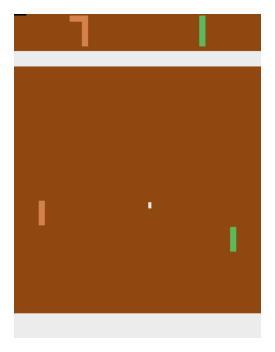

In [7]:
#model2 = pickle.load(open('save_tr.p', 'rb'))
#env = gym.make("Pong-v0")
play_game(env, model)